## tau, Te, OLR, sigma, Q, alpha

In [30]:
OLR = 238.5 # W m^-2
sigma = 5.67e-8 # W m^-2 K^-4
Te = 288 # K
tau = OLR / (sigma * (Te**4))

Q = 341.4
Freflected = 101.9
alpha = Freflected / Q

## OLR as a function of Te and tau

In [7]:
import numpy as np

def OLR(Te, tau):
    sigma = 5.67e-8  # W m^-2 K^-4
    OLR = tau * sigma * (Te ** 4)
    return OLR

print (OLR(288, 0.611), OLR(292, 0.611))

# try some array calculations
T = np.linspace(230, 300, 10)
print (OLR(T, 0.611))

238.3385101074432 251.8579562833152
[ 96.94727652 110.74122538 125.95729522 142.69002675 161.03700337
 181.09885117 202.97923892 226.78487809 252.62552283 280.61397   ]


## ASR as a function of alpha and Q

In [32]:
def ASR(alpha, Q):
    ASR = (1-alpha) * Q
    return ASR

## Equilibrium Temperature as a function of alpha, Q, and tau

In [21]:
def equilibrium_temperature(alpha,Q,tau):
    return ((1-alpha)*Q/(tau*sigma))**(1/4)

alpha = 0.3
Q = 341.4
tau = 0.611

Teq_observed = equilibrium_temperature(alpha,Q,tau)
print(Teq_observed)

Teq_new = equilibrium_temperature(0.32, Q ,0.57)
# an example of formatted print output, limiting to two or one decimal places
print('The new equilibrium temperature is {:.2f} K.'.format(Teq_new))
print('The equilibrium temperature increased by about {:.1f} K.'.format(Teq_new-Teq_observed))

288.1935932543099
The new equilibrium temperature is 291.12 K.
The equilibrium temperature increased by about 2.9 K.


## A time-dependent Energy Balance Model


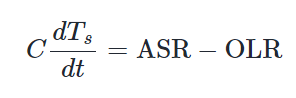
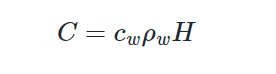

In [24]:
c_w = 4E3  #  Specific heat of water in J/kg/K
rho_w = 1E3  #  Density of water in kg/m3
H = 100.   #  Depth of water in m
C = c_w * rho_w * H   #  Heat capacity of the model 
print('The effective heat capacity is {:.1e} J/m2/K'.format(C))

The effective heat capacity is 4.0e+08 J/m2/K


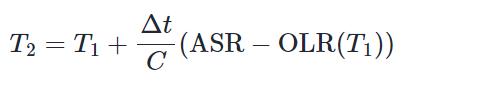

In [29]:
dt = 60. * 60. * 24. * 365.

T1 = 288
T2 = T1 + dt / C * ( ASR(alpha=0.32, Q=341.4) - OLR(T1, tau=0.57) )
print(T2)

288.7731637814462


In [34]:
def step_forward(T):
    return T + dt / C * ( ASR(alpha=0.32, Q=341.4) - OLR(T, tau=0.57) )
step_forward(300.)

297.663821004

In [35]:
import numpy as np

numsteps = 20
Tsteps = np.zeros(numsteps+1)
Years = np.zeros(numsteps+1)
Tsteps[0] = 288. 
for n in range(numsteps):
    Years[n+1] = n+1
    Tsteps[n+1] = step_forward( Tsteps[n] )
print(Tsteps)

[288.         288.77316378 289.3573275  289.79768185 290.1290525
 290.37808367 290.56504924 290.70531263 290.81048037 290.88930047
 290.94835505 290.99259013 291.02571868 291.05052602 291.0691004
 291.08300683 291.09341784 291.10121169 291.1070461  291.11141359
 291.11468292]


In [36]:
#   Display all plots inline in the notebook
%matplotlib inline  
#  import the plotting package
import matplotlib.pyplot as plt

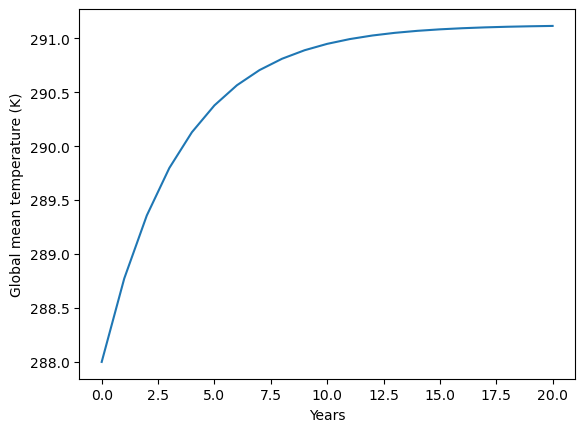

In [37]:
plt.plot(Years, Tsteps)
plt.xlabel('Years')
plt.ylabel('Global mean temperature (K)');

## 0-D EBM with climlab (Basics)

In [52]:
# set up 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab

state = climlab.surface_state(num_lat=1,  # a single point
                              water_depth = 100.,  # 100 meters slab of water (sets the heat capacity)
                             )
print(state)

print(state.Ts)
# 'Ts' is autometically created and managed by the 'climate.surface_state' method 

climlab.to_xarray(state)

AttrDict({'Ts': Field([[32.]])})
[[32.]]


<xarray.Dataset>
Dimensions:       (depth: 1, lat: 1, depth_bounds: 2, lat_bounds: 2)
Coordinates:
  * depth         (depth) float64 50.0
  * lat           (lat) float64 0.0
  * depth_bounds  (depth_bounds) float64 0.0 100.0
  * lat_bounds    (lat_bounds) float64 -90.0 90.0
Data variables:
    Ts            (depth, lat) float64 32.0

In [46]:
delta_t = 60. * 60. * 24. * 30.  # 30 days, or about 1 month!

#  create the longwave radiation process
olr = climlab.radiation.Boltzmann(name='OutgoingLongwave',
                                  state=state, 
                                  tau = 0.612,
                                  eps = 1.,
                                  timestep = delta_t)
#  Look at what we just created
print(olr)

climlab Process of type <class 'climlab.radiation.boltzmann.Boltzmann'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>



In [47]:
#  create the shortwave radiation process
asr = climlab.radiation.SimpleAbsorbedShortwave(name='AbsorbedShortwave',
                                                state=state, 
                                                insolation=341.3, 
                                                albedo=0.299,
                                                timestep = delta_t)
#  Look at what we just created
print(asr)

climlab Process of type <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



In [48]:
#  couple them together into a single model
ebm = climlab.couple([olr,asr])
#  Give the parent process name
ebm.name = 'EnergyBalanceModel'
#  Examine the model object
print(ebm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
EnergyBalanceModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>
   AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



In [55]:
# access the model in two ways
ebm.state 
    # output: AttrDict({'Ts': Field([[32.]])})
    # which means: ebm.state is an AttrDict (a specialized dictionary used by climlab) containing a single key 'Ts', which maps to a 'Field' object with the value '[[32.]]'
ebm.Ts
    # output: Field([[32.]])

Field([[32.]])

In [54]:
# the internal information about the timestep of the model
print(ebm.time['timestep'])
print(ebm.time['steps'])
# a timestep is 2592000 seconds and the model has taken 0 steps so far

2592000.0
0


In [56]:
ebm.step_forward()
ebm.Ts
# the model is getting colder!

Field([[31.61786227]])

In [57]:
ebm.diagnostics
# ... because the OLR>ASR!

{'OLR': Field([[300.896072]]), 'ASR': 239.25130000000004}

In [59]:
# we can access these diagnotics variables as attributes
ebm.OLR

Field([[300.896072]])

In [60]:
ebm.ASR

239.25130000000004

## Run the 0-dimensional EBM out to equilibrium

In [64]:
import numpy as np

numsteps = 500
Tsteps = np.zeros(num_steps+1)
Months = np.zeros(num_steps+1)
Tsteps[0] = ebm.Ts 
for n in range(numsteps):
    Months[n+1] = n+1
    ebm.step_forward() # unlike the code above, the step_forward method in 'climlab' does not take the current temperature as an argument; it operates on the state variables within the model objects itself
    Tsteps[n+1] = ebm.Ts
print(Tsteps)

C:\Users\fiona\AppData\Local\Temp\ipykernel_29876\2780297348.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tsteps[0] = ebm.Ts
C:\Users\fiona\AppData\Local\Temp\ipykernel_29876\2780297348.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tsteps[n+1] = ebm.Ts


[31.61786227 31.24505044 30.88130318 30.52636804 30.18000111 29.84196663
 29.51203668 29.18999084 28.87561587 28.56870546 28.26905991 27.97648591
 27.69079625 27.41180959 27.13935028 26.87324807 26.61333795 26.35945996
 26.11145896 25.8691845  25.63249063 25.4012357  25.17528228 24.95449693
 24.73875013 24.52791608 24.32187262 24.12050107 23.92368612 23.73131574
 23.54328102 23.3594761  23.17979809 23.00414689 22.8324252  22.66453835
 22.50039426 22.33990333 22.18297838 22.02953456 21.87948929 21.73276218
 21.58927495 21.44895138 21.31171727 21.17750032 21.04623013 20.91783809
 20.79225738 20.66942289 20.54927115 20.43174031 20.31677011 20.20430177
 20.09427801 19.98664297 19.8813422  19.77832258 19.67753232 19.5789209
 19.48243904 19.38803867 19.29567289 19.20529596 19.11686321 19.03033108
 18.94565705 18.86279964 18.78171832 18.70237358 18.62472682 18.54874035
 18.4743774  18.40160205 18.33037922 18.26067468 18.19245499 18.12568747
 18.06034023 17.99638211 17.93378268 17.87251221 17.

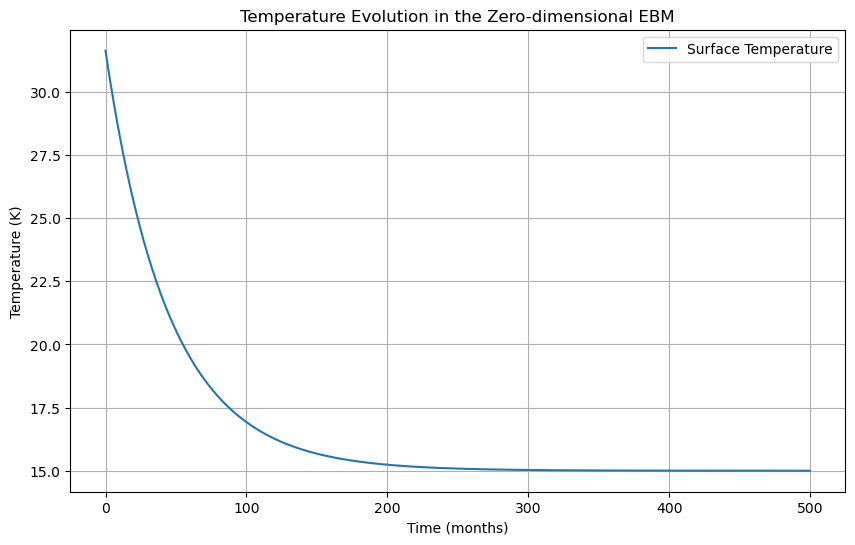

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(Months, Tsteps, label='Surface Temperature')
plt.xlabel('Time (months)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Evolution in the Zero-dimensional EBM')
plt.legend()
plt.grid(True)
plt.show()

## Implement the scenario in the climlab

In [69]:
# clone a model
ebm2 = climlab.process_like(ebm)
# change the parameters
ebm2.subprocess['OutgoingLongwave'].tau = 0.57
ebm2.subprocess['AbsorbedShortwave'].albedo = 0.32

In [72]:
#  Computes diagnostics based on current state but does not change the state
ebm2.compute_diagnostics()
ebm2.ASR - ebm2.OLR

Field([[9.25047414]])

In [73]:
ebm3 = climlab.process_like(ebm2)
ebm3.integrate_years(50)

Integrating for 608 steps, 18262.11 days, or 50 years.
Total elapsed time is 91.09024094149032 years.


In [76]:
#  What is the current temperature?
ebm3.Ts

Field([[17.94829567]])

In [77]:
#  How close are we to energy balance?
ebm3.ASR - ebm3.OLR

Field([[5.19775743e-05]])

# **1. Atmospheric Layer Model**

## Two Layer Grey Gas Model

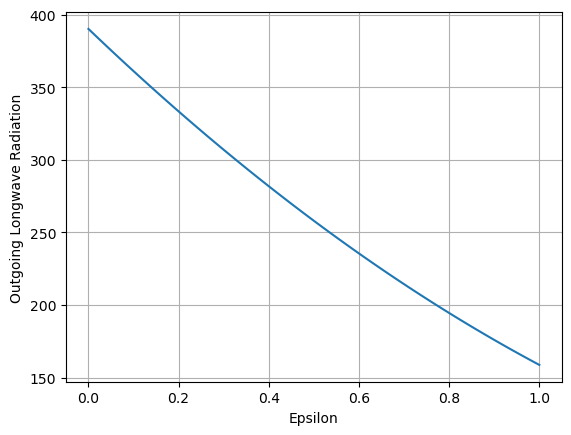

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def OLR (Ts, T0, T1, epsilon):
    sigma = 5.67e-8 # W m^-2 K^-4
    OLR = ((1-epsilon)**2)*sigma*(Ts**4)+(1-epsilon)*epsilon*sigma*(T0**4)+epsilon*sigma*(T1**4)
    return OLR

eps_array = (np.linspace(0, 1, 100))

plt.plot(eps_array, OLR(288, 275, 230, eps_array))
plt.xlabel("Epsilon")
plt.ylabel("Outgoing Longwave Radiation")
plt.grid() 

# we can find the epsilon value that produces the OLR in reality! -> 0.58

## Two-layer leaky greenhouse model in climlab

In [6]:
import climlab
col = climlab.GreyRadiationModel(num_lev=2) # two-layer atmosphere
print(col) 

E:\Anaconda1\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (2,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [7]:
climlab.to_xarray(col.state)

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lev: 2, lev_bounds: 3)
Coordinates:
  * depth         (depth) float64 0.5
  * depth_bounds  (depth_bounds) float64 0.0 1.0
  * lev           (lev) float64 250.0 750.0
  * lev_bounds    (lev_bounds) float64 0.0 500.0 1e+03
Data variables:
    Ts            (depth) float64 288.0
    Tatm          (lev) float64 200.0 278.0

In [9]:
# assign the “observed” temperatures to our model state

col.Ts[:] = 288.
col.Tatm[:] = np.array([230., 275.])

LW = col.subprocess['LW']
LW.absorptivity = 0.586

#  This does all the calculations that would be performed at each time step, 
#  but doesn't actually update the temperatures
col.compute_diagnostics()
#  Print out the dictionary
col.diagnostics

{'flux_from_sfc': Field([102.0487]),
 'flux_to_sfc': array([341.3]),
 'flux_to_space': array([102.0487]),
 'absorbed': array([0., 0.]),
 'absorbed_total': 0.0,
 'emission': Field([0., 0.]),
 'emission_sfc': Field([0.]),
 'flux_reflected_up': array([  0.    ,   0.    , 102.0487]),
 'insolation': Field([341.3]),
 'coszen': Field([1.]),
 'OLR': array([238.5247311]),
 'LW_down_sfc': array([228.53426769]),
 'LW_up_sfc': Field([390.10502995]),
 'LW_absorbed_sfc': Field([-161.57076227]),
 'LW_absorbed_atm': array([ 20.02990881, -96.98387764]),
 'LW_emission': Field([ 92.98664086, 190.03779837]),
 'ASR': Field([239.2513]),
 'SW_absorbed_sfc': Field([239.2513]),
 'SW_absorbed_atm': array([0., 0.]),
 'SW_up_sfc': Field([102.0487]),
 'SW_up_TOA': array([102.0487]),
 'SW_down_TOA': Field([341.3]),
 'planetary_albedo': Field([0.299])}

In [10]:
col.timestep
# the default value for a unit of timestep is one day

86400.0

In [11]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


In [12]:
# Check for equilibrium
col.ASR - col.OLR

Field([-2.39951902e-07])

In [13]:
#  The temperatures at radiative equilibrium
col.state

AttrDict({'Ts': Field([296.38447748]), 'Tatm': Field([233.72131685, 262.28540232])})

### The observed annual, global mean temperature profile

In [20]:
import xarray as xr


ncep_filename = 'air.mon.1981-2010.ltm.nc'
##  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
##  Open handle to data
ncep_air = xr.open_dataset( path + ncep_filename, decode_times=False )
ncep_air


<xarray.Dataset>
Dimensions:             (level: 17, lon: 144, time: 12, lat: 73, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) float64 -6.571e+05 -6.57e+05 ... -6.567e+05
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...
    _NCProperties:                  version=2,netcdf=4.6.3,hdf5=1.10.5

In [30]:
#  Take global, annual average and convert to Kelvin
import numpy as np
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time')) + climlab.constants.tempCtoK

In [17]:
#  A handy re-usable routine for making a plot of the temperature profiles
#  plot temperatures with respect to log(pressure) to get a height-like coordinate

import matplotlib.pyplot as plt

result_list = [col.state]
name_list = ['Two Layer Leaky Model']

#  Converting Pressure to a Height-like Coordinate
def zstar(lev):
    return -np.log(lev / climlab.constants.ps) # ps = surface pressure 

def plot_soundings(result_list, name_list, plot_obs=True, fixed_range=True):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    #if isinstance(state_list, climlab.Process):
    #    # make a list with a single item
    #    collist = [collist]
    fig, ax = plot.subplots(figsize=(9,9))
    if plot_obs:
        ax.plot(Tglobal, zstar(Tglobal.level), color='k', label='Observed')    
    for i, state in enumerate(result_list):
        Tatm = state['Tatm']
        lev = Tatm.domain.axes['lev'].points
        Ts = state['Ts']
        ax.plot(Tatm, zstar(lev), color=color_cycle[i], label=name_list[i])
        ax.plot(Ts, 0, 'o', markersize=12, color=color_cycle[i])
        
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)', fontsize=14)
    ax.set_ylabel('Pressure (hPa)', fontsize=14)
    ax.grid()
    ax.legend()
    if fixed_range:
        ax.set_xlim([200, 300])
        ax.set_ylim(zstar(np.array([1000., 5.])))
    #ax2 = ax.twinx()
    
    return ax

In [39]:
plot_soundings(result_list, name_list, plot_obs=True, fixed_range=True)

NameError: name 'result_list' is not defined

# **2. Radiative-Convective Model**

## **MODEL1**: RADIATIVE MODEL

### 1.1 Skew-T diagram

In [4]:
!pip install metpy

   ---------------------------------------- 0.0/409.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/409.9 kB ? eta -:--:--
    --------------------------------------- 10.2/409.9 kB ? eta -:--:--
   -- ------------------------------------ 30.7/409.9 kB 330.3 kB/s eta 0:00:02
   -- ------------------------------------ 30.7/409.9 kB 330.3 kB/s eta 0:00:02
   --- ----------------------------------- 41.0/409.9 kB 219.4 kB/s eta 0:00:02
   ----- --------------------------------- 61.4/409.9 kB 273.8 kB/s eta 0:00:02
   ------- ------------------------------- 81.9/409.9 kB 306.3 kB/s eta 0:00:02
   -------- ------------------------------ 92.2/409.9 kB 291.5 kB/s eta 0:00:02
   ---------- --------------------------- 112.6/409.9 kB 312.2 kB/s eta 0:00:01
   ----------- -------------------------- 122.9/409.9 kB 288.8 kB/s eta 0:00:01
   ------------- ------------------------ 143.4/409.9 kB 304.6 kB/s eta 0:00:01
   --------------- ---------------------- 163.8/409.9 kB 307.2 kB/

In [6]:
#  skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)

#  Take global, annual average, weighting different latitudes differently
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')    
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [7]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

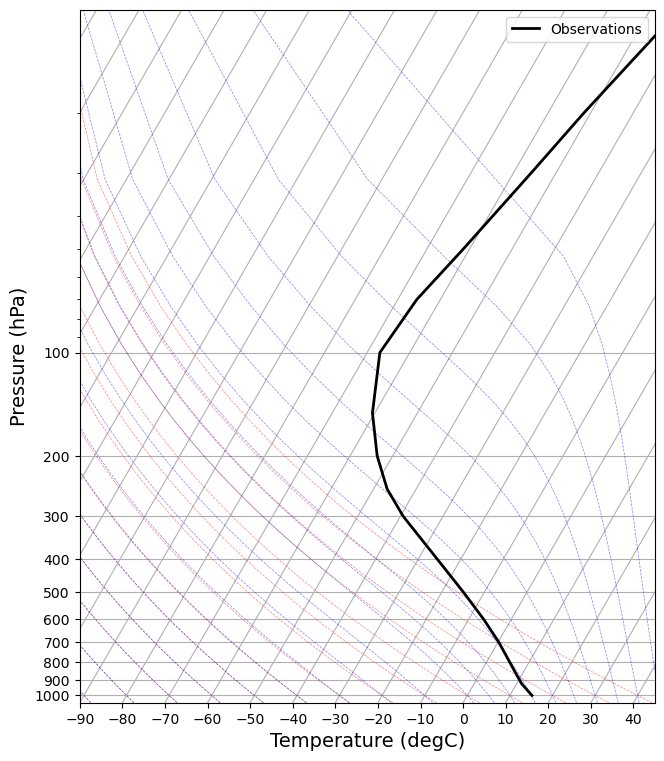

In [8]:
skew = make_skewT()

### 1.2 Volume Mixing Ratio: radiatively active gases and water vapour

In [67]:
import climlab

radmodel = climlab.radiation.RRTMG(state = climlab.column_state(num_lev=26), timestep = climlab.constants.seconds_per_day)
radmodel

In [16]:
# volume mixing ratio

radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([6.66460579e-06, 1.73889898e-06, 5.69680601e-07, 2.97389649e-07,
        1.94433058e-07, 1.35030372e-07, 9.29020109e-08, 6.87629750e-08,
        5.92563077e-08, 5.38592489e-08, 4.98759420e-08, 4.65389922e-08,
        4.41377131e-08, 4.20349137e-08, 4.06036531e-08, 3.92741298e-08,
        3.80870966e-08, 3.67075805e-08, 3.49157080e-08, 3.31238355e-08,
        3.11639418e-08, 2.92023137e-08, 2.73903462e-08, 2.57915723e-08,
        2.41927984e-08, 2.26566087e-08])}

In [18]:
#  Use the specific humidity field from CESM control simulation
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

<xarray.DataArray 'Q' (time: 240, lev: 26, lat: 96, lon: 144)>
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [19]:
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

<xarray.DataArray (lev: 26)>
array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

In [25]:
print (radmodel.absorber_vmr['O3'])
print (radmodel.lev)

[6.66460579e-06 1.73889898e-06 5.69680601e-07 2.97389649e-07
 1.94433058e-07 1.35030372e-07 9.29020109e-08 6.87629750e-08
 5.92563077e-08 5.38592489e-08 4.98759420e-08 4.65389922e-08
 4.41377131e-08 4.20349137e-08 4.06036531e-08 3.92741298e-08
 3.80870966e-08 3.67075805e-08 3.49157080e-08 3.31238355e-08
 3.11639418e-08 2.92023137e-08 2.73903462e-08 2.57915723e-08
 2.41927984e-08 2.26566087e-08]
[ 19.23076923  57.69230769  96.15384615 134.61538462 173.07692308
 211.53846154 250.         288.46153846 326.92307692 365.38461538
 403.84615385 442.30769231 480.76923077 519.23076923 557.69230769
 596.15384615 634.61538462 673.07692308 711.53846154 750.
 788.46153846 826.92307692 865.38461538 903.84615385 942.30769231
 980.76923077]


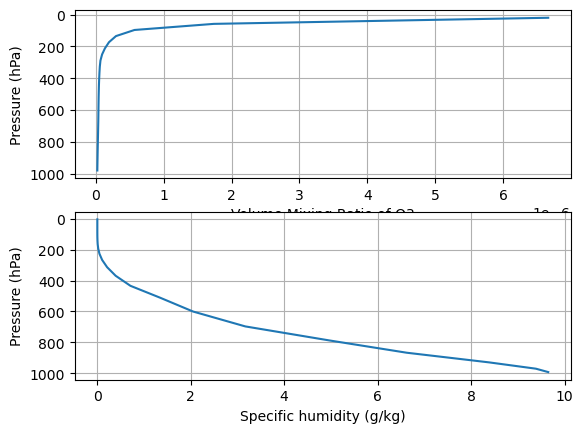

In [88]:
fig, ax = plt.subplots(2,1)
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air

ax[0].plot(radmodel.absorber_vmr['O3'], radmodel.lev)
ax[0].invert_yaxis()
ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_xlabel('Volume Mixing Ratio of O3')
ax[0].grid()

ax[1].plot(Qglobal*1000., Qglobal.lev)
ax[1].invert_yaxis()
ax[1].set_ylabel('Pressure (hPa)')
ax[1].set_xlabel('Specific humidity (g/kg)')
ax[1].grid()


### 1.3 Single-column radiation model 
Rapid Radiative Transfer Model (RRTMG)

In [28]:
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Make a model on same vertical domain as the GCM

In [71]:
radmodel_H2O = climlab.radiation.RRTMG(name='Radiation (all gases)', 
                              state=mystate,   
                              specific_humidity=Qglobal.values,  
                              albedo = 0.25,  
                              timestep = climlab.constants.seconds_per_day, 
                             )

In [72]:
radmodel_H2O.state

AttrDict({'Ts': Field([314.97571371]), 'Tatm': Field([262.71337398, 244.57476962, 236.76996926, 229.51689516,
       223.16268128, 218.0299841 , 213.78928741, 210.61595222,
       207.76830617, 203.89974316, 198.62932088, 192.4622138 ,
       187.45666328, 185.31627529, 189.41652461, 197.8591592 ,
       207.6732719 , 217.94776182, 228.44880615, 240.038236  ,
       253.43940622, 267.41687793, 279.61229477, 289.63738034,
       298.06424485, 304.97796664])})

In [73]:
radmodel_H2O.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

In [74]:
radmodel_H2O.step_forward()

In [75]:
radmodel_H2O.Ts

Field([314.97577252])

In [76]:
climlab.to_xarray(radmodel_H2O.LW_flux_up)

# we can see that there are 27 bounds, but we only have 26 pressure levels.
# this is because:
# radmodel_H2O.LW_flux_up[-1] represents the upward flux from the surface to the first level
# whiile radmodel_H2O.LW_flux_up[0], or, radmodel.OLR, are the flux from the top layer out to space

<xarray.DataArray (lev_bounds: 27)>
array([254.89165752, 253.58316155, 252.84099561, 252.26761307,
       251.90983411, 251.803034  , 251.8015625 , 251.76439046,
       251.6744577 , 251.51470728, 251.2225118 , 250.89560366,
       250.82082887, 251.35652136, 253.27988525, 257.21479011,
       263.35883308, 271.95451952, 283.6934539 , 301.33903745,
       327.00704805, 361.61445184, 402.80174892, 444.0065829 ,
       482.7980603 , 515.34666561, 558.10212391])
Coordinates:
  * lev_bounds  (lev_bounds) float64 0.0 5.467 10.68 18.96 ... 950.1 981.6 1e+03

In [77]:
#  Check the energy budget to see the model is getting warmer or cooler
radmodel_H2O.ASR - radmodel_H2O.OLR

Field([0.00970454])

In [78]:
# we can then integrate out to equilibrium
while np.abs(radmodel_H2O.ASR - radmodel_H2O.OLR) > 0.01:
    radmodel_H2O.step_forward()

In [79]:
#  Check the energy budget again
radmodel_H2O.ASR - radmodel_H2O.OLR

Field([0.00970454])

### 1.4 Radiative Equilibrium Temperature vs Observations

In [46]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

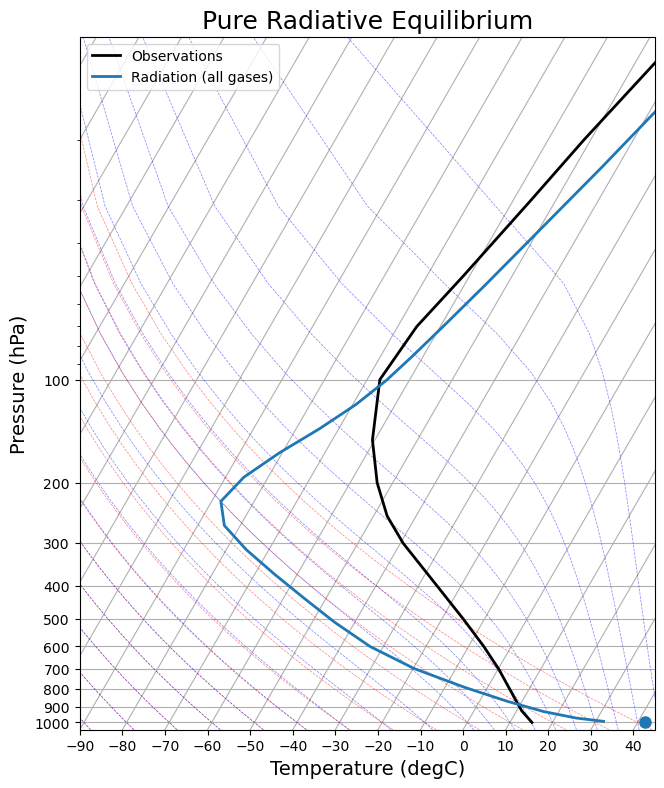

In [49]:
skew = make_skewT()
add_profile(skew, radmodel_H2O)
skew.ax.set_title('Pure Radiative Equilibrium', fontsize = 18);

### 1.5 Effects of different gases on the radiative equilibrium profile

#### 1.5.1 Remove H2O

In [80]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel_H2O)
radmodel_noH2O.name = 'Radiation (no H2O)'
radmodel_noH2O.specific_humidity *= 0 # very smart way of clearing an array!

In [81]:
#  it's useful to take a single step first before starting the while loop
#  because the diagnostics won't get updated 
#  (and thus show the effects of removing water vapor)
#  until we take a step forward
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

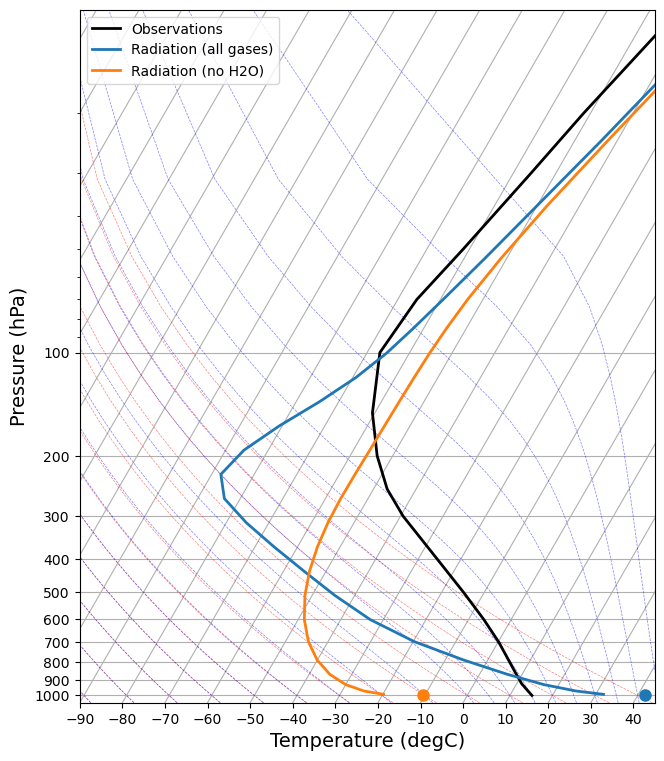

In [82]:
skew = make_skewT()
for model in [radmodel_H2O, radmodel_noH2O]:
    add_profile(skew, model)

#### 1.5.2 Remove O3

In [83]:
radmodel_noO3 = climlab.process_like(radmodel_H2O)
radmodel_noO3.name = 'Radiation (no O3)'
radmodel_noO3.absorber_vmr['O3'] *= 0

In [84]:
radmodel_noO3.step_forward()
while np.abs(radmodel_noO3.ASR - radmodel_noO3.OLR) > 0.01:
    radmodel_noO3.step_forward()

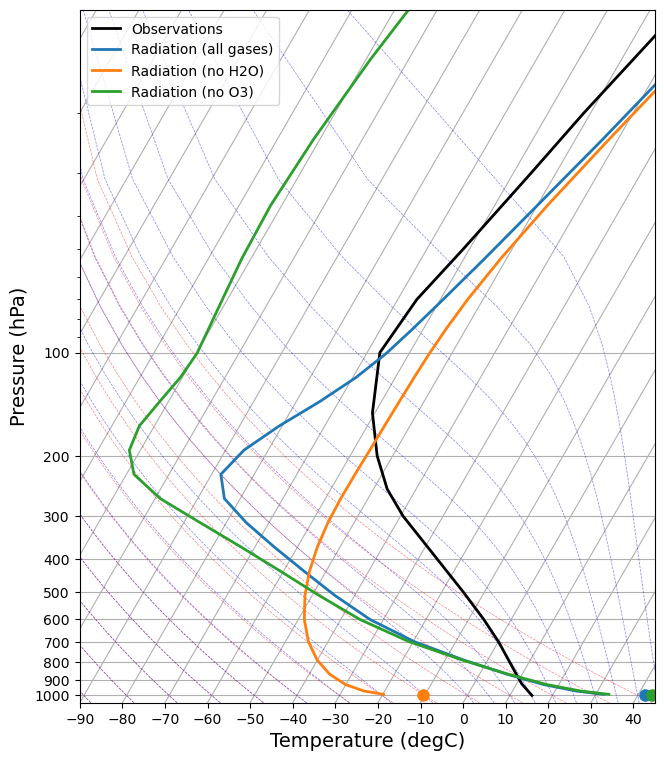

In [85]:
skew = make_skewT()
for model in [radmodel_H2O, radmodel_noH2O, radmodel_noO3]:
    add_profile(skew, model)

#### 1.5.3 Remove both

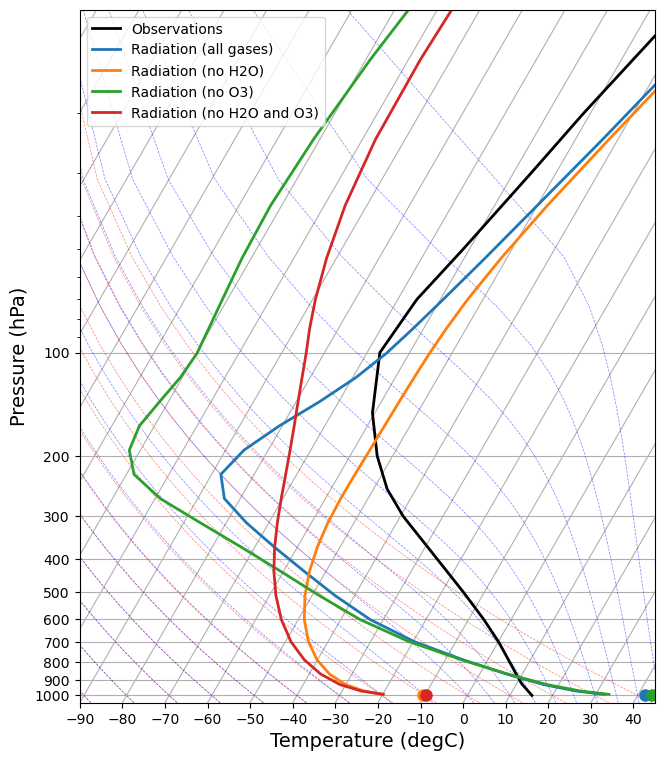

In [86]:
radmodel_noH2O_O3 = climlab.process_like(radmodel_noH2O)
radmodel_noH2O_O3.name = 'Radiation (no H2O and O3)'
radmodel_noH2O_O3.absorber_vmr['O3'] *= 0
radmodel_noH2O_O3.step_forward()
while np.abs(radmodel_noH2O_O3.ASR - radmodel_noH2O_O3.OLR) > 0.01:
    radmodel_noH2O_O3.step_forward()
skew = make_skewT()
for model in [radmodel_H2O, radmodel_noH2O, radmodel_noO3, radmodel_noH2O_O3]:
    add_profile(skew, model)

## **MODEL2**: Radiative-Convective Model
the 'convective' model - climlab.convection.ConvectiveAdjustment :


look for lapse rates exceeding a critical threshol  (6.5 K/km)d, and performs an instantaneous adjustment 

that mixes temperatures to the critical lapse rate while conserving energy.

### Coupling radiative and convective model

In [89]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5, # this is the key parameter! We'll discuss below
                                               timestep=rad.timestep,  # same timestep!
                                              )
#  Here is where we build the model by coupling together the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

### Adjustment from isothermal initial conditions

In [90]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

def initial_figure(model):
    fig = plt.figure(figsize=(14,6))
    lines = []
    
    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')    
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.set_xlim(-8,8)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=['g','b','r','y','k']
    #color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(rcm)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-100, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12)) 
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[2+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[2+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

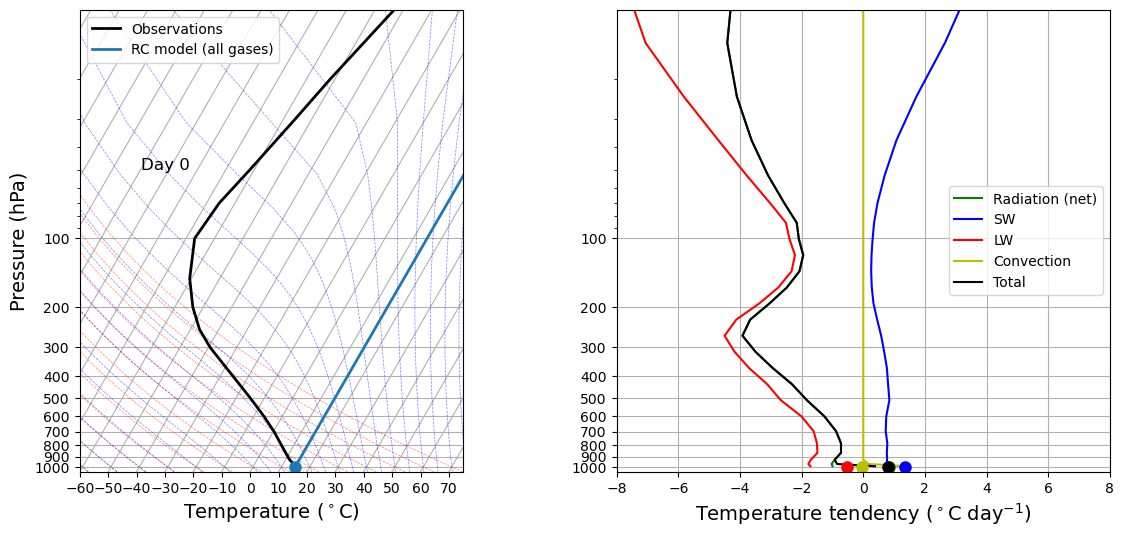

In [91]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

In [92]:
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAD8XBtZGF0AAACrwYF//+r%0A3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q%0ARUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu%0ALm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h%0AbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl%0AZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg%0AZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x%0AMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu%0AdGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg%0AYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv%0AcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49NSBzY2VuZWN1dD00MCBpbnRyYV9y%0AZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w%0ALjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA%0A1x5liIQAE//+97GPgU3IAA2XOop6H+EVsfSQUXqx2aBk6gAAAwAAAwAAAwAAAwK4GjNhgKVOSGhI%0AAAADAAFzAA8omPT58vj4gGjnyIARyqTiEhrY9OEb7/LdcwY49/gOVGhFc8jxeGRhL1ZBvMrx93b2%0AIz986pyNy/rXQ9Nn9lmzRHguiEXV/GCexup3/bZkhsR7Sd4gb6Y7vieBKtqgyyPV0yWWW+n4GjJk%0AJ6vnFCz2N3aXPOf75vldB5XzcQBV71undReNfPTI6fjcOT9A4zF+z2HMKsE6H9iC8WdfMh4kB2X7%0AhFsKjyEAr4R++8SuK+uq0i5CISUvSGC8tK1/7phcoksfGv2VyNEA8pdB5xT3Wa6dP235T4ziJnWz%0A89qmWoo0MpY0duSJNVZMscauJIwbwe2SWw5tg0H3cMmImdpxq16v5urL9hzsNoV6Oik0znv2VBqT%0AKsEhGctiwYjAkXyXZLoqzbXmDrKvqxBcM+elXtkyRR5LgKyK0P5jE9SwtaRhUgnd3nrSXwHkZzS4%0AwFrnYxWibQrztmCJxO0en4i1XURYvtWaqa/NytifCoIWTwhNO1iYXAoEnSdUOP3pp8fzdz21ZyT4%0Aauh28Iju8tL88LB+DUiYB9YR0yQeHS9h/3IuP+lcZ8r03CnkaDlycifh5DnrVNhi/bf9nNSyba1c%0AG0BA0IF/akoPenSrN03N5Tjg2Zr0NDysMAzFztBCqx7YAOpQkFdlUwdRB5u6i6chGZZMU7fq3EJ0%0AU0Bo2yQaadrWFE2o9rBwyQZzo48OrIjcSidJMdoUqH2S/qxiydY84aYNR7jDpXVkWThjfuI4h4TW%0Afy/BkfvIkp/K3XT123RA7/SQP2hW9acAjAckp9Y/P39G3zRNr4dvdLwobeR1SW4q0i7N/f3K9/7T%0A/yVvfbyPbEmUcFGmSHrEqmf5APfmSmYoEvAKrJpZpca95ltbHqgIxAFqmcuRVGbvLF+dR/WR0vH5%0AhZOLKlx4cbps2l8T65FEqztPFCfmMZq+nf2Hcj2ni26nm6qXQAf9I1pg3FBWYvEhbetiHftrbciq%0Ak6/LjqYpNAHxkw2O6GdZ1QpLReC3KDDbKhyzw/8qcQPg0qIRsA1vIBLUU3l4a6NSS+OlyR8MzSX2%0A5K4aHu7378OeJqEUFFN6Cs9SjRpe1U4GlluLe0QP/45BY2HuwzRyG3rdgUUFf7UZtpTnk0XLbNBV%0A++6/sDPOFhJ55sCd2U/E0dDgfpVnZTa1EaUz43P6POmo2dXXmPQfm4zXnBQVmMqb4QgiNI1LBYtL%0Awene2QU/OZs5NFZeY7PSM847suy/eBCGvkKq9bG4rt2e38I8BrZM6lxkQ1HzBDc55hkP962E45pZ%0Ab8TnboAuNd+6hR/mwNJsa7TKaHWvJVbw1eWdTG0ejBQK3cSbI1KlQDwyV4CUpPbm/fwf8vQT+Kio%0AYwOsv4oCOKlT6DWPNEiVKsuvnPIxDj08BEXCBhYQyRapmxScwS5rOkJn1mac4vZu4tvV+93LgFVS%0AbsN4svvIhU3DHziHcVTSAf/13peh2/eX5cc9ioM9+0EKxKp/5WYjPBxIizdNSKgnrCI0348jJwRb%0AU1uvRtb1m29Ao/XgeHaSMidgiH73dHjiIXRNGFc9bXPpmWOCZxHB37/uA2a3Hvt3E7IPfJkoNA2F%0Ati/vdwOcrdK1PoNpIAzLuOkUS4t1lfFgg7KxBU0ZeT2bU+CUumbngIFDa/qUlH7vmyA+PlYa2PjE%0A/jgfLzFhaOrInJavjo6mikjUTArBLmNkh8E2exd2hvt/BEkPI5Rs4ZH667+xYw79u23305ChMgH2%0AD6egEyz1m98TbnIYTS8/SZdXJhDV4h/SCWscAxE3Zm5HKaf//6c1ZQcNqCbEBXv097opUGt8nuFt%0A9HbvP4lDa2xm7kWaUff+YN1T9e0QVbC2V4YMs4Pidot4wRIlC/i1N+nExOAwzIFUOzc7p/Etvb0S%0AHRiX/ToMWuACRkVTdMMcYwEGhQ7xigydYObdIqv/h336J0hKtEiA4cZ8o2s8YAUyiVcJW/yFUXb8%0AwODN1QFh9VmgHr9WJR8W8fWhbHPuFhnbOgndR+f/75fgmfvzqezrJYzLQw9eK7rhlb47vU/F/W+T%0AxO8f7U1uj1YpZsY1B4lQ5tTUvv9/versnvD24OYL2dXfRCSJaV8Zq9tmTxukZ16CTdZgXB0nqlBd%0AnjhS8HPn3SLWQM5oSeNZHFzlNs81qCYex4ogKbTjMJ61LazMmrzyuICMvEpCbiWSAzJ23iWb7+tU%0A2lxBy8pwQayDv/RWkKS8WGt33QatpOoFKw4smbV0b9HmStrVSgrWUH4M2pu3yqkgLlrdxIHQscNt%0A5/xScP/ni9Fjh3yMS6bd0+OUWx6fCUvQCH46+JlLl3qFUzHRj4GR4b43ua4qcUW+yrR9pUECabox%0ALgfKdQd6zm/YUwEaLTAe4U4YXGvYjDGhGSfoFgLvGVzDLC/aAP3IXxU5BGjxrBTrdPnPxMTtDny5%0ANkGOodMHtMbztXrXvOKKLs95IqrcA+7OzdV8j66PBogE3cKIzZP/vyjJIaY/3MoQxibKz/YlhfQr%0AyyOt/sYq6kD0p9OrG2nkvTHz77wOkrijg3NnBM2rN/5/py3iTf4mk1KhiptAXV6D8ZvbfFf7TDKH%0AcWaBcK02XhXG09kOt8d6M2u0geXIj4zokcp4P2EeBtWmiDmHOZF34u10+UYnMNQorA+ObP0D1iOv%0ATZ90pCkVasDnmkIr9OZJVk0lbq5IZ3As/gObJg/TJiKX56wwU1d/2TNnL4T2gMtknX9vX1H55x5Z%0AH/HCVR4iZtcXRQnIf4p1ORG5gHOQGecFBUBDN81iT5wcP3hhXuCayiUydpb5wO065k5MHIKFB+aa%0A5R8gu56yMr4n38wWTUtzBarUOKi+WxU24dN6JH2JfazhYWKCPviGLI+Ro74q7vuVpWWFnW4pKAHf%0AxR6vX4fTRJZ0qw6dbYhsxmWD46dPBiwENz4EO3HeJHVTUU9w/u7fuP2WuUIQJtM2bk0nNkZrivpP%0AjpA8IsvjH2sus1n2Jy7LIq989nzdd2MJ8/sKQpEGdmxDloZmvOb2HJyqiaEBIpfhunfcH4YUrfwU%0ARTNfVkdrtxAxTog2XCnbsoF4gJZ5S5YcHqg2pB0owcaC/XvPxKf4Q4xak2EqtfqPu/FLqM7azNt8%0AgMQWDsL+8j+lEi+AKySl7UxfJjmebNSOIoK7imEv9qeLcfHxrphPS7S6yOPRXjiI/6PEgmfy1fRB%0AXdj9rCKqdiLWwJHX3K30yY19s6yw6y/66dLCJdf0TGUnfHU/RJmExAAID7Zayv8moQhcgmREjiwf%0Ah4OmQCkc2G+qCUeA+qsNJH7C8hypUZl53Mhn0ZS5zSuiMzlkxpInh+scXrciDV/MCYXQQ3JqBd8S%0AKdvVKiNmkU5uZc1gKt6eVj/Ok1Wfv/3SqY4EugO7QmWDx/LPWWBTvm/K/3W92X+ezPTLVjQHvy+/%0AtG++KSl61XchoblmQ6P24lIXWfz3M/LUglAeOT4hyYLil0Lo0R23q0v5DHG5qUOcNjZw8M9gsYbT%0AYBJqw0cq0k6fVNXkeqCn7/TTwKwSWVE2mIXk95LpU2lVem350FLOiCa9KMtYoj+TYsC9Obhgio66%0AszNBU8adJn+I9iXJnwt3a/rIR8IgZLJmcsBb3oVhDBS+fic/RtoKmgu8qvpeQsjLpZZXkfMwqQR2%0AQcPIDXhHaXuAx/DSb4rNGCmar2FUwLgd9730kbv3FyRxCR5qLIfbQdvuvJuKj5FEFd1kGOpNKu9I%0A/PPD8xaB5GIp9v6gpPWiKHy2Jxqm4qiokHsIvwi3Vbc2gSj7oZi0Fg4EyQNSgab1PO3ckaWDQ4nq%0AfKX7/IQrlVdw/FLZA4WC6NaNR9w4s+c0IgWxK8IqqeWl29mMRl06OPUg6qI3EElQ94+o2zhWhC79%0AyGVI77Ul42DSwvy5d/lPqjqo8zEtytZmRqgY8zdkBXTDLzhlmkIA9R7NJNFjZqDmz3DHE24prCnp%0AmUsv54M3rHVM7cjSmJav0gHoQFK604X8Fs3X2PGQG/WYR/OSMQudidPU7ttYwu+L+hgs7U8096JC%0AeGjfCTHwq7MawGAVGQKgJJIvnXUmKAb0lfZ84M2VYbFfKnLMLLmBd55kDKZ1+iCBGAQYWEUW70ol%0APGzJkHTxoiHRrDgUm+clRF7k0EkY4pI2kGmyXdOPFoS4JYb7IUGRQSrOfpgCINaj/23lPv9o/pLR%0Ak0HmKRLw6EP2LZCBfohxXEnCWJLk8S1Npdyojz0+hxRinfG2uvH4iD7629SFqxfuolC0Rn+BuLr8%0AKXdn5IGXtNiublVf0i710qza1I9RaoVby+JurjCfMJcVOHf7QiUZklVcPwCah1CbrLKHVYi9Dq3i%0ApAi06kdhDPFR7YvZP8uwBpbuv2jQV3nzs/0SdHl4dQjKmkpJPhz/gcMMqhG4PjXDuyx+kPkfiDKb%0ADz8CA9KYIFNrSrX6ESf//GTM1u5vJW87ujJGayb1fSnSscuv5up5Md5zxeo4Drcl0lZIjF0i3X/+%0APQ4qH/hEw0OyZabFgslIXrT4ia/Zy4GKYJi7dIi4oS7F7cCDSRR9IJ2i/SVa2XP3MM4fY3VFRFiY%0AR25IG7/6EOYW+Kx/CUx2bgELrRA3nZZUuTUerfbwK7l2B+6rNcj190avNcUEFFjBBLFA4wrvL0gz%0Ax5hfgf2G9OwNEJWyv8Vqtycj0z7JTHdCLUexYMz0fWcnrtyGR++3B1FaMbE8tcz6d77lpJnlBpn1%0A0f0v7sHN5+/if+ZAXcYwTXevb19OCHSlc6Sk7P46B4Iuswp72XSc8ggf8/VzGsMm4gzJJXlYjqtK%0Au+18X0WTv0PqLMuBwvuc8mu0+py2mBlnXLUMwd0kyqF0a49sJZkyb1ZGWEJiDyQEvHlWgSxkStMm%0AugW4pj2m948if9lJC7j8Ok6aPDI+meXkpu/kwFrrVOcMqDF2YzBkf2pLtvC8mlPRk7M4ffdgpHlC%0A/Z/93rdGvYCmQ5eJpmBwFFZF06z+YjC7z09G7kqkEl8ADliZ6QwPYfN/9TTSrnfwd8JpBbaLwF95%0AlNSfKed1ALyVonmRVXfu+1HpwueX7I9vKGG3kA98nsoMunehc0nO2NW8w+xDxKbhAX7RFxHJYs9L%0AY9/3/ahBjkmJzc/nnuWv+klElF9mmPchbj91hxnil7HJKlgU8NSNR8Z4NjYd6KpA+Cvj+RHrmyaS%0AO83aWwCNT5V+siht2o89r8S4PBlXrlWPYIXxlBnb1NDcabvTMq35WaiZ/jnMWVqpE7DQG413BY6p%0AcOy24ExSaMOO+rL3ctxi2T09IzRlVB5sfzwK/YwupmYROnw8U+DwtpUiaOZsV8r/sFOWZgydEZG+%0A/Nkc0nzRXtXMBvSZCSatbTf7BN0UUC+gi3r9SNRB63ROfKoJMZXiChtYVEpti2TkVTOIGZUC9119%0AQydiL+np5hEMtwb++veiA7eHDpxKqBFvyJtcJjE8dvchciMO0HV0s1qtc7R8aXY6zyGqJ/zQt2Po%0ARg7H375JVAwYsqGqHT7umJDe00sWGxQGOdqMyH4nLRMXU+ZVDxdm51JOZtFmM9LVA8GVaipfe3Z4%0Ao9t8c1NXcnrlRU5/5AZLpszpOPFe4mmXIq77WKHfj937cp75FpwJhavcl/d+KyDRL+Bxbqg0sD5t%0A5/6KyYs1ir0rRd8xK11PI1qMiV9JhzU68iaKn29DIVzyrdQRqQMmw73iCo1egkRat7bU7MmHoR5Q%0AIEp5T2NMFJ5AbE2WhlX1nkjvvc4ZMa5MIwidJ7QtIN4tPqQoNOeM77GShAiO24PsiaaWNOcW7vKG%0A8Ykab4vIrkqZGPBHdMRql0PYKL3oHhBbycKb1C4S4nueF4uLfgCzVDW5amg9WBDIKVTvfoBD3y/3%0A49DAqxh1gbA81t8ojyCcYvAbbUf+ehxrLzsAg/hpbc71ZDv+uQUSffBtzxElYZyRSQI7iWcZc98X%0AAsCLLq8MlVyWKoEUmOpQQR7krMxJ5L+OutVPCH13RIk6m2DphRXzl1/gjvyLfVLhA8LL8U9Xsf9k%0AWfixF/qiQvmoAnll7EAXdZMV8oUk/dMqdbS/MquyVc8lWCqVCn7KmjMXjdxSjKXKiBf8ft3hFuux%0AEYgO+LwdNQrD4TAVCyPeQLPbGcIziRRCMn/XiqtehGK36fvmsiu+W7qrXftsLgbHUFgFzhqdFUq+%0A81Rhjpccs+SCYZyAQG4OWvBwsdYrDUKuvzube2v1z2jDSOGgPUzaLa/lVD60w+SM69sea+j0NjKP%0AD7gNLtDniJgUJVLbIzv1rtBmpgf3cjQ1rtDDmEsPxWQv2CgJ+lo+zrqfw8h+qwCxzAwdQL9S71ol%0Ady6utSAgbUzcGzmSiZOZdJDTXKLFRdBQlTEVSMzb3PpRxeBsEC9QIDheL1GhIPAMzAWGbKgYB/sF%0AVqeOEHAFq69y86v+shqYUUjQrvURGxxafuXGR6pNGdHr0c4if2Hl33ratFLu6pwewx8XA7R+B/Mk%0ABZxV8BFZnv9oZQvcz6TgV0VcrR4UIJJVSRQWZ2Gr1A/KDQ3DG5BOhSirqmyyGRI876D8Y2QGXJ5s%0AcEpCoDe/YCCvO9jR/VTODTSvQFMrXko6R3bys9pEQaW8FKgih/tLGg/xesVizMjppGOOMzWPIt3Q%0Az1Cj+uXCibQKfHDawY2eDiPyLRwy9vl8Y9xeUvZvZoKbmMzubDkLB2lgfDUsTYC0Uj92vvFurI1c%0A+khPY3xVuTxDIc0tXEoCnq8Ky0r3qoJkAaDOQQdFwOrCRDYH+LOpFvx8bKG5F69BfpoJqFSycMgK%0A8HxIvjxmutFx+lxVpBKlwClTNuSyutkDog/VLutv4rqFfrFJu7g/gU27QrmoWio04nbwOXO8caVr%0AuMkzcEJ76xxG3WaUCm4bMvpWuqN4CRzJgTgeNo7nTZqXCI03asNe6Wu9eDKvL1M0jgNiTiij18JY%0Ahd0+Mf6yowkypjBXylHexPeS3vQXs138ZlRkZzv3EzdYV4LjT6m68P4f1jgzGfOZuWGAvQ+S4D3M%0AaIxSH5S+W5axbrdKEoriRaGD9TWOMR2qki3o9wMRlLZv7L/UXetufeioAb2GVvC0sYJxYZJdXDXC%0AKd1OQNYd2xH7zbMz2RFO7VQ577npOdqLSbx+ASimButEE2Pg7hpME7mo3t2eEXK+6d37mNCEpL51%0A465T1+hwxLymmh/fonEwVQ5NoLuxCsMSSO7ELy46OG2SBQU9H0UDwNmAQ6iUVMldVIlCLQo6z+Na%0A2vH1Dtofo2ub9G1XddsIjQJl1TUwHGHTodT172sQ2jQGX22IT4B+VV+qjkzLfbphVSsHMK3EEtHe%0ArGYE7nEAT4tvSyeejWJ8aZK5aCgIiq8Cv63NY72aVRoos+9gf+nY0uBcyG2HQjfiLN7U3WDSJyMt%0ANYb4t0Ke+RmMJ9/Ia8e58UywaW+XhnRJPNWe8Q7Np6swh7oCquNh3V/S0s6Wm1ihqUS7oxLgYZl0%0A7u70EoJgV6XRbe+YibJY5QXkxrGK33Et0GD4rZOv2PA1e3MWFjrSIDe92ydC3KqvCqgN3ZBF34so%0AIbCtOke01RMr5mPTDu+GLeJpX+nZNmlrql7wr/+gYoae05U0KuTa/AKIhKbsbAOL9thk3lVeVVil%0AjfXPzIPehoR6b7v80cbgTJejx9yB/wMW+8Npa9YY4ZgrVwvsCWbjPJjrKX9Rz7bzXXlKIbxpB0jB%0AvSKnL6R5RdWXS6l7saTo/nCu5AIZR05P1mbUKINCAQ1RF/Q/VlqJQbnu4jI2Bt+hCC1o/mvVNdVu%0AHNjreYhluia2wMgW0ecb0i5Z5dd46FED86tGzyAg6qAhx0dJfOjvsdjREB4gCS7yUgwKqZnax37+%0AJmGouGHvWSLb8zrsTVjN+WIU2fisC7FjQKJvIs6pXeWhQaXQr40a4LWHgfPc8o40YbroyRMGSOnC%0AUapN/gkkTWWCeSZIYrnAV771QvFVIE8EqqOB37jekPIKCUML7/tLv4F7RIPVKQCN01v9NKlyjMGG%0APKxDY4jNQ5lpG1Oh3SHl19erem7IgnMxUU/87X/GzLP1BdrNgqi3p6VWoR0ojt9qdseWHnPxnI82%0Asw8hzwU3CTna9dngHUeyKdxDu9VWPVE3hv8ZZPBoc2L6luBpiqWo8JJq26gJ9gzqSWzhFL1pbrv+%0AmGuO73lCEtLEN5uBXWR3pRYiI9VVmki4N/biN2ZLfcADfkCjVbj93umFIgvO96dWvK4r2m5ZK0Ne%0AqGyrpAWGlOWJiY/W6uTzaslnhdF2KPtAXqKuEQ3FdCiNJT3xGaUv8qT9AbPzFORtYTdyLFRij198%0ACYCpjmJKhCZnXj/ZfTdVN5JoPwi+2sLBszfComfC/f/dXflcrwbeKEp02jIfhOIBCkUsD5fBE91l%0AK/bRZ9Sf6bqnXb7DDzW0YmO9m3YzWsur1aGwE58dK6HFksJ3vkvVdrLJVhRBnaS9gg/MiAgKYwRF%0A30AkyR3FivE9ALUxQpir/zZ8AjVEIiSaNwMbPqxNYUpdp+zxJAHcPx3rlh89KjLkzUMCzeTiIwuG%0A/jAyTJ+L9Mvqu6deejypMkQPwNMyTIjyD2E2M2az6CbihElBlRDR/nhrm9d+IxBqWGmR1OGlIPq3%0A9neQEU4lUj2bR/2VaKFIF85uXsdsnTiiN/pwMCMUWy29TchF2PvQegsLN/+5Y2k4HFPCGRHc57/q%0AcVyGwKruqo/8iyfDHd7s2ejF13/Jh3GbOZAMjj6sJeNEqq3TKR2tcWZ2ebtyHt/yHc5bME7zFcAq%0Al1q1xVGpY4+HQUQGHTtFDjvsCBXazJP+wMugSehC5R3ZIV7+m2kTDkos6nDbuG1PJqRWqzO74J+c%0AssU2UoZcjN/oL8TMx/fsK5mfBaFuDCzZEGGqgxrfg/vWfN8jNgospy2XrO0ztoJZkT9vwSoHTzkQ%0AgBBcDccDJPE5KwcSQTK+sYrPlltdnbmQu4NJhLSRkqKxK2wE67A3RYMPj+xX6ZmW8+V53DwFXW3t%0AXc2ODEsdpeJgJL35/vMA4TE9Ncm+qn01GnUELMDvC44K3SyB/I6YFpae0ACX3zm9pRtyz6pK5wZK%0Af6wB9WsF86a9Q83fOxJwl43tyP0JztN6oc3SErFxOQg6lHspiPnG68WaVVKM3XH06n9yQ6XZAzPA%0AR/Vm69jC+QO3rI2UbdHO3Ba2gGoO3DVUuXgFpHvwaSmdADTkBWVIdTJJ0nCblAS6JjodMrpf5VOz%0AfmHStdvsfxymY/3iFnlXSK7+J31whyTMH7wynfiH/GwxLsVk/rOX+i36l8TSy3NajhC89XWHaOBo%0AlQ2gAXZL1fwPrGekziaUrbDa4PfzDjvQq2q7VfW/Jyjr/VhF+sHwin7Csx1Gw3qu0wohTAbbFXbS%0AVFWOP2DOseUVdOGKI7pt7MmF1aZtCxphe7wV4ujhJigmDvjJx1UKsCRjNLYOHpxyQSR2hZGAeqqD%0AnYXxaEnV/SoTJ5JT+dZf7vLwqzr0iubW7zTqXsxreMBJQT7HEOW2DvhGmS85iFZ8NimeRchSTu9x%0AX0bdy17KOdKVg2w0PCXKzfRltcLLTQI5CWb4Qxj98dOM5FLxCH6XLom8QFaYz/XiWTjEhas/AvuT%0AEURCmim+3Q9t+LFOf0yGIaLIJ/NTe01SirRuEPxSntXZQiGNL10vY4xdeQF2tzIlZO7x1VUNXcCn%0APQKX5HXeMFz6XSgmfM6ae7MQssYXHIi+6TBHMJaEGQA20NdjIwaCUt1J2jV1JcSShCtmx4YYjkHy%0Awmp9AGgY8Ods44mpeZImG3/RqIzcZIvPA7QgXZO6VEwdZh7unyPSh8DTQ5ng48ydyxpwbpLwTOTU%0A8jOdItv02c3nZr56Xztnn9UaEL9GUd0JpG7OaD2gdvWlt1nlIyBWiym1GSH9y0MfIWaHtJ4dXbTj%0AjEom3uk5vKyRn0PGQU9IBIBZzWX9wylwdUzdn4UtGj9bzsOeymPBT6byiaOzTPgPfX+eesqSr3qE%0A+eR/EDYTPhrJao36MjV1TQmi30MU5n7OwBxgVH6jj5crRNeLM4RilNacsqJ3nJ7/1e32kHKFw/95%0AsUiAIYewNAKjViBji7Q3Zo0FMyZeMDhOp1kVFMfBXUBDz6qVu7YOqg+4bkDMdsek4LFVw1nF7/Xy%0ADd3kBlSvAyGbE2qxMGLiT0XHmvo2o7jDTu7Ncn/RTI2CKCJzTo7EcbvP2rpi3RhZgODblrQmyQNi%0ATx8INHMeGpfYmPqSG2F7n0Ui/RKVwOMttGuQ7kehoDU0JmICUELes5wJPvMslng9qfGOezKnttwJ%0AfRUx6voeIuA4k+dUClaRMn6Xgl0S93envS9V1uHsKSE9D7s6samut5in0t8NXic2wEkOCo/qTtWq%0AUr4y5PYWJ5bttDnB5dGhqXq06rqoNB3zfKG1RS2qKfLAxeT7GGQn58MYBfqE9emhZkvnR17XRGV3%0AQFC58ysIpMdtp7UiUsjEjV99f3wxPISpkm1vDCnCaDMTFz+47KPHjMd9raEwF7qllZJ5Jti1G9nd%0AyNzg/gtTaZB24F1WmDoX7xkhHpjhLW1W/pVsXD9MUAlAwTUmHjAiawJfsWtw/cD+5EvngV/ijR2L%0AVvXbT/AyDRqCf1RjubaXR+rlOIcrEpZsvXGQ7o4PTeEZIf2lCu0EBTLSqOcu9MyDS6hgrYd71PjE%0ACN4g1236k6jJDCUMlVW7an4BmsT1rpL+5X/pN8UJSAnwFNprL7P82i8g4rGYxiEFRRl0hJuzzt9d%0AmHJVZ0zH/NO5euxV94Ih9sMu4lWDt77RFyEoGNHCqI9AW/f0G22PqwODfRGV/W3Yp4LQnEIbhXxx%0AsReJ+mbwZLm3wryu+XfBaCl0KOHEnBwyrhXQd0LqjFI+D9Q78niHrk0NLg4G7ct0GKQsLI/2RvV6%0AqBKa5TwCdrsNUMrXO2ZPEGWf4FHKCAGRt6MEmBU5lTl/Ta8q2+g6/47I42Pha6563nvX9ZGIwhmV%0ArnM8LmkUoUIYoTJ3FPjYYMutaLl9jjIIiD9/7uLU/gYNHmIemSn7CFKlPDbcmUIUIkau2mO1t2bK%0AJCfZ1JAg2gN/zAWs8w7RwYfkh5aYJAOQbWm+/hQGyBplJD9AoiqUr56S4ucF5tnBjlqZ6JEh2XvX%0AN5HKTLFOhHz/bn9wPccyDwqRwIUtCX3TI4JY9Gh6j4/5edo90nxt/bFBDmzQ6SfNFWgGQ5yC1rak%0A16rIlXAi/PERLhMUCCYNst4HyBW1oi9og2ZnTVrj96a4e6Yc7sQou2ND8S5G26cYuy4mgBqmmu4/%0AwNeaBPxkjXwpQj74QZCZGdGV43Owo/ReQHXwzhTm98MCHQMM2egHFrU6UXx9sU9cgr27SA71eVI3%0AFwhmVHyXV8la2da+g4rz54vd+so01EtDHZbCf6s2PvWKG1blRP1jBnlYwA+TPmJJRIsJGUY3qKud%0AwZ3cjxM67LJAieehtd1cNAxbdxH0wkvo0GHw/6xHzieToGBlWaq2zYFUvD1UDEWYJFNjC9/r/1U/%0AtHrKXntssiUlgnGDJ5/262o/KtqQ9flN/OsXrAPqXKRKRVWfi9LEYF4Ksz0sOIvFZmyECMuF0L2E%0AdBcGxRObd8s0pan1TEz66vT91HRmYgysW/Z4IQk7Opr9JAiiCEoS4sx1vxcxyGz87xs5p7LH7w4D%0AFNHp2T0QIv74eGKGuFifAw24vLE3wqrc8FXhGf4d4/JJ0qvZgDXHZCdSTdpECoNXVQJwyQ86zDg0%0A1vpdEdgEURTNFjwBzgSTK4bCdsu/tFZMI3E3gnvsHraXpe5sGZ2h0IidWNZWPZZ152b0Vk+QcKtD%0AjE+C8IWlG5J0H7JzLuez4syy/V9mlc3Gy3IYDSYdS6gzRPfklZ/Vo52p4Cs/KduebTNBZkcARJMr%0A/l8uV6FCd8VBWeIiq7uSXRAU0VqawQ70xhXNI/NYQ+wwxcE+LXdn6zzjsudpKDggS6z9IEydoxEX%0AIydPE2xzOEY0X+nW3Wn7UZcdxgI7ORKduqG/1MRZoOJZkW83bDhug2qpnDI9H/Xgd6f4Guo8tIGx%0AWCMrG6DhxTJ0RZUFH+rMpyRyhdENrMHGoiEk6KCj5C5knqzOaBbwuGzfQzY8Tx15cJHE8AS8LS5U%0A4UcCCsSoYTWGFO+MHFHmSgRT1fyMz9wSNbnlYGNcylCMxbLknbYFMR1Ch+zmxT4yH0H0LYTbKcLt%0AcbQzL1B7yF+gZy6AhzPrr+80w1KZdOt8bUrKahScIEn7ihSuNUF75/lUZMrog0+zn67L+2rC0iJM%0AJlY7wncWvM5tutsSVf+m7vwDOaOkl1XZPNLtSo/8dXhImf8DRDIIfSdwkxPm1zldV1TpUFeuWCdv%0A9FaGwx4BEactJ1LbL1l0kBh0QdK1RYLpswh+1VoOJ3yY/QfYklXROHmFwKiFvzgCw/7ZiyPvuSbh%0AoDOBfnL57gUblYFFz9Q6xZKqrVumSYkv/t+L6avUEiDAJk3bGcb4tTnbYzW2iQe4xbJ7ZcR4pvKL%0AqGrdVOGv042Ppgz4PmieF3De1Y4NWmWhdEDhAksaYornWdFT53weDNUl1/YYvAdztbgMQcXqQFSJ%0AQnpf8Uo4pZe/rIiAOivlVMfEBFk+XRHT9rnwvNhxG6oS0mMpEcZoQKQEuUzn+B/i5qoT6Np77/M5%0A0BYNZGW0bmQtEhfAy4I3q3aFl1MzOoRvpN7GIWUu1RjZCr2NMWvQNnmEAT+ABTz7+FEHwapnaMVs%0AN6iuLbJC0twWb+Be5Zdg8UeLajWumMTpRLdeViDHSDp+KEn4Fu1f19jUPPrxyVO8O9KEd2c94466%0A55NEL9F/4typXO6d8zFy2KVwKDYhWEPtu5DQRC3gqNlI3Z1bbK4uiD7PvoKqD8i2IzwEQRp2SnqQ%0AhcCllCK92klDKMWlJpsFuVrvNoitkHxt+5QICrKEsnlNARr47ZmixGCI2tapEb6diPCb2a1kTfXQ%0AUW2NAncQQQPSmNAvazCBPPUL1mZayPyTOzioze9lw54U6xYxKRxDZmoKHd9iFFbRLQ3Qg8pu7qsg%0ANM77R02+hdtZxHIG01O7B1dqkwfn4sTg1+IYlvXPRLk+KzdhHwqInG7yGSFcsYs0kdiOJ56EN54T%0Alh9G6vnmBO9cfkax82Znh++oMHM3vW/y0KcjYZMGLvnf9RFhYVFyRq2O8RRrpATPCbZLifk0Whll%0A3A4UVWR+/Jqep5TCfs7hhhWdpPGVYpozQuwbtsShmlfeCCLa0tsXlq31spdQfXRGKCMXOs18lZzc%0AFyuWOkz02m9tIkPKK+IBLOt1pELaGhqvL9+nW/sYV2/Jh6iQ7H0I4Lx6q3KzrHd9JSJJ5ebk9dqm%0A0eNnS9haK2s2j4qAYW5RhoveYB05n3fQ7SQPvihoE+OFyPWev6Mpnm3HQDIEmIxHQ0jRi83NIkNP%0AGhD0VJ+qbGUiIuOHRC5SJa49wVUbYmnOCNSj44kB0yuqPpRRlcl7Au+Fvb+Pvlbo38COFcWDfFy7%0AJytH3RC/0ful+SAxfapvYePA3cAfpD9JXdO0UrFDeRMln2pA7Dfi4juDYgpgOIMrFRt0vChDruBC%0AaqFsExyTCz6f7NneAKZDhZ0i4inKDYTHK3oQRvrJgsblFxX2mln/zLF74E7rvgNQNjpxdRsg1DXr%0APkTJG/dh41fQxQpLRL3H+j+iXaLVAkvbIGbXYeegrbEAX8HhIXQ9auLDbOFtHLNibgoFS+Az82ny%0AInLOv+9L/kbeXWBTAUTSXyxYDaWHBqOV3gXvhcXwbI+nkFvgafz/n67PhaX4Y833XSbiizEu41y/%0A+mbOADcrvnL2PEXdKX3RUr/0z1xQyqmfQCoayn6ejZPYzcTF9FzNrhtuT9cQI1wN0Ef8zFxNVZFg%0AeWLw3CGc+eR/Rf7VeBC8SVhb426NYM48Ovbt+sPAhw1Tlx4NMzdF+8kxckiTN/cCZKc52xcHJEwi%0AHcC+8Hk+bbJ49Hfl3NMmMgJSpKoTtWT/EhCl0fyRScCq3+Hx8riXJyRuljj5IiyvF6njoFdtj/Xk%0AsnsTUw7orKX25BfYAJ8IflZk3+HdhO3kHn9T2Te0+HKdeZvG4JbGnJjCFkMU+6GbFXQUDo66zitO%0AYku+DU6toEbUL+HRly3doJ7K9kd2lD+DBa/HNzqr3anTav/IaauMqJSZBDvCzIeUkLKQCY5ebNYj%0AsWaCntLrAig5bt2woUKZi4NcwhM0IZ31rKEce56/MFQQiZzAdieqVbIMOEixrbxRYXk1JOUGclxU%0As8KSm0VBdHAMGmiETDzrNYvSyM3cocR1cc5IeKHIKCj4pXhNM2twG8Kzb6yUgfh43/qkemDHpfzr%0AwaUw+1X8JPkkOU8Nr6DChVgUYs92UQbLI6gXxYf8seQTkCaYT1xLohdiLq0vhFCCsbPeXnqKKdXN%0ATFbCTYrAXoajICH/2qiRUN+MjsxZNWZ5+c3eZLQcJboWzcVS/Et6v11Zee4anzeHiXzTNb+jpBzj%0AdgY4HJov7VwzrzL/KMl1sYu/JAR2SfB4YnXDE3Cj89Fp/VzhGKDQXSQKCxHAn+GYy6urKzPoBOVS%0AnRlH26fAB6O2E6js+oDYoSfBZ+dGnQ1A379oGeHAp1OM8K41tg6IVnwrnVj0qqsJTI4OrtjLZy2R%0AcfWhfLCSaXUFSLyKgPkBfKS++19q5FcqwSrimb6VUmof+E6++JTnNPRSRv4RTsy+GmQwmwbbnkLs%0AiHnUJc71nm5FWhbs4Js/GI2YxLHq/2/taHZPf5brsfu4fpqCaLKfHshSRHtUzy1i4/LTHoQvG7Ie%0AQwV8itGeSI59TMYERwoFteixzqvS0z0lZ6iQmxZrw9xxjLwOxVeYtHoM06qRZ5axwS+UsNtkt7Nh%0ARyALAbIb9Bdg44Qo0IsxpHcB0HyxCMazjmkqOgHrm+NGcUCiEHL11LIhKi+LeCBd85oYDNsvqfM6%0Al7t7eod0u67JBFEKwQiL+RytHAYsM36pvgPMDZId/y/ishUmTL2MwW2z3c0uM+bOH9JWaGe4ZH3d%0AcQz/9X/MIzyOnqxoN/nStdjhnMkUXnMiJCq3G5nD89G2jrE0+R2VYyzmtjpQ3aqU47O3599DhRGb%0AohilIl9/I78EaFCLuFMr6ixArFeDwZ8JJThP/KNGbw5m0K4FKo4vR0UMrMBikyXyF9FYC73AuOu5%0AhmobSWyfUU3DBiDQOOEX3ILN6Ygp7DrUAGs3Qn5lV54KZ1bCOL2SxvRRdzifMQALlporuSbK1iCd%0ApQnSimtl+tqOTXCxR25sDey1Cm8oElpaVdWTHAAwZv7iqtN8McT6pecPeMOaxTNkM3zRP///QkJG%0AEL+P0f4lE9ANgDdpWO7wcvkodMDbJmg7yeYShlEuHDZR2l9dbp0Vkls5BdpBpuZvLXujamXI5Z8+%0AigKZD+UbmyEBTLFns/o/33X3mMcwzJVbZn/VMUhhKB5q6+HIK8YavZS3077BjNyn0b8t6rYjZA6P%0AoZZLZRHr7PE7kyCjp6mmyzyVvlZfAXTCCq+gPjwO8kbxSWmtDlM/UzhrXwU25J9No8sI+GB/MXS5%0Ai00gCHt4+LCMBLLFS5tKAZGa75Y8JubJ9frrIM1sIZ5MHKQb3rmiTAeuF7N8EHcupwr7D8y84rAa%0AFGkOkArjlUWklpY6tagSOO0p7RnibKPNAev5fmSqDxLGUXHPUpSXL7vf/Ij/+ilNsz9Gs2zNdlOA%0A0HAfq/CwpHdqVxMKkFxVQEtTuPHjwfayOtwv9iO4s7AGKrIXqwtUAtriCz1fAbm/i2TNemqh1ADr%0A27ewqvKbAnKi7wKf36N4xAvGzv8IYT5jbaUzs9EEIirg8Uj7Ij+uMOF9XaEuNwVMr5DaEdDbOY2I%0AvCzI3v/2j0sGAb5brVOgPrcsGTQfVM28e3cEhtBnZyGULvdoAzPzLszn45w32jicq1BKCVWYW8oz%0AUzc+8mRbjTWUXGscF2LEVpHvduoOmsWBjPKRhgVFUDNhqPZHrt+GURWJnTdUJRx02rkcAqCDW//P%0AL5eoc6he5/W4RibFOQAZigm7+CQKwFFMbj/obIZEK2Mo41blM5LERhcRgPa6LyG3aqPDNp56jLAJ%0AXFsjNdVSed0Jh25LEk3b+wVSuBgDYHRb8nuV2jpnWvuwxhpgQSxTCduqvQCSI3d78e7FqGZhoqHl%0APVUfNHCXms4iyJWmdiKatqJKZhA0dAM1SBMnsVRUOMf1pcDOmrkzF5twF+vP07gKGFOxtKBE3l8D%0AOPGvM9rDLfXS/T6nryOVw7GUrdAUPBK1JVIk0dADWiILra4orllnDd4PBCGJ/SWf5v/r2vJX1DAX%0AcD9XDDFgeQQ0qOZBJ3cM7o3yZ+fRp2c13e1r+kli1qvfV9xl+UQtmgxnXfJGVkonvs9GPctBoGV2%0A12o9BXXM+KWQR09I0naAO9lIXRHspJ7pCoqwIKePS8DC+kJTjFNCxdgNPv77Oc+pfIeB/8kKMCB6%0AunZ2I+pPdBgnsoCX/dv4/yDeoqDblQcA9rjiRKye1YnLq4Vzvla/l54+XZIQoI0jniTpL3qHvu7I%0A6I6PdPI7Aju7OafcL712Bf1homr/ehZLQL0XxwQaOIlO4HKoGz93mJxGIr0ZGK+3Hyg0cTdAdq5V%0ADqpE4HwkW6FZybt9GfxQAnz3rCtL+srEtzSW+PFshWbaXZ1moP4F+lke+IcWc38csUN7vFN7mrVI%0AL1p8MgkmqJnKQYqyDRE/6JQ0LuiQN1TE7bpZO7gGa/Qt5eyilaBQZKvTkGUvBiaeP7iqWdiysAha%0AKOxJsEX8o3/ySyjWj8353zG2tSa2YEwFmnpfcbEfyFcmYxLhW7VHc86mtd18YgMZNeOvUUnT7jcC%0AijwNb3g1UijEDCIJT3ymE571+C0oItKpuyELHJdyn5k3re4MNIKoMGrxfOqDcDIvGHyOONyR8zHG%0AvCz4ukIko5ByFBBSC+tvE1sbCIi17XS4XjbK8VeIDXDjzsmMUVNX/HzwDtN8rDzaSN8Ny71TWxa/%0AtHwxCSBPNvWTO95y6r36MRzspKtRJTKsskanNcqPVAKiD2JjLEsTrs0O87Jdn5Bx9eezbOjFg0AF%0AZmjewge62akyF6pABTeawvmwzf7f+n9H//xtOkKs/AQ31ec24AdDm+rAzMX/+CwQnhUuTTjwR1yN%0AOJ09nu0J/7gCEFHXzFTXdLCDPKQPh/TjiGJgNZ+tlqwzPqGjn/WlBGVUBCST2Dm3mirfEFQrecpH%0ATw+3MakWi3YE/OupbpI/8pelMAC1EuB6mkyMES7FKBr4bf4I4zzVwA76+PO1wCpSFPcXB6Z0T+2m%0A/j7EmAM1QQIDwkyc5OtpMVnCpvf3yGrcXCwVDlEd0Uvqn2STzTX29nWvbJp5fUAibC0zL2Y0QECO%0ArESTNlp0UCrJ3ouOKa3M7+8elcDrck2xFq+PWVU9BBX8Xcc5I5CZle9eX122PrY3DceEF3HcFv6d%0AeMX1NkgQVjOwY5un/ydwaNQ7G77+tPVREt/AD0fJ/R4uIJxZp4N0nwet7O0xefDZoNBRa6gS7EpF%0AhRQOt0w47Vvkcumlu2ypoe+X6pvXJB1d0RfAqq6gu0sOp50LiILcYYRkcJcyf15YRzhFIis+oZfp%0AofXeabIvkdRjhYXBbN9VV4x4nI1EmAWbtDkMTRX5C9awzPUZQtCERgo0M9P6khP8oemyXTkzjb/j%0AN7qLWGth+QD321kyJc2+StVuRpU+bw/MoQ9wl6arBkG/AsP2Sw5Cuw68MBHS3BdnJlgysLJlSIAY%0AJaky0wCp16tRnuHncl5sJIvPkE9UoefVue2C3MzkP6aMxFsGDZyjtMk1+CyIWbaznX7PIEjeXqvN%0AKpSwDo4xQ0ClyR+XF9DhsZJpHvQSVX8/Wo1BtlWpmSx8u7pKFH1sbyGJMwIGwo+9xnjVyJK/UYTd%0AqmrWI7vQQKNu+ou//480v+jv4qB3rEW9KVPv7FEISrr9hLzWSNgBMyV3tog4oiTOhduga1QwyNzr%0Am11zjbLYY2O3zHrnVsvH+I6pLTU9JRbd5MZT9lpDmujs8GvVs6r6WLstg2XtPrd/4NU0DtUqgx5i%0AEOK4hzz1enQreZdNIvCT9AseRMAGy1yFeEAslWIiHqF2nk1IiFdp3g9Ut6irbYL8sjqMhLaZMhgo%0AQQKT9XphVAEkWtZAAEh3TGy/YMP0LJtlhzvysPrR/ar5Eh1Ut0wAWnCmxT8TN10iQBhaOyAnMqgH%0AeeQh+8j+KFHKPJvdglYFxjrD/DX2MuJ/8/0uU96gm595Zt2FKj3y4RQb2DHl20r2bphILsvgmcx0%0A0ivlOXqfXfAACxXIdZLJeQ1KmLObc8MMuPklJzY2rI85bvNKCiA+xwLRdub2jMRDw7GoWwg7CAcR%0AqekeKcg7TRGiBafBFuExoP8BII6AJ274vAUUpkjT/cl4kXdl4VzzLuF4r6t3xp+Fo9mjzlHDyMKo%0AiHsHFtWhYnT+jD/jtj/6QY7ZBDZr5FM5j1RRgMkqvW3Uog6200OjwMPhDjTIgh+h7uBaoo4iZl9+%0Am70rtEXf2aQIpBOcCm4TJv7VX2z8e6H+4AlUK+3ETXm3vmCivvi8xS9Sn9IOALt6KDLczfo5g1m1%0AY60VKH4eJHYTGLwQJ4bj9K2qYnwQ6EfyIHa96UGk7jQSS2wnbTY8Acjaikh1VazMTV5KVr6NvGd2%0AwSU7wRil2451umox71wmfMOSQXPNnypmRmAfHlRTZtQJlPhUvs63ENfIKLyquzNVCZaddi76fzbL%0A+a6YsuctLFimTXH9UfjtmbCkHxwdeg9YRuG3ha3zvCTNq18mcvDRNtVtKX/sdxbIytnXWrRXJMxr%0A+NcGShUwQ+2xbwZXZX5Jr7mGkZf8NlQpM5TvXKbFyyzbfMu6ppd0eBSNN/KRuC/UtOrwc7Q8L1Q7%0AhDGle/UzjoJThDFBwaEHmAzZYSfjGw68TBegIPVILhBgnWfS7eut2qcButRHTmzBfk90862OQ7cG%0AZgx55ZOd+2rGZaC6Csvz/+Oqimu3qQhPI6Bm28agj3DVUgcOmi+RBGsMw3unjKvGhEol1b5PNRph%0AdXxUCtF6JxQXnYmzsCaDN860QRFQRyMO62/So5JGPSqjmNIBmrYlY1oairmFXvzLoI/JOO1lsAHP%0APv//b+cErqPoQaYLXpInekZfh2RG3Y4Bnt2gzKt9R/T9hHCbRX6RLltAiYqpgwZj/Bx2p6MVpgoW%0ARtIpNJ4v4YFjgQklZoxIhV9zCvVkRIeEmRNfIJQti7DAZ7SwNLuBbJ2t23I20Q8dJnOMC/pbWZRG%0A5kchjEpg0RdUDPNNb+VNIiLbE5JVzr5qeZjczJh4IDXdHL3WfqQhQKHHnpQz823JljpxYqsTfWjI%0AStyWSU5hi8HrQI6MzVPejbfrnyJ93ZByn3jD8obbsPAZAswPRRh4TjvPN01qHrE4o0CXGwzXvplV%0AbZ6kbFX0PYjiqnPuJHXc7lUIOnlHhj1WtZ9Ho4fWKZH/+2X2cFrpwH7w/8DKeM0B/S+xnLTRkSF/%0Aa0FenGvr2RZUCqZcI0lduIsR1MHZZJedbUSbKaLklw1rKgpPMVGbWecUyPyqiGdNKgnYc6vCBjyJ%0A9h1eThytDXwqystuqtU09B8yWmGsOAWOrTDdw6AEF4xTrvkSa5WfNqMott94Oy1VInSrvM+NbpAM%0A9ULEduAwmZRxdGqCL8L4IbYa/zGmXp7jELGRMYLd6jfeiHLtKAp9w5NTgcOH+1PpG9MWeqfMxFfN%0AwDB/uPFxG2ZYsP9dQTWyIShHFw8qNhkGr/pfeC31COZJ1xvSYlIlssLClz9whBOcXmbpP6L05UH5%0AXlP/uu485eUUeZRYqU1ym2ZXKinTHtNF19dU/SpJDQ6f8vZ1nY1QmV5nHIZy0pYLITsd84kPXNZL%0AHM81F+uBHgJ11QEGWKR/V5PLReFw2j7nuFtWtbiS02B/Vy6TehMHLuhjsSJDr0Toai5e1w/awA5E%0ADIBROts0+TIAqFCzl0Ajhg0J+vGeLBMwbmTeyRNpB7ZEGMenQD7zzRXZFsqAY41Q7/RK1JTsfTyb%0Aq2qm+cibaLKGlBzvwvkJV6XnRTBYgmWkEJu8AQWuMfYf4GxwR7taR3VJNEYG/AuvOM97gA7+N0M9%0AX/GlQblDQSg4yoiZSdLRaQC7C8t+8xwhsXa1tCNygBh6jPo+4x7Y6X5mw40Y/WKv0CeKdajGGbGA%0A97AXtVq0huyb5S6lwK/lTxZw7emtqF5uK8IHMPIxT323qNLPm1gYGXjl2N5M5b/E1He4w0+1f+8P%0A2w/8E16GdEUS0eV50dLBy0mTX4Y/28zUObhgFvPXjVK7XslThG/sTNcodJ0Nuvfx+6wZ0YJrtGS/%0AUxOrCag2eUxWE+P/J9CChC44EPM/JI1l3QMJ8IjZP8CUCGma0PKupXJ5X/1aI9edXIEvsfvY2ed7%0Auu0jcExItM9QD5doG5t4AYsK9EvZNGI9rGUNHJolO3lmJ3jEJSbBZBxURwfdCTwYfLBP/nzr3Eun%0AUnEOzkB6XRH/x6MYnYK/L+C9l0GYsr7Aqf0xIec2vNoWVkE5F+KvTc9HqaGuAojUrOKB1HlbFw1g%0ALTKwkutVa+gJ0Y/QMQvdEJgqvaXOw9GUbHB6RGtgMIAENo73fYWf//6ENBfl5tgenV4kIdPU3Anm%0A7j0DEgZrqbBuPv6Qg80ARKw6TvQJV+8/o45VYK8Q7356H9QLlD01lVFaws85nNPml1LXVvJxHntr%0A07rD9+/uKPft3658l3/Pd6zKmv2CC9iYSo3GNisd5Gr0Km7I1TmARHkG7L0fOEt29rrPkVpV7DU9%0APvO1TPI4oSiZBZ3ZuhvOESrnl8iW7I3b2ZR4d1GaYpgsg+c70XNf/SFU3sIZXSYQEryaVanmGbNV%0ApWaBF3bxKklfnh819IJjXoeqnLWNl9zWy5EHYHRajNs6ZDN+xZSvn/Um4eWf5gIrJKxmpDw9kjAe%0AHXYXgGY3y3PDPEClhEWZtyPprRAzl7YXozBnpPqY7YoJzDV0TJiH3M96f4RD5It376oX9r575s6S%0AOg7/Z0K39DCP3vfU8ZzU912tqmQr2StGSsqDgJQNqeQO9yN9BxaAlBztBiiu2YRvzxDoss7DGRE7%0AhITfAHu/DVV32GGzLkBod45H07fenXjg5Tm2P4TIoXzC5eB4QGrW6uAcWHluYmchWKeHiUc9jeR9%0AbNEj1UFTDYpehLLZ4V3zPjpLXck3yEyGzP86v4XhVB0vE4Qa46rMENwkZK0Q4ZxcOkvOr9Bi/zSk%0A86jX5lA589jS1yruGohfb7fZJGo2Kd9dCziKuYc00vMRrK6Z7HgLzxh4e7E1CWMZskMSt0ivs9t9%0Au+npUZhf9KScKwi7EMm6b5pUef8KzMA9xfQb+msZgg51EldycjlVfCQnKOsYPi38oF6rX+cxZaPo%0AdNYsiYLlbqCup3JzQGphUnrRRliyF0+60JBV/MfTfv519cbLK5RCc522bXk9oqpRzNz9zZYFc3l5%0AJDgRBnyap7nV/ogrhQn3RYv2/7vK9CdV8UGQ9L+GfkpSkLUg1P8i6IPmVdJH2g6wZxZVT0XxBmQU%0AcbMwZb5Eoz+yI/VlCYIw0qWBU0vrKNLvB20L1OV3a5OvGdTDRXhAbc+lwnSu7dyHhzlwK4DcQIcf%0AhfYYc+y/28gSvasv+O8P2d0N28ljeBHlW0gzVCfe+kF9YC/haH/Bh4rGoY6x4GbEXj1KUmsWzTCP%0AwTH6mDnmVfBfkvz44lU9I5CNihLCME+I+R3eV1FqqgBV2Bk8DnXWyhtOfJ6ZxVlBZgbVysr5NFOo%0AS1f+l5FqbPPqDUzQKTGKytaBIalKwaSgtz9+PjuvmSwtXG9xmmhpRDMyCGCHPtRNR/DUSMDxREre%0AbUuOwNVhO+2swZgqiX1ftmr6DOHasnMtLJodp4dJ9kL+no0DR9WFlaVo3Xt9EH2wNeyjEqPi7bUN%0AXSfrAg3QS77gl07G/g2xfrQUeg96S0sWN8dLmxL38ZYY8dNnYw7cclRXN0HMGVRoWkYgqeWvflIl%0AsUgus0HFyJi0YSGsgYODMaYzZ1SQ3Uduhjo0/E6pUh6XbuAXN3VPuDvY6a6sZ5pKmkUBXoLytkH+%0A97IyCnD+UuNDHuh/SjWE3sqClSoCD8BffxcuLYqeanBGZj4EtwS9iLFRCMFyiZls/3yRMCEySr0U%0ASezZ3QimhwSvytDB0eNmrSdzXmVaznXW0CibkoC0o8v08HbY0EVg/+KIErdfgxaee5gSzSNbXfDq%0AVlJ0fIopNZh7pynQ7Iiy3IxN2rjN35Vt0piWHvMP58ZzJS64k0I847dhTYw1r98jJNgI4O1G59pU%0A5VcdIZPwouhvwy+xAfkZi4OP5anhqciy0PcdYaFL2tL9XoFD1gJsiiruq2W4xGiFHLjvhth7z0Rl%0AGaCkLK+L47vyHB6FBYG5zCwkEdCjDOPYXZwfyUbmu/OetOZGM67U+xTRFLMWzCTHkwGP0pmvzhQW%0A+VBo1kvDLrpP0qxjhoGlkaQT3M57lBGQlZf3rJbYAnJVcPc90nxq3eXvGWG4DMh9RM0LAeSVS4iE%0AdbK9480OJPO14BA9vXHxJ3ZlHjob0OhkTM8EWkztwu7+42LAb3tv2Q2u1/hPlhlXs+rY27Hp4elE%0AcHA3kiqP3T1IKLmwgyq30Glh+vRY0J/n5fygfR9SKgR6otjYxqdPNFgAjobGmpITKHjQ7CyF3s4Q%0AKvwHFkQS33YIHbYLBFN17fdZe2w8R0A9FtqIj0/E/TahE+KQU95E2zQXPI94H6cVQ8G8q+vDtOyz%0ANwJPeoMeOaokMSBwpShj50l8Y+sIlSyWlRUpL6yVRFJRiEL56tZWMlGkRv12ZJomADUPVQ+Gj1ji%0AawxJpatwdaPtu5uK2j9FqRp2hBiB3xmRI1QUuoMfXBV8BYJnS5iqEfFhhDe2gXev1WQUeE0kq1Y/%0AaEES95UVAZ33qLqggZcDnIQ9b1z2cQ/uFk41EKYgscIlTDiNV6GDC9rMIVNakkVqaaQsdneZgXdC%0Ao1Fwe3IesszR7bI60sSgGVlrxJ5x0tbVlSyjqMFvrl9UpZx4fBoBFZOZFN9aMcWGGSmSGMYvKoUg%0AxwIrDgAeWHiSBRo3f//Z5csFG8UMZFhnVLLR3tz8b1gnVds1iOyQW/FOe2B57/aMkV11Q39t5z4r%0AaJenkJNctCQxMOVtHbznO85B6iPCrMBK0TmE+go3cAm6pgFqagVv2B3wBi+7FOcjkEPhmdScIhvs%0AwW6Xedvlmi7nZXnCVl/2g4v1/4zzQa0UAaEqCMoXbW7Qr3H0vZnsKw8g7ybMR2CvB7XiatSveEKv%0AL9679JQ/aIDIFh/aZrpgGxnzvBOHzyVkIMf/+EqPYdpYlEcg9mfRTTdoGg9NKQiednZAla/Bzxjz%0ApwgII9i+dS8wjZUmCl3Ut+eXyGppjId9+77zJZ+MLzmMF8yq6Zo1mxf2rgXyAmUbtzdKDQPFilqz%0AJSn012GkK4j0Z2qaQsTln3u1sLOliZ+gImMV/aYb+Qd3pPsNH5bRkEYGy11pA2mhOI9LKNBLmxz1%0A+OMGBuPwK3SWbJ46QPy427cLve5npWZQgxElLQJ9vNLNf7LVzJ8e2eaSiiOx6ohHWaGUS+vtHYqZ%0A8hLAAf9Cl4gcuyuV1SaaA60pnv/vtnpgkw7LVWqZ2OOKzCReCy+mB6LnE9JK5UMp61VlDXCsalD2%0ASc8APRciv5l7z3b2HQqyn6y+0ENAFtCnlRtDTFM9jjO3RQoIiJ/MeDe7vslvVyKg4pUUfbDr0aNs%0ANZ9kjtzxFUWoM5m/24yzH2fEbzEF9u7t7NW3gl78gplrMSc5zzwalgkCgIMgwp/UnUVkZiOpS++4%0ASvl/lcmhw1v5lFkpXTBDzcYQyWd7gZJbEVU6+As+XgffBP3u2G4QCZXRps6q3ZL3Tduv1UeDaqaw%0AHxWGPI0m55yz25o5HNOfjH1abAifRnbOiBu2gzLGdFqASr6KrQwIICRICcGqmW5fLjQ8FgWhmwuE%0ArBkjTwk8lWI4fJOxrMNBT0BprIjKr0DQ9o57FSBhQZy3tYtGsyWlxOfndB5owXmck2IR0/0nW1Pz%0AOwf+CbvQOfTJ5EL4QXQJ/edjd2HLkJhl/5AEoHBsUGpbT7AHrcBUbP5ILKt8k2A7bdS6uGXAyP7a%0AtprjhK7J1Etz/ujQ8fKbsqQ4eyKUq0L5KhGiORzFPKTpGJN50tCYFCOzKtdvFBQhPBiPPFNWaVl9%0AI1WpFbgMnnLO0deAEx9H5SKFivPMctYolFyKyagvzjyyX4VQlxnfxSnVZWnqcLQF4fPre2dRKDNa%0AqWrVbZS9+CEt6hVKTxIFjKQjBUIPIzg9ipyBMz935qrjr6COo915tfyLtHgBP8GvnXqUm4C9//7c%0ATd9TcG5VMFxC8YEZZn5wBV1xaPNjrqMU3b/uJkJYbYWHqDKlMYJISqO6AQz5G2tKR9exQ38dyGLA%0AkFgPaIWtod1Dt/2s9bFcPxmRiS7ncA/7ZTaBiaBKnRJZoxiJerH+37LupD0rJx5X044zirg++Mi+%0AShjWYMSzSX+qEH7ssnlh/25gUANLyTAh1tPuLyjxa1HUiXqFQC4rz4+xMJBI1f2VwfYVeU5u3Zy8%0Apvkhbe7NEPPXduAk9zV7hmarxqE/DaCLezplG0ScAZ4974Y6F49VkXwHa/p24SvN6rb0et3vRvAz%0AijMKYgrERWIpS8wwZnhujgcp0O1CO65WIVOdrzEL2dNhDSH/ui4Ivp6Yb44dmHMVBoWubXdStdrS%0A0fW+nt+gXvhtZdhYi5HmX0fmdILr7khSPuibFKrTSo6u2PuAISEe9683Xxgwkw5WUUSs7RiKSzUY%0A4SYuyEO9vWeRas8tAJDyDrYfkf/jHspf9jGntZAcIuUsOSmSF4UbxkYfzViU8vi4zSny5WGIknuC%0AD8gqlN892FP74gPU2uKRAHUEwgjE0a0FDY1vZ0Z/tYQWgQ4sCuo1Ow4d/RDHRfbTcRI1l7pjKUCp%0AjBW3D7kVQPlSX7xnqVh3EPx6OoYhzJAL2QfoXj+J+2Dnu2g9G2saFqYTUodCo4CNwocEgEf9j2+i%0AO4igcnBlyco1f5LgQZ/acd26EvPZAj7sJ/rtNEtFW8M6Py3TNYhhwelKa7sNQgI/jBXNPlR6f3Qn%0AFSvx3dax4vjDi1IrGKjhg9lbMh4koZ9mKD7JBJg3FXpYOrVbrAmaqOLS0iCq/KawSsSk0CQdiS/V%0AFrGUkzLNXgEaBkIkH/lb7ggz6OVCphWv+8Lx5eGlbdapN9HKrOjTXeDGy4WSaqiCjdkTdPgcc0+T%0AZ/Bhos292ieCo638876pKoF8zE19/Vfu+2AbUutS5DMhXZcDjeNcH6z4IMSSIp2zvzC0h7s9sW0r%0AmYPfl30Xm/Mrxf9oOVegkirOGDKWHWVrjCgtYNBa48YsnD9G2pLZf5waktm60JCUpTJi26OCwYPu%0AxLfajmCZspr//ziE0lXfzFiOTsNy2DCxRH25j5UQybks6kY9jHan26h0CKZCOhezs8753fU6I6YQ%0Ap45jd1yE5SRitJeBgUBTAzNNT6IZPVwK7SDNcHBoP7nQ4oaffV9xYjZ18hI79bGizP/Ab4IMlvOO%0AGyAjyKbTWgPQlarJ0C/gNEcEg6dam7rrWtf7jzpIufOzpXnxIoiTFQoeApfjUM0Iib1qdnj4dk/b%0AlJRlbdP67Xky8k7GaqL93DLTx2FtQH3/n6z1KO3NghQzcyZpU0AUZ4m7J5wgwXumjK5oYXpx7QET%0AbKq+/SV8mJywcTnQJE88DCs3C9fYGBZIbJWaV3OP8IN2dlIoafCXW3tJVubY8O4sNWzMZYoP6GsV%0AuwgPXlLyP/t3M6ZyCUVyxlf0lhTEw6tTpVj1l3YOebFmTa5CEAGuT5UPxsUaP4vJFU9MSpH9gr0s%0AKr/TK2IclydV3MkAaYqcuVjBhZZboMmEllHiadJurKuHxuEv/Jhw99z6WR6AsIECTQ5+2e28CpHF%0ACWvSTUt5JvkFCH9INRB/TAICsSHgc7sAMfjBb7ON6TOsFl9MD0XOJ2UEz65T1qrKGuFY1KHGB+6Y%0AMOGCSKhWYapRpVumqzogIIZ9spVbb1tDTFM9jjUgj3iykNK/3A/5CWJhy84pC2trTafgt+j0usi+%0Acviif5wQuFtuqPEdHlris7sXgMDTK/HTjO4D72qNY87l5itd+xWFcS0popjzyTbAqQ5ICepHqgGe%0AoLOnJjBAPMhXUU8YwLQ8H105S4SHX9gl2X0Ga7P18o0GZxpCZgBoKWrz3tfdNOFXMi3lsdfD6l9m%0AnGo33Ejx+Ugz7KV2vcf1zxFOTLJnHCCpFOcEY1iHVZ4qHjMAWDMZBhLIVzRDJ6vAxTvwIizd4Ff6%0ApeC1N0JNUg7QeiDCZqEELxYMF/Z6C+O3y3x0TX8l01EW98QLRrdxjMJvqDKiyLR+Rzhq7n5rHt9U%0A2Xe5kY6HTZODlUSzrhCmN492rud+GjApsWc+WpjFdTkFmqg3EHjmnzWq/4wW+RY9jMKyfwv////J%0AtQ90KcDm/zKavOse9n0ydE58vJc1vuxgJVT6Sw1Psr3av1Szaw6x51T4LjIx8W4NmAzRCwhtHiee%0AilIgV32hLrfyW/YEDZTviEH+6m1pZGc26MAKqI4P4qwwhXgTTRlCaPiXvJu9TZhCMz1ELEoXjbLr%0AQGiBGxDVf06g7ejbyqNhvCwLYGWHJ11FtMLAAd1SaYF42glg0i4Y+w5CSme4QucKymkggHHzgIcA%0AbUchYeHaXCp3ih+u1Ets1dqt8rDA3BYU3ttoKP1ajRlnloxI7RM3I9tWDHimBEhQyMrAfluyq5qh%0ApoVwQZcrqhnT7V0W8BrtOPkGMXw0Dxb1Ko4jbF72PCD2CxVkl5RkM24jB7C5uDI8aejJpGUPowek%0A27bXHZAAvN6xMXOjr9mGIjpQwy0/vnaCkXLJPJs9bx8Tk3Bx8nqQqFaPMIkzMWSxu+QD6JWf7I5L%0Ad8jycW/vBjR+2enJS/5/7nyhxV7/8QuQUx+2+R4XxN38pN5yZZxZYImpSG/k67I+nP/NsAkmrsXb%0ADVNuG9LE7AnCqOjQHMZcAh2vtrWYWsqFHdy6SNTxHKytZmLRZwkOhfAMmOxZOAdxRU0m6PNVzfTl%0AlWTOLvbZniXVuI1zjOdMgwylohta7EJWsBtdJpIV1GaQOTaHbbZGb3xVjivje06y1Nn2pSBzvbMD%0ACY53hLpVmRQWu6zwV/2bEkjwVBiAFweQwX914S6l5XZnYGOu9T2QQGAW2q7IAu/urB0WwjS6It+4%0ACrkPJpE7+Cf5rkomXYhfMkNegpAl0BghxO/2u5/n9x2bI8MLNWYCQ8nMhOWi3n1utBWuaZKDqbqO%0Anes6wgFKGeFAxbMhvRPoWzZ7M//sAxs4Pn4XX8TXkQjy7/JhioanE2zKb6r2fBWkTnjUip3opk5l%0ALotLGNzEAS8Mi+GXi4VdN0YEGAMROEFFJ68Vy+Yy8h60j5a1QRizJI/njPT+Vu1PvO7UwwdSZBr/%0A3/4PfOX3l54kME8g61fk5Ubd7kNM7osmlJhuSLpqOyt5MIwlYbuasyQGCoZdu2TITPlObOe5vzeo%0A225XbaqqztYVWwr5vprENQfQHO3NOXxS5+PVQPZR8UYTEnDWkCNt18AY2K39hfmyY9h2SEJTfwIP%0AKcdQIs4OZ+0rj37cr7lYPU6NPsZ8zOuPeAWMDXo3Uu4PBVesRw/QFynVeNxvjEfW0BKF4lsthNCz%0Anf1PzgEcFPWRYL8GTWiE4Ktv3jDQeqyIy9s90Wx6Yf3wr1nDN6iSQOYJUUCBNR3SbwfP9/JoxTXr%0AGbojIFAkr/8GruWU4rAZ0Tokog/LFBXjP5d/uaOr7y0wJI30U0A0dl9wfkmNI/bWV1Y+uoxQtxKG%0ATi29OZ43Sr02sLhO5cEeuLiGvPGvRCoG3DeHymuXQgthKgeI4Ur0ooSmKBoFVhoYCk02mBFfA7kp%0AIcdr9GrwFxb4UyqfwmOz5IQYDdhyrRDhHW9uAH4fmVrEsD9QDoUavSO57GK1giXwGAnhYj2qRCZh%0Amt1ebKgRnkwp84QqZRIte7UnZxE7/W+qSfnym+D3VajMlXry0KUu37v/YxVxyE2uI67zMBKjz54p%0AuIiAbjiblWqGrSTsSc0kRo5ZQmJZMNQ0QKM67vMU96phGfgDPVN/p2Jd/19b9UKofxwQSVePTfSB%0Apie224lsMYJgcipDTSNhpsLakYae5u4eYe+Lf0//HiHvBy1BemMsAW9IMNxC5Oud0gvrAIV525bk%0AflsojoE8XA1NioaP1ebUjk5J1LragZpitma1TQEhqbi6IvLaYXfEHc42ItPBjSgYKjDzunh4Zaga%0AkFLbuIMCisDU93zIHSQPVyUL50BLhPU5v55AESq9GDBEof0gYZvqmZB6en5R05nLfa4cKQyP1bRj%0Afp5eXt0DrIQ4PaGfRO3+ld4XN13PkFhdE6F+GmnsxrB1Dt6D8A0R7/zKTn5vx0zklX2vIYulYz24%0A40e3Awh7phvbBmI9llyBjLO4bWOhycqrw/PZkPzy7N0/PbQRnkdBUrb2t5KUfhR/HB49f5eCIaMK%0A8bzPutCIrzmjO8a4OQ7SuWpLLNMedFt96ciWibgICiuc/ljfiOps6zAyWss2rkeZ7i+lxOExV0Ne%0ALtEyUlF/tmAdqEAfTUT1015z/l8ODe2A1rZ+nXzBOkKXjbtDffs7WFIu2ZhjcyQMwKy0ygxF2kCf%0AMxNeR2OWaVzlyuD9D1pwxCKfqIfONMYVbvH+VFyaoeK0g/xpEF7u7TXrifvPphOOBn/y5vEEzzyR%0A0AUvmRWaH7g8n+GAzJxJBYbx7GRrD4CIbDweuC+ty1znBCSUEZTszBrFRo84UnjpMMr+BN893u0l%0Atwery0MZEp01AfxPgEOX0Dr17Dy4wLKtQkxfVKOZw7nEnSrToPwuiUTJ6VGPrzMWt0/lsgvCwc3i%0AXDTpFq0ZXA0ET2eQpj4kTJkYx9ztMINQPvcIcCTGTrfq6l35e2Zk1ntUaJPWe2MYfwmzZkgFlJ3k%0Ad8TgBsqsXM98j25R6Te7QXld+4cNSFp23VrwFUAx6ZGalACk2+/1tl78kg6ZGUDS0S3gRUCg8alh%0AUonlRSEunGiz7mi1y9glB/ZA5xv7VEyaxdXCLS8eTBWTxb6Ehnw+KnKLhLo2bk2hOuvx4DiwO9I0%0Az7m1DpYk0j4Pn8JrTt8+TcILELi1TpUVPadFQeojfGu4pNDwCWPDmfwik2Azb8EzvEIs6ieDi2+o%0Ao+roFN3EQX2Swb3dFiLOwkmZhrUgFJt4VTtiWfzi5KQquQt/89bT2hmzRgvapl8XtdSGeNvQjhVQ%0AQCpx276+O/6gWYeqAwlmRlLItQ3rR+KPmeMNjyeKu6SSmVjhOoQZGK1UhE/w0JZp3dD7Iirpr+OV%0AZScT6iO0hCPESyatiMktoXwxfmfGtm2UDg749AhQWJs4isEuuR+pn/iUU70iyRqL0dsZP1wkoRVe%0AAZBdtgblm7fSzRCUsz6/FgiF1feja8XGXt7F+pDq/QnvEvEf5PtNGPcNS/CXoOkrthHy4gnPIKdK%0ABY/p7ZcWpo24wfBm4SetVaHfQOVkzVLADCfADnATv71c6M2a9SwERZSUF3IO6UwoxeRa/SbUKqiE%0AK02TeXp7hlry7zKrFuovVSaGIrR3iTUifytdD//yO3GLFVb+9xzy7SpJEuiSnzdUaORmjcCYBRxF%0A/4xrGWSYUAAnpQXG+FoQS+XFF9I1osjAlorlWN0mtJ+atxCh0kH3PQ6a6Wtp6W734ZQ/laMHJr9z%0AEabIPHbh8+5APdPZFFyiZPpLF4bGW1s95a/2mcpqJLjM4D/eiS+iCq4YvLjiaaKKYulSkj58Ie/6%0AD703/jvEUq6yCBlP0Ena3S7lgFZlsRiFsVWbtiJyxSzxmJB+pSVgZXNo0QsTCKHs0pft9WdfAtv6%0AENCcQqYpbhY2yRGVp+HjY1tQqob+EZlS9VwZ3xtBFvRGLHsxsj/8bG0fOujXjyNhUNUvdaWKIdhm%0AL1qOOwa59PtkOC66ygdkc0IZii+HeiqQlo5Z6TNaB3zWeLdpi0y0Tg1cpdWkZ/CH/9ZyYaPHxlPp%0AtuUiumhN39ykXtYZbVVVf6bzELz242xkS0JMVWfnLPL9P/UY+hq53zMIcpk3k7EDY84YS8oZue5M%0AMIICprkkNc4w1qnIf+0eJ2X6XdKOoVRxey0zTY/FS7o1uCzSnJM0R1blDitTJmCZKP0CvfWfOuzJ%0AAj534ueXJAt5xbpF2Wni+bSfpjKSWsGsBB2h89Y1dMRG9NJbwAurVvkoV6+DtzZuA6HBfAzXc6Mp%0ARqdKJUJgd/pHiu3jQNIwRWG6nSilY5siBaS+HhGcR6L9FJjwGlvQEQNaxlArkmF3H1zl22y7RmJH%0AMd4FFHEU0+ThqGWjOMEn4ZYXyEg3RW7f92aBpQHMv/WjrMtX8bjX8ra4le/DJNl4evIc0y0qgtFM%0AugPvHm2OXIxiRPnqWrnFWxsgqZHtVjRJT92VOONbqbr/S2mBaJtjfVmWPzwZe1ZMR/IX9RMBxSOZ%0AtlV2YuPWWVb/eqtQuo1IrDPNqjO8U9dMyMudTeoELtC0xskGQ3LC5b5tXf6i6270Ve/o0ObaKWQw%0AhKOMfRuzgUiMZJzdzJk+AG5bq4IGPptojHwLwJuLBU4xF1FFxH0Du5h5dYGCfbtgUb+l45DLbnL0%0A1XN2GkI6ZOYaswEfWIlZIjSo6ido5paWXMncsLPhseqf2MVJB5tZ2Xpv4WHBgH5KmzEPOfIJt8ic%0AXfas46CMGrDJSIdTIA3pFTPfVR0hjvRmo9nEERxB2K+Ola8Red9Q6xk3Av218Dxe0Qivb3Tz2N4i%0AOo6MxlUSwPqvj/ovo5qw1SVOcoRBZkEhuNt32bbrhetsJzxeve999MS/X22JtOOangJyJOHt9Ym7%0AMTdRNIps2KMErP2hnPCx5P5g6AygOfRSKNI7INg0poyDMcExFCoqULH6mbtz3FMSb2aHbLAeicGn%0AtbbjLtFrCryubxl2o3Om7htM6aEHUhOmhmqsSt3fs3eVj1LvYGCa95JTYGBLCR04zgovKXM7AN27%0AcCwwDinHh5bGBrO7rratpT8Vkd9rBtXB3GWHFlkr1mKZrJ2wlfthVkDXdxOAUyV0CHKy923H7OT1%0A3DbNcz35kqR3RS4BZJlOdq5aCbVnYNrRB9E6dhhSoQNPL+eIOHNaIv7Vf/E7fsmRzeyB7UmqvFzc%0AF4cnYS4O3NInsuY1jkg6W/CLlLBl4KEebKQJbHQzn8fNHPxbKvY3cNB9oIr0Bnfaz6EyY/gn9PSG%0AYcD33gMMHb5404F3y5XmFFdoWbj8OXj6n3B92jXZgrZLjRb3QsupLgdtbI41QkCIbjuF+peFlUyJ%0AWrzTFMAnKMpQmut6VtOH0x8yA75WiCtjZMKxXgFwNkJfvGCxMw26mng1LSDKHKtHi47LapQAz1XE%0AXniVUYJ0w+0LGng+pRRdEGbzhJufETWFQsC3B1zTNN/e6ahw0KBzxSQJFaZSQ8elDXHA1S2GbIaq%0AZN6Yb6EcqewJGgh/0E1nWOlbZZQ/Kd9oIqYlGn0EjAni3ihs5wcg8Ya9gPfVdg89Ll2AJ+sNqOPq%0AjpknGuwWr65We+wbOh3Tn7rSDFKwszqT8Cmevp5wbvEcmNwsML69Dnfarkc0ONq/BuIZ1r1B2XLg%0AExT+DVMnxCWir7egh6LQRwvMPTcOtViKLfrR53VZwMajW+pDF+Q5cUG1IO7eDNbqLNxH4X/HLu0h%0AWdSv4ZvQ6Va78RiaUKtf8iMPA896He5EQbpjz4Z+nTwExvXKjVM5O1y4Z30+SWPcwIEUtTSapo6O%0Aw5waSUz0yWYCjLeDaYITGavsZczITKZ2WPxm7kF7n+ItQQCfxJ7BgR0h20zn1HNCdR5hee0nPjHn%0AKL7/TvlrO9kYynZa3A3+FqwgSO1XpbRMUulEscf3i5jYHfiQCd2Nm/bRU2ThrjVCOol41RMKgb8s%0A6RmUYSFojWH0t0e+LDrl8LoHRkOc/pzk2uZAo/vRHCQWtl02/HgHeSTOLcgXW//Ihk54rQP1CM7/%0AO8lPE4gqhm5dRSaM2K48j04rrnXw8OizPtP0xRf+0u9EaVattDWMt6qDedDxP4eJdlUcHtIK6JmJ%0AKCcc3uAOTzYi1wJGGOOu5pK78V/PL90i6qPMWfZAoQ25agTV+kR80NIyfplAzlSQ4vZ7KJTzmthm%0AMIIntpNAC3HeZ42FAvI46DcKFLq9uIQacUm+k9LVPeCtYzp81Ib0/mguhPss/Ux1waDCfs7i7ylg%0ALy/MP/daPXO7hOSjo95dBns5UdevzoCLKINsTt5ucF+0ilzQPSxB1fhGB2hXXRcDJH6TuLpJaXYE%0Aqv5ZJ+y9fADL3bMRYX8NQkZ70lF8HV714zc+mnjSrtHkbxp3nJXec0IpMh471hK+kuN/DTNEtVSv%0AQDfpI82ANwMWDGjyEMcQEqXeinO34Oa8q96CB57II70eUIIdTQ0FK4KTjF25zoH3CEWBBIarrW51%0A2L589k2qeh28D2SCwfHo7RorX3iqbV3hGugeUTkN/rmNklBK6lgWBHRx3s3s5mkCSS9t7L5E7N5C%0Ay7fSUxCWWAyhSjoIgWOf+6EspKpm/vEhmk//XdY1KV/IK6uX3hkF1UspkLLUjNxCf9p1Wi4QAKy0%0AvczREpy/6KsydQMcx86Xl+fQZ2cwp3FOLy89Za00nL0RkpsW5JzN1eYaPCeR45/tpY59aOLpUYC9%0AOa4esmvkC0BFRmMrjK6//yDGKt+5BSciWuSAnFyreb5u3C2TCiDLZxShUniJbICV0Hwm7GxxVH7Y%0ArQ33o9UdAp0kf1V0UQ4GOwl5uc50+N+tY5dIjHNILiWTnReFm26ZDswbiMiH5UC8XeXZU0HGTcs0%0AO+GdXJKDYojdtepMnGMllFdkVJANt3TeoZgOcN0JqnIu0Mhq6D3DixWe+bBFBvqE6g5iMGxi+ZkK%0Ajmgk1s1waHmhccuQVyfvF2AgfDSgc4TjU8eQapvsGty07vCaCEW8FI4jU7kQJTZjX0N30w5D4fV5%0AG6gpnn26/xgYuIBSOqpyTK8qUs50j2c32w9xEQNd/XNdA2/wvVgRsg1ea78657nP5kA1zvg9q1Im%0AtA9glIKPHHW48T608oQgAx0uiwh0AVNmr6JuFysZ9dIvIvex5IXE8cxkspLV8a16y2KpKOJCyJiK%0A6/mgTOYnTbD99FECLEHD1cE46SSA1A8EcRoI1W1NhN8ej2HKyf4qciUEHNLdVUBhVFIZ2LXie9Ex%0Ay7nP0vSOcbco5TQjwGVlgMxk2jAX0yF8ONFI+vWROHrj8xyd0zS6z4l9Ev4CuPPr4xWGcAM+AUp1%0Afk3N906UlzDOe7zKCCxCFp/yR+cbI8+oCaw0tGNbjHuSIqWrosDC2kXzo7wXf6zk3WXCq6bvwCGk%0APfKwie+qbCG75V3mdAdQxFEGU1j4GbROg2GxmwA98w7al0WcAucXRrmjZRN+0E3igbI2ubodg+Du%0AhXeRX7vTJaDzTDVSayDpbFeQ0huulg2+KgUl8L7lkapGl53hr1//n/y8vVWPu+n7TUCGTdurn0Jx%0AyHADeOWoCCywxtkVfh9ri4tfOjT35n35RCs/OKZ+/MJb7PPDwN7lK9HYY2i0SKIIzNbvrLJvOuQZ%0Aw3KhsL2rhz/q1QUFrcAO3rH7VLuJGSG77D0KY7i2m9Nzi5boJn+fMVKzguCaJkHQ+ji3MzSzxqBW%0A/Gb7i/St7+A+mFh9E19Z/G72j775ts55zeb+OD4lOpJs8c/vUwCeJhKz9gVnuhhploFvstRHgYRB%0A6svdUSdlzJmGsPoyeP9XPLONRZuJ5L61gXncVgvbwxD0Kjv/J3rPUIUk+u8tOVvVlNFxRXNH1/y/%0AaPvP1qUVuEdwxvicOIiNkz96EwWt2cMcWpt7SckNeQhD940EKACie9/x5OmjC9UYCfvfZt7OkRAS%0A8szPK6Q8nshpEzzTZR+A886LNq7niI/hkY+P2uEaZttRaPa+5zWcA73vdzoo0rFzjGfKXGI47tif%0Atp6fbFE1JvW8agbZdeDMv2/OAZ/wqGTaIznzhuskgO/w//3DmV8pHwfyerLadiiLaDpyL6ZH4Z/Z%0A3steYRn1U29fFschnCq+TdLGR0Ly/BqZ5k6jqOIOhfpaC2+IXP/ycluUsBMGRs7t+LFLSUZNblW+%0AtDg5bIn+zpMKIk/MY46bFtDYIbj4QF4QjNiPRKAQ6vekhQYeDnBmMgMyluKlID+OnpA5mpIGzAk1%0AMV5Ed9c/O9bYL1R00abZREMjgKonQR7+KdqsXXiS6KxzQDi/4Pz/TLkICMwuKNGb5NuWd4dJsZqR%0AXm98I/xTfJGH1F7Uh3ldaYqn42Ny+xZoCtkoZI1TQ4C/LYU1paPM14R/qGbp13K3NRaPkoiYjLJB%0AxOEFV3HKEREExkvOoUtUj/y2U0oIJevsDrhy3D4INh8eO47TpgDb20AIP+ZlXUEwz6GMcihtPqd0%0A5tktYp4yyISxIWvDUaechg4L4fuDlPku0qqP5UtxelgXkq8Ukc4h4qUw6jJjXrZLd9avnNZn1H8j%0A4ukWc4SWawHxHghf/ulJTPV7PNn5uOiMVcpn5vGIrwX0tqoVZquXNzdcOegAkYQ9qzNSQJt+PbWJ%0A1uvH7DixqSE9UM4imp6CjJm3xIacz8NBFZSC3MujylTlSjOW9QDYuRn9E5Z4iLQVlJndcVfQvuwX%0A6N21ADEsndmSOJBr/ZoXuoLThh3oi89Tdm23cLR+kaskyvZm//yPnwaQh5MYGoqaDcaUAbRKFdJg%0APbO5cBppyoxC2SK8Gzpgiwl2Vr/M6H+CgfaRn3M/B1AKdiM5E6DjUl5lisLexbo/Vnd534gCBrT8%0AWl+E5vQVHRgNZRzfubUGUrZvqrPwRPSUQeF47LBsJw92Fc/ngZ0XffPNJcVa2w25atd6SIdT/Wh2%0ARMfg6Q1gg9B7QM1QsOEE97A5VH8O9tk5MuXfM0dO0sQjzBdsHt9ZkSrxReh1rgv5f1DUNjAu0yc0%0A9Ou5hd12Fm+L53KaJXA/2RJFMbVpzMANWJsQGZTGkn21TlR64QPhMdH8QgChcZBI49EDbiYUEd+t%0AKI0sRB89yOizGwtxKLuXnMZqQTvs0hecOqsVcCzu0D4SkhzEYbAoSggtpsEqlskACyCVAqszTgRe%0AldZEbtsMr1/rLwkHh7umoaDNZ+ls4/+IEWlyzsp7kqZC5eaoY9ZNTnlGUzgL9i+6xfXfShxjWIIH%0AB61fgrGeJev38td8RzObDrDz/tn0cMCzmqXYxu64JAVKzQ4d8GJmKRwas2VKMIpUE/EQkgOIxptd%0AECG4hpUEgoeD7ACpxwBi6k/ax0qtkjoFFy+hN/CHSFmHzNqLrMdPAZzfHA8U731oqrx1MIJaduvy%0A1KUnVFC3dg+q58lyOgVJqzBLyUz9XiWt2MedAS9e/eCme1qJbJiVzzDUqilhEgmQ505FsdLeJQS4%0A1I8WwrET4FTwHOHpJrfwgOs7VoP57b/dyUP4NyNUv66qXFajaV+LzHXzgyY0XjwUUgiBsPFaQubj%0Asl9EsHbFRGJsulREHwC3J2noeEVupk1isHrpRfBI3cAVihwZ1P5QSlzAVWZi5s2rMPubIGHplM0X%0AUmPKU5xR4zORDCD1sQlsKqY4B/G1zj3vcykyAisV3POCKeBb/YGDOpn4G+FDBMAWcX3tWyam7qtd%0AQe8Ux/9dErmmKhsyZ96MtmQnI/rJplvVVwF06APt+PpjK8Cp5BnSJm44zljbeuCpO1e2kbJjW9iq%0A0JXhB4Q0VmPHSk52MOLMwktcO0k79Jjz4cWMsiXz3KLKvaQtqJkpvFsTyuqeiB/MenYTIYxxq1RI%0AaLSYALCgb0IJ6zEow+ff6IhGuVYKHVwTxACChl/paMbpqX1/rqTfOMHk/1+cU8ldmhATsjQOBkvY%0AhBbIdIBJHxAqIBLSz0urdeFPl99Nh544RQ20WKwC/G1RqHduiC7XQxZQJEGVynN/axjrSTDM3RF8%0AGGcD1ZBTm9P01muMujhot+tO8N+goiF+rZwcO3CN3wKYeYLk5wf5YWUtl5fYhfl4ZUIU7DSzUx6K%0A+Qmi5RljjrVQnplSgrT5FP01yQE8A/VD2ofHX6Ia6freaEjQjhrZQdBqGAFyOrw3Cpj+3hAPABFa%0AgWUXb11jcqWyW0e+jDUVVDaXVtspJwrTnEnkA6Hddm+wLUYmxUkj0NqoF9x76VpCVsR7hnL/srgU%0ACy1jAG+Qp1L2meMtfeayWVDWlGohIAcSXm8Fe5DFD9FWAzIB2Ur+oLoyviKHtX/CwiKJC+RGs8/j%0AAiuNVz4/pQlbAwbYUQ4SsA1Mxx/wgmVjK5aK7upQax6O5KDJVQym823qbIZcY0Z3RIt2eszeEoPH%0Ashc52Aqiok5cYjB8MEtSVXWRBrI2yr9yLDigvyTRc7XEQQ0q+xIg7WbD5JYQIV0R2FmMiopD1Twd%0AwbP4E12BH/d27t7kRoPaSRTQJa1viBixM0I/7DKSmh3bC3THguQ0Tzbv+cWSnyLM/DXIyPGFxmZG%0A5+tO/ZU1fLTZvrwktogrx6+Y8ICBY5pghvArKnH4s/Qzb/YGRnzQlAUSY2L3Jl9UeSGb3lS7JyGs%0Azibp83WCR6QOLWO397201rt1FZEQPHX7Zb0x5+MZsFOqMmuIL4kciAhXUk2erXK9tJZ3cwlxic//%0AH+Hg+mgZOviO0QkLpMFYu0oOyJ6PXnd/CxBRqw/Uf004D64xHp6BRz7TRdolEd9xoV/X7nNfYH2P%0ARGwLJdMvD7Eg6Z8HKmHJ/BLz1PJSkVIDeKPcS0JOsLa+4qkuVR4FSCenSfBZpnvDK/Poms1IQm+2%0App9Bi3bTQkVqXmCdRwirjHGjY/mPrsBNMB6qlUG0mA3wJsgpJY/hfhj9k51i8J5AA6iOp34MiOpy%0AHXCoAGKOXbHuMIXYc53I6LAY0uzIv/XG0ccwiD0sCT4KTvUvjwQ9hmTNhjIGHIbyZ+i/9NvHMVbw%0AnKY0orZkHG1qvakFXNM7NlPd7cQJ///xhxGQtS2/O+f6CLTibX2YOc8S96XrYRBFfrwVAziqfIYH%0ARnLr3SQG+wkXxIF07tJlSM5gZRJY+Fv2El+iLqnAxxVMLnVKvb4BXQVz41mpMXF4j+GqfuM2HXMr%0A6o6XHheIwThk1uj155lcECpMKCMKrF+b/g1Yj/eGacsuwZ27IDtYquwY7uqMM9S+hlRsBbB0YP59%0AFUEtzDhREts6N65gke2sBd8hESl+3jMmiI4iYtHkjcC75ydrw8gnfKd6pU77VE1QXW3iRQEkcRfL%0AuDrUVPkAEvErvXYvwXa6w4HT4cTyUmjHVvgDohmXF/CxfFtRWa/WpMJ+uayLYtiTvBcGCbYZY2YP%0ARBCYxcZE+yHB+wZ0I+myrQG01XYAIYhMLq3Lmwe523Fbw1aBj1YU2HyF/836Tn7e60A2DAeEwrLl%0AuyPrb0oZmG2HD+PYgAIRC19DQ9uqtrXToDZqvZhBXqp+71WsRwzzj3mHtDC7tJpKRFeLEbQ0z017%0A2E3veIRxEf1EvSqomeiajHvI/Fw7+/EZCaqe9lWqIwDD7uRxVzUC2U/bvfbk+aeEqUdKiaC+UJ4D%0AwROIlgqEcjfKR589lLL2BcJg/NZ0AEbscFBtmmZvVyVCYAdLQfyBsTGQyst5WDAbpZ++n6cVNQEB%0ADO7KDcox6P0IOcoTHhTIZyMNoyN2k2pnKNlWBzcZnlzLUsiBpt6ESMwNdGP1e4kKCbqYZQUo3/WW%0ADkQuZjOq36brdNWS3DZR7icNfFb96PF9Px+beNiZ5TyhW8hOKhOjsATOWnMPw59zG6l9hHYhiQxW%0AGdiX+6rCtbDVH6QVFvv4iW/hVUCsw0osxk50LKIRS9c8JJRNda4Y9sMpWiEgY1K0cDn/1u2C9Tzi%0AOYZ/U/mVVRKFuEEtkl4JpLzwcPDvO76ZOofCoLZGrxLzSW6Fu31US0oEjikeLd9d3ShFucxuT438%0AUMrN6mvxTnzmtms+KtW0+iO/0R/OQzOA6R2hYGXKS8flX1i1MefjG80yIlzz0tNSmbCtHlKELgq+%0Ab7cl237/ZFN5ekL1DeC9iE3aFd+aTMSGzUSbscUJqUDzs1MJzKMZlhDqlHR+nsgEHjglhyqGlB5Y%0A9C4CQy5nBwqOGiSEsYR64z1NGG1EWuBqLiBwmP6yj/rahSN+5d82X/BPeu4biahywcRU71lCfWdx%0A7v/fLQyPGHS1JzlChZwxuUQdZe04YK2JKWcRTw9FBTHYYx7CrUf9olOczNZU3Isy/AlkAvmf/foG%0An/BA+O9wsr060mCXJVH535hOr+jZoMS5ec8virdKhKdFtQX8cBVn10og96jmSYKqcsF1zHCRgDf1%0AmQXD5SUpvYjbE00wXA3fpo+jhweYa1gKKyZUayka0RbVs2AOsj1MIBydMU8KAKX+FHlOKAOVysJS%0AUSPJghW740aUUk0tOW453/3GtX3FCKfkfIT12CJNidF1WWrjYGwMP99N4JRJHeuTlp8MfYEn/pmg%0AIUODieGYGmXZNiiee4HQDuQ4KC0JmLlApNDFaVMGmRGA6Gz4LVfvrZC01aEGmr1MwXIgyAHhM1Om%0A6+Nz4PvwT33CBO+AciHqcY43aTKO9YK7yinYSTB45J59UFYde1iigRs90hIGqPI7BeA/9HxAetlm%0AGJBKBt1fGHwGqpk5iE7J5HQMCkcw2MYVO1Y+M/ksdAlKflr2OoY2UmWEthNJpnAfCsb2/CaFvheT%0AOxo+qWY4N/JyAfW6EQLZ/ePo3Zr/kks5uYp+B21iAZZkW3HwKMG2WAuJRlmJ5qLbLSNms9Ugcdii%0A3m5tkAeJ/h+fFJFR3lu5iuGew6eUX3MV1tnDlDdOPLSS5NNsiAFG3/p2uIyKQqj1yEukaOzAjJmk%0A238PulpXVR/RBFMrYymvL3/uSHKraYC5o3mKGlNEt8Jp0vcgeEyFGn4LPx1wxs9aPfRFip313OKr%0AaswaRlh7Rsxf5jEf2xhlR2LK94mG924dedtPmQUW0yPOcb2QgqPc6cja1I/zS93yN22YYZrP2h/q%0AfZEV9Mo99HueZsLaHHS7EW+MRmaxpVjP2zvYN+zzP+dzamX9B7e8QpsQnGisO9gZRpDE7/srh3HP%0AMGD/P0pYx+EVHHiIMatL7htyu6+gzpnu0SdoJ6xuLFTGPi1SbEA/TkMKlbybxd28PKn3G+DZ0p9v%0AJXPQDuCv7DWU9P/of4JVtwlW3IcoPpFzZWIrGgJyTa1bCl+ie3CANSmWfShkutef/F12dxgG6t/B%0AVwJE3ZS6HL5IYdWHwyYvXO8VDigez9tsymiMGrd/QY/zp/+AnRvGiN7pENokM85vsDBFMTJqNl1l%0AjeHvhSAprive+xmOaVVm/+ERsCj2h7ta7fCLxa/Ch+BhR4lh7KF/wrp49qERQ+sGv1VRI/1FVta1%0A5Vib91G5jaS7uG8/oMgVZrtDYMCpLB3XVqAwuSTMFDv0+7xfKU1RwBW5Sgtv06sp1YIJrwxsB3MB%0A3KZFdaUjpCuwaPgU8S6K4eUF7oELtlRBLFxPTKEN9YR+UAFrOt6zbyxbl7u4An1FfYfcLvfR2Kbo%0AM98+4D7BH0wr7vN1drV8NNh3mVzjD7CjLqfHiD/tQdcKplxGJM+HBwGQsCeX+sj8923PFwhtLeqY%0AoRuTiZrmpqpWMKdSS1yd67JkTRukB+l4ovR9KEa9X2OuUopOCQuQBrztyjJI4J7uQiYllygqdjc0%0ADRjFq9sfkhqqAMR41pHbnOj+tzbo2zPsFjRq7w6QCFjbNOEZg59eG9ImHrNHVUSZ6jnFe3GcexR+%0AXFufsUUlrPyy4GVwChG7aMxkXKmdaQ7ek89wAaUuwFPtcAudSyXE8HEUg+AkMs3dHpiA8xgkQZ5/%0A2NcsopN6N0rmktX9/MAbzsWP1A4yPrm5ugPSylrsIN4zQgAEQf24Q+DOjR1NTkz03YIoQhGH50YF%0ANBxmspaazcK9Ct4xT8DLvnNvRDHA+Iv+XIvI8sIyV/fkhf+tVrhF4o3Pgccmo0Ps7LoST3pcWSXw%0A2T5Qj4vQx0s1618ya+J6cxn2KMIvdQU6sbOjbnzGDWxoY/0WGMj8qUTfaVIFwo3864GODu8u9/Jz%0A2RsMihR8Wk+Gy6pF7SCHR1fnEZRv/iViJMf5pmhjYjRRgRkmw7teAoQHc3SZJGsf7idMmK0vPIeo%0Aws/38a1AwOvChUi8kJePy9wOyGBe1fVIRXTavHMh2cf+EWByX4DJ8dRP4KbmHJVSzIPg6SrvuByt%0As+13rkVUgNaaa/43r3sl2cHbXP3AI5Pnf4wBHih9DK+1JbZRGBuoW5JrlygKuOAC3ttD0Pueoo+d%0AdlswMk560yAARnGrpdNfZeXmTHR+lHkPW1jaGQJL96yOhxd8BdgtZpC9LZuavIcrZs18/5s2oF65%0AFcltg5B0MLkl7un290/8cAoxpd3pvUg1IxlTYi9JJwE9qVyDPwfA4OcR4FtA/bHyFGlex6w5/fLr%0AHPb/iXMz/JwjiRrNqdjXluUeqw4P5vI8tHtzUz+G1CmvYeBfldDpimexSDUnh7dT1Fsd2QZjBSns%0AiVVyuQy5wixs0KG4kuDLswYVvbx2M66EfVIgzU4p7gWDjCNOxPejRmf4O9K6Tegi/x/T+Z0WPG5p%0AHkBLqjBQ1Ba7hElzpiNkfQ2MNS7UtxlcuHouyIUuiUHH67R7U6aZT8T2P1quRyeFYN17MnLsVc5b%0AuPlygZdFBzWVg5L2UHo8VnbXDBrNNSGr0Pe8lXCJWnpBVPxQEMTAYAcCpXtYG0B9iwAis2aD4/5y%0Ao3HjtGB/QqfrGbOqEaS0VndmzZPLDVZTHhfs9gXY7jVv5y00vYlP29md7q7IbnZ9H41UFBS2bC7v%0AMmuvRfHZyLs0LijcFSAZQNhJT7DCHm7fsbYO1iY+NP048st1BNQHVcO6qC8hTUMkVGPCMsYAjPg8%0AsNpVLNux2siHzevNCLXPHWYwepYgQ3JlG7/9oRQF47EeQC3ya+nrOzqwZYrIPgad02+B3TibAjuH%0AgVouUsw8tVyMC1DS2cqS14xlM8KnHEtacduC3XzBREk4mGQgp4x1pmmJN5SwO4JFf0zdMKVU8gUB%0AhynzokYnuH8pchvK7Di1b5ReHPnK3FK90iVhQVw6nTmeEbfSshCgjmuqwjbV3oCLFxzpcZhVTxji%0AQJNNDc6c0VwVwQVKHCi4Ogpa6Y3x+E4MBk0TfxRE17/3YzzaRt95oN/bcU3junZU5EcFgnRvkjdo%0AUaMToGmJH319Y4gHgQu8PjJEe/FRlALoD3c97l8pxnVE/tR28GR02cCpZDyG10x4ysAipKEM2dCX%0AkbgPGb5/BoZgLm/RdUcsGP2WIsVat61dl6+bfybn7JZ4EkIc2OmNQpR9wOnkRwd7fvFTooz3phVO%0AaTrIZKwMcn8gTRyP+ttqKdVjI1hH47LC+lPegueclXUkxjobzKVu4fbhjGxkrle1HUAJr7vpyPZr%0AFSheBdGum/wA/DxwR0+xkS8dxsExYmz///yRVMzUznwMxFpiXQyGl5Btsv/6TGSGeBv4nGeRijSX%0AJcjenrFDlTOPZQVKnOx3+IKyHA6D43ESyCwvt8qN2IDGd04RqPYcI2HyMztLpDocUpMzTr5ZbbQB%0Ac659r5Fozh9+/2es2viH5PHhsxY4IfXDMsHGUxRNv+1YxFcSL5d1Bp0U4biWsSCP/wPZGYQRalu9%0ATFVr/7FB7FgBs7LgGhrQ2Ph7NZmB+0LTKH+0mucBPa//UEFgUFdwtTcPeHyPVNHCSvMFE8iMdKZ0%0A7SFyJRd/U6KfwYdveIMJSooOVVbn8RCuzK2heszx/7dygeVwcGEpdLFlFdGQDkN9678l47yLlIBf%0Av0NORUDoo40MyAR9uoDpsNlFImp/txYiWaVgzx1Pzu7lb/MoV3I7nI1Ar3Mjl9Zju35o3TXUlpLt%0A2zvz60tKBUyMh9XozQRGFSR0p2wbDaFdbahZu7tHiOyW+7NEiTZQD7PIcPZPkIiPB8fwAieHCK5U%0AZOipy/aTbsD3fuHAzjqn/iKAMgEhPTrDcdsoMbOrqR0xBE5JlrU6uliqymDV5hkLrFgzDVduSJh2%0AaPYl3Om8Na1xXlUi/PdvUIAOiBMtPMWcGg3p7otjB2/PrmKI8wHyVMn85QBLmHwxA55IKJNTn1hS%0AHe/jkPNMA9aP+xfCVJHQICyliF9XXrqe7neK29TfBpV9rme8oXgoqlObd4Oa3APTTN6jkdm388F7%0ARmOZdjJU9YIFEjbtOsxB17NmKDgwz86imE6CSTCYH10gHuoPTMqVWynVJWArUC4If6SRERAZZ1tn%0AbkcXFbJdK/EJVtv1yQgnE1Pd9ufXHMlUu2YIcosHibEekPHaXVI+xno5R8I//zBb5L5EqdUWRSgy%0AmFqGXMJ2P4Nrt6dbJXDH8EM4MVSX39BzzIC3dS5lwNcC5t/RcbPo7A72Krobqlq9So37jsF6Ng2p%0AOKJGpCBgZzdzDLsgE3Xc7nzRktnXb3Ho+Dav01xToiey5g0aiOqMx8fhxxMoyT0C1IlLXJMDE22m%0APkcX97bvSzQhlfLrB8bC9VxFluS8zLF1kH6A8DKJIEznluLuWrfAyBKW99mhFZUYKVxKqw9+Y47o%0AIHbRW/IBiOT/mq6KlA4aPWnLtDsOKFrg4i/2MrHXV1zBeX+I6Jk/6TH4oAy+8qPY8I8AXDyin41n%0A0EUYGHWRqLDYQ7Vpt9TgHnojzjPKI/j0mYq1vmQxXOmgkol1jN2YqXsGgmZV+SiZHlzw+aQwSmv2%0AFAyVrGCBHNI4cxCP1lJajt40Iu/8MXV/nR4BZ46ZCuUWUULe5VYLMCH5l9lHWhXA0w+4Xkwdfy6o%0A/fXNf2kdcF1YiUr+Q//FWL3LAofupBaH5nfoiZ+8/7u6MmL81UNONcSqxeaX4SIaTFcMqvB+gYEL%0A5YwNJ7DdXwvpdxNEkDZuxTvQ67UQs+ozZQlMxGB3kp8M/qiD6ZFp0QbucZJ1eojtmw1Gp4+TRZAn%0ABj5bpxbIcCW4TSapgTbQgxCSI3bnGQ5HKQBwUclOCppLn69J7AP00r1WlEwxkwK3KUOPqPf1izKu%0Asl5QqYmV0c/tEq4XBASff4mdqHOjOcaHYxk81G/IvIIivhP/BZBIdyW3tH+Q7WrDXR3/MQKWVUdf%0AVmaxm2YnGC6tPGW0o1hVck8z0WZoK4fqKdeiT7HXp6jHSyAhGRQNItuaUggPPvdsDywADQEN+zPc%0ATI9gO2r5uuvzAdeUK8OI0ZMWVC/v9Mvq3nlGyZ1wAOc/rE/HWccJ9S7nkKtcUx1T233gFRe4eoCK%0A/lI7Mk2pVZ5ZNXjPjnrkBJW0FC6je4QCUUs1LN7zNQLP2U38T1Yqum+beTlyAqIi1Cs9cttWBYh6%0AIxJ/9dwoY5qHCKpLpdvjg9QprGeZWsufwSDsesXoxUeQCOe1PjPVaEX/RgpbZYLhDfsPMWrkVUS0%0AWDVe1I3da4/OT5itWY7isd4rV69LagVVO/jSTD4utRige2EUFexvUod1yKdbyMm6RekF/1NCC3Ar%0Ai9sAbbjNgVDLTypw1nU2dNRKiqc4Cl7NHw5iR5+309oV3yEZsiAGVAvZ3+HQB+n4p0wqKxVeo8N/%0A81YWhhtkYNlqgDkyp87AbibyqsteQQV7wPDtM5WMRPvgnAfNOUWJmgICft4vlXiUEr/qToSeuWYH%0AldBZdgEHsTwbkzPCuaCVWXC/o+XPv5uosYyN5oYORuSYWG0wDZiuAhYGkIvQ8JdvbYqgbaVMpFo+%0AAHRGIqRzoZ3Hnp/9RVNCmzB8eqfUx/0mds0UtdLLzJm2yMF2MERng/IaciNhil+KZ35IatavVj2r%0AcTQz26AvKuTyGlo+O/MNB6Gmu3XedpUD3wMTnDAFgoA/4FSiv4Y8UvLdE7S2sp+nQPonvJCAvmLv%0AylG/yiucRNQuLvHg0vqK6pf2+wVOJMEFvewLbaC5n0/+XBk0ktmfj6/SrPEI7XC4MPLz4B2jg+ns%0A02oIezXaDdp9W1BHdTFEL9O6aW9iQKXFsxv58oo/pp7RDyjGXkKLP4A3i3a6+1n3TJ85MuoHQWnH%0AX5Hvxtcyl6rEIXDxdQ5EVMUdpXY6uxjQW1n/WP6DqDGpQgqkkEeMG1hDdeO/VmFNgoAu70aLpIRl%0AmW00nGVN9Wkmra5t8uINcdAm+wHoowt3xTc2TQftNrRlOnx/tc3Pco7UuHfEJYzWovh4aizATKrj%0AKv+Pqdnd4U7vwAUrJ8EVs5dN0Y82XIWvIAlAuN9uaaSk1C5WetLo/pWsrNBXEiG9cH86r40EKACi%0Ad0uMnI2T4Cvs7es0dhuQc3hzZ6E0pIOSCaCACRJwvMxogQ0Vs4SQuhZ7Wo0qAwEaMvWpKNr22r7Q%0AoSe345+KiYxxiWoXQ5YhDa7vDrdCPNy0x26dAvZ/4v2jVuYor4ygWyCk4WKt6R4Rb8JDNH+0qqA+%0AveGLPAsz/DF9LlGQtShemAOUkV+ed5bgtI9jSai6PQNJWjmmGpf2SsWD+Vq7iPFesJjj9IsglY1/%0ARndfvpxLIwToSrmYJCkL+xC6SMnDp2v5BFTaPQ45IXL5TH2hDhhjlCY3R5emnMVo6p+Q9lK4fn2C%0A5qWeU+vCyGXXDTZlGZufRT+ui3dJwgQYDs2tO/3rLCh6WAxrRszENtrbLET+2LwSaVX7nA5ouELV%0AAMx9zfQrmz2jyV8CeuCVVdsQSAf+WLsKsLPACLnWI/t1DnHI5zs78uFtOcNjolicAxdgTE8Xfb/t%0AeJS2LjtB4E1c2tZ5SygfJZCK1mm7dn0pVMYHKwFvVY4rKKNEDTiQIHZbDrgeCm73nFfaU83ENHJF%0AyK/CJjhCZKa+wzt+suaEeyCjM9PGLYOI2sA+nofsPBJUADLTpHlO6yGKAPuTm3/btAQh+RaaiTMF%0AITYzNHt0x+FGieRd619MLCoPAcOba4uP2w4Xt81XG2004pi9FVjamL1LuHgdoJV4n/L8/K2N+Ede%0AZRDWIOAie67M/LkGLNKTa2cNodN5OMbA/yWKY6xVT7YcUP/x+uTNchRlZUIzjlnZJvB3fh/x8Za+%0AQHcNI/1+nfECW5s9pcjuEmv+yd2UnIz5xgXoyKLRYk26X0FSDXU2bsCipImud6akq/6mleK1sN8q%0A7HTSX3EN9nRhX4nVu+7ipf24W0M8Ith4kOAHXfCUjNrj4zim/xl+CmXvWvIWfkVHueP1jdPHjw/b%0AeHPnYzbmb5MmMgE/gzhrharuQ9+vypzf9hlVqequGf/HOBInLRLuy0k1Am3mpGOqxjwcAUBYuV8X%0ADxzMKqT8iWacTuPhJ9bKi3vYsKcdk7P4h16eqJl2vUKbrouyAUEsmbMQ2m29VVGZv9sQp+/MlI/m%0AIRmqoS2QRiAzb4CsNTN2fEgRyVzEznXUHOgq/1LMk8Cl5h7OTrI51BFPvxCISRL+S6+WU5zL6oiL%0Ao+Bb6JUlmbXQ/jSUB2l4gtDH4EmfDoviNhKYuX5CS2ztdo99hP+CPwfQyV3TW4CzIqu03a0Lnprb%0AiFvFo7ghVYMH8YEFZMVVQx3n7BLFm65MXx3ZGjblsoAzAM92GC0ET2d09l2cC0QRmwMopN7qHwaW%0Aj7qiOfYmar/IXNUgH/Uji7BFpBcysT32AG9/q5bPHtVQ9vg8xIsXwO1wzeMxeOyUdZJv408ewSt9%0AB95yDVWRBw6Wiyk/WcfWnMjjblXF2fnn99FLXTgSkDnZLnWuWPFKpkjOwapeI9nZnc/KzY9X2xH1%0A5YXY36ROYyl+v0AGNf+gkHWa7+GWVoYnR/xoCfDjnKsMAim2rEHyI9BrfUXrhC8rXPhs/NitASdK%0AwWX5/DdhllzFW5K8Hjtv7knAHhGlzvx/gBbfj5aqtde4Zen+Xpnzrf//xrBLkGxnp/Rt05JSOI1g%0Az8bwpY1447uuysYgM1lYtm90yv/7RiZQKA8EMTDX4Vc6ZkwdJRKyyLNVFFMcTazlsoaTr6lE7DG5%0ATGmslwpl6ND2i5gz1eCbnupKRKPuThIY7kn7uBHcqvWQgA5Y4G1L3/OY1RJPPBUqWfKfEBpSdB7X%0ArIKpmtkOwA1t29/1WaKPq86aCmi6pxjEGAphsuNcYw3OeZSmFB8U5uh6T0FTC4VWI5gqH9yo2WPN%0AD5N8T0xzoqble++7uU4tHGumfTM4BIaFbvWDlSRoWszm8agi1GPNm2OYKXjn9RiTIdZlt8PRGH0U%0AVNxko6t6bJPc0Krbp9366bOe49D206ya0VUSPKrBO5NpGHjlOQispDsk2jizSCrC2jmGPIbJQphC%0AeDUNsFyhejEhJ1UZdJ24mSeTYIyp/4lIhyXzUwInuOgD8MKo+J8Rizj+Nmx68909wrnuLtthEqOd%0Aiwd5M9oYNQALV+MZ59HEJ0sTXuI9cmP9gPJVHgWGkXmeF8OHOZGHHVb4xYpPrgViP2T+mCKpfpXb%0AcS52CWrSFCznAnVU3/k2a6JlmbK4ubsqBe2qu/XxcY44+qjRr8ZJp7Pq+nIztDTrhxCsMrA489dx%0AgiHIMgIj+gxnezyM8clmDyPEW5EBM2iylSA5ofBPXDi87TdWNbr1Qcno9tRhFVRyzipiZgl1P0X+%0AA9AxaHtXuLmbxq4AQEJPC44A6HD5vMV7Xrui5jR7a30AG6oTwYUTrRL0RdL7D2uaM3Yq3UVLY17z%0ASVb9eCeGA/PURefaHU6FbrJecs+BORE/kQcj9gvdLd90LYO32z/0iZn/a83usEnv+SQ3I/HsCLie%0AwCnWXmJJ4S6QoqiS+gx0w63QY9J9a9t9L1KY30IjDEWy+te6wYZeB9LggzSGe41HoZKpvmThzIKU%0AStqvXmBVw7ErSwXQM6j7RT0NLtW6i/jIXIetqEjTA9jVowkujeIm2Ik1R49ZbGbYHqVOyAVyLW9T%0AdZFHDzqUYYC6/RVvmMy1gFTfxh8EiqdFXmwLKMurcyaU3P465tmmlYVoCFhMuXmJM9qK5/zjvdZh%0AIof57+IQne5kt994szAT459XG1+Xhop/gDalhAQ2ByvD9uZVyESeZz7DV7vV3WCgQzEcgY7PUmOe%0Als+hdbwVPiqJXfCZ2GLsnvyyv2XCRa9yJRYL8hRDyqEmPbWTxnLVVO2esOs7wD9fcPMtfkrhNvHH%0AUUr+9Ah+mVutkRgoDHzUOgZvmGqBby4Q77pMu8W5PXkVbcHCksmB8Sk+Hi8OEyImNdHMx9UVeJYR%0ARug1rJgiOro4vb3gckkByxNSfZKV5QKEuvGcVi4l3Rhd9QAMUJCYA8KLfocCuS+boKYckdbEE084%0A6tEFrBlzodlOwzw7ExIL4AbsDMM/yvdd4C9Pi8+srYU3a5wmlKOt94rfWWsc/Umk4yrUpu/Ao0Ya%0ALovCHME9m3Ip8D7cjosBMt0F7+NPUtpT6KnXH6qijygBjw16GzvIPgOaEAQI5/WZfTArANzXfbYv%0AKKe+JP58/+twX3tuRqsJhSj/FeXm//soEpOk0OWiLLVOM95l9wyF3j6IzIw4Nue/84ett+gcRUd8%0ALRt3sXcwKds6jj07eTAI6eJGO9mCjuR0iiNnXUtW9XsL1UHGzl8azNaFyeJoo/E0SujnStEwIfZA%0Ak1OsujfWstIl7PsDcJ6mXawbxjteRlF8Fn1OrYl+DIEMceuTH8TCI897V3T99WqVY8Qeu1mNM0pQ%0AUC/HvFEiTwlHEIk/+eDTJf1RY7GGI4ZRvi4UfOSIYGoOXfgKpVPPlkFlnlzE8NexY5uZ3X//zu7Z%0AvBQoIQbjAdXwxIL+y5NzCdHMvaSiZG7cgsCvemjP9SCPBnAo8YiiHid0GyvBlVGjxOHVak0dGtZR%0A9L2QAXuFml3///uPIeWQJzaTgE/LY7gTzakqk+l4lt7VRzRXyqfIiS79Vm2AMz6bnoWcfg2YvNtS%0AR54JzG+uOfqyAtGsa9L1+xKZpo177dGmukrZ5q/PvRSW7qUaYoUzlyOC4pytFBUngs+fEy69gJeH%0Auwp+91B8q0K/drm+wICD0UPjV5+tgwN/hzX5J3RhYRKIMhuIAO9EEzHzBbaLEgmePx1kBkQ/P1Fa%0AMzkwgABhAQDmtYKjmBxxaq3b5TiKistybS/A7zzNzIdGpPnfoNAoFMy05dM5tgJNlFlFTZwAKJx6%0AGMkwv9YYx1AfX1XDs5IQ/4VVlp54DQ24rM/vieLdcOmOW0j3WHIM1TflpubJpu4C7c0JGdTDKcmn%0AUfachG6Mac4WSxlJXDtuE+APDpo1MNWc45k8ev4xbVTB22lx8KoTSvMLs/Lja/ij2x5x+veWLMsV%0ApESr2Vwb+YLepTYVSeBWEVuEihPk92RF06lgtrg/nVfGghQAUTwGZ0Sct6ZgLWLCQcxaQj3TBJax%0AjNYY8V2IOhjuiQXr2holMX0WdrQ2IfvuLRVk/vNG/9nv62MngwwhY/52ocs8/BaRhIJXBhybGMH6%0ASrfNR9LLXXSkQfMOFrrmxWLNCDqCn/2xuV0OPfqtF37fiva/wV2SX5dtvEDsumLRBPscpser5rmL%0AZOX7FBN++xYo6JpWb1kaDiadJK963sCwVuz1tSRdpyyDyJ9jNf+meonUNUPmqcxV9CbbHDw7GWgF%0AbHY4vxS9Kbd/GsjYln8ibx0icQejgFrs9ZPEoXJP6KJplIlSq9kLyAi5jC5fFUEXNZ/zqJcyTLNq%0AHbaJb8ZTDPn3wwMGMZxV39Q8qvWBSGistplpWAHOoSsgLgeSoO3+XJMDJ5K7f8XDYdsbjdJqJEoX%0AZF7vJBcGaA08Su3jlm1QlwvLqGOKhB2/uzwk/VEpKI6qLsUxVUTkcTQwTwzV2zZDG3kU8BUfDQl0%0AEyOugDRVYbWjPAyxG4TR7hUEzMLw/+H9A/DjskBcP72RLYQ0xU5XhTkCg94DsOnPrS4yqU5AI2vX%0Ass7arKWNheX5pdgVLMSFB4wD+omn2P7MxyA83ZMw4kzYyIYUOdafSPjF6x54vZb7AwEHNGXb/S0d%0AMGBnACwKQdccDk2atOFXUOF4kRtNF62QwnJsf6NGOfwLE91HKnGFpWYuVt8rLHA+DvdtBNn/E+Yh%0AdFZcqy8IlQirILrMw7M/1OKx861h1qwN0tZC6YwhNvYrqXXvqxCyze/Zl+WGlvCIJzJSU9JCkbBk%0AYIZ8QYq1W2fU03Y+JNgJFEZnwz4ASkKlTRjf1Km9hkt/Fzk5eWBWC6fXsvAsvrux6dnozIgcpvfk%0AI9MCBWv2giaKWtSueEexCMGyHJuGAQcVzrVxSSMywirdgY3hBC2G+HlelO4e81H9s1zNJzeq7zeS%0AbGt1t8CamW/6ALZ22OGzS8v9qA2R1VEaaRWa2f90u8ur7sMHJRkUqO+eplTC45RBU6Bdefyc1yPf%0AzCsEinN3XzBah8Q6pVb30lO1NNFFkHHOn0pucWPBVDMpk7Qq/QVuWq/oBRh4PjREIgmTZwP5UTcw%0AeexzaJCSIl3vnfyo4Hcds0V6DKvnaNLXxYe60Jx1bA8vOdSZMWHcDYiCB4tVRxJW4Uken9cAlJMF%0A9+t30DP7ejqHZzTZKv+fO+90V0NkjCul377yP5nmQuamThlxDADuC66gu7gv8eu5dlqow3Xawmyf%0Ap/Su2kcHJDIGXZAjqmjbAzGQFXpPMhTsLfpNZeXG4ERLeEDZFPNVUtRirSVagsZoICvL16x/HtPl%0A1+ovLp92aV1ZJMBN7FIsmS2eFVxbiDMaj6p9dI28ddNP95FPQenTSKGwqjS9Il04XhEWYVvkmXJb%0Aar6FjuZVD5s0du2kphNLuXEKvgMzb9LhGRa25RK6RRgauEnBT1LTLyAOiJsaE6gE7mGdIrtQsnSP%0AXBWsSmfQeD3M2GnltE+g1s/l+rKeQFjB29kGvzeWH8AXlbnX3lG4fFnaT/BqX9S9Bfm8f9x4QKKS%0AWYagNKK8iWMorV3+vl8kzOHcXnNOsrkXCjLkpAX8fGGPsyhvt4G/0HKDJ+BBFfacJ+kCUFmmfAQG%0An/9f5/oNIVBu/Wl+jpWyQqOH1F4TAD8LMjnFK77t0zIFyJPnbwK6PDzvTNeNz0it6ZO//fQBjQzG%0A8mvnm9xMVzn4ZE9y98JWpbglAo37sVQh4yxzYxNTkghtNA9QSG/MFspaN43SNHfqIcvcLwhG/B6r%0A9+EwRbCNar5a0N8npm4Y630eEVtJiKkCusTU9R9s2qZpLPYpRgBbJRxXR7v9r6slJOtFZFTs7QqO%0AMa9b/sH48sZUa4iN5IXh5hNKTCWN9GaI0d7144HfkxnoEP3PdXKmyG99kxsbXRypARGm8ur+YD6+%0A8WV7NqpNRk3bp2l6tBM8urdvbaYQFZxX8mibuWbqCWgPp6YYvy4I9gJM4N6PlB93ifALWH+umWJI%0Au13NtzSjdWJxxKrvAkc4UApvdhKTOYcUOIjqE1JeadGNsbZxr7jqgr860UMWBVCnSCy7Z7S24pi+%0A+RJXIK+jkOcVyItCm8Nl55jKn1D0T2vQhYaWF1sW5dF5ScDbjuFt/TA3gmA9SqGZG7io6t4DXkCe%0ADe+ipiTONI82tf9eXau0Fy029+G3fTVU18hc1/7edPqDJIBPZyuun0LJSCSrg3oGAg7om9Q9EE+A%0Aobi1s9DKZzBq4RsDg55sX+xNljH2jOIatOQ/DiVIh3ZVUnCRymzjgLR+uWLoJJpLE5HS9uRZ+Zk/%0AKvXNxcBcrHgxxO4G8Xnd2mTTbnu5yydlI84mJJHM8t8mRKu/7ONsE0AGYvG8f5tpYv5VgigfmAfl%0AqBIQjlxf1r7HWI+6uuMea8p2djj51pIXm7WWUKivfFX8CYb51QbZRmc4XY8KYgeHuriH774OuBht%0ACDRgRZU65b3CwokN9wxyTrEHwnAPU0aJDXehFRg5hgICa8wUB0CEa/DispDf9ZOH1YRQ7OxpTQO2%0A9BR1YCDVySSfRvTys74PRq3ML7KbzkIJAhwLHajb+ricV4MqWYzgu6hWVouL7VPrZdxAgSdQqOFx%0AVJvKE0QVVIBNy5m4nJ+XsjWLiB8X0lQN+WwMx0IAERFzsHGWJxGzv0nK3tesLRKx5wsYlf//wXgG%0ApaDbChm7ZrXoW2TmJiPgz9EXkqR9KUTfCfC2OAAMG19vwR7CkXZqL0FmoY+96lV0Q70UYE4McD2C%0A/m116LWPOxZWEj7bOy7fFTnfAVrcEzGLp4EB/b7B492E9u21sFW5yhWzunIjnWe4m6zfP04guTM/%0AtkYhlN8/vtTu5BaIdgn7kvy7o0LPTH9f6YqJe9bcm32/FNpP1OwdEl0557fRxPLWSSYC9jpRNOuJ%0AIuGw6XzKDIWDskLqwW1iMUWaqv4es4eIqq6juY7LosraY1Bte93BbPHb/BuHryj10V60PB+wnjAZ%0AHttnLmaLrTFoqmX9nROkXXEO3hEBZqaHxKkwCcFYiT7mobz8XFvot81TlrKMTGqfNYrw8iHIU7JM%0AL/WGMdQH1wT/K48Q/4VVlp54Bx97/Ez5FYfe/mM5rD6sPj9rVHx1OEed8/dbhQnHZSDAs2EZg05G%0AZNiHvsViZCKSuHbcQJxjuw2R8/4SwNjBADEjhaN1WqY/sw6tcU3CXxja/isYbfNXl4K2QxPFFF61%0AA8r4TLJovJdjaOLWBRtwCcBK9+1ZmFIJ3zaNVFKq7GYiPp+2AVMoHV2DTPjZ6gxXfwrmFizDjUNF%0AN3ov3s32bGvDBIRM/swn7PEK14KpvJGS9nxe8GniXqa0cL/1yqqz9dqWPFz1Ha6H71Pts7gKcXZe%0A3TnE1r891csSzzQgbHiiLYjnZztEc6dXstdT+CzxBtkAfgUnEg55HFUDcagd4rKIZSddp0uIybFY%0AXTMu08hDo0rBRuMP1JtYqglyLZvKx4qeiu2hVhd3JpcjQZhvTZi5ZdRNKzLyUcpopa2KY9ZUTC0e%0AhziVWVV2Pbnta+R+ylRJDR1WRbeDa31jUAvp+hVb0tRxAqGLk7N1tTvVgW+HO3uDB1cq5Mu35Iox%0Aqi8YnSR+sDjSZ2+A6+/leLNNNdPyIBy6/P8dhyMOMv1Ij00xNdlHUooXZTbiUoNw0iyt3tMY869R%0A/Hy4+w3IYy9BWGNxGscWn2ORvKQ9r9SvnVae0rIdv/vPUMV7/WzwaNC+Oeei1AjT9hM05SRO4DhQ%0AeAui3SJWg9KG1O9mq4qWk5pl3/Q3+HIVS3m6ZO9lbvWV3UkonkDg9kaTnHSUE2QXLvBFWRbos1WR%0AmEGrIlGS9eS6iU2SyvXF+pLwPr/DdKmb5pNN7vDbxvJDW1WOSwUFInoZeEyDvK+fPZEx28a9JKY9%0Azr6K0kAsPn3S9ola8K56JpCJdqxCsvDwDhlLpADfx3+Nee8aMPEbPlb9ffH9a8RIv3swSpV7r9nZ%0Af0WuUCwS0aOkVrcuebkRjhoakW8HVJPA63yOmN8SHnpmpKRNBQ5BCMdwtczo9aoSlBgfBv4PKRKN%0AfvbHZtZM717pv95NjpuFlT0/ppzU2uSJAO5FZUye77jaJCMTfei3c5epFBI00TjEE/7ZRj3RofH2%0A/0pEQ0JSxHG/pAS3zEFC9bjRwxIin5AD+gN+2fAS9xnokFyHBOsX2f/krP7YMwlHMQmT8UEenpYj%0AfW79p+roH6BnQGPBwchCgdjPuWheHPKykJPTMoy6aIIuA+uJ1Z+TSbMrq1AM4PSIgFHXY1lyN4Qx%0Amdm7PI6qWANMSJPACWngpxjiwPwzN6yWFxL9C2S62VWUP9SSYA1ecAdIkSi1lO8fhBnexrVj13uZ%0AWF5VYmjOkbrTGyufwnNuXY5fUvmJARr8Ln6Jrk6bMbdAGWcnWX5Ev3vu/VnQHzu9ss7OvJuIN5xV%0AIPzYJb5pwD0GxohntrntGXGA3bg2c9UYJzJXEO15kLmd3QVpGnxCmCjK5sBGUH+kYSzasaQN+1G3%0Avn8OfKY7kHfCweZmSrbELleSeyv3IBf8GTfbIIxF8y1R3sFxwguQKx53pN94+a8v2puU9xQptPE+%0A65AXOrAauX482WU/kj8C5Z14Lt7TAWGv4j0zu0QdFqVON8cUx8HSTS0XMUEqxkX4nABkb+Cvm72/%0AzC6tWVQKvjxa5oOyqKPFGdRy+HnAqFA8ZYs0gFfb1l2HN2Eqi91oUNncjNLFCVBe4Z7lXwiYFVUU%0AwxeoBA6gJfOXs1+V4OX8ZJ8Uc+KGhW1mk/BqrWodooWkF+pbnO/OJ6VhSPIcDEiUGuJYL9Yl7KnE%0AyLsScJlsvHNKl1tM7JCBQZlkWBk24AaREiXEPmlOPXSRWzqvVJq+KqogviNUUjFTkU1Z9W8KuOOY%0A1Z5ZNonPiJmx+6KnoW2MIul+0mDeudd799FPfvmpbtrKw71bdXw9otXD3bT3mznnORn+gywm+R3p%0ABKZXAV5s9l8eqYgDOzgT+lLWBKG6ZNlDi0yBO2tHAgNTluo/sg/ZnW1fZurYkvb64gfkhlWKG/0g%0Ae7rvqBIt/O4JBZvNjrVNicUzdOM9atNnXeAAzYcSsnGqmkimUMH5ohHghveRC+vUXxpV/XGxIdm8%0AEvyynts42BFV5gpcgUXcIttPrSQ7KmuM72zNqg0XtnwmqeyWs9pQsGnwzT6BXrbS5JyagcZA8IeT%0Aom2Y8O24xr8guVA2thT594NvkLUyL8z6GSF0Iq5LBmkXWMc7OBl71G6st8M9Sq5Zljrwzz5NlWsx%0AbkFQ5agSX40Fe4LrCyOYEcEdr1rr/faMTvuAEuwVd8dgZDNbp1ptLXf2rwiFM7HLrcaq/Avtk0RD%0A5bG58wRZ2iRAgoOAn+BOGmThlY2AI6GQ7XTr9pDwfChYI0GSOIznHoWKdYZjlctoQBoXIl9EWY+f%0AK+WwLX/nZZ4NMkMokZMGsrJLvisAsQUiRZHW/SokVPO+HaTQe53hH38MOlrX1rqFQrlZPg2cyG8m%0AP+8FcvzwNxWlbwlu7HykVF9pNsAGvlPm5IURVWSf+obe+bifQ3foQTYVE1szJgrypJmSjSlF9m43%0AXFyWFmNNHZqJlWqDUl4LGL3rfUnP4LgIgfoPXmH75g1x5Qj9I57aQ1umLzlmB87dbWJv8jFHh/Xa%0AuED3/XbRruFu0CL5Wtt/hKWaQNVfdsJPHT/ojJN13VEZ7IbltRqQm6hmwXPaiYcuiYNkVBEz0om0%0A6tDLdNvVDFAtPQ8HVpOomQNGF4sdDGUUqszXnaTOa4H+i/EA3FnfrbS70WgjtPHT5vRRT/dtMQz2%0AfrhHvTVVO9mo1A+0llDCsbdUXDGsk9sFU84PUILDEfPqDwODM3T7D5gdwgdvK0dcYXmezD61RD2L%0AmRoa1I8j+MLfZuQwfaTBHI4+hSGTmcpskaRFtURhB8PKYvTXE6FRTTYumhtmEmRZym0s60cgUrU/%0AX9cgGnj8+DhsVwTTj7ZGrp+UQ7MSLRy61zCw51sweg6qWnaK93SeE7iRDagOh+jYOnvWTxG5rdER%0AJVDs+uz3T8qaiz/qqT3J27y1pwlLyO4Yk4df+ibEVlxt2j7WgMoMEt8iehy17dZwmF0lnSauZQm9%0AIR7t8U+0I2rezi+JN2dyzffCeeKXb8lET6ZKZgSinvcyl9vT4RY9kYt7rNnqR8yXCwW0NV3RJMMb%0Ai1iXEQs2IUUm5DLMM+dBerm2T9e0gJsLloaKDrF9JkC25VONQgaj7sARO8q0SGn0VWt3QdfSCReD%0Az6YRLuEI/iLLhE3m7lpVPdC6/GkydFPcBYcuav55YCp1cfVwpp5gDrSPghoOHf2QVcElKdCxBk9K%0A3V2yZ/RNC/3GVdO/N7QQORquvBW3K45mCIkfMQJ9w6KGf7W1D9GTvziMMUrpN2BI59s7QnMxz+oF%0Aklcxpuddwahs4asyQen1Ypb8kUBC22AYNmyKrA0JPIqWaI1fHDnOInS4P+jaq2DsMI7yoGDK3Qv+%0AiVlgXsQgksptOlENOc5Z2cYcw7qJ/k5OcGU41P97HC0S/IzhPa3ZC5wFq4zqkBCjgUjHVPgdvYac%0AbC6xgzSjpS5CFfAOT85448hf8xamRMxmdBnyUGUSzds3Tp2CdrpQGAlDwoLWq6l7c0XMK72clUTr%0A02MQzLCpWJ5DxDh+1jKrVvtJIBFXTcLxmAWC0BxfrGijjh4sFMUgi1HuIBQfJ0Sj9g1se9pEC2Dt%0AKWYw4Wxh/AYvzX+j4oe2B2fyYS9T/KMGeGv2F2kvjCnpJMEGsVwizMjyEzYAdFRx4Sqvl7IVbJJD%0AvX2RRHzz3jNotyVLSd927eHhR2MeX+D/xWZWCY/sne475e+zUDLrkOePFPRdEIbNsU9QquNCl4hU%0AebSB+9J83fEDrE99ydP+Kw/YCZj/bXfLSiZshmaRsqd+owOeRvaMjaxefif9I0noRRGHiOTEdP5v%0Ar08fO8LNadyGZ71wWvRuc1jYdeHM0eMj1GtLKyxVOzId9ek2ntsvXvNwXa8o3dfRBuvBRMFIWGPU%0ALiFj3fhOeJomN1i1CD8R76QDN6fsjP4DpFFBGl6aSEWU1yfbfhjOiB37MYoTyTyzEPstZOEYR0FB%0AThmI3cXaQVR5O1s99Tob7WA6YXQ2MAPqM92uG2BmGtTBwuojg1t5V6Bfx/e768FXFpBhxCyXEFPn%0A2xrHmlZ91RR30GOlX+oT2jP+uZcCCx4jlzY3EfnasBA6Aq+kRTvRKnoISVyDo4lRpufjUIqi51KY%0A5OgcD7LaJU4vgr9wZTbNw7wkZYXcJwyoUPCZFjVnW4JnJwR6k6wsvTO/Gtin62vmGfY3VfRNqEQ3%0Arh+RMlNyrXkQ/q/hD7psGD3fNlxPyLP1WoWDwXf/NbuphP4a9H8/qtD85CdbTuOh8RRxq22oYhxm%0A8fr/+oQFJhz7KCbprsTh+6cgN6pts6qbf3iQ1sL6+h+XkHukSyM0wrkIjLUnXFWtxLDz5Em/q0bM%0AU6apxE6QTG8vwVqekOOyEBb+77jIHBLnbGqi+l2tMj8F1GvkrMv8/dmUJw3n/lgaEIzUUmqq2eX0%0AeMbpjW1PsG0L3YYm2s5dgpFsk4EMLdHF2jMVv8XYkyZ/d9lU/up7sB0VQ4bynVzqbM1ukRSjrmM6%0A/Q/WcqHqih8bt4TMBpfmWOJkUCrmev7zCV3qqr3qvXCdnx9LKCYk6NXfvmabqK3A/UqdSelg6t4u%0AdgZNYm6Yt/LLcYFNF+pKZhzoqiiMdwtczo9aopluTB8R4qt4lkcYoGFs3UaejIXgJjUQ4WsMOC8y%0ARmJZE/nQkwXOs+lckTdp+/iIQtV8HAIgDmaQwFP+2UY90aHx9v9KRGG2wBCtKm/RSfCSXcIbHWVl%0Ah9bJIrQN3SfagnjPRILkOd/C8CQqC1s+t1u80QfJU7LC5jBXYcSBvYqTIoRVRcDfGc2QozqJt+w6%0AjjVEe48D4QRpDWucQfUGvq2I/Uc1ViJ1Q2y7eiBQLxhrx9akeXGer4sVbLQGSYpnCPD53Epi7yfC%0AWkKS2tZkB/81mreYUGA/g+g5mtG55VH+M/+wVc+DLx5LjQ3aKclXdVh4F5iKRWz/c+cvbppB2v1e%0AJDQIL3eKRWzkwPRjvKDuIqfN8TH2WAkjBD2BtWxgOv6MQbuemi5A7paGQ4IMgf4Yi8vwjGNFOOsB%0AJTCcv60F8F8Jd037yo7EsYVx/jBcpsuhunzleyHHrtHvGbfIPwxf1PyZzPNi29lo/ZLLIWvHyTm8%0AWi1NBW+/OMXBMbUszXDLKDddpRoqWJx+7kLhiNBpSFgfEDY8kBfO6dCr5uukDPbUDciNp9/TL6s1%0Aa0x/8Gqkc/1CivmITS1QVVu3Wr8QFTsfsmgfjDx/MP6kscJ6vWBZBO5Zqf2munqmtTVjJqa39oVf%0AvIj7dZGpLq85xRrwZD4WADIEe+ceFsRUfwlWvMsw/+CpXpyUIUV/tfuNw3fnrGQs3lt5uTCor0gL%0AVf76ijwteN2BE7piw0mQvfMwkv1wroRhVLdBJ8kU7tK72kIjdLhl2Mr9tH0r+6dP5/8LYLFJq7Bn%0AwvkeQv6rNPogjUY9A9Z5I0IXHwpJ3rx5qravcc7YdTBQNZf0iF/m+G8Moc08YA8U8xDudmDcFcuS%0A1NoDW0hqlkhVnaYde+CgCNPtFLrz2UhVx8xeLrq6Is/CYRdt1IDl4J88up42RPUO0a569vq+h5sq%0A/iwUA7e78tECajxpbTVGUb7iOLTLqCrqKwLsXiM/FXp8MQFC6nVZYIw1A5Db7mKS7U/Uk+WxnLWC%0A2czN2ddepDTeSPU7iAK+Kc/IGGXy4DQmQsZsaqEwR7my81/S+WcMfbgWhqw16I56r7e0/hw6L0nV%0AAWQkgTT6tPfDDNz1AkRIf3CJBrzsfnbpjbmpBoFTpx/kzwhKRM3SFhUSJelucuQpDZfW9uhFSZ5l%0AJjHLFcy/lPaON+Ug6GDrEyA494AHzLW5YbCTdsH28p/KS7ZCFswexoN20vrNUFYDTSJddLUiGbN6%0A7kupQDC1iuRnsDfcXXuQTQSnslsWGoDRycsYCT0gUk2EEEh0Crj9uu/8/WfjGWbf9vfQ23vLum2+%0AqUQikzoZp8RIztNxJwg4QQ3Nd0SiU/TEbNOPAkd6i4uQn8hWG5Vx759x5/ChcHVokbTn+oRH+QSR%0AUCfWLtdSjdRLO/XN5va6cxqe+rxQIoqPQ52DDCwLyPBCkplP15H6fhcfO0RK7f7A7FYz3yotEVzJ%0AgGVy4oc4twdIV0UPfffGiLAl/FSs9iVWOpHklNwKgH7jG4Me8ljELvEHLJZgWMyubN7gR0BTCUv/%0AvZ8dGrbc7SzmbP3HyDMhX9DvqMxvT30KDLOtc7kodLhZ1UEPzIFsulvPl5AbI+VxukjXZlKjvgNJ%0AYUSaJP28CNN9habXdWhi9ZLsOSSprOCRbTuRqdJONv1V2NF7g1djAE6GfNa6sAB+o/3LKWQOgnsx%0AXgs2brGBuaBPz70XBqTvgDLhKMQWtJQtfTFxLYZauONAtWCj8cjhJNT7WoxRQOXlXAXK/fnthhP7%0AgZM4aIDvlPFRSk+wClvCr41fJx63po1dyv7Ronhx4EJeXAHNT4pUdAL/lgVNrt9fYX9/mXXL0pxQ%0Af3xwe+5XWI5C5dWk0qL10p8mqrtw4Pd30Jnz9zv9KJJBPL3J6xZdddw1ixC2BGFfYAztKwjiNLE0%0AEYa2U7SSC/Dou38ZX76i9K5qsMAZhsfX/1EuVKZzr2HTki/ohKlUTPC70URkbzXNSH1xruf3RqCd%0AR+82SgBEcxQjdeO5ijNfkDzv2/9MJJ3e++EApg2SsEd5tNuu1pFJYGEEbV3o7Oo0pXMEiq2a5vv2%0A3yViDvj0TBldJm0LJzt+X4Ngp9mWtqneuaCz+Un4AYssLu/3JrRNgiFlr+xUcCmev5bk2GZcT6zW%0AAna8vGmcQWEh8GEcs6HY1wtWFtr70vvzd17WH9SBKXoFtZzO02ksX2/elkg0SjQ/eltpUjCYI06S%0A39o7Khk78Z3s5X+22+vcEHM/qZj4UvddwTjvG4F3AByzH6Ub0EShUauoGho9M0R+if/+yVW0dHZU%0AiQwkDDyTuRkUhuccfxBfsAo4H+oHp7k2YSRkJeuqx4rVt5Ax4Ek6zlxGZ5zseiCtFGFl82oI/pbd%0ApTtDHdEhu2mBWnwGmnHlMM9ROVJmz33UhMQfx9n2f63s5wRbnUYAwDc0foJeBkh2mqLKkQ86bQCP%0AopLTNV8vRFJrKL3Qb++XL/g0YylVfwLa3HugMv3Rnw6cWdK9d63tim7pAZLVsDxHIjqx5OTJBTaG%0A7GIyIK7FcjEr8iiMw+C6nb7SozDOZ/P3443ROHYz3dMzDpd4GVABRl48sjzT4JiHruvvrOzCcdFn%0AnC/EHu0hg2ItvWNObA3+QCfOWJfOSt3k6Xpp/C41Bm/o+sMq24BoNzEVhZZWr/Vr35ET9pyEWSF3%0AK5Xtpqc11Xxc5P+viUgQPlW19a1gMaEuNX4Fxr/eSPuipqnDCccqjDeWpNkiMA0dj/hCZTZVt6Ge%0AeEdTmR5MIrUcjbwANooHexhBh9CSylITYfbg2PWofYo3rQbxISGRrSKeBCGfMukS3ECCns6TTxrJ%0Aj89SSyFZLN0C1z03QlcS6082HMWeIAyUXrYGmwIj2l/gEzzSCmjV7/9XjOfyL6Mbjc6KifyFK4k1%0An3Vtm5NHEHHE77gcyeZGJtWoCcZ+HsGtkC2NoyOAallcO9Ym4XoqU+crCN5Etii331mmLKnWOaYF%0A0ur1ddXQp3asibWOXPXQM0lLTasy121S7jAVBjjsmIUvGglzMWpspTpx9ADnYz2RYJX6k2vqhe1W%0AtezJ71WOSAhu8dIhQUgeTE+bvEl1wWucUrTW/0iEwkZvF0Hda3BqgHpPa9WCWXlJIOh4/fV7fqAe%0AS/JsrIM8YYIEIyJbw2+28tlkl7IAt9QGnpi0EiqbgX3y1MYQhEssTTbLtumI3+XR5vVW8tgpOdY6%0AFtVVVF4kFY5Dv5qU7Ug0VqJJeYnUtKLaLouOHedfI6GWAGDYNmmI3yhjXrLjErxbls32wiJBNHS6%0A4iUhcRgjHX2Lme3/wKpRQMQdCxC7aOKVjfIv8G/LaaDvhJYuGaAVlYS3YL2g9sgMzGnXnndtilit%0Aa/WV0j5ycr3uKDH9LGYE+LY9RENl208Vqu28vtso00TbUwMmYWPPAweydffuaUVykIsQKt7whVou%0AB0GLelmEMG77fuRd8J4k9fptRcaFVJL4QCb9uFhKOh/1h67KIz0OhGpXB3pcCi9QuuFU/GR63Ii4%0AK2q6sfmomZrixdHQGNHe/u3cmmz296Z17nC70f12ePIEwIrJ9Ue8ML8B4w/eb6nzjenPrLMNT/0r%0AhDp0rk9LZ36KrRDWCJ4DW4p5NsEzPXaME8zCbiynmMGmmnYGlXmffFTb/SS91kPoFcAzu2nde6nK%0A3UaqhUM6pJLOMgmmCJUun/Hr6k6fz0bWOkCkjM5LnobsP01TkV1p+w1inJkEjR145GgIyRg7dBVB%0AK/y9587C21qsbbcIM+ADaJK451Y/+Iy0wSYrzPDZiVH4pXXTRG2HM9coUFLR+fjwRZwZnAB9NoSv%0AmLp4jXAQVtaq6/BL0hWVKIa6SPn7hJiEVGZ0SssCU6NMb5TuTBxQiHzKSm3yvqls8vxlY5bDEjdM%0A+sb6bzd1BD9u4rpKb5T4jf6iMg9c0RrP/EYGj3JQx7uPdLtG0c1IedqHT51MtnDATv3USmBkhRoy%0AHEwUJ085Xzo57bSelWl7Ya9iH+aCoWRZQcijqx+awyeJ90xKl6xuEXr4WpQzkdZgJFudS96Zfodq%0Awr2/LEcRhN3y8hLVFfi8YZvLKR0yH+UoBXv+qcyZPqiVK5C4B6pTTUVoszme+QB76WLBULmo3ScJ%0ApQrEl6gqfn6OUxv02SuT2++zEwhnDjtFpaETCIY1Q6AXrnuoNGxfYoUC+8+LPI3LEVMvQtk8Ha9N%0AiaDz4Ln7vz5/ufZJLsUYq2Q75Ls8rIO2fI7FLdhdh+AGm2M9VTh1mCCyUwcpyY+iSYzcxM7g2QWJ%0AXa0ff1fbvizSOyt7Qq0K1FC12fPquRUkZehzQY+6VHoCpy8bkI3VSZn+rWWMXF2fo21vua5HWTf5%0AQgbTUdVVeurG2YD7LqHYCeAGgjuARBjZgtnXv/8I3eAKHTJGD9RVB7p9gtkf8hBrT5hP54L+yNEO%0AyiP1Q1eHwIApLdR9Xxq+ZQGgRZaqekTyMoPRJPlxBDOHD/o9i6jWcIlTQ4dPP+r3KXC/H6HTPl0B%0Afe+/+DhmJ27+Em4LOQ2vCn8vhI3zy1CBKGCpKBlhn1UUfOjNO1V3zOqpM4hxXSt+zDf+JQZfaQZR%0Ax6Ld0xGlKjja8+4GWQFVmXR1Le9c1MnHuxrBStcErOp6f6DjGUwYLHgDuhr8KvGHnfUBg/+++ywH%0AwNJp96g1t7ZdS/JbhdfLXROKTp4RWZzo8fZj0Ia1l+vct8keaCfdJjcrJa94YXVahIZYp2RAsc3Y%0A/QQbcCCl/pIZPjjBrIrINYMlGgWF/zV1rIWhDqWVYDf2jXoiCmP8x/qk3UYTPOnxKkre7o6fi+6W%0AbMhotOsd+Pi/Vu+nveKpb1UBwXt1WqnAdvk06fXg5rl3LCDU2XBciEFpmUmMcJ/7ALeERgibxYJI%0ASt61jdAP01Mbt4YZhqLC/m1uIWHRoAveW7RPRkLwFoIiNj7lITWjo5H6wkY9XijHRLZGW9Oa+MgG%0Adz02nwikrkL3JTWHKPPoOheNPYJ4dAq4/blGHZxjSne/GWLl1KejIXfiE4I4OhTM+pAIMIXNAvjf%0ANlowPpXjeAm+cV7JBrJZfT8SQrEZR7DbEHBIv1ulZPYQWFv0KSdIYGjwBk+TQfvh/E2cWVG3+rxQ%0AY1MJjg5P5vegDq/XZKnjVQ5eodm6Zba3NA4DPuGmBU7KvSsOwAgyleJOZAeRYnY/ZktvXFJMQZRT%0ACxtnysb7y8ZvYprj6QSVaIQt6HwXdr/N8oi7ChdSAInYBofgjz07VJK5PgnME400Xh7UovKm809q%0AD9mMKbcrps3HZ7enrvnWaV6kYU25XTvPHfdq3fRgT7EIZ/8rc9T2+zcKvOkiuVuwoq2Br8Fyt0XK%0AnnTXiV372kITBuQ/UIIXmEq5iE9ObDlVfW2mvd4f5z0bYLxjX5rL7i5tMtAr2cP/dBYsVz10LXvm%0AKWO/LPPhKjlCUjh9MHiIY0snGJRLVSZQoX8tFMsczypw9/IpaP+MjEed1Q8ML/1m1U2I2/j2jsKT%0AtXVhhy2CGolF6wv+/zf4cZoDvTlVyOu9QnHbkjauuDXYTrNMfRgHKkAJYgt+nBeaFR9K9yj88lUi%0A+ExUpApxIma4sOvXBAAmjD5HAJk9BdtXJ407fOU0UF2UvXxNA6OmCm3mUcRcx51ls1mIy3fTTb//%0AOnzr723CGVvNzqYgKTrf/4ec2y3/YMB9/YxuE0ls56oFVqyz/5OoUCup9YloAcP44WDTQ9pLh3Px%0ApiK+toeZQLJSWUA3Sl2sZjpVGgI/nJoJljcFpEo5gWH/J2D0g5fL8vupXu9ZrW6dVW5A4c3BGG1h%0AqoPu9rLW2DS7E73GiL2JF9cFCIxeEFjlx/1AXrCUmRLWky5FNmje8u7vfvvOHXoms8qllMwINLSH%0AsEe5ADZyrnCBlMe/dIYZvvEc65sf5mmoaAg7cXa2OZ22EwQVbE+22UU5ua1Y5B2Si8nYJd+GZ2CK%0AovYyglsVS5+yp/pIPQ5OT9KEd5x2ylg6uFmgVUmY80K6m3KHJzLlPjgyDKritWEDwD1r+zG/4Uzf%0A8T/P/pqmgv5U3KfuBfZ9xYdbgOSCf2m8j5UT0nAtfP9WoASt6A8LOk4qc7GsIfXcaS01NjAmA57D%0AUYzLCamjXKQzl+pFA1K+XeDMMLOqSuhQn3CIgmryHVsbJzbQfRCmUjeFr6pqrP5JratmXZp5nEyc%0Ak6UfXoG8bvnwKSAlzrYD9xept84Z59/07CvZXFxhcfIisKpRzHYlBBSPE/tmk7dL7XvbYBR4nULG%0ABkvpIwCH2nyCt96ZGy41mUksmNwSvTPZFxd3lGXyK44aXNapNO0QpwNhFJ7LNTVsxqP+2dYgyapv%0AE+pYu7zKl2koPYtCx4MNOcgg8pOOcSKeeT7TZL9LvI/P5HcP4DTraojqqhNjT/ChVDyD7Cb9bc2f%0AXQJ1unUjq3kSGuU+Sn+B1o73T5AeBkXAGt3fhwCu++qJQXSwYEfmGSck7X7yyazGY9YWeYHwXk/E%0A3BBOgTve45TEV9Uyxr8BIcIZPsZP27WTshHKIat1kuYdZwG/+ZZJb1NchlLPklDojMAflAPr2LX/%0Ak2Dkwv5z5d9FQxe3q3tAe0JQS9JRMh+OGYJ9VCL8bg3XdfeqWsVDngdZiV55mCecN93XNZkyvK6I%0ATsp4waM+Fsn6+24+leVUqEDcbq6HRU09VfLq+M6IglNRYEcN5sox1OS//f7nppz0HlFh3hg/JKib%0ANvwFWs7xDAcw2NYudIprDee2Isgxu+YSlrdQTN1SVfd2i+CuivM20YFEi1usq2DOhObv17rP5dlZ%0AiHnSOjEGaFAopbuWtIm5CW//VWNs4OeX4pmx2fsEb0QDg53gwQZu1/6KcRAGOUxvS1VppUtTWSy2%0ApuCIIeV5qRRYXu+/Ck1EMg6CWfnno5zLgbzCOFAaRbxNpnR4+bKUHr/ibn3ewqjWQSoJg2Ayo2LU%0AAUMbXB9Q9a4JH1B77IJjTto3kP3C+S3NCYGtQxTLJpaY9n9AXSheCCUfMWLbOp7zy26WPkOl/tZq%0Adv16aSoYG2/VhEv3/N2UMOojAmpGUVnhye17wJut7m5nqa0H/jesfgRj5U38kLF/Vg2I8UZrq83Z%0AAk3wtMHwggVxQJTdUX6uZwMuLVqxfin3ahacpqxwXwxVpKbIaaiI0jQiT5aCh90FTDtxwm0pFE9c%0AbjMSIN3gXw2w32x9h1XLE9IZ+wWYRSY0qnWx4b2Uhj/hypmk+r6PWg3BKVoK3uq2X5eTGco56dRU%0ARLB5TVudlZAaHXjXj6lvEg0pAWZ0/OeNftptX3otW57GCagM2hI/ydLMLqomUbg1+aaXOl6UgHMZ%0Aii7GQjQRJB0mf1tWFCnjWC7UZlRTBHkCdY0vNcwLWwBHinEJ9E7DOnh0S+ZFroBuKGSVSXdGAkga%0AwP4E+5YmoDqdKQSpsuk0SjWIUbChzmJ8u6CCbNltclYB8uMr+0x4+S7yJol73Li3/sezSaqGwAOa%0A2Uw2MtSSK7rQBe4BSP1NwPkLcYfhHeWZsU+t8dUba1sY+WY2K6RUbOG6TEdlmyY7VYkEnehQSP6E%0ApdGs0rRafiW73midIgZPTFvnqp7igFkWFafyj605lTeB/i8fMxzdu3B/9xj282zQKtf+6ujcVIW+%0A9m3d7Lu3zo0jdLOOfcCo5LU1gtUU4oo+pAjewiNGXeQPTS5abRyhMdcvqKRXj+WzUlcJwsOPclpq%0AOyz1U9T1SsASLMVpvRUqb8h9ovGdh0761Hz5QeQAAHPyeX7eW521jw1pMOjKs/TGPgm7WRiiHQc5%0AP395fYH06rQENcUVYpOh0gjxzYP+/bWnWqJHc4cGPeGdSExoDfg9ol7vSW5EKaqh9NNRgSvQ0vVT%0AAttu3ifNYY3p7JPFQWwy76aOap3KBk0b30KORGQN8nN09Z/LXaed9iK2zqHpPVeb7Ze0hivzEHFJ%0A9s6AChMhhnsN6imRgOyUFh6j/Z4HjOyb4tmRsKPzuSW0li4EwZBplWv9MHuDrLuB7124y1kypYYd%0A+c7+Xu+MPwNlhR/htvubvyGulSEbsYEOQkJ19CHKRvgN/vDjL/mWzahBiQM0dcePH/s32+V4zer1%0AfjjdRhj9pjMDCxCPBODhGxF8u1PAkxzgMXjMl0+HCFTEBy1pdgCdApG3lB652Iv1PqC1pAp/6iwW%0AV0qOgA48Zdj07lvtF3sTHGqvNfWd7valRg4SI3FXEFhs8VrnzEP/0mNvnBWXeDzSa8E6NBA8idJ4%0AD5kmR/hIV0lEDZOGNUtnAC0oeWtAO6RoGetisM6Lup5qszEoFuSZpee3T6rnLnd1Db+d/w1yiZZP%0AfklRP7BXA45VrEUK/GjR6P+rQUmWEb/S3xn5pHhgdeuN10OPUCPNZlclXY6ym4cA54W0Y871VzRr%0AR06HqbNtwMG6e9xUkNbv/Q/c8p8j2re5r/23PPipmVUDtUUjsWy4UC6iD4R9fXO9be4+vhep7owf%0AlnoelGzCLPGmHITHNMbsef6twIRJL/vD+SDoGlton+4nRl5ZxqN4cWKg0/igKpg32NF3+uwuMiIj%0AhyR/IcJ17UC4JZb8yxA3PwvipqlkkmRQ42tG2ruLWnQZjRXnsOQatz9R+60cwY1iMArLbZnn/psk%0Au/BA4katSsZn/EUeEGbgG8dCuwf0Nysh8fCSgX7oESitMQi+GbUyuO+Xvh3kRHMsk6pKGfLW6ZjU%0Aj5X8uHAYyJ3xIZ4aCNYDTIhqx2QSlPQ6o49OM2fs2kj5PUhdXq8JPoRqcrIPwnKl4vOkBYiSkaAL%0AyPyIqaJ4xe6u9el58z7vJijfEkPyLbwSPcYSzSnGK8K00Cusz8lYCr8AEH8RGzGcTMipGafa90Ri%0Ay82bFT0iDHfNhWmRbNHOxEu6IqJ7f48rk3f8LPionAAbRedQ94MY0igg5dE4DjgIkQKzaANCPeoC%0A6+fHaf1RbxDPyo9SkPq5yBESd0bCqnZbnZhUSdLvvfV67r7bx8eUm1RHiEQxlARd2oDuL5VjIi2k%0AjvAIwh7oH/Bn82zKbk1IJKNJVUm7TDdpHA+EJB3aSnYKV+mO1MAZfacY0jkUvtuZXmO3aefsqf6S%0AD0OWucp44KO8NNYEX7hFmVEndrnuzL4ZXMv5kOfOjHSl1lzsdj+WAmB82GJFGHgSh9NU0F/Km5UM%0AHdfLbrFN5Cye+yGLc7mlY1IKsfGLUAJYd4i/Pak6UBdEsHWys0lqSbGBMBz2Go0gMu1QyOUhnL9S%0AKDCL9wpmg8FP7Bfvw+8Q5l4fFD1v31CbQv6AL7LOBiqzVdKNd3e5ecbXTDXQk6UjIfqlFtzo5+zj%0AVQYn6zsc4Z3Of2HBj8w9h3Y+RFYVSjmQGm6x5AGSTSGP7qOyyV2kTEquuLXkUZubEgL3FB///+mq%0AnoN89C4DePfKOzjOls+PyP61rGxLPUNmMKNF/V4Ad9tVJkwLUqG1Fta8/HVHKYtLPATA85wvtrc3%0AtRKVCoyuBYyCnXnR8HT1PIzMqP/EiUOdE0yvDz9Yd8cqcUKsc33az6FzikOnqlP3RhJPEelq/IqF%0AXhfwlTnX8+qPjQHA1lO3e3wDInNvwqnejiNdp4tjXv7rhHr+qW5u0UCa8VwH6KwBw+T8tSEaZLfj%0AVPZrs9KiPTe7pExZl4T35f3fl0PkTxGMtsbum/Az6BpRdE1Q4yoQowkaHcx2mlhV+0W1NBDRe9NZ%0ABJT6dk9ya6cMRnMqZTdE3NPoEufmJnJz6EBPRmgf/u2dmnqUzZmvqPTj2KZx29kTASH0pflNHAgj%0AGuX1luy+pbeACrhNDsaGryIXCA7v+NH5GVBUfjWuOMtWO+2WXc1jn4E/7XAge0xJgtvno58vpOos%0A+RQR4xvJ4SSu3DRDMRQT1ukMEYIj0rFZslAUZ6piHHzf0aoJjQiTWdiDUbzj82+dgJUAQPG6h7cT%0AFpEP7TT7qjSfKYqv/xvr5r/8O54KFhkSLZX/KBpmFlZQWnDbQvAgm0b07vWFjzArDj+mmdCc0c8m%0ANiebVFkHZVbmPUNef1qTdHhi6Rwj5nWJYbdIp/k/utPpaz/QNzBEPUcO54EmdBM+xFv+o1ZHsvWj%0Av+QWJ2kEAsg0BUprHZ4Hh8wNfhwWtsVZaf8DBBMd7IiILzQ9UIrTbwHyu3ZYC/U6OhGQehLPJOIn%0Are/QRFgZkQGmkBnfE+HnF/Anry6tUohb/G/1IHL4whfkIMrA44DCY1BgsKzjwCfZ1f0tP69rlEKb%0A9Y++fNboSo2TVutV039swzrLKQkddcG/Jb++8uTDn4aAeAfFtNZ8geC4VYLel5STUz9p6jB+mV6/%0AXgdXE6KPraEaDGp7XjBKVA7ItpckFFQjdLqFTQ3U66Ag5jfrwZHodxYDAP4lUt1GLs0wm9QNMZbX%0A+X2TtGIMTuYkeAdtDzWCLIJLOpT+sLjdne4o5y07VKWlMLYu+Vv1no+5qU1wWw4/JIMxOXXxD1Fj%0Ax+QEYMBHF84pLxLgdmjCxDWBdYYGbnq8oVv/4fMsy+7Oi6DRQ+Pw5OPU2DBUKYS3di/N0uiFLOOr%0A936pc6KlGNCFObgyCP/7W2UqS/v4LDWBnqD1tLM27hkbyaxrV/Z4JhjqPE7SRfeHXXGsIFTGt0Va%0AQ3z2Q4FIrFkGeaP9xYCa2s5Ne4YyZlRPjyUO3Yze5clSjD944gRQZPuOInvUxgLWmEmawkZ/IShi%0A+y/r7cDLfG3+D4KE+7jXbv/ImK9n4MBHa/1t4w3pFaW+FpdLEZhJgM5tmc0JO7ZoB40mUcsB+qYP%0AP4UD+qge/336TmQg5VIvBFCBFnUU+UNYcFfN7/EeRmrJ4fW1guDmTpEA1yLeq+tqIBWXBu7tnGYc%0AGSi2WL+kJmpRfd4YFPI9lBtiHKb51+3GCYvk4EiBykTc6YJlV5KfIAC1B6zSrbqCntZ46QGOK+9+%0A0uzwi0/UwJSyJ4mG8gJtc/C3fQYE1yXjm98S8slO42yxpi67uLY1Xdkk6u+uTf8BrZp8rYQoz1JV%0AqidkyoYzajh5iKpWqCDgSQ2A6AID5MY4HRTPCJzl7Gi6fXXhygXjjifdppydibGwNBnFXyviVv/z%0AteVwttugzZDgCA0tcfGVwyhAlofJYis91r/ZBqlOo88OfcnYPXR54EA1Cwj/h+EAJZtxnjVzPO2I%0A6ssxRKw80fL4wn/id3DOxhxU+vk9x/tqp2S5Jil57rhQAzpnQjy68ciIvdeVIcFheXG4K9rqmsSZ%0Ayzip09UNIo9DyGKAOgqNwoiKAgvYFAFpMPz/FHwZydpNWkGPwM289ZzJhyXKYxY9J10cNx4APJte%0ALHZd7ouKYmUBsppsaNtA6X+U5HPw3qXlFiJ7PSnzIHRwoQqcFDH6obtHz85jQV7GmdQu8nyadvZC%0AZTiciorV+DROHxBkJimexzXPRi0tFwFhSTf/plF6a4btIFduNuQJtDkXJMvC/8qXlmhV/VUoH9MJ%0Agf+bF9F7Nq5UEL3ThHWaViSdFGhuCiOI/0BcyfhBRZomJ5YO2DQmsEl5HsSwmAfC974Ku0sb2l74%0A0nN4TAuNfEdZCOBNmfx+1jHte7eoffuvN6HPBQjccNGXue4WjAs0OvyVM7yM5NKHljHpYIEeUb12%0A65ixEwuhGSJ5j6nH1/ikUN/fa80bJ9IIejWA+eyxPiLhwgxHlqri6hu8tM0KfGoRAD5JZJK3OzTN%0ATSmHzBtI9LhIoL+aRCXwWhGggfVt5d0HI0TW/lrqoEoyBiYYKMGOcjQFyFoaObLszsZKBm6I6GTq%0AdrRkD8axWu/ORkg/WpQ66seh+x05RJEbNA5V5OUJDoerC1Onqho04omXcS64WIk4g50lE1OXf24S%0AVFfRzYxkkkG1THR23ZUzvV90HhZzFL1GOhOr+WtdoZcev3CaPOBxO4kgijyL+cjuFMwWEhYAGB7e%0APoUnG/+iuR8RS8m6PtI9ICKa1IMUee/neNUFU2SOoFJf8z0rk9iLuwpnZTdsSRxpCWhV2HSUj+Nw%0AFZccbQElyXojd7yM2juFEydhnOMbQhR5Oi5yrvmQYRgcmNiAoz/OAAtE7SRsRGCLG7v8hd8zFNua%0A6tS5SlZ0HX81kelXASE6jguhuzj34sByiReWK8atr6kVQn766lIVgIWJtwZz5QGWCMPxoWp/tVPj%0A4WuTEdIS7M1OB1f7FxiaNKgGRGQyrK+57AJace4mV+JfXj/D7R+2KfSHst+Vl15/gMHZ2vBBinuh%0AMCFcTzXyJCNsBfLQmQbujjZaUPJ1YcoFkbZAgIVouRNjctBkudLXcN5p8bbnYXLQI1SMVjGnbxW/%0A8vwQbvLQumzq4AayrdcgAMQgzgeSw24enBzIJJgJRSzsFenSRWopcA4+FY3jFpqpchaLejJA6Br/%0Abz7YjC91bvdOsozaskDzbquE77I0y2kp3AtW+Rg75XNBnz4yg05wPG3B5PhGmP+2i6g5NuYU3XVJ%0ATjoIj44XRAc8ypPkFHvtkYgI5p2xgPMPRTwjXUZQHEgRUhJlskMF7WqM7nD2aKdvNp2WSmvMXWd+%0ADuMjl+gFxCzIr2iM10Xyas8aMbOcxVz2KSFpCI8Czo0CkEgXGLHClxczDmWaMAf77I131asN9q2U%0AEmmf9/bJMcGKb3LShn20KWePrVClf98K+Pk9V9qarvCCdcE6gIz8hopxVbLjJpJ08cmnygPowHkp%0AS3cnCuZbhvU0ZiFOS+xZ3aTJgVvHuXmdCg/To82BUEHwEQsHGMPIs5TZ1W/3sLenjp60RiRVlyCI%0AgIPw9V+Dq8q6wNviTqPdgh6LdVNkjXTMjKD9h57qX3GbxoLG3jP1Hbnl15kvJVPThHuw1LqXH2zQ%0Abhg1FOo544YyYLaR3/9ELSOf+z7Jv1JowOlZLCcqpe8Ejl2vPHIS0dnJQwiHrc+tlufWjYLRsfqR%0ARM2Q8RMgeZshxGlVSiGCrZvv4GXQIj/6/XxVVWfIDGvb7QLtnv8I5LZJxpTtyCJZ+LZCx2oT+kSw%0A61NB44nSyOpYjtAUAGKHJVlFgZMEZnxrSOg4UaJQHvBti2P1NteaK/kX3kCmVeEPkwcsApJV8E5x%0AfSM1G5A88RqtIKTk+4h6pX/pJ/sX41L5pa7Wha/CrpuUeWqIWNY1o+rcTvy3abScGhhv0WwBpZFn%0ArSc0bhTsnzqGz6UNoexXPpuAeRACYLXQKTLrNmj0A3rKmKC/NaCTXaa+JoReMOlL557TIs/1NcbP%0AqRJVIpVcxztzWXo6loIzJY80cVJIrZRHO0JZz6gi2lPuh68TcAUgxZMXiiz8UwTZWwBvxoB7tL1x%0AnA2Kz8dKCQ5e7fu6UZo41n7zYd1yhNM17yi8Zk9Fn2MOxN/5//+K4lkk8AHWjKQ7KiTiVWvBpTMa%0AVlghFn5E+z+5X73XwbGfWZncXiNfz5T1cNjX+QtCMlQsBbouVTSnOCA/5jOoYFgvgg7SORpnyl8f%0AoqrEH4l0o2bI2HvMZc1+Xx3sn9vmmX/9fGny6jbAeaeJxQGxnK2nRr9S1ZITrH42k7Z05L58XxN8%0ADstbluGVLxbooqAoYwb3dPRQ4CtMRIx1JRxsBR7SLztq8Se6G+2gUOzuepQh/JSjPavUlF/jbKel%0ArOHmEtCppEGEhNBCFcjX9UgpJ7YXJfFKdybHGD9jpDA+Bur5qpBiw/ssJlwZss0s+N4a3WOHBhS1%0AvuL8b8euifqMR1DDJ+9XSEjbM0As6zlhgbBaPSmPd34KXF6OY82ckQRD6Sid5yce7S290PB8VvQw%0A+zg1zI3kQPfdxX+r+9jMg4iuuC4fgj03Nl7mxUPZbOH+3yLwoyRdtreOVj6G0jNNzuWZ8QN1Wbpa%0AucBlNO1XDljd8qwLNX+hcXVykiCgMsegObLEwv/7m3AYkMugoK6WSsaHTM9uPWUXyBgEjuNonZ9S%0AVSy55hmP0Td3G57K/v6Bmr968f6IIXwtl64ZGVA+at0ITWFf+TjXtqUcnL5qLhsHCzVBZ/dKP94Z%0AV/0v1P65ax8Mw6T0+AM45nAqpgBm3oTdR/L5F2s5evS/r+H7+mT3p6aio6nz0l8gg+2Bwb2Iz1Lv%0AHuQJyS95OibN/4MagyFKIAsiGbsNCMc2bYGHYKxJGYrL3IBwgPXvFLkTR39uNjZ7GaFAEBwxKrZH%0AQcjc4FU3Fp5m9E4/+S0BdMnh+/gZp3/3cuXOlrMkb98okBCovT9I4/JT51E9Ix4VIJfdtAec4Bt2%0A2dpxppuZUO8GWhwbLD/d/EI4nwXuOcZDm53y62Lo2yFCPmLcV0pBsXD0dUmhK7pRBJm4qVR7SVdh%0ADBNMpFADJpRjD1qhdrnbdCLrbduyRK8OVl3JjcxIZPA08tOcB0MAJMDHcf5ITSPnue3PY8NEm7Hy%0ANsuEAPEQ24WSsmUsMJT8KuUY+21c+Ycb2sCmR0csY1+nf9Q41ECvk9E6l+UpL1lhhszOuGkl3gWn%0Az7i+Q3Nmk6oZxXw+b5VEP8ANCgejIxMdnuz/sv4kHvX2HDRMTjgYxyCGVVXCdby2mfkLoiNiu7g0%0AohUcg+f+hIYKbe/85jkJPyisb8H2G50cObEGyZwcTW2Thmzyv4g0O/hKYay0BOuCwzs23VbsQPpe%0AYvJnyq3u8r/mkp9qPOdBA4FPqQxAQE57kC4DmCqriahP2fkf6VAmhtb1fGOedcBEz7452V+afqJH%0AvAy5u/ob2zc1r2bNd2Om/Yxu+FuEyX9td33M2O2F15/gMJJzsXYc/xCzltMLBAzt05iIIflyEayh%0A6cd3QJJEuNTzoLXYORKwcBrUiv/cRzofOkDdV+OFSQOEjxnFH0MWZIoo/u1rjTtoYfDe5fx0k7NA%0AEf40+dELtFJ2diYQt76tXQRdsGGcmo56h9DEVg7Gz+xfCcPPfTqLVk16yPYUYtbCGY7T0YefOOj/%0Amqf+roKnxY3ShX1u75y4O7SFGtsUaTrQD5pskzoaDNi4f0KIU1ob1uGfLP52Hzy1c9ZjgrZd4BRn%0AtHAJgxLmppXOdH56IPrMTEeXbHuvDJfnbTN0gjJQgzJBYMjht1qmHv/KbLeqXhJdibipYaxObXbA%0A3RqjSL6boTyaVouo9UK77eXd67v4EAcq/mH2JWDFQKrJK4nCDS1gIubSnmXm1tA4Z7c1osZh0/3t%0A44WDVTDETCs98RI4o8cIr0bz61P0k4gOk6/BXndDMV9K21Kj8F8H+pJJNb2A8myCq0aEdYa49hS0%0A5fLEja72iBt9NmXgAovLo8kfnRR05oCz3yv+Xwcm+D37ywTWfKeYVu0U/v/wGj/8MB6FTBe5Y9S5%0A0OA/tMGbiueYx0bI4+R34swGsDilJ38sTbFm0YJHRJHkCCYrDpJrFGqDjjt3J5rjHKCOH633HMKP%0AWPxnXp9Rhda20mu0VZlk9cmcOmC/hP0rrtyQRIXvjgoQtAu12K1qP/MPyzepzft5h0mP+0+Hm+pE%0AbfXW2VSIUNHxCm9bUHtOK3F71EqNLSVCX5f1ysEjcJGTyJNlUzv/k/mzfqPi36LpkuXk21pmPIWy%0A4dDxMzKTQHY9ISKS3o+JB9IZb1dcKKcfF8LP+/O2MDew4wVJ6rv+XnnHI8wYLFAG3EhyDe3BvFWX%0AXumfV/9W3dAYQkCRrqzyURaaQD3/HySNl0HJm8bG65bx8Cff6PA5gGiqHVFnz1XsJqgyF8z8j2Cz%0A8T9rUJ3Juat9wje6euDJ4oqlZs6soMoFH0Vt3GkfRJBcc/+2atueW/fccNu8Vz22Ux5kNPQH9P65%0ANEAWYllZ/LFL9tIpl/JMMJiWdPMF3xSxUyN6VOa45PpcdYovFzbb4tsoLMWvDScsSpgjOy35N4Lo%0Ay3gaJadoMGL5juyVbCy87iSlSt5TqEGCOY70QSjVq2bxa1utrglEiOJ2UU828fEhLRI++7HUWeUW%0AQ4GJFKsL4OZy3FMKenBmXerof6yrMyQ4FhmPB/9g8Dj68ZrnHMV+rXTRuozkRAphBSTMEN16zLms%0AVuZuvSMSLuNZtksJej15+sNGVTpbP5rj7IweAd4o8/fNS6e6BOqLqHwgJzHGD0u75MdSIZq2fO1B%0A3E8e9w12l8Zj44o2YjsZTjFM05Jo0Gd3OaoYhBC/gu466oDLigYhU70JaM/hfahiLvV3M2IJuyQO%0AY/7RPh/OMRstVnJjJ9f5N+210nDYVORRaXTQ/fL/JH9LCS5Mn/kp2jbw1dKe1fc1jjfFY9GTIoKT%0Ai1QbiB2yfbG5p49x2qFkc4nRE6j3GTFKSrKUwsZji+Cg8+36Hp6ciguwHgxulwIP9wtZuwhOqyKU%0A2Ls9FNnDoWiXG+J2m6K+Txz1hBpblPUjlDpmZSZ8DIKSRMz7jVimG1rKUGtV3za68y6900y6e5hc%0A3SOEgSNbF0SwJZbXuTezcmn5pwcRQtbevojaa7hJWp58zNetwKeSMjuUE6cVOllgNTAfS7tPslZ2%0ATh+EpG+T0eulg3NHn5fF7qMxT/Ca38tTZhmEVJtTLUccSqO674zsUMxq4GPrClmCoS9uC+bVUif8%0AEjcNr63Ad716ES7/dZoMzO1qbncQiw99Dq0KT06Wn18QBZHDX17AHZSDb1MmR4B83kYf9BNcYqT1%0AJpru/cP+B6ev4eMe/PwDshKEnG/20H1VfPY7pKL8QlkOEkTn+lBFKH55zemwpKswHWq3ISVJNYkT%0Az88w7sOMOkfLEQdp2RzV3+QRPV+dSYoUwZrQOlysF9JgtaeY+0hrROoC8mUQWryODsRDF9kQboCH%0AVmuGgFpKi7qSoUaBv96Ke0GJnxKYfoM+OJJL3BqvTL/gFq/0uujN5bo66rwh5a1oREJFymX/zRaw%0AL1pBkHhCoD+V26RJZI/bsQHIgpfCPc1KEFVcV+TGfWqzoQFYsQdO/gIKwXD7fgfzKx/E0WFfu7VN%0AwbeqNXQeiTyEDP5Faw1iEcND0mqvKbOGmu/wL2oDcUfw4Qvq8E5NtOZoB24il6JBNb7/p3xsyNQp%0A2Ey0SQHP7uPrx+Q/SNYF1+df9C8LLWPwvn6HgsbDcQ0nBUdl67K/nLZUlTjUyz7PARluVTjpU32f%0AZamTlz7Mjg74nn7hPdlGYxUImONLChRDWWr+/MGWWTuUEgN28dSCIfgEepyUdzBr7eaALWJHa59i%0AAKS++jEkbHi89Vtm0h09XqFwxy/m84GN8u+q5U7i2k/MJCN1kd2Ck4sDUNDbYdsBQK2ck6c2SQKF%0ActvTZGEGj3I0R72rFWpht3nH5kbbDUNoH7nVoiI5Qx+oBMuoXRFU5MwSD9gQAINgnUtaLd4QNQmS%0ASf2u8/YLIkeK0YD25u6Jv5/apEHAGMZyvIC0y/+H2fABZ9bg1VoswnBHNHmVp6VQW3mfC+r0OSIQ%0ABcm4vCvcveu+qCqlCH+50b0mDIno4TCqQ/zuHT/SWP9UGmcUPCSl1QCsgUHwKXyqA9CJYEmANtug%0Az6jBnWvsXWimFwAAFi5BmiNsQS/+tSqAAIgyTUAbK0GpGhkKUel2Ar6+73rO1x4kZwF+GpWQFklu%0Aw+6X7zrFaZuhvGfeRyG9mEGRYvS4qxE/NF9BegrMBrOQujdnwdE0xpg2bffmH5Ejl6L9lyrQmbE7%0AE8Wtk6rgP7ga6XQzsOMy654yAqHoPZWWC8sMsKp6fl0Aak8wizTgf2RGPQ2tixYML+4jiZSI1R3Z%0ABDQ+wX6jpIovCdtNpxbcCKybigAxy4AWipzdCv8kjnrXvwilla62IlEXN98CgehSl3kfJ5Sc9N6w%0Ayv/DBc+gDP9TGkEkzxVyA4/7mcuwx5LYQkRs7K+Z2MD3WdlWtMdzIFnXklJOii481DLNEWBBlNMN%0A60TZleFF/ZJFMHLXFCpsHeyGyJepRsRhy/Kiqy+0cS92ArCPqTd8UxWfspKhqj1tCdjgGufqSwdR%0AC2DgeF0zT+LkOhQpIMt0nG1FTZgGV1W2pD25yls/qp+z4wAPZpSFLHzvkzGew7SxXrP9HKh5hMbR%0AZrfWl7vjMV7GmaJjFVDgNxX6SFkZ2RTTv3Z6chDfZ+I4Lq5NoHuxfK1CwVOrw02VrGTYN432/KoH%0AbTv2Gt6NWSOt5hx/qmpzof8U9Jdu5onSyYJ+DyP1ibSeYs+oynk3G5SfavRQiQr3wqwzZ6De0nWF%0AI7fRkvlg0n38L6w/E7JKYygM0uga/fNB2VGYUfbE3RcA/LqnLdPQcR7p0QJ1kHwv9Wsxk47EqGn+%0A89ASRuLpcreCHTrVUvnzxENQyp2ANoGyRrv1w6inoGfpf3fdZtO+CY+NnvBcbsaD4uik8dW3u4Em%0Arz0e9Ea7h1yH+1kyIzgtpzCkjCBrZIAM1VD7kCQ0VXCeno3dCr0u3WxFtnQdcKrh146dYbfFaCdt%0ARI2+Aqu8ciN2XYxWYSQq/iTdeeaPKGZztWcUSGT3KuydmDmV0vrKZp1LvOlCj9qDemhEZ2P/lIrI%0A1id5xJ7fqkCUZIBUSIdhNNOCbwDPv/pqJg0kjSvgSfZykLRmPi8PtqQRSr7QTlO477ccyFRZ7B2B%0AoAhRLGh/yYyzqpCENCwnHKCiOXnHO1y9y+fnZMmUugKIebU9d/zuENtH9vTj5gmRGpyejLfa/VbM%0AuAuFmcmXBT3erH/ad6BFEA4faaJ95Yf30q2VVy8mczs7ovj1LPwntg4cEND6FJYF5VmRPE6QkZY1%0Aj2+3czkWD4aAlnp1D/a0BCInIc4ure6DtvKR8iE3X1yy9W+YEY01uU4uBbZo5N0XB3zPxVP+zYhL%0A7tgqnHYRLEc6x5rMboHvXk5zGnPKOv3zbhsZy8ItX0SMiAeZ795lboCtTxWSofRUJwzoYlWR3qUz%0Al+n7Mc3w8diBB18FfH9du6gd6A8r4fSFOpkG1IRh+qak9G4P5MLm+/YjVur8EQP1dqAhZAlYTBjE%0AaAF4pZOuqmjenswXjgJlTeMLPChgTM4sb4dD71VcOfYiiBn/TlFEg34eTyLxq+IfQBqFBFMPINxP%0AVzW3nme1yxqSvUBST1B/8K6u5SJtEFNe5OtC9LT43EfbNRe7Ikh359kNwGkBGh0H/hJ3Hn29NtlT%0ADOWpdLDaIiXbjaqQ8VEDH0oeQsu5cqJlaWWcAeJ4fJEF3j1Rpg1azgmMrG0yYNzRG/KWLWTguyM6%0AQzncgyaiKh74fAQEiTHdMN68fxcQAtTXtarYxIkSiU3e9UzvqR/d3abBe2s7AUilRNkYu0haFFb1%0A1OS3SNRCAoZqMWSz4O6B73oNSFrKO/M+uWveVoS+TQT5YBkdFCy/QzahbF1huOJRtKiFJFcb28Gn%0AFGUOXJDUBacL2S+rWSH+RJCrH2ZZLiu++wgsD1vYQJ1+TxY9fShpfNZ6Os7vJTA7TuvD8qhWJKv7%0AzFoBmjXtWqUPe+SjBYbwUS9JFb+fIwX9bqLF6uFZz9u08dtHuSOQ7niLywopd1hJ93SqC6w/WS+T%0AZlI8luscZgxtr4KL2zFL5BE96lPZ/czpGUDoymYrKlWFscgMYjmz4WTB0TJXs2pPkEIHhvyODLp5%0AhxVZWDHZrj0tGnJpjVRuhO9k31S5momd+cWIOPfhJ+I2FYD3LVlr54TVJG4FvbkDBDw+2QEm5ktd%0Avmyd+INV48MBfrI4AqplEITErbfHdN1s2ldIJh3AzH/jp0mASqC+kssdbhT7FTlmt8ppaQX3/lK0%0APuqSaO/l4iwHBI+nUItvcz1sGfPILAurxc9EsOmLF3HgP+osR33H1vopw957WMxpmLPvQ7g8LViz%0Av25ovVitK4s7DvMVs6+SwF8sWGm88CXQiFma4yGQZhBbIZ7vK9QJymNrY7/H6KrjzjN8mkX7TIsy%0AJBmSkkoz0C/ty9x9XxR5clMhEPFALlMWlN3rwYO2HJw76lUkHi+5u2j0G/6PY4IVkDjjFOeiEWkg%0A69YQhqcVTKPEry6QVfEwtVkKijLXOeADUubA8CdFJPvoMlRWdySuiTjQyE+CiMUFl8XS85uArbsJ%0A8q2yHoEFwAKsgDcQIoTCQjXmlHKq3C0atNA8FhxJkCggZhEnsFTrKS68bep6BJsYIbLXqyaHosI4%0AiBENnjUHiS1skgRk8dojaRVrSmZrebLYWyeRI149NWVd3wwtDVRq3EVrC5EsrqFiIXmSPTepc7M8%0A1sGh4+Za1wrnSKTVY9C+rKGkkKMnW0THefREmXJfrrxFciH9TVSUfndtkKido60ncstbrPLpwAmS%0A70ZF2+kzgzHRyWtVWEA0IUL7s91ffFKsB5BswCsA1LChUHq76ql/3EuwcwSJHKX3no5+IkjF6y6I%0AzY0z74ZhDCgPdTnVbkDFaxnOXFCQ0twhLjNzeCMYbV/3PJmGzTZFkXHXWxPSdJ5ZmRKO+6aWErTE%0ARYPGxSxQtB6CdrmbP1s8LrGSwA9DPXuSjkt7KOYfDZ6//55cv9yQwrga7LoM24uhkHybvwWEGkpo%0AxvDgkOzlgsvsevYzpCSlFC+iaXQ82ycMmvGJ2lTVZH1MERdqmqrQWC6S18ZTchgXe+9bqTQAOtQk%0AXX9mxavti8mxOv1GjMefglyJw/umnrpIrbVMAx/JLzyyP0JzYEfTToK9GYAc9sLSMtLsy+kLDf4t%0A9se/W713l8HkyKjx+KWIdWEmPz0ptHUEcv4MvWWV8w43y+1ID4fqmMNKi3OfOqRjlCOSlYfAhJhH%0AhyL/KfyTU57Pj05AH77VhETjsjlEvgqO1A+HDoBrD7JSebYCIIiUxVztnnISEIVnNTwgUnPuoyP7%0AabwraUf60DNxMKD0RA3uuC2xyr2elEOPyfqf5ZePk8Ar35bwhopbVHabPYq8kCXOIpu+SUHzWyfw%0AN6wpQjmBEWuzJ4XN8bEBbNRS5MZKIs7f0f/0eNJDyXgsZYn2z7WH7YB7uHWjHm1aN3B0Ovt1PEOr%0AAwmTCT5XSRA+6Rck6SQ1tY+hkm+hjT7p3cfWF0Nuvpl19K1iroO5hkefb2bZG9urvBdgCPP0hqA8%0AGsCYsv1zyfYXulwj/4wWU3BTe1N9VVkozmZPPwDrBAZPGvdyY9QE00QSpAy4u3pbGlTggOLOZCsi%0AZjDQIBfwdMMjUhqOJz6x+JwqadXwoODPh9L7rCDzdt2jYxEoHRRD6pDbbRRWt91MAQLbNBjk7ggO%0AkUKb/5+MKy1wyBmBcf1cEOoHqJXJaWGzMx6dSVUPcuAvzBgL9rKHRaG02xjY3bL6yn9NPIsjL7Cb%0A6wiiX+//9Ch2BE2tceYNHBU2jg/9cqRHyS7MtPLUpav82w/U/4bX9+tUzkklXmT9rHCC1mdO5jN2%0AnZjzUSnAkQFbI72OJqDyQvyOKlJeivHVDCEQPzr///4dS8BoeoE5e1K+bktwUEXHv00MuqqUeOD6%0AYFHnHcScPMteOoIk3cU/kkA+kH4E8cKxsafyk3onvfhpaV48zgWOMdqye0U67XmZEV4Wnub0LaIb%0AyaTG0Qppkh7JakCexoJjppKq5ciKFmwPFThSiXV6wDDSHoZ9xmpEU4mtAXrpVh+M+EFvVDXelXsq%0AFKLQdNvEpq8nomK70YECQ371OylXQsCkjPkfRECI/w2lX9labeOVYkC0kW9Aoy7HjGF1NFmyxjau%0Am6WzZthOU3DIJlxXYJDRyQlORYqpdAE9fWlsjCtRZG4TxbmKR2i7BSzLD46TtCiK21bwXMExLzEz%0ANKaSLCZ68EXGFJpMLDuuogTbGxIlsiMUjH8Lhnp+DQcRMuGyKo1mldFZ3F8ycxKvEm8YdWBSreSv%0AzMFQf/3s1Ic2zpLi6qMb/dH10APB1uQOzUyGD+YuaCAkigo7695HiJ1R7gAO881+/seUYrQwlnVa%0Aof+4rG1d+K6HUVha4A5p9LvdzgjeazvWqyRH69ne+hy+5yDUJHubUrqLvcy8xwLZfvdeAAHKIzu3%0AlP39utmcs7lyjYZ/1acYmoDVl0d9jSGfkE+Nz38Yf/pS3f6JpHT0LOrmjCBbayUqWLM2C7TOt3YF%0Axd2mJhCslqcBSX+twg0bINQFwrxavazgZ572Ie44H8px7Mf4k3wH4Xawsc250f3B5dgUmHp6LFF3%0Apb6TzfkbzYjv5zooDA/5PthDDMouNfNKiwEKwX3c0zQ46pnIkMWtUyjBie1HKWQ/KuU/vzFzA8Ac%0AKRmn6OSc5A8j6zDScKKPJHpk0DnOv7VhNhC0x498YF5luPgNTP20S3wFcypKqY9OwfSF7OOYP/TZ%0AJaMticbCWsh7yleJQFx5u60fvev188xeeTrXq2957sC/OOmiSPPd2TrearEA/Jh+L9qS2YYwOeSR%0AaDxw2VHsPi1GM7Yn0OYUJtQx8cEhlQj6DKb2Sr6/eI6aK1s5paP2ctiFF0wNNkdxfxos7/IVAv6X%0Av1BGnYuPafZp1Wx2JYnGtyJvTgivcQ98FgW3Hp9681TO+RS/68AOYAb7++q0RhK2ahyDye/of0oy%0AmV/rINDcjzOyWaQ33IU+WWJ0Bo1q/7Z84x+I1f1bN8HGUtUE7FUZicPV/pmtH86/mH9J0g/wD/nu%0AUnH0ccI6s6uzAtAadIcvBznDoBLsXEeLB6ZQbONSVVCsJzHfAnqcuA8fXAAhnMYaKAmSuzdmxSlb%0ADHKs7QGyEQEdbVqMB8pk0xfEs9BFxaunTAqaa3yBMGOrPpK5UOoeZ4gSp+Cd5LbjF7x5ETgrXSVF%0A1oCHLgOsvX5OFvHYw+h3D8qrxfciZYRvmfzQXTFwOBCmv9Nq0YrHYonjTGBR27ihYoLxf5gvRjlw%0ASa0O+VGDiYG9pxAZYGHGKJZLNCZzcqhIcbmFmE7qb91myq6zulHDS45yUzM8rVQlLz5ZW77hszfb%0A0awbc6w7JjT3Ep52ZMetLzUT8GnyLNOUGrbby1P3yHRt0VybVxVIkwm4qPt8ZEHpJNhPkQcYIAJ+%0ACQVMFcBJJ98jnONTxdzQb4r/FhzbTZbs0jvVQoDr6sfB0BYvpoefzK8LzFNn3GRIcZr1sRcwNWDH%0AT4yROuOeb8ctrITj+BPuuqxDH9xRgg7i4s21zQ/Hd4ee5ZuUWnIhCtjy/VhviQhSN3xn/ysNRpio%0AJ34MikWgwiWcYXTx2/ch1imxwda/1mSRW85CQ4ktQI/jUQ13/LClUTV3mSe2ZpaIaSLJFCA4g+op%0AzhohgHZmzbdZgAESTourhSYT4UBo3J8st5wATdumcH22U1occwhfmQudh8PkNqds6+cyxUJZUvZB%0AyHZCCkoZzC0qHClUKEE3Zw1jUH1aL+DT/72N8UBjq9N74l1lRhsle4a4q76utgWL+ALupc3HgN1V%0ALXCfqmmwCgBih3inImUPPFU258znM0dUTYKLp0SqdPB7K/DrMb2+sAEOHI9Prd1ticar4EYNGL44%0A3J3Qdhxa9RnsVWmWJehEPk62mG1p9YaKQqgag14URM+BBkse4JXNiyWmyo9783l1V3dl/eYVSNtK%0AMsFHR/VIGyrC9WXN5D1r/A8ouJbaES7pvKVmwE6v5xyhnEr6hbIuqHN4+C/jXH8Uft4zGsMzdjc2%0AZZNNZbTXmm3+p87GaADqst6eK+q+p4agf+a5H3Vt0eikW3kQIn+Gf86dH3//OeXGXIRWTqe0tLFY%0AJTzZAwretbtzyzJ/L0Ed99aqroNjN6sDVyIq1Bp1nM/2GVNhQFdoKwvCurnrI/sj+fENbTZG7oEx%0AszNVxCZb/MjY9+YeVPvgsERgj4gXK/WNHV3T56ys3sbzJOyL9gNGu+m3wcJEp1PYNxGS+UW2F2ya%0ATUZisYf37sf1WqtCMznxExDxn425bhQRh7xF2nLaS1Hs+yzCVgG2PsVvjGirUZlS3PnKInrQ9gKB%0AS7/eqF4Y0Eb5BxbbnkG9eac0jn+4B9SmpIrOVJ+PM5R0eDZCzX046mO0kc3ZS/uIhMc78h8+pr3S%0AgBy7bzpWznW1Qzpud3ihqRr0A+33SifG0phvG8Z/dAzVXV1yxWXUvEKFjfob4wlhIN7o95keVd1K%0AJSLLO+zIzJ9rBU/PIatuPNeT+WwHakSXMHl9hujbvLVG7t3j1yClMub9i+AUyQ+BKkTGYDWEhCDI%0APonn6+kKN6AS+Hw7w8gBPTiRYWXgKo3xAC23vFteVOofWEJ/HIuuGopsWCqeZm3+F3dj4Gk+R6zw%0AXfleYkh4vpU8au1moA2LtTEQFFjljr1GW9xZxm0m+vtkWoS0Y/4A+8iyR7VKYywArCPc27Lu22v0%0Ahu4vrjtJcQKX+prisJqhoYrt4y1DrdOsTbgCyzV0KTc/Qq/BDFfyGKSlw4QcysHTq0lh/A0cQBLf%0A2s88dI2J10RuAP/jhazJeYEXDfMw95d1AW8q4mW5yVrP5GHpk6nxEyFBN4Fr0gPalDpQtdduEzVK%0A98WKa+1GoW/GPq0DNLaZqB23ovtNBKnMeoPU01f0uLuzpnHWlBle+Tsf+RfO9e5HzEYP9E/FJI1D%0AEnveW8VEaCDC4OSBhQnaveLVK9zpxbGxLb6ggntnMwlN3pdC6AwiOAj15D5PChaTa9nmTdPfU3TR%0AXwuCu7JZW6AhnJednMOlfw/m8ziV8TZIPH6ktgrjHGyDysTwdg5Ymyxs0BBofM7hKTkkUddHdHrj%0A+q9hqD+q1KV3w+YJXEt0xHs8bEqAFpV1zSqXp1A23pn9ZI3p98hPzU4r4Ifl1iGZkwdkVr8PBKSO%0A+rpdUClfJsEJRclvV2Qfak8xVqQUvy5iEbUiOLO8uVuu4eTUqKIe8BsreRLlPuO+QenYMGRWcs06%0A9FLmZ0eT5E01dIsp5Lmf1+VWXhzgDQjMVJmbIR5FNa/zcaKNPXRPeP8UVkCEFINVifoIRf3L69eb%0ATUYVQ6XqL16pVTR7DYE7V4qZV+AEwiKugeUPh0USS/VAxvqf2YYS74lGgYRirBWAnaFTuSfHZYH/%0AvJrvA4tovoKRkF9bmbC8aHApFeolvyJLKnsh4NyafukDlUE4QdLhDJ9Hz5goV71o8Z/TcAe46cDi%0Am9jSIh+9SBuZKQ9VlKqJc/Z6SuWi79mRZQM1qAqevr+kHM2poi5XASJwzMm4KUswNrJel6+YE87+%0AfWxtBY7+EoG+L/kjQsfj3XLIDDpa0kZEwwdOkJog8/g5HvORVEqzQEYhXZ2mhlQSMAAAAK5BnkF4%0Agh8AAKx9AksV0XZsuXAQlFGk3uuK4eQMQspRw1P/FUlEg7aOZEKB94nLMDznooA3xLtYskiFRWG7%0A36gcbRUUWiNMNakYrpJJU7y1uqUHOWtAa/eDmoUR+r9nlzCyHKTTytaGAjV7P5VuT6Kppa/p/loD%0A4Opl/v14vH2tNCL/PuJLRvGYJT7zdccAu2600W9+Z4M66puve4BRvmH38wEO/p+3bnpb2gnbk7EA%0AAAQvAZ5iakP/AAEVg1ueMz8ZRDIHB5IgQPs2nyrc+jAErP4ksQBhfwevUAF1UltrwiQvlfN0zPWj%0AGCQwoIRzUG3FzeQbRC6v629z48coH22A3MYakYIUdDVeiXc30158JFlzrdnfxUSfgZoirAgbIga6%0ARFs7um0CrLS5hiJ3sQmw6qnXpclmssJ5HhcHrxvWsRLc4tTNr5amSMbKb4t061OGdzPR+QmirMwE%0A+LH4+gmZO9cAPqQOGgtz/JQPPqjGUzmt7lSdJp+H6lu7Mms9guMdN6eRxVRVTAjn+U+EgONDMNU+%0AvhMZfZ/Vr/KUM3tmsVAIeqWOg6UG9Jz/07y+CqVYKgiXv3YokjRqXf79u0E2E/BUR2wTxbjbK+SB%0A/La+Fgn3VEttJGx0+31ERTaD+kYZKIiNcm6fJgl/hJ7D+pb0Aq0dT0Y+zPp9tS35ZPq0EQ6PWFAx%0AGAGuZuCH+W3w55MV2/u9WXWFgiVel4+udz1BDpc2ZdnNK/nkElpIT/LMhpg8E+lurIbs5iCDyixI%0Azg0DTeySzeBcAwLDk7u2FwqCXG7dUxDY8hr/3kz0z9WBC5naWb8I+p2CVdXzB9+EAZyc3A1VWYzF%0A7a97ZWkOM3ev4EsCkSlAXRqBmk2UjZdcsyAEz2Ai9D4hqor4Ui2DkN2d1uqd4ztvnMTHgtkHgw7H%0A5fu5VWOmgnIJHwkK9ndzsGEkPvgt/c5SXnSL+dxGbRKnbCXUgED05eiqaxAhpnh1KiUgCM5sQJNx%0ADs5210unD7uahH5Zq1fUx/SoJKI5G1kqFbCaQ5nREPixwYTzG+ZG4uxcEZTrPFBJOVI2wo16tHr3%0AlPIz5Jm6cPk6vILJmsx2dXbH0TVX6+Bs+KgQWqDXss2xaxigbt8Y9LJS21N4A6k/QX41xVZ3/7ku%0AxoyseLfxk+MPAyqIugvnOOShYRS3ChUPRiLciN6mR6Kv9wIJLDaujWTZ1C1AvtDgR0aS8EU22gxJ%0AFFAS/0SPoV+0TiQePNqecPQXNpocgqOQlLs9F5vnoEdiefd3zXVRRnnvCXoRZJD60OdUhib7GP3h%0AUC+lurZXMLPDDmz9tcjnh3Si/+OLvPKcfZJ6NN87LFUBhYBCSnTC16S76q0fAxGRPiZy4JOyg4IT%0AsEKrA5fzo8am7SgUptv9LQ9dWgvjgdgfUzYY0aWbboP1skElxDZbady0dPmqn2x4VeXM3rTJCi8u%0AZQjw+8S0cs5I9AkKV5wR9bKv3rjhMpYBBeaRfpgGwnNFxC4B2tXMHDEeQ3y+CEn/YAsjqn1RO0mj%0AbUZIXyh+7oFh3OsqEbWuLiCt17+irLM10tjhQoKw/Llu+FvizgSJVxZ6EHdeXB+9fXNPTUrBvQiR%0ACnS8Nxk7f/+rPBmiXqega/cS3/1fUgtlreT2dt1wbPU/3/DBbQKC3T4fJ9KRSx7gAAAQKUGaZEmo%0AQWiZTAgl//61KoAAYqh8ZgAdpvDV8V27ylflxJ8HVc1Jk3g/UFv91k+hjgj1bCl1/WzTEqww8AR+%0AgwP3NWtpDev/snEXNy1c18yj8z71gAI7KXRoK/UK91NyFwIko8IsDZZ/yGetsJh8sE1NvV+7V6lk%0APqPL2iSi9ABrPLNirz0KW0AMoMN8BVnFGhbX+YcafaeNBvvV9Pc0ZSLvVnwmp8z0W/R+N7TaMcUp%0ADHadoqSHABlpuD9TTv3xP8Ty51BsRWk1IEa4Iroq4VsNlVBuexSkRLLdRJJPXfWNvepmFfNr26yc%0AbGaBCTFlX/jRxvhITpNQSiUbG5dLRKC9gnATHv+GNLxV8AN5wDBMyrIJmoKTfIxYX94aVUrTF55x%0AeVpxhMt5emmYdqpAZg4whktepWhIPUZTZzMKjME6R/CkWjukcSYmGEaRyfdYKRvnub3dfojz9VY/%0AuWX8ZsZy25IOefUsfC+I4eF6fbgU99uKYkw2sIeoPFHRpQJEWh4UmKuyG3s5/KSOIWUXB+yBjaP3%0A02dA0MqVry33DWx/tNmogaOtOoN+vXxpmOhl7qYkeh18B3Wom2YBelsHwOlGbafjZL/hpGuvIF/O%0AQWuJkMeN3qfNDiFOMCkGFVGnq/PVr3wrWj8vqk96fmcr3wNOXgWbzq6XgHLcoZURgYMWkA4JVFJi%0Am8xGu1QBca5P0e+S68Q6Tbnz9GDqAiGm272jAhIiLJG/w3WBLFxLNbkFZxkHbn1eUy3t7IGS9ijR%0AgZYPbAFiMMvYc5lGBPXNeNHyVrT1bZpVorjJiRJygSzdgy3TWY7OJ6fjkKLKRNTflcjPDTOQJ0dx%0AICex+BCHinJZnVZybHevBgdOuZkwJ3x/aXzI3D8y5+3hLr8SZ/4UVv8yMcEyfOBlBXcUVsQ5g9bk%0ACZKDdvrkPe8mRnxZZ9NUIiy/O8z9u9VCP5Nbr8f7BVK7zNHsLxje9M98S62PYZvNj87Dc5ArdBdU%0AshNjb3lQra7HcNhVperE3opjXqy7QXJEQ0Qk1anTsDnZi/OZqQLw3c42xq4dFzQE2+IEdwOVHsrP%0A2Vuezi2s3KK00yhs49yItMRbSIALKij12yidZRPyR9qvqZW7OI2eMAUUFTqB+TYlz/R+QkMEG31t%0Aj+zcdK59Oyz1Fgznw6MRrl9EWZgaEQdwUWTq/FhEx6GgKuK/4A08myALFX7w90QNDaIft6YtSe5W%0AL/pn0B57Kcz5TecvTo2WzQY8oW3tbdksZjG0aQIwAM6Frk9q8pB9NtdzWwEjMXW6XM2KLx9SteOd%0AOfEqU4i4pFti4duECx58qBZ5Y/mVELsbOnAvZGQOWI11JKImFloYBXaSMybMlMgFOuNhB9ZRWRPr%0AC+PiNVTjCgJUUFTQP0UjgbceQI5+kmnRDFB9BS77sgL5beRh9Yaylld5zdytW7zXYM+QOH0zXL2z%0A6Z7peY+nSktgfYVLILBoXN3rrc2Aiw4itW1NzpGwuBSU9/mP5GLAC1f7HjjwqL7VcB9S918DIT2H%0AtjbKxX8bRpVNSN7hiDHJmuKI0i5KfS3S0MrAobTmKAKlyLHIVVI0976TAbxD9EsIT2PwfbPhBwl0%0ANOrJv6f12P0yNuC200uirwiVxW7qAT7qD21NHIsliB1OKvzpJsBMG++lriFdHyEeGacHXwjGfNFO%0AushJOW0rS2ZP12F8NMhivjJFfsbC873h4033NpG/l8Lv1DqR7UnXixI4oNrx3zrC3BjG79TVqgr0%0AUisnoRmh2sFFVzc/6vPXLJyacI8vcDCHHQuwCgjp8/qAh9yIdod5uQxbsWrPQ4Io6EC8ky0Vkayw%0A7plfq1Myn4LhTzoEbB4V7ubOk8xcuBVma14ITgwEmuotBbMyMRVEiGSLIsG1ym9VjCe+4eYdwJ1u%0A8/kp19cOgXMLPS351mF8sTpqq0QnyqTzFPnQwXjfnBcxZ80kQf315mXLBZvvwmYpi5m0lsHVVTS7%0ALdi6t5U8mCXaCZ6TbtbDVP8sJd++c/dQR6U8TmuEy0Jy8VOKPch/S6FUJH5wXLhIJZbAiacrW6NY%0AHrNitYgcJsHEGC969EbQrm+OT+aX0l+G7/nzUFmGbuVVSKW0A7rB9D8zRY0uaH1zYJm1icULBdw7%0Apao4q0sTshTTbHYhzOU9/v//nmhF9XFhKamY2zogIR5aVKumbsz0GiUCeO1zaq/hiQs4FVZ++TJu%0APOZ4/+7/xac8Z1Chxl4SPdDLTrG6YiCL3UqAOEV4vvFE/S0XSetduuuNUKZKjMQ/zZqejW6pCwGR%0AeLHy+qW5btF9ms5OrAUYrrgO5B1okmnC8EUXDH8Uir9WLhuB5MuGYeceLcX9tYfrV3/EI/j2IFHi%0AvA9Pul1vx4pZ9m/tJdxKAmdkM/saH5mmwHxB0eczaExTkCSyniFjtG79vyjEaxI/TsdJ9FG0droM%0AhVAR/OeOrphYInRpasvgY6KRXOP+Qz8fvlQCJGr732MR9ET+tUzO5Nd0/K+aY/cFuLUIt4Gy2vLA%0Ad42aFiCsazYPUfC0eqFg/X/VPZ6r8epEHQNpuO2JwMIKyseFpwSZPq4x6gpmFKbpWyvICUhkUKxB%0AJ6NBPADhnEpHYpVsVBp1/IbTbvZmpHcklqtiOIGVhY4dB6eDVWrizV5QggwdLOcPsmwb15B6lAiB%0AJwEO5YFFm7oe4ExV/ldUSxzgDKvV91Rl6tAtvSgcc9OeaGUwhhYNafmjTIC4JoTqp6LeZfMh+8cN%0AXrrb9ekwsSD4l6dbnPlIKGeZfH5s/58y5jvprEFVOOOUJ/gD/7yxILDza6aX1te3JUmyjJqBjyKn%0A/0fieVR43y7K7eyGDCRoM4+uSLxPrM3ztuhU8RSusW+ZaJT3ea8xwd7MAuZ+N/vzEK/UhJTWNwWE%0AuDNWb5DoRqMn6XW8kAvln7an0L7dCjjztbKFpBloaopZne4CKNnrNhopG+i6qINjf4TydRUOG8ze%0A+cq/9Jpi2raJfiQb540xWbJuJ4Oal/c4nUt//2cHwL05uEQF+ttAi7Ul/TxrQI8dreiCTxLH0+gF%0Aegn7XKFKcLS9yT925LMPQQzFVoBux6SnkK7xwx4zz5VbsGNatGpccrVo/Iu5sfJ/xkwTOWD76YFQ%0AukGYkn6LOrACpm/bjz1M/UKP8e0PdOUzIO4AUDKXImbml0sBlQZINXCTp1WC0iWoQQQSNiAQRECV%0AmO5miU8kL+4vCY1M8IZsCVKQ1rCjc2KhBlB3AoPzcZvPBMZYT1xsXXJpVAtmH3P+/IiefjsA/eOL%0Ae0af5ODqUhjZAhXQemGmkwoJL+CPp5Qr5dNdaOVIVj12uvNr0cf2VeyTNUG1ElAI0yleW+ZQzfJ+%0Ao5cBWlCWqqfQiB0ulNANQZBanLdgJPBLJnySZn0Nb/DOm74Sld08gu0aBENMRn4ZSvF2hmKYMkMJ%0A2FNPvT8wpOBvzO8Jy7ZX3yBTInT196lXVoTBy0EiW2gn6+fO73yZ0s6PcdNK93ka2FZpYYq/1WS2%0AmIMpDJjLAGOb0m9yKu3HGaw1TokIc0fJqIKqxBk5txPBo6BXgqyoKBbkZgc9UTVifMT720BmJ09q%0AOrQht3MEEvt6Jf7arwISjpQLGKW9CmkyW4Uz5qr2EwUa6Fk3UhAovNH+7KYXoJqtAyR3//sd4J9/%0A/Lrzn6/SvVbJ4R+WZhcW2/3pw3i0tvicOvfBchbtOBrrvYrfFz9JpqI4M/kiNnrJV1UrR08RFAi1%0AmleceIp69QUxdJ4kvzkIk+ayBqLkvkIpdzLcYB3iHlWN32qqWh/Bzp7f9eQ8/SVq/nQbDTS1kY5F%0A536RDpPs4gWNop2A+SSFUdVWNzI/npo6wy0rDyUKrMteTXiGtgRvL8zBI1GIR9+4edxKANTcsrD5%0A77EHvYIz/U0DKp02eqQMJPQ8O8NsYGGbHPXAsVCQVr+hHluR6StbTd6thXS8B8t156qqSapCQzl/%0Ae4i7rmH488OnbJtEQs3SufjbiVhRB0ALvV1yE05o3SdArg/rcRXJ4Bhs9SG+6Gy77tN1w3/uPk6j%0A8txlK8ZlJneCWgR1rXOPb00S/HNPXm5UV7OhamDTnN3N6abZlrdo7FjwX2/IAKn1kuNGm16mSb/2%0AYllHeoVaSLjl95TgHPN5BMM6iXDrcvY6oJ9PNB2QNjgpgXv869Q492Zct5twQ72T60w+Qbi9wTAl%0AMgal1M/Su2FVmajuwkuf7MAimQ2VpRM+Z5WBgNcAKzhVnbbsI5cL3EF+lKhyE2FNpYjAO/OlCuuQ%0Al9+wjkvKl0CM/i80r5QgSWe+mP9yrMXetsSkAvxjhxNdCv96f5HQ32N/xigZBfhw/y5TNll9UTGl%0A70k9IT/xK17Lo7eX/QtQ+jUyxuF6XlilpXv9Qpwz+GqB1M/74k2m/mYb5ACdGcHA5QgRbUr1UW0L%0A8JQ6qiuzoSXATYnHBThNHePWi0BpXfAQizRGX+1XMk8ilXOSZb9JtchLJOxpHw+wZ3evER6B+Gec%0AecsXN1ZkumuRozb14ov2Z2MSse+YnuustQxW/IXbwBmhgbAoJJyttuP1fbSnq67ySCJkSIvULQDB%0AoVntxEoZ2tzhelPtVcbg5gK0iw3kcIMbqsjRiA99Wu6iSOxeL5ZYULhsQL1REI2NL5Fp2eOQpE+F%0AhsIN9BKbEUiTC9H0cAuY/0NPt9VZbccj451QKonCqaT8BkoqXYkd9+bsVzBO1TaY5e2BHqn1r+mw%0AkejGaG10W1WGiFFZnmOKbd7rRz1ohJcy1zQ9KcpHq5pvH112u3D6ffphQYzeyM3OmZwH5WzBiyuk%0AcBeJPXovWm4UBMnB/Pp5zxJ7J7hxrCV6sD2ZLLiBBI3wCEVPoPL3lpMWACYtRhUHwQQcj9totbLm%0AqnHHfmxEZR0oM+wDBn1Fq9fjKT33nsfX/FRqFmKJDppQxHyPat2cW0TLfoyS4G7qO+Ie0OhDNdsm%0Ax4/MEjTS8q+j/2x+5BBpG5vWfEIrXR/HlkBvVbk2iZo3Uizh5oWCR+PDuMQX1QqwVlm9C/LriQmv%0AUQcM2pfRf88+djV4HCsKqb97WllDRcxKApk675H1tOUeoj+/CPot/VvY7AdpdisEGa7G2Tr115I1%0A1nOOT5Pki1cqIxh16lktC3r74s+b4LS7NTx6TDC5FBFenEsjO3WQR2+jsLk8u5Ku+rbsphySaZIL%0AbN+0a7PPFZsH8Jv1uUZ96BLgw9xJ9cI+y/DG8I0LkE4G55UqginVny67XxyOmEt/7uvzTjAT6nWw%0AybJjqRQqABIIS9PotbFZXZzzMjavJI3qHquVUPkw4smEdgJDrPuAV4pqzIGmW5plY4zPm+F2/IgG%0ASM8ifHk0MtJM/9OY880by20R1o+Z/FTJBZt9tQgxNp8SefJ+YAfoPMnLKVZdBzJ2enA2doADG/BH%0ArxxU/HMNgno5pYV08PQBKfY9FDkTb0zh9kxmDD6qTAgOGTK+Q7GXF/naMkYgVGViizryxhZri1hy%0A3teXYxp0KwRtWYDPixutZwaJX9IFplJ/DYAHdQAAE2BBmoZJ4QpSZTBREsEv/rUqgABjPneAJYuK%0AjhPWdC1LGQfNz5i1LZdLsA4BqERQQgJj3i0paw5LapcYd0P+mds9VeVvsGyp3WAwBLLRCEnESHEe%0AXE2TUWfzUAuD3GfJfFudLg7Ugn44xMo1zWU52iNXnS3niv1faTpPde7/SOQW1hxseNqBghkKsFum%0ADL3owxgRJUW65moIf3IRBEIdzTTcTw7YdxqCrK6Pw6C5xo6ceN/p4zMEnujqu1pjIvG81X5AoKN8%0A6BKphhme2tzwmadCWdHHGoUYSQqWDJGlFO8g/0nIqwQhbfX1ItQ2H+6nxPWctX0Pm/hNfENP0z/9%0AzuPVMpo9GGiprarUGipXY2YIReUzVN5L0lBM5SvLf5sUA/J68ywZLpf9l2jex17NmgXsXjvUI7h/%0ArTzbU5ASLl84FtTV4v8/azTk/qEfGKj19ZZH2hGmCisK4n4AezNWkw2T+Xyf3J7oSHzo2sSdyNfE%0ATVX65Yas8+i/dzDzsmi7DCLasoolxbi9WxKs0ajODjhFqdjZPOYRC4CE7G5mYuXYSO4hzhWZIWht%0A7C2l6YeDcTbEtgrTzTCN2s7evnOvjsFbVvU1G2P+gQSVQYPRV7r8IlODFFBxul3Whl9q7VKSx1KJ%0Ao6L822GvSya4YVoYr3EzSYYqTjZY1Oo2ELSUVGGJoYhGi9M2UtoR13IAas6EpcuTxuwUWlBk9xw4%0AApRQY28DCM1eGSKkvsOnmNb6dBqsplsDq3tN5Cw2gPdSmVEZG8nR9qhkftyqk+jCcUniQ4HFlk+C%0AZefUuS1R+qong1AnwjVxlLzv0FIHmgFK/xYvcy4THhap61PzHuehyhv63mdziLROWRIvPh7mlGfD%0AFC+iIXGsl7FX9mwbzc8PIbFtbWpq6QUsFrnfxTnEJiSGPUlAxpwKduj0R1JyCg3az2g9YSUQPETk%0A0hS/q6lhkmw4ELtG+tUp78Y055A6FkRsEEVxxI9LDxzwh9ZVl4Rts6eZEXUl4tRJnJ9LYOn8bL+q%0Aopkitw7+Y9cJE6/V5pSxjdnBZai38W76dQ2wNQSh0iA+UBRjT5UT2IexwN4N8Nkit62LZqhjywne%0Aqlo/kXypf5FXEpuj9DNMwJ3oRppgV5/RGlKwsPlZJjYYh9zOFtvWT8kovP7OCXAHpChAlovEBohe%0AA81rJJoWaKYAuNSgt17s4eRUSD3PTziv67tnZvCPxNiltna9P/73GkAPJhN7D8tOWgETyTTLB5Hw%0Ary5TX5xGNUYigGQhaQhW6LmIYCnw/CLzttkgD35Ensua79dBQdFVmIzmyZleSkHjVnaFlojMgFM/%0A6+BlKb1Q3hvT+dZjKed6CBUCAHkiWcxgH8XGCLzUE/DeGRIh0YeRiGy2KJD/SsApsJ8O/bU0Egjq%0Asipe56HreQ9fPv14kVbkJQqfd1qwqMNqq+C7O0OOp5e/xefrlwSi2F/nutma++AJSaX8vqlr1hR2%0Ar/XOQR7n7JlpTPy6Vd6OC4IW7xeugCqX+QTY+Gc961CnkCXHif7pcyNd8db+EkmJbcOn0sLPVF8C%0AAUVC1Mc1mMPqvR3+zz+tF30ngY2teFlkwHZGrufnBficwlMQaOuPTcTHvQvCPXslYCHmYwVbi06U%0A5BCIDGJ+F3Ic7Iz6EuFG6i1AhkJteYvvfWg9lmiHhk421WFbB0yX7TCHlmc7tVrwEjFQKGaubVc/%0AudqB6oVElbjzomsKj9dksQL0eN4Me/JT+oGb0xRpoccdheFovjk6UM7EOzaH1zOrhs5nPgOYEx4I%0Ap+SorIK+BVkvXGhta84iwfZSdEMxPYVBsaCNIrj1owWa/qviBa+yxGm8lvCNeJH223KPSSJyXDIW%0Ax2xnEmUJustA7hqlmkkktTul3iuLNFqpxv4kC1kCW3O4fhW6VZyFo6YYfVarroUIexAYpstc49kU%0AF9991/ZJooXCVlhn6xiRPf+pJEl+YDihyzRPfpZFDI00zHbHXSauhYNSrzA8Ud+hp7uEBVWmUdQ6%0A+u/6nH8J2OaM8Ghs0wzPMRUziqGouz5wA3ZJahH4Eap6gYRuKR3+r3u0kwNO9+mbykurBNSbEeLP%0A6qsJTQuJIHhGbKKq4XmKghC2etixTY/k1H4T+Zdtzom4Ke4hlPaB7gefRzmhZrXtEEj9QDZRw3et%0ApKQLvnHKMk9owZK3PMN4xN567zlDV5Pyox9JkzSuJdKXMBCCBBFcutxjGV1NSaBHgp1kmsV0Z4mr%0A71lu7ScFDlxSSNLlZoJBzhnmwvG39tcKfAQJlBEXgXsyTynZQf5TKh9S7DEHg/xoXO4P9Wx8jwRz%0ALYkU/9VzMzcFbWJDx+XpKwatM2S5cmsmidRTaQ35zGQCicPH5FFfTg6phoaqPf+nUO426NtP1Flu%0ADB7y3ujKgpJ0p1OWxBELnCMCF8fszjruQIiKWzPBrge8TlEM/dG3zPuUmtO51b7bsn90elX5p02Z%0AzoEIaIltp1cZcfoFk2pdUw9r34K+fy1ogNw+9yDKZ3M0IG/fmaHLvz3BwBiaAXB9/EZerIVyRTam%0ATpCnvtBL4DnYRqyHs9xDtuKS8BRqLEZhDwB4u/qvQWu5+eJvXiUzigeJloBeZ1e/r5OWV2eU2wOE%0AhSnPx5bBvsxIILjSEKlyTOqUwKE5t4r70zPU1hIy55ATs366NF1g8CuR5/oiJMCFuUWTac+ewUI4%0ABPOvpvna8PEo2Ze0BScSiECmEZ9hT975FrL7BLDrPFn6oPYsL7o+gHWhCk8ZGwr+irxQzIspHeKk%0AVHaXeF/qF8obnovx+3sJaElRlwhQtKiFIriBl0VnSHPqGmXgB/J448B9vytfJ67HRN8YiiYtvLfY%0Acb6fzPxDwfcihPhIqwZsqafarhWcaUUQ/SCWV6T9PnOqM1B3sLxmRV/SVbPlXoF4GQbXgUZMlezn%0AzLTzNiFju2UDPTdmtcJBQY+H6R4cqzWIQ0axEpTYdOG9AIDBFeI6zlcy+pfwx5DPOzFmgiCgqyst%0AqCroRjeJpQrZNwVdQRIMxpJC+VHDKvJLADQpNulDrl1fvHGL1Tq75s/C1n71g9deMBl+mTbfPBzL%0AB42NMIEYB5Q8wu6/dB8SRUIfpQ7qJqD7UDQQYl6P885r1AOQ4V7SQDF0n4NIkcpKJEQEubY4t7Su%0ABHT5VLpSgEaQhqsB6DOg4+ZiBuU3SeBFjRC3Ts6thuhq7SRrqzn7XflugA6eF5UpDvF+61S2j2bl%0AW2SaiwjoVPUsKGufm8FUiLLP2kwMo9jYF66CBCyjMXV3CHmUWXJVLd2IlUYeDAUqdnyACIuzoWyu%0A/pqDGYMLa1vTZQ1wffWsoee+tqGVu8/HG/yDhQ5Qg95BDVqo7DBMZEMks2Z3F6b+c5p6ZEbIoLnq%0A/ZBjMafrEynMKCi3O237Fk4HIVre2uEQu8JDBq70ECFrTRit3rDObBR1yngOws2UPWwy8l2Ek1u6%0AOC/9fP+DjY22+79kFs6uZPHFfHbuD9/tNq2x1qRPfi+VHPEGeSLL6id+lmLh/1iOxc8AseacR9MK%0AVQFm0mpvgN6I5pUiCZAWFZ5XQl7mFRd1k9Rtoju0r4hOcrzT8Lr07V6vZmwxrsOmcyan1mYywjQR%0ALFZfETPo2tQAt3kIawydCEGI5ks1GV+xoRbrf/eAI6O3jbbjnI/Y3iKrYptUhw6Rqev8hM4S4Gz6%0AyXxNTKI4TiAzqaJtz7nzax0OssIoStLnh49TiTfa2DPdeCY0gpGXE9j3P2QxlcNAtMSi5B6AM207%0APQGJl2CzsQWMCqTfJRQ2rKKXlW8bee6c4lPjG4UFJ8oDT9fKbm71pURM/kv0dcHyM0HG8ptq+A97%0AVPFwLSpqtlBJGML8hS6ehOw/Bjg/Aln7i9mAnUGwbhDaRF9pLSKz6Upy1OWA7c7luUm4aTvMKkuw%0AL94XjZ1KQX8N6YXX3XQFwYO2PZftNPKQL8vFunwCpeMlBQbC5ynRKpRXWcgMkWlwYGdDnyPhD2hd%0AOiahR/ZhAWqOk4I2O1VF1GlH1HQb9Ra3y3VSBEWqMHic/8ltr6SEsDgjJ1IbZv1XhrMkgxMfhsMM%0AH3VwZYULB8s2v0ozeAMHy1IQkzkR42rJY0v5R0ExHbKjlqw/RbD7XTGA/FN4Y3joLWh49NcUcbjQ%0Am9M8i910HVTLPor+EO0ZYRyqjVY5q2/VBbMZa2Whbn8rKXgSLceNaU1lZlbJTncOCJYBIPicJUve%0AebXT+k1p2L2PdoeMKUAXdmhJAy7H0cgXiM2duBrOKlzMB2Ue5iSYE6Oqe9RyKszVvMDMAolJQqkt%0AVdc7zyIRVTF0orL2QNNPjVf+CbvyKscDBUkGf3iFsdwBXTfvv+21o7LUpWVKuccSrev6tiJqByZJ%0AtJmLvjOi1yWjkIfsQcnafTd1kWtlis0azG6w45uhts7+VyqAB/8Lzkw/h8aoZAiDGr0pva/pND2B%0Al4tNpe/qAh0xOHAhM8qRkLr/VJTba58MrlJ6Zo7Wtgz2dUIS560QBL/gLo1QTdcJsrdVxKWgmkkD%0A7FvOVZkDKudtrfC6ZD2nCRu/m77HrXGe25bFCZbSWgPnQ4cChkv4bxIt4gzj9fLqVHS9gQDvEM6k%0AviqDS2w1v0Vy36wAmEIXpX5bC8UID+PTRZ491dqeyFXGREaZS0Fzr3hw61QxRgWj2ZY8rujIpb4W%0AbsANV9p3eoLpTyOr+F3Fg0NidfoiI9kC/s7+FktirKxGsgr422FNfjF5fTDDpKEwFQ/YlWK5QcZX%0AtqyNATx7WNgKvpvcrhScArpEmM/YuQl7zSb8V+v1OsmgsY7BoqXzIQ1TwAGuyT7sfhL9pf/0XLsC%0Ae+QFpX4DbvaPnQ7mC68NFeGuSqlUNfCAwD9bJzY2rnt9qKzWrqHz7iRJQZe/i8FwwfmF9j/+mE2x%0AM8/zbfR0Fww1KiR6zdMzMGSpKaUDcr996w76UC0VTUJxDikKb3JTjdIkLerqV8yg5LTM619HFAd9%0ARnI6mw5oG9lrthSaj8lvoJD1O0WGzAYi5sfSyOU+A7Dj8j+PymwEXPcNopeS+zEZTypYQXfEJSmg%0A7FRL2XtnfT+gXxfV2rUVEbDhj2CHpf5PvLWyF1IaK4scDZxKmotV4pOUGSWHNOdczwUR9+rqdQmT%0AtsWxttI7RENxNVDXekEWo274Hx42ruIY2oRtzp83UCQ+N3wLpFRoQiVwjgY5AohBydJxOd0/n4mz%0A2AQcfw1+pa5NsnHO4hODQnnzpw+yq1TxsAcoSTBxmlVNY0kmo3EZ10B/BnCZ8u035xeRv6vwKV3p%0A4upZSAgI+7j1B0GPYfkbD1yrGFHACok+trxe7QEyigV+91fnppPdPkw/dy8AUQLR2pk+hZp8TrYz%0AnT3V88wxwvousLA4Xcis5tPO6UHYD9gFFe3SMq6g1guDwUl6SwghxhAa1s8l6g3PJ9OzYqckxc2O%0AFp2eic/h1/y0qFJsSNRxtD22CtG59pH4RxUJxVC4KyZio3g6SyXxBKo5y0ijd0VTQZ5R7bdOPhmg%0A6IXyxI8aaxo/T/OC6Eb6IcBDiDUlCTfxiLzKT1x9vHShVRKm0GM1goPstJtZpska9dVa6i9uOjj8%0A6X/3tQ1Rwkg5goohcgolb/zLfNGMuVclnqs9Cn+b2AwKAhb3WuvUkd9tc5hhoGooGzEule2Ll8tu%0Ars6JpUD/msAzjlMHtso3zMLaiyWsxkM20IJVtFVrQGFxZJub4FfJYX+IFdhlOlde2GxhUKLRNrKd%0APF/tcdoIOcbQ3WIY62gpV3kHtTr7CQq025SX0VG2GiRkb6gvQx1ODoZpCCEbBUhYlRDe+89Hjci9%0A6ooG0oIzkbpZx6iZgslSA0wZ+3viy+2CYnrHiaKPuV35hQBtYF9liWoLcQSFEDRvpxiK+mDitfdJ%0AhtF1XpSfR9iPkDiM3nFQNpwwCUfGdNZFhr+uyxC2Kyc+sNLQ20FkS4sOoFFd8fFWE6jnKhp2lF+3%0AiM/Y+3UdiLBbSa+gaV2QRhPhrnzEkMGqk5y1vqOBW9E2q6nBrjSlNNqvdKK/mlBkFRiXdw3edM70%0A4/0Naa33v8A5LOZuji3VA4Hn6ST+YzLWVZSOA65pGXS2W4IAT6nnJNjRLNF2JCGKp/kSR3vcRk4M%0AwV59X2jmMMYlFY+mXXjXkcMiZAmMp5vQo8W+KEvtJNXOr6R2MDbqtVN381NlG+t7pF4hzpdgyhxg%0AtAOD4M03YUQ/odF/3h4+CXTK/FI26CakuUwE3776d6Jg5+FZf6HKZtf+qEBXzmLLi8jAeLZgZrxY%0Aw5sRMjIImStgUVjo+OF+7bPKZEnIHEAWgnAWdpprtGzKClUU84gs9HwD7pYb/Ihm59NvQR7JwTzQ%0AGfgSAnoLnJOcOBsRlw/wStzI+yQiiE+lqJPUMqAEOiPFAAMyvtglEdZvAALZikKNF6xs9C8Eyneb%0AaBhyZ490Pcy5AffwB33QQL/sYz6ebHn8rQpYzudZjR3JSrZ81/6ueR6ndAfQMzkIwuiH0XbAADiA%0AH1l5OkBed7Nm496I0cJqRq30w+KYpwZVzdmxehONyPz4gVfZEXN5VzHr72fw/xnHSW8g5cU4JnjQ%0AXAuXaUvTsvDrD4kMYpF31RnULrTlhO9da/SL1bRKgDKhAAAHcQGepWpD/wABDWjBnceUEAJo96hy%0AjjCrvTTYelE4M3R3lVA5l0yIiqysO5804nEYul7+zqClwNp3eJJqGPAVv0HcuQdxJuydKsm0qhQS%0Axw7RQx6Fg8JQvw/Y4Ah0P7rrhaxpncAtt6hD+ydxhkxJFdav98XF0HP+34J8wwq2SBvX3yymyXFD%0AkyqVQLATapTi8UX57qR8F7OL9f3/jhoZnzW4PWSHQ1IGREfrbU9D7nQntPFwkPwIoK+PLZaMI3GO%0Az2dSMZtUgTAHqxde7i81Bu1uI68eksoihIOqNVNbwLNaVbk1J4rnpTIxFv5n7x4TscAJwz8nCdVp%0AF2l1dwOB3tmqphXw5OMMZKkrvGxZeWlmdq5Za3dy/tE9562NdrkJl4ee7NiC7CP4ZMEpyp6MWUcO%0A3Cep8Isyeuq5zWEt/OaJ0duvpxBgjZ15J6vbCki7jZZTRdR+rfsGRJHhlos3+z3VkjEzD/fO0YhQ%0AopLv1/rdr2pZ0wS41P2knS7+nlrcM51YI9gofQbzQUBILiI3SfeZRksOH3eK4sluWi28iYA4aqG3%0AP0tyKzdSnbMlTjM++NJKrJYRF/sSxC/REkq6F/2EJtK3CcnRSuhjpiss3UEOJr7YHkZx8+q1wC7r%0A4lUy59Qr86pm3PgNpD4Iejn2I3mraHBHiornR4391oZsMFGnp8QvXNevmuTuXBGlwoBWOMgSTcQe%0APgo5EocGtSVLT1KTI9meQC0XcG/oaZI+rGssID88xpvyqDPnIvCdvnhlMLpljEsMsUEOyqxuuMP8%0AzTgSN0Xnfn1xBqi7+dlmYJN3zfr08u08+74r8J9aifDsnXCQkdUWHbrsSeCwx4KyDkr1l7E7H2o9%0AXVEtMC7GBwVGXjWiGyGcUcEyZNqAxw1uaxsRjhcLwq4xoWBJ1FzmfgoJwsw89/RvAiFxiLIp7wm0%0ARv57ckWR/XQqjdQ59ftoBoJuJThbP/ZQChYlIP38Qz0j8Yu4MKLY5SghzzcFrPWMMVRzfybwnt0P%0AzmFu8eHyaPdngX5XpmpU3yZ/u9c3NsUuva4IprXoBOVT2rcFSgCtQvZ1POZVj/BHoTpKgo4LMCbt%0ASBX/BK+6CjmBD+C+uR433RnKulIFtHzyLu9fHqPendWcnFT4vTzwqv2iogiL0CgtRSx5c0R9S0/S%0A0BqJkQEIwmqmce5P2puh6iNhMu+MtGH7sQOIHNly+pi/gY+ukDdz/ZoD5gDpr772Ut/mUymh8uz4%0AmrExmGf+DhO36a8YDpxFzfpbZ/+osAJV/zwGVYpAWwJhXYCVzWWeOsQXLAK2eZhzkshyBi8Pw5Kn%0Ao9weLmzv2mZoSR7C1JH9lnqTUT7glEyPnjI7yFHO6FV3FkrgM4pYgOfkVQFgQ078cClK0xhAuWTO%0AgzMFGfMtO6PD1LT3ieN5MxhMc5jO8RWflbxrE5VrKU7wr/aeK5RO9m/b+fMtaHwNCC0wlYu6IUzs%0AhFkYXvrpE5IacLq71g9ErwoguBuCj2Fyx3e7trGHEbiaMI8lBpNZS0e3MItN8sx71vVVHUu4KBV5%0Avde+EAUS5Xl6JxMSyiChjbLzQDgvcuQkk3XadjxApccDNHAe7CubvfioNiqJVqnYyIaclsUQB5gv%0ASyPraltkVPvyT8vJJEHrVv98ZhvK19oDuqTdB1GcF4f9beM8oXWDH0Why/p+w94k90zWpnIDdTgr%0ALsm05kM21OWFTtAlxfgQvpIhLbZydp/C9m0d+DwqfobZtr5eS5gpwfm5DG6RZR/Cagf0rBN3M91Y%0A78Fo3uNZYm/jRTXdGHX9V3QKZNzi2y1m5x+e3P/+hr0nWK/eutFOiaZgplzOjN6xDJ7seGeGbrTy%0A3tup4svpamEo/UcKmO57KSqqhyiX/IKCFCDrk0ZQlQjfi1+4j4pyhGfaYfet6//0qk/CnxHkUWvq%0AE7LvEcBQiw7QpTJuobD/g56LEklSgn/AjhPt7HRRD1VV3bD7xJUT7sJ5s3/a36ODi+CCo6a99EBz%0AyYXCSAps4QdcQvEQ8R7GZH5+8i7r6ooMzn7bZVNnhJ1h7Z6LFUYG/k51+ccfXmNnizqPEQ677Vxt%0AfBibYtW1gZuAwAPQ+3+TZw6F+ouBP2Wk1p60CraSEZplpcdRJTFjDeYSBsbZjWesJx6Q0hllKE6X%0AkoV582usjKqNssq7d33ZEyxd9VVkfBmpU/m9ekKlGIAraQPo0P/ev06bH5b+O7Vrri/ghiL2NN0R%0AYVQWcvYI8p8sxXnAsDBoN2TYmOI9j+igQGFTCqU2JwNnD7nJsKnM4SLdXB2Od7DNvOXvianEsWnO%0ArC5m5iYPs/1p7pKgDJYOvCD4ddFE3jm1zr6cQ1oE49IMUrGbHRCpnFhH9T9X6xVS95XKP5ycpiCX%0AVoj7yJRJwdF3EWvzo2xlKExFSL4XCVI5UZqp/tXs8cljn91k1cWBYpBfVDPYSugucaiXgNzdRrau%0AyEZZvrtBwEWRWadwTKOjX509/1hexV4Ei8Qm2GI5K3JDD2aDrOaRhBJSAYRk0OatMunc3RUprEa4%0A9nCKcQAAEeFBmqhJ4Q6JlMFEwS/+tSqAAGAjijl3m4B+OdDdkwCeQRFriz2AKZxsVDNfgnwioyya%0Ao38dIbfQY0g0nJG7w8idfH3qLnXpDSRfNjS6gR7jboHSu3utbHlI+izIJNPavZridWjK9DZYsyi8%0AMXZNiyPNz/eKe4z+2z/MMl2ITzjw1s2MgfcsqTLE5G0oj8vUIUjoRFFgosWuuArX06UF2qDEqNy3%0Ah5E2vVc0/DXINaCm/gGv3XDz0/wSip/2YRjiVwRWUBhE+FedwUIHaLa5889doEp2ilF2We8jtwoR%0ANWsdJb7udEfT2IBT6FrbMbk7GftCufltUluD9cL1e2Du5yokBdwQqOWynO3xp9X1jLUErCpKV2EE%0AAsm9lKmz8wXmObkefTsmpwQPs/Qs5/pTMsy9aSYWFf3oC20uubf5x4iEV35Eh/t5AJiEp3YsVFqe%0AqpHiMDwI8KYUaiAev4G7VyAdGiBZRydS2jp1l2rJIDLQ+UJT4wPYvnUcybI4YUusOgYD11g+oRXz%0AnGLdtP4y18+JYP6qaVJRwArSB9zwQnFeJ/t+YEu1Y3J4gB//q76b3y9ZiyR8jecHCIYgYPE9mj68%0Aq8zAQHDq0B9u+j3tOS5MWaNVWdQ130WIzQbwMlXk3uHrMcCpn+5Qw4kr5XXP0CibTZMDsUs/lGFQ%0A6g0vPXRVtlZxa3R8HQpVU+DM80ONsWKm9XbXNsgPWD7eHs7/+e0bbMgMBDh9YfL6X2Bpd+WYIi5r%0APLp2szcdnSFw4WaCAxz2M4LduJCxJjzjY5iHkWGxLQwhBw/PMAc0f9OLtaXss/uBZelk9ANQlDeA%0A2KcZ+xHxOsSB8uUdALaYF329IQ1w3ZqAq5/tuqdH62P7+yy7YmAd/ATiKW9efIektjJAFO0ATsrF%0AWCA9wr20JLDXZYoexRsPv9ZuTVknbMFbiX/D871skkfO+UGwriw+JpuWlaR74EK2KMsHKojgGGsm%0A04bFBJmfQ+V8qguronFo+6rEbR40gfVoxuMfrq0SnJgt6OYfPK02ZXqF09m9oqG9Da+8oFHsu8eO%0As6x5P4eR2GycgyUNwsLrRN7lo3YH6eBzTlj9YxN+g8Pzye5krAZeSlKABnDPJ/sAbVosYAsT1qfh%0AVnLvt1a45KRKYyZt1IdLI2gRSaJ5neDI6YuFVxRxu8BSHMH7p6PEZyhXH9tChxAOzqW1w85sOP1h%0AtKe21o/6A9tr+vU+y3cgLgn3Hd57umymp/ZUMh0HxtPxkyMpnV/hNdheRM7aVcYOQ7/50QLQKfpm%0AYy0jD5m75LZr8yYXwz3W39OVxUNoepSLynKXWCvin4O07DFV9BpfiRzVQD8srKJsERD1d7ifyIlL%0AVX7LLsZQ4ZrOzs5rlVOmSh2Trwf5we+W3zDlOZv/LCUnAeCgqOTSdP7MxxzxKStI+qvj5SUbBk72%0A2mssmxQrmJkiRMWizyYLj2MTian4mErFMb1dKKkzB3tcx1orLgHUGp366WeeAdJtWZAq5sQCg18e%0Axho1jhrlpeDd87Cskj28/LQAB6VJiKY2RrjowVS+IRAtTxWajxK79TZXJARF6hvmdmfREKfZW2a/%0At25SWHk9rOApAvEMnmRye/h25Xv52Fmv2ILzOfK3pG/a5+jiMay92udZiEeT0tkzfuQ4JGLBRo2M%0AFAQ62Jh9n4DE/StPpXPsIdj/ggQdeOPjG/UU68mTEKSAp9QZcUmL/IVh2BCYo7VYUDbdUmGVYVCx%0A5BF9JxYY3A/v+lVKqfWsqNjFMTaEQ9VDKIZHrkmHfFE+M+o7BADYr0K7SA4nAF9zQP3Xd5QR8jfs%0AMz+PP+zFH1hI1/dcGifuWPaEHupq3STpy22/AyZS4VjgrQ4KPzPZWmvgA0iNEU65ArQAJ02tyKOi%0AtKaJ1gB73eCYw92DMlRR63XRH/9ozxJDp5+EpO3nIHl4mcmdYPNAJdKqacfiT1snd/J41hnP/5WA%0AFPOPufXsrJ8LfuIsOM6BM2KXyl7nOiAC9+CbfApqfNHzwJ7JkZQMIWWNm7bvnQkYKVppoSGTcKPH%0AsdfzsANSn2/MzbE/1sh5NBFjXMNGo3bi+OkvGOuZa/FVgfhf3bBbGfhCkzvF3Mjx2WToqsH4fKms%0AfdgR5qrZF8e0V9utyPOhXm9rqj3ZDu+EjJ7WUHYtYYaeqNxrfmWeFYRRvidkd46oMMJFkDSwtWh8%0Aw5j29I5+X52M8dDImpdqf4mlP/vFRaioSyOlZ32KBTW5MD7Ea4sRCME4RSdvVVtY6S4qTaRjCxM1%0A5tZ7AorV0pYSNE+V6K1mgSYvyMHff6+JdflKz58RvuVp3ykW/P3G//kQFKdZIzXZQABeagB2Q07U%0AGGK4UU7IEyP27Ixz+fccyvGeVoc4+5qvlNk34rlDWK41LlFoUdCC8YRL44GDh0+F2tz0E864WErE%0AnJlE7MNwJPNkES8bVbNIXnzRaNKiqbZTcpCk3CDrgu9JPGatxGqpCoZXGs4PI8AJmkK00z7GCMyc%0A4KyOnI3tGfjTw7oxx0OfrEUxU6IJbLnJ2Ia0qPeA4Vh9Bw60/XNbu4WLTaoUO2vUtisBVsUXw2tJ%0AAjNKzSuNOeAmDHnUTvTkYWbu3Pw9wZ0bvtFvU+mPfS+cp+aUNjHpHcL7+TtUt33SPWkeH1oUkRpt%0AK/BwoWVvJOdQXb8qSANwF8WXRhEBCKF/en72bQlPIjJppWhZT664pYguYolw0GEkADAjngBWs0fI%0AjaW5YLX7uM5HfCI8Cu1EB40gh4+SoI5eUy34d3qElLWWBPLRgbV5lWep6s8betpaKGABfn9oZiDv%0ALxTP0/0uk/D5um9MkbhxYEm9lglGiiSVbMSqEnFMKEl01PVQq070meAZaRth7Z/+ohQlyfyVRsAJ%0ADFhfVwGPY2SMqbovC1wRela/rck5+0zfDc83n3qZEKOctiFA9G0aqOvYDacB3zKTUy+nxaCpsaIx%0Ap8STtXagkPYQQOKzefMz298Tp0F2+27Vo3ILRiu13rx9hJ2BETU2p7zq/nxo5+CMlomMz20jA/Pq%0AZfllWv2bmJoKe42nk7+Lwj74papznMpL1GAj0A6cQe1bcfYccMh8jB4OlTUHWKoaFNgy8e7vCOUx%0ANzvg/UIKSqWVk8RyovlBttmRSRjOWqZ/UQuDSl3t/QNDg9rkHw0ud9FP993MiHhEp6yABZ9Mvm3L%0An1HYiqzxL//4lO1I/9pMZRsCy7F5zwYJpM0pNKppAYsxF4zIwzo+Mh365w14ANLjStOFTJT8eSdZ%0AUPw1hIURyI+QLVQN+BaujvB9IaZhXsQfPMt3425y9vh+nF8W3Xz2xaN2LKp2BbXpBOH5uCxEZypi%0AHoaaARxvgwGrQrdNZB8PxZCkA37vrP9J34nD1WlJvmsEVWfXnk2XYog0dNYU4WN97BoZ6jWTQDIp%0AoJXo7agF4eKxsxe05OwgAXEuSkCJE8dkaSZU/l0Z2166n1qfjjny9Yn8WBSVmLwAwDdFQuUIfmPN%0Ali3vqMYARSmFe/SsMLDHX3NsIpUvLTjIj+ZHijllK1SPwlu/viNx1dTzCVoH/o7Kfi70Ux4JRUTv%0AAhp0nwjFDH4SR404iIQ6bxouslkMti5tFF4guxfJWbLNV4H9BIxjkh2Q/vFyZ+GrNRSbaCQ9AV0Q%0AKvZyFZ+7M2lcAZDTdOBr1XpZYd5/+YmY+xvj5/tkoM70GOL8nuYlgHwC4buz0+H0f9EyP4WDGzCe%0AwzT63U05UkOij52tENQRTQjt700ZdSeGW4psUrNAYUWwgycSkkKkTsGi9bBXymOjJ1ZG+vBKucjn%0AkmEwMRQDXFbOm1iS1tmptI+UOm9NQ2eTlNy5CDKurZSDfYSs5mAVwlqOx+/a1NHjyzg1iIzL2ojr%0ASDo9w3zgCMFBAxzjwLeOSuZsQckJSyL5SlrjMMQ7ewzdPH+UHlnc9Qf5HgLmokZMIRFyLnr6Y5Lx%0A+ZmDrF5CzmrDW+GBK1nxrnC2jaFZgw8Xse5KSy9wiKBwcp0Od1agPi8QQGoLtaOSd2HyUzyIXeYc%0AvuvEbLvv2csDGYeIlz15K+q+GWKfbR+1aD+MGBWn+dpShoQ80jS5pzCT7+AdkIEugSkB0g717ada%0AaT36ODzmkY22ep1rFOzhvlzv1+6ZgG8Go6u4Jucge6Du30iHJJX81dPMpKWlTYb9XuLZqADr0wp8%0ATYHIVEvQ6n7RA6I9QAigyxxc+LytwJqA5xG78IU7k+1zVfq9AuA5JN1L4SQDbzEqcB6D8U0KUc6D%0AZ+LpK6DYJc6p8DRm9rGUcXPrhxk9jXHjjRvrQ2/9E/gNDpBm9+D4/SKS8+O7V7FzbsaRrJ7f3Lhs%0AX5S8oxSkqYgntziBwep+VaoCUSLQyvooM15ppiJGCwH606au7Qdzjitg2KeqZ53VDQR9A2bjxhmE%0Aa8wkJrHl9931m6kg+Z/QIwrFae3FuUw0zsH0h3vvvmZuKAgrKmhtZHk7S9l9BeVmW2yKNgF4GhcF%0A8tx+lYqJQLAewm1TdegwQPJhgJ2O2UQ1KYGYCnx/SwFJvOKuiDL4hcerjsrYtsZREauRcfXODunq%0AyaWPFnMqRSNb/IegcSC4T69hhqz0yHhhCB64gO5KQLiQHOeIDqZau9/7yOdY5Hidea+GMayQKN2O%0AdCxpBSzzKbF+2XSK3X/+M12yUtArT2fNAb063aDp5GLSKOfTT8UcsPrV6D0BNGYgdZo+gamtOgXB%0A7+jTEveKFpqxOQF1UKYS/qXLHHM76MAPasAgNBZglfNpwgc+jjIAAh3pBPwFd0h79DhMToVfF45M%0AZiT1sa36vChNkGz4spQvKQFyxfraVKw/5YXRzAUUrOdOMABdzrj0xC7kvIJh5J2m6kSrrgtTmlUU%0AEjq89Bn77vBjQqu2g6vIlwSWQH8lsA09n4HfGwkUveaRkLJ/t6aY+Ue7Eah9hTwJBPI66pvZ43wc%0APvi0zgfSvb+yM47JGuvMfHq3qkYK/CCguHBG4/fMbQRkNsxlo9SXHS4Qfq03TwDp0O5AL+sUpwez%0AdIYn/tPW9qqDKbUUMnwnbQY4NFcx0NzteKdnWcXAo7UccMMRsvpwEjKwsDGOrp02EJpBkn+/shmi%0AutcU8J/vATIxDseinIT/f7GXMpUhC96/bxLV/YJ20E26VP9M+CodnONrJLoiqE/3za3/67dlyg9r%0AROpv9FMYXhgUidGupzLLu550WgCyEhoQ9gCxpg/rfrcc7N3mlYIZqa0IAHDNK72PuBT/4narxcJ3%0AKK+7VjLPw1jml2DBggYSgpBiB+QFH1ywXnfgG+1FgXhF820I2YO+MTSpa0FzSjoGIRUDiCzxNyrE%0A6iQXKW17wqmL0LpQAPMUE3JugEnYrOHwXFiWccTu4rb+OOpInlTmGKvwuAm3AK8Vui5sUkZAodai%0AnUj4BOs8TXhvDToF7TGBkwNdj3YMC57djhRs91Ii05Aw9QdAoDDnuUfjPdxwfgnjI7BjaKPo4j8O%0AVtOSvOdTX8clCyIfJSE9fykzyhoiSXEP4xEriwQpriOlfH+0q8sbUDTUZqH8EXgxCmMHwYg+4DpY%0ATuyWGz/MhUlhH19HE5Anp4AapQLkNE5pXCFUccVclJ3DoxYYezeOmW9yJpZtMky3m456JOYKZx2J%0ATwhHzTMOpB3LyoF6QqT6lw+uGDXxjE+BsREn8IONeFZiJTAqlMAYBCpT8Z4JN5MH4SGJ0Kp03vzl%0AvsTsYRESPfpPw3m7tn+6PJ+DjjJFk91t/wNz9Dx3rIKj1hqR2mfQ/3vYbnM2LuCKVoSkUzLVXZo4%0A5rY3k07fsIDlYPQw9D9e5wmz9nCy2JPXbhtskvRIq+mtAPSjWKSfiiQa+AfDaC2WwyKosDc3Wja9%0ASRuiLM09UqePDrndOa//YJQyHItWtslIXJaS6PUJqEybmKQa1md45AE4bzPPctchx4fSRL++F8yY%0ASfsUwLWYg5dZM9Z/KuI64y1HEHJEh2K2xMNMhgckh/0eK5Zo5NKiOSHaY7WCyf+M8adtgSyyjS04%0Af2hobcG4c4gA7Khe9W5KtPxx/vAjgZcijBQ92oB5r/v+VK2OpREFLe3g8wB6vqlEoDe8bloQLtrS%0A0brFg6w2o0/QS2aJrIOKyxK/SuGOBZNmQQAABzwBnsdqQ/8AAP3FXNtG6AATLw3WvBl/bjV6K9V/%0AQo12hNohKv8rRVfpnHnhrjUdA2bp41Date0LSv2pX20O2AjoER9bWgtvhjPPNxsGHTGRFxZ7xvMA%0AoXQIrE3rmPvQst84FKHPlNyHOmU6SoWKg9z5DzbmFQYU6bfHxXXR20Ds8wTW3HN70lnXl2EuCZeh%0APbeMHqkMHrhHj6TcDAQ98clRxb/U+VWAXySZ2OpQWVuiVkQlHIjTsze0wAtVfI1dxCVb/dpwb8y6%0ArDQw1UuZ7qKVMTSwgKep07+drdh9E8dMp/aPcher8gu/JvcWltiCuG1uePX3J13OVl5f80cuXy3q%0AupUuX9viDz/Vh/g470gpqner1b3QsXQv+FahVHqBKzXHUaoH/UAynC3haenGhtg93FX2Yn7lNH3e%0A7/ZqKljpSSm6orNqQv06mYSABaROJ69QjqMIVq8c+Zu1I8WLUTg1zJ9vHyAqe1YskNz1/bR/j7I6%0AgK4CAE9yIvREZijwEdVN8BSJV7M0PdAPbEKMMFNHAHZdF0PvalHSAyuMkMo6zC/Pydqb0p0OyQQj%0ApDnPER0BPC9xd3z0eBoUkllKjivBottcEDuHXP9lAuy7f8QIe8wd23nieLt5g7Zdy46M3rqc4Pkp%0Ampzmi4bEcdxw4qn8es6XQJ6MjT63H17jUOZ3gQ3ftw3O+XTP8jSbKKXJW5GrhwspG4yziYo0ARU6%0Apm5ytSBo4rJbXPeJK5DUEuUr4bple5ZbKI+NJpOQn5vk9K+Obk7uSW6J7dTJnNFojw0zYxb1YxI/%0AjEY+GKAnIDAB9Y+9VwIFiGVX2b6TvQ9uCzX3xaV2T4+LPWZK1ME9R3z/N8byf6N2Ex+ExdEKp8xR%0Ab7aN4YfENRZh/zFgDZ8xnls9ssqkRba0VO85J7A8GmBqc2eUPeutTFS6O48mKGL05KZDKNT8s2dv%0AdMcQRYsOdlI6SqBJ1FENQMN9cTdYkgBYYKP9lPI/WJS4cXSUztH4rN6VCu6v51QfDD/LhzDiu7Ai%0AwRPs+yx3iPEECAye7Ri2DLrJ3TYWlric6me1w+WsEX4XGij0U9FWWeFE8lQ8uswwunzoZFRNvaSJ%0AbdeNYHDFjQ2tml8e0OsqOfwgweVgwGus25Ann+uurakRmtS1yXseYwCOGi/GQ0iQm0rSVX2WG+wV%0A8P6/MjY2P+cQ+bce1RijISlSg6fIZazV1zDpjKSIMNYDGDMJBRCDmof2Ni1J4uaY11UJeFAejWOF%0AA1tF2CBf3RPB9e9XAvpgWEf0tKM2I2ncBN1TAMpvZ4B9ii2WDIlJOoGnvKp6ZfzciNA0tISU6yOr%0AFf8NfQhYsZgGD0s7+Ctm0GXRKoeFfgS0o8JzwMEPqcL7yUM7LezbS3694mMylH287RGULnv8BkUx%0AuutqLhKPBmT+Pi/cBztnWU4NWTzepEcq1kCmUqUxctzO/SebVNZXbEjkaG8DKAm0uBU+G2OegWrz%0AYdL6eq8mBlzI35gGw5Gx6J3f7CDI+mZTC+Ayrzeot0aRLTog4B8VV9BBBcjtBspo84sNdwQw273H%0AAh42+IbEI2j6WYo8MmBcQAwQSLeFFwmGkckbaBkYDmwPDoNcbMvjQtvzyOnvuNKceRLud/U5Ffsr%0A9o2sAHtKRAHJspOrjf7dOPgNCag38PhEsMxEhAlrBnASMaUSH/yjXT3PssoMME7dN+AShkpWGxlD%0AE/9rPmSaUZIju6tJTBB+cR1+bfKo5j5eVPJTLr/3XXpUegkLYVN296Fm7vCCGVf5e2CRUdmKY9i6%0Ajm+2V0jZu5z8yo4bgOB6EK67ir5IUYNkO2Hy476tASN1Auehy8PKpcj4aDY9eBOo8B7hjCu3GZD+%0Acr8bXZ6HWhF5Vf/9Gvz/5StN01EplYoR7udwERDlFqOeoxjUAJdnrkyqRKyLDN1SzBums/HeBfUj%0AmifExmEsAS+ChaV3G+1rTIEa8dbEZmZXd2bsDajB4QJTQkhQ0cyZfr/rDW3vAtX0vY4az2Tcrew+%0A/E2kuaSqCtiYqAq8yUbCvaHWcrQZxzfm9HKaP+66RZ85HdBNrgEbz70v5DZpumTsqfgPVR4daKxB%0AB7D21G06VnTAUuwwNMRO84AKRabR99H2/dozdfvqCgIx6VPe59UZM3dtwWlWR4suE+S0oaTe1csm%0AEU9H3obLkkuQFinUl81zq3kxmKKM34DxdBnyp6IbIIOWQPdv1/YEmmQjoVe5yzoJXdGtOa3pu70t%0ADEWHH91ZuAegIoOF/ADzwtuAhfXzFzxkD8qssapHyP3f0+YfDPs+a6txRd5HeoF9gyCuDVRZAsoP%0AQShTvYPgCvKVyw3CJpRLcZUaX0Ol1M/GgL0ROJ4AH9JjWHGfscPMMTfNUzzZ4fKujPUTq9jYxLJh%0AwY4FHhupJspqgNi6pxJ9Ibr/N1IF6bTUJgc/HkyO7EbgwqVX4QzcHoGe+7BETLFNZB1ZBbWZgnst%0AAAANqkGayUnhDyZTAgl//rUqgABduIu3SZCmoAR9h1t5p8t5Miv5ORRW5KCfjrBqr3dmg2iGvCiW%0AWAM/rTv6yxQ9Kn1pb5Db0phPHYNrT1spyOXnbQm/5yORiw+A14jo6mC67BBoE49aDbT+gZx2fXQ8%0Anlzzc69QHka1ikBSJ0edmoRm1BXCaGJMvdGX/LlNzsCxuN0rIkTNOLuuXuVmizv5Zl+zFQgMdp0h%0AF9LX10POGhwbjWHlSWs6yobclTnCW1VxvbPE/+OM3FOE0c5D8T64PvKgM1Yry4g1H8/tlMGWMMMU%0AWv6HlTj1ilvhxOPxeoOd0dJURQ7LK8YzExDS1g5eDbTVVwwt7NN74hAjykKn+53RId3u44SeLNJE%0A1gRazgfikxD1YqZyz/9hTKjC302+bLGRd/eaIL1INz5VtrzLF2VCCPWgCrIrAtd9Ob9/gsLKpyZA%0Ase9mRGxQdxRu2W0uPb39DsMlYSo0tERyLdqyKynVzG6XG06t5tNclfbQyugnL686uJxS2TjdtQwJ%0AYfgnbAO4ouPWwvdXuUyOJ6YiIQRmUacIBsczfPic3zkMZjab38ZwkYObwhuRiXRx3klu0CCV9Qy3%0AUr6Q/bvpbrdlQyXja5G+n2UbnSpndDT2qPjJ+W6WYubyeel6gvFtavXjnyb7UvZ03dKzhtF5MxM0%0Ae9vbsSJTCuN5SNgfXA11cF2+w7dmrjk7oejVRoO6sgggzAkowuYP6czamvqaYXwrKTE2oG5zUqT8%0APSHBsOsrOD+i/ZeTE1LorWhKGFpWJIbJwPTr120oZGqCKK4NKXmJAdQjdlmadJQyA7Ea6S3YnERy%0AWvjdx8peuCTAc69UWxFgaiK+W5JDe8aagamVDJnu/rrImZxecrUUlGNBJKIIBwIPBzU5EVfyLtEo%0AEEYxDepOu9k559Rti9+6aj5MToJfTRT/QYNDnqNDCCX1wLzalay7PsZw9cbmYtvrHEEmawCkaV2p%0AbZDkkSEPGjL4aW2EKwyg8GA7n0IJ5YP5tl/hP12V9QmK4VZQkPX+7EZOYlFJkDG591e+JS0Mrs2q%0Ai5jDUl95Z5jspH1dGT8dpFO1dGdi3wmOCFdXekvv5c+2DDOWUJVqsCoGK7UGn9vWC9Gboy2ROpue%0AEIdpa9AlAxZeYL/ct5OTlyI4SmUCRBrLSNqJuNB1015u30d1MF1/SEqKKlKFRUJG6DpyVAYXEAi3%0Ax/TuPRqiwKMuU1jz8xFDxHoojFGx4MD2gNXQFJK2igxy93FJp1emOeccCQfuplaQzemYzvxNtPxE%0A9QWdRH+0ehVDzRqEaIpPaTEcPwPsj+aS5XXkATu++mi6UQ67EWvWxn7CHNUTpEywMEDJqy9ij/T9%0Ah6wldhZtoDRfPC5BU3CxzXRdH0ZX3pvaY3SJW1u6GAY+lvRaVvVz46vyGBJJDc27MGvSruMldjql%0A4trdxvumC5G7OZaMXBmvdyoci1ew3rwfREN0JaXuxUtbV8zwR4LovYE7YtviNupy/Te3RdVw/6Vf%0ASQK2R5kuvEIWXt13QZTJhcqyLRfw4lsbW6Qc6wMoyDwhdnKdyJGjPc0O1R7svlYWODuTd3lukmjO%0APYcyu0viWQOC1tLFmQwuzU5NLSyaif/vhcGYXrnhm9JeLpgzISzu1ykIXxVtiSBTRTs9j9m7psn7%0AJ0F3LxYezRycPecSGn4rEAbP1Tyv90MMw5U7bjxQPMTawW0tn9+BRJJJiPkqWmzjqKebpET25tra%0AUvQcOGRd/LulexqERZ9dvMLmTSm7c1id7lKVH2Tf83sTtgrqPMREEfaoqbjIdPIXAPHPOjOaOfiS%0Ad9FcfPa1qpb4R9JHBQOSFuqq5v36Mg1418QzAqvT+kNPSmXcERh5MySz3j6QKhaSNk8V1LVsntS9%0Ahuqgc1gHdV6OE0NSxScOS0/t6F66ARCdVUxEbzeWE1iR5KhevCvcPYWkInb4md1WId5jVtzOJSry%0A5weZRJzVgJxo+95HRZ6pz/G9BufKYDtRYO1aZdYnr0Wre7kuAnM7jTlI07ZfGg51zCN8/aUCkzJm%0AAa9yEu+lxn8t4dF9WYzDQOEw4bMqt4T2mtGibNw2fiEhwdF+6Xd9SMY8m92O5UNDACffHFrcqXoi%0A8Jaqp7d+j3PaWMdMrERni3rQDYo6D35ouxh/ZDLbGu6QiSmkVjpsaMtLj6Vj0lngCHO0SCQWaXa5%0AAt9afn4Z4/HZOSxPt2rRNLP2F7QPjDE8E5ddayj+nGmQvKz8wqUjvYTY0jI9l8U/rVAIcNbI+jyl%0AjfIxdoHC6m0dNYzKPsdHPMcMHXOYwwOfkkrUcqXuhPaJNF8+ADihEK3Apl+lIkwKKrOGJXwZSvG9%0A4QgL8zDIXQh5RqdGLv43mFqNifiqu0gA0DVWFJ8wBjIWp5udOVEiXwPfWXtC+VR/XHfeI6H34NRe%0AYwZ+B6GVfjvMu1iKpyD+2THAV/qpzNHvBzx0ZMvsjwGBrZJjhdhPQJo+9VpKg4lykSQ++RaRRLs+%0A1TS4xmnWavkEwDm1gCo//IOKoU4RYYwFX3NVkEWtodR/NY78zGJD9DtZjoXoeTTssKC1IFhEEGq9%0AtvI4Og351t2a8MYkczb34ZIMWpKYX3sTxNkzcnPrWdwmrM9dY+CAqCKTRjs36uUO623rR73bVarP%0A9mnL9SYwHchXW8WmcrozI1Ex+rjWKmTTZdruAeEwnoP950eiN35fUZHpHmTJIEyrH9/YLPEIpgrh%0AYFHh8/JxvEL1EGFJKP5w/0431Fzf5e2VVf9moOZzgytqpCaHwNWutbfkB/tfnCRTjC7mcVq/DScA%0AnHKNk47e1YBWPVulClEN62f1Qvl/56NKWirIBbHveWkRTInCfwjd6++Y4S/q98QId6HmQi8aLGYA%0AU6jk0XWmZiAwsW6WRAkFQCmU2vHJO/iI5GNEneiqNOEY2SOLbF9zsZ67NWPPxTcgCdXvBeZ1fdKi%0A6zNMWgxBZWwhafZNVQWyg+uq/OU0Wzv5mYpXDbSPvPcVKulnp9B0hZzdH3iwZxeTUlmu9CQS42t9%0AQKAxYBq7SLlkCYiCdgi4vJzwzb5uv3s77wwa0LDapzUys0Rc6YyzwyJn1/aYlxE9fvJrtEAbHC47%0AGOLuYjrLb5JAkiw52ibp+zrMq6jqZdP1EgqqwCyWWZicO3iBsg8R/DoUwefrDGsMdrv/uYieSiKT%0AmHLWg0E+W2QG5ueWOktRCzCF0UfHRt0xxThVIKWct0VRDU80bwBOS178/9HtqZ1VdDMg90vzkrvY%0AySbSujTKuhaaoNZ/rGfVWNLA3PK5Vj7E9trBpjpCGLE26aH1Df+1c/fx/XFbccbCO9KtPFi+S/zi%0ApnWOVa2qyT1+LSLgpAuIxhlrQ5xrkhvmRt4mPlJuZ+ie889WFBsguuFBp9HlMoyVVnkAklMCHicz%0A2+u/MRZaa4Z/BlPFQMQZBZjpKIFwwHwp8z3dQC06YF/eDkvH2SGMEuWn3iEwL2FZ2ihLLcqL0tZ0%0AVU9tw8rtBlRi7UWDm868qWJ4Qn3X+GxUHFQu0pr38gFcqS7IUe4Ey3MXBmk6JSoTcLhzti21NWKq%0AYOl50rVaYjmTu62gQLTTVvtopq9sHu0BOG8gfgzlA+oWQMBnYiv5TYSrpFO1ynlsn8LQZtAZdn2M%0AAxZRi7/0Q2T+JRyRaNPReBClrHBXo9q86fWBS2pXzeJsHSYYFNWvvvwlkId637VlFr3ARGA27BJy%0ACxWpRihIUAPPpIX0AYMDMvvdVJTKAV5L2WSMYO4bTFcoFDzKtU6/by/GusZJKYuQjuc8VAhwgpTC%0AoCWndMbIJoZGuTr7BpojN+QR+aUpJik5E5FvSV2BTOBMJyPsHaehWtQMMWlKv/PlIy9dZudJ5IYT%0Ak2Y8qtWG47HbOqxAI7u10zNsQs6QlXc71LRt8m1gOp8tU+7HK2O2GRogMH7lIDk644hjeCzNagto%0AotP45Grg4n6tGsM7WUjYm6BVDMtxb/Hk1OxdGDvOxmhpviyJQhHa4C9gKyguNkfVePIAqO/RrAn8%0AAbanAeJtJc4JiYR/Q1u+5B9gINzTRPlTkQNRpQZg7RH+8JJuxhXcrNypd+JDu+j+/Y/hBNYKDrgh%0A+6SuLmEQrzXzqJCtYyCjBZ9LjSZvKfnfkj+iiz3K3SvL78Qr/b7oehS/ydTxOborPzc+ZyaoRl3y%0AnUhgPxsXEsPAMMl0S2+aWeC80Drlho4zRit3WLXIhQsOpMYlxU40OswwFlw1Ey60y0t/6tDAr6jC%0AznNWRQ3l9hhpiqECyRxQCKIa/WMD7uHTVYH+b4MTsa6bDe0hR/F36iLyFiAj8KDUQLVMTMYryRkq%0Agj7l5YI3XQN8vFjk3bCrODCGvEt1uKbMYMb38HMXsasVEpf4GviW2WQUOU32raSnpxnwzsFSw6F1%0A1TMxEd+vw+oToAScrLFnKSEr0XdnriiS9k4DyadGYiTdYrAxAN1P8mKy+TOC9DWk3mXHcC5FoO20%0AohAR6tX3arxi73yNdJNWxCtVMz3kh5JX1VWWXRYrffRCMqcnpAQTgvxvJLjB64qgcOgQXRk/3ppQ%0AQ3IywV31CGaDW6Iup4B6+7B9XRPLLtSqU4IgI3qYHl5v/uRjS3TjDbb8B3+sixMbvBDjN344moFX%0AIRJ5hnsFTVyLgOgwLBfJYLPvHEOJU5ZhQQAADPVBmupJ4Q8mUwIJ//61KoAAXj7OTVLuCd9IqQAZ%0AIxcMHJe6+So32uMUtwp/mEnhsuS2ke/5szReGT70Uu0L/uybTAmYTwm+FRvlC/+cYR+cz2WK+gRh%0A7Fw8SrBUF50nGrxT4wDdcFQZFsF0l7J5sf+Lw8V3M3ZVUYIry8vKceFbyNHnssCu7CuBOUjECdV+%0A0ZQmqj20aPTTNQGGnU2RfJwERf2FJv6n9Mo3rRobFz3CwU8KLeImIoSwaBcuYDXp65TFmmOmxzk2%0AxgZpKQVZoU5z698kAn5yW9JqDSMtHVJQjaT/GH9is7VmivsSJQ87q8I6MQntEwZrNiIMVd1K3v5/%0An8Dxho/atOy8y/yEjRY6hQtl+KiA7dOQwl08GT19ePlicUQyekfgewK9HFPb0bWtTbUEnNuATE1J%0AFuYqWp8JQYkPscX/jWFuvAgXVLymXft4rO+/t9gstfcslLiF5nZQRSsmPYA8c5pItcQYZ8TI70gG%0AIm+ocokyZ3CQo6OPtBLwNuLtSwUQybLygnuSRhqbMqtbbiQMs7TrERW61M36XH5A0nIt2XPZngDO%0A7WMfU8AELKWvv8ucWVMLyyg2WI9iCSZWipYaOkRh+K1tjBoLQy5oiZE24b55IT9xaB45EZNdEUdu%0AwAtCZPjFkpsPc7kfGIJqCJB5fb+b9MQV+8QraIIKWRYadbpJfWMa5gZ8iB1nfcKPPc+npKqYdgBL%0APSv/jj82kzYn33JrIItgCQjULDj3WqRxG+Ur7iYUDV0pG2siHO4N8zjFDh3i/0PQdm6sWdNMGacb%0ASCjlx0A24u1tNKkcW7sQzcYVqF9CDB6hqIjH55DvdWwQU+ZVcDlQzeKR78CCvL/rm3Jls8TH0M7p%0ABT+LIQh245iis6tEu88lJjaC55E8pPvlN1HhmVLxShFNOnEJiWOs6h3Pzp+qEqqIRL5J/TroFKzW%0AT3Em4wzBhbFSSvGlaX29u+FGBmnwYGEf5fNuljk/wJ7nLlf71/PHf4aGx1uGpkOcKnjeue2bmSDj%0A9/xXpSWO12JOg0BBAmeioTZ1WF2+QyomMBWg6vrNjMEfDo/tpx34r1gR11g8foHez4+RYmy3eurn%0Axhz+RfgEzK9DOQlXiVB7yLUM59K7qK3ox7W25gXPXdiXK/kfO+4CdgGL8vVttAHyjv33ub/a916P%0AhPlui3jI1xhA1AVbmAaJro+NA1bLcLoAzk4UMKO+QUVpPdlXgej+7cg58/3PzHaD92RA1/SgzMj5%0AKU5LzXLCOJjBJtlsOAyifC1/ptxgVCxDsLDf5FWkIAK0UiKRxan77fL9vPz8OC+kSsJLGkDk6SaR%0AFTRfe1w8zPYbRRGgrnHHosAGIOlfauC9kWkdaqm4+meXxVXkt5bHnenWhbMlMQD0Nx2oUOWEb/U2%0ACvy6BDdiLNZ3TQvRCcAxLegx5O+S3GqfRWBo+9sZ0gZcdwifpaXEKVs8Wo1pRK/prj50ttNQVdTo%0AvFJVrLWQVi9o5Fa2mRXWcGH17wPphoh8DmXyeYUXyXl2ZjhvVCoh8XCu9eFrwtmiTU/4nogFkxmk%0AhwnZcfgn+2/DmIHQZjpdL9tXut0NFWqrKbIu0qjTtzxTFuxpwMRs2SDztRvcvlpNLO/7ugfprv05%0A46IY2qB+ze58NHGuAoiVkIXHRZ0ODCIlIbFHIeuwHYzZvqepY+Rs+4xUkD2AO9nRweA9byn2/y63%0AasuI4QzvhxbPtw4mc7B2KOGuXrHWq1bEbHRt9uHqZxhOqdu9iRX8/bO5sBQnB4IH3ZZS8x6SUcOq%0AmLCfO3F+/CaDEXJ4mgmRZPJOv9yHIMgdagzHWPFqINCFefSsLVvL7Dj02PnrYJZC1uUmYt9POljG%0AhjwOj0DmjyqHsou08rnNxHlGdhBjTRcJe10//gTxIBSZhytORvGH1yoQv5itMCncoSyMt7cSmE/5%0AVdR/aXf//VNEez5jBcF4dui+XzqA1N4WK5lMePOLYzVC5m4Zu58SLIJrkhoUWhUeDXrI6U8GCzFF%0ArrzCfWTNTRbgk64aRWEKKVNoYRJ2mQJ1I8c6s+YZ1VLADqlnQY1k89vPBLeGRJZnwgnmMbcgTDTa%0Ad8BW9bjYbMgNJQZeOMxTQEuoVecoogZAIGAjLzOvR1naEpQUG7kuqkmBns95qCQpqK6VqAEwGLrE%0AJQwrVZMCmxFk0LgkQcGOpHweoPzwRHsAQfQ7jz3e6ckPP459A01y0i6NDpe/BO+MKx8XMzXJg7+P%0AHjBz/Fy4Cp5pBbkbKs/8GbUWXI2eB+6X5jOBgF9APIfSZjZOJPz2ewWxH9FHlWtOinuJHVL9MxV9%0AQQzHhxEITt3OMFiKJBD2vWx5UC6X0SCKbqS9GdJYWPWg8DB2QLyx2Pi2ReS2ERDhO/0GgGd+e5xA%0AdL0J2vlJ3r8HfxtDPtq7sKFyv1xNCq01kYp4AhfBcEyZvAEMEn3mBmkQA8Xh+P8pS1BG4qvQEhjj%0ACYFwdltOZ6gTmleB5xdYAT+kBlamuco5jhZwNjtXfLOMLxANELMLiZc1YtCrqhXGEcg7vBKe+HHF%0AE7TZEbaAsuo6JJbOkRWKN/ZVJT5Ev07nnD+BvTKGA2Gf46vmkYX7ipxN9EDpKqlejeaJny2fIYf5%0AgFfI4z4qknt626AYeD5BmE149p2khnySvGM4PHZ0LSUATvZwjjQBXjYdywm9yfsuwG5ATjI9YAnE%0A46dfkYsO+tEqTD0wxwdyf263Dn/jGT56bC0RUYwnJLTgsfvTClHrPCBWm6UF2QgX8TqwE473gLVJ%0AKqi3ZQo8vwKHX09we8q4PqV3N6TYUmyBj1FrGRMHG8s+AVNCoPgTd1+A0Se/Eizphx/zvIJ6Baur%0A8sdf//Hupmj5PbWzqYeX4yWPB8E0m4ZeU7ytm76uPL0+PNJMrvmVJFahNs6hE264ar5rwlUvWLk3%0Aj5Tphpo5EUK8thMaL3PocilxDkeQEccvzFEtBICiaKY+YA9ucsQaZmwEu6Ge9ACmwIHTOPZNb08v%0AO/rfO1Zoe8Uyt6bfWqIVcMWVUmpL7GHAav1npmDK2n/ajAkJC8tXc1fLxLhmv8X0dhpUwc51PUaF%0ANsr3MD3gEF7SX1VGyGMNDB2rpGidlTLUzN+dN+HecAloVDK7KUIchNSejM2WcW9yLUPFKltcvYl0%0AyrLKVOqWFKBbzYeBmjAdrpyJxgwnGSa2oPqrFUV8JFg3w7l6JaU4/yUulRq50p77z1DOxhJwoaqV%0AAacvsFdTKYxIjxHESBon/7C+VAKcBtcsqx0cjTQhU5555YII6AuNyPyj/PCVz6aC7l+wANfbn5v7%0AvzUvnDnYx24vn/doXrExw6hOQQ+jRbLkNvD1e8z+Oskhtxx3AmuBJlWfXeAG7i7Y1+YIVMZFj4cz%0AR8UHRNmNKX/7w83yrj4dxS/c2nnFb1sSFjtygBqFtZxJdTOSidsAig32b6Fm/ecCPwtfuZAiWsUt%0AksERNL8edVarCf+ooK+eCB7xmXwAXEW/FC8SB98Vw8IVL0xjxnnJ9UStqX/Zj0ELh7l3yn7GBB02%0AJ/NbirSeaJpFOeqhN76HxK4+Hr8fYCeGJv2AZWM5H8+mLSyDJDWAYF+ronzj51M1TZeVfg3BiX4B%0AZ7r8sPctLF3CXBUlLG5PLrYq8LhzzTblwPPuhCCX1HI9rerM9tjLqvlzVlGIohydv9eedoSGYraO%0A22Q/Q5i1CPLaVD/fyIcvwCOPTOXxWE+qjCP4afC1Ys4uJWzylP6lbjLA8pHdgwo9SEia/dKROavy%0Abyv90cDMWRzFX3ON8PtamAdm3bfrX1GIuLH1kMaa0rzZUVk5UYxHdBr4tlB4lFw9mNsOBMZdQb2Z%0AKlh+kQHgrR6Otksrs9P33bGBahYt94IKpDBthX7Skts0yA0k4sWMYPQz9QQ0gupPy0JZd4OGyd7v%0As7TH/vAz9niji8SIUcW4sVe+D10LpFV6prUxkZFcRUXdYvkVqNaZiiauYkbOdZPJtvL57j1+syeT%0AcR5o9e0CRKQIvb8PY+/nL1Hwxp4CpPUYjzuj60Rr9Bc5VBzF0NdNV0Qt7pnudM1TKhuwaM/K2k6c%0AeAm9Ina/ERetsj2o6FJmHwZpVTjsoz7b8Ax1feiKbyMJG+/JtEfVtJ6RI9PpULZKRs7EMKPdWB3c%0Akx5KYfuH3BBOoONO4VeXgiWrSBfIr/NkDfMo8tPLU0vsM4FHsJyDFKy6Scx+hhBXuhp9Y10Dim8P%0APTsXayuIRTGOkeevFLrF3SblYzj0NnsY1JArqDy++dfwVIay7dlbLE/ZGk5Te7QQ+cftTS2yBoKq%0AbnJYmkyQcSqZsCdOinbRjdS9d+h9LuKOJXLmojVXP25wwqzFXRSN+25cYc8aAvO+hNBZakZSNfMK%0ATlvOfse/A/eL7RApXbCH8JH8+DYJQPkPDWdRag2TYeU2kyYRnwAf4QAADS5BmwtJ4Q8mUwIJ//61%0AKoAAXjh9vxE/6uBK5hsui+/m1jdgsHTKqmAIlqt/GNFoRxIx7VKAodUuKG+KG1tIOWUs/p8BcOrC%0AR5tQn4SWwPczys5Rlcq87129KV6oUxg0It97hjQpddeTJzmq6bqzbwvR5a+dvGA8N5ebRsNGnW/i%0ASCEUtTDl+OjJlrzkSZKFlUd0vxO1CotfFp88V/G1YNCqvB2WuHU6AlIu2Bkgd7l4O98eFapApo58%0AQc/fkYZGd21sAuvoVe+nni9O5sQCEALKQ8+3Sf/mfO6YEvBrA6OsnClyewCT3vIBp8MmLhge4+fy%0AeAgQReJQiLIKpoNc/nSq0aa+JkSK/5ysLlT/2iaBEPvTppmddxERsTS0t2CZ5hwk6zp6fDXxU/Ic%0Ajy14UdUl+0G7vBbYp1nKgD69MRd8+SCCd1IFBgkWELla299zpTSpornFKZVgEop6M7m89zrKeWe9%0AmahfZHwc0HyiSCJeKra5Bo21bbXfg2nMwvkZhZr6q4TrBfEHXsq8rjJhXJ3Nqe5AX8MsDXRNV3BS%0ALbEG8PozpOmbG6z0b7UtWD7pY0J651DiutShma6lxOoothpA8DECngqfgQ0488bPXdOX8sO1xAiJ%0ATlM8GqugHsLjR2sLAe6S+/pR6GjKw3b2KEH5F+dYQuhCe01v9RVDWC57AktwaWV4uGsC1SjdKfJX%0A8B5nS0LVHfk9d2opnjuvdQRHHW1MqblFqCra4cdhBms+QQYQDZ66+5WjjPd1PquVM3+bn//ZOSVX%0AeMOUvQzPTvJZFg2nB59hrYGsaG+E35z+VDYCbBPyGXtd9xpUIVHwAjdgmCyiVgDWFVkbNGaRQ6xt%0AsfOTvvVJ1HGx6ZGcP3Xm3JvQ7KOeuioOBBQRvFNdKqWdSTqvOLgYFT55MaYDl25TCx/7L6yqf0T6%0AnPJdFeciHQQV4SYklxN7GaSsxkBj6LJtKB7rvmGvBCMzuZpmjszxKHQOCmSr0csXWQ99nWH3cnUZ%0AqjAAL0p0Lb3IvQ+5N6zIFvmOuxHyOwZMu9uXuIPGHpYQrQIrD2zRhmTdxmfvpik7VieComhmKWzd%0A1U2mfZUDHXMStlmsIfpEEyBqrCR6sfqC5iNosnq2LFXQttFAgQDiUSAbETS2ITiDvdt/YIWVhaKs%0AZmDZESXz4C1nzh7b0pejC0QIQx1ifGRMt0nrvePqmbiCma65LiMxbaNcvB+dnV+2rN4H5Px9E/iT%0AoFKHajAMnp5tEHLlej7qAQb2VSE1RMzNHqCi5nHWzdo8SIpxZ0Nb7vs40hW5zGGPGS+JKTda9jwe%0A+rLLWNEZoeCSiR42bk1JTwCGGW5eeRMUYJOdRpTsKZzIbk+E9sCZxW+JMICiW3HKC5JGKhSnm/gT%0A1R5pmhmjj1J0OsXWvn9zyzGQ4A/C1EyQo/H+J5bMhE5AaynmtaVxCMni5jcYBnZ7jtMoPUczMfZQ%0ALhulKo7EuPfg54zvqsA+1Z3lOzLc2Cektroc8fW8AIW/duY2Oy6p8bM0FAjh+LVuXMjSIy6VMeSw%0ArW85nYlehzIxRD2SI8onuEJuZLJNBqxF0yTcPVRKcCjlPWU1pI/bOFIi77uV5QH6h8nkfIEvsk+2%0AyfMLazzXEpeDPxiXNrakOysD3KAeUprxHNKZl5s6lly95/anWpDROTB9RnCSZCh3w8pjj0VLrjtk%0AcoQZrh0czZh8B1mxrkDKkYjByNnGCji7yYV47WslJd6RRWbF+s2xOdLsoAoN0c2AzKh+01kmbqqO%0A7QoTWsgcwqgGvTMkmu6o2YzOFKX6XQ4gIR416Oq42E/9mP2yJbQkwMa7Ylx/wLVK1DSmdUnTdoxu%0AllnKT76o+frFWYe9/oAMSUhaVCHDR6VKTIFljTwcMraH8bJ1ArXE5MZdEHDonTaE9bOxJrsckikl%0AVnODlim99knJ9GXCxrUF0+nylqeeJmgzCYIkrsC5OUwPonJ+VnQQZRhuqzBOKKrYnyKT+KD4uMWA%0AOe0xOLEwqz2m7lM5XMmEokNvz45+1KmVYE0wdrNhn+Cg6WkY8q9lnswT71Z98XcfEA757CSg8JRx%0AIGCsTEzgEHgWMoIcrR6tLRcasiAiqGJprEw0HRM3k17YT7WPgmKfZDdgt8EOPB72VBM+uPKV8J66%0AajVn/K4am91r2ctp6dcH4bgRhVCGSGciyCAGVZp9K8WZomFdTyzaEBdnjPQjrukuup74eMJbXKXe%0Aljq5mUeX8GEDxUFn0uXz4tjfGP4DKDM/vl+WGpQ/mtX617quanN4U+cEdAJRnS/E/58zTg2OfWML%0A8NtDC+Do/4Dq+/7MACtECs05gzzyx0SYNbGO6Y83SB9ia8ICvxIiGTw/iFueSDy/6CwB3mqO04sk%0AX6lI1yW25m7H5xzGCERPUP0xwSAFXwk8qwmKp1EftiFC2hGr0E7vdj16KfBskpAmxrM7ZiINCrKb%0A8RUQAca6g/cjFDGMO/GiQr/A6d7ZGVVT+tK+kCIint5yXAlahj3nbXMu8X/tSbxHUgYTCZawmltw%0AzXPrIAa0B+FwxjxRcosDo/jEr5JMW0XOUIfSVFm5+wAkbDU956LbrRIwNtZ82Z62EUvpZj+B6W7p%0AjmZGubYkEeDug+ON4XooqnaVlaP8gS06Lpf5X1lalJPn7paxi+6mbnwK3L5Oe+WAbnwNnk5Kk0nI%0AI8mVZyL8ac9UkpbnniXV/RLQeldAOZcyuiZEue0xGYxdic+y8bMAZt3RRegkJhWEuhEjSsRJ9UqO%0AKmu5tsDPN5Sor60ypQT2xgenblBm8HRAxdDJuuBt7gk9fHkT6+k9jsnkxIPLaXLNYmziGa2IFz6q%0A0FCSfczD+o6GC38d/JEV7w1gwwPw8rms46VPPo0zvmxvbnEovkvBgLaHrq/84roXBU2s2o3F5e2y%0Arp1pJRuq8JyZGSjPNeDCuD6Pij5CNtLbUK5R5BUwlP7U+ZWcj5jAb7MVtUQbZl9+C1gLO5x+HYXO%0Az4AnHBjj9iB+h0nCNcdxQcP4PjpHIR30QkQFcwRDDzyM7MRbg3vn2pFvWMCuobsMG4TQljNsfUhN%0AMpMj0iA3WjTdweyr9pFSTE6BUojkf+kF2ZhddUr/9Vaa/czmkxE1YQxku8LGU5qUIBm4yjGqExkF%0AA3Ra8T5MItKyu+CBoRLZZFgNUJAI4tDiWD68Zx2rz1s5dsGyKeM0h6xK3aagypF3iaZOvmt7n2X4%0ACY3eH/rw5XALv2CbrUAZdtG6HJAy+nITkfdEDIvl4QIrG/it5i/0JeqUR2UCgL3aESz0x10fzJ84%0Ae0buhnyk/7LwD57J1MLaeSrLzwrTnUID6rl8+FVlUyyMqlB6xJNfV1mjxAB/s/Iezwuq1xhxTAqy%0AEAC72YjhhbO4Mif73DphUUJsywfEfGJpZj2Ho4HyUcXB1gjAhG9UTJSgcDAdivaSCatqtJ5wv19Q%0ACkL8/vL4FkJzEl80JnUA/2grmoTO0b1KWLviNF0byM9/wpByl/Q0Roc8soTHmPdEa0NHKDFujkIR%0Ax3G2DRqLTgh2AnNq6uNHOyCOgnbZCk9tgL/61DzXPbQ5izI/0vvo8hwPlzhGhKclvLSIio1pKI3m%0A9Es/+acaMFtLSylTFrJX/Y37QRA/XgfUbm22/nyTSN12LWquFoc0CQVWtKGgsGOQvm6xC9vUvqUR%0AKAYNFsbvEq1ntrsgRoiw6jr5I6ih/cPzeywXoa/GhGL2SLoeqI/+3x1ErHIPXLp/wxqryGfTFTgY%0APiWqGOIfGoP+RpZto54rHJgtj92Hk3v8anw48NHvrFnsp4LJi+7wv6wZxKzQEf56+D7T0scUAfyu%0A+5UbmVSvLBD2bN74Q4yxSPPpNcELvxE2FL7oPMJGxCRntuL/93lnHioadup/ug+4p/1V6zn5YGG6%0AZj+mLyj5dBahencCET4jTn9bb2S8qgMfoJmy3JNWkSFpOFbCW0x4HP3SGqw3vhMn/9sa/qHDLl4O%0AsEsDEELkJgaYQeAnkSmYM9WLlnISSFGgUOu6yTfPfwMseuvhh8eHLSDhwA4HiVWLLeZihGibmfKY%0AHL9TX/xsu6tj8J73yq6NCPwG/c4pCwOCMYBXmR+uW9JLkkDceaX/Ek4hnU3I9/R8hhXhJbLbj9zO%0ATTr5dpe60WJPtbCOmnuoxAzOYLHpcmid5+i/222wGqSrC7zSWyfJdU1lEd0Ed3Os6TXBEaNGwF5B%0A9Dm3OJeR+BsFUTJqM7/n8przio7jP+qlGpqZpuw1mOJir7iXgel0NUkUpwmdZ0JOZ2v2j3gJIsxJ%0AXHHLRxTRzS/gFPExQB+yA8HDk22vx/Tpk9DJEI0ipfAJ5EPyW2PW9Lg+HK+n0RCQi9mvgjBx/Wta%0Amulzqp41xON3rsa7IJz82vlwRm7KHHFmLMVcHGr9Oma+ZWDDl1GERamIjR6A2SqoX3n/cOcis3t/%0AocDlq61EHKXuVNLObLfnFqRhub3iWirt//LhTQD2EZPJlZN4CdeRz+gd3eeQzoMux+vRZugBQwAA%0AD/pBmy1J4Q8mUwURPBT//taMsAAXdGsgVv0oAB2iNpZSOuskVHdQUaZdWRogaLvKYz8rSc42Teon%0AUHVldw0tW9ZR96AKTnIXTl01oL4m3T4SW0F1kj2rkfQ7v+jaNgaBxfOUgdVkOXddb+AOFv0joYAO%0AwU//PxLOZVui+8Xl2XRi+HPfWMwLwLEF9LBDaJgqOJ9LtNH1T0Gfw+LFmT05EvgbJN7aYa1GGNzB%0AaoI3Z4mwET5t1IOG7fQZMDqp2DHYqDacZ0OYWqGQGTkq7AQbAdc16Zf7H1muyFb6OXN5MGirFYCi%0AoOssLz6aVxOgmKzTk6gK0ClEhFQW9kEckBBLew/WKaXXiSNhPRb1OTuDUOt+wKAh6081nPpXWFxp%0As0IV/0nYIODoeznu0ifVyjXNQr4JX4TDWZ23D4LGce2JbaPgx08GWvWQHGCQWxif8uCE1UH02POT%0AoN8EuqD7czNfs6qkqilOqb5quSAXn56ALe+/S1RO1aj2UoY6zH70bvR/pjZTw0s4qEo5kGnddL41%0Ap5v8ZTVS7MTfYVyPmQpiumE++MC8IvCrKZcyvlNMSZmOZoQUym4zQOHyP+wdVytrGzdjvS4LwQGr%0ACT8sMrEHO4YLjNI2MSdV+7E0YKESmETxEIBXKL0Ry3xjN50iIDnLhgbgUxVknyAQ2ATpbW387k0n%0Am5ylCNykM93D7DbDx/MZK8Jj/mWb2iI4uow/nFHiZGLqiYlvuXJfpO4ieH37zB3r1jfXiJjIzmDm%0Acj2+lTjtIKOmhujsKQh2+MFTahDZN957f9BQnkU8rTBp/0DDogkeI1BjcOjJVEkwGYba9TEo0Gsh%0A/xRuMhXI5rRpHF6VEPsWwIbsFZTKbyTRz+l0ZcUAYCiMeKzcoE2w1IZOhoLbhGDnhYd5eDc5rEhX%0AoxdBDCuKFkzXztaiTwvBFR5/bRUa2sXUhU1hQQDnn2z5Rl5ugU9MwiLWiXv12pb7n151YeNA8uBm%0AR5TB5ojgazTpoiT1IDNZJbVMMGNk75VbMBoUlKVHBc3kivBCL/T5XNK8mYNxSV9TJ2qQMboKedLt%0AeMYo3yBs1Kb3nx2pF7vRG4Ms/DAQearPdw1YBiMfVUePmDKMVDYUsFidYKs8ya3oIrS6rwsDhWPR%0AnVnwvNO0rF/i6iZsAI+Tpyi4DaitataJ3ynkK02B3Cn8LXcf4CYNf0Tbqbr4w1+Cej1UAzpsNGTA%0AyQmu2eEz/wRLsHCNn+sjocrsKCeaOv5phmUm61r0AT9+g4pnBvyVCLKYnz/0jLX6N6WWaTRLPGOk%0AyBNhXmB/7pcSh6g0fF7XxlNdgOsnikut5OT/nU+KOYlEQLT1VH1rNlZ9Au4LDpxXlGra7D8TDq01%0Ax1qdeDBy/UOrtExis1z6/Kf8RvJUNp2oW+0uUd/Tz/uAs9lm/D56o2tDkKxcgTokXvj4lJOfwaeD%0Ay/vjrhiihF1Z7RUC1y+gvnRv1D9cYAWm2Y366sKt8RB7ll+kIxx9ACtDhpZhmA2w6poPe3dx0yJJ%0As/JY4SDxeQkm1jJNT1oR5Y3yayNVOMKNNI4k/ySeWT3notNT+2Niy4YONwDeS9q5tBmFjrOGgh2n%0AZroVt5EBZvRfEnKv4nv37sDxScgxPQ5JSggDtXyBqKUBMCFLG1J35a3oVZ1ZLu6X/jtJhMGkJqt1%0AdKB0LDdEAZRnHxkGNf6dGov8qekkX7ylnZNa8ANIA7HMzRxeCkWlpA45ndELbLMjTZyATpfwUHBX%0AN/jPKRIW/28JFxSHRVHYsKU7NkggNBTNg99Dr1W2isj/b/s1hfznP0f/fmv2waetXsRC4SIkEiiL%0AUb7yWZF2nWaf4ZFnpKylqsUlewqDmRi5nzTymYKZWeVh3U6qkkk7gq3Hs+qExxn/FYlPnBA3ucjU%0AedZcoDtdALzLvTRT/2WlrY7OuzQ+SeGHxRMoJ0nv0QySTERPLZ7vuiXrtR3GUCMRNhql926pYmTb%0AyguwXKr45XjJZagYbgH6vw5EZCaiBoJN5UwDKA4IbmLGjFaj/tq45cKT6v+3yKHyte4q/r5LqafA%0ApRaueBWhKXRYFbPzAn15gnXHelVhNYHaho5aXLeKMsLS8qt1RRXInO7BJnSsJ2AT5JJZfQ5EmLqE%0AkEuHejAKXdPnNyuZHru5QZaXAogu6VbchNEaCJ9n+hrQMuUF9fcN/FvN4N4P4v3XFUSx/cEtprzy%0AyJ9/kaWP1XpTwBedNVcv0qN7S1FLluRPm6nw8P/6V5aIR4AMk/o6+2e0vozjtd/tJn8fm25a+xrV%0AD2x5I8aEhE05NE2emHK/rpcILF7oru1qNAd8ETj/nJlvgLcIAjzr9zPE1HGqgeOsz4RXa6/UIcf2%0ACxKBGqt0NzDgxrTno0F1uyUWS09mT6CXYWjY0/XbjTJClaJr1gAiPTUwllipVL3KdZygXzqD3qYJ%0AZCwzV/6cKoQeFUf3gYSjkJjgW3KLx1QOnH7OH2OJBjciwFaqVNeUmNcNCl44IyASh4Wm5aN6HGGt%0A0jKDBriE+c3ceqictPNRJ071Vjr6qfjuh16Fuput4um1JrKJVKktMjkrI75pGsMiEiekuEljqia0%0A0F9J+m6wfYwNz+/2i1vZt7yfL8fpAINBr6189cdqlXMM6/5mpEDOz1byysstiXLEJQJ3LXXhrKYR%0An4EgP/ilFT97U9rgptfCDoKXgLvTobFNAjdbFlAKQgnrFafMBKpLvDNJNYm80Af2OEOeXH+zi11m%0AJVaTIcJ7eRxDiY07XSWAQBtFmmKpIiq+a7Fi/eg1sAlOjRJ5rn4qW9s412Kp1/g+B0pxRiO1Zgg+%0Aaa+SeFHuY238+IMSktijEnw06BMM7NLFxz5AhnDMbZh6mf3ItE6jfpgTWDBXs5Iu8iVqtHMpsV89%0AP7kZg1M7VkiVTq6HWRDxQ0ZKu1ubmrCJiTVKooHQXeQ/5BEhC+tnCwA1+f/eH3jCEIv8xvjA7AT4%0AFtKHU87bIdFroXx0FccqJgvBTqV0xOniRnwuJiisaj0k6q1xktPmBtuWGbErEx+t985DItFswVwe%0AAB6jCLj0BW4OK8x5OVyi+a5mTTgWvnlzBiLa6VuQt9nHuGPBUNdPW1SYPGPmYoX6o/WF6CfPx2Bv%0AFE26rOgEqcPmTzevC+gpW5MDMjJYdtsmrTuFKcHh1ebEhuqovBnNk8o/TKfQEZwtxYL7qf/4CYkR%0AttwXYgYJLZTBot6mzsJbCTtQv5VidosI8f+zpWZQJ2OxUUxC56CWKHdd6tcCcQ1Y4qAq/Gr/onp4%0AjBuMYmXzC0zy6LZbTn7AF4HCT6FQeGOT1OG9HNGxkcGFLy9hwwpOFpsxJcN7uA71pItRPehXKJKU%0AhKRp8i+yHjk8Q0RmV+6Da2WlwTjltk/aTF0kljeihSXXWJTqQH2BKFGU5HKM4xi4LnC46/ksi3aN%0AU7n3PtrTj9jCpxOVqPLgqN7YaoSmsJW9pTVzb31zdYsuhPOC0AVwFikGEdCleLupz+iY2aqRkO06%0AlqqgO67y0kyAPPaehMmXfzpcDEvwwzSNGV1PcqGRYMaxPYhkxtmhvIISIiGjB8pGIl7QKwGL3X+S%0ANrvwqHXnqWBIZy71TEbOoT41/TfJ/raAp3VLgPv0WUvD+xQxGnSvLUGOkx9wNfZ5VQZ//d+TY3H4%0AUtcUh+jDuMR3UorqVtgr2cNDRqSVoY6l8nlYPIt84i7/gh8quesATRXYScAVsouLVAXO7BRWcR/s%0AhthOvdc5eDKr1NLCAViQt95otFAn0BJEzjVXZ96220K3K33JfNhMxWhja3cuMjLyG/K7cxqZ3agE%0A0C17s9cEAQLfScNHRDgEb0eugH32VyvBxN+BJEOKHlXwT9/P6ooirBrLYxjOMyObikuCSc3J6YGv%0AlOBIVQoRpGynDSkuNHgR56AYYMvZhHhHuHJElzzPymqS+ERLW3PLPnxELiDCLwb2j/GCR8wS1UqV%0AbeQF52ZBGq1cE/fa4iG0WSbF8+lTmd3Xr0wZ7VQUKBzwwjNWPnt1BtBY0jzflQpO1EHCJ0ZpfA11%0AbG/VGjioSoYXoR2/bCVMgLRsNRELQVDx4nmOlyuD9/DJqrrb/+a1RtLACDj/Ggb95Z/UBFQ8DhfQ%0Anh6elNnkO/RAquchTGPwju0ywpcWc7yhI9itfDxWdVfdfOBymdOXE7TosCB2FfMTL5m74xocmuQP%0A0QV/7vdnXmnYZ6RHBNPiTyx+xNCdFYSfxdj4WGdkRcxY7NzITJCyiNNL0oSJwNcefS2otonz6Js9%0AyF948q3yd293nsQaWlklRxM9V1tLXNxNbGfWapPgQqmSTcTl9eWz6A6YxzVNOo3UZrJkD9zG/H+d%0A4yfbW0YnOlRpy0kUV/6FTyaBtyZ84Ua9Lct2r3J6t38i12FZE/HM8AyY7UzV04sWYFfs7oL26z8a%0AG6Nfrh8I7yLpcE04YhKT8+eKw6GK/z1olmUFt9hav2ABHZgKTLaZ980mx5M6eTKk55409SRCEFJ0%0ABE8v9rvm9YBqk9mXaCX0yitXBx6UO+5aN3nSMFNyioEAjrzGECf1efjZSUV/QmJc1TlLPIX1XS66%0Ag/NG+/cGMQmiGT5OxnS9YLkOEO1BVNvTtV1OxUEBw96P0QyO1M0yw46mvyYWyoJLGKngCkvDNG+Z%0Ac4ejSR9I1aFPuNqj5OC/iEo0FbovVY45+NZCP2NUIvyq51pEF8M7CdOV9xM70hwtak7MW3gb0tS9%0ApsEyg37EFgLNZWuCycpygVkNSSQhPT9TKJF/OEJEnTrltPsU79ily0KnLuz5rv4rvNKBkr6lbyhd%0A1M6DlMfrUc3J6RNItzx59LQINSxCkFoUJnxwMZOAj1xOzFhQBuVJxqn+sOdpNdjuZ29QWQ5E9yXo%0AbvdysnZRU3ILZ+gbrL9DwSI47mzHpP9+JRTVkUTBp7XxKpILfV1A6B3TOBuNrW89IUVAHvZ9HxqR%0AgtHP2bw44rjSf2iyCHNNGkVhmza2UzM77Z2XWaUJV77IvMj6pW+MTtLkpz++mqOyWDtiyk7tBV3F%0AD2TzopffjyCxT46Hg9tsM5IwAFvVr/4OjGMIt2JKSGL/Ud8epzeJA+ZN37a+VlVhwgN0tnMtxcOl%0Asx/J0vuwF1Cexu5mpRZ3F7LOp8mjwbSEN1VLGIMcRpKfRoJQfxzfFtKSMwvI6mbos47EbmHmSEFO%0AlsK7swj1huG6k6Uv7tQy5CzlVNQ4f7nKCiqVIwSEOyDP3bjtdcWs4EARJr0KEoACuwKMk0W/c6Mz%0AHLQTNGeDIZN0LHeiTTgpMC3p4jtfm6wE/bbF/UEQp8cbs8D7/Bsu+1kijpgeQ4VJJwY0E6edB9C5%0AA2hPE4e5zJqP6JxF5s8DSnh2XttltFpf6JQrZ3ncki4IEvVLKe0YvpyRnm2ejT5tfITdSW8p4xGe%0Aeh7uLS24PtiFbCDVcQMKrgKqc0l5UAI7VQ8bm5pSS8naJT23MpVxTLto4Mi4AAAGNQGfTGpD/wAA%0A+ITDHGsAI331IH/OoEDnmZWCBXoAJmymzXbcQn02bmWPLwag7msEFLC3zT8i6Bgvs5fIwmD0RGpY%0A4R9K+tgljbFCHVTtyBp5Tsl7tPGj+lx4QrL33BdK4czUbItv1ahEj5gN+LkX/1WNyLfaiDyb6BMM%0AbhROhahAdwBxZlnmqjRA1qRiAM9lgHG1q+Bpznr48JpnJbRipnD0DJNt7HGWad9+fcxTZPU4nGe/%0Ageu/xPFKtC7Bkk3AAAhIXcr8eJzK1w7qkzc9DYnkdP+FsQyDTEo36H/5jlSeDxmZYHlrDm5AN6Ft%0AeK+VkwYHEHEPCqsEUQzUvVzdhx75a5AztNY0W+2684DD4dIzgMNNWN7AeKqIWEX76gugGw5UYAyO%0A/Ic4b5lKnVf50LrswCsH+rdiNHWxhKU4hQx29avuECKaCwy3VCR32PDsGF4vcBVjbpZBoCV8r29X%0ACS3+AZiq0CF+Xl8XZZd7ajTyJQvhjObv5c3tDH96/upohcOFFg53Pqg5QI49Kjuv+GdZmHL+RGnu%0AOH1AAEVBbxLTfw1hrtptYxDNvX9iu3yiZdoo8Vp9N7vt5k1iYoQ46QNAwoLsI5tCwAgi7UDce+x5%0A3GruftN/3+IZcBGGhVaUjAmPQBEGXnJXSq22mXGAZULUevYgkML2SiBDmaP0kLHUUqo/ph1c7Dmb%0AUxQOepGPsIASfoM8PnNTo0Bt6aTVFaOlkB4UBXhkjnBZyE889niqjBbHGIUzA0JzvKwZg4hO2DXd%0AN1s5K1iEJkb5/nFxkDJ7InchWpiC3UrvVSAo1SZGLGhVQV/4CQLxejLTnG2ZZGaPm6EwNcyTkH8g%0AdPJcI6hxVGKXuZOUTByDY3trHKuekw4mwuYYmBbl+YifSPFm9r3/ca+QXzuWPHcqDqjzRLfD5LQa%0Aa622JNQdAmG2sAbhbIOa0xlHFNVfanIUcakE7WQnzwb9fZH5vwJlOKzg+53dCb0BCX6AJeb7zbgk%0Ap4i/NFiqElQWVi8aQ+FoVJwjeflLuWG7Udth4dp/iWYdHk2QBy8mNH3wmFvJIPLW5XefbZcNgMpj%0APGdkvdfTTelY4flh/i6rmLe5l/ou0AMLiHI6O5D+BCobPLBFdfj93qI7mLHtH6wvLbVOiTH/tmXn%0A2RYrPc8ujGN82i90HuMwAM3alanTxTTeUV7NZk/S0LNOGEI5N/TyL0utC4amCvHI9icaQfeymkBS%0AXp0hPGPdRO/m2pY9R4XHhZP/Ecg4JAIws+9UQro0CMUwJ9XgbXoLfnxe9I/7iGi+z4f+zL30j+qY%0AlSomVZ3aSgUgt29YAn5rH5ZeaA8BZRvh1yzTfjNXFjfDE2XxsIAIeBHzMXJJAuivNKgCYAz71H+P%0AZilY1XPwA0SB7MP2oirbdvnovMuXZTNF174rcTaJP0xaGIo2musuoJ95h2xZFujlZkVPI8QE76cw%0AgURW/HFq0hM3eJ4ZmGWjdvWElFrD6GHhMMqPUm2LvTHlS5GAd+oKwrFQCfzHjrPrGzjGt4mi5+JE%0AFuSolRmBhn6nGyCVvHV92SUYndb6KZY6+8827LixEgVkUBUTjmoOJnwCq8muMcHsUWtubZXZ1dYe%0AlP6TuPr7xSyi1BLfFvmtldxMJxmX0Y7viyN6qNlqPDmV4/voqTAMY5HiXQ/t2lrX6lDXS5C0+2zZ%0A9/bppUEqRsjqNVXF5rWqyfvXfyTzlky0Aw0POpLbTiSndjIPSzpC1MOSJyp/Fsq0t4TB5CPikq+x%0ARiBz2DFcrCNCRA/k9d5nPLxAIz48pegjeOanYF9ArvsmGUBcDY0jW1tqN4LkUeko4O8nvfNTuC7A%0AJpNzzi8ZtDMlPPBhEEYqIUm85SROpdV412qL1Vpgr7U6k8utbCHZNF3fIOBJxyiTIxTLIxtckIrB%0A5NtnJTfrOlHVY0eifQ1Xti8GD+A1vJlcFyPdkrh+kFwm4boH4dE4BW8oOHM9OO3dr/xOYL58kAMA%0Arp2hHWdQxodNgDywvULnL51kCRi+da3A1YFU5yHG2IwLZKvynbveJa8R2EQbEi/ysORPujjr11ZO%0A7ivySJy2o3ziI57vbUMGFuOz6e7+H79hxxts+EtIJgt/dYsSXpD1mv9xAAAUd0GbUUnhDyZTAgp/%0A/taMsAAfOELaAAP/vHIq3BzT+sNyvwd0U4RLBPUKg70NleGF8S0fO00vNh2UBVwl4jEU38IW/RWB%0APP6oyr6mNpnVsHNyhh8kZfOF3k9TYCjTau7XFz2H8XYRwL8dIWXt6b+npE4eK3OPCQG7DfL3jazp%0AqcT5RmkWJJo1LQnB56svr3SBo6eRQLfUdIacnQ0X/OGQ/DZnJl8C/G9jM0ov8yzMSUq68hm+39PE%0APaTEzZVF/ecQcXK4mS183yNh/gosINANJYuh3a6yRA+Qs/eu4k5sWid+f2To0O3oRYIOjFjWscl/%0AsoIDrs98AMuSDKr+J69/lLszPhGmBA3Q0NNszeZBIVedwwONSqMPz1oDIGwkiYvbIxwhizs9yNA8%0AvnsIFCBmSVNHZZSNYA1wkxUzuwdODv/k9cx9fZ+UTML2KY861EJ+RIk2Gn7G5GzQxXxK0apQKTHb%0AHKIKfyWAm+x6NMbAh66ij1Rz0+ZgWeA9HOz8NfORRpx88k0agOx8cWIIN9CpjSivRes9cyZcApLe%0AT6cpdnacOMcSNglpsPJDM1+H3nD5sQPqRpEPKkiCPLBf1rDNsHoPl4UiKIUZ/BlN9ELAht7NHfSK%0AT4WTh897i7NPOee57Hpi6TeB/uZTR275PpdqLqVyll819GpWA8d9MhtA8T5WDIRGG28Vwa9h97T/%0A8EG03zCQqSKmZvbcyrlIiNoxXVZUla2KNTpUeuk5Zb5FRiaQvEUzNmXpmXq3ukcsVNQD7+PkX/QQ%0AfEvYqixTH0ESrCW+/AjMj0SFJ2ZxS/l28aR2gST9jsTKoG03TO6d8DoerMzLgNHhvVeBzQvEgOoN%0AuM8FTJtm1UPdX6EXjnRJdJBGYnw7eF2T8Y+zaSKocVRkrHDnS8ddpB44CYBzWfqmD2CElOrdZQx/%0A4LstrORFQ//1jEU1XPCBIV8MIEtt9AiaA1RzVxNnxdWWLs6lgLy5fol9WuDJRLxUO3yZ2UJZfQ//%0AKMod0BF3wuOUIp64UHkmyLRjsI3EqR3X6FkeZPrW8XG03j7/3SOU7Bpv+lBeAlslnBEFmBbf/iy9%0AmtysYH01jiuPnB2AoonkaN9yk/lukGxX7e+ONgFNhjH3i8pS+H2EOIDp6gyWhQlI3ZBc06Tihi39%0AuvSAVAK+GW4JKHo8dpCk7Dr9P4sLHDVtwd0yE8nGeLU2Y6cKR4cQt4Hesvoqgp839ubk3optw5eV%0AEG3h1UKWclsPWGEDAw9EWTp0goQqKWf+nN/Q/o9utNCOg8+p2D/bnrz7jupNJadZai6Ueri0/KGk%0AgLbJ0oKb+SdQRzinNR85u0eAcJVW4acefiR7HlVXkPV44q9KvHQH23mUKwjY3b5YfJAh1EgKh1sQ%0AJzeVcAPhOq8wYvOcMUsgq/5C61Vky/4iSYzVbzb/2/CB9GRMRwacVKv6/A+6l2E1J/iaGxfYjCYP%0AWaxxO3HOKY9T+MBCVUAqaY0KXuRETX/yC6GoGESBl5/U6K/JcgH1YMhnADAh8W++fvtbSjhno6IY%0AGe0a0sQRU/cEnENJPEButpl13AC6u4h8X9wQInZzkujm0iLzP5N3EAP1JYYguEgNYVsD1eJm5VNa%0A1s0BRlPGauJ9gmndrM4EjKzS9H9q/ChyQ2sLpl1vx29C9Y0uSB9R21sZhYrOc2Gcj6xYJ8qqa9Yp%0AaZBj6wSaW77gsce2EqgllFV6GfntvqVj/8UPXiDrTBpu7Jw8RmBgVsbMTTUtmTVi+dzPze4Xmcog%0A5J26r3N7OPEvtinUOrqpahnmD4V3nTwl/SxwdPJmIvvJTFiTmayS8QFch6I6FVcZQCunJy9whxVO%0A4eyzmar9haxa4LuAM/5MG1zaziCxrkjDEDxvYyPFeQ2G2aGQhe9XpBwt9Jep//9JCUf7Lf2rGueA%0AgcKgNolNk/6hhxZJA7FJsBOw47xwkrxipHYvziu84jrrHROJg6nUQOW2nfbbjB2eACrVvAkdZzUr%0AbGSUzbzFqdTK9iyPhfm3GzacOeeFJ6pa05Ku99nQQO6ovK1A76W9tYX/1LhIN0THVlN/W4kpR2IC%0Alqj+5KshBhnUQxhaPNEJpkuybpL7L/JLdc7Vp8L971OCvhan5i2XOhdna0Sz0JyFu6W3/oEUKM+X%0ASro6GVkWjUYvoQjtrjAweeLUZ4ts1DOB1VMTQEXpq2fyNif17Z1XQVni/Y8FKRsNIDGjr8kCAgmX%0A90ySwewzocrg3SaMDbS5LoejDTO4sFjOQ1BP8UIidqgG115IAn2mFwA8heL54ekgg4AnqrPH6/n9%0AHXeKns5bk+c/pHY7HRgF9Y2Cn3070w6CYu3p8Vb7SVqxzaAZcA/SUcyQRssXW3hGQQyYSvFfIePb%0AJVZPGq6PjIWcPrAVF7tQ/Pu1r0HKILINXcKKxMJz1ixqEXs9RdZAHgbJrcvKrNFBI83mkYmr7lDW%0A7pj2CQggJCHoQDppgzxH76Gb7XFM+ntBxiQPuUWADE7BksQxcsdOv6d+SsRZOinc/78HjFczFD7O%0Aubw78GX3C/zD6bic/oNdIOSW5QlHbLcOsJ6BdKqtlAw7yqS3+aNANCNfBMQSa/YbkpNPY87rR/44%0AUH+80V48saFCYB+hctlCKK0P3bFHHfjhPJazGc5Puk3D7rwQfa/5ZlAamePmMzR+AwHz1qf9cOKd%0AA9D18c97jIIUmJsiMS0lGskyCLyYf4+akdfg9QFWSR281nwkUEajCiAsNLu8tmV8G6Dpqw/21KLr%0AlZ5J08/11Pw7nSBTBqkpNLrHFvvt/uomlehKniJ0Xi5QCYiPzXt2+IHZPMaKTnai5A9lfnFAKFPI%0AoRRSJUwuIJCi9BXO1XOabW3uSzWBjTu3KtL67E0B+ZlDW32SXT6mWWC6rD3DRGavFlX6Ot3iEn2n%0AQ0GaGLpN+GgYOL6D/D4b2/gnL7hC6KQ31rEAvplh9xYjaw/UUuYb8R7Fb9yE20Ac7iTDXG92agSB%0AZ/e++4AZ5sZS/kV2dE13nmJBxgSuntRW21L2zRjkXq9L6lAbTRPv7StMorvZt/jDq0gHu37hzLf9%0ApBRHmgoIu1JF2snk1qqwTFuJbE5U/Spa0WVOrO1NWfg8cSZkrvNNPaQFj7unYsuSVE/mwluwR7Yh%0AlSsvwO0m2zRe1URpcdYgHG/j3ZgmVIcNE/ZQ+ffR7zDIWzfW0fjiCGaKmyJb7VI9FxmxrfsFCknP%0AYLhTcjtcOMuKzy6m5/xcWaYwa3Zowbct9KuvR1Qd3N3a2Sl/x8/LVZOeA3PN6fBU01qoNq4zBOg3%0ArK9+UpplbHNhCgkZZheYcHv4bnHftU2KUzFN+woYcvRr9zwfR1DjJLEDl60VH4gWTt7TLU8DMLJc%0AO9uVMgE37B22d6c5LRh5PDW+GzynPX+hrODzJyhvf/RP1OJ08qH9eXtFOzQ1ZCqXlIQNnUnCAps+%0A/GL2c1HCUrWBIYgeZE/px3yKvGYDyp8+UaqrRW/69qcSkYzKh3eyaffkdWDhn3Upc3riUONoTW+u%0Ax9JQWhM0eI+JN9GdXZUsx2BWkMEsjiyLTKp3EnIpvJKBzYEhzuxpV82JcwNYX/iDbfHjgLmdhH6N%0AT8HL/Wx0tUZvjatUDWZcOUGh+V+SOTioM4LLdUXSHsEnAUx+8L0wQ7WI06yt6MEWp0OUdwUiKvJX%0AIhZDAu1DIlTYtdZxP1rxIGC6soXMuy+dPnXVYWbuO8hLAwd6ngWcIDb0RgQHmlrjU0KkTzwOSu2h%0ASJQrWrjGDoBomQ0Eak+sXJIComDHWjtDCTYrzzK0K6Hlz9dZzSBGyskziM7zbJVL0NN0EzwFxcol%0AGJYesln+TN42PtyPXEnQ07YrSZ8qtsY7xCM36YArYBuTJDzWr77qKeMGKrt0Ndwxh2AepOLhp+0U%0A07ujoYf/EYVvHg1e/1akSOP2MTMtE7t8tO5ZJG6DBjZTuLain3DOxwQGjWRXO4mMk7Fick4aCiIY%0AyIpRxDuTcBGOhFwzflkU46CR/VqQHOYmCUxx/mYwN9xMPGvpVX20cWVs2XCyhkGDyELr2RSfDbPD%0A1g+1Kpwqdkp9J9G3I5vtgbIxliRb0UpyFgWvjQbMKl5l/GxDPxjR25cNErRQYOQzskojtLKJv2VS%0AQ9uBILGlcDhDeQ4XrylMzlAFtKZ/hhOO0TU4mnmes+XolC5X0J6Ok7aytVIH57O3a7xwWBR+R+B9%0A/EK6oJjT2c/bop5hnXSq/o1bIh83q2MKNcDNEMBOkAEz/Ac0A+iT/IE7vnugH/yLBdC7PsZlie/s%0AvWgC+fPnVz1CWCP0SqnVWaiIsmY8KwGlLWx9ltdsGY5UgwsKagSWumYKVA1SNt0Idawuf/66zw26%0A6UGec65u2E/dnEetzSOnQDqwuU+U/JJ+SJbf5J/dOGi+XZnpdW6QYJuTkWp2BJQz2ek9Mnxe+Bya%0A7WaMg5KxjH/QsbN5TqctfIH6kfzqNCxtZj1qpha4WW74FNzE0f0tBmYWJGgR0MXrRqe/jLOx0flB%0A94yXAr8SeYkzu2XqbTTkS+MctLzhczpGJbfqlQhztktpAUXePK9+ppKHA6DTXhloxNTa1uRWUywM%0AngrqMD4/Z6ldhp5Dq/FdGp2Pb6vM3oDl7Rtn5+nKJhDnDn4DMINsFKJypq5Yvz+zO5MJgRB6TnwC%0AEre0cxiad8YEpyVaMh/qAbRg3KXH8prWd+FyW7gRT6S8Han2I7fwNqkdl3ELdAgeAvQOvhjkx525%0Ad0HTuxalVOHqOZsuzGQ5nOxzCJLr5M8hj2XISoZkIJx/w+nTs1l6GaEAvn5hfW+qwCkJ0UNBngdU%0AFcpDchSgeLe2+NUHUNVwewKujkp+8mR15Ox9UvfVb6ReppKzLbNke+U/kDZPNQOVJH9e/Hj5ZSUL%0AMwiJ/d2QbBZobGMQiT5RMKbnBZNpM340ACQMSbvdsjNduRhTXA52nc2M+YWtMsjYmIqaLhYsHMyu%0AvBFMYAIU3LdHeWV/axGs6EWtwoSHBdYTFZ40EecqEkEF0wnlVJ73L/p28VaJLEX1wnz4D44gbBrZ%0AKkcu2+tLJKooxqasSj7aEOSYPx5IfxGZ/grKcjSA5z+J7Tm3xpcxMmHzRdzaft0VU2zASj6McGZA%0Al39YCtOoF7vlBK2ln/2ZE8t7xb2Oe73ODvOp5uKvSAm/sP7hUYsWzhvSFBMt7hb0xHXOb3cOtGsb%0A0qcz4SeH4ob0tdfqd9qIuKbLWx9yORAX/DQ7iE5T0MXQP42gARDuGMxOvhIdv5URkAabvpuXstAi%0Ayy4OVDBQANTePc1skP9shQMUHxlU4ED6uGqEPaf0fISxY4rSA7Z7WKygoPHE3b7LvD+WIzqQLqXc%0AzSuO80eMoxtv01yaZUHG9wVQTOBqn4CX+eLrEaKlFswuTfbpadvVhVmNdSBTlnnLtfkLtUdhsgXU%0ADs/gRee8H8QQiUiTpD4PanjI2iosr8jXIOc4PaoW67DNpw/dq/00i1MmPELVazDa0IBRRZl6Tabe%0Ay42qj0EIl7TJ/zZoyiB3toIp/Ey1EERYCON4F41No6ETvvKrGzP75S2t3vJi7ukcKv3gcdoxheY0%0ADGJEIPegjYIHG7/U/CfPL6JWIW/kZUh4JdFVM+4rKdy5jLciuEgP1EZChqKh5o93cKfREBPWIyXB%0AQyH/UmxCEbDH8bbdeH6h6QQWBi6cnArOoy0fc7sygqRJIj1JSRTy4lJ6Fq5h5Y+5/NGRI4xt4BQt%0A5BvlgFDVB5AMoC+E9pBhuF2kaKVachoC3q1wRsNU/iiAz0W6X/DQ+m43vEceZr//yK6JZq2J72c6%0AX4D2HM7vgfAyb+U7pkvWZiq1Cv3IqqG6zK0t2bvoDQtHMMgtTbipX7lqA5SGG21OZpw6tXuk4XU8%0AX/xRITZyH6yTAps5Sf0xNe6coLOR8Mp4/ve8A86dNmpI6tocdfullH/tF+F2F4Q31sV31+S4rIEE%0AdAZF/ZB5jNqHdoIC5VvThFTUchMiNNOxjVg60vtdA2vgt0VyGOCsfqqjO1O7BBLvFPo+sFSRIr/8%0AY3mWNgm8zhNK3R1RsoxIk2QqCpc2fd90LA+dS9Wx/7TnzJxr8PwBXzP2E4QgCw31IBhNK07/x7K6%0AY5ovSiI+uxBKvpfUPaicoObsVbv/q91UR9XpgEHbZKA1rRbGyilTroluzJHzBKwE73Z1EPdV2PGG%0A5QvC61M+MOK4PVYChzsWskX7T3RoEq5xDgFXyDw7Dc2PcUIC7MujAAF1oiRCkaqrl90etbaM0ARi%0AC6/RYXzoVEP04mpqZA3c9/QjMFfPgqK2pEeYDck1A9m+9dZyM/Nhpcko2sd3CrOeeRwGV1Y4rfoh%0AdxtVO+Jqs5bAz3V4RV7JyIIVQj/sKeQEf7RoYaAyIICua/PJpxqosNtL222Dk2QQVg0i6V6S7U8K%0AA/uBx3fLhrJ+5Yh69A4FeqlGswIUDN+RlHsw/2bpLHdvnxK9mLnkX+WvTyL0+iS0JAV30cuSD5DH%0AJMGMLJiX6FLhEOoA1AnkdpknoJD1BsyzE0Uj9S81El4CqcO8q2GjYYp9oBfVx3QUVP4Z2wbsDF2I%0AChHCKYHn0m4XjahaAYz8kUlN0/x4XssuRELTovE+Eb3u3+/hc0TGYP0SZGhQhJwy/c2AeAmNjI1D%0AG0URUSOi5A7S238FA3EI9yG24TFn2zTdETiAchMTruOY2RklW73GfH/NL8kJKx1SrZ6cSv8fTbVq%0Ati65WR6EZqWsX/URR3Kj2ku3bn3tYPJGcAEq/EuADAMPEL3CitRG2MD+R1DuCTdQ75RxMk/bU/q0%0AXH4D8ZnwArwKBBZFQvbOcoFw9kkOEELfyLC28wOlGgzL6MkyVGbvxEKsxsfUOcPzc8J+i9QMYiIm%0Aox/v3xyeT+R17g9Ss9x1k7DZ44UZN8DGsPM24gzO4Bt4AUc8cQDOoRaiSMyghNZiGUgr/yACZfv+%0Afio3tH+1uBd9WYLyp+RLZJ2VPC8VR845yjqk04h0ZDE4cpaHD92AekEAAAh0QZ9vRRE8EP8AAJqt%0AtrbjbDzKxaUmpEABdJGRWqlP06rBTEF/30pGyl0TnLimgKuGJBving/HTM/rgAa2gP4rNhN/uo3a%0AdFSt+1u24hCqJ3gDMrAnSpxEzhS6Tpytce7X/bFQ5/pHJE1UfqC4ge/lfRAcju45pm9y+HfHbhtz%0A+hv8iUwtv1AkkcjJnKqh4LjOLwpDyu3//9ApEZ+GiXYXj3wW1QHKZFV+espTGdsepf2aiMAQnl6y%0AyHYzLhpJzV0PepJBim2Es2MgS/KJaDFXveR7hurfX3YrrYLYnEKimZlVjoBMuRA/zAu9qLyd3kI9%0AtvY2zEpg5ZeGM99nV3GPqRT5LGHWLJUt9nq5pjtjC3Aomqo+V3aP623zHMLSxFg1y6B9cojfh9mI%0Asab9/HBSSY7nYQEksAtDY31sv4QdJ++X6por8Ywcgzh2OTLeOSas2T8SF1fE4VCdnP+IW6ifoNsC%0ANdM+/f8y45RbUQm7AoI8nzauGR/0bZjVuDS1+1/VWWXqtN2eG0xG1dEkvbNygY/Wbe7ytwBM2I99%0AaFLPpeiN9n6gna9+8UzTVaHFOonn5QLne9Rs1VSepvK/C3kzHrmvYOfpw18pqNJJzHJBAbnoNHTY%0AwYEE7wEVJF01vvx/NNZURf6lTBL9zubUgCP9fp+D0OmoU70NJ8DEuANg0MIj2DIyn6GW5ezn+GgF%0A0nmYabIGI3DB632SQAtZqX45psEfYRIXGRPUFAab5u1puPuSaO3JibUdDCOE/OW8dmriGtVa5cz7%0As8782zD17kCdrrkrf9vC4q2YgMEXgI/pnJBAB69y6n/GOMjDemB7quKC3VZ4boM97Dd329ljLalD%0AtLSkgw8VjoUIwGqJOre6ut9H51D6oyJWkj/LTwHLjEcyJ3sFkemMqDBssqy8RYcJFtIYQSE0GLNE%0A+XB2AJL4wbRrPm/W/6m14AVURrlseGsuo/6Knva/KTS5pBEXPIaj0bRgYNRssNfAMFF6xoTZXQcD%0AFbDMwvw9nktQCVeFnsTx9z1PAVTfBVzG1fTG3QlyPNRR80D49xmg1WL7nppKB6qnwxK+mdPcns2l%0A4mMojNZHCrWw9i31n1ASuEpPoIlHtQcWyTK1c3KCuedN0c1owuiazXOnsDcyRVoIpk2skpsFDiK2%0AMxXsWL7EAtyFi+5g8AtEGUYect6mXK43bRUKVV4UfNR7it8DXPUn87X5Mt1fAHUz7XYWrKNRub7h%0Avx2Zw3lHN4K1w54onc/J00LnUtyS/Yv7mUmsTqUI9SGZ90uiTkmfO1faG4lT1YgLRzNeI7q9RoMq%0AacddxW9XTRd+GUuq/dkzl+xBtGAqaw5eBejfM7X3pzYLW2lVG9kT8a3T2Zu6bwzR+7/CTHQH1O/1%0AYkTvEKnSX6sqZMWQWmgezQmF+PRfONXkzr7U1U6D+Ya2gi376ImJbdmf37vac4aZQcpaBnwh0MCe%0A/icJUYa0/j/NrbYgGWDqBXbniQaJ6OlVodIwqvMfDJ2X3wgOkFNj8GaqEWgppJITJntzUQYkeKG3%0AiWxtgrSxOgXhjqRHchegAbAfXJpzYetWVy5WE6de00mWj91xbCyFNXOVNBLygQH37BuLnu6s2bkT%0Awft0xsD3B+OkBMGTTbSJSnfNviNITVDvAuCUP5/i3TonOYyOQ/fJMOCZvsAaLsbrv/igM34FPQJl%0AxavviqqcTVzAXAPnNiR1zu+pjwVoKt+GhQvnXKuUyicRRlxytoxEyLv/yJDRT4EZ+K2b2eyKWj2W%0AWsVD4hoRpIUsHkWp5LKeAigrMzzdo99rbPg0gerC8jEpZI4C4TaFSxxTpG75YmVMse0e8f8OLKdj%0A4BYMor/W5z01C0A1Qoc7mrdMaP9HH2MtuX2mgn8O85A7vh2l8ZHDkhuI0gIhUZTnn22v/4dbsfai%0AerfcWcGraz4+6WEGK4UFVf8rGcw5HFY55SHI3toxwdp68agsp9VD0z9BBLWBg2QpeljCAqDiK8TP%0AgoaVyjgR1L85hMlg9XpqQC11izXHCYTwiqlNvGSz/xk11x9HYyPIHPIneVk0jlOCy9yQ8cqQsR0V%0AtpX2UFKaPXQRDUEV8TGsEwpogg/ONTwRbDnk/EVG1X4QvgSmH1zJB5NWLqvRozaauO07qLhWPJFh%0ARAJz38wdX51vtrOTZbM16CNex/n5l8ycq6VDlTHxROOaVz637F06i800PCudgVBIR4BkhYvy14KI%0Aj7SKvsdSY03Ol5LmOIUr1SCM+sHmXFkEmUYz7FVwIG6wWQXVLMXUc6VXNoDVTTOaF2PcJ3VTIO6N%0AncwBkyJl5hIEt6fNIh7hU1TClCwR6NKvxovpXMnPEPTY8HO2os4CLKHvjFHoVd+do5IAwzXD4lzT%0AguqkmUW2+2ttk0SjLu53t7kGN6nYyL3XgQ74CdRqV4thNSUARORIOy6dMgfG4VePeB5NyEISGNV9%0AQKYdB7ejAOXXblUsWHIm06eiwKSr43TnLy0/T7htPJqjHXQ8TB7HbWhTRjXXgVQZqIHC3MPRoUex%0AlCjNjvc/MNcaKrgC1FOrSbDICHY6iXB39hYyq6kGoV1r93tsYetVWBOETzWHDChW8Unw+JELJTLK%0AjtIea7o/rB7wbjWEjqqAKY1mLhl6qphe6LqZW2u28PhAuHcWfxms0+mSnEkVIV/16lFGQ5cueqUq%0AfF7KIh+4/Cyz3kMBA68bsMcngSfpKX5eD2MtuIPSufmJwUyVeGJaiYJP/5QHKvNOLwTTYdkn3eJf%0AHHdD9lcArNaORToR+lteW6M+qrOR6y+jX8prcpmME9vcaqfIGZd87lMEMp2SLjl0emMhFci/tDNd%0ARqgVH1Y2p6oUiqDHdZVACB5vyFj2UoN0dKY1Bf9y51rc9hRbd+veytW9gQAABcsBn450Q/8AAPf5%0AcTipvdwbACWktovBNav5pG/h/0uHr+cPletXNsoszMjIUqhGmiwLSAO4BQ6wSp14C0AA8RSunQ4d%0A91nN+kAJdyTgcxnD3H+eJTunSxRvNKBO1GTXfCGrrAyFAsHgrSTixwAJ4epv5ncIZbhXN9cXiWB6%0AqIslVPLjLJa2tj8aZzKS+Cu/oPF7lhPRYFGligWZfQm9W1BGi5UauPy1u8ZYbPNd2fY0kUmQ4ePe%0AAAtCzujvzzDptL7mofIjVP0QxMHVj3hZ7InqkMZDAHedssHsjdhq2WWRdAvob14HkL+53JyBN9zh%0AOOhlItys1chg2s2CybIIX52o3Jgl12vasqV74NDGTNgtTmkSy0akT5c66dIuHLsJGVViAYFzljvG%0Aqbyd26l0DIuaOz5cr4PwjbfJp2jMCQGyAa4SNwIhGUsDi3vJH5LlPTUvts5CE1TD7x9KfVns7ky/%0Aog4SczvkMUDXe6ld0mGukem8CbmeVInzsWZD7XKMFGQyMJJVJ3f4DiEYduxWXPHHIvkdzBFCikwK%0A2lBb3W6PizCecWQ3gtebf0vg3wKiHCtJ50r3b3wbUI0QK/ETgH0txf9wqdRlDPQFu7ZWXuDYOHrp%0Ag64vc1vcIyTJW8bF6quhS0T0EYsrs6KKLLpQf+pFG0onbiEG4g+tCwdhKD8o3BuXstqp3H97uobL%0A4VVV8LoyN17xSu0NkX4AUNOQGzqmDaByxFkupn1dpSoml4DUsqGzEJ20k4lxee7owiZOGYCgVYt7%0A74fMuCB2cj5Syp+iGqDls7D/S7RKkE1PhmZNxe2vNVUCCIDDyglQmt1ZgsAOTEhhA8H2IAJda6R3%0Aw11jyIdRWkn5YD9IJxJb8utjrJffZ0lxr8Tw804Bx1BUaFQLE6zbmsB7cvbsnXtDb20aFNCSnUAD%0A9MLmrRlgDy5qq5B4B3N4PaUspqrYexzyEJklXYqV4I7HQvWkC3wx70Sp/KPRRXVpYFDLX3VV6fo5%0AEMXHImrkLDXi5tf0TKNzBccqnKUTf9HsSuvB1VZc1dFNQQ8h5KtbHF5BL/5w37XwSb3HZu5dh06w%0A+gVpf0lVSLNwOMrzf8VbAo78IKnZm8pXanFApotUKkBoK5w0pwDyy9WSKrnWEM0e1UUrRB/GSgxi%0AHUnUVNkJVQR4HeCSBHsFzkfiMiuCqM0CEN02BlHyU65qy7F0ZcwlOxjjMxV2kUYsMGn02TRGkVEF%0AjZqFvoj2oq98BDljo9l373p0iiURvOMNiMBBnP8+0aLrRJ+zNNv2WKr7az6wcAuoA0OwW8TMp9P+%0AxYbXUiww1lZA85YqtidW78+nxDgb7Wc8ooTElB5PTcVakkZ2PniKPBRE+QsuaIlpJXJJKoFmsb2R%0AmZ5u3DaOCi5hOCj5lYTK0p0Waf3EWRTZlsOnE2KfENkMlr1yhH+tQg01JfKV6tzkqjRMMh7mHS6b%0AAT0wY1+Xi9sDGCaHIXWlWLlOZW6BZlYLyPVLWTBiM3/tEQ2vhGdfQO5x2Y8EWCQCCr7TfhPBJH/7%0AForDKd799bl7b3qyEGgpOstUQgYfs1CGnMzqFb11ZzwBTc+x3wMIUnyf4ZNsYT2NtmYGRvs/TnZl%0ActMMfsxZLts22gNFaOC+YS7MUprmKSZtSeXanqacJtHvLR0KOYDbeai9nOJcA6Xm2sm5Sds7VvEi%0A29MDm0EEDZHklmuXeS+GAeP5IPlwccvNUOgD7ALNYMrntGbwOZjN8NaYHXv9GeRE2ey/0N/CLRtg%0AMcBj5SvEsBihf1aW9uzL8CUJ7iT4kAHQc0UVZ2BYGeeCMvE9NCVirPDbCBAM8V3M3Y193ZL14Z6x%0ACXpWe2umvk4d//LgIG0E81NKhLruw1Nj3/SN4vp+0aUDSKs2/tx334qegFqvcM7q++kBqWPlAyak%0Adr/Vtr0p/y8uRNG4nZtl/nfWpzbDLUbk2pJPQMWZ9vblQzEsL5LEcafP1qsO2xbwAAAGsQGfkGpD%0A/wABWUk8yAE1eq8mLW7Gbpzaq68LhFZi5Vco2Y2nCUq1FAgXpnjCjIDHMJs7fupgVV4bfci0iAkI%0A7vfzoKuHtd/CzKksnM6wCq+GoBfjdOq6sGSgh7MnTKYimfJfER84CZBPIzhXNQeoXdFw6oa7By1m%0A7tuuZFGYMNApwJ7sE7OzRAn5GMDzroF4OHgx1SxiKf2wvDyg0oYy6PTIw9lJclCmUexc+hHJm+JX%0AGGi9HWrmKfKanzTdOMKj5xtqpZ3oMewXHz7/SjpusJNLFqrUJP8+gNYKWsUFH1MeOpP7PefcZMiw%0AhDG+N6xFeYWKtC8HmDpaiD7VgN57O5B7Xn+f22jIPZZFJiZ637KZ8SO4tcUoAlUCQLpeXFrgYIqA%0Aa9txQ/fMsc3hXZoSVKctthbP+KsUvXc0bD3hapDexaeYR0zp/RTZ50nD4rmDMyBVfeBFu/OaMcp0%0AB3vJed7Xb8gzd6omn+Dk3rbIxNpVuySBNuNz/IixFIGSqSuBLH26PNEaEhrqeZ1RNMFFYAWI1leS%0A4ehvqL2ktjQXcCTIPeW4jZ6Red9QvC2ryG07OsH3eisySszRzljztOahdxIJHRa+OH9lCSafKREv%0Ae3Roidt5Qa+Spo2wBWmBwyK/gOXbiXM0PbVcmHga5/yOPsEovCPw3bTz1I9s0U0taZT9dKVBpAax%0ALsWVT3JGj4yZspRH8jS4HgP5fkek/lOt53YVa0ijPj4PmGT7OMWs9/Twwsh512YkXZ70Jd4EcKHK%0ACrT3VXKNlL/C6mHE8PI9XvrU6GK3QMVbdXNMAt3yWe2kIf2T2RK1TyIqn0h0JzbCyGHT5BnUP9mk%0Azgjc+OK+hZDDQaN/RkX7wsYi7zKh6qta2a6TtY7LK+xxkCNN5Ftfgp2//f3rNrE9lr3xK5X7eMma%0AOcT5dPKHnWFPsw/xSr+d4K3LPQz2Yze30Si+VyzJY5nlEfZYjIKjI8UIiNt0N2o8nHOxJCuqpOag%0AGS3zGacki2LuUG7zplXPPw9noo/9vXqZwlKuGV4xDDSWOoBhxXZneippCsVQD9FkoDOXE0aG7JUX%0Ajxqumq8RPg8/I8TZK2GPQ9vapAEhyqIyQ9JFOJxG3A7ap0NDJOuekZC8ADbWSgW+krh191RFi362%0AWWrrbRkoR10fi5f2qodENPGH3X+Tjv1zyGCF5Y7i6wYngLRHMDbMIgXc0RH2MxIr3N1glavBLd57%0A2TGcN4wT52hLy4Atm7XmJaO1gf0z6r+h9GjWh0sz/QURxLVS2rPNAP86QRFFABlzqt1J6mrZ6LkK%0AM9NypYMv9LRtOUqGJRkqlKZ/fpjK8QeX4oRtncepVi3orwfywrZvFFjT+qSZZJ54ii2Uc2+2DrBc%0A1Sr7Ry3Dqqz9EksopQPjXY0YCpQRFqvKHdJh21PQRUbjK8JJOQiWiJApISlvjVEFewDTS6FeogKk%0AV9NTcDy4pfzGqf569AUfw65EZ88Aj4NnLSVNJo4KN2zkg2jN7tb+zWS+iw4/OnSCAypBQ+35CICM%0AdxQ6LJDiut6aB7fPqrec7XLVDwnlErZ36Y4TByy8S/r2V7vMa2nsWDZx+1Y8Wuq+CWHn5EJpkduZ%0AcdXeKR6mBTgf+H8TAx43k/SXNJi2GZb9HLaiydWeAmTvR5nNb29ZLL1I75ugYEnDaUY0RNkj4hvY%0AHnW8ox+30Z8/XiSqBblB1Fxq6RmgZnAtTQpB7QqTgHBI/pVIl64Vb9bseNcn8ki6IFJP7VySaxwE%0A3aupdpCWEqlDAbgqH4RpfkwvQ1lsiXh9muRlQnfseAs9NIfyxkHcK9f5s//e05o1JiMJIGcZA0Mv%0AS4Dy6WZj6psWAe/7AKG1W+KIo8l9emmjbXBRfLrPX0wpbGw2lwhWplmFxIYOdJUua21/trtHsaU3%0Au9NAG1N6vhGx08QmZ8oDzKlyETWQJJ1rJ4I5rc0L4UMz8E7veyHHOz+2sTMsEp6nMPVSB5aiptGz%0AQaXV02SNTkGJ58D2AsNuPrOTJcHG0NktYjiQnfOIItc4iBqzAo0pBLWOtOsjTM8WwXLA6XLBB0/m%0AaGjEiiYxnGMNSteg0RJrCDUg9QwD4XRtQXvkSMIXPqZMDFVGI9CzC3yPHf/0UVOeThDuGTOPZiXS%0APgAzSEMW3yagyncqdvZJIB7HFw7ZzbQ0NVgrvDH7v4KgHmqJ/w2Anrg8fnUYZ12KOHbOmPmfmuwk%0ADHAD5hkuj2JFi7g//PIvnPiKwVQBavaSOmQsw6WEi9/5aK+6PvUAMxfqeqKnSleMDj20r7AI0AAA%0AEh1Bm5VJqEFomUwIKf/+1oywACAORrgAndQAD/O9wsUhXxvXnwMdg6tbtTm0/mD279N/Zy/S3NwA%0AHbL2h4xq4UFMrtsrKcKER+KrmT9fxTUBo96nIMecKtMmJ1g1Dgo5EuUObUDgDm6O6Ajdhlj4dju0%0AY5e3GOSmOxP+dDjfSUgq43mhPtOpy6J0K9DrlCSTRVN+PCFfzqy/CAdITfal7l9WCvATRANDKjiQ%0A2QXqsz315FnSQ0ZDvohYqTw255vOT1HVfjaa8gHWcBjN2jg++MEzVMryMr6rHMMEnT56WyF59+I0%0AAAUvACoLec4fccyNzTLGQiN20bq8JBBFAjWReEFj5TxHi+dDUMgb6R4H8PpJ2Nn9+IvJI/XbY049%0Anib4ivZk+oGhn0kJgWb8RD6mOVwkTQ4SgFK35oWJ63OZ9q2Shwr2MfgaCgDE5tStTgSNtDwT17w5%0AlfkqqPJyj6xQh03MaC1fV0zif/xTqBWDLRnwWHIhovJJy/M1CO4LhE+8nMjpSxCJaLPyeRWXIFG0%0AHvPuMmlrgC0mdvxe4NCP9471W4Mhrgdi7jPHjx16E/k39bMqZXRaoJw6Qf1AJcG4ay1p54Mb6Wox%0Ava7hW6CIvcmYgKs2FzouC+zZe6h4kDRFw66zFpuCLkm5xX2CJ+DLXAP3OCqshsQ9HtFHbSKKPnd/%0AsGKXUyJt3apdZX38FYI5aPSVvGXsRIHbbQ5djm6+bQkbNgloLgKhhrIvJG9s1BWe8M7E8CZDbt2H%0AO3P3QmsvIPcZgE1wOZoC9bfwuJh+qPAkf5hR1R3WJhWOQgUG/QnQsAnVvntDw0Jl9kddeliy0hgO%0ATWUsGue5V0zn8uYXXWkxsFxJ4qc01v3UTlT7FG70WA95ESa0b+We68lAPBAGzMKT/zKj/MLDdyiB%0AV0oVanWV43j7t6E9cejpSlp0ScqHj/2PbRyFDNaGhKe1CPLJugIvj2/5ogPraRJEF8k2/t5GLRbp%0AiVB2TAf0panU97/TgCLw0uaCP5UbZaPOJW35Og0nT5oVUznJp84rqoiH3qVfYppFWyICWmyL8Syg%0AcILfUVnwE8/kNqqxoOOLczyY8b44lijHZwRzTDmUXdqDQt6QI7zwDKeqsCt3MSykAQ+InMWK/fPN%0A31L4Iq1MxYbgPPFPhVeKM5XJdYwW/WDoGBxrWAzji1eeoo5hkYHy+tPhnFrFaDv1LOQClcUVBokD%0AnXQ5bEqCtgKnr+P2ILfz0LGRYI795MoJx6LIsGVR8NbNz5DtyAGGJRc4OlcjjRtUxQQW0Ij9O43S%0Am8ow+HFRloRlllGx7WgKrozoowed0prSI7j9ysWG16YqRO8jkN3s1ggZW+A3QCcsF98f8jpgnvh1%0A4+r2e3netAmhyBA8opRb9iRPpotidswpRbbn+h6vNItc+k8WbMfpmvWUkgbYeKsp20QR/2H/uk/7%0Alyf6uEDAp8ND+jqxGHPN5x4shyGDRlya1hMWkqz4jpfMR1ePw54T+0wuITYDeN2Dy+xPt0+6UJnz%0ARId/Tq0Zmarja5AYuF1eL5aiH8o3rvyVdHmAhYQ9wl7NGJozIpVoy2eDn8nqiGwQprIfT6CrmW4M%0A7LhOzkcrMEDSTphBilcK2cgW440fTuWuGTh2aw3M17+19oTx+ZiAMthTyy4++gE9tYdnvwlmul0C%0A6JKlODxAmbzjRQWdaRDt8FjbEPWCzfWgbmrU9bOukhecSKB7knEIUHEroN7WgCV8kYVylVjbdZtE%0ASIcdbLpNgs8eIcJLEbb8nLLx3Xn4UUf5Prlwk8iDP/rAtl6BTsCOJRpjuek3n6aNQMC+VOMou1n4%0A7ly+7SRnQDXnHxNLu+dog+WOT+WQu0W0jLKBLGBM13DCyU39QB2utXudty2Q6l85MYl0EdkF/cUu%0A2QbYCMQCgOoOknpQRz0kUtf4ZJsidaXywMJ9Lb0Fd/mLwb+Q/KCTHL0ZovUGrN0UFaP67YxCKCsH%0AngK5G984snQ3eHNVErbfDrFR8OVPVezvvKcvw8mIZ3K8/xST7Vu7l/uJGwDNWx+qiYHvI1+a1PDR%0ADPNobrQiYvlCVocNe/kE9DR+gj0GqYbzU+8HkeW39D20LurcgQdB/xJHjw96VJoWRzz/D8DtJ3he%0Azspc+E5LPqQRgOfiL77L3Pj9fEmKdHLQxB/uwmTYBHlkZzLMVXJn+6X28pGCaA42fqKuHRdxGj65%0A7jShWWyXdytuOj8qWE2S5/rs3tWctpCTnqzbp+lxyQwhHooAecFme8d1hpTaMgSBoq6HjF7RUj3X%0AGnezP6rB7+m3xFaScRu47KHa0Nq8eq/xftE27MJQjwGPG5vH0M7QMvTiQnEv72EYkpYDBq1CTyAC%0A3TT+C8JS9aEh9CrxAWivff9VQO6CGKQttgIEseWkNe6jiUmNtZ4M5UFjT74nWpqkvNxt+LFTIjqZ%0AAzFZL8aMT6vTXlNSW4EIVI/bWSNfnisGrV9YmXE24kUzPlgm/bRgpYRp9OnS7WvCwPqUPldfEjxu%0ANfNmUgQY6cykJf/3OWUd/+ULZ+eTeObmoD1iaTL5F/a/g6HwQ1hjFVk30hhZST0nw5/+S9fz1q0+%0An5w5Za++m/wMTBPLC1JMvRfRpveuj8JNCVbTP1yzRbPwThpaGVdrxAM3D3ySbOoWjIhOjeH4hb68%0AJD+7JIpxlgACiCPWvfR7gWA+zeY4sHz8SEpAPe14ZxFUF2zHuudLOp1NwnFMIZhmTPEdT+rfsN4r%0AkpYwaA9mTbe5gC2Bv7n1d6TvZcuqGBe1mmy2iWXjGiTwuOvBZBCMdmiA7o3y9jGi4AUV3l5Q2goG%0ACoNMabcZygKwQYpxyCUgLnIP02Cd5oWwQMpjbnx/vmoLRaSu7e9HbvBwk62yLOvg5FaepOLTtmWW%0A5lan5tp1Qz1YYY6r4UzAiGmJQPfqY06ZijM2z/x8x6WaNKUc9Nmvb2R0mNxs0CfinoDsTeCH0fOV%0AXWQ1t2mJPsMZNf5lo2ILZxIFbR5gXaFbovomV2PtplzdZ2vXk8GAsMz5s9gVpMRrQjcc48xobWSf%0AYivlXNlS6uoB5aDECH0x/hWdwqFT5PobD0Z1j8h7pI6dygc5yGOzQY/bmgi+jAUk/rPRr35q65+O%0AFiqvLWlbYRUqaY5CZOSgPo6WyevnskVdhPYDn2VM2XZct/YZkBYuZ8fmVYCkUhbJ41wbhq75uvev%0AspuZR++EirW77u1TSymWWhWZOBCTTHZT+VMc84w330JNWu17nmC+K3RMArxdv0qm/CRWh7QPhFIN%0AVdlHeiTcJH5hEiCe7Qg9PJnNGeWmwybRvxwuWb1awYs0w0nbcRPxbzs9qesAAM/47Lw7zpi03NrA%0AEjQQCLsFvgIoNV+nHOpWWP2/14E9M8JB9Gml4N+jSLIToZX6uA7w/IdRvnG7o+5c21OuS/WdzQOj%0AY/I3XKYMwu33mVrpYqYrNzXU9tr3m2Z+s/kA1g9buqeRd5ZQ5CTcrGyH10BdrFbWHzeyfpcYrZdA%0Aa/MeUHD+oRmQ9BYV3d7eH7K54HqwYtppNKu6slY0pBWohmJkSmNlx1RH0FfH7IqWdQRyz/KxQDRq%0ArkvgUosxfZSLimEGPM+PpRxyN9elth/G+dKsIxc8muMMNMb3lfm110wuADZFQscD5rfUvXsGiWhW%0A9kLtuqqkG7rvAuZFrb+TEjU//frkbzUI0mLB5w8NjUyVOlRf2/WNtMCiY0O63JtBcfhQwHq9LW4D%0AabzovI/8Azbv7GTtN3plVyySJf7QdfeYHt1aS3wAciKIMmjKudp7kbI9W2ccKqa6KvWxME0iDAuE%0A3yr5yJkdUDMgstKBNAlfV5y7AcPeWOtUtHxAogfqpxZHfWkdH38EVhBgY0EI/yGOwLAa4yo2XmpY%0AhYHsBn9rbXBq6HUFBPEb1EJ0FWvSHYG55T++t007sCDqT5ElBy/XeQlYXDqviP7lYu+laz+b39Bp%0Ajs/8XfGbZ7Q+pFgHxAyIUegeTM0MAr5KeWKDKFN/D1YWccpt1ximKmNN7wHcqsP7D7OdP8atPzcq%0Aq7Mc6P3B3FjrNbijWSp06mu07svzvPSdZ46sFN+rkDvb9ejNtjVsFYFXR/I9SGp8uMD5DNMuHisx%0AJl4zm2n582WoRNvU1kcbHB+0ZgEf1VgfywyM0DqIFJ6nU79ZIJPD2P3IX1WcuIgSJXDioNUO7Sx+%0AgCkZIgpBcjAm45sEiSBAhcwkIDTdU17/6OSjMa0bTlOzbjCNx7/8i2s2zSRCoqioZ8AhDIIKpb9V%0ANXgesqJuPj/6zX8SaOzLbDsO4Kffvkzid7WqSTEeE7Kh/fnBR5/31GcC4K4ybIoM1P65kJ+Tjv5j%0A5kOxVanguT2oaljIF/4zTxpiPwwaNo/Fqbz5RnYHF1tnwgKnxilqy/by8pgryIZT1nGagRHMyx1d%0AkfAjDMwlOeZqvxc68VBDHfTA6INbSNoVyUBy/sBljCx801CFHxqnQ44GQjZ+klmXK+mlq+RGBD2e%0AG57czzsG3A3QSI/WRQZpMY5zjqIQ/yvpcnO7x/LfOivDgqpzZcXUWxdBP1rnNAyWLbvVNlwysVPS%0At8ocIg2wwbDVcmh46pTxxglDXKfC/6dDEx31QqRT5m1JkCoLFQLeCqLABmgYUHTKzZUEkDxxYKCY%0Apb3KptjbpnRBtFDbYUE4hkLdks+JBKcvgDK+nPJ0N2BztdJAyOWBOEpZbbIIQ0sEOw9p4SECr+IH%0A3Do6SvXcI1rONJuRSBrO4DpHHaJqq3vfucHZ6sTqzZ7Hod/YIUdrmdiK69WqQhrQX/s9zd1H4Is5%0AkECR/dsRLO+8mWwLZA9vBLoPr8Ezu/S9nVqIApDA/7nDsqZGFT7nTXBottVfXdCdR00UtQIjfhNS%0AZaPW6BGyorn+EwNtWqnoNCDBEoZYWf5fP6XGIX+BdhtVTujLLRtlv4SdI0tWA2z6MQ1R0Nv/LZ96%0ACb006XCyL4XnQoAOABuoTcfyXoJAaCFWofzX+37+oO6LX3GVWdGzIfG7XXnu5IoKdSek5C4AMPCI%0ApE2ljIUjbz5sd79egt36hH1JWUdg4mWbqqXgAgzk8AaTO+p7sTY8wqkAN5M6oM1JneQIcdpfPQ6w%0AbNqfR/7xTvQYzEWRsxcDECreG8wiW0c/nzIolJq60mJjAfsNDD8PCxr4bhJCsxtqfTKshuMzUWg+%0Awjnw6llpwLyb3DsOP8NBTrC6caKNH8AFotZRiL3jGX6wuVaWhMU6iX82rZFw5BfhTCT4dXePtv29%0A5t2rr6aUcIDarXngWDMnClryoUEYukx+tYNDv1STU8Nrti/G/91jEBYPDaELRloB/8xaybeX28c/%0ASdRNk+kvc60drZ9A9OGNMxqZ5+P2/FrcMu3+++f1vDz5SHPnPKSYy/zsq8D57X031zBj4IFyhZv3%0AwUx9N0mIuKNFqlsGXxMwWsKPVjdsHUw7dDIzHm0AD517NYQtRsj6QeDgwyqxHq43rxKg319WE7nE%0Aq+YBROPQICn8iQPeuIPiqGhaaOf08jFXUsZNMPg3wfgo93na8hEcpIsu5OYrtFpC6mDeR/d7nO9s%0AS14QdqWLT+xs9yn5XpR5rPVbgQE61RgaeYb7/J8CLL/7H0/UKuDAd42FvZg6BExlZmAnP0taCMgV%0ArLLUy6HL2Cj/PXvEOZqQNcAIjUlz+7WL28AoSATVFrVKTgR/j8CeapIpZo1UPuVh0IG55wCnobNe%0AhAqRCu5CCNp4o+qLDKuehg8F/I4viFWq9R9TF3DLMHm/SNlTPKX1VCL43yAhLtN3EBMnsl+NJ3vr%0ABeW3D5xzhBNvyWqVovGOfEkdvTBW9pnZyx6NayJYQgvtDznHT/5KEOUGDevXPzKHpL8rT69csvem%0AzYXHQ84E786927paHpSusuQ94Mf12ZA1lLv7uyDJUiGi9u6thRh5P8dMehsolYXNNYkYn0CV+/IG%0AtQmP1SVUJD0NOace2eeT7Q8NUnTGmwPtpQwLm24Zf9nqaSyRyuK4KDeH8yvZMJRO0RMpUj5awBZ/%0AwOt662tlTGhw11CMsZYhZ2Z42S6b7bR/xnXeQveCJMuvTzCcllGEpa3yp3aZxO8PWio+QzlxtXyd%0AkQGuT7akJedtCBC032ShgrfXe1oO1taYC4YeVvTXSqcgOb4SuU5KbwlIE3q2WxA2GbjiM29dKclZ%0A/wHHf3T0vSomGHqaMC3tcFDYSX+Q8QAACHdBn7NFESwQ/wAAnwuy3lzQPFqgAP6RdqdKjEHGeYwN%0Ad7gAo3DSzkODRQlKuaWUgOgBpVdkVs/9gFtCAllKIf3rACMPxleeZL4KTzckoBISS0J8EchU8khH%0A2aeu3DCYVVu6SDnkJ0re7pYH/y/TOO/JmBvYBURa7FqtSUHo5Pk34+C+Y8/Db0Te5gEHbc3PsC+F%0AHOkooxEmG7XAOJqhqERkaBly50+ivckNDvGiwTg4OODH4P8i+vsGET1Maue7g+ORwcRReK0vH8qJ%0Avdv9eYWaTL4Ie3jKcMnf/IlRPvR7wXu8P94M08Y/VKD86coiFQc34pFzpMvhTqT0cb+a7MJIh4NQ%0A6UQCEfqiPgMkkc3d+TagroO0tWck1IB4HowafvZ9N/gXkMOhryiG5myRCEXNDZiZsA6X5AJH88DW%0AVZA8QMVqndKWaY6uH/ChdzlEZ9suTNYtwsPQ+hR5uismAzy7m8risgckJGAcnFBkHmZSTVmu+1zP%0AHdO89++thbxP1BvZQ6n1Mif+tZMCj2ds+pVPkKxiWzcqLRFvxU+gdrizrmYVBtDq2dHGrFGdgubw%0APbSbDnn00GVJqAS8yPjJ6m+n1ixvxcnPpSp4lxO9ouvNEqs4YQjoTID6sB8/axgnEx/TI4y454So%0AcD+aekYIen5Rm/gKiRGMwsmYC0svVfXH333yeESzJpg6nYuU56lST+CEZgKR1bnZ8Lh4zoitboy1%0ArX8BmNL/eaIgR+6CcI4vhGhsCgYdGzB5s1tGUPlOWNQyLpIaqB0zaQWs2b++ADcOOzTiVoATnfZ0%0AtrJzfAlaO3Gt6NDVbemEeq/VP6Z/ozld6m92bKPB9gUGSgLuOI2nTG0QFxKgP/tK2YT6zONNfv3y%0Ar1X4rCMdZdUQbBWErIcfhjtlS6kSOBvAVmZFlwMAz+qz5NKk098LUDPPqoNjZzV+NI8ddPvcfXgG%0ATdpcU7+FyUCFQujIkPq1FpQQPWCKJyfsgSRTgdzGYl51AX2qRI78gLjmHCEoP6HmEEL9+LACnzAz%0AEPFY67rqmcgCdF9JbPXXdJebDgNmWLqEUcgYiaBdSrQzYVyBagZO/BigHY3wsPBSfjPv6F48/D5a%0AZUewB+xRXgeZGiJIG31ysyhJ94pbx/2sxsQwRWFdCuGVM5s5g36k4hdtPTp4VgMU+yRQKC8Fqx2w%0AL6cT/UHf6Ud82pX2T8D6Pr5iCYzaklSx63Jaegdeyck65i/W0iiQ0KOp3m4y/GAg6dsejV73unJV%0AA8YFO3TCeNRacQfJ13/JFguuUZndtMHsZwYRyyDvS4Bq4Bx9yUdBkUfko7mmf+jO5eyDPI2Uq1nW%0AietPA3c65CPMsz2JW2LSJGU+qj3jCuNQJbYfXK/wdQKyxI25a56P2xpRARQUVdKbovFZoA2hQm6U%0AG63mq6pxsu+ZHcJz/jtdph+L7R8ql6PAGejZWgY0l2/3W1d2MicfBu4DvFV6FVTlmbmcxefScSS8%0ABiAbJQUL2+YHUOqZsfwrnWk+/PNrUmX/jMCOysyb3ZzD9nXMl5+d37EqMCi12VxfetnOl4ccPDlw%0Abjpj+TEsZLlMn5aBgBrDjkpZCR4juiR49CN1jjGdvT2TKonN3sF6RGxXeBVhcXqk2RivhlVhQh7Z%0As0snPKW3bm13/RbGz6lseaiaxhc9ZyvknHRJ3qd/YzXjH2cnTItQD5u3qy5B//pZNlHla9k19kqm%0Aylnxchx3fba3RfLVr5RWOaqrm6151s0oQLlBkTMDkKgSsenYzDxCD3lrEC3V/uQW/+JHOfMSgvGk%0AwhEh2iGYN7wULFpo9//9n1tTGy6MNYVd5QgXbTD7rpawkegmprCbk2xJ4SX1T25hzZgSOPlv54hI%0AJdqXlZyYFOzMaiLeTgR69muIzW2AC5ISodaCWcAOE5B3ETw0jho4wDsTB2alzTN7uDjIiTkSwriG%0Av6w9OuSvxCf36pJPMHt6VOtKdvkf2UaYNt5nspbbELvF1iPBXQjNuWepiVWPursgjw7fjQz1GjGG%0A2aTVLLKtHvY5orBafxc6KNXhJk/p3cWDg7SNcCZwVE/gH7m5/ebf0OKOUw6Qs8Tmjcn7LdFups4F%0Ay8UAkORrWBPViUuCVZL3MKxIRuRKhMADk/XKaDpnl7dpyGfYfM+M/RjK/38ZrHWvBAcvwr6EwaIe%0A1YYh3oBwe+S/DefTr95cxIwN/H1HZV097r3LKNOTarC+Wq0zX4V5VKWQf0QGK4vopXuVN13dEiB2%0AZPymkJm6f0OHNZJhUXVUG686gY8g866AfTvyfS8SsYmBilhJaBSZgv9fD+e/XLIVb747mCMWhCBG%0AXaSwBwa2VyKHxvHwbP+51qbVqKB+m3sw3Kw0hsGjXbMeE8TP2YtYhucq6nlPgZyr/AN6pxOLzH49%0AilGV/MlW8bgMm+M3JU9SmoDa8w/WY/hu6fiISXXBsYngk3rRr7IMzr3PtpwE2PApPmqd0mvqDp28%0Afpx7tZDJ3sKQxTYqz8xhAKolSti0a6+ij/4Y+g+zLO7XvMWpUFPmp6xLB9p6K4KQ0ZVeiKKLvzZJ%0AYVsNBvDtpnjX+smKCT5SyvtjhZ/bSQkGrjVcVl3dY0XI72NdjCYP/d6Mt4So3w6nlFknri23Y3Mh%0Aqd4G+uACZlr3KBCys8PkciViHBNfSYSMv6ywMpTebyQaHUJXxeuPnpBWTDGN4IVZYLcFOgg6k0ia%0AWQhvT+dLOmpasMIM7SSd+BxFizA26mdBHlxmoUFtgMfXwtlmZ2f16rIXicYcwgCH7T3+2UZFoZmL%0Ao5+Z0DnLY1FoAddN71XV/PVHW+yXUUCuwVEvwkD0FKfhnIfl3acTT8JNVeyQDuM7aYqkFqB98Med%0AhDMAuU+XYsocvmwK7fArmEzwPfR1+/fSoW9WAAAFpgGf0nRD/wABWFVktn5egAmiz5ae1OSO+q86%0A8pbui6pVb+pS2nRQuhrOVf1DIuZM0177U47Q6HTXeqeH9Xfn2HNx4GpwDi5aVX6mEKcEa0mxbNY0%0AAWDZzZLbt3Ns12Hz/JqAxNum3/124YIJEWelaWgomhGTY5wmqtw7XXzZlx0dsAu0KM8rq2aceflW%0AXJnmhCwxwsEvwYYYe60EP1J0sKawhtB96nb9n+KruyhC0OcSELUpn9SQvcWqnhQCUgJq5VGgKl0y%0Avkuchz6SEOzx+qRrnkObOjhWMFtc8fHVXFVFFpSN1QslQGdBsNDwSfI+uw+IklDfoSXFZ1gUQC6X%0AKp2tWNS0Ty65OyjZ+GRJsECTHJS1TkZdjVUB+Jo8DgdDIECb3m4qw3Z5iOUdHqUQPcjDzHphs7au%0AmdVbzrcuThH5y5GZCtGuvxpr90/2xE/k6AH/meWeB9PzidezLOrdbNrHdXgvCYlkq7gQN66kYMCb%0AmQRhF5LwF3dhvc4tYBf+z0Zv+y7sS25J2jkMAL7ECE2IwooCTi1KcopwaXYK3oSJuvtCRr6ZwvHB%0AolAoy8oaPoYoVJGtEGnAXlI2bJLVXIk9jvu1ivr66Z6J9hp4T+tsRqboG2z2BL/Sn8SAHy5VklMf%0AyMcXo4RHZxj/L3NlCL9bPFDHWfplUouOrrnMinK6VMP3mUz8l8mCoilXlqpFl5V6g0/gD49ysCxP%0AjK7QVDcBKHProc4a71sGC2WYJjr/aPTf8obAurYvGNeWBxRv/qDizM22Za1gWXwldu2XNZ4IOJ0x%0AXaESEe8RpbfT4ExNG2w+6HsYWb30qrARuSnVH0ZXx0gbhpbWke2JaBdwhTzQ8p//YNG3Yl/3QOUg%0AwpV6TN/EvO1KbocaeMhRUNxnKH2ZXMnvSTFSm1GOFECbqcS5JIMgCbgFKTOY2hv9BLpdkDFGvikK%0AtqdvBgOsgcRJgCK85zR61s4TpBBZ8in+6v/8GsncF6AqYnLo2qapCwKW3zbs14oj/HB0JUqi01rx%0A9jVLLd647MRyMbIW4bP+FaLrzoeZsCfG7vVtjfZIZAhKNvjjRWQfBHZKNZ0RH7/1UH4EpT+6w5uB%0AWsGxTcNibzpAqHNQNJQICVogcm7LvDjKuS8Bnj7Mtn5pSMWZqmFNl1NX8kwfMcb4AVr8urwFr58v%0AvSCaFzjx4zc0ODRSP2Uh07UWhs53yqv35CInlytXWKU7Je6Vuo4HAS7w0COA/1O4GeO2rg55utN9%0AEpIS9xpX+bwjHUI+HwCWN5fYvfD44p7r8UZyY4MrIN3kN7UpP/TkWJWJtb4xqTP9c58zjenHaVmA%0AsK3ioO3Klso4rewRqTkMZbLSjUpKYm/x67K0p03V3feUZIoT//i2JluHP4wR7p/H2g+Lxin62WfH%0AO0ROy/DmJIkzT/+wKuHiLChyla/tXr/qYb0ceHqScYR1R4F9DX76JSx+ds5WjKbJFxFOM5HJdiKw%0Ae+XLJX3j4rXvezx/r/gB3SSp+Nq6GQ9qVq62FxFAiDyNodvvfQNHiq5KJY5KUjdgu7MjAInW7+U9%0AT9PX/nUzH/Vz3tXgL6CRcw9RYzrPqzkTsmj7/tpeCpjJqeu53AOx6Za6tDbD4d0Vhsw/2ZGbjKup%0AYRJ0QTrlGK/d9tVC17b6R/rDoIzfsTvolpuK0pSO5EwhPsja4GFKcj9rRXyDaLXN+4PjCQXnAq6A%0AxD9jgd7cMOxd3RTPmi4oMZOoBeapjwai9M9797uR6oPPGv4uTJw6yPY9LHJ4RJDmrn0asJjvDze8%0AOVJrRr7fxC4fObMbnmLT1BNPXfyp+TQEDrBXnsTyKoFdF2mjPPCquFiCW6OEbxavUEhzPPuhALrn%0Aw9opx90e5gBDFjfLI0Eu/pm32LR+PDytnoxIRfFgvZRcWcaIDGuFPKS72+UiGN5030kZfwAABWMB%0An9RqQ/8AAWLk0AE7fIj7VNCvaeQXtIxnJTtVuvww2bPr7y5ikztUq19NYxPwXPgTfmyzFZ8wmtKE%0AtFMoLQukY8Co2prK/JoK+gvIHCWE/KXgN8ZbibGZBlR87TH3/IiT8P+Xe6QcLVyXyD8rxPWjSRT6%0AnHUjqt+zzYwAbJTJ0r1XiVTfrlUGJkBBms1YuLenaDXOH/UJCtxpWaZbO94HEfNGS08wMbmDhQcd%0AKSpDeyq64K/eMXG8MCweeInzH/LZtBwQJaxZOgmV/k8pMrDunHiYj5P9xW/RrTifIevSd5mkH425%0AUDaNtYpwzmnhLHdYv38BAFNa/qdxcuaOP6kcMvS3h7oXnnKEV07H9O1U4O+Go+RXex3erDtjKhhA%0AsGTEPxNzAylrH6822xkRKQRfvsRTn/1RTmE0EqmQd2brTGAIsrd03CeWiUWgcAslEYXOrL1aZ0Zp%0Ai/187Xk2LQamQuiBu0NSLIsz5yTPXPjF4EjOWVPgOdqAjjfp8p22B59pSddDPF+u6npTEKQwSE6f%0A+PAZ0F9Lz7sXOg6J9nOi+fKFVAa11Rjj9OUmrVJuPw7GS/c8RSILUYStslLEzpxxWZWWZhzUSbje%0ARTSx2phXd/j4UPC23ocHmVXAYu9R6sG1tllTKMqvzfOV7nYWBddO7XhRjUm/YK7YinUVTRmJPM/S%0AmcRIP4cP08BUu0o3YzKxVy/zbGFV6WEdgmPuRCA5TjWoaQD+lvWLWe1NDcMYzGcv4rjCT3bEWG/q%0AKNw2D0KhqoKbZlGNDyZwSADg44EQfbXgsZYqsAKdUjD7CtoC1DQQKQvfMrtQVHs4axmdvKp1XeGb%0A+OTZFVytvVvDF6MEqCQ1iskt00Wu3+ziHSq5rtqU+hjk6naTaxIRTNV5XK4A6fNcaEp89YHVUV/0%0AGn3KGaYovxWG8kpRxu1J+/+FUXfr0pkoZxWxZkIargn9bFfwukwu5soxExkzwi3SgDnbWOlAYNvd%0AcgZFgc/v6Ufp760YeL2gZtxBjmfxckA3Ne7c/hFRqjJkFUDuf2l9ElNgk1s73m9wkHl0Z79B2Tmy%0ACG3Kjm+64oTHFq9aCnBJ4GNIR6TXm069iqRF+BH0h4u2QDXHg4HmY3Zajayaur7G8RdItkUJqgOC%0ApsXRbGlyqWphYURak3NiBTLUTtQxQl6eXboZeESdmR2EHKh/btghcLU+3svpgAKv8IV5Lu8zchVs%0AtVtinJk6FJfOofEEcv/FVI8Kcn7O8Xqh0HXZrRsS6vTJeBZ3crD+VV3DxkISnaA+eOkJv/4YE4th%0AZSQU51QtjFhhlOk5ve8Ayy4QYvS9Dkcot8HvjNm7H5ZaTIu5Psf0ELpXWlKaamPbbOG4uRoqxWHZ%0AmDXM04PM86PLP2BOXJdKpdX2ZEyPAh5q+sFD1fJZvPWBI49erYz9j+Kk/ynMdvLJistprXkGsSZ4%0ASAQ2bIrsO1Kzthwi0Ei6J/6BVZyqcmarU9ihFj0/2Y82WxBHcBLgJwtv8yem8HgOzGUU3HZIBbn6%0AQdrYJDqga+jV3drlKIBhOOF2aYLAvtIb1rbSUN/K0xH+VlaX1uuysImRQK0JaED8FFUoCBp5WfGv%0Anb0h95ot5jMDHh41F2QKPolVivnCv7FG/Qwgg5xjJBsHLfStPn6q6kL417h21p3jlOSEvHCAZpKj%0AeHTeM//gpX26VTZguGstulM+T15XX5xH4HLqdUVkh/Fo7ImwsbdJgYdnJb4iCvfjgjTMubcix76d%0AcOP3Yo+vekxclJE1/EabJZ/FAntICkoQX/yOApCjeYE7kkmdfnh2msRMhMBBjTT6h2zTk3W7aAi+%0AlnPKBN3t/svt2QAAEsNBm9lJqEFsmUwIKf/+1oywACAn9/DxAA2reOFS5hXyMG9djzYtgEUMZg+8%0Afrwv06H+p3GpUUG15MyHfsb4WsY9mFAvae6QSg38EP6i7cqy7bhABA9ow2qSzGVc8+XpFF2zz3yV%0Ah7agA78k8Blk9jJL2K2grqIttq6SMwdM0gRT2zuHm+evft9XIov3oWQBfweEYNlXVqHxZg0WoO9B%0Asc5xnIgGeNduovE/qUd1ktZmh1/U6GvyniuMf3ffVfeCLntiiQz/Tb5KD2aDCik1H7Qowd96Xg1C%0ArOewaoQlPco1gQU662qMcbKQWx/ZK3jPvIpF5qPRkO8rK1dmSRookkEvYoduWxlTppgmplGB3fvq%0A25KUEYk1vk48hikggJC/2NdkJvnHkV7qb8RjA+I2ySsaWoEUBioTiA1alM6onk0fVT4+vmCnBRkg%0AKpd8+UI0VyMAdnXztoKEFxcAa1cfSGZwMXTQ5NpZpRwPBt95Y9JWSXCcyo5IIhN75P8u8FHKW5+r%0AsAUog6xf9FUy8I7Q3m2l70SVwEr3F1ygzxGFLIybA13AdOAZRc53kK/ZveBu+4pNLu1q4CC/Yfx9%0AUZmGkPc2WKEgSAkIbA0TOMYc7Nsz8X6tuoW3dQpOx+JCYHvafJeTYG4WSJZ4g0WOAFWh8xw9X3Ic%0Aw7Ib8xQJCf6Isk/bCZAq69RBpV7274xbpFEJkGX0C33mSoz4nAYzNNsc8tOZDma3KrPnF6P52aEi%0ArfEvTduQjqXtZh9569PpDqK+9Kb7iyKOZoflZaLkzaWcyZ8+e5gGH3aH41lAENCVLeNNVZRQK0Yv%0AihYtkTCSO6biS9AePqvGLf97WCRNrXKQGELnY4m1gHjIZhQbVcLUwp43dtnSnQKuCQN0CNtiiuYO%0AOS+T5TcqQrLxl0rPGVXmeKotdFxNJvJrVMMCbErl82ySEAzwDtjOF5jk9VOvLOjTbHwGWZ0AngF6%0AWss3FhvQ2eY9QVNoHUeiIMUqfcYK3zXDDIGgekIPOvUx1xo8hKOKyYx6Kr1XYcznXn0danAyYiY1%0AAZQ/eMYQ44Vu1/PH0BgJ+sAB38asBVHfeVpY0sKs0/gg0rm1bt/aJ+ha/hX4uJh1hciFbKQ7okU7%0AzkDsWnbtPzl79AkdtP/om5lrN+5DkTZDN+5uoxw0PCrPIK9OAaitTrXTQKehUE0/STAMweN3dVhI%0AGMlaW47CkwvrtGIb5nyYFBPy/U2PnTEQtBa8QaIe0y0a7gUdJH28NMsvYugGLWEthhImL4cWRGof%0A11OM05Wb6Up0+8y4vKQk8ewsLhcSzg3G4eqXZv6VZXmxKb/2WabPkNPlxjPeVkECu49gz9nnJFWM%0A5WV/zoLwPkgzMb9rBg/Ox67YQugeKS5j8zR6pM0ETyVorlFbGMwVNnH2Quv5hCu4zT0UYkcBxTJk%0A6J7zLyjJSYMgikfF7G7T9ZOyIeOzw053qqdRcgH/+I2PKDp0h5aeSzjESUMzrj0vGxVxvNIlqJqw%0A815jcR58SJBPK85fsMnEsGU/E9lSXasODW+hzrnyvrj92b+W9Ab8ys4I/5UMP0+E5zuXP18xjSrY%0AvcsZduu5yoF7pWXHpzmAxsXuOC/407FXT7oFxydMnCDMWLmuyhS9ZFHrCuGt9npQYj3u4vFGD3fV%0AYm3VpCDYBUTPXXOCKnl01W7m45wwrErfijJOwtK+JdirJeYTjqbrLYIfBjbyDQy2EUxtyopvuomr%0AyjrW9M9HRelN5o/H5dbWv1CEJeSvx/dMQp2As+LMcT5VQgavPvH5ZaoBkwXbadsJjDE/wvhUDpKe%0AkNs0m2yTGdmNUbHV/RAlFf5VpVGPv8k3UymLqn2T92pomJkNt7+jkvTo9TO1YR2U41eklDcDc9fb%0ApSf6aqB4x2LUD2CdHPIbw+HsIviC2/mROoLRjrWzkvjfGxGrGYFQfRdWXN8Ph7ZSeTkbwH0ZyBud%0A4UN8DUF7IejdEDB13g9jJQHSO8dZv+P1Xr5ExE9BLJ5lSIilWYfmC/7lRd25UUBGKwWhBr+HnDhv%0A2wUQj2Wg6RRyEozyGuX9yqdlf72I15zDNX1OvQKO6Gr6Joo5bQgu3PAIoTiwIBBseoNhBoq88ko7%0AhVYVqOpNT2gbrwduwTM7K0MF+tjFBFuvsa9DGEUWxKLC0enlEJyMSPq9z1w/lTRm7zxFslhiDytq%0ABxwvakcg/TLelAM5bC+OzuF1KZmodNRFs/VW9jPPuf8d9lDwkJzkBpc4SXNg1CgIl6CiiImyduHH%0AH3gSfw+veLzHxpFIKS2vEyV3ZrIn8i/kGDHKOO3AzHQ5bcaOFh4lqSleT2/G2Zc+wPJw58QasJUn%0AubpbORu1xFQb4wIzX2Nvwk5xk8n5ZzWO9bC21cjhTreWPcYUtRYo4p7icXE12ZVZ1mHPDnQ75FX4%0AnifNhECjV8yx1YJGJQtTZPiZsYp4gwGhaAH4J7KdQuwkTXY83NlYOHtP84HFFnhSVKxfLHCNPpoK%0Azsu1Yph4OJug+sGuinupcM1jfxPrfpEUcPee7u2WHvRWMSz4TPEMJbWH1HcN5jPasjf//+0sBwub%0AC4SRyav9XiJIYeiLM9v0X+XBiEqDepSu3qxz6VfXkNrm1DeSPvBgaTEHafopIAL80edeAA/KeDXz%0AzLBqh6TKp1jYG0ZTSHWP2ER8rPmoHtCnhdDg5DvDn2hSnDh4ie8P2WZOB2HZJRN6Nfib6UWD2kMd%0AMeIkWG8r4hoJIacZ/RH9oGRk3UvrDV5UYGt35pqPh+Dp9loWMRO7IKPpTlYWJ/X+k3hIk4QQpzEc%0AVDqr7wy+S15/r6co1OK4tNmoy058vz284Grd1im+ZP+Wr/uGlHdg5fdtIIFarz8EP9EoqnCh7Dz7%0Ahmma/hBNj42kWNfCJ3Q97J86dZ/YJ96vPdf2J8Zeo7Ym5lrXTtpgLEEgsqSXtpTRlC656sMLa5wF%0ALRcUAhAfy73EIfeWJf/5k6vOr//rm+Mf2tWqdfHOK0hpdcCE0GjDWbA/tSB3e4hxjcNe+xcobjbv%0AJGtqQJojvi2A/UWyN5jTmXBq6i4tWqBVoj/zdZnjciLbltkWVvYvl/WY+MMf1wKdeXRW8SGmkavO%0AqMTK1+sm/Bljaqm2BtlxFg/iKfo0mG8b9rt0vjdjjJ/BvRHzmRy1WZw1/hYSvts+qy2TX9gfDNjf%0Ad7uvy7MbUuzV3yMbzfbeiTNb6N62yqSXxCUqe3+rqeOURpZssn3qnqcLIqAT7cnJ9oxzgByjceL3%0A5Cpu8Mum7AHtVfnuLmLNf2F/8lEOQPJ4HaXQIw1f3M22gM7FVnCjKitghai4s8VwXh6RdkLRn3ZI%0AZjUwyCDPKXMCT8TH+05so0MrNJamaC++W823D8rYrTO83FON+Xlo8tyOdRiJg8svSGeV5AF2DHCY%0AtbFRI+Sp4kyV6T4BEwn44AGZLQ+2NFyGGk+Sg60HZIs939velZBwF1KWYiIqWglsCl5fVGSvcavN%0AfRdqiydyDXg7f2KCIuR1CP3mPoxnbUqzxHAyNndY1P0AxKqfBTtMovu3ucZgbzLF23Oy1W3tb/0t%0A8INYxIJF+oXBijMt1qPiShXQAYCmylHW3tLAZusInmowTUFfSJQyDH5Xfvu5BlKX/SKPCNCeJIdZ%0A38DhRCm29RPIpuXA35+hwwRQyykfz3BDY3O8jsqrYgXdESAwHeQZecjkLtf0rDHdZBeyiUeT0OgJ%0ApD21iwE+q/OGUyprWYBm1e8MV3kxbh5nCd7yoheJNeygWFv1Ld7DNXAefd48AqWrC5dh5IVYZq7Q%0A5Aw1G9Qqw780JZxpjzhfz+58DYWCO+fUzESpa23Z9Jl8V58rO5zZsmFBWDRqtoHUskTZDmGGYp0P%0AnCl8VTerJZM4Ac8okyJlve46p1jBN2xzGyvstWHwqarugSRGjLi0sLKPyZmu2qytrwOqC4p96dsS%0ANOQrVq1AmOblsYvZxnSjRdeX18f0LWHxXRlEfqBL/fr8uLQ2xcPmZu2Xz0TxxyCWbt6dzC4eZitP%0AFpk/hpVVUkhGBs8uUChuQ0VRLd9n10JInnhchisjXvSmXFU0CavaSMmZbxUdbb9kJtzixIK46Mzo%0AULLVlbHgVpekUrlDmmhXnRH2cUgZPsPTw+inRkBZ/87V6MijnZf5q4lG4i8Jdtlkv88p47/4jRyf%0AkzeKjL0KuA+GN+1XtH6FsNq5hORe2sgNSFRKY0LJoeRnF8pN/FQIYs05fM7H5HVV+eWAOnXS/LgV%0ACtaSAjSGaDIyjpzYjrkr4rQHy+0JhjcyTDEcAZBZ63qm4dNqdi1RdXsemurisLbIDrI4pFzCikUU%0A4zB4/5py8eoWVriDBVxAUyIW0oqXNzJFlrxhVZ2lXmGMGhuB2OMA00PED8BPepTVfFYR7SrtOiTP%0ArHHcNmr88ge/V06/pNT9YsjfkKSJjdcg9JLBSeeN1Zb7KsthXD8zTY4lcPcDtovfcc1LSMhHOe6s%0AF0/04d3d8mbR3TR22hpvpH+2WXO8zz2rBm317UnsHdl3R7s3i8/C+dZ6ag1sgB7Tz1nExZB3nIPQ%0ANU1A2p5I9ymlzl8cDmdmWg8fKAMOU+WvoPcibZTVyGYBjH7ZEprnZxRCV9EBCGXUWOTAVKpYqbmo%0AmOBWW6k5Uqy2EQLJ1/ElnPQBqrVHGGqN+pwbgJnXz11hYYe6IyjJ4wUgVJ+LRY4QrIg15zR9NqYF%0APSGkx/QRB3Dp8WxTLtDTzWmN0si+BbAVRqhkf/1NEMxbLOnO9FXDA5wPvhy8oya74ufhvdSo88J8%0A25rBKe5F/OObyDCcqhqnH0g/4mII2QzpRkJZt2M/A4wpy0+ZcEJgd4hdMpH9FdJWC39O75aPKcFp%0AVnTs5umF1c0iBlNHEMT5EHnrMc46FvboyGIGAsR/uJYDjBYQH6/nuvsn+QTmLnLDjKJ40vCaGMth%0AxHgeAMkWoVZYZRGDMl7gV50ODhtUN+uv27DsPJcjfjQnb5JSsVDQ89AWssC+SIUf6eAwjZtbRkYq%0AokNOsa8/W1EWcfrnrwofKxZ50rYI7P0NSrjwzBvrfg3wZXed6GxOMXYvm5sb7+6i/EGwcFlW7iUp%0AUeyygl8z0NSAU7BB4BggyVqkeOmpDWLjLCngs1HEJvuebjRSgKigfcqh2lbpmBN2b39U/0Prp+RF%0AMdhBXzxENdo5kMtearm0/gInelO4WkwrBCOGZwxDHMoYBDFOjZYbFeAxipKzBrzEYRMBc/2Ozaf2%0A0LQC9fsOmvRupg3Ky7DvhpNRjL+0pbnjFio6aUz+cz+8C50/Slm1fOz3yVxbY5wKB2kNw7ercCOP%0AlZxtg24QdJUmJVtIbXwuXEToWqrydNHgNK2JvokewI6bCSzmeqkfohOUexS5YnfiT+BX7el8j8G1%0AxR7j4cFZuwKecaqi+xClRBzJsIn2E+eK1XIkZxeJByMH+6QtYX+UHSVDzVQKa+UWH8zA5ohdI9bK%0A3MHfuEvxBPuU2ogdfbrfTjW705oKISdSjmTclPxLxOca5cd3m+3rEy9WK3aQqy+Dpn+eASB7hHep%0A79Gf4lvDaSWKwgqb6y8x8eGiZsHbqGIjJ9f7GXWBWuwB/wKIVY2YhCBcXopH7KraP+HFnt1P834N%0Agv6UIJGu9PyqdQJ88cMEtS33ZmtUEbjBJI8AjA5IBRPewTykmUXnZq3YXO5C+rBSAs1u8OM7ZSzO%0AEXk0AM1FYK/uC1PLux1tGGOQYixW4e+SJxdNsTTG3WEoVLoXNGskP+JZuIY1nCMob4wOt/uRPA7w%0AJtb4H5v4GA/OLsUiy0k+qZ9BiZoRwYc61+WZKAGZQQKo/jS3pMg5pw7f4aGxY7ZVa4y/BFE6nyE5%0Aj9Npgd+QoikLdncqJwZK/JppUWXOK7eYo4JH0d2/l9qUUcrRonE2u/P5IpYohq86tMlJGe7pnbib%0AKtGd0edgq7FDldY98IYpQKLv4NdKS4By6tfC9uUWoiSgaXMNl/bwcTFSofE8OxoNftfzq3v2LTtb%0AsKATv9XAKkFdbi8GfB2dyiV9rntX3nqqS4HlqnzYd3AOL/1r22Czr16jw+qBtkX2LmNnFfZC06lr%0Ax+OObGx7G3XWAIS35khlnU5Ml6Sj7tjfIj67SHYVFgemnC26keUFYRKQS77aAsH5YeiirkLUn+wX%0A0DuLeARQswIh5st2zk20vwjKxenQpOKRK0+w3tUCyXxlv9T9JsUckgaJneySHDIFe3FCuoKb8Lyh%0Asq7pwJn0YQ7CRw+rnCKvSNu+Ui8BXY+3iXTfRQsiWv5x6qmaBsbRoC6Zqpz8HG6EpbvByrZj0Lpy%0ADOODfw/ERaqSB3Uf+q7aJS4/F/N76sXqj2WmKquQ3+pHuxIKNVXpG5x4Q+RRfEPTvvxw7FKRcBlW%0ASFPY8icIkM219Kfy1iXlNU7nK6VeM87r7/oV7bMAAAdUQZ/3RRUsEP8AAJ6Iz0cvgAC3nxqI/+Qo%0AAOShWs2l+W1h3qR7W7tHky/6C+W2eP99wvblyPAxLnH197HAd7sdfyyU8AQdf3atAZaT2AV3hQls%0Af5a8mbk6vHIxLEu6bLkDsqqddX2p46kdXDuzVeprS2uwLAwdXo5aSD7R7iYVrUBtbNUzlpsgHBEJ%0AzkkPpRkHMFbnO6Xh7tZB9EzMrmNaosakzia+45V2ROHNlSG1CzDNqL/zUrZ6G1KRvqEx1FtzdN/M%0AQSQDMMwtRC6LSv7Mlph7JxLmwjhtv6QDxUqTPad6bKTj1OECK3Y4UNaRn/rh6TTldL5TWXSN4EIW%0ADukJ0IFUo/n1L0xnaUl4/6N5xyfpKZ58zKtwpjaEx38O7EVoZDfhjl3vqd9fVX0QMt7Uuv1BEL0j%0A5xSFasKZVPePKW+ZFKBdbYmcVV2GOZN5qcKzqpWp6Vo13mg8izJEtGsY/EyFg3ui/kP7cfCb0hau%0A9Rigg4cVLDwi4cjppzemZT9orxxZTPzv1dGEld6hvrWu6rzppeHWRx1xY7OxqOLi2u2Xe/wsCRei%0AKmh8L9JFUXbkKmExrv04tVCVQm71qEG7lvtS77QjQxSRDQzHuBQ4rbdLcmruO5jxpCjGC8BOZAuN%0AKnx3ZpzsJCkKMWNCI1cZbE13HeAv+XblAU2QHb8+S51P687IsH1X+f83MhtDJV/JonURbczvsjk9%0AmR6Qz7JSxljkBBBm6xC97SvB/PAss78lJkuDOAfTwmJgOfrw9fnLuBPWqGNCCo7Hlp8chSh/s4Kn%0AYBufIz3jKIjvW/dlKXr2u+Z23w4PbCDKlYCAWlOIZpnkOUVPhXzvOIJSIRnfvn4vLRD7YIMO45go%0A/KFULJ61ghFKyePivSAdUBuef6+zMLbSsW8iUZz+dnoA1wF1OOy7t986ytfSaBhoJiaaCSMEKefV%0An8G4/+4/3X35/fpdn4c1HWxho/509Fp9eh267Ekaj0EX7oTb8A8WD2ZZzqoXQllj8d8wXwLh5bgz%0A3Lbhcfb8/qF0Fp3FTB0Zks1ubPP9tSenSYwOkAwkPrYSz9UdjkgyNOW8mxb3wDqEGL/o9RMq5u0A%0AO6ed070dzWObeyNrraOgRfaiuJ7o9mP4RooYnIjwKPiAn4TcjXfurURODkSaZevuyF4fmjBSaz+k%0A12R7YIdT3CxlG+B1BIyrJWJZOP47Dn5M56oqdoXdAvFhAEntxpxjPzunghJMcnLs1Oy8b+5VX+RZ%0AcROy1cluhAf/lsUw68YsYBggvsGKoS9Pw9wjJLyZtrwl00KqtaRm6IpbGHEZ0cVL9nB6Sp8KLbN7%0ALFGtpxWgbzpYg8bQoId19NPL+IDAxoprgXBSb2+3iKFxe8hL0jON9zrVRHytviG27yr5NAxFrAgE%0AO01LMH++cwgn7Ry8pvBoMufhCxUW7G2Ccwo3zRSmvf0vhiJKxjRQTUutH1iYEqy9puAEH+aIMYNu%0A/ELKU5MC5E0qXSOicxTiuiqtVO7c64Xr9D89pd+0Hitj7ybOjiPzd3RJGBNqbXplxgTF3LfT9s83%0AstH4GBkDdXHYJKIga36RpDFAQ2Srlyy+v9T1+nQMrsfTJQFy9L9Ul44l6XTtM7veic53EsQuTOxw%0AQ/0zJo8gFEXlKxXGLWnweJbyFC+lV9GEIvstaDJeHFX6PaT16K2onas+4je2JXf16A645+yfyJXj%0AQSIBIb4X+gUnjfhYMIgsS58/RSZ3JXoRiul7zWtHboCu6o/qpe2EsxqD0DeWACIvIRhCmlVG+lIp%0AYzO8U6TxgV9HzscF1KpqBtgJPXGA7W6+QaAu9Pt/0N5RFUiDiwz9OL8CtL5SWRJlql0Ae0T9SWrf%0Ac79db7I6QqJ2GmWSH3fbwHt6m8vYhLfVRNCVHhvydBsO6gBx7dhBSdXIJWv3Id6I63ywxaIYXcmE%0A48UVqYpjQXEb6MdKa2S3lVqO0RyLNeO6YPAH1PoOiVXri2psoBrWuEtQ4rq6Ucbtv47Yd7qkt1Zg%0AJusb2cl09SuPkzHs4s8GbzWXNguXPU4QfRHagvv3SosI8NPJwLGWdz8012RYXv9+hQm1xGfiaJF7%0AdAqnOLtyYwKJ/j0SIatR2n/lwQbig7Ynpg9cqYe1wLDluCPcgv0JfLOKi6C5+lXl8BtjxHeWzCZP%0AuiTNdSBWOhwXTZLmqD0vVhnWw1mqxvQPHk2jnQQqZkwk7sl1PDlbNWfS5VJd7ZmkRKwVs3JA5eEU%0AVP1vViS6lt5ADhvesFiRM7TjTnk0PSv9a0GQjh2qNMj6kiSWhehp3FSGrQ786/D5ukJS81R9/1VK%0AhGFac6CZgTXiiw0Qroq4rrCyLk80UnAN2XBVKB/l+W+FkQ/8P4wu3WJBCJXFz7ZH3XIdvMnWMd0W%0AhOqDv5pjeR4Jx5zWPdQJSHgiTOO0EYpJHm6DPR1kD4nP5UzFow5dQXbaUThelZZ3zPJuJAoy/5wU%0AJC1GKbd/ATxP8AqwWR/aln/Ztk2lvo/25b8X9wAABZYBnhZ0Q/8AAWEiF0LyiKIZY+aAD9i1BOvk%0AUVijx+AUpVNGgxiN7dAWXs8CvpTfHsDTgDYn+fU/fVoDxDsi8I8kkDxhQYJ75dftnr53msQwlrJD%0AD4sc/w4A+iSEaGtNaQ6pL3zAQxkVVkjhE6rCyOj/C2bfisyvRfbqm/MzCM3Zn7x3VejVIb7Y4UDE%0AQk7uM7UgWB+tqK7D2be7V3xtwOHNPthllt9X/Q3HlrXUQqh0bqnoBE35e8VFb39UK//cNkcwSVKH%0A14MzkpIJMnwncoevgoVYXPF9ezeWeW+Ihdm1Vf7Pjs486Y0p6yFhBU6KrP3eCcJRNb0bfbiaAv7j%0Af3xZB6B65JmHXnLoA2X74lvX+ECgwmfSVxvKzaP/9T9SRZdPinXfhF3+3W2gOHVR6gVnCtm/qHCR%0A2mxNqLPRdpi0v0AMTpuuz6NM6Ch5SosZ74Im2SBRwpEkZsmy3jqsk3n+PTbFd+lOcziS1S8207f5%0AFwJUTzYEWFQjqpRey+38EJs3Cqst+Zeoksn54xgT8bngGU52lCxPM2dkMfb+yMtE0hTkS4OwbQmc%0AS15urnLbDfIT9tAel49ykYPBQhOfaJMhiPLqLOf+Ozbj1kBMJ7g/K/PrtrpBVgJLOB4fPbA8u9yP%0AZ1DTHRUr6iXjhuAhdidrkDV8zoDM8V0P9Z0eL7I7Qg1UqpVVzWSzbxmVr4g8enMBsDW9iUOof1D9%0Anf9zvzHR3C8GDBa+SU+K6X1QrIqV/pBY67bPC+9mWbTBBAXoPkJIQJZo8QZqwcNOC8mv5Yjs0f8J%0AzZa0AjHXPqrbJ/sm/1zr/PeIJ4cyVzRSnaYre42gUdPg+7v+pJ+gTlLgVQBCWvfg2QI87EqHKvPa%0Ac+TTknmpM8AGOJdcT9sukOp2q9PQ9gFjJy4/4yNW+ArK6Ou1RUFw3ykBLsQZYsooHl/6B4O8CX7D%0AhZoDVA2Mpc/Sd0l8uq2aksMyn5BqNueyMcikXeYSHzZkIVeCh1KjKUhjsUY2U19rHjkmrCdjZv3m%0A21StSmIjTMfV1OUtUKt6bn5SPPhu5FT55VJb4p1zsbEny9StvrZlJUKZMXYPZPP0S0/AxjNZmdDJ%0AuarB8M5WTOKLyJCET2bKQZQd/d2tdL7nfm0W74QR8y/3s7y3zHQ8iUX/5pn0EOpRZAL1im1XXI7Q%0A37vboheg3O0CYvwUaMdelrjM2oqgPujcqGJaYcDz2cTOtbWCiaLWycpwd9idVD22BRA5ApPp7pXF%0AJM+ukCki7GMnydKdeblNYZCR5QhgAc3ktZBGFQeA52L4syltcDYFR5G9bSYlM3fH1tHLq8OVq/cr%0AJL0eXdiC91duI2xDPMJbdCSSlrNAYiVnEW+tvp7wS5SsAdMyWTDOPYYhOjv2hFSpE2+MvZnznUfX%0AL8eRYd1Hb3jRZbwDM0KXIcJ8VmsNKA9Vgjemv1pN0yYUYzU+iNFoly0H9harc9ItHuzPA0ldiR/k%0AdsDmDZfgIbMbrOliQIAUFArdJQxAfN9LomNJ2WRe51BfSscu0Jn8RxnynwMOAxpZHUwq8BLAR8av%0AsMkYQRAr8i9Q3/LMNvAOjPR2Dwrus41ATrfziWZJR/ktJ9hpKFXA64jWmsb6i/+dxKcHu+jQsABp%0A3zChdkPSYYwToatmvZetK+Y+fjgg8LhFMqE72nU85CbFoJst8J6VPixLVUc/QKVXp7XXxGihzbri%0AIC2Io35X2lI4TAzuvp2mW7Sp8QuRS7MIV4zvBTJ+nBi44m5w1cJZxKTPDcatyuS8GOTpVnPgp8Lo%0AKgOD0r2/Ej/bj6S54m/KoVNZlN+yqhW1oRn8H4kBllCmDtnj3tU6/Xh9QDFMr6F+8bHQa9ro8Iwg%0AC7YNmpuEOUL/XcBF05npvIZJwSuXeCRX5SB10JF4YCQ/jqtTgQAABOcBnhhqQ/8AAWEZu6LJQATt%0A6E6zEtCv5HowIecyzbDpdxKF6/7vg5/AJLeDBgDHU/nv8iof/RQPfJsZ8VwRsPKmZcr3Qpyh2dei%0Af78e5GIK5XqQQ7SJDK7PqaD0A3L+fQFplQlw9nv2xzroMC8Ok0bBjL/ILJonwzWQp39OZ1rpMxwu%0A9M04vzxJE26gDX5lYqrPB9PnpCF5txXJeiritousVW2gMp0Kk8OfQb2ilFQRaaflcHCC734CxxTI%0AxojhhRz1AphUALXvaUG/Ywz4ba/UC9cG2O65tZspKukpOCbqkZmAqppHJRYtzMflx/i5k8axaQD2%0AzXU4ijFHqRVnpJbXGpn1c3a22Lo9DgJtaPlc0dl/7ijjvYObWJfekwywGp6sDtT4d5qGMVQUxgWc%0Acd0ou0PdRiDmy5cEwi7qBNBsJXL9eEWWHbJ4zH54IMxezRJo43P45uVDblLEnATGAWv7xZIr/cVF%0A9B/5kQviAz/wvAugusTOnZGkwD9MvaPoNCDMZyj6sRUB3boPO/XHlQeJXtb/BAPMexYKyqLftDl1%0AsCtMl1Nav/e1VcyAd7jK9/NkIm2M/JaAQ+8HBzWL236gGNOgDHZyo7zHBV0MwQS3g4f0Szf+0sd6%0AYtsMx3VBGZ/nB4tjsojpxBLKMeAMbncB5eoywdt5p/mWhAMJXJHsJ+Nq5uVqcRo5YSAMCGF0qMd1%0Ag2njgRMs1wQ8UTNq+74/i3IsbBNIYYMxL4k6DpBftkJUsjjJ+q+nMwzaqH+i3WaJpFlaeU/QdJnV%0AP1Knm5B3quzor5VrRh7ftfuJs/xSuOpOcLmWdIuJLNNCmAXbQG0i8t8rNjQPYXVPQaH0O20zY4tq%0AbknlmFgfBZwIdt/7WoRnUL8XByXN3iR5CWVaUpdOBYQyOCgnYNOZAgdmIop2Ys+8evigVHoY7Alj%0A7mUuZSke+LsAb+59Jh596xeM8R+sdqZarWDKvxf4ujlMuwofSaPmvylOkvxURIha+fx+H53zgJi1%0AwDXHLfll9hY9xtSqwtmOKFrx8UP+suR91aDQ72cybf4s7ldBwXl+Jw7hHgWv84KorQrvU8Yy0BV+%0AZIDBBlXR2x7Hig9TKL8fOag+jSP0r9reDDfaEig4idhR4jY6zf3nWr7RZh2hhVZ99x9S5AxVdqPv%0At7yZ+MrjmNXZUvzIawpMgKjYmja9bxAspY+pXV1e4o4Y38PFYpPwBsjQey/OJ0rf9kTmMmyjPYJS%0ANjpxAsGjXkKvemdvJ9QFi0tzMZBZn9R9lKpX285wK1aavEIgSBWdJ923m1bThZnUoX02pB8GQ+eP%0ApKtUkroBRi/coquPzC+CrVZws9HAMKzL8tQRoEqMPEADOFBy4oBCaNicZJkXU1y/wfL3EeUR70Cr%0AFVVsvqXVCuwNT27GnKLNbxFXew2Z0ZWhWD25xjl1Jzog+vRJ/cbid9qsTYx5Zrd4vl7qRCZ73OGX%0AZ82OGKkKMu/RiZmF+M/usjRybJrtvbiCc0SgvD1+HLDR0/EdqdJvn8/1zV5tyaSSK7fC8NfyEnfL%0A1zQlk6qFl7lJY4HFwIy0dSylFN77U380Qml/AZ/ZOWnnZMfTAFlU7+EvF8nDF4JNVNxOGnK1BgAT%0ASm8WVBQbsGhojVR+uES8UXmA+f2DCdzUsNJ6++qZAFMsYMku32v9FT/SAAAQYUGaHUmoQWyZTAgp%0A//7WjLAAIAjaYgMO/UtQADRlup0X0LnQWYoHoV9u6vbhVjLEQHsS4sEB3zT0FYDGUnNvuerTZC+o%0AVVMVf35OZNblVm8EQSuzRYgxNr7cneQAVJVVOnZ/sA69xG0v/uNlvcLYrIv3qxSUPzF9Hre23DQO%0A2HLF9TxzqRlNjVnsoILEwngU+SnxFPfXsJWBe3pjJwkj/JvbAWUXyxJ72DaEM0nQTfofdlZB5R/X%0AAiEG/ug74NELGGF2NxDPAJHBizGt7EEt3lghNX0xaklA5iL9cHhClnCWGFVgxkx1pWBUKvfuXmXd%0AwU/zF/+oKzfWOaM7Ro7rbQAxN6ofI8KF6VPQUAG06HnZBi3RQekIgt9pp0zKtP6bn2mQSFQIHMfR%0A/MwZzsB/kJ4DtFECW/ABeJei7aEW8jYujl3Mk+dS5vL7gbg6lUG9euf2CH8E2DL1CngqBQRr+R/o%0A8Z793HTnxS9WpwtzedC7o8shwN7VYu6pF2BSIg5Tl2DWGKDIElpa4PprsHKn10+qux+Oaj7ABzZ4%0ANN2Ub1wLUOQMXPqVS0pCYJyhrGTSYjDiysB/7Pmr/EQHkG1Fifnc38gBGAbd5De6Vy3oxaAtrKwu%0AEwOqtgn2XewqvS1uCSlYiDDDAGd6vzQG802BEep1UDmGpI0jkg7PMt8C8krZ//Nt5IJjkMTqyZZB%0As6313V4ZV8wRSr0Xcmdlvfzfat2oW9gz6pnZF+CG62mmHARFqSMPrB8bt/t0t1zHoSjyT9GxKCY1%0AquEKJN1AXcKlMV33oqQV3IDwQXPLYK02HyUoDP/nHkvXO8fplPePpRNEdpDFc3wpACKqzYRLx5ug%0AGkfd5wmvGoopX5VPLfVIyvmCcpyyNhCt/oDA/21rcpr7NV0EeXk6SmHnmFIWyKb+5EoVa3lJj/D5%0Agc79ad/oWnXZZDTZwW1v6pW1qV5ar15638TTtW9uQcVQYC6k0o9OfR4qeyUbdV6Xqzy1LCJzh7kO%0AomlFNv73NKzjqF984ZnddJRu+BMVvF7/ojy74mp3G/HsizufV1DwX04VNewBSHTJTTQbG1MPb3P/%0AVQLTV/mq0y/fGTUDw6QDqKbrx6jb9RKslTLZZgneSkIkoZJEVi+9cjLhynWjc8C0j5NQug7MV0yA%0ArbQ0kRWhGwvf3oGHmyPEMAoJQfXcejywO/PyX+LBUGzRvNq2hAL6pEYennXRRzYefiURLumI4p/C%0AUFEwj3sXbqbkwBeJ53ATirmwLaPJqnR0LPbQMfa8DZ0f945714Aet0EAUgh7Zn1TxASIO/VBZId4%0AjtXIJmLna7QQX+AOlFhYv4g3zzYXiyCQ6ufYQdm7XQ2wD6EAecKZ0CRUmS0BkGby7SIu3WutEDSK%0AUIl9mfnqDzrak1iB6hWy453B+4DEnkQVleTyEctAxZm++269Wsynw6HvILtGWhjORi/IgzdXD4jr%0AS/beEAqXWB8LngP/4CnweuV5GA3eqCvKpGCo/XlUS2wLCUwPDwlZQy3eXhDf09QO6QY3cc9n+wW2%0Am5+8GEXpMIAzakpCUAzeM/4acccxoJtCofr7e05rniUa3sIz4Sl/PGtiO9+HrERVcUf0tGZx+eN8%0AeWlrZ99OmFt/IbIM+7gDvwkrbiosbvoyzwMn7elaCnqvldvJsrp9hfhrumpKUeoUWQGcqgmWBmZj%0AQtTrYNN3ySOEgP01p0UsnnsBb+gUz6PNIKBjE1cpbOtA0TmT3dwBqLG7+9FIto1nx9lTik9RE29Z%0ApgO4PuoDFsWErtAMqkbIE5DvPQebC4qyVUZJfC2WvRzWBFV2vQdzvT9tTRDIubMGsvgcw5z8GCE1%0AtDUwZ5ZRss+SZfS0Zng61Yp0gCLWi3PLcTPmrvSuDFSumYENGEdG79jZrt5f7G6cE8bm0W1FMoQr%0AGTJ0/Jy7PaPcQO/XISowN94QsdmEieZmNp7TN8d+gVpu1IardYqu3s6NM8aTYJggvdtapgLdks2D%0AkS1No8F5ZFpMZyNvH8UQqupbrciJIZJ8eg/auJID138OsBBRtDeocjWQjSGxnV56b2hB3iS0SIs2%0AEQ9MffZ4CbYnVrZAafCcdYTzNjUJnhC2AO4UQKFdWkhq27GqHsEzZNwY7kxYNeI2l8A7tYuRmIm+%0AkDmjzXwT51fhvqOJMhe4J59KIYAPenw6ZSH0NIYksxfmBrEtwphAT1PNKnrUp/E5eIsMLPDeIHW4%0AkxpGPOgiyg6wbaCIxneIErQ1iTIFnXi/QQEcJIov5Ren79bkYaw3j6WaEdk+6CeMFHzqGv+41sVI%0Aw6oaOwFHHUAc7ZBInnu3JPwBpIQuZhBbZR1HqrHY6zk1MPpOmoDiNq4/Rq/JjlnB1cFT1ijXBp7f%0AHMC4HQz+x9ZxtKREfTsRkiAuugbQ1ykQ+NQkeYACbr3W5WM6/l+xXuOG9gX/7iTpUeWGDWZUzpeF%0AgkDyqMheJdhsvoHDr9Vgw6x1DEEkLxIYirNMNxHyJ7CXLpqw/GrbU+DozTAnQ76KERHBfOTKXP1j%0AC9XaWNsdi1NpCgcNzUYhjU+68Gi68oSblnrW8EevcGayVDBS1F4HEq7rmD+TAdDHpAWVtZd0SZYG%0AFvpGdaKfe/1/m7zQYG8gDRtz+4TUlfh0ppXRvEWeNf0jBPJJvKII+UGeGW8gM3uluONCYLYxMC6c%0AknWBTGX1R6GIwYEma9swPNEvuBV4/AZSAn7WuhdhZDthzhyivuuvAsjlK94rt+2QcPHnZujR+LD3%0A6jO1KfZlwJoeMX8t3kzG+NmvE8W+GjgTUifTVASJIFNJs9LaBh6c+qoKMleEIKq96I9c7z9whcIh%0Aw4E0rGpIhDdmHCNKAHfr0kfTWW4CD0IR4zaPvnGeBbTfaqRS5xrXclU0/vV3/emIH8436zywnbyH%0AAC2gvQHcBIWw5LZgYsW20RVG6c4+slmGHoUP5OIvnu5kUbpV4aUS1PQg/qTe3+1BaNTmFeOik53E%0AO3uDBFZZ9QT1aKS9c7D/xhJggqSBuGhPDj6VTqvQwrzY52+bUbKhYxTgATP3KcUbXSQbU8PGuNGb%0Azt+MWuV4fN1EEy+IKzxSzRlCk3sVfSSxVETxqxKgzruoQz2f8Qj8+pqsbnjI0aPFOlXEEuD5MA15%0A8cQu3BDbHCZ6OWeFIolfHtgedvTQ6iOZ5kY7JvVPzU6jXgHw6l2B2j/teUnlT94rtlRTzFs6cEyT%0AcRcvNVM6J///Yv32LUIZTbF2hYGN1zhzWj8jAnXnnZPRiVhzUXCLFyTaXc0Ibbn4QIuBz/FaB0uh%0Aohxc6tnWKIJqKO32UvQe/IERREHEUk6SJlX1kfA6s5uhPQiw4o5DePTmSDG0/0PBdeAwkSCNs61+%0AyxyFZG9Wa4auK4Ix+z9IGHsNjEZA6uUtLaMOG4WwNIaTZvR/GLeb982C7ERclIMRFJuPsIoY8/7G%0AeI8jdmUB3kDvY0VQpdLfdY7KzVQ0HTWp9KSTk6EFP6dGO496sdo2wyLjMUue1dqdaoyhXpbII85p%0Aj60G+bWzlQUdJ+Nv2tzJsOQnneCWTG1WDTaZaDLGCaBsk96bbEUiajGn9DWT6tvUZCx82A1Wgewl%0AnX1zC/UQB2Zjw1AD9N0bouVINbVrJMHBtxt9AFczQBkwao6b2R2btWjkzQk93igwQ4zewJhdUdN9%0AdSTtq3pRNVpLmEX0crXagYggzfHMIu8ieU3lI7KmQ6Qlwl8sipEzevLWwjWg1ZsaQNXzqk5lVDcr%0ArmyVltcoaynpm5n2axsGEraDuYzsvIAVvRnbn5iNrgircfcCFSrUQ9w0cLiGFTHCpYxBNkpnk1hu%0AlTpajq7M2wrgnWo3DckSSS6LZZvCPKfAnqanYh1zlu5ANq/SwllUzdKp7cTn65qIlWy+Ml6dhS6z%0Alm7UNuTdrkctR0WzOaBCD3BfYhVav6xGVieGV0ID5Z/9McO9M/UXBL/CpQ9KLKkMp0knaLJE98ul%0AGnYsn9vDeE8pPcHJRb2Ecc0t1E2McUnOMmhNbGK5/9e2c/VAOb9MMo+106dDbeAwTFBZz2cBlK11%0An4v9dcIpVEPO28I2dwLoMp0f5Jr0TATP26L8aimFso1pWeuEM2ELkkt/113XQoyu/wc3OC9MhSTJ%0ApvIZp4XH7hMtcON3d/ZIYTt7sF2lT4zgUywjJ3iZvuwQ2Vqk8IYallsSUiMfsoEfwLAYSbMcJFQC%0A0n20ItezIjY7xVCXdaZGaP5qKSCt/v9cy4g99EQFmbQ1mJ8S5LM+ODeLiu1h+dAKKBbwgKWP5XML%0AARVxbqHne/hmZnBWYcvnGkbn1vwcLU203GddUp1LTPXIOK9bCwT6ogttVXfzvKnA6csHbWDUKH0n%0AsxAFUbEIc/fFUDWW709NrWzQ6Y1yUHSiZbEl5xlRZev9jAOhJTLQ4yif6KyEBuKTc5RZRwnL1Xo0%0APqB89Rf1PicVd77yYO19WR00MBwnQI0mKpS/dWX+p0J3fl8BFXac9EAB7Q6sKddPIiijqCRpgxIz%0AYkAsUZ46fnWyW3FyuU+wkPF8i8bxinNLf/GrGsNNqZkgoqGZ4Y/kYBgRWBR+xuF+YcOXF5aFss4r%0AKgm5Vw492DId9Wo09ZGfNoCdswGle2VzqEnet9xlQPfoCnwbY0L9CSdyASorwSNEfW/FxR2m8pJQ%0AqnpGrkQ3y0KgBaW0u3TspmjSkdHRd2cCjG/68t5kgI8O9lVINqEkT0zMEq3rMpQp6zx1UAZnptMM%0AFXIzmtBVLtyrTJ1W3TQzPH3vJ//dFxRQ/7G8D24y/ALVb2LcQHC+/7uzCzvnJKgEV/jYPy22DiPR%0AuWaaoA9/v7lN1uNBZoTFT/ra4xaKj2gQvfGjunvebcKUbHonHfZhtVBJJgRTNYKqGd2KSWtRCfKB%0AK1c7lEqb0eP/tuJsALN0MIcyB8s4j+EUsTqgSDb+/39oWBrq6hkbhcgZmKla6I4BEG7S+mCd6J2K%0Ahup/mDDjJNPp0obSaeU7ocAMf8JQ8wxIkmTpGnucSSXUrUcAbcz8GtDzWw7vYy13YXt4NVMeoElZ%0AXa8xLxQ5RrO0W/SP1+SuN9gXUgOt9Emf9UtTDn4BZoLfBwc5G426EikQ0gDzMIprM9mSbqH+NsFS%0AdX9Gq+sNBK7GN9gC6rl/lNdlt0BSyl7dsmRe5coSiKXkzhnTQmE9aLL1uylqNLZNUiVtgFveDwEo%0ATuuVUjUqHNRI3EpnIyoWFyr/X1jslHvLzB2lLrQXdkMbG9LQcpdDRcU/qxShHqKXAzFkKclNqKaY%0A1zudSaPwurX2lNaIzs6XsZVM1wfCa9J0Yrk2aYMWoOqToGjRhYKpRp2dw4yCGzjEipdBEiGe1+h8%0AeDQUIVvfMWnQgS5IXrHuEbKQtrIH3tFBuS6GMf+sCKO4duDEOpub40TqK96bzPcAFGhX1mskUT5u%0AzkqmUFfkwsHtZB/eM+Ti3IMy45hkjH4h2m7vueUtLwSG273TO+RWqUOdLJVwRtOKNGOWQ3c+NIrQ%0A/5gCMNIFST2jz3mR7fUL1WIgU2bKbLJSeE1d4AbqEreeRqOyK8XH4NZ0ggLXsw+vZf5Bg0jdWNZb%0AHv3dr+L8pFOHzAl/ke98iHTTqEnBAAAGbUGeO0UVLBD/AACc6cMxXG7jqgAuq84QOM4JumG5EPM/%0AFWfs2BukkIBdHRFJuRR3uUIv9P0C5Y2cBQKVe3fQW0nHtGZtCCFye2yWqQk1hH5fbEhEI6NlPTQW%0A3KN5ApyHw3CRjObnzADELggmLucUpGiS/AKd4URY4BceWF8VSQmcEEb19LwthOlyC7TzIU39MESN%0ABIlNFg/V2XxB1Dab0adyphgMTRmhx0vBch22D4TKOoq9EDAoRbfEEeyQaJzlbOwee5ZFcTpmpCDB%0AwKNQ+Gvuq7oEK+0AFVYe3n0f+BLUV1V5oMPiYoULFrJmFRYAhIuJL6gfXYNKQ8y4p4DxzJratauO%0AzVgIAJZg+79DCGJA0t/0DQl8AE7MuiO6Ek9VnHyCbGhk/4q6pHME0GMRC7E5bmNY5FLoZrJeVEjE%0AuTYMM1woRiGnUMWp1ZncgGIYQCFQOyVL00MbEyBCc7lcaVs0OG6BqcsXm4IyAHpq765uOM0BQAdd%0ARtJRn2MZV5DHUsS5W2SggsInjUSftTNPJ43gmuoxqzX2YNfB2Q923e+M8Yqh89BA6mMkBDRl/Smd%0A/HrEYdhgJ877NFesUc6r4Wvy/PHSFsa0l2EF97s9a4g+AZetrknPoTBHPShTeeQHrOD/wnpNaZIq%0AInEscO3kDTybvqKahfxjtLR/diLvXFwUnnSmzzvJ/SJAMusJE74V2Vj3lj47NviDA8S6doxdlBZk%0AygJ3msOtxy1avz7KcuJNWFfk4u+Kgq7cz31WK2XeJPjfUNKEFlda0eiJ3xJ+SAkNdiIazy0Fx1ww%0AvhPC/rkHesp+qfg1wzIRwdFOotBfwfiVSDBzj0g6oUC9tK3tVoJ875mJqfX5olKaRc+TfHL9NqNa%0AOugbbgkROIivTE8viCxOmAVMBeu7h99SbrFO+fRHBMLuuRl7Iy45girNB5xiOkMBpVSArq88yvN6%0Ayl2j9yTNvZkOcDkYrFeA6RQ7JbcAcRL+zPpZXoLERbbv5YJCK52yNkR3pfgTguCRFn2i/5ORNXX9%0ArR/5DgpKgHSp1vdnhslw4PyBkdPN8lzagCItQndXYzx0A3dp4A0um1EgwXaJEAPFQ+gFKh+0pM/d%0AcKONz3PsrSArSvLy0KBxxwhNBeO4Wpbi9go+YE11OF2Urhj6P1tAyD0WjKeXcNLdXU5XTpTlxNDK%0AhRpbThW2LroJ1zng/XAyd5vKr6NozV/iRWnLgVNZajWCepKMb46oUgQR9/Y1GJ/gWap8+64tKajz%0A0E7QUWFgffD835Ab07dbSOxy40jr6kb5FgnmTvuEj283Hnxy3kICIfNRBDFlzDM9GoTT7ZynnXyL%0AyBlU8oqhkCkYcLQR6K4x+18wBiuXN6/unSt7HfLEY78z9PiXvERdYZtEIMc1Qvsw0pq/OyRRIrN8%0AV9Da8V8VC6REP8riRUtt39j22TIeo9xiJlbt4P/PWd0eIA4ikjyluXubC6bCvS2dcotujBg+iBng%0ANRAXL+ee29E6U4LSePkm84BZjLG+v8WqZlMEGfLF1LYGztF1ZGDLxna5QcP/MROVpIeKuddrV6+J%0AdFjBe2MfUH4tjIryXeEw+mjetmlH/ji9+BQesW1BN3NH73w1YnrvqhkXu01RUFOVyEe5JA1SKOoX%0A6A75xJjzKQcg0X09davRDO6WYNpYhZxjNCUrcuNjwJAebH7/RsAhL8RGVjMW2f67r1E9HpcC9GbS%0AIeHxGVo9OiguYOavRNSKwqSRWekFUdVXyGY6g9pKcW8B99y/78DHVGg2l2P7MIdvfJ0z32jrUrgw%0Aj6yxu/CBlh7h2+J8ZshcKkcPG/uo5buUTBJAXqHejCJ1T3NwxqbdI7hoMMAD/MEacLsim39mO6UN%0AgfN97iCYgkqwwrteZ6X7mw7dfv4SSiQv3dsOtoyA9qK0KuB2nvrQybTja3CIQBtpE2lM3HsOjO4H%0AfJcLL5EbJp2wVWyP14PhOQZKSn87HtMaosEqGG0F2O1Ba6xUhl3PfX4ThAu3m0AaDIITeAJBF2Zs%0Afu8CmMUWrTpgnwlBEAdrFFzEtVj9lvk2Ixp1JyOEryIvOUTFQPk7qAJkkRmH+0RnGQDw+C7tRafD%0AkcSFSKIUdXc8/aLM6ZeRBnQXucAdWefNmj/sFTbZESdya/rd9jWmZpmngOzgKm2dTCcyELj2ftV3%0AY6/WrRg8+kY19AQY7JD0vPAAAASOAZ5adEP/AAFfEplupcAE7erjzxUavPAVb9LF6AknsJfJVwCL%0A6d9E+1YamOWlRRxEBZhkdlDOIpvVgrW7te6cTbRK7cb/g04POEh9ifDqEZxblrX141ZU0WMECdpK%0AEidP5DJy6Ubqph6OU8t6HuopjBjbABUV/ninYBcld/opeQN4Xs02S2aaDNPtmUBL7uodGvfTyLds%0AambQe0Z6UK7U2HLrNKDDbsjxfpRaKx8O3SX1n0W+6uC+l32/+MS8SV4hUVdCM8ITH5/NntfGpB6J%0ADSiVhz6fvUNKEzZ8/jZNHSqo6bqLbewfHSTh2kBhGBit0ip5aoyvBX2umJ3Db/cC88c1nN+udjNy%0A1kvGhQiBteBQpvXcKpGxR4t/F/Vw1qkclnehm+P9hbz5Jn/Y+Mz+KglGzTuJfrNR1iUV+xzWT6Xr%0AJEGOY7oIHMiYoFUIUngkJEd/HiKTx5u8Dq1eR9EJI7Yzq2OjLO/MgwRzxKafzbCehRynpronGOQm%0Afth6rD/fDkE5K2njypu9ABcPC7/1IJdWlX/b+Bxy3ohLcfLBXEzFAoYDpAqGnBwlR/G5RFH+Es1q%0AEGFTli4jhJ/75rgxhp4HDoC/oiloNHKNk2Do/Ey+aCpPxIBxVExhekyE+qgvJsTzuhLKr9R9fM2d%0A67IXv8waYLyetVaQAhJQBkKbfKlLx3U+HM6FeCCwxL2dCqESlpphHw4mI/LpXZ4KZjg6o6ZPmH0w%0AwzuxvvF8nZXhSJlnUxC4a5kCpNqUL2FHLekrctCU+x0TjNqIqAewyByvHC9nG1SYt1WqFAj3aOpq%0AMXLT/yaG/3HKl4ZSSRuCSQS+pkT7V9uR+qDmP9zmjjW16Xbil9zvumBCsGosOP/qaEGaq6WuOjoG%0Ad2jmT1qjWfg5QLRXIebp2qP1ppKl92thgzWBeKlCiYYCEpDFD+5bT2FwcHVc57XZ0rpAo5JjyPCY%0ADzmyIIKj0uDGyM4XwxNljPqSatDp9o/NBjHSZopecXkN71pWCsh0aNbwnw3zxWxoOikZp4eBOyUZ%0AEBiYxR55VBirvqnpc5IV0bXNIGHcHCf76Xmy9X020lxVb834dTFKEKmZTErDZmLLt2w6dflMiKTN%0AlE6FlZ3DU3GXDKEK0QPtrKYSaubPz43FrblLlT2V+10StWWvX/qrnYmGbYZnF06mdsqsNQYPVFnD%0AEymvyeuyvsFt4ss6vamcO3LpZWvx9IRO5YHDb0aQOrsfQVsDlkOHLAqMrJ83WVDcxhASdtkYk9eH%0AIYg3d6DubenGICnaIXpc0mlriXN5reMETSXAwMs2JshhcmlUrUN3Tyd+AqngLA905yjkCyLXyw94%0Alwmz3SU/TY5Taxf3jOgpnlfY23piXf+RVlRg+0uQWe3pklOmHbWt14HLBNxwuuyDg2E4NwskAgYO%0ArBFjcOB4qiw0ivRkJD383Xw4HKMnvbaCmc1yswshP/9ONNJWlb8nRt1KxEuwCMnF2KlghptSxTB5%0AxEDBDFtWIB9B1jqdj6agpF08Jj8TYV6e2NApZ53y5rFx1bR3Is0OZ4BQHexTuiEAAATCAZ5cakP/%0AAAFd2rsL3pWlcAH8QpUPSqRyGvhWIUN2vehvm25xNglcss78lEN/bffdknglSFfrh12ZPaGQsOP1%0AG05wnW3cbqRwcGTWXZuWcofv6hNeTQWD9Y0jCo8KxyX/ucqT5DGh/M+2xyBCEKoDw31ovxt5nnld%0AXT0ueLOx/goNePn403LcoqISCeGWPLSAZe8pcQYntoK/NkyJ/ZkdkYwG0iW5KSsSdgfqD3V4UVP5%0ADRpEuUk4BZ95unxOimLzfIKwbXBV0RGM675n4UVqrAx0ekTa7ji7CR1YeAplO3r01mL/OuVsuaS3%0AQP8GutZRKczinkEFn52kHZvAnRJEjri4/fz7trTtp5MM7bwRYkQlmrsX1frjvzGYEU+ShbmjqUL+%0A1B0GjIzuda9wATWF+Ginc5CdGKS6ge8ZctxSjnlCF86odstIzez2ZFYQ5nCImnnxx8bbATe8yFPq%0ALK4o1T3QUNGSt/RcMNvFHoLIGhwwKFkdnpgFENAoS1qB6DXSAvRwpwB6BEdnEXsxE95iJ2f9iSRq%0ABHvttyk7LAI8j0f4Oh0mtDAGcLhfPcOV0Nt1WxGO1n0oGgrqopZfQu1hECLZm3LqY4UTLpl0bzp3%0ASyy8x0bECvaVko2CnOhTtF0Vr2LTaXWMqMBcZyrx6mwAVyDgj2313yE5LG/NX8A8BjiZy20l56Y2%0AMCXOgJK3Ur8oTCY6O3utSSCyKmNrajC8mNNAfLQiNtHHEhnTIl27oQm7Qq61a2UC5E/ByOiO8MVB%0A4FD5wdpd5cAco58CFC4QmrV4pmlDqkSMuBWAB3kayZS0gvhXkQbvCnvkj89XIIo/eVFh77eROpM0%0AScTZpyrZXUW7WuhhbSZnXOVHYBTI7hBW/j0hgHoOsrRKQbPXPFOi8akMkALAc77vLske4490Mudf%0AePM/30cY8jguUXHLAKf8yDnEa6knakeQ55BdrhJDK89wMNghjEGN4hRrEA/pd4Uw4tBKKLGiZ63e%0AQcAcxHPQ4nLja16shrJKCJzdt8+J3g6QIgbLI0ouFgyGLImgyD/bKD97B8238StrOgkflxgkSmnR%0AyeryenS1Uxhz/uGXD0TFJ6fnQ81nAIPgxuVnysyg/ZdYM5ywyTUCuT0URVPJ/dbcEvDTZof2PDsF%0AWsa4e8uks2Kjn7zZZ9FwiyqdS4D/zh5IWp1G4ip8AWw6WkrV0+6GeVyBxQ3zOQ0R5PEYWzYiAxRy%0AJpqi3Nr6V80WYgVFxwanB6tETAmJLcc7NYpaefCtXT2nvm2XzkdJtJhATAsUTCxpr9ZCxGGSYSxU%0AVHjBz8qDrF7+l0uDK/Sh2p/zs24l6MdV1RMb/488sJ+o+Y0U1gq9gHR3CPq+uj7q0e1S66bTs05W%0AZUwjnWh8snVKg0stmhgZSSBouWY82oADvop1/vor3XAs6ll0809CzHFugK24OV2v2hivL/TnLfnX%0AXFt5yN6Wny6PN2qoFmnEtdCkrMJYPjm9Sc2jZFfiqZWjj+/xR/xVQlBopjMfGTPW8pLcVeOxHxTt%0AdBWUSfRqLcJS+Bpf4Uz81QIhDPZFbqvvj5tstxJhKJc7kgsZ3n32KJsIIDWMny4yMSLC36fCwuxy%0AQZ4FxnsSxiJeYke22aMpAAARX0GaQUmoQWyZTAgp//7WjLAAIAl+SQvWGl+QAF0FS26zX3NLPtTD%0AfjoA6gl7d9L20tE9G9Zqx9x7I7pGs7kN8M23O9mZlmTfZ2C843u+tc5eUCA7QkN8wrZ/otkPjoNW%0AQQM+pbX+yYe+R8W0Kif8rtDg2OVL34WEkcYakbjUdjxGrdQLDppQ7q/MDle+dNmMbzxA0wvW24wU%0AwQDCFfS+siy0YCfNqdiWQ34lwH7/5pqQq54rTSqf1owngym2QfYcxJRQsg6ge+EpY1tcu3JNQEzH%0AT+VVNfupqdm8KD0gRMflSmmD+5z587aPtkwjegoe8sUxRugTSdegyzzN88j7uqiDDJRI1CluQd5S%0AX9WYefiF8cHh7FvjZRm/AYTmGH6mXhq3EyC8VZSC4BMjr/aJlQ/yfHvzQma7LQ9TJfETMBtWVLov%0ANjeJsAy5aQlhYC08AItFXzvpqJ0mi1W5f5Xz6JNbmmYmKSk3J8asMWCgi/iFsAN4yeCDegSzjc1Y%0AYl19Bs9vy7Nggrs8H+9lQE4Cwu5BnjMJLTiaSOkpuuVtwEY7QAw+A9+v+83jL92LSv2VTh9YgLoa%0ACAm3FP2fGXhiznENmOVHYGNrbxCFgSZk6yCVrqHiRUqwVTdwYrhAMVOEUw5k+SZiET9zq95LNKAc%0AIcfWnE0or/Mq0BywI1U95fbFgk1JLr8BnCaJhhtBk2hW2ybZs0K/6DuaXGgmH36jR8o877frZP6f%0AU4KA7/Tuw9/IjgNOjI3v1PNTcO9KvJWHbN6KMTBQ6ANHiSXfWLIwdoyr++LFaFYYmGqR2YKNk993%0ACwXFlFs2I01rmmT2t5mbk0HbqY4CJtCURQVYjf5WHKqwg/jGL8/rK+U8MFiIld1Plt4cpPEC5VF0%0AVCttxiK/8Y10c9skALo68IIF9ZIdzdm+KuzuzShM7GGkovQ+e7lfg4aoP/pN7Z8iOJC8tcSj5N+M%0AJVLsGK9ozUh2gPB6uxIFjJHFMxBVBSQedIVkIY3seOu//7WyRcgaJ08fHVKudz9A4vB5WO1biqRZ%0AHGvDHlbvtSqAxYM6CK/cS7fBRKeyoqdympo71eVJDFPOpc3kO0E+qdCfka3/6KUPSiJcpwp5UBtI%0AWBCKft1/PESlSmRUu6QjsQPI030z9SAeBiOczZRKF5OX1i/qVdSH5ISy3VPqv5ByFGKY2bhqJNqM%0ALFcK33gA+FHKngryB//83pyX6mGrHMItReBFg5inkDwCzGTFp+yi7QzJffW6m7kg7cemjEv5fd5i%0A3lcgm1EOgAjEvtl0PIsHAPn28wVPtV9qrZYmUW+kL+taOsmWzoPI7R717DX9vr3NNa3EvYzEP1Gb%0AquRDb9OuZ2EKUpf4yHVSBQFS0wOlVRFPKdPAm4qo6FRZU7Vargmmib9ZOs7OnZRD08oJTWLb5ZMv%0A/PLodWkOhlEkMK4AQBOhJWNF1fmfuNXE0OFc16LKmS+GLJkcTsMiGU0A73AmTnxXrABwx5HUigMg%0AzfAjSKSKvCi2WIVp+PLyRhdEHwYcSSUB3s6KaiReq/m+RtHJHeQ6dPsMv5UvKYYS1NhHn7if/x9p%0Aa3Yuv1jI0JhmPU9S3EYfvEh4NDZPlZ920vn65zm6pyhY4xEVCLQMkv2/LWbjj+f9fHNnKVUWT2JS%0AcTNcEI3Ufd7XItOg7mktZrkdxvuQvDoEaOeFc/xxHRmKL7dxlDTFZq0Mf2b+zpsDgJWgaabs8zV/%0AF9DvXkEcI0KQvHEidpwvuufAtLrS7ro0kIa47TZ7IR2kPnDd1XWWPksMKWIJ48r1h5HxDpZCA8xL%0AlD87N/esSa5L17nucu5dqyAKHsUXEoPu4FEeQMGwgONPvGkOwYnxm/VvA2a4Rzq9FMk/C82+sVrn%0AP9MgDtl5d/7OCzNk0/C5dIVRhUHK40li7NmrBhNZEYu4SesBcUasS+qzyzeBSyFS3g1gusynS7ex%0A29juWgt8JVcajr60eFlZ0MnN9Asf34RkazpGK9JWfM+X6nfUpdM+dd6hVom3Dyosnj9JL9HsR70F%0AdElAGOxbSk6mX0sFY8WB52m7QymZie7kODMBvfTh1i8+1DqqRB3WSgFa0BPGu0cUP8gKXPot6jgs%0AFwWLOiyNhC2WjuNzzZe9PA5g9VrC/SfkRMOPdzCe0K3S17J7hGWwNUWYr2BGYL0SvP21HVJWNdnR%0A9CZhiWV0lp82YD/xj6kydWMrLT5GxOsFgSG2p3yw6dB+IHyVzq9dECMfiuQeYbcqpYU7NcbY2eDH%0AYT1uGDm2qYggg4s4Dd4U5mr+zGKcLg/df6oliSwMtEpJW0xhnNotvOAc/9045/ci4NbnERMFNkbp%0AashgQIdnWmqrCg9pAyRsDV9pbUGM1PqrlUglIgnNeJP99L33ectsmL2buycPq5AAXHMne9nLPXdM%0Ah87Ust0NFvy9yWWOYrg3TL1iC3C0VVrC6TlkdHzjagmjYNo6kE3dGBGmq/jnhvGSHI8FVnuS0B8C%0A2wgrD1K/SYbYIsrHRQ1+/fT5nEWQr5dDIvRD6AwWdlap1xHaoY0MYPvsfyvX+U+ORryrS2f7Cr4k%0AeH7/D424wgI0N08GqISkIPZgMg1y/pQewgUZNjFejT93AW9J3CGiN0sNbLua4tH3YcVbJyOjpTvV%0A/djmxjZqwWdIC0zbBFjyitd+41/jak0BbwcdtlLfy+t5G1t0S2fhqbrKeOTtBNXF93nvGUBbQT7z%0AwLiYXUfJ0KZYJQ6a8B9SvJzoihIK0z15NJVWY7t0qwxycKEjjUTGUl3ogW5DhgeLF0tU86UUnIVK%0AuyHTBHlghLGvU0zZ9zaWjuCoGVVGiqBgEULj5GQfXM23PtN92Sx5O6bnJVZpKFy0Mz1lY9E7LvWn%0ADxhVDtSi1xzxuIWLVG/icsncjEXTdDI3qaGb0xuu3amNDvlqCnOhlkv4MVt1pCxf7c4mXCPV+3b1%0APH+6K6VRjlm6yBscG4PLQLt8scH/+e0EPtoaTWCQCn2EIVchWXSb5+HZ2RjDG5CAKrxrh/YieO90%0AxNDkS3dyOkO2Lh0cVCHBBeTNDz6R0QkrsXn1GEPLqhkEHv3e/4U7LFdkkja/sTUHZCt9y62ufbts%0AspBLQYAN/J+EDg/6FC9pFnX5e2n2VtVmjhlVo3tZhhNDhX25Rgumy2O5KNUYkhchBKbx+AfsVvXD%0ArI9I5xQc+cUs+ou6J4kOyfde++Xc8gj92jJnfT///oAf2y/4eRqeJO0BR/iSL7RooamWOXd9RegT%0AhLacaIyfcTpkSC8HBHIeGbUBpOLVG03dbpmQt1j5PL2gYvAJ4UIH1CnadpN4VWASHqgp1K3lZ1Te%0AJdl6o+1U6GHJ4x+LiIhaexJQxrnYsjSV+VhRcCvnizMFwoeIbee/KUXqV9nXpKKSssPrvxk8PoIw%0AN6QeJF0FcdHZrs0QrgFa0vs4bmqxfV3yRWXfa4qeIgP+ktPgPN2pGEV8FnZF6o1Bfm9xcnsgFhqc%0ArqzAMmTJhosPWaRlR6kPBMJxRq5MWXM/COwBqxEIffITrUoTbXRf/0lyDrwlbitbUimqVBIu/0Fk%0ACwjXZGuzUmaju5zVCVoBsN8qeR8pWxjo4mNQQTCxoTEc4LI8B1PQMIMylzC1klx4njyqJu5FZRQx%0AP1LHXgwOntKtVOyHM3V2i2gakuL0zaYAsVkQLn9JSG0iqVw2lqpE5dt8C+mM3p/172y05NdJdvk7%0ADbsYemKW7fOxgqkynyF8VxFiYu88OOEx3//iGcfn0MyPxnKCS0oV+vs7a/UN4ziX5dkPbcUmbYbz%0AE9IqMHHc+ebdWoKdDhcHfee0TGlsem5m0xTBAsf/R/QW2hwzI+qeHgtIsluiSIqiQx65tI40vk3+%0ADqLOcB+Fbrjbb4ZrfkWsM49qMwgMSTq3KRu9x2U7vOOuuV034nXhQRmvI5EjK0ZXZAULGPSUm0Gg%0AvM6YqjSHjAa2WUuOcPbkF1z+rQ9IaWARrzYrZLFiFWyQoHQ042beOpWfLGnTaZANLxGoulXqNDAs%0A4tJBsakHo7+7tU7VRkuEuJx8OVjKy/mvNRZwPj/pDeErtrEUSSPPQCqyCIwnjtNUZYHXdj9htq83%0A0oNoj1tMdMnAPKW/IWW2N+WRZ4Z2h39SrR+rrAlA98xlt7OrpJ8AkrM+oA5RVDoNitgXX2SRiqBa%0Au9jeBVrehZBF4Oe7Qcjn0ulBB8YIk5Th9crrFXU2z2RHNwMskyLljJip0CCD95mgbKnsC3zunsaw%0ApeYMj0lWumxYHiF4fQoeX1SgpZV3unIvEGtqdpbodxXQb+0O+MbnLrpvRhYj1JCEd9RrltkG+TJT%0AFg3mLbbhdDx6+Dwh4+Q/7VNJRQWsnox+cnMskCAr9/jQWXyXCCJGgnsUINaPF4YOV8gHawW2acEo%0ARhTRjpyRQkEfwhZSJvDDSniyBhyZlSflOW3DWN6n7YaQv/ZxNN56aP8c2fZ0MXuA5GJi/N0i8TCY%0Au0YhIf2IklsKcerT/PRyTZieij7u6DKQ0CR1q/5o5f6KEjSc6Nr+2dx6LKrxERyF+RasHDTqSMB3%0Aul1FKzjQsTK+Mf84Yl3Pbt+THmMJn9QLN6uTTO4ymQZFHQRITWz+aB21vJcKzuzju++T1+uPdp90%0AP/p3rWI8mDSoNn1lEZsqeY8GZQ+rIpQqZEf5RASZTWjCwHeZVglHwApipYBtZ4FdBoqpJW2K0tqs%0AzoXPSbDYi1bSawIqZezyRgQMXJsfMYMg/6IXNyCsrWwQzcYsOLEmpnCoTohSk8QI5/Xp5y/a+zM4%0AbzsEtlAdGvBHihNs2KLJoHupPFNtebyLeowMJtv/oEpTDN6fXaoCUTBO03Ejj3KOe/IR86ThXLYG%0AxVfPxrALrL6Hdkn8mBBSmLJu3qIqIpKU4O+NZLXiHfypxi4q+zKMsFFiIBJvb0AXSUHh1Iy88KD/%0A9Rj8+vyNI1s6EjamFOTAS3XUInfzOUj5DCYVkxUTYGClpkaCobBPsm+JuI0BZzK61kc0RGnUWeQb%0AKckg2N8dzC4t5n44yM+QDs+zauycupOxyzQmvnctEER+xnNh8q7RhEG+IFtgjK6l9x6mzFW5gCN6%0AQQtXtoEoeG8h9iQKO3IRZ66V7zlTuvabO1aFRcSHvAxHbM173mjUljuMLJ6d0bcJTtqP5k30xrxr%0AZ4qnuqpzXqE8VHs5LfUuTxpPCgRW8OBJxotob+KcP6UewgNwpk4MKldmSYFdJG5Nup8kZn+Y+eA+%0AEF1v/wVr0GedrJLCYBcmYvwi1tz/8tsiEpN854QKy5TJqSb5cV+b5uYYw2qIz3mRDV37yOOj5j3C%0A/5EQ+UfczRVHC1L1IqOXHCNC+kzO2aYYwJ3w6XlrI64PObYp6vudvKFpBh9yj8BaPiqgsEkUqMRE%0Avs45FPJFyLzpQRHoxrMCbE7EVPQ81cT7D2o47cHW5OcnIWm+0HDmrkptFJHq/jD2YZtsysbN7sJ5%0AeD6/giSOVTKDCZr+A0iaI7YqOxw6w04/RFYYKcT0vJ7i0GNG/ofcVXo0fmUUut84tN/UT03cHlCB%0AWiEKI4FH03On0gSVA0SKUPqZThLhCJOlGVQsJZgL/0CDD0vYSyt7IBHcqfeazzkylZDtkos87dA8%0AkRP2CusowtOgFxQ2lKVJQengeQ/ebCQiIUOiMmcsQAv0HXoz+kbprMgkMq2RcdCf5FKSRwqjKcI5%0AsE5AoVbjUZ6ukpNOAZfmIgk7pc217sipCyw2Tm60PhspPhxHN2juYlh9MaIAdlnpF5tJeND+Cd0T%0A2hbtDyWcAXN2PAVbBlQhLZjmg9Zjsq95nyry8vPDyOrTMrfLbjexHahv1wEjELJiuNXUTtAxPEEo%0AMnuL6g4WgtytyZ7g4nmTPa+OUWBkzJALZN67/9cLz07s/8hbHi7gK+846ScmfM9oFBcgAu/K2Uv9%0AanoJQ/R2poJVtbBz41I111jkPSAAAAZNQZ5/RRUsEP8AAJ31d7snEL8AJV7aQoKIbpaTepdvEIq3%0Af9PPPwio1eJycl0WOR8DU8Ws4T6iy+MH3WFoLGFb68El9aBQnhzaqWPU68gLeyhFdqux/1BDD2NP%0AVsDBsjfHdF7uIXQ3+FaDxj6koaWDExm/t9Gk0NYaEjaEJ6Gu9Gawavrf3YoFHE+8fMn7FBepiNHk%0A5klemBQopSSuUl4cpAlQFb1ZeIgeJpaly/zdCHGtSp4xMS0KnBMDT04OS/o4VBQt/+x5JGQEkR1y%0AQ0u7Up48xHIKC0s8f7ULCtmdryR8H1wODHCFTI1AdeElYITI/qMdRRR6xtq+ZTZziRDTPvXAnJdv%0AgPFu52HwV2jgm6jz/mUpOuRvhM7DprsV1BP4ibKAa+WyHSsWBCSPk5ejura/fn81ZghL5NuwFryF%0A8f7psp+wD8ISF6yMlBhtk6JWMOKgI4QuHPxWhlg55VmkZYSaXrDOvrM8r/ORqh6jpMIoBKQJyn1i%0ABHBdWfXs1+zoQ3PZJPnhs7kjBGr8dV1bHYLjFIX6z/oMXx+fUzaDZxwi3Iy9HK5lnfDIftOwPSBr%0AGK15d0DkDxdvxsSMBMCZ2dQFr1Zxtloq+WvgxB5DB56yMX0aBVF3zMjzpXsdKBrxOR1ZsOvfMCHW%0AWef36Zf7ImEfBANB4SVV4+mtTr8WeqLlZC9rG1Ehj8/ESUToRm3inmPsqTvkKTpU23VNyVxCaDN6%0A5roY0r/NlLsKAVmuMWHyxy1qvmGPeP2SAuezZpaZGTiL7zGXuREN5oL/LgWZuvxSsZ07iH4PZkDT%0AZNh4rPnOn/TSH4MzU9m8I2Rku/lEmwCQBzJw7c6vm3kOwWsGdfk8K7tWf3tfeiDq0CuAUoYI6Ttr%0AZIBw1d3YGSjf014wR699LiuTVQAMDkbg2BM7Dn9FakZHTQQJShTiVsSc2pZbzL//j5DLpOgeDUHM%0AWlcPuzG6msPt6pNdv+nXzQIBLEPt88/PRQ4lf+u7vgSsv7rb77BtBcaOSMOgdFMknKLtGJMLu66A%0AjFHp31TVpikqT9XOXKt71paePDUlif8tf55M6qYxfmsIBSejSmUZ6SeNI93zmMWEdeYeioi94NtM%0AVj1fZK71J8osDuMZk5iBXu9PJWpwdGntBM0ft7x7OgIRQ4kH8DoxOOQo3Lv7BwTFzbi6PUJBqku6%0ABvZq/VXyRpwVqvXci1oTU86uMp/nJHCKjaKSSr0yYC/E6GCqaoSp/4JGBYJjjt9hNJzGg56S13pR%0AjWKIz+AiViHc+ILctd/Hk8yl+Qebqblokuj5MgR4L2o6xMhyNox4j71pCGDqf2/jueqbI2XVeowF%0AuCT/mUB9IUdrEIS5xbANeKUQ5ZMsF4yXQnjCCDGleKqaZGEjvyHAM2KSQjSzsfC6anawTqd1vxwB%0AzN73kIJnWVinsHvvsoD9pKNivZvIf8UIUzuFAdVlsR/CH6X0g0b8V2/dGrQflhDmBkyZGkaX9VtV%0Ao0x+ZKCzcf5fzaW47VbmYml2hweXM0sg6o+MTa0TMflwpBSW4gTg7qIOyR5gAKCAbRyCG5WgHNMy%0AjoE9LxGW5H1g2nxVtU+pf+29UNu8eNS3/8usskpVTzkvc3vLCVxH5RNUKdGs7sGJlYpUfs+84Dul%0AqR58QocqEml1P1Nrt0noF0Ykl8X4Fk5rIU+9u05uADRSHjmBQIiv1sXa4vS6jwTA8i0QBOfDz0yh%0AxTFehOpZ+r5YMRi4tJy4rLTiTB3B6RMmWb/7v2lgKtXC5lhM38G3Hb29QgYiUh+/hZ1k2cTUzt3k%0AMLXI9fEpbKSWqJwOz1bn9Y/Es94M6dumoj/n3bTZ76ebjGA5ljYGqJPpyemhjknnYYe/k1P898fn%0ASh0wi+CvVH45Sq+Nb6+2f+eONkWIetpf5TAq/UEvx+jxg6fZhPM6uEx9pdYjPER1/LY8kjgCCQW8%0AT9L+PtB2xFRffjK0fAtkxaHBGh5nUoUg+rHBy8kxQz560b6h39cWEScCGTZIXRJV2GsHjElu8qze%0A7zSl7mLkz784B1P1danee9iqfGC7KdlSnlPn3eRCIAZ29Ye1t7UDcpjfbBDlZ7jxMsHsPQiPNor/%0ATdQ3MUqcbKzNh7WulIfeisyWkwSA+vEJde5tLLHKnmuOu7V/8Vm/VJAAAASWAZ6edEP/AAFfTod5%0AaKwzcOX9cXVSADvIKVAbpEcRkKiAGMIoWqhLGv80Jt4V2lpzKvoM0aaHnIg+vRFdL841uzeEuSQp%0AAIGEDUm7vB/Lo5pAnZCUSdDDhTAKBSX/xfp3wBSctvLcP9b9I25T0WguWRokLCst2C/3fsvO3kkQ%0ANBn5xzyHl6M59TBZ6TQLLkSeVLOmwjiwz8wq4dorJRTec760Y3+CcUxIh/Mf2BxwCs0h8GeieUnb%0Ae0mC5gfm7W93YRHusOuGSA/aXITacswM65qfvhzIK7X65K9iyxiDNyf5GMUUWXJF62OgrhvD7yhb%0A8PUyVQhjW8oMTPMyv0UcJsOBoVJuzMvmUju3V4JjPo/GFtpCUU9vx29U3gMZwhA+11XQlrxcSVYu%0A3EsSu44g2NCGwIXc/6ZamK/roZKT/HmAgOQohGtP2Q1ep26uSTC04sn7vrO8d1zWBFctxDzQMiVv%0Aa3MTpXZkji72glOGBrB/Ut6AYPLP9ZKSPeFfM/iCrdMk4FWmla9Q+IJBclnikrG0sYpVny8ibc9U%0Axus3eYV7WrZOxY6CQDXOY4uHDNyKHzEeY8d0PbLAvmVmJ/69AjoolZCweeTbAgJevoLpQOocbDyg%0Af8K+Pkk9bOn9XBY2QJ/VtT4J/rZrECpnsRJ+iIXF04xovKlKzUWVWATylOWA6a+SEuSPUQr89qP9%0AmiMx1JNdWoXTNgJ1Cf+1GdnIaHg2bwEN9gCIJI3O5q9DUPRIAHppX4pdKeqpV2zVDvf953WlnJiD%0AszowsKS+Xn7NLKACk6Q7pA9+n2mcnuih5KrLvfNag6Hyg1iqxC/C39SDh/bDtQe+2l/dmK+biO/J%0ADoGQ7sAy8yDpjgkn31uMINr1WxN+jFYW0gengjeHIjcNU/YCOMTS1C39wnOrF/K/JuzQlU+4dugF%0ALYur5vy5rKmm3TokGSsMN3SkXE24CT5rdT5gCCjkNO+TURmaiWljfpjyAWvlscgtuYkLXlju0btA%0A41DhBWzZhH3IzLAtSJIPo+C909X4HdfWe3Tr114RxOc4SFeVDWHcpLyCmbDdPVS3wWJ4BoiaHO1Q%0AXgE6FK0RE3PQyNOIz1bgidJh1Q6wgJpRSMHyZ93DSpOdZ+TBxlbLyo2miYrHJsU4s3kkgxbeRAzs%0AcujDkAsRxP4G0DMxCOwkmnLlhfQphus5lzsfEKAIPZt5V73ELjBoewxZFMHkjF4iah63l4I4AGmE%0A8z/HCsf5A/8ZSUz8jSI6IMgxx5ptTMOcpDfb+4PGto5SZnWr4RL8Usx81sk5o8E3qJIL3PPOhFZK%0A4xfCEMXSVIeku0NOXw+orFlorG6Exb0xNXYgqDpcUoE3gtMQqvA576ijOFpTsKCyAqmsjcTBPY1G%0AXZ7kZE9Mihc06PUfg5Uj9Jr3lwpHz06S9JstSwyckSHWXHtsNCUamHZSlyNswvW23YcM/zcjs2sx%0AxPaJ1x6gIDEYalL4lbiruB8gaoxG1FAQAl0l3mJsyCzIrhZIC8Y1UcII8169B6jXsYS4fwZa7qNE%0AAOVzOd2RbcI2dvDSa2ejrsj7fPr6mwAAA3EBnoBqQ/8AAV9O1rQKf7BwYu5mBUYWf9dQAQ8R9zTl%0Awjd/iO0WJvp6S5d1aqcaQzUuta5JhDCQf1UgGS7ZoRgMgVztdB5UJjMzAqd1y8ZU5LzYPkCuSpY+%0AGK8DUfzXZjQPd0TB6bRkI9w/fFZ5JuEyh3QBztqTOxcHANIg2uNAVv+pWdsnUUK//fEEYu8z6I56%0AQyWNcSm3w/2d7Ga60rRM6Hd0xwRcCZxXB7K+mQ3BAAvnQhLZ2nDgVYlUofOvemk+Hc/c+orOMZ18%0ArXGs2ZR0+/mBTAV7fDmkWwcbS8GHDHxBcZAiLk1BgdCJxdPX2XQCQDDeBQJLN+B8vrP8CYKgYyYo%0A1h5rGokl41cHk3zPS5ccOd+p71Gyp4h/T83tASfiSsK0kp2q8fXZ8qo0Jrze5H2nghwUKp376+c3%0ACCrAPhfaX5Ls2lItXPABpvcxhsdWXWXyHDTEbWZxKlCt6cEDSTTKbeLbHJ7+CoYnS4b73fUGp24p%0As2Q+ym8FU1m+b04G/jgkeAp2zhS+437n+p+ZpCESVGII524ZxKAkBtkeg7Hp4ZIBgfsU/ZpkLGYR%0AsTXa5tpBuG3scjDOyoEUfIh51a7EG1hhBoT8O968N/hW6VpCyx4iO/CosJWmeypJYTKoERfD3zcD%0AWmZNTjei6Oow7uHjqJojcmMmye6IA+EIpVjxpihklT/iOBet1CyQXCv47oDp9gdUeZFkhNGQmi/r%0AwpZ22yk/qMEV87le58jzRbXGkek/gptVt6oXGNhDZF67Tlcwj+FYDIeMD3YZXGmaRve8oQZIaDRG%0AOe4AIEYEs9C/vDTlp2V3CWXbrTgj1gORBML0v8mxmtgA/ejmsyaB5weohnaQu2dvWChsHfI+jTic%0A/1cGvffBQku4Aj2trMoOzcXI0F5WE2SLBnk8YZJdpO+0+ZCwajVsSuJM1rqFv4lUwbWsGtAzjI7U%0AmIEBusGdo3fTyhI9pRqLiwx0k4KX6OhiMQb7E1ZfTXINrW9beCEX9PQJH2UfyMtt8kZu6+Cdzh3D%0AV/sHCmrHgXfL5ljrOfKUsjYaJvLRML/wBEd0JQUkM5saFBNPbkjlJSRkhbS1BmhY+wjfJfpKLVTm%0AVRUcTbEURNAA35TqwE8FL9A9EnsK+psGCLhGCaF88ZP5lpO405QZlREbQVsAzhf/eXU2oAAAEBtB%0AmoVJqEFsmUwIKf/+1oywACEOTUAAjLfg0fNh09WrjkyI38q5uB+EsH6kMJmCCWLBFxtoBYgvvQRZ%0AIOgzQNQ55zpD7LlNQKQvV55POCQHxixLAD0MddCYVwK643oRjWdMxz3uivIaQDWFOXcPRdjcErWX%0AiEJJBBNU0r0X7QBu/f0Xvnpp6G6djqFd/IHCD2OR44eh7KExJZt/95APYQtt5xTLZMcDdQH/0x3E%0AYzne75gM7nfKf4KjLqWGT1fG0R6kib5Un/sMo7nHmGgBzDBthc0bPZ9v3Ccq3n3ORSIMSAxdWm5f%0AxzyXc5p5q0z4iPpqbruK3OC3PbbLzbNPBzlmK7+jiZ5TgkITa70Q3FcQEK6z17Eb0rN167dpcLCb%0A5PIOyaz/pUyiA2enHE7hUiX0FWclcLHEAfQmERp9HvqF2j5UA010c00xHjhWjv+17XXGiHNlCTSe%0AEBy7SXIzrYooHmLvEhObSjb+Dn2bJ1z75SHv70Ot7D6/Rs1xYvjbFGHLCSYisAczaltDHuCy5lxy%0A7MYAmTyHJBLhLiA+sSEUm/9B+7PVx73EYJIuKkQ1DOLQKoatGl8Ai2H00Au0Xrha9sfrIr5vfsuL%0AWhQhBf6EFiqKhrKKReEn7EB35SbziPjnU/W+rJVfilbWUL9RLX4g7GDxcn5LsLChJKQORn0uUo/S%0AwTtDtYfPemNkAUvSR6VqR/FxDAioQCviXbeyGW3bg3QHMbdVp56LV4AS105JWTwsAgn5VKSgq7oi%0AI4Bim31ZRXxpfGcmm0mL64puCC6YA+InyHU2mSOiXKCjWBZuOgRzQhYBAyJwbXiF94VllrYaNmb3%0ADEuNq4CEAjD8pprPV9+GYFEnOphOYKTcxgxOAZuRVUkS5G1AbM+qDnqg9tWgBPNKWkOq53NP27TG%0ArC6dFJrdFcxaujtlc9wANcNTcVZuavaXduRrEpvers77gTceWo9pZJrk9I0jTCOqZMYV0qIXRvDd%0AKnrDr0Xb6UA//aVqT5jAyRfUYh3+yz/0iW13lZE7wiueeBFMbCRbm0+RZS6BW1cQpfQoj1CY39uf%0AIabWYpzClFm2ZCOX3sGkYljNPgWSyeKQEgsxvRCJsHW0eja8Blq5YvqcQKAft3SiqeWtBdo3vZ71%0AG/WGg0Jvbg3QT3ruZxitZU4jHYji3sqQPdznD5bdKVHOikVOGHqHnC4irPSoqS0PiXrCPfOdTk8a%0AgJEQB2GYEqLCiUzmPTP1uVvBoy4MGleTxsM5FPVmQ5JmZItS3NxycQcDJpdpM0WD1ZMiybwZrsMd%0AZYhkcQNrWybW6mmVULinmdR/e80y0crX/5mK5po2XE6jItjdguG6NusSM3enFtZKgn3uAbdAwZds%0AiAopzymZU2ctXCLvBBBtUXjQG4X2Q8M1xT+885oRllxCQa3mpjSnsXZ7Jx/UGiXy0J+3t/I77Rgv%0AAX4sTfxzP/gxLnZPczNNuYazmA9ZdeDuQJMygKEud5rQYxUQhU8TTiAXGyMppOa5BF6BC64NcxFG%0AFDsWfyTRb180y+KNd1WehQCLkqZVPEQiw08aOacJ0NFqll6J8MMnwo41o0QKc+lLFqGpcHt1N7xT%0APVr5W5xkRog9lNLDpwYv77OiSdIX7ihpuDhn30vVBCbcHtAzgPKrGEr649S41gQ/0oVPZ5P7DZiR%0AEGXohpaxOXuT8wBcBbStZG9QdbbDpP353wxx6O5ayHab8xtvDvK43B9nG+XieDvl4WcLoNrHoO6B%0AZcqbNPKUDV6reAYhHTYh7wt5a0YjvTpOaRNKyKFSMkDa3JrbWSKdy+QQ+LMWImL2rti53/e3ZOue%0A8+srYAyHbPj3qXRiY9Phpvn3vcdHjR50y0BdSdk1lUC3mCO1oFYbTdQe8zFbaRKnyP1Gkfx1Ya/P%0Amllfi+dJsEpeKEt8spOa8rxPaV+7t0mX9Oo3oo5V7rIgZt9GcASU8jlOCjxK07phG9ABg/3jZ2/9%0AgOJzbqNHFvqE33USNohbwHZEJ7aqmRoxXkk6Hyv+BC4qY/en4jn4BWRrdTm93e62iLwBXhkbz+yv%0AGAreG5FjBZb9T8KtNCFFvvgp2LneXVa8Ue69AWJ0orj2kyzfiPrg/VP6dKo98MHI9fmQBYUJpstg%0AqXhSzi58T623HByhtuqxyfSX+UrzTrBXf7FgNMBDTECG1Jadf5yU1NaHIYn2uoWFIvePeCxH/JnU%0Aq5vMVdlfVS2EW00YYHruCX/iD7o2fKZN3LwLt5xXzaGY4V2Z6+zWYbJavMrWXgjo8odCN2UM48ah%0AHtj8djrgoYjeQIkT3q7RKuX9WzGk/UjOLUyou5h4CVKpYDPhzID703qovxgcmNo9IcwXJtJoE8SX%0AZJvcC5MAWfwxhTeyn29fM2zcjG7kQtq6saHcDeHrgwfSwA5ecmOTFFZ5JVCLOjMoSqoO0puLkRHZ%0ADln0+Su3Gl2XdMoiaj9vP4R0naov9mdgq7CqtcvUIQSE02z7Jn6xxWTZHt06baJlFmFWcHDxFYWj%0AD8sir3gO5hGyzWlqFNf/76bcx9/WknOGyF9XUU96ZCVtL9i9Yfq5X/PykNrZwFvLiVhmmwofkrrz%0ANpx6hc74XGxQJndYDMhX3xFpnuYSiEhtL8GTy2qkKDfdEXQhTNfph4nwJjgjvB7jcQUVaCSQ16bp%0AYvTUkmdLFoQPYfpJfi+xQ0yTZ/g59xcYBqK3c9lBmPU8VcWpTBqr7jeGx0iMEJzpg2t2DcrFXS7E%0A8ve1Mj6JTIv//g9gvHcuINBMXYf17vqMOx6Km+J+e5U7UN4BeHdedwMy9VVAtVe/qvuos3cVU7LI%0AhPTRSSJl044ceFO5Q6gqVy/9DLQYBj6aDocvgjt2+YiZRERJNOKegpeWlooF2im3J7rkFM2pUIhb%0Arp1k0PB0hxMnS7jf5cVJ7x8hUsVQ40jBn+MAZcUADBr2Z8mwVIiigNWc+e4Tpd5jQ330O0G+mLBs%0ACUR7WhJScP5e1YJVfOk3e489IfHdOoFegwiyCpX9kgCSiUfiIgCdbuuAoCXh4HSK4tUsDQCPfHoY%0Amp938Mbq1sBF7CuJNiDnw4Iz8XWMMKBEJDohS3Yo9Mu4gaMud1Dj2q9GE8j3e6QTkWBeiftgYqyK%0A+m7m5gHndSiz5JJZZ2d7d/ljEoRgCegl10JumM36Rtw1UBgIW/2PPUGgAK0jieZoUvgvhEbEO/Sj%0AOZIro8KFgVQOm3Q3DWO0sUtbvmAsBxv/xfKBWKj8hYetytzw3ZasnOl049KhjTnh0T3vbrn31Hni%0AAv1tNgpUHpFzBTa2gzg4nZPWbj5qFtXomsu5C1mFgz9tTUsuOYz/43mDPsnSoKlC2klhdN+wq0AZ%0AFZNIhJ2+8z/Py5E9IOJkoSU7F07f77qeIQiDGJ0wkIwf5Xrq8w0+/FbpqsdYamduaKaYE9Pia8YH%0A0QEOeg5Tc9gEyZ1ccWLi5y0gzvjPqf3kVnE699Hustg4fb+MckKEAFDsDky3oDyc1gzBxj1izbE+%0ADquf0/s92qGLD+5cUQgmztDcL3pRT1ewW+Is99OeH0/CPDp5DdkvOAjjTN/Haqw0u6dfo0lDb99g%0AOXSQQkrO7reBKozSYsbGx8VePuHjNl4T0XTnsQFfiRJVTC7LRYxIqc/Ci58U1nRIuc9Za3jFlT0G%0A27Xj0ysUpbCS+itc9RSZe8x/TSwKL7ee6mLus74q0sovxGnQ1t2PqDe6YDIpuOGcTt4OpfIOV4Jr%0AB9/T91nuNVN2727yI8Vmo+ci9QdkvkTfbQzwRUok/6rK81j7p5WsSaeoNUyWQysX9YxfYdb8nW0o%0Ac5RB8ajlHx/T8AeSuhFvPJOAwQCgiuqg5Cge5SYXaVEXeht64rNBjEByOE3z6n6wKM0USv7IyxtM%0APEaVo3HfXMEFAVmQ26BBSi50BTgNCFSpOTobO9bUl9Q+xba2Fn5jXOz8uFKPyYyKmF3vRlFjcrgX%0Anzzk7KDR6FA6rGQoHGvFMI112UgmRyCB3t0EHbAHHaCE2ABEHopMfAejXxflqpd1vPioBGqdhNnw%0ASXd/mcrAi3jiXpo0IOsAAxcML36rqPpWtdCl7L3iZl4Y/fy/I4m80T62XnZz2qgrdR6VnU2h7xex%0A7enhLOeMGvxLrAZi1hPHY0tDdiaEvZiX3EHY5riShrPjbTou6I2ts6aQPsVVNyZoGzWaN1pRJ5mO%0AxaaS+L/vmmWkfuabo2sFwC4dVkle77WrFWV65HyjdYvWBVHCefVFx4MgswOOH/hPpEm2odHcTBOu%0AqS2OKi8IZhr2tpdjOFNEEE5myCpjH6B8fgbS0vS9GMfNZRG8gE8Jmo2dSmHtcYGVetUfSmSJiYSg%0AcYTYfsVDgSKSffqt8eXnRC+XJojVIbJbC+TpuHAb9zbZpm/u9uFsotY9IJzpuPnulK1pWxdiTSXq%0AJuxQn4bTdpjApnkqt0hrHeuP2Jc/ODSyztgPljYthleOvt10JLahd6mnoXSZffKvplJgMeRTlHPW%0ANfylY0X7OB99ENmkW5x8AQYV7j17XBSc6DaTZQZW3+eUQ1nV/kl0dSaM+kTzUgdH7pKQsuncUPEQ%0A1YBTdsUeIrAY4MYCb/cGmvqZskUnZv9WYq9S1MMGgsLiMW6/O1Jko79NCMcrzdOu0QuCUBi+bJZk%0Aq6ybg7sxG0ySsMz1YqcNs+pVpnECoU7SzDvqLGDLGe8/RRGuLTyt2qC49DRFsSLUuclmzjCc3PT+%0ADexOtWvv+snI4e7LdxZymiaIkl5WejV5RA8AfMyFUEpPUob68gVohNAPlY6EeFLe/YVZXDZgRZlh%0AePrPOZaK0scGzOJ8WPJDZctTynwcS89+aH6ym5KIy2+3rZBZO5fviyREvLISIFD6Cj3Ue6mafLh2%0AAdXfohzbsfNrCUOO0n+xy30u8bmwhpehcB3HcdUDAby1VDsVPVKe9zpiTeLewWcBjmMXCiOILS4N%0Af4GMXpCeLu2DCHKiwU8KJ6eZrOBlk13aq87zOW4iHmhB4LmpOWqdmpMlTpr7Dnyox18GllnUMtI0%0AMgpbzvTwq57Cs9x0JpOV0UBR2DdwgdwXebli1NkgjIPjGAramFbCnNn1RvGUshvRIXdz9d7mKNuP%0A2YZje1WrgDnAG8kh9eb2WwbeZfXXUWbDl2k1JPhHpwIHx/kH9HByrwP2kdRi2n6yCu7jqy/YIu1m%0AlMUfjs/XyhAtIcfmqwHA5IXzileGY4uoja3B+uI97f8fndqyTPZV0oFxgfCRIJfA8vIkVvdC+LgI%0ATw/6PMXiKSrL3D2InAbPExM0af5CAItWT1qzzc0kDDVUfuVku+NXzHrM/W+jaTSlLEF0HFPexSxF%0A5nQix7xaa4/PsuGg0Ykw9XbvNjl315gze3ROYdrBsaEH+9SESEqCIntCvdc+rZNL+3gelcaj+qoS%0AmT269ySfiI8aW7S75GYssd7tNJAYKgvEHD0J06dIhJBsI0Obh5V4KH9+pHjYXxA+u+rqFCB2UHmZ%0A3meWCz/2e5MEHmlPOJPtQIuBAAAFXEGeo0UVLBD/AACji7MDqhsaY1p4X0drgALoiKXMxeqRFTe5%0A+/KargDj4DWIH2ngi/9+7sonNw+58RQd0VPTr1vHDNAdx+ewE3Nirep5vEu8r9ShDeGd5FTUWOMH%0AKs5Xg0ubsmUMYr3ylECasg/3P8S4l4SKexEblkldqpatTc4NAz8/BHIgmZOQP2vqckorNADXu5H/%0Ar+N601aqiexXF63Ke8x7P2lSQ4ECyhCzE5O54LGQdLaJKxytuecCSIWNzVazqgbaa6YC7IGLpXNW%0AQZOHm/i2NzbBaY1qctihsp+k/YJ723lSIJ2f8VfNnPn7WdThDMDACh2tMxtVVEMy8Ao2BmgKyYVg%0A9VXiypJIdLE5VNXCTrTvKSqjoLSbRDXCeX+sbmhTg3u/NDupgUbsTYL9T/OmMeUJYMyNRX4SfWGH%0AARYPpT2c7pziHm7DZr+84yjbR0HCq4tYGg5yOpYZu77zhCp3r4GL+7sDo2kOI23r790QU0JMlEyS%0AF3wvpNsnQRQFQr3WrMcQgo8ETob8eg1Pg61f5eTcxUwyd0j5fFT/+0BOL9Xj5aWDxXXYAblPw3Fg%0AfRpJemzX0FmQR247X/WbW4DFDKQV2KUKAfh/Ho0zZVsD2lLQ2Ww/BZChCAn8eygZqQJ0i/ikqkgc%0Aq6zbODvE3EoL8S6Hbhg8JFfFWhFWK8baiqkg6Xw8YJUjggWm3bH8wuyiAOX1P4DqMMwhYjR5J8EX%0AyDgzTJLGXBHScpYsNqYAQkP41mcsqNI7sLshhNHBHMr31gWAjdnfISo445GAqSVCrhJVgcZCu20K%0Au/CRrDN56pqhnDm/3T3JH91TzMYieKZlWuQxGOnddflkJqf8n9Vb0qwpiVro7Y4wZrD4jRnpbi7L%0A0NOXGfOEoXqOjnvmax1LfbYonTEC0sK8+rO8sLdaOa02IMxa/ah7IHmgUjCbfb85ZrypUgWQ7NRo%0AIufeB+tC9vr50JYFPZBZuOQ5gYzHCSNTjzxI6KCySAWN7fsOq6gbVomkr8Dn5xGS+I0z1GegGc0z%0Ay25eBvngxmbv2A27sdW4CMkTrg4c5nZJ+DZQpr/Wgv332T7pamLu+28QajT9JnDTtGmvF9yBSmTV%0Ar94eVxn6UqK0A5Tp9EeGdJ1eicYOhsmc0iGDnzheChrJd0/kYoafoTnm1w11EG/q3Ajy1Va5vyK5%0AL2EcVXRyLJTeZSakIM1ZsOk2CRjSOaEi8JUXn0TOA7KJDXt9FV2Jh2JcGGGWmI+bNm9wKsMOdn7R%0AXXDbX9HqyqpeTG1SkAuMw8jCgxEuJJcGgGJUSwYGt+et55aO+u24BZEm+udNMWqpQBnDWKckIXE9%0ADGCzh/kBQvIIbsu7BjYX8wv8nnc4q+7C5UOSr1RyHItAGLSxuSvGdiwOtLRIaLT8m0QvFU8InCWw%0AlVZeSh2ViTzJsDi0rVa6y8NWb6yJ03PyMNckw9/QInZUeS7r6gz1jVqJz86ymN8a2NRfU0gEQXu1%0AixOJVGl4j4TIt6rW6GEAGxhYymY5wpVXzOfKEYgXowcmQa0a12EpMWnLUcR5EEit9Qkea60Ggcok%0A39uNU0Raal953hCM5/KPUgsiAjrZQCETkPKW7kvOiU6cr6rFet9HWtuLpmtL1qNXQXkABWgIzVdY%0ANTazK6lC/gja39rSCiUV3c5t7nO8TsOPU303VBBV4Tc27jGZh4hv4DEX49ZnJXxzwF2o714akv7V%0AAtm/KxpDa2a8JzxM6ecqdZRXBJG4oU9zgNJWYsAQM28y8Lr6E9DaZIsKG07JJPXlLKPmujyIoQ5m%0AnHHzemaca7nY6BJM7wTLUGTlzFiX2wsjfIAAAASZAZ7CdEP/AAFh/rxnMAEhmY12yj8eGm1CvIrq%0AzHI/jri6c5wFM6H8SL0tMaF8CA9FqLFi3vQSi1XWPJwh1Xxvc/okWXlQLbrWkHGWLv5eQzVlRw/5%0AwGWvNLLGdisuxCsdh9d0GW46e7R5CElCy/lh5Uylfw5fLaL5D/mhHdEy32lxZ2YBrQlkmmx+rLvx%0AgvYcetlYoRbJkvnHM2Qm6AKJVpL7PodXBquE+kscq2TvU4tvj2rz+lQ+ttOD58iRaXmJwM8GRNIh%0A3/t1AUj0xYmukQ5JBJZj70yuVjKmJ95CHPosQoUy8L6U4TjjzoHbEjevWTreQpcKo3zTEHdE5kmR%0Ay8uLnK7xH4Yjs1MLJYFQlMS0yy5Zf+sCIOi/Mm8lFG6r4wZikNzDr3X+VB6e9x7gvXCSb0Do4uPT%0AkkbWsx/LviMxkSEUZFbwx6zsoHwab09fBQ0ZNWs/iXx0iG4FZil+1NrLvVyO9Qw3cBnzQaKpx8lX%0AsCNnvRbqSX6P/WE7pJOID26MyDLHGOXM/3RIQ4thdK2GAp6DgNVXLkqqeGxLImI8dXC3yQl5GhbU%0At4jr9RfCk4GvkphMPwFyao4M8+Sl4ahmGeC9DxUcDx5UEKyQkRMa/hWBUDgT8XVvPeFWrXw65g1N%0A/VNhx5+0HYPvw3pU+Rtfb+hdUPBXFW++MpUOmDzcoYx+0zOXMHX61aDX1CBqiMQdPxuiXuXcXj+3%0A3g8Qs2yZ5XZ/itirYY+EK1039kB24H1svoBQX93Q3D5YfZ91frRSFVN2zDIZsavcnS4u3HZEuu0e%0ADXCAs65Ak3rF/FpQtZh3BquPsP0VypTBGTa2gXIu0JAf1RWZP54GdwcDVGfQzq1Rxj9irVhLUK8f%0AxXqI/HA0wabuy7NFdv4psKT+iRY/fYObcbTiIqcaUVvVDbtIb6oQnZGRjCrr+JlCMahAct/EiOBq%0A/JIhB0eGTaPSjx9cemO1El9cTw4pR+b81GeI1JnoGIL5n6PYxlxUfQ7hc1N9B+ca6R3h1QbLZhLP%0AmeELQkyUwwkwl29JGbdZguHmR0lwoUBBAHgmj4Bm/31sRjeH0YYV74EVGjsHAlBr3+aKKGAWWqAw%0AfwpKpgq/ii+UrfcwhuXsBT3B/ZqXY2X0/R7IoCXTO1gKoUxI9OtGeB9O0E3iiiAdDO6O6alQjQVI%0AB5VjRPwDibnDXWwfgqNcVjiEhtvB1XbKfwMHC1EThnnKBtf9+cOHGKTOF8pdufHvM1Cg3som7eWX%0ApzhCaeKDqoEHnSsZMOLeJrpRK9foSHr+900092LoSLsbU0HynJ7dIWin899N8PkxwF7dBdouLKMp%0A4737YTPhxW7zVEesT2XPL/PcMLrVmX2MXzCq4ytM5Ix0Du4bdNJaqHadXlXfo8mH0f6/q4R/eQzl%0AKQpn+d50+yudc8wMDJLnnCIPvxqAPWefHZUqe4HcgTAYPod+2H/no2YJpcp12SOQsuwL32BGy/lu%0AalQZOPctSEJ2QC1V1fdTXByCKY/nJRY8ULtgPZH1MQOFR3I2+Dnts/lA38IikmoBT3TnG1/c1XRB%0AaqR/Y9/QPE9+BwAAAzYBnsRqQ/8AAWtHw8MQNgBMeH0cudokDKFonaL7Rj2eeTfTq/Nvshr3nwaC%0A9JDEKwbaaGFwVB9ouhwxqdH6c0hnuXbxVJESkSWc7xfHEsACbwj1UMu5HRUn33JfKKLQw321567q%0Aj4wQA72uxX/1Or6sQFoOBU5Bg93w25wmmQq3RV5Xw/XHEtBDaNDHimscNUAkq6SpKMOMKRZ4Foyo%0A9HJID/tt5Afhlkl28GfsJ/ehrMXLbpP0+S6cRx0ClNvJ+1SIJQ8BrZRRIup2IeKFuL9L1IF87qUa%0AcuOOlzrrvSUFSFOjLp/M4xriGnMfgp2+m7VSXVNWBMA3kKPbGApASB3oD/kTU+GNJIX14E5mtIBv%0A9iMkdK4VdggonCRxqBAyY0F84tOq8P9o11qq3KeHu/3V2RA0DuoZDOj6PcamrN9CtqRJ/P2tcMCx%0AZmL+WBR1YynMPTzD2SAxNFF5XrjVAPNs7GeO9PsumAXyAVlfYJUhxZx9wPCQ1xSxfxPnsvyEjxLw%0A25DSueLuIVFLTzDy5g0/B8TXhyt05qA+1ODOuoIFKT9YbSv5n7zwyf7idvRnCW82Ug13Yh+ABDvB%0AwfTKqi+v99+VHF7Va2ok7Yv1GV+4F/X6Aa3GUWV9GCVmxr83aj6k89Y7ZGW03egE/7feOxpXJuVj%0Au44AmAv7Q6ipFYPSZfyAPgBU0qiJtvgsiPWhJI9X0zZ+BmseGXqVrtt9gmC+7Cv3m9rWp86nYIyS%0A58tx1cFpBeHqkquVBHutERPJ6K72ZSuhDJSGATinbpgofGblVjsO2OUkqIqccaucV3NP4EEozLF4%0APx8nYGjzufv5arXCmqj70Yk3F6t7u7EXXKMsvlKL+AWoi6vsUSPtERJ9mTAPsMYbBd+d1mXzhp16%0AZawq6ECaUeDjjwoOeE8BHiZ/ypWiJIca5flMuyQqeTWpvWQAkSejRAwPkp6alKOfmcr+UsQId2zG%0Atmi1zMFql/Xc9i5+qQg0qSm9XkLDk/yHTnDSauHwGKpTaKWZc0F5o/hACYAaE9t4b7wRfqY5oFr/%0AxDm64FO0f7bUVGqUfs7C8h/zkB7AExnnCEgrtYyEUS+eDGCdh0EAAA63QZrJSahBbJlMCCn//taM%0AsAAhDka4AOOn4wn5XIqPdPjSWKi9wMdg6tQcZk5FypjKOjUbevhSw/HTWhkpYrFQJCeIOpE/gK0j%0Amd5Sml7YRHFqeYbjrECCcDhs/d4JfdrKTIZjInccK5nPoQV0JZDsFJ4fUkkXqJqh4BRR5plH8mmX%0A0NKFu8D7PPDiueQtih+9GfXsFiA74emVQaAyyvrdh4zuQ9Fs/80ViXt597PX1T1oxcH1A8YV2t2f%0ALNCisa9P7l7juJsPGfC9/5ZmaAe6UOq6vsWZ2eTwoR99hC8JlULWrv/Q1Unt5K8NbMkBhqETmikR%0APp4OG53yCgYn4N/ibbgdoQ3aFc1RsGDZggcN+Wld7eIGI8rAmVK/vOvDGJqZKg9J/oEQDUK9x1gR%0ABI0p7xFNPYiqtS5jQ75XJVe9OwuPyo3T/HwrQCmsrh4umcgol1rO+vSbxZrowvLJvI8WOgRr47Fi%0AsCgWBB2mWhXVk0rznVgn6a+vLW+zd3HAwgZpz6REvKgjALTlko9ovM3SLYouzH6P4aEoR4hmULdf%0Aifgd1rQADvJWA8tHhcecdoBljDR7ddEqAYkztfOGb/bsCsA2TBZ0r9n2v4Dd5D1OotJ3fnP2KC1F%0AKl6Q8PnkRGJaShrLz2mK6R9f+4T4tu8N6skduPUnsI+AkKk0HrdXnwf+Giv0hmvvgaZJVrYN9y75%0ADUx9JC1pjaNKmK2dq/wMLnCu5NgeRu7+TUSj98fbq628GvmV53DBz9GgmKzUI9AHeUOXYCZ4bzqK%0Aii5M5yeGaPYi0I9Dh8EAXbZmXF1MAWalfUDJtnfdqYIgREhDR+X4MHsj8dmg+ANkpOjVUdDnU61Y%0At+By/6qYgUEvvdRAIxFl9rNp67nIrOAwxCY5wpSNdaHMnnfOm6eKovP+zGY5CXvJLcKGA8UcW4p1%0A5hxBr4shzv5X6O/vuUDF18D0JWJraswl7Fnvhi+LWeRMiM+n9G/bQPcyHBSHd6BcsLcP3V3qgXkI%0AaVFKnfbQ00yMgyqwtzs8EnNT6TkyukyfDktRsaF8HxBCdHdmJ7lbb8mKRpbzUm2BWjvUjAl8z3tH%0AyF/RXyPgXXJyhAzj9PDAegoZrmod4RPyX3jx8zfNWiGgcSYBh82CyjPE3j9tSABWRW5KqDr7drlQ%0AsySK7gr48jXkpuJrqMNYtQ5FgjW/mJXeCJSLFC8OS8V0azfrQp/1AKb8eTPGR6ICo2ABeBNEtDZ/%0AB9MW7ifjcM2eQOhx2gFJ+H96OT4TQ5E7Eoe2GpcI7sG7gQIX3Eu4OMvXxjNvEpMhHYCfmhNZikQp%0AFPsTrvaCyPS3I/9ubT+wAJ2GTHA7aMcqMjT6AbMBbA+n155Z8C6oQBI3xAMgRv/KPMyFzkNg/FBH%0AYfUYsJUwcVW/j4zwsq19+9fufcAuNYiG1PYBJM+rPEshAepSCnq53WpFHiKrjz3vTc2LuEO4EKf+%0AEc64MU9xjNAU1xiPEitBF5n1R79yBTFlzNb0KPp9fi42t1eP1uGyEdhuXSypjm6mU/cuI963Eh26%0A7HorK8wEuDbwC8yj3coApaMeKQiT5QGBsvUOmsrTGHRxXmytCY02sLFa83saAjYE2hhjWOkjjjbn%0A6b3vZp6/AfibY9Q7RuDU/ZPH+4Wljojveyjp5DYzoHkANFd1rcbOUW3NhE2nwh8ilb4GVi+m4gnt%0AzPrPVYlX4vyuGAdETPDF+7AE2/2ApuP8vN3HPfyhGhJtr98pABkuwDUNl2M+1r+4VMtDx1kPPPaj%0AYGCElZU03dGLPUlLDuPrKZ7Pj6KUxUDMQFYoc02gF8Mrao79JuL6L4nPhta5Hk1BuELQaRKxEvxD%0Amflz+3skx6xg9ubuwZQXdt9wYQKT+3Rv5UPrAtj1nB7ZqQ9klJ4j9aCKoNqq8mcdxEEEkyHzWQoU%0Andj4USWGU0vpX2XsKk1idkVRqeFyRqNy6XuDe0FEiDNrCyI76n8vUJbwWxuN1qK6xGgIFNXBgb41%0AX39D1FvYaLaOOHJnmkA2dhmmZ5IxZseMTp0TkMBom/iNiwYe/ekofm2QLdjSBFNtt8+BCKN1C/Pv%0A+A9BnikK80HBaNAqyUWYO9YyKOfHSxVSJuwVb0Z94Dg7F5QzStUMstMPCtGRn4VgP0e/sFCfUERF%0ARFSaeDcYknW9H4qUXnPFGuINnyoc0WUlPv7JonBpPusGUgXLBPEvl18DxVEOoc8apGTKr6GQhVPf%0AkpehCO6UzQKZJWDX/8OS6imYp20ghNwHcbgH/SEkuaRjlJWuZz/04BvqB/JZpkJkOwNJyZkuKbKR%0A7sTZefnrYiCUjw97yVDCwe6kQrjwJgNIOu3v4TPT0Zxd0KZK2eWpLl29Jf4ZDB0T3gLvM+dwndY2%0AzEqDXX175KYFihn4ggxgLzuguehWySwkV6gwkNJNmLi3U7no9eLDViEF/stldCVDdzTTDGO/VvwE%0APl2JgpFP/y4KIoG3a4Pk4EWZhsHM7kPIlg9NK3PLz8GJfgK5X3geKl4vMmbDVfNp/2kppS1USnB+%0AtwKafdCljB/wMXIWHgWVnfxh6qvL+peRb7zgX4xiVbKaUzSNy/Ar4QVJvCmIqS0TfxmbV/4YJfTg%0Ag0nuunsOVPRE3YjP7ut8rsiu+nLcU7v6vHpZGOP18I85Z7n/N0aHfKGYmJGv26oAL+VLZBtOsezG%0A+Lx0WnRNO0QcaE8zebRpIoF+deDCeFCJsvvzzAv7IgdL2/zLn+kQ+ojbWASK1fyT66gz8CYCZz+1%0AIRiQR11h85YU8zUr+4M8edODzIAP+iw/cg41nTS51Xd7vNvJLWFvUijr07tbN1uwOUuijvMYfX1V%0AAoKDVN3P/EQYvwmSnErc8dat+v83uLZtVn53Ua3/0IhH5fGKrxlC6uqgWMk201UD/vd58pyntGEV%0AwgIIv07xb9WCFWF/jMX3lLQSWOdgtrmOI4Pg7rx7lO/TLer2Y6VMozMCvtFpQJIRSn6acJIqFixu%0AK6BX672BPh3J8zUHP78IueVXedZqesboUtKMips9e2P4drL+zzIeIQ+GZgsAFyALV366Yzl1Qv0T%0A+drcqpX5GZdnE5nGLl+piOr8qxSG0+qlVH0zzHS9MxL5jQdhrjsz0OQpGFueBfGfIpm+oK/pAaZU%0ArZ0SW4YGi3GWud3Fi7wf3fEnPrWWgvDo2f/GTx3wyXAvu11EabAaVcnp9U0Y0xKU0wl+N1qrNqeq%0Auw/byuOAWE9tV4ZnDQb5SBp0mNq2XpgYXDM932qeu2dcwe5azDWZgrPR63gTku3bEoWD/DGfIvwF%0AOad2Q6TZ4oZV27tzjw0FQNPEKh/N2WH0QOKiVZyMip4Da+NdEUBKpwr/ERgQ1edPnkBwMGPEV3y2%0AmBJtv68yzlUjTuzdWRsM9INWbj72NeY4q4iG+XE1XmnR7kc0wKEue8Zhuw4eI1bethkNDvv81kLl%0A0aRK+jk6zyKJh5UPmOIxj4IY5HCrsANa9YtWgfBS6MddKxy5hXrJ+bEYYh5xblcxMEZkUZI8g+dM%0AZHUYNLxt/wJoGfm//yXF8q/QatnOw/Mk5RWHugNJNcH6qXC0jJcdPgKPQ3zMGMNgJmNQTwlAHDT/%0Awsd0aYigzZ6bQTM4jetqek07h/DOstFllDopLqF0mtdmJ8Gw0BQklcvN8J+soI4zrLX6Z4To0Kd1%0Au9cNl52Mq+kGIpbQM4iLkvOvkuJREbu/zZQ7IkhqaNtjY3KzJLYNmfQncEtPT04oNKiMZx69Hb3S%0AX9ekIuU2CQ//jaTLrPyXON36GTht8MBPYJ9BGsC8jCbeuAjnRZ7S6rnqP+AgMaNH4SYjK3xjjN+Y%0A23FJ+DrDiwO27kwDeDNZL3kJc8P3ILURn0tZdfjCKL3U7uB1PvQA5qPLm3tKDOowCSQdnq39hwBp%0AZuR2fMFtmZdgl+E5A0dMv71m+tuKNV6kTgJQDMfyZCVQUZMtLBoHYNmjvYpULyZA+TjD5HoZE+YQ%0A3MAegzUlCi2T94QGN+58HKxN+HmpF2JIZkqLRQZvX71KAzAzLjLf1oDZAx5RxSETYWJZ2ZeeIbgy%0Ah3QTOYkBcvHOUD95tdtbKCRVpymUm3//SghysPD85blShDa9AG3owqIDo0e4WLA3Zlalc5xquGpY%0AP1ncHh4chhrauOp3X9zLp/EWSiOlLB77uFVSG3QCeY2AuZ5lta+XOuCvJdlcSgvOCMdKX4132zkE%0AUnGWjxb9bCa4gmtGszSqckgGIpapqlYsGnIgiV4mODCJroAT/zCLItQYH+MW+OikMXP5Z+0+Qa+y%0AD4kpXC8uDBUW8Dg21aGzN0OOk4CO3Ia5udm8zw4SBwGqNbHhOed/m/I3J2B1NptSVAMDFe/7F8rj%0Awwbq0ucRYOK6YXpJj8AuyCqIZRgmCicv02lSaAuDxNxlxqgEF1StB3ge3tXf3SjwFzd+8yXOVUXp%0Az85TCDDHygsnaALXNKkxGZjYeCV6iX3YL2VI4v5BkgrbsCI92ghdANQf1svkXEHzojn5yWUJ3v9j%0AjCgzEnZ403cGnLT2nbgOyMuo/BsqD+yW1hN3HsQ59iehAChZIsK8ylClPjvT2HlnH4fr9/qbdGfX%0ABvrTa1v7dp0+j97k/IlXG99vA5tgNlmJqbU/+la146stdAeoSVyG6+E51qPLClUIvik0gcXOMwWd%0AWWSPbpOYa4CZ3p1Nb90zm/GhbV35GoS7UEr/hRmvU2vnNZKJnLkbNXZuYi0F2yIoSYKZbO0bDos1%0A54doDXHCNMSLE7NRf2kfJW5msjKi6NxaEl+eTjY52wadrR2xBQjPmHuCRnssCsKUt7SAjTahpS4L%0AzDK5u7gu1gJkMpoSoY0oZadlOY05dRKMW94OZP+pvMauO7HuE9CbkE2te2FsQChjnqeUv4q3rMxb%0AxGx75iZls1rtP+0USBb+QMX113EGVtEIH1XbnFQgk9MgnSPp1Vw02VvtnVOAQsK/1ABYkCUu9uUW%0AA04mLALnMkCgVHI3E/0qxxD91sJU3zgd2yQscVvhjb4Mdj4WOkxvvck5IBIAI+EAAARcQZ7nRRUs%0AEP8AAKPbAAC6nyNU6SCq3fAk9Aw+FANrYP/AiE9/BXlKHSh9cgDjzRe9j6r9fwXO2o87eL3ZMGdL%0ANYcrucpzmka9Qheu9jC18wLP41okC4RIHtZIl0NntT4uRUSyN/N8UfCYV6hCcStXTxxiVMMtwvxd%0A6V5oOs/g/GjKpU9tm7A9Q48/+70g8hDdil1esfmkaQdHTUdFtu42Qbu5K3Qt879gnJUN9Um+FPmZ%0AdiUZO0YLPwDiBvedZY6EqZKaWgsVhr3CbYZ0C6rmyPNECH9YQHT5MNlOfFT0Xgk1+1+Z/n2MSigc%0AEa2bJm04bZruyQ0f9sdvBLmhX3ljc9rI8WgnuaChb4sSDbsUyewBww6xAN8VggbZIRW0iwt4SH5x%0A1S9xXIejVmHHHx8K8cgbstQoW1BlNp6XeRm8zO9kxbOVbYqC5wrdmGKpIUtZrvmnrPeOK2T8V/GU%0AxcVVR2ZNPUCyuljMzZMjKwhZwkPi0WvnzZZZo5KCPqpCzYJTs5qGIz11tE8FF3ccrfX/G8bRvcff%0AzKYDzPtfdEs891P+kZ/mIz7tAPnzatDnmYlSl/J46pj8Hhiv0/EOkc+KZzoWq5h8c1BsgkR51CIq%0AlpcLawjZJgW08GmXFlhqhDDto1jFrsbM6FcVV22R2FD0Vft44fwjBsN69F3CBS8M9RukNPcRi0uJ%0A34JYy3AOU9JLIcxK52mBmRw/moQ4/fcQ4DoVVLWAbxVaM3IVGe4+6wlrFEwfU+8ouIelOopjhBrC%0A4k+VOKVQqwDQdY/uXgmqfbpkF+tH/segIxHF/8V6CWYcDY5GOlzlIQ9sJWpqV7RgYV2rq+i1Q7Bj%0AtXtsJ1k1ys6ZEIZRIk61sV420hcZP4isjMBHBX1oR0KHY4XV7F608mqL/pzy+IXW9uPLC877nT3C%0Arvf1fyDPcX3S6W3eMGNMvhH0C7h5xJmaoYaZjSpAlojtomtXBl051KGPOXmFmgeCXt65RLhotGDR%0AKxtVuErrdy3h74T+5Qg9mk6afeaA+udAwWLic0mIVM7+//5lOwZp4Fm3sbRzbCFU0Jqy73SpNl+V%0AC7m4YHwi82pqfyLQacq/gWmI94fILSEKajN8sztc9TfGORnCYZZBjXiOwaC4T+bU7PPEm+5RuVVX%0AUI3LKRsNkxOqFJ62JZ44WXEtNbk6NjHRwzu6ccUsG28TiuZ7K8K+DFiyoUlb3NNq3hydL1eZgj/k%0Aa8ISY1wReeG2viS+ZgripkRGgrMcVhu8hMlVSBLPg//oydTqleBSWYN/uigJK0Rx7sxFH+7NWCfW%0ANRNGAqmOsBKqod5eZFPpjMuaxs/FKxdJU3tY6NO4OPLhj10nCfwd06jVJWpRE+J8F1gJuheto6vF%0A4ZmTgtw+VG1GnRtUV3CcLjAf1gvfEgGKU5LRdpQK7aT6B6w8vNhpoKjeOnJBe7AkJLAIUi5EZ2qA%0Aad6J3z3aGKuRioamSubliNcZQQqSf3xbCoHRAAADDwGfBnRD/wABa+TQAXTTqSJSGlIfD5KXy3NY%0A0mJQivLOFnr4DWNLZJKd/kGGwFMM7OTasLr20AJl5saRuaDHqK7HrOT8aNIV9IAIiTNmGphpLFNl%0AYflQdBhXK6rrU1r5GQHQr0xK/7khuyTkXe+1nXAYCN5ieoR0+NUfw0Jsglz4ke1t0SBksolXH2kn%0AeGRT7oWrk0HFc/uzT54TOVjhlXbInwymnMpu9UD6bpUgFj5RGXUal4IDZ9zECXDlii/1IJdbb5yd%0ADgLslbqDaD/XWoh23/0QfX+HvMZjrXdIOWqlGbjnQL5fQ//0ep6604iylpXFnlDlICuqGSffq+A7%0A7858e8/UBFPU7mhOF1enFl8HFUiq8wLQZLJjsHvY8iyjUa48jpX7x6CFWcz0a8uHEpE2Z7YY7eEq%0AWKC9hNd+c4fUNnvhBNxlLwDOytzal0q07aoevPioc5UoPBw2n2CjwfLi1kq8vZ6iGG0zPfHYTsIe%0AOFTyv4zpPuzNz4FhCgiQgSUrks6vpOTbf0ar3R0D1I6OBjKfdh9ar1rA30lJJM303wX9iQmUs/dm%0A9iKgQJPpaI7gSutVEf5aXi/h0Rgu+hnRINiXwCYTKh46hY+wWnSktTBJ8I7n02fH9P+eMuK4OsGl%0Ab0egIKtZzoxXs9rfjsyZVHeC9UGhSI2D0WbpvvDGilYT7uA9RbsbYsmZ3MOZskxU4Vs8UWZPPILo%0ABTqi53alJvoiXtNhHLQ5QzPUByloKMFOG9l2vcSJIKQGOkK52+B4vG+2LTh8ZA03H66Q16gYa8+g%0AUj1Do1SyoMLdBKQVgFAo9dtDmmSA/ibEOfznHZZLcsgD+0m4WWcyc2QUBPKhFjTj/ud5NSlRls1K%0A05OSYzR8WF7WPrCL0Vla0OaGec3Kjj9pwCglVFQhLpLFzWadb3+KR9E4Qvi3s+g8Zo+MVlTa5WAs%0ASNcz8+5VmNuQl1f6riHJOKNO1i/IueyuihN78AArI3MsgfgrnluItnTc4IqC2vJ3ikOrXaeyHWX9%0AhqP11wiorKWMMXA1/XJNuwAAAsgBnwhqQ/8AANh5egAhMAYhe+fXPJaJw3Q2Z9sfC750E4f0ldUs%0AtNE7dqRs+LAdM6cfSgC2VA7Uno57UY467lOKb4mdNXKnSS+qvmrmbsS/2aBYP+x3qkoYJQVbadkl%0Aip+GtrqTpPTbMn8pIidG6eB7gDSVz52v7zq+/ILp5RNUFoJfLVExAYTnu+OuMe+OrAC0GYIx7B36%0AYUd7wDs3JXVhhutIyMQn47PVweE4Lir7xpzsGVYJUSbLvxGN4PzJK4c+154f6qz7EznmGxbAgUtL%0A/FNBmJh39udJlLoyQR9f9FpH/T39KkDcbGdOozqkty+pYxF7iiIuSJy4NToDyxfNQU13zkHkRcK4%0Ap5QsveW7lvYfrCwk5Uxm5+ekUzaw6dlNDY+2XUz4L8ogceaDBUyqkL9xP32u4bnN5ZjJmV5eP83t%0ADCe7iZsuA1tLj/nIQizt9HLBu4vf6MSrFwUCJNZv1i2S2gnX5KHU2mQHwXorwQ/sOcCm6xfR0FVe%0AU/+ng+d/+5XuhwsilWeNsW3EhgAvv+nH7Gp7vRN2ve3WN8Cgh3vJBXzPXwD5HrZyIDb2nYWY9KQy%0AzHyi1jbRMwChRKHfWhtAxhiwdjoUdAN+cSx66iPda0CH4Gqxm6eJmcyhgqz2N5l8yCky24NMf6HB%0AXuNzrQU6r9ScAjREq1U7Svhj6W5BuQN5BtYQYo+PK/CDsNxXuxMi9amKs2t5by0cN5OTLVJbaXpX%0A1sjJerukgaTe/9d7CI7GANNNyNIKhfpl1jO5RTm6bddozQDiATfPit+a7tdyOY/PNFFf0XBkMtx2%0A7QhuF28w3zPIIf76+T3P75fb+ZtAOFUq3p00A5lERM0WlVEbwUDqtksAAQqDZFR5nfQMWL1EZlKt%0AmTYDfuMaRSEfu5VsABBkAQ/8WODgenuRqizZK3SYFxH6sPkWA7IfDQASoo4ch06AAAAP50GbDUmo%0AQWyZTAgp//7WjLAAITiihCvLqAGiKGVREsjv+PzeBfiZIdZ4IR7Oyq9dNqgXp2k5aEVi+u4dvqJG%0ARYoMiYkL4fAOp7GpLWN6af3NYcWrhK0C+sdLe0uhZ7GrEso44ZXARnlDjUVxwtPblKgd/6mn+XVu%0AMsL/ZeFKwjaAGC6hmJGk/3G790SLejhQIvU54jVsRMF+NC6Dq8gKKEIgEeFTN8CCOu5Dy0Gcbuiw%0AUGTiHf0juUgUmQatwRSodKD6PafDBZAxQkEjD4gtsMijk6GUR8IdOrliaCcQKA/T7Lundi8bKAQr%0Af82KiG38sxB2U2cGKhhPBzOI/VwGZe54pJMhNfznY8gINsZwzKJcwr/stBLgha+rnO3TJDH9EoCo%0ALQDxZhReHe4ImrmEpx2izKOljngpAAqgS1TQBoYTCAZP1AxrNFV6pA1Eucrv+YR9Voryk4D9H22F%0Aw26E5Lcq65tWtBxEZX6Dw6C/yaLdP8V/rT5APcUptsSC1zyVtkCYy0sJC65KOR9Ljcw3NtXXdQK3%0AcTMrP7xmE8sxhmQswQNgcvsGr3E7NJk+gf39nmS045byB5GJ3ePo64tBDOr2NRnmqCyIz0Onh/uM%0AmBMtCk4EpxpCFadvHfvXIyoKlgFgiqpTn4OsF9iYR/mJJ46zvgzX42jDAIQgeO/RIasV18eSdGVx%0Ax+BDVHT6qWekJl/QgfkrJbtmW3MZOd8+vkIGGD4JV1CR3cAI6n8iIxm2x1lPRGmCo3+PRyJYmKz8%0AoOxgzt4/tbRnElrBmfku6Ls8JsJJ53cIjvYIsdf/CotNcRwrZpsDxkbbZKIx+RuFN3KYRweBLqJ/%0Anxbdk2ear3v+lnP9gVrov4xGgxTh8B2bmdeKyKwip5DOoMoWI1HjepsQvMLaSqIA3mvGS0i6J7ki%0A0A9mGwYe1iFHFWEK1Ef8KhVgFxgTmEIAH8QBshjI5B4QA9k716lNbTHxGI6lkxcsftkK8y+4BM4w%0AndMiLV2vnFdJu0YMz2rwxyFNtXrtHWK13qOji+Z3QaI3jnXl7Ehzkpa4nvNJgSnD9XFCHvAzKbXU%0AmnWLY5DJcMbf0GXyWuaTXKhaqIN9msojSay29JUgXAPicpPwwRPBr8/7wmFppdalnJwRaugwd+9x%0A93ZYDTdNZBuzyTfn0TEKQlEKvHWJ9iDLH4YrrF64W95Pp8RJfVnJfEx9xB23nQWLXmi+/JwDbAvE%0Apo5cmEMVvXI6yq2uWOoF9PaoUse89cZ4EXdXhEJOoXbHKAYaGFUHWdkR5/A45hoObUOROA/Ljh35%0ApxofwNPkcEIzXDedmi9FZjk/XJT3IPFEeZKlWItORWbDKgoYBiOL2fAcuessAzhl07j/xi6s2uGG%0A4Dn0vAzVWSSCskQNV7+IRV7sDFgr97QUaxFE0zbvSK56csP4oQYjA3x1t/JE3ygDfy/hRZBzmiUl%0A/dAKEWlS15xqQB5dgawNip14JlcIc/pDVJ5XNqqpjfVWIxICSjNwxtJ9YIU8V6pAe4Nme9sTwT8X%0ASX8hcvM9BodmK83SOcuXxX7YAOw+X6J3+M3wjWgRiQeXLlPL106cMjLanGs9dD8xuHS51e8cciA1%0AIJWDWoHsnkIOSQAa7SEvMOa5DtV3O9Zv2RZage/cIXYJnfe7bHAHek1JKRjSJDXa841KfyB+ZneF%0Air+LTsJB4YADCM7j0/auHSOXl/LG/aIxNk2kM0T4WBLD1bMn8idGikVlYYu1ybq/SfN4gA0UPlHW%0A++UAghN5sDsMp/F784L+keAb9XZmCc4U7u4hpF3ramSlwdEFiSaOH0WHc7dll0/4zGA+2D5XrIp3%0AhG9L0UTUq/aQ7GyULkZxwRDfhjcjDQ7OkLImBZXpnOiEBUgOh5NJKFIr9MEqzL8A7X6ctd1WQzPZ%0AgOUreAGv158qCMRRhtwOFXNuoxxBhGb0KK3Mzd30nKoAdzONOwS/7ODMsgM5Y5amjJ06oXSr8VPJ%0AqkHaolLqdD754hTHC8pMBUCdfE1ZBDObSHsmaJgDZCd/ZzNq53XYoITjgFU2U8bq0bwJucPRbYKJ%0AetEmvTG/NY2R59xH7CStANxoirFPv+5XGm05IxCRzlhoBVjVo7gMbU6JAbS+Fm+8BCbJzOm2+nqd%0AEEsZ9kLjnHhv4oK59yUqze+TFbvEdK2c/spv/znz9zAAfRLaXdpGnrdDzeFSaNDdwNjZ8HqjXS8x%0AN7tSuOPZHOkxrc++3O9oBXTTGLJv56vRLta3sXRyt3NR0Mz/3TPtC6NlGaA8JCziVexxmfwwKHqE%0AGgr/4C+CZZ7irKZUDbNLu+HtQi53YEXX4/EFk2x31xApvW5U1O1inbVrrnZ00nZuonD8vZRb09qk%0AAkHtPHFA7DCWKUEQd6rkQaMpqbQyuV6PN38Slto6dVakWWTFgqpSHX5i2+8W2Lvff2AfMxaq6LQV%0AY797VYGsUhIMGK0GQo8+mbterPRZ24gS8JB/QH6TqWAQEviFZML2+Yrp14FMJYR67eoDz8XkW4s5%0Aati4v6LrIdXv9AkxuI0aJZnfO3xCKlq4d9syBR1RbHsH81q54WDmVpa/N5s5yvSVu1kUyCcpR3ws%0AMkDnDp3lB9n56R/e/Cp9ybwAabqsb/FWljVzO7rrJpSFCXp1vTow22JPF/+ZfVywauTU9AEzFMBu%0A0JOsbGOhfbxSBt5vRq7MopM9Jk9j0vZOMP1vUwXR7SKH3Y9hfzp23uIg6CXVXzG8+jfYTJmwQOYQ%0AFR9q4eaEKE7aFG94cFVBOoZ9ueNXeffSycd6QT7RT/2tkwFV1ou4NGbzsMNkap8vkphgQwmqGrlb%0A1oiLdlz2MxBlMlJcVRkaRXHrtgzKtVSykVBqhSq231V+nlCnom20ObuMGcPppA20UrXReW/VPvf4%0AqCtKnsQEgOberLaKWP2+aavI0E4hJAcJjGnt8ODNa6CXfrW7jSurp+maQmUQqmRWlS8TGzi/Z42V%0AAIFY4uP2ZA40cJZ1RXZQ0MpZOS2TzkAXl1lJeNjI8DhtwtmhAERmrNjA9XKCaFzpvHxp5sO93IQN%0Aqz0zfE4DFNUn9fO3UCTFaYVzH+4ntDwNP2ZdIsEH3FbMfPvjDDFRBaFLHnQbWv32fJBVeliwPRtf%0AJRmMsYLjxhyEQZ5LUWJ/6GAfQM2YVnpsCyCBWUGGl6G31Wc6ZiZWhxP8/s8j9DUg5p3i62Q13u02%0AV7mFi8NGqjKjTJLhfRPFuRTX5i2fqyVlxUfoJ5XtUP9c4eHPS2Hi+GvDZS2lftzwZaW0Aumgi2wH%0AY9ceos0jx5K15F71zBW+RrzUeLOJadTOwR+KKP7D+g/u03CW/mvT51OuFwFooz0xp/lNtmO0s70g%0AkoIjtNpCQIp2C8ROfYOLQmvc9CQBFhVFzYs5E7NUmmOZAGtcaeHpKx1ZxYmr6IBb+n+KzNL23EJu%0AkMF0WrhTQrOn2I9H9GkjKmFnewIx568RMQcscIcmvxpM6Jj5waX+T8JcmY0eKqMImYdYMxyszoPx%0AUXrrd9S4GLnIK6qu+sMw2diuq3FbiSzfBQP6hSmB4OXwKJ+WHmKqkgHJwJWVpp31rmNcH0dqHc1i%0A4a/ausea/ePYL0/Wsya+S1xKebsJNX8lu0mn5mXSuikmtxlc33UgY/cSHrGKCKIlD2F3h9lh1hWg%0ApxWTUIzdxNGJ/ta5cASYQt6/p1EIdRVnqU4z5es1X9U22mozz9lDub8lWjZJOPDebHDpNRvvllp2%0ATZsYS0yISaUngSasFEZ2wZeE7LycP6eiR5hfGhucEXyxLVYRCyc2C7bju0Aa80tRJU18rEVkgKlM%0AlQSVo0PEJBVSuj1jhoN+0JZUTj7wGK7R80Obxb6cWf+o+nWzHirMgMYLYFRWODr/7t1a6UUV8CqW%0ABpO266N40bzN1+9aAG7anMeQXQ4LoOaBkRQEF2SWDHlXCtVh+4SuSv4v+Emfs1zq1OyGg7JWDR1G%0AKdPHbsbZ3kqoruAnq1EG5NfOrzP26Jgj7acsv5EUIwmvd9UlYNAepXmOxgDmnUN4OD9NlPk7SSMh%0A+a8QRrZHcfikI6H+IqRbiYSBtZFyvgynu+wLq+DEBXsZEJOKbFJThUPO7v4XgU/nz5ix2AteDGqP%0ANR5A3QAKy9lxa8aEb6Hrd0spQQ3kCZqFGWBlfnStVTHJVpkeE4ze0hGBvQ8yynMPhM/OvZZK1c3w%0A2x6lJe53inNbCmJgvDnWUixqKAVXReFoI/YhGpQY/tiH901I55TNeaYxjoCC7hMDE8WItQSMMpO/%0A155kH71C4KdIGVzIFZFa9Bu2m9BFRKPgM/y7Cj8QhGckMkeiOGMKCypHmgsH9n3zYlArFnRyXKxQ%0AubmHB+3/JtlgEm9bmIYNv6v0uUoL0cHuXafs5JdpqFmUJEVQanAVzhUKJ18WiD9guxC35yfVFxah%0AlxsDjo3TP4fq5Z1hRY1rNF69zDsd7DfhC8BjqeXoye4ilwtjvBFX56Awwsel9izXVikbmU9onaeL%0AlHbjyJENyRMkkc1NK2I9Yzty8CtNrgAhdUYPuK4Sy0t3RG6W6n8q1I3uivGQR/KpeakH0rJhLIa3%0A+S3Bpvxr0OO3oyALqLGlY4TVMCYtCtTNz5ft4gHOjF60EVXuhocg9sO3uUGgAYFZp7Z5N9qADPXd%0AtQjSBUkp8iN/EJ/kQENZhc7+6313+daCdoKRgNuTPZbqlCVBsTtnOckot1201+LBUu4K5qyXxmXK%0A6/cCyHM6+n9/I3rXK3EkHUDzqp/U6k8GwfI34Fr21se9H0cdtXUl/UqFd7KfJx5NhePaoMf4DwVL%0AT2EB+C6i/tWEJIdDaTZlQEyqg4IaudY+a8IWoI8MyR7IYDW63hctEeZXlMkfYpwyPL78C+Ezm1AY%0A7uPOdGrADYWFxAvOyaYECNdqwf1M59J8fsf/eqLr251QSmX+dUuRcEtt8I+foAO8+hWfMkGP8c89%0ACsbfKkt7QMCvjhIqSl99GSaH+TnBobEOzjZu2zdo6+ufc7A1sGRuikgFczRaqDjlXgnbyu3D4DZI%0AuGVTxyg7uANUibWGXGMeDLiCLc/IRSKV/6FEJSk52YxP73ZCgdLsTSUpvlskH6OHTmVfUdM0wJfa%0A5qrCbTg2Ox9JMhxytNnjD1nxoZbSW4uZd8BKo02zSTDVcC3r6Oh3db7gHoB1oXvlGu5QqROyVa6R%0AFvgb2jma+PqxTc3lKHej9l0ItEiTp/lD/GAL9kBRJG/wQOdu9KH/knsBG39KS5j6wkNoHK1xouhR%0AJhHv/eXk65jghTc/+3HuGtGDgwNYVaYndfMxA5hnMCH+chI0AXCnvfTQQRaMf8ttd2Y/lgwofTId%0AW2gfm5FMIElpngtfkmH0Cck26UvfsiFrGPVg4kZjX/EtRgj8d4pOnglHkqgoDfakZysI8qnoxm7y%0AYDSb0xHo+lmxMDDfWIYRi1yEPQAABPVBnytFFSwQ/wAAo9sAALk/L/tk75OCeznn6rTt6KqhV/lj%0APN0zfvPWuwP03yqjAIrktFe4w+iAflh1Pmo9cG9xvImf6bZfQFERINjZ1q9tKTcDQJ8Zvx/zR7fP%0AjzmVL8ytMDbPOTCofK6erTfa5vtCSmiLX16fZUtUm+uXbOMJyDrWSU/lz3dQOHUC4ofRSSb09XFk%0AVIiQ6oMP1ev3rsc1txZ3Jf0KgC0NZTrZgFxw0StMzAsS9aYlINgzrMk/VEOD2qT0+2KETfuj/ASM%0AXVQPMEjYf8hLxycnlwuODa7K+WSBhcK+f/onaRxRgdfWcXcvKwH4GttzUo4iPmX0ty4Wu5alz3kz%0AKltfnMkm4rOey3JrFySovcIY99+ltdufRffhZyJN47B1KATJkJef9nubq09mzBczeGfpn1+bH+Ui%0AL8UG/eUMyRDFW6N3y7x7sIkiB2+50PTtBoTsxEQqvg1BT12pjih2EbukdUgPx2tg3KH13pGA9077%0A+18o1v/9ZRRZ33tdUudS19eUUumDazIWpd8S9F5Yw3FLuF8ViB995hwS0ty+ndxMmpVQuWGWBpgN%0AGLvTtKfsThTJsd9e9tshfV5YWwztGiFgD6BBzamzKPhAk9iNhQDmm2TUgi43wzZzZSFU7L+WXNMK%0AAaPf4sw0QxwgoaAgW4sBm1+BlZ67K5K1mvSYrHxaxor5RdYfvHAu2B6Z1Wk+pCnAB1kxVZguFdxM%0A1ycOq9NQUsIubmeEBgPacatgZUe9rwDHsInPfUcft1U4L4PfvqRpv1Z1AzvLIfk9lZKd2azaWs7X%0AC7797lrvtDZaPj7ZnUVbyS3tfRJx9f6MBy+7U0p+nOGRfQuF0K1DA6Io/kXmKwc0wPeFTuTe0IkF%0A9a62DyrlmtClxZ/ojySa7sEZvUkT2qSLpcWg+P5YxqRo1F5f6zpul3KkBGHpJmbaoAZWKrLszIfn%0AQGxaThUBHuMr4PJmZbFCNuG4tjAZIdqF1HQGdMZ4f/MqY3NlvYc+HJisL139UJ37vciF5Yqw0N2N%0AnUvpD8NTItkrSVy2/yOXc3E3HWFDZ+Pd627zsrDrHne0AFtJMgtpXuYUTfTN8+FY/MX7hATiAJCR%0Ar0GRe5rYZrbHQryK1Gw7eif/9QMZoyB0O0ktyeemxDHiegPmuxIloj1hNdJ2tFQyAO0wkdjJuALE%0AgBdz+6bFDIkuqF3rLT8kLtANxSIbV97P2kLh/fa+ytjpfSnFXZ0azRbRd9iLek3l3QnP5FTtnZvM%0Avo69g4RMp4UQErhbZpI3osY0hf4ZnG9kQWm8G6GlfRg5m1/BU9zSSK6lSrixJMHKTKpOnwzLbLOd%0A3gAzNaRggjl6RF+PTAWx6nNGUkGOZE2L5Wc08HqdsgjCoHsJ7KlMmkJ9zd3DpvGpegq1E0MtmtW0%0AYUaD1uxx0CHAJsKsfP80zXEwxYtfkrIRdj77/Cj9t4eXqF+F6UCY6f2t0+czuE8foLflwYJQpHC1%0A2Yy9N4PNIeYrPCYW3Fqsr3kgy+Y9oA1WRWhLjeyGt8G8gT4dJsCMiLIenbi0F979i87Fjr93zhY9%0AhJt95Hdcgu6SAx2z5+zZT9zQcsZOP4HR3zlbVZHVY2kGADgP2NrOW8OX6EXKAleEhO9tRoIoToRg%0AvPW5ZRbERnfh0HsCNv26C3GVmL1pJVxb36Lt26/0Et4firNTaigAAAKNAZ9KdEP/AAFr5NABOzMZ%0AWAc9gQwRQAAAAwB3ff/dCL6CLjlys0fWnH7DgDgeWH7RxqtN/iEZ07u7QclJnHvNHO/K2QHtQGCF%0AhmZ4fZnuXxSFQITdDbSIBChuXGTU1mZQh7kEbGJiX9Hsb7vkmCaifNywiW0WXUcqTfriyVui9+Hq%0AU7ADFDSzvIyBkzGWoAR2eaO1rGc/Glla5tcuy4chkNWoFOiSfnwqfxK7yg5JKqEN1WYSg4fH5P3f%0ALuFBVvRv2BaUsNAm2tZn1jXdZyoN3ND2t3FMded2/EwW1Ru59t1bYMOn7PjxJ6GW/xAFP6PD3+iT%0Ab1pdXv/wKRQg0hzHlQ0ccjPEFAwSMe14EDERmMXKy95MwiL2CmWXbnekPaIIHB3WIKIYR2I7lnWZ%0AZOyu6LjD69O0ruKxe3Um827gX7hb8/51QPwPYFHHFLdk30D6kdBZinfdK9IGwOVUt83xrDcQC9kS%0AwB3WGJGbsmcyQPg1BvMd+EpCkfe1EGjTv6RrCvCEgdOWgP9PUfzsVMLoNC3jyXdWmEwgnDiD3kil%0ACvYHdlcp1xOLmZdlbE8ShadB3tZ6Ub8Z5R64+jdgN/KSPkize8NqsRhpwebHkxCeGWaL2goK6aou%0AW1DiJTq4VPD4rt5bMzVP+wuYBKqMXnfGdk6FhYb9ahd/4sDUGKTV2FAcdL3fzhzaO+r5zxmLowXE%0AdnLkazmbJKxDIOV4wiotQUm2/kL3azvetqfa3AqYBXCwRRLDK23ZWxngVKWReFtI7+JOyEIcaRF7%0AZeeMB/eQqhNe4jvKL3DY3dXocIRgPHNpYUhwFtNMtiU5FZfxb1kxvfsb8oMAYJDomIiEB37kTCNB%0AAA59d4b+5J4DrZMAAALFAZ9MakP/AADY/eaADagqmpT1bmlHNP4Tm0eSN6u4v4xQteND74QhAYVZ%0ANXxeTYatdff4/jqK7CjNS1Okuf9oMazvub/5sxCB58tjnJAK8KQBPiHvI17OftqC2wiVYOKGLNME%0AjBRXalRPPs+aGnRIFy+MAvZYt+MlfLR17Xn3AbqNcj0k1k3WexkAIJdxzOOi9ZeangVaNjPBx7qq%0AThQGFRDnHijIHvU1yNOWTTcMSqzBUWVgxN7HVl8jcO+sbM7Dhaps+wnszBz4SWjmYONkiXITYCkG%0AfhLo/p7gWEsnsNzF68DTiERMzbuHSMlb3ZR1lVXbA1PaeRk9m5wGAqO37R/D1cIJ6GqBfjwEcLCK%0A0D+GcEJ3NP0pfMNTkAk0cnsWypqRj+Z2bwmT70ARmWCYKeudFjxQj6MKU9RjtoqPL7cztDl9aI7l%0AM/apCUb9agVkUYEBqT+CBuo32vK1FFj9vmA4qPV9+eIMJSpPqkuc1ZSETsb1CYs++SDMF3gTE1Gn%0A2/EphFYJGSA+kvqm36DaSIlR+N0Wo6oqiKCimuq/1ddRty80IsshEDVfRnW2UCU738RRtiICZfeq%0AEPYG1zHKLT9lk8jhbzE21evpD1v81Rjg9D/zQUp7ko5kxunu183P5HIPzhYwrTyLmUiTAUySQuyE%0Ao5PzzzZriDel/MNYo407rp9DrTy2195dEpSZxoEKC6aFyDT0qsT+xr2tnQtoks2H8vceQD21L0w8%0AqHxg8vrn6pIKMFn670T5udchHXRMeCTOPQmzwGEQxP/z4Z2E+EmGDg7FXz6dkhzzDnTGoPQUycYd%0At8bqxmTupEVOt8L7lTDOWg8Eh3A8lykE4KGtP7IZtJFGQomLCZrkzTEEj6u3unVHYBX2qbeHSbRl%0AP/UKbMz3h1Dzf20Xmz2Rue9yLt1f7tk1dXJViNxwWelZPIL234GSdQAADtNBm1FJqEFsmUwIKf/+%0A1oywACE4ooPb7qAG+WF8ubBLC5oM5Ci+6YMWTb0IB/bzElNsk+a0ZmebtTx3k8NRmV+sq+gu12LF%0AWr5g5fHMrGKCjhCorpOIZad5B63TrhBOyq24VilIo8njfNC+ab4b4evPMDDvzMa8ZNpnxp/0bF3+%0AKXI62NgqrxCTRBgEH1ReEYn/1QyyYnY9LzEypGCJp3lbr5CM/78aWZOLJolzd0dDvcnwbZc8ZVYC%0AY8qYFOUeGS6yNuH7hQzuGaUfzhjBS6RQTMRdPYCfAxRN6xPK/g7d4Hh/4O5+oWq2kQ4fGDVFrHCo%0AaHhpc83F/kpgBJgyOpaJoo0Cm+sUyfLO6u7KBlV74ZJjB2+KizgW2PJrYaSm6N8oAnC2xyZEU1k6%0AAOoLNKSWKM/CTZK9PIggIfT3OdA9EeuYcZuA/LwU4IWs9bMHPIAt8RgXKV8OGgLhTqnSKioZEvjS%0AsIJ33OmvedZ4AhyNPo6iEHRh6rbbqAiwSCsls/rrRgt5zNy7T83JTHYkhOfS7DX3m7bzwcvLtBD8%0AHHB+tvlAxq7TgEvu+B3TLMsy2kbS8h8LXWPTiNtutWZfKzKZk8Vo6u3R9U9Zs6tVt9Kr85NIcfkA%0AfqTsV4eNvaH0ZJ6Hfe1jZxBf6ioOpev/QA40mZQ9Ugtb9L8kVeKOKQt10pkabN1wx1yfcxt6HZ6/%0ARwgzwSpZQbzGX4wkWQTNxv10EkCoLjiGvGk/DdSUFlQyqQRXBgzSbSPwAy8dbVJ/K7ofQu+pBTzg%0AmwRGrhm8WSXO85yJQImK+n3rRmuTsdRoP6j+GQ4sfCQumiDPdU7OofjR6/DDQzB5giB8fBbeMpQc%0AVHXnuioeHC5/ufeC8O/sYMK/fJX1oeseQ2fYF5E2ktc2v07QvYdXZwvXSA1WuQ3fML40VAI96Eq0%0Ai9wtwNQhZwShDDhoJyarRZQSpdoy3JklNih0M+NS5YChk2SOfCgWaJAkULdEtA9fIzzA8GkLPPek%0AxX8Ay22iIzp0ahjTOAGnNnmcnFVisNYh7ckPHyxWJbLbfbYJmeKEAX4HFN4Eq4Mgkb5CDq5IwP9W%0A+RWB/pxUe/iUA+C/PjV2hQG9XKE7nVUom2Z9nm2tcqzG0Fr0WxdWeI1xCxIE7hDT7YqN2b6a5kyk%0AbIfm4eSwz7KCfCXl+bECr+4EeyciO7Gp5Y04nHTwBFRpiZP/r9c13h+iiLe+iUD9QDcJK4ahZAch%0AxqHSWlTPsQBTEj4Ljh5lQ+03WuG87bY4mqYW4JDRKth/yDJL9nMPauGrvrMshosESt+yqqv9jQm2%0ArkQITQ2yHTflKbm+kLtb1w+O48E+Zy3e83YMr/v6G/rGkN9TRb+VZn+31RNXsTYtFhwt4hOO0fLm%0Ac+IO5DmxoW3euK/DE01peOIu2zHDbvZw1ln69uzGMHDsV9nJMcDyQQM7VUlqAzZ25ah0Zgd1Pqlz%0ANpQzaRpI5e8+HGQ0qQ1CS8i9+Fhks1tfjP95TSKbylSMm73HqEYa3ZHy8JAlswrBfUqCcDVpMgEm%0AJEYHM6++ZoV8aWbSdAWlg+448CbtoqgOJJEKEo6SlEHnOQDmpgnoxIxIMdIYohdtKXrZU2OOpKBg%0AZMhr+3KQEZAN3hsPrVOjg1thgOZdFb3QeNfC17+4ESZ98pEPmW1sW9Ipyj9CtPgu8cggG8Qy25d2%0Ae4Uy7684vr1wXAtWf5FSIIMXNurqc4C79doPX8Pse/ifM8OY6HWpQLoRbvLrjcGIv1pZC0lsPdwI%0AzQvjmlK0PVkbhfcG82tFLLbBk/2gi7PxQQbvO0jldjVD0phFiqGusfP1eCfbOmSveGJEa1SArUwq%0A4U2DYjYJ6wF0Lk3FvyRgdVHO818LxLS566XDYbw9V4CDijTmqhwfIMamJqscV4DgwwAGC0428uKr%0AP7IRCpet5SYqC+fpTwszL6OYJlQz/kk5Lcxr5VYNSZ1geFDNqUIn5AapdP0IUXM8ChxDe7z3T7e8%0AGT79DuuT/UzwO9re31uAZ3OujbSijVjda2zZp9lvb+vHDbeCCymF668UK59B518Jooci5mGSK6OO%0A72htdQiVJ9P02NRf6MeRHYOBfB1tKy4ysTKmtE35mU4qW0wLPP7ymBp6+Eh9bNAfvpvQqyKTH260%0AW/HPabsN9XXFgj+hAsM6tTZM4w/rNsu4CospBiYHKM3JT9s6/Dm08ZPLd6VU0gPa3QqPAPQfWsun%0A+6N4SkewqWOJUNI3WBOtjl7ZSLCj8eIwu6UHIem6pWJCN/801IUcdmMF2BG+avJ3NX7FPS5dfLi3%0AVu29dfNXZNHbTodeIy455KWzlbXAafqL3wdO6Ecf82Sb1tDdFSruEFK76XF/YiTLJlK+TbF2aSJi%0AwzrVlgwmkfn4v3SNgJg0AsnqYGUhYzLVRqOKcvv/pK2g7wtr8FkSM4lEgx5jKl6jcQaPbiV6N2yN%0Azgm3QRHZAiI0DnBzOyPSc6nTnUqRCccQh8UKRhuWmHKNWJkcK3f0lE8K/KlrFhE3iZ/hFllHMWwr%0AdWXaSsugVR+ZAcotkEHOmPYO0XCu7PPgbXWwZuTHYvDUo7HaMKXqxUyySJY/3oB9GC2En0uBqcKQ%0AHZKdGOiB+YHUN7n5IGd5zVaiZccDlQx7s9NLKB8NfwrkijveokRyozgH7Ldm96lLonpP7Y50H7nE%0AFUT+G0uyBEnRAK+oBliKL4965xYjEyt8wpytg1BdiXVDcihibMCPsif//T1S6qIfs1Q0GCxQkqL9%0Ata+KTpa8o5T7/kkknPkA8Ya/CxgAAVTxqStILzbrfjvwSHXnECBNcgAGiqRJIh9a0E5/kCJaHYk2%0Az1/uN7hCrY4xmQM1OBWS/AXf7lEqXe8MkxfL2ROOt9a2QcMOrzK/4EpNwx8nBZr/T5nvVTJJwgkB%0AJM1KbaUWW4pXF9+81LDD6bOVjS+XxlMvAE1pO5qCrzrgEZFabMhFwWd69QItuM0MFkhv5yfB5F2A%0AZljEiCDgDGw9+QY0Li+9zbnuCWyCowdYEn7xiaxcQHWwaH7VKciyL5c0Huctx5/8G0M0rW6OffJk%0AIzCCWtYyrFV7+L/+7dDGcaAroZWBTmIX2QdzwnINvbD76vV7G+B6uVowYhH9radvHflfmvQ3ewM8%0ApLPWso4q8T5Ut7KQYqgCYq8XYCbGZbH5GYefzH2FHGIJ/QN3b9vfq9xJI2Jio6DeHHKPuCMVJM0F%0AtiWSDhSDbRD0MvkGcjiAarxvRb9EWAIOriN4OYmDwTaIh34DqxYN6eglOapwuCmSs2eYp5blvIgj%0AIG8JYVvdqZOhkPc3D56OmUSe+Cy6sw7Mzr5AhFd/PRklAvmbwKfOxGwvTgYdpY80IIWlgTm8DH4t%0Arbx4iB7HgDA4bN1q5ha/7yL7XEysXRlyTJ05woICzzmnI+Q2X0oRI0NrN728zBF16HvNvy0Bt8mj%0AoDk39mBg4xQnQTCRgHZpWoVz/hXHBYOtYBZo/wkDMb0fecqzM6/Pa1StOEmx3EQXxvMKKfX0VRyO%0AwBz6E+ySd8I8YXWqF7v56oWe+Qfjx/wEWKoYEPjFKRxxpF6dVMdW3BHCrwf2YARvhZgLQnymouM0%0AJA+EUFX/M6mKEIt1mMmUHiLwqwBjaZARGUODOxemmULmcO2c2uR0fE0XdRhHWTTuCz1AE4uI5Azu%0ASIful/okjhT9n/L4059HsABedXinOXzhz3eN/0ARUewA8lgxNeoUjMRJgGhOhh7zmYdSHzuqbuDq%0Avz7yBet72x+G8cAocALbIRdmB+bOK5TcJjduS0Z3POrAi1HqxgXF9gfS49oBpHUI25mENKWkt5fo%0AdEnruJ9U0/1nxVHSB+CphfxUKm4tOOAr0Zkk9pif/XQaFCKnmi/U1MDd9iGyNqJNy2ydLVtd/hq1%0AlFpC2axtOqLiuEACOmXjSdSnU0ET2NGtyQys6O9vs5aAfnuvCpYQBeyl2j30ODJe7PHrSurnoVV1%0Ab5vL3tnTIWB20lIITLgKXIlgVggj7Y/027JX8364/Xk5Gz9+CKYr0wJYtxnShg9U+0XDAVxf5CHs%0AFx93e2vkiTlOYyHvy00WOCVQ/iL+GjGzo2yqOn8OoXlxemc47uSdYPN89MPyQAToj2eouOGo+xec%0AW+bM02xEnkRj98wxHd6D7VyUSu5RvD7wuC0/T/M0soRncSkqCCD7cHtpfeUaDtMoL9uhsYUQnvU7%0ABx2FkhN7CpoCJxgoShBE8yLN0RDqQbaDASbvPOPL9zrlZflAUYY46e0iTs1/NuXuc9I+j/jC7Y/0%0AF28KalW8ZX1+U+QmLHwp8HhB4co1dU7mCuksd6R+ESt6nMIez8QH15fiOZuyb0InvyFbWxpcQr0I%0AnM9DBX2EA9nK4EF3ZhnNy2ORthFjVI3vN5cEq0AxInA98eIFFYntniT4QmfAk7ksK6UIPmoCaeYB%0A6CnJJGU8BVMMwagTUw3khVUpYHZww8HuxnSoZoCR0dvfAbgR4l7jCaBwNvTZjtq6zL9vai4iORrP%0AuoSYMDXWZwnLP7h5ki+I4lWSNRMCyWa7eHOeoy8kU2s7ddiyetDi2tcwlEViF7Omop2Qip83h2lU%0ADyZfpXDfUKjhw3oan4QlUHHXP03jWUzjKREQFX4CAwJLvC0kdAwmFDydgcGQrgbAIhKiyv38LJOJ%0ASJ568wd6cCTTsWqqRyYQ+4FazCzsc6HBi/c7rkW8i+raqWAMcK3kSkr0U3Z/c4Gl7VOB+67+KBeX%0Aybfjdb3tU/7hOrZNbMcgYmqz5mP9ABwmo3YMTxqE5c1DeNAUgAr+OH+D90oV2dukwHhvIOkP246t%0AY4ugOHFXzZIvQcc+vw798FwwJGnIYKF4Y2Y1But631J2eTAWG58hRomSTIWWtHWhx6yXbjTbDj0m%0AM1JkAXHtp+8vhZvbSodq8I9x2FFLMiqbkD710w0C/Frw0ufXVUU1j9abgvNRpXe8rXkvvfsoI3eD%0AUhlGeEDmVPdFcx1IdkVFVWVxYYoe2HLd4Jb3tdN9uSyCeS5eiEc6dak1JgdCDYkJ8qHcSb73JQcb%0APWZHehm1ZOPmgWdDmiI+xpYArYEAAAQXQZ9vRRUsEP8AAKLwCDL7GoQABdV69JxpOZoXaS1J0GDP%0AhUEwsidaTkn3uCs6yd1MTcL6zI6sjH4KAL6RQ5uyntljO47j08J045IMWgCJXHzH2CzLGwZwBKrs%0AFnye5RqbjMZVambtplyrY8Hyg4Ogya30vnKbngcCxpPtYh1u5QoRNeAxXu2RLDu4hqy6gKgKU/6/%0AkPwbXluf028L3WsEMM1di1bWrLNmrlaIFfFxK3yRNNyMb3Vb/4uXYE28JZF1Np7Ltz1AV7iGv0xS%0A+5xwwW0QHjp1B0pJ7aAUdvTNfDSlg1ori85VnGGBf/db2jvLYs+mUGCkEnF9uHCi3npVINQbbWWQ%0ApWqO2ec2GluBHPw4rtF3ULo8sDi8u/ggYvhoZPfwGrl4oWvU/SXYvik7BpOLxO14ywYtsyT21ss/%0A8W1Hu2l40gzVQQHtKCPWflKkB14dgNw1kN9K5rnBp8MFyB+1u3+hfRttcgrXYfDeqhGMYMvhTJ8+%0AEsFI5Vc4cpumcjmVPIhug4lCuC46afIJREID+MEhhStSDbPd1cLFH/unzVOIQr9Cnrkc+SH0/CH7%0AvsoLVjnvpVc3mey4fSjryCtR/yma4NWS3h0f5MIlCiPwQCsDUaY5ihMngWx9Nll2lnidOqGqiQTI%0Are5j9YXH6x3LEKqns5XlzI2pWIOnEEN9zbwGS2oKJVfTLoC+XEhVTUWJ4Xt9QTguuUUW7D+1T+ki%0AAWuLZQPtigL+0Ok38qMdAVUxsUvWfbMvdQm39VobCfRkjf2dvgVCcWwZSi8B9/s4xehlbaPt8saB%0AjoWnW/g9+hqjiCk/mjxHIy0OM/Z1MToCySaVaxkHPjKrXxjCJmjPHSL/sHt0/aCsYYGHaRc7fARB%0AUxdNZJ0XLXahP0ObLfjkCFOdfxsHKPJ4+neSjCOz5blqAKGXJARvdaSMAG5oqwdLNxR+a5IzXmyo%0A625opjEUc1qmAD+efvRHPZ1u+XG/3j0hEMSVqKnYGBg/XSwlsMjFOzpa435GqrXS27vDX69cPOWy%0Ah8MZ9FixoIXlhBsSypr8E9OVLA7Zg9mj4Vh76YgiIFJxJFcRHPmO5RVUmJhQ6hyCDxFLhAONvlnc%0A1zrhZ4RzFNKDOzHIYghHeIEbOoHdEtwfBnR6UorMtwQ4NamNZiFbSeuq01Ufd0aab5GmDyciBd4x%0Aw88ouOBxXDA40F4cfGLEfRCCkpCaBZ+zlBVOjzh0KX+ZXsMZ1fTzE8Tmi3f6YS9TxG2/ptRBgDOg%0A5+KYUsOFy6ly6StCeboBLijxOCvZ8fGj36dH7UKQsKQbTZp5CQlDuDO9HOGOGuhsBQ8fh3pYmIBE%0AScBCyIxlnHu9oYNKNCJPForyY//RfNs9zY1Y1GKbvwNcMw2ABN+t/01YJnjBAAACZQGfjnRD/wAA%0AST22hwrfZN8vS9O0VZb8SbDSMvjNUwMsagyee6IeS9Elrv+l4SXGuKd6GIkL+5fPN+mQAap9RQSf%0AfOPH1IH+Kap326kPXzDY/dPRiIj6L7+B26yR6bftHBgbRcQBC2H8bl6gc9BEEyPGgcy3AvaFKBGx%0Azx2lFSiyZx2ITkQF0kfnR3KL74silJxhBaWTkX1gyrQ16LeccjyLMhmzvjKtwYCsORjD4+3+2VXq%0AJiSsA959Z3a1Gv7FaXmoS6EEMxLAYgdApZFI2InCz2XBCIdhYWMdJheFuvyDd9ZgiKiv63gHoxsm%0AW0S6JFEngYpTNP94uhZm3Mz3Sxw2zYdIWaiXktZYQXGBofG7LooHOrQfxkCww1Jg3cZX/XFVh7op%0AZR9v5gTLw0JfKZun4n4vo/FvePSQcGUVo4+0jk5PliD2vyx+8FHbd0/mpqDVvaejNI3V35kSz7Bv%0AKKtWSTZljLvsnRLLDwARkzHhNTrh/KXRe5jT7dI/VOaj3DjwHuv+SioWHu6mvfcTVbH3R7nCfraW%0AuUeYGn2x44FErqdey4k7GwNrp7ai2s0HtiYvHwvEL53iK6DJSmj2j3Ck5nMWjZEUJnZz4iUKD4vA%0AH6MWPeGiHVZ5ybDMGQF0q+q3PjHFuAFn2nyDsIiJh+06c10CTVODn7+09Zr4UUf3LZ79V2HJDPRX%0AkrtnxJEMRz/KAU+czOj2VQeN27JSxASYJb36k7Y+fx19QJ59hOA3Yjk1WTVfES6RmZn71WLSGRi3%0AETCDbX0vuQzFb0ZuAyG9tgv4bdvbq9rJbVMFy28tAU8IpY4AAAIYAZ+QakP/AABIer/fFlbPPQ6h%0ANyxVLuw7KnoAJpi/Vyd9js+vHGgcS6XYhzu+3pkwCzlUtL9CC92N7g3BpJWkBN3yOui2nfmX1wZX%0AM+ZSgAMFwwXh1DrnuzX8mfm6Kp0sutnbbMSO4BocXj3QmTl+4VmjshGgQX7LWorB3vxwrZox5Erv%0Am7VujtA9MJurSJz6s1K2qD6A3J2FN5dl1TjqbPFJdjoUHLrnDd0yjlQ4Wv2K1f73mPagYrF03jXK%0AOjlqw1xLXW0xmDKW35+hKRrK3KkOGGRYv2BUtZXx9DDgSVfjAUV2KoqbxOX4l1WqGKAie1gCmqTT%0AqXsH0xpEvon3OOQZkXmAqzpBv3fySLFpOetGSeNm4M59U0q/76oPHxK5qjMNgtjwb4wnbgrsq8rv%0AU1WOmi21V1DReJ/VS7Em6j+MqSQr88oO0ACN7f+swKKCtlnpOoZVnS5Yqvx6sYe5KY4Hl/AtHxEs%0AdciPg11JDhN+WYVzaJ9Q64tTBEJEIiWrvs0wW8EZ7N0jMVWly7erV5H7/OGRuMNvNyDRL7ePZrua%0A96oOF6CYwW261XZxLhToLzZ+tKeZmZmVgJTws2Z2NrzOCzmnOYGzxlbNZ0Qjl8LUBZq9vNYbOvN1%0AQoKuoTsR5gOExsu9XXk/JDO6R2RM+6gmFLGk6VYSk6njwrQQQGSkGoTtMsVL8AMImyWd3uwApEJj%0AP4829IAAAA+CQZuVSahBbJlMCCn//taMsAAhCTrTf4GgAUA/gDgCW4J4TNmhmFjUAsAGaOdjR8G+%0Apwomu20cwN+jT6hATuC5EuoRFs3eGwzdShssT3A7bmh1nkATviphBK2Wn+WJrLUOO4tcS+1mdFq+%0AM5QGNUNd8jzfGCMG3VlvOfmXj31CxjOT5NHnEzUQ4x9I6382g1H0mrY+y5Bg360z92Su1Ktpz212%0ABke85TCm26UvJ7zTUcZoNCuZEyBN9Nd90fuVnYgd1PfJ5UxCxHqcuTJguWrHslueFPoqcdNCfpuN%0AtmsHZ/S1U0W1oyMZoHPe6em59Mb3ua8uEE0DNHKd3VGXBd8VqXNTQpxkI5BgalDE0DzD+nbQrlrp%0AXpWkgsIwGNX7WZ8tSHaVspBjyxNRCq/qoHrKGTjaqEUspLaSLfZbBt+Hk+DH6EQqF7cy6AmjyjO+%0AhB5hlbRxHcFf390yot8SefJileJh4uuaE/xE6XYJE9b30IjbW83jvlIiI4sHNJIBV+VJ6zmuHhdM%0AKEfC8B2J0PgwVyCbtqsVFMPUjf6wbGNFnEinXW97VqjbafYWdo4k9N01aUTZlBnPtqT6H8c8PemE%0A1bbnTu1AToG59BImDpbNik4cTPnpe5AqHiTqdOK2HDD35lPrCMgxFVzSJN3wyZLgUGPavklbKjOy%0AdvJU+wcgYcknWGTjOft9gxId5/RElUkMJHo2U2xl7MlaWAsHGhssr4usr8CXpbju85q878ALGN2W%0AFnX0MMRshsG4bfvmAPYAWjpBOKKQMjAx5S6Ip9c7rNNEqA+GXtMh8CY9vwi4wpSMXLYKIQCwt44Z%0AqpUYJ8hbKJkaO/VCcyDYZExKAynyjUS83oa6Rx5MJAZGmoTNpDTNobsijAMAaoxmlVvaQbg+a9C6%0AojvLPgYptZQ2H+lK1hfbU2GzK+y3rLU+1qTHJxJJZsUWtDvN5oJrokx1Ep8Cr6OOHO48Dlvw5HvC%0Ai7wpD0JefvGpvJZnUDqmRledU0EHeRu56+Ln6jsbQnCf4eecdundb56imjmMCST2QUJ1QFt9keHa%0ANXuB4TARsId/UYWBS/JWtgXkGqpVUnFGuBIO/Wy0imWbsRgghs3w191XJSaoHuC8riSPsR3gVgB8%0AxBBOsrytaApX1nH0xR/ZpdvEvI3InByAFZ5PxfGcXeweBD/n5awFja561AFrzxWxiOWrTiqDuj5e%0AegnbzJgEfJlZy876btZPjcN83skN15UiM/rXnBv+Jj9w8RE4ed7NEmMAXOjwdbkt04cTpfgRx9X3%0AEo50toWXDe5it/S7McPWFdkDaYxZFt6gJMNUEs/Y6GlUCNMBRaGom2K6hiWCS/bfxl7YTQkM0P2e%0ApRBj56J7mozhobZqy/pUgaZAtdpH4PSh8YSCHHe2I0aUUTd6sD+ZeuVGk5hz+nSDEaywF33n1l9v%0AsM3JaKC+qJ+VDSIqR0A3A2itH1nxdRphXuoXkUkyg5hebtZD2IIx9qSyWlNkhlJitRvO6hh4DqWf%0As3lwWO4Qj4I5usHWHHPUDEQepKiRd5H/dkc9Mfa7qmWSUj+99FLR/2V7E0qlWbh4gojHQ2b9BwIv%0Apfle39CEZTDAiNTq2a/o18Z7XfOTHBiwq6NxYkp2vjbo35l/h4LdjcgWc9TJv4Chc32uKkppwVob%0AZVBQeANWwL495IgCjQTq1s9I+G6IwNx6CQhCL/7cRDicHLMB5hfIfRX5LPIpIduZ03WLsx7emTKW%0AKTzEsoo4yj236+G6aBcyx2VjyzHlupFTfrj6abjQa4uqPmiy47oLq5JrsjuM1TGRVSZN2a/w8Qit%0AWfwzpw+oTIKWX+I9UX9iLIaXx8QF/QSkQUkxh4f5fHM9nQ6EfwQKRXpXkREPYWQvOypXYn8k9EKC%0AJyM98LHM/4tzlf40bdf4h2D0584T+3t41L3k/VgzuSdLwhgJOBgQKjC2p3KGRE8SPvmrZ9GmcFqg%0A6gr/lXIALCvgFcQWaym3vKVx2SwqU21rDj/t9oH9w1MU+Tr0ihVcH9g1W8g3HYT2XwzyHE5sRHxQ%0ArqWWplLFpDjmuBKN7b1M9XZ+CkpvQJgqgmorSQsBaui/eu5u/DbU2W4Rth4Wkua/C/SGbdfGrt1D%0AjUcokL8P0IDGIQ3rjPlOMuqCJTMs/yidVdGlM63ArnBklqjwzBea+ri13O774kodxkAcPqGFUwZG%0ACjc9KqmoXIqmQagCI9cAMc3ymyLueHB59KQQWWSmsSAGgu44A9kW8nCYOpC9QJILKCzWv7v4iE0l%0AeEAMFvlZgnHwdHUQUBqgL8jtayD7kT24rn3aigzf+B51RYa8ERhhApX5iv2JCfz2GnDZZGaM4wur%0AY3FVb6QrbixAnxcZxscBbk3Dte/zSWXIN5GQfx6tdxCgCAho58FY52h7rwiB31lzvyg+1mmspR/o%0ALcXLxXPz6knSiRnu16wm1jWCkY3HS1sv3ewDV5cvRS/oo0xHRXkNF2mA0hw5pA3DGgTKKoOzVEi7%0Ae5krgFQ4xdBjEsnywy4MGb5cjVq+EioZDMdXedzVNxEpujZWCXPMxmz3uH7X+xL/OvGAmAeaa2oh%0Am1TTXO9I1DawDa9sddWzyh3ckkoua+0rAghjDhkqiC3xCwZHr1yQLkx5gdkFZqtRtkWgXzU4sNHM%0AgvTM1gfxcNf9Jt9A58Hl5wi4CNyFQgYCw+nvsKt31ZX1NvZbsFy+epmW+MhdqLhHkbHjVtutE12Q%0A5NrYmcM0WeQ06wm+MR71AwG1roOwc2+pXOmrLoEQRSjtNu20QiW91wIwD5V0VHw/+88pqXl4gYBe%0AxWF79BsyLjTBZGXI1cZctv7qhwguIDbOlZIull9xa66d47uiG0o4FvArJ2d/XwqQECRVftdyW00l%0AljxS4bRZBKKELF4SBIE6UqOFubNiqrS5I5CgAMNBm9rR5NkjDui49se0MIPzfchL/kk3BPwJ7BJg%0ABzzC37bdjiQ6u/qUZIJf4WHOyE7TcvuXGgq/vEhqZo1I938ixhaMc/bTYQoJCmKx8ru1zukHiGbl%0AQUjd40waItt6iTDzoNwDhO2jlHbtmqGHcPt6MN4EvaqoWplCUXBTcrF257PIubHOAKVsD3GXaKJS%0AcoHDdkUAXYc5M0xS/T/ltnJlxabj4IuJmKXy0giOuZJbl9u31a0ztJ6NX84jqBjmu3X1Jvwdpf45%0AGbisqYmDZKEVWY3HmS1paHy2GbpcYVfP3+uzAihmJufPwwk+zGPiCbNn6tSzXhYEkVz2N7owgjf7%0AhMVC2StYpY918eeXy+3EosY0/pLKwY27XBjm4RhghtHyWLx9CYfQxKbz6vgNiNBiy0pxmIX9qQ1R%0A/YIgYPjUsQFji0uX53Es78LyQQJxcULfZWTWqeY7HWfRtywoVNhQ3A7jk+xV9K/ttlCD68UDH8AR%0AzFdc6+g9CZnHW0RjQhr0iiGvW35BxYT/REthxn+8VKC0gSL7snR2LGZziMn32US/6Mm7fGxRozhC%0Aa7lKxHNk4IfJvYI0CdSJB2/XyZ0bI3yjVoX/U7Zd7gb7T8nsTGlcyL7+R0PSZIyHGK8WZKnXahUk%0A/cMhB/IM7Jl+1y32qnyLiwyF9SDn8K4brhsRrJgPPwePOGVIo1R3H9Mdt8g4EgSCqkTRz+QIf0Qk%0A6YFx+RuxI+dXEHmwlJo8zFVh7PqR/B6iwILGh/rdLdQ4B9J+lCE1o4SpEGiqfiR9Dx51pQVuOBoC%0AkxcLHOraIi08H80vl2riuf//4hRLdPUPqd8eI4Ktu9t81sV7EcZcDPOAz+NJtKnxUgnrrSwyWfDH%0AW7e/X2cxBrrLALAzyCq1FeUNFXkL9b4gDrAdGn7zBsfTgsNfk6J6sbk17j+w5qbjpjU2RsK1jxMc%0AqrkcIWzYlxlzXDiu12gN2xwPPS3RMzZPrfO68BDF8q/IZ497Uef1FNLyuceGAZjjbtsTMbgby/TM%0ABN0S6D4AKTMnaQKsr4TFcBvh9kPHJHNtYxXuE5wlQRhSmGU1NLDcYDnczyQNkdpCfEP+lsUuqK65%0ACOJD6/GyziUIxBz08ASB8y5oxZJx+v9OrbcgVQYDsDXVt6sFJXY8HiM2Nn12dy4mOMCXYQMIsT1i%0Aq+N9+1pZdgTWaZj/umEDv7leAcTOFW9jJBLM+rS3NKTo0ob27wBEidnG9SqrKFvejUJRCCzRfXCL%0AQ2w/51Y3L6ILvfAlA7NvKqGTPuicOXuat/cRAPwPzASu0/OBSZDCwTwx1BuVWzeDc6BPVA+E/Klw%0Ac6UduFKn21JJBtN+UIDvdz7nVyr8WbB1bK2M83vilTzzm0FRzJNDiW74Ng4une8U3XN9Vui+SKpb%0ATemkwiuZNWqK8Emos8dbQ1/wqir9PnrbxK6CgO6j+RGgNdU+C8+eJxbeyX0ZoyvAJ2QP2/QXZbIO%0AycaVi7oOdH56thZjxV+KFD5XAu2G60geoPMHsBNf0PhaXcgwrxGmSb+AG0cWOMGnzfx6ar+Exr7v%0AZBjKpQ+1DEtQ59LM2FAzmYpU1id7Ssi6Pt9htgrRnkS6bYuSzKrWLu/P2ItDiAuQ+J99qjvl4vEk%0A+E4cFu8ZuaINKXJozYflX2oex/191rGbbt+gen5ieklOiyNN4IwkJ0LeKwXRNy+BXAL3uTqzUGs1%0AXzgBnOG6EJ7mK4PICP6QCZ+Lp8OD0LnsmfhOa1q1p3MIKBbN9QTHj9R+Y/N2RZxfvSB4V5a6gQFv%0AUtEuf4QdOLBtsapDLITvEe8qlnx+E7jy61yiyHSsSTUbZn9aj1kAn4xYYhzihtDhyM+gMw3wGYWV%0Ak8LUw+TtUQIEE1loW/pFb7ud/IxK8cqzRL8b9H4mImf1plmG1QNHjpUJl+v2ElnJIZTJJOoqrVs3%0AkscfWkBW/QNaBk4rnyuNWpVn9njeQ1Rs+UfEJPD5dlGfkm0Q9olmMtDfNoSOYyb7C4pf2at3KsTU%0Ac694FrHrqT0J+ndI/2zIQq7zEYg+eSbBsXm0b5gVLrNUP3tYTa0h3/haSsAp6R6aO8h2DE8lJb+z%0A6+dD3F2y2MgxfAlaj7nRUoF0M5wNXdga3PfjScdYvLot0o0iQqZQF4IDBCJUqM10wzR5agh1DTMX%0AG6z89sQztvVY264DGFcQcEZ7hH+VlMcWXDg5V/2r4Fl3C+gIeRlL6m7RnkHtKosSRj3eNauXXTeF%0AY7D7dlMkRcABNO18/Ia1K6y9AqA8v5FJwmt6FBqT5B7EDG1Gqfa1UK7KsBkY1vTFHhTObcvQeZRn%0AIYKVkMthL255RtBr4QwLMmmpKoGiNeHTVekteIDPfHJ7GIQzRLSY5IdSToAEXQAAA3FBn7NFFSwQ%0A/wAAo2WBRceAAFw5ATGILtlPrvnSr0Gp76PPhLbf2BrEbsbnbxEp1vASqvKFkx6l6+jU/RI38PgV%0Aazo5ABHmCjfeM7pPEOXTnlLNjrkqT6ihFrwMpi9qbYdQlNMRAcpedQGfoAymgsZSCLQ077zDXwRM%0ANrH3+Q7/xasIOM1yi+UoZUuIXf/VgVwTyurL8rA0mstZ9ZuBjBcm7eHX2UVlH0eU8qkwuwrjgcWd%0AuvlUWj+Zoza+k5bSuiA5j6MGQKnUvYipduJutpZJBa72Zu/5HO7ockhQyTz5cZZMsn3nIAX9yvYS%0AfVLQ+QH38ZUCUWk735Uyegyatqs81VfXs5FshFtQJwiZIe/1x8NFe9J/XM3zj6Dd8QQUnt5JDtkE%0AmnHx0mVUrIZnU2+KsoUN5z+JlbL6Vxgi3qyZvS4hR7DWBdfsi542eHoUMR0DQgSmyPC6o5zyElLB%0A1BhNxXIhs4CQGx4EH1BcT1HA4IDPV+ej/6ddhuTUWa0ZbS0xgf7xN2Vqf5LSvGIJyKMnolTNooLW%0ANIS31GbWlXdgVZm0bEnqxLzo8u1e22kddK5/o2NexWvXdqiO5nmPArF+oSdrCmM1Czl01Jg+OgoL%0AK2W4LtiWj/JJ+iDVxJSoO0GA2H7/rQjAM5mZmjCEpYooMlSnWGBAswZ5Goz9cZIrwsF++f8Oo/60%0ABRxWbEc2w8M3ra5mt0udNPbNxSL8/98ryrKvftXYoduTcqixybCPqto7m9ZaN/c+aw+xsiv5MKoD%0AJjfmRRWdpq8w3eDjOWEe2V1pDJU5cm4+vMZeKnixmGtvskSB4j2r1Hjt2u5nUSxMwQi0abKDhWZo%0AFmqs/dKIj4Y9kQj9uXtkXU6fe4e/3zC3n9xzhlX9gBM2lCt8RI977eFolM1x/Q/ym4juPOsKLxFN%0A7JvHT359tw9nor0AmwWSGvOq2p058MpphOJrnV88U+nc+jKwJiFxYNygkflg6zh9YWaNmVmTnJz5%0AvHGKvzmuonztTebyZP1dRIavs0udQf49kXn1nGc3Ncj0gDpopzwbCIbYKLAXpIsicNv5gmE+dpq2%0AMF9POa2+8afnLPgn95/iBZkM0mwadBa5LVtwFwFzZfclI0hte/UozU5VH/Xpgw4AE34ItI9EuAav%0AxKmQA55vATkVPfsJLOezcrVQGAAAAggBn9J0Q/8AAC+8YkLnV0GI/KSMrehecNvUHaLC/jkGrBQ2%0ANii7f/JCOxqwAloQppCpKpIIMvgzUX/kcWe84AW1uFAtQJoLjwf/aFXqewnGpgl+T1yRKs1GHBF4%0AVvPOtSrw63gMEVHwnrE7eho4mWxYUF+QjHt+RhiXxmx8sL5VyoFqhTqRAI3Ta/H4fuHohUALqZjF%0AK+mO5UkSqv1/0P+wTwrnmRhst3T05Q6ReqZChv26MmZRs6Sg7jzSYccKg+dSOwS9yK+2Vt8Vx/HP%0AaDvcwnjtqxQUg5wOUyq37eLjDLLOp8r9m8c7EltWSJEFsatkFAnS5QgywmY2n4h8cqGJWWvP5roh%0APtrUjUNBPKLZ7ACYqM+eZd8hSorHzMOuv9Y4+6uGCAoMqv6s7kGd2SBttsAUeujn/CuvzjFKNsWR%0ANyCWpRGwQN/fgFYtJNxP6+1h5fbYAwQwFhGmKCBePQg/BYqNyJPzie6aRJYz6GE0VcOlzVGkyktd%0A6q375X7yD24HwbxpHCzGwfpw+jUyo6NX3T+xEKhjNQejh+qj0cS5yZgLlWSEMQYRgNzmDpbvwzfG%0AL/r96wfxDRD3UF5hKX00Q4lUvFQtlZOjyWIGzvTPd1GiLLnnisgdj/cjfcZEo4UPblj9kxTYkW8D%0A0DVtNmqtkRN8ZRc8vXB+hF0yAc5RHroEW9rZbpSAAAAB8gGf1GpD/wAALEj5xDSWK6be5brABdK9%0AcyFGMLk6zIrSyjmBu7b1DCvaTfjj5NN4uv7QhEbLQI3aCLTa7bIj/r61QaW1GMfy2WhCt6nfyVXd%0AyVHNVlTXY46SvO7GAMH8cb6lmd2NXE2Dr1a/Q8zRP5XWtVp/+tR/ad6RNlLx2PO2+9t+eePnXe6p%0A4Z5FISEZ2tierOaDAS3hR9a+T8FFWhnRyK6JXaYxTAbSzMLuiabqiKWVvSLRHWn40ygCxGHGSKF9%0A3L+Jl6OKJy7CudyKldult1NOwqB3Fn6GlW1R3JJ/8tUlYuf0H+Fm6tKUckgldaZ1TnmuWFULKN/m%0A3t/s21V2AJPv1F8LHk1jqG6TsTcJ2fQXcCSy5h5Yn3xoWEEdJYJSz3t6burUoIkaMNUyUlDZacjG%0AUxUIPgCfFf4+rKLoIYWylvNDeq/l4YDKwCo9ZCPnRUT9bLg0CKQs3ECRJ5L7a8Oaup8rQmxaSNnb%0AyXCYWMDKThuhgecY/H1etztZ8qMmrKC0WDWj4y0cxBJmN2hqKhgM1Nn3rxKRbBkHzkuskB4t91+H%0Ar5evaOApr1qaPp2UuhEVrGcZfdIsXHCk4VUknF13RBkT7nYaVApjVd4oopDN4WBN64kVviCXijfD%0ArOqZTRN25NkW4EANJjwa42RyPQAAD2JBm9lJqEFsmUwIKf/+1oywACE38/xrACuKXs+JSVHDCCK4%0AKN2inq2N8nCJovei9JwpSMTe+uoHXW+IW2W18S6O4c9j1YRb+C2kZ9XpuoBO1MHDy+HFJLfY0vRd%0AWaQcG7M4+U5cwHyzPfHUXeD3dsCNa1wJ7TfFTN/7nZkUXAmJX9sTJkX0es+L+LsSgXaJxOk0gKU/%0ACu6voQFwUYusrpzSUn0a6LyWngoEz+QguVzrwbRK9Eo5mZtfvu6cXbQe/GDVN3QCm+3DW/f0hxiG%0AEArzYNR5VkFJZ55w4UdpW0E/LbIjTAfF+2dWmN23I0FzBKP8MYQpnnKQW3GxajJlWDkTPZhy1liT%0AcontNboIamGhrM/JbrB0w6a1sYttg0T/rgRzLEb2lCJ/V0Gm8UtoKCbF93MGy71orP5NZir3D18M%0ApIj9ni/uCb6mOkOyQrsEjYEygHAJvpysQQdd/ICoDOBylQSPZ6aEfVBhqlvNt6rDKL2oB9ITPpbX%0A7OHLq45gN9f1cbgn8zhDWfIeArPCdzp0WK9h/8xkNB/GzsnM/2FnuGCq4TNGROD3302om5YT1pMd%0A7UvzjpNYu1AO7xWrlKp8FptUEFTru2g2nZ8ilwGiGBQ8nYgpFJ92OCZrF62zwsRiGsrfuwX2c+kH%0AEFqnS/qm8oiuG6fCnCmKmurnsTvjpvnilYkhwv1VNR6fFkLMioM8tT3ZDpz3VGhOZd919RZydSEs%0AesaFiCBgaA6JjfpV8R4iTFr3kcB+E5i0bHHFwtX0AdJWxQnpIOtuVthe5fE3WwYLPH5Qlm9JW+VT%0AbjmbkrPawvnrgli2dvy2J+Epm6+41GQKTzb2LsLpUXwOmpgA2VNhIdOEmP0zB//Hqxabntv6r13W%0A5G0JUUNSqEfst/RPq7WcMGEIE6CTcPrmAjIvaHeGYMm5uw1bq0ybXnTeA3HKOMrv3aIOQdVuyAAI%0Ah4IzguOlbBxd6zQdH42XYxO84ZxPuO8eaCyHmRkGgDNyBLgJdPPAjju6aNHjE/wbiYzKuyPTxo2v%0AoiTawijH69tVgVEEPpwloAJwDuIfd6JKKWhDrAkhT3dA32EumtjMifiTdvuhM41M9J3eMRNNLidb%0AkHF5DpLry1Qv3zlvmgHR+HbF1QYtRIg75F7jNMtC/sYs8+rjxvH/LYgdFCR1HF8oqOH3NNBDG1qs%0AG1VM+O9A8MQReyYt+XwsR4FEu4cmKKJKKVYlU2VgtMrQHBGh7kOriir8jnSnt6XXvKUlXuAfLpYa%0A93KjclmVLAV8qC+sqMw1Ki3w2+qw+f0dxB03dNUKqkxETErlsIMhXx89/5frIyAdaBUeB4ClF2tP%0AOhdqcezXiOpC+r7/DWgf9FpO6pN89ep4tZOpfkFYSUHREJpJHyPm+4BWhn5lvr9SI4qNatBNTntx%0AysXS0nA85vlJE9O5/HQW40bsGttUg/vlFKzlz3eG8T/gDnpRNMpWSgZA4BL5LAKvAqaCSskt68Q3%0AH5saR0SAQGXA3TAOpZ9uL7TtNHKdQpC1+u2jsbl+Icd/SrWB/fr7FZR9M1RmOn5+WybQ0oTjfS12%0An1eRQUaHwiRo0btXtQ41mM/QXVgCWoUseXCp9qwgWtT3qdKIIrtc+kFEqRpKVjwzgKY6JnUYLrF2%0AUypM7pKKA3DSPz4yTUZL5FM6SZ6mUZAbMqorp9y+ghsmwWLKZdTD5YhO/+elurV6IKJ6L8/uqacb%0ACz8aLvQYZNIu8UXyYhxPY1lEJ/lyANnkkom9PKFvack/2Ynz2n78tu4+eqcPhzico2cYl6095wXu%0AsWtEUCOIX3vDsidlGjgdtXF16qP9kQ7Nx5wUX2dWXHtiK6vgN8Q0H3znL9evuVSifTloIOYkj3I9%0AMVaNzvxDzBr3ZpyJfOsvhHTfLWQg0ojhMlVF4ZwCXNdJa3Hcjg5xJEszhLF6GfttUbAfZ8rVyz9E%0AYg+6I+t4VIHQziDujrkALuRHcj1JBoVcRT5pfe+90cvPH+dEf9FPoCmC79cqExpBcgaz3dKVGzOz%0ARVBH8WmeFw6lnsO89aG/Rg0MRoW3jRqWlfV1RhD10t9n1LAIPKwizpVO6Zi87oNKSFUpgg+PvnOB%0Ak9TtMtssy/riEy+bHBh26k4eCbFfJTM/u5ydDWRRE4Uo3H9ipNClF3H3SgEz8+HdWSNZNnGQ1ZxV%0A3/21O52Xynj8A1b+fHWnwhj8Gbus2X49+DFtsucf69qiZ//3NqEgAio8JkXrZV4fp26iMXtmFeao%0Ay6lv0CRdAX/dmDs3q4Bwdc2hAbZvtCC6/1Y4jAzQG1Itj2eT6I1r98Xh/4HdBU+FAZ7+mj3edAnn%0A204WGGiWuE22C/e/3jPeT58hJ+hzP1H0Edy2Zxfgl4+GEMA8abq9mjHiFT6WXr7JSk/1MfVR68tP%0AWcvenOjSOU53rQPQoO2MURa6wZFGUv6Db0JoP81PoCqJ8XWabQH5u7+N7ApviP+ZAOdXdVPL+d92%0Aj8jhGITpnIHQmFDL0LQHJ2iICei46ITEjszcPKk66Tgb0G5yEpkedxNl4/bns3hY14aHUs9hREY4%0AdAfZgUQeHd+C0rwd/BlA0H3DMdu5QFmE11fr45DSfHnU0jgm3f+34X4HX8caGzY8XSXt2FOkuvI1%0AfC6f40wiLCZ5wG3AZ1GTtShM3HrkntB+454skdpIXlLHeonKniRLx6OWBUDovCqiAxtpMLTpv/ob%0AxYxYemdGrtOtxBd5ZZCB9UdErmHLXx9Li4yGj+K24kfwW6ls9KkkwGlKIwhi+SuZLZ6jHGoHsN7X%0Azzo0GeBrLjarttDPD+pA/i7YAxNtiaxWdrEZzZcxoXXCs89JxOp9plMLsdHAu2Ec1sUWZRumLT99%0A+xTJGCge/JLmkztg1yrUdtvG68ALtk0AQf8fZG36mwzspaQa0/eLnqH7iIptN5uoCOY3yAExFIZL%0AQjUSMIFYf9nWwqvCZZ4Osk/nyrrb+6eBV8wxlXe8YMyzM6qR4FstAOSRBUDEF1Y122a/QZBDTAdy%0AaVSzPTYASDPbOg7azUq+4YMgZxZ5GfXjbtUc++e1mWq0a5SaAT+6ndQS/xSe5XiQhmd6SB77FKba%0AYuBsREeNWh/pmVVoeqMERN6B1aVhzjFini95V/Uh33Y+Y+RnJkzfjfUwQn/+SaU/eX8+Nvgx9FxL%0AVm7dS+eoOjaY4vq4f71O2EG6BqHtR4Dyn3N79HSb6cLYznEefnUizrkLP0n+tDVwRkeVQa37yRaU%0ABfoOClxWHnySNZdC/BuNP/FzwrjF/1fpo1jEgvV1jfDiQrZTNkHuMJpHDCPqHYgENcTTAWYXleNV%0A68uKDxJ3W0ud7o6MIu77RF/B5rL3RmdtqztyE/+Lu/rndij6PfukouDsJF3kQOQWTVZpMNKzxIHa%0ABwQ1uwOPNYFpvyuDL69+AoKiS6/2oQGfyzZ9+cDxxcLot9HLU8vBwQ6lcGJ5hExIq00KZSbCCSZ6%0Aav36oUIodn8iONnA/Vx+K4ViiuLboZlUA7Q39mWjzylTocoHY97znilIFpA86ShT1nCRc1MLWQ/o%0A7awfhf9kT0aj9SMj/gP7uJpKkcLeoSwUfCww4p46tkCKaqxflXWKWIqbxTnY2MvYSougUV6vneyp%0Ajxjk+j7E+eiLeqUmEY6H+OJA/9K+4+hl/zJOT6riKokxCMmkyXoanm27jnCdSrQciKrGgxrlPfT1%0AIgpXqlE5MOf05R5rdw0GtBugohF3pcfGe+oAZupJ1qFP53iDvA+peB0rN8Va5/lRLNQLYl24AwfV%0AWB6huQlCTRCrW6iKrxrUvpfdidB8YhFe10zRlvFCZPE6pHrP9MkCX3HNBVWF6qqqT25Lq+SYti1B%0AR4Rb/79f+h2XiIp2NhEiz5Nwpo86vq3XMNl5+hj0zuLgXWpPxwAU5eakcVH/PKJkqMWh0AxIiQxp%0A7yc6OFPggG5TMBpkit3offmGeJ3C1+c6IiGYhTU1e8nUfpZgOp7HVpfK8LJYP3+sNrv6xGgu4Mth%0AltjdeTpugozxzMHgLiCBceaS1oJ6sL0WSfcZUj86YBjByxqApl3zpkMBYO5plNGtwCnnLp+Egt1p%0AUSQu7YhWKLqMwo2UjMYESrbfJjBNxcncJ9PlgtB4A4St2envCZyloLoMtCC+kbxzuDHZnIJvEmk/%0AZmrbw81UdxgtwsbwwGha29vk2c/2cb76e7/cNKMV3Fr6ouQMd7LO8Ja51O69pkUApya7n66xEV6D%0AWteOgGLvsW9LiSBIRm3Guih7S7JIin8TnczHBRNN35aQiAJL46ljLOs8rqMxj8MkdXNhTWVg9BJy%0AmdHCsGU5heTBPiJ4KSH2Ku+WZci8R4vfBoWiv6JC7s+omz77F5ZCbT4GZdNQ/46mbwmT1LtGrOWy%0A0AnDtQ05B2FQ7A+gn/GBjRX4ZdwqZQLrQqrDc/aH5wKwudNTkpwL3WQyBuiTRsFrJ+IPEhqGycv5%0AyBHYMuP69cKxG+UK7oIyHyrTv16B/EjjP40w87NXPij4vHd/8Nfk9TVRP1BhPw172PekwyizJJu0%0AwxyE9H1I/wyY9/2nPwl/ZOiirvvi3Zv+swK5OFlEikjMSClARSQax86WvxcDREHaYdrxyzmzN3ce%0AOqtIQ1ry55Pt226I8uihK4Ae42HahkmwQqMJ0Y2fwP8WSIAKPCSRuxFbOXRM32J3YV82KxUb0Oko%0AQWE/goWCkdwB4m58wzSS17ZHcjDro4br89jz60KjYXPKsEpSTr/gdun++yhfclQ3sSUTDxSvVP3g%0ANI97rf40kBpKI8XXTbT6WhqznXlJPBKXkw54eqnARQ6MdBRLRe9TOcOdZL91QJwEy14zuK8PqOkJ%0A1DrBqT64Es1pUHh+91PAY60sjPCVlmwIQqzmkVCS8UlKFfpSlhWYRcSOknc7jFh16CtjnoqXBX9T%0APcQXWxj+/04QvvyHdbO4jGe0UCfpd5chOdhgUNoMTswRIUy6cjejiNaV2K9GxqmBAvveO3mhpDx2%0AOuMud4x6axIkPeX2XkMXLKa9MeaEGj2O2lRODfAWqI6oXz9olTsa+/RFBCJlY4CsfSJsVGQxtMNc%0AoPCSOO+6+4WMRpkvzDJQqXFbCDI0Kkhrw+7Z+6KyYoYHNTZJf3nMQ+sDAmJK3EkzA0vCF6EERXfB%0AmgZdElwIUkS/mABrhySrhSWr58RJ5PnblBJ5z1nYv8TMKRvu/H1d42eArTgP/HiadPfv8txe4vID%0ANp5sb7hMgbyy0TaWhLf7xcrowX3d6k2i26AIGAAAAzVBn/dFFSwQ/wAAoW4LvgIVoule0gAF1aCD%0AKAAAaY8S+6dzs4EKsp/JCK5HsnEPf8rWSMe+bIXmNLpekzNw3ZtJLN/v1xGInMEq5rCXVKP5nHS1%0A/N8HbKGzI3pc4b7SUXqq+avRBCwpBMsu86WfdnZozAIk65lC1d4vRDkTRIS8xD3sl1UHgoRoduXs%0A3EaSChdQcB/nUxR5JX9HLoLjKJFR9HHxUPAxedpQmh/NjvxvaepowbD+t1KslMcpNMDa9JSI1E66%0AXt2YIkzwGWy/MWuvpGf+sKzLpstRDz8/H1//K1c9j2Meb6zkOnfgGm/w9NzYSFvMWSWxL8g75WyS%0A8V9d41VhSpq16rtIJR9OAq9G3lzzDLSiYWDlUFoHKX59j96LWvJvDJkcZP/CgGAOo1ob4xEJSOUi%0A9lXD7MWPuAufPPni9IrGHdm+ztglstKDxx9by1V/6lNuepoju8NUw5dIutTMQWKkkpyI3jpkIGc/%0AWoevLFmMyJbgxzglo01ZF+SeTobvsgnBzxeDmy5cMIr1LBNuRbn4jeF8zV3mmrRS9oNr5w6Tpbs7%0ApimLNblW6PC/vjxcsouGPms2C6uwz8Lq5XNVv+cRUwkEYwym/Y0KwNSE7wt2Q0ErYwXdDW5aTNFE%0AW4lRp6bn/Xt2YmzMlgN3gND+0DUSXUWLoTLBznkCgbH0BYNTnd1FJvAYHJgNxje+VNfO5FmH7EOq%0AK9gSpnws39Y4IY0gXIOwhoqdEreC34azhoTw58i+cs0uAXlI4Phh/Yo+B+k31Cgq5Y/RfLWM7ZmO%0AoKbFD1NenKtHoDVdNsnzrX2F6YKHuZv9fQY7M37umSIq0N8wRBgMCXr/QJRJ3aVUqHVmXMcJ4lmA%0Akin9pZZ2Mx0DpYxfu4/BPhBdtnZy4vwofOvk6fImMiHGK7U62M/pRKLla/K/Yx6oICYT/kcDgRh2%0AJ4+wZlrztmxvFIZVPHUrWuYyJWYV8cro8J+MlzKfh2aF6wFGrk+RbY107EUbErU+Cq8CIQErRGbs%0Ak/STjLnvM8d89QtZjmFf5Rv5v0hv8JzXDkqunuv0NhEFFAcDNjU6mihVsZdJfL1CMrSv8x3vPQAA%0AAcwBnhZ0Q/8AACsry1Aowa2VGHAY/v/dnq6m+EYAPH34TqzeLYPqAWm7npZ1SO354uAAUi9s1zAV%0ATXI2XgrY5DGklSRvmt0ZzbO/fQq55xrOyHyJEclZcKPI+Jvih3/zQ+xKNizR1X2kEVEXFBPrurHW%0A+LCdLEDo5hrz+9MVUWb5fvqSDIkPjtgE4wyHudZY/lzZ3aQDklyoz32bAe7jM00vE71XJGEbO5tN%0AqaXJvBfPRht/N+OmwUmk6JLMIzs4zoOhMLLc6lFpOlv0uruVyyxq5KejSlnjaPo+QgwqOAK1VsPM%0AmgOsHzq9vslvRtsnTcI6UtkwmRg7yfAPR6h1NRjIZfibWh/0lJrSpb4TGyIO4ZFJeOoh9G9glEC2%0AONNTXkGQRZPVkfxwQh5MymxtbpZVVdmD7nLBmfjLjz7EAM5FMEGte1if4b/lpg/bH+SJZZayIbRK%0Anp7h2ZdUdddPb8CjrLT/evdzWp1ml/l/8/ilLQGVufTmZRbuYw69jrzAhis0ZXNdFKSvFugSCe1x%0AXKWue769pm3oJc+CauOlaXtjR5kqV3DIEKNlvxbeQWJDC6/D52Kuz0B3hVgDYcokPRuSIAC4dkSI%0A2hn/XQZbAAABhgGeGGpD/wAACKwa00GZTOsWlZDFPscVdz7k0AFs+aiOAmFzY3v1FClXHXgKLUMt%0Ak6MUad9FQwOmMLXD0DOzY6IiM6tRUJVuImU4/jE+54rV7T+/cH7HnjK3a9Zk4/2ssEAYOfcqo5gI%0A/L49tssHbF9ve0aPLpbqqZQEYhGeaE6zYTjLvQQDkxLZ5vr/JydSTeBPOLYNnFk0YqsFO8CwCREF%0AJcy7j56LqTm+BXVSTjfxlpj2PUSwH+sagbbtVRLUc7RKeA/bKQ9yI2gJaPzvqJSuUmOBYQAKQHMK%0AOMof+YWlps9laNIYdxeNUVlVJAel8amAltOSBcfOteoOSWOCdr4ZKvcqploVNvppz2SiT9+NAHr/%0ApWtp/pgglAFyyduvq/EXzK8ORA1c/qk2bG1MBF74s//gOHUHw/SYXq79GyzVdW/vJVaZsViHm8au%0AxFmzXmaezObbF0mLQVjoSTYf77gcNHZug621VdiB0vtlZOKU6zSt0m+HUllymot8ZSIABCfu/Pna%0AngAADoRBmh1JqEFsmUwIKf/+1oywACE39BAhgCuJ96j6Yhkj0iHj10ANemLfhQ4GL6YC9TULbLUb%0AkVu/+0BT+Vdl+zYF/wCjdXK39e0o5U9o8aoR8mzQIIlnaT21mjPUTOwSEsO8IImruY+XZ5/q1BRT%0AAyOHES3FFp+m1X2VLBpGOIZGtGEpA1Hh1yMWdw+v4k7CWguc1XFA0Tk0iajUiWn91MywNrNdeSP6%0AYLGVF/GX2G4HRz5cB2WcPo0v2z9MZ1DtqAT7RBP17e4+GwSbtkQdsVuk/GOuyGo8OFT9BN9vn9Uq%0A86V0Shy3gWBdTyeraDO72b07lf54tXgU4IiEKfAZyKkHHeRVnnptCAr/go76hbwRRmana/uMtjcf%0A8HrsTCQJvUw/M+ky5uaBLxBX1dFTfpXS68KpBP1zAU5J6XANAISgHvhcyXpGHNPQYJrVdVQCD8yu%0A8Hnld32moOlSDTGNtQDk33Pc553iscyTm1fpuaqZsjVzbEOYMFaZhN5EHVBjMuoX4krQ3qCbSLpb%0AkT2b9DlHmEjAb/dNnAGOARk2XtaGX9KF+G7+3yGrKZKq96BbOMSu281/RYAmyE6zDmMAqAfDxOrQ%0AjbbdP4Sll8kteJ5Xc9V04g9TWxngH5V0GZ12FjAHi+vqn1tAb6Z8GXKAzCrZZgHpicEilEy+Auxf%0AmM7TMw/LjOaq8haA9hAmjpxE487Mq/G1sv5RAqyBu+SMq7QbX0FlgKbBpdP4UPenFQL1DJvJowat%0AK+cOWmhc0FEhrnixRvOty7iq0Hk2UAu815JMOciqd2sCn1gRj3NcMQLz+jTRprBe+Nl5A+d6qznc%0A/J/W3ImYd0wnz0k5v7GPDaW/eFQ6Aj9XlndrioPXS4mK/68ltKNFFwhGNUPQAv4YALFH5MuzlR/l%0AGlCFuLqPO22100SplN8Bfy8M8NjGtL0bLni/yWAVpx17QJJf3F92iPZBw/+wNMnWrQbP59NGxzYF%0ArhHSTrAxsCMl59d98jh92daPGZpw/DJKsUAV9y10MTd8irBu/QwySLh9y/uUhKZ6iW6jwk//1+fO%0Ab/ooNjiV6KDJgqK/TuP9uRerupPiNc6i/gTPlBT+S+CWGRuG35kJcrw0WYDTmpHHMx/S2oorJOUw%0A76UhvzFj80vCIO6NI8ZNpKUueCdunGNN5l8+l2RV5KXcVvFiM+IKFhxicqtGxI0hGz41o2wRldTy%0AHRsLLwSJl5QpQhMS0MtR3n6sXEDd7s0qMVeaIF7bIYXZNf7T8m/6Lr+o2mcsUpic0vnpPFMkXKUj%0AYki7M0NpvJr9bqOdX9eJ90h0BbaKS9L4iUBPnSYP76UXLKqRAX1n6DyLFqtpQqzhUMEFEU42uoop%0ALRLIChQB+ZvXonKL4gVq00jR1TuzxBF5Jl/pro9HP3+6Nr0XX7+UWnpdp/EWCGqCQI4tQY3r2aj1%0AnGedOMmKEtEnvBAuBIa7PHcJguaRVa+cO/QrV2nhrBASIpW4rm0Ph51R5olc7MRCMettJp70ODBd%0A6+hDoQHV5QxTnD4B3X1utrfEKlGhnQHr3yIj/felwb8hV7Tm9EQKmJHind/VPryZ/p6DZ5Mm3mDV%0AMCEq6ISoPJypV9osjlYEK7yyyNF68lO+1uMlykYMpaNo9T2qlY5+jCZWR7nVBYQatECKW6mwktAa%0AyGvEuHvrzf2oNrZvFnw1ulcB7A1LPKQniH1MOByee652JVjGu4P3J+juiW2D71iVnbwB7maDPgCS%0AFNtcp6QVy1h/76xUYdNrywdDtoCr4z97mTCljcMBKd2Nb8qpER3BLBmKTR+KXM6NwSH/K3xlsR/p%0AJUNrH26DYiT/JJfYJbnMFgbZhgPa9o10Kl7B8EV4nu1IM44rMu0GW3LtSQSMPvMiq9G/6ihGDQ1h%0AqagofyUggbfiGvgr22jU1XYWwDFMOX3BHirkk9dXuyrfO1wXv1wlMgp2VMsC2snSPtKae76Cd8t0%0AjqABKqmFumIX2O6p8cHvdIjnhGsHQNzFxbxEvlX2DmlsmCC9DUkbTpfeeltsTtCmq4QGvd20QFzm%0A1vq5JMcBKRVDunL6l56g70GnrTT7moCrdxt4szUTv/hSPgp5VVAq9p6JmiINNp3PfyJ5zPpmkeuL%0AG8njfSiyUyDC3xV408S7viheA5Rrg+gYqeFWoFL4L6x1OzUIIqBa0uFfKBBSSzP41WFwXzZiHXwm%0ArKgzS0l2h3oR/wu3Or4iU/948nSJHRcQBfsaBMfv+Xv3mUtjiBC9THr29DpyI3qOPmlfcTehSuVn%0ATs3SdC4OgcSbAk7PnTToFNd1h05f+7qll1YL1C+UN1CG9Wm665Dchc3u/8ec73akzKSoIElBt04l%0AwMkVq4/p+H1ZyOgU/Kksn4rkPqztqsLxx/wA74xc8pydMX4qzshwmgnrxNGIjca6adlrlzm8qL64%0AOBzmWIS4/3Un3PFWROHOP/Caf4xmEIrVRtoNQrWoCtTSyHjMyyzHJ+UrbMUcQJeETVip6RnebQC6%0AETzO1dozKaLbxO+H47niQoAdZLgEwcWT4uCaMuDs2wb/7iqNM07PZNna/EF/Ekf9cHfLPMp5FM8t%0AhDNIso1JPo61rClrbJZUs9ATI3JyGq8bNR/2B5SJFO/MXK1x7oEMxbYy/gOJao9Tx1VA8w8vgo1/%0A+j5UjCjo02qrXcbpE80OjZEpWmgsorhCVxkDOKqXCxPuJqDLGfZuJkH111xNmnU9NhEKokr8lDf3%0AqQjEuMWlqtSQbOD5oJJCGKfy3/0zjlniDTiSjXzo1cFu3oYjpxSCynB7PHe9AHhI+W1YI27OGSlI%0A+La+KUyyoDwGjWO0zkv0UA3RLz+n28hPV0hbSGJNm3oQYHHyZsNc/tXr9mYWL/L1ZS2IrnvhJA/z%0AubqSCdRaYj0d+K5J8AUUOkXaiE8s8YI6Tjw8NvON17p/yXjjp444ydKlzlcqnbCrnRQ/MfPRz+OI%0AUMEFCgLd70X+MOkMebAdKvpPceEr+2/xpyj8D6a/Txc6yYsa7U1j9apY2UcRsMJa6jNEIGGpw7s3%0AyOffvhL8bg+N4dWYJ8V5q4GThZcIVfZFrKFCZNhsRI7UNfIS0szWnNwgDCeGA6Ohc/n+TRzpeI/I%0AaMFipys1iMzGWWjDYmvQCtSoErXWY9njFkdORYA47njk38lpz+sjy2evJgbQufdBTWbQoIc+7ait%0AEDXrbY2/aHeJRWTd8unttw2CR5s0qdWHqwrjkeyXA8uEaqEf1jGn4yQJk0dD6NAmdJ2+2Pqheb1e%0A3eeN8Mn2zMdPYA3Kwt6QcKLD4H0ih7rPhxf4M4V5RBYIkznF15lQIY+dLb/RlTbrnaqZIxobpGXk%0Avox3eTr5IgMGjbC4tq7olAZzPHqfkVp5Lj7vyqbnihAE/PKE1vowOnwpMRT3uBxdXvF46aVaIQPF%0ArZgsGBewgo4FLOZR5Ji8K6xcwJkdm5YZpdzYjylUAyetZn3/9mxUANjT+el+g4KN//FTAFZkqQkJ%0AYpUio/txT5lK+VsLHjkjOnulIlhh0zeXDGfFun5zu6B963U2eftJok4+77UebIysspRplEmumL3M%0AOe7QYW5yYNAyC3npDKrrjoGqvESdLRKEiq0JVHiuMC7Twz0kewmGwvKSgXkX0+jEjojXo9y3SLhM%0A62/+gw2ocLjUJS6BJSZoSCoZVN0XgO2AtIzL4Aa/GjzxjA8oyuahx5gyuo5xvmdKRwmNkGytr2pf%0ArI8EUGWXEUmEev+loD07jT7/Y/SO3KZuwOFvF0o77NonTP7QsLN71YlRHJehPASFXB+yOnPjpdxq%0AZagblR+WiChwFXtbQQU1K6mpdCnyAbsGuJQ/RCCsz9B3vWucCTF+DreZkwn66EvK4kV4xC0wtFo3%0Axw+f7bTCaVusKkWURrlqiek03R+VEhMnGqhJOM6HID7JL9ndy+16vFN6GwX3TJ3GglprhxjZeYDV%0ABlkutbo8UuKcTIz5XOprm0NUk/Xp+qwAJptUn3c/Eyp9p8iPX/fpT4zIbTWWbGhvGpLJ0fSK2n0J%0ATvbG9MVEiuwhpqziOR9DLrpHWx66M+AA9Awa7dWibhuNd7c59ct6i3F3lxo1NqjhhPellM+Ph7xZ%0A3LorX/ZjTn1t6aOZQ+deJIvY0ivQAGKhqZT2s5OrJMfbzsMzW3KGbfKTsMl4pqsXVKfp90VZjntj%0AgLy32O5wH+AeAEJwZElACO0JGvEfo9XcrKuabnwmFTsVD2IeXjvlj2IFKjn+4SLZo2TcbzGtE1CJ%0Alin1PCqE5OTWd5e1u78ahHethEQTFEVP9hxhYYkUSW/p7eCXlzEMbUX02PTTtyozMgo173PjP4Oi%0AVqlss+HNC3a3vm+nN/Ybz7Cb9zlf7ylErFe7BWTR2ZfFaSGibQUsPV5R7DGxSDmtUGstWJP6mxie%0ApgsfByOk+pB9puMvGB1Eps3pPPMEpFQzHM9hyW0b19MiDgx8u3l972HZ3hbZ8TsWXd+MKnj4UP8x%0A6+sXl2oImE7BlZMllVIIROhg3R1tRBAf5yqsIeftadaHOm/wsyO/TuHXXhfVsICkLf8TE+aIEPKC%0A5naXzznw4714l9S/oS5zQ4f0QpfUyLswe0k/FsNwnOmR6yjhb0OxKsIYFFHaNT9I1vWMU9FyEfWa%0AhqGAZ33xetAOH8HNcYsCNCYdBq0mOEPf1dZjJN0HoYhFybBxdW884/sKfB+TQfoEPDwKla+DYHv/%0AgymmsUOO0wqJt14t4JDHR989+PsZ3+ou+WhO8PjZgxL5td8ekDMiIvAr7/WVaeOle5244eMoOyfS%0ACK4GhOk7MaLlsrw4wzTprhk7o7wHX/VsTq9OiOHXthieWUBwv8TgGVBi4vpy9O/ViGUE9D4ReM6/%0AMW8uHy5Ng18b1ZSCtG43x/ZHEZcwy2UdgWvjFlU9NpFmHBjP3YXhG261oeJ92kuGuumOunQIglSN%0A8ey+qf2qZwezR6uAr4ApIQAAAs9BnjtFFSwQ/wAAoW1b9b6vPPWQABZwJLIFcybbTdHVBnrfA35V%0AHhIyT9wPtgQfeVBOAQADHNHvUVg2n/d+BB79cDq9oyxa4J0m2r5ACCG3UIMlppqeLyBgxXVdkw+B%0ATiR4+bXkCCfED9r7o1oCaeOY5ZXnhhb6tP2bpC6PIWUWhjBFnqF9MOZ7Uy7Z8OAhezWAJfuTRPJH%0AW42/eN1s8ZxYzB+Opda7wkL4Lo3v5AkNXpKagKW55fFPoOr3MezEN9h0kAMgGoVIOiZtTFiR5tFH%0AQqitNTthiPlUIg7vzQzVIJJ8YNknRySr3JRPf64uRPbOVVrzZArkulYmQ2tX6tl+dd+wQZFoZ2Dt%0ADm4vK0epnJNwILKSvbKVrtW08wN/AmSK60gExgt0kPBmoUeaRo4vdzRQxD5fmb0j+qRi3Vyot6wK%0A6GLH1KUeO6t70I1AIVyS8Sh8RtRwxseuG7gQ5kU/mjMKRzxzNLhHwK9q2iquvMjTF2MQHxV4uxDP%0AAYLQC3kOJODsbP0uDpTLuN3uiCr+pgSwwli6cHMvLEQDtPTTc2iktf+JllMXdxVp2YBnumMcZjHK%0A7oTYGhNza7l7uCEPJcsRlWLq+NF312bGdFvDYDctYjYuAsQqfd/4oeDxyPMOoz2zi2Q80vYYE19U%0AUNzojRd69O84bjrc/jlacVDphdZJjvvu4filX6EtyL4Gm6DRzjYfH0u8TQyBjsgCHBiVZvggb+0Q%0AMyscrlhN7OviQRv0F7ntR2Dvvw6TKpAiZF2scoWxHQJ7SROGQaTfBXQmu8cfjGMxAbCUp+7kg9o7%0AoHcPcQmMMDladw5/GZscFdToej0oTvuujwo7BZ4pmgNPGYEAMpNNsIl9D1nk3LltWpadBPG9ZIs9%0AbBmFk5axNeN9V8nDvla6qXIs+Izem/hfzEPMRO+K8KKvBg1AAHPu2HJSwzuaJUX63j7ZTwU2ugAA%0AAZYBnlp0Q/8AAC/BMsf3Js5q1f/s6TVefqq7+AATuCKAAAADALzYAAADAHIDk5rHJtUWlaFRo1zW%0AMhC9SAdX7JU5ieyvOt6sqbi9kYnt0LC86WgYP1Abn4q23JfLHfUDl2ORXh1C4PiuhQlC+kgQEQDY%0ADEF/DpfKJyigpD7rVzS6QbLJ4RtQl/ASty1PurWpKJzNtvAbtH1Q1MfLWbjQIfaBEqQQ92ruXKji%0AfcQ5rpaOJvxz5yut8F643tD+WV5gbcW/07X1jpU/V86HFl2lnPfKd8CjmzC83QGJMukQGO9UwwLe%0AKoBuw94k2DElt5GUb26Roe6KzUHsPlPWAtxIB//eyPv7YaxXtV9wZdBn7fdYmxjp9/KXkd/9W7VV%0AkCvjAOv5ZYJ2Ncy9ALwSe19cppyT+Y6JW4lFA9KC5xvM9GR3y+MAHrGKDTgODb6PS5Y7a5AfCzbo%0AiDGENluK3UkAIikDFfww00ULeVRNE4kdt5i2h65KU4p3QW7gr7jSC43RokQCWd7i6kBikfES2q/t%0AAACMxn9aXKlBAAABPwGeXGpD/wAAL7umDC9cwn1rBv6NGth2VCdssl7iv1XCSo/kqUkfHykgBNXe%0ALX6RJWfhc3surUXv2pq+DrVBCK3AoA3Y+36mXEt+9i1d7QffUgFnquwbnUzPd2ZGIRsh7UYb1+KH%0AQaHFBH//Im5gIgbYmtjElQtzYYLDwQUc9rwkuudHjfgRX+HTxAqFZnrRVuyNN7997IAYSWG27f4T%0AWQLpOmdaUuf1394TM8h1gbf6cHVFm3t9OD3nAmcLLtutwUmUmMRNxTB85qwZrbLLwYr9ehd0PlOx%0AgW6+zi/KmHt3R3nwEVeaYALKsijorXz4eK5zFMFQLZBHbLqRO96tKV796gYNevR2TB1GAVhwKGvt%0Aa6DL+9OkYMH62Sxc7U2tJyXfskw7j3uT4bJmSHPIdIgXjhmAAUOranEJv/7zd7MAAA2rQZpBSahB%0AbJlMCCn//taMsAAhCTjrcSabZgBXDgjgO3oBHNzacYNFBEtYWNmdZ+WKhAmnzw+wdwWLdfVHIImT%0A/Gj8A+1cC6QZY/5ur4/GWN9C1F6en5vnO8059YbheQkyVNcqKPU4NP3RPXbDP4GmH1MNQpAv+pyv%0AsihUwXikkDCLr6A3mcmwc5oFPtpCp48ymW+ONEuKizw4bEhZuRodrtWkizYkmJGU7dnFS2mUutfh%0Ahu9UqVSMjWiKykfCxPJvqlFwmc/rjxNQ6Pgf+Xc6GpGhNSL8iTVuw7nbgVJ3n2Y3SpEzsyTB5p9q%0AtrvfUOxQmlZaK30pOYYDKKQ8Vnp83fFvyoA8lmPf876EwsxhHRRtmSWn3kE9+78xMmWYXaHAtUu/%0AmsMX/mfqhgVZwq5SX2J1Zu8yGQfGH/xyHBD5vSA8oi/arXxIEhu2SjQCa0lF/5Uati67w8x80omd%0AIBYNkI00g+UbscwIPzwY4D21bXz5SayozR/HgMUdrI0Lj71QKRAvBOEO3EuKkX8iEnUjIs5Jj91j%0AuZzcfq94BC9xGRJA5kwBgXkr+1aN6JA/3YLA3cy6lAgjr6moWxNPdKxO5Ly07ICBDh/1tAazNcfD%0AQn0UQddFUTo+YERjRXq/JVhtn89t9zOp+kzSRg55tozPJXLZlXVUm2Sq5oIPpKqvnFAz7WjHeBDL%0AQRQdkz9fpmhNd+4W75f/NLosScnZcK6em3XDpGYHw7l1789KeFOESukgREbbb5Jt4aK/RDegVtxH%0AGGYXs2Go+QeGpdO/mHRo9w1Rr9RyKnsPaPx7x+dBGe99+EP3TuKHA9zmTFgMZwqVs5KxGLCkrhCd%0A+Gu4ukMMazUQ9HqK5WgVg9opGOsXDk265814wGmt9FxzvWiiEvkN0PRJkKt8StC3fhgLX+NUfP08%0AHJ51zAcxXpsDcwh0Z67YUdsOlnAYIXvUk0uomcow/wQE73APxYCahF1m6c0aWlgobO1uRXBXZDF6%0AFXcpvAu9UchmBUzqMdKjMHSlUUnXuh/rps9UfpT+B0t4fNKDqyQAGkkdOFaU3if+m6/jSaKIVHqy%0AF+V3IILcT4XMSvXU9xAnhL/fXP0W41QdcueKKrypKiWyG0FBkoV48TLxsAWoWPliaU9Lfarh/3g5%0A8aoyDd2yL/9nWrm5Dd4pu8GssSGTyaPdk3tBg52gGdCCFJlUZcGkYrPjoTABNJ7a5evUc+xv/lIe%0AHwifkbSnv4EbMF1mQtasVa4jJHhY8YvmCOsfAquaYUYxxyUrAP9ihUrExTUaTExOF7trY+pBJnMV%0Ad1Jm3tPsaE5KunXeb7FtYDDRjdwwlsCELkQ2mWj7yf1kJepXWQCwgkFoCoOraVpqW2qhDi6AH7h8%0AzUnNhVKLJmOHfVeq0iaWHepBoZJwZJAcC+G/W5fYaD8ad3DST+coCikEojq/2uqRg8+MiRyq3MUN%0AEH8xUXohdN3rWUkuI3NkLTPUyiHi724c2ddmw26PyhWV451YiUPvLRqFqoNiKmZsIpVbZR2MiRSn%0A3PArlFnAZby9gchRM60lofLQGweERh92v8K0g52bhZprRSgUJx0bbQmgMpJwVAFw+zu5+X8S676q%0AkvSt5MiIyXcwEcWPtbGPM2csPEiIV5a9Ap02nsjP54XYMhpcQVRhsJwfqph7YOofiFjB2/bIhECj%0A83OGXrtb7FhESmJ8N0Ag+DB9xcP05fNVQRsqn7hed5O9GQ0Ge8gB6Gfwq4qMPXemAobiyYHoqQ7R%0AtE0RqcQd3t6CZggXRKvSoAfc6wBqxXw+/q91a2j4fi7kXlMT0PLLZmNEXXCnce489FFnksjD0tdV%0AuuYFxNCBJP1PAFWXxhoDqcN5XQnk1g0SU+KPA/ow2QnsLwSLxspxH+C7XSTmX/CcyOBJLKE0Sbzd%0ARWaAKoQbRzbxYd5yZGTRIvLds3H5MtfmaaH2AjNSKunRqLe8d7Jwr8MPAl0UGp2/dRaAwnZPAzCQ%0AY2PS/4iWObsADpGQXat+/vwUrSnecM78vgKv1/7aRon3W5oSko/ro7IGr/2kbKJexZWRT8QKdos6%0AupIXa+kv4dlwHhRHBU/PBOsdGSHADFU9NerXhbXyoWu9BOD50Z7na7qrGEwKzl2r6sMDa77CNmVJ%0Afai0o53exjIkop8saUDmyEWUAq2o5rx2u/TCnbCGTeN0xBBO1klAY3GvwGC2AEeBqDnmMMOGosgK%0AQFQU2U1gd7qtc5V0P+TiVAXL7UoIIKsWhryN/8ybXf2w+hY4D1J4ifcQMJ4A5FYOWVD9IerY8XAE%0AQ4hlF1yr3hSJP/N3OZIVkKjzpxA72EZqCxaGKkm+vjRLTXiSwVi4ywTE9NtPlvWkWnpd4ox4r8dH%0AJQoI/gLrQhIlXez44HnvDZMxELSQECapbW/0s03ivUyIAGp8iNV1HrYZtSLZAr/3wr0CTt4NYGIC%0AD8UTMZx+oQSAjZtQzrM5zwo3XB+PFqckmNSm5fERvulldDa5u18B1zsBCzxxViWGtNqw6+nIXpjl%0AkiEDMHISaSuDkA2h9S5qyPUrYUFmcmJGWLTE3+4hQpEHRX6fIyp6fVhatBKklAhdOwNtAKR9c435%0AGGqD5d/Hjt9s9puWafynt8LjaUqlcXi1OcPenUJ4fe639DhPtGnb1bsEqz9nkkGSaAsH8suvVZ2+%0AYR7GXOWiBzddbmIFO4I5ye2yaOkZbbULXsHGTZR7uX5SHMeoS/s24vw0Dl5ZkAQ+sz0Xm4fR7OFF%0Av/25mch725bnIlt3VhF4Lgac8xj5ZkrHmtv+sbzjsf2YcYZdKcQTzLzUugjlRB8Pcwm4ALSt2aS/%0Af1ZRffawG/HxbNiMqOPPmd8DI6kqqJC19xy2UkzYW4JUwX9OYbqItY0qXpjydwhkieNFzMe4Lryr%0A1APA9kpf6ybdostCGsIRt7mN43GVQXFCs2PH4CS8+E1fq7EAgKn9h5JRlCn1y4OdKMoz2mHK7Y0B%0AQ6+5Fk//9CvzEm1wogUv6dnM39k1x2hhYWPqy1GS/EkQ2ZshYPtxbrg1mgJO+mJVkDpln+xuhRX0%0AJ8GS9diUAMYoK/dvSo0nZW+OpI41nsPY51uK7kXUnRKhJe/n7c41/0I8w9bxXWtiBXSOUJyeUgAk%0ATMhxjmUsOc/qVBVZ79tbq8J3Sn6W+tTilWnTNBtM+1+na7XDYcgfUZJ4LhY3/X8E+WcRp+qVL7fp%0AOcbddr4uPU+RUc3O/sMloQRyE5vI2ZBDTrzjaHuBYejUZysudth8rMH5EASnZYrgmmnljcpQH7R8%0AixQlnqKZz0Re8xBUI6nia0ymoZ81GoUwQ7Zk2V4IYKAQGistFwWjK8j8MQrzIpK+tvmRnHM7VtSC%0ADaSzANYLeuoSZ/UXQXDeGliAE74P2sAdovKXi9mzZ4pVmvkbmgVBjqOuErk+xDvQRiapoUa5rR5h%0AbO3552/Rf+7oDxpmUP4+Q9YeefAQG8r2q5qztJ99GJoQR8T0wWFgotsiuqCiRkIk95AKrAyZ6fAQ%0AnM+SA8M59YgA9g3LwsFATc53PkYr8AuJ9p1zzLzlRJQ14IAPL2Blxq/m76OcS0aO1f2wzsVzm5O/%0AANQPmYVA+gBUEwC2h/3puWM0PPUYypFsRXvZXbnYLwQ0ruR87Lq6IpyMpPkHP4vWlc2auqtbidWx%0ASMOIB3TnBAcvFr90pVISFQSkVzXVeuHKW+TahBEInd6cdwn3l8nx2OHKiPtVugV/pprwPZ4kvv7m%0At7Q/tQAQ5MijFaAx4BpuMEcTC3nShD0hUeJLwqQUByK1oiXCV5k/LSYOPcT7VNWWKMeZaEp2Besp%0AX9+zdoW+a1VuaokUMB+ZzIc4MQvRnsP0IVwsntjA1MD1TyxjUwh/TDjfKJAt6wEhteUpbILU3Qrc%0ALak5o+RabUqBnyPsHD5kAbWDRvT3UZOo8Bk9bLLsgSCTozfNT5xQGBgRuvbEhLo3z71cnM7HsJVm%0AFH9mgi8UnlNORYdYyqzl9r3WR/oai/IBM8qszfOmcJqjJCuBIY8bhtk9g1cw9UiyBVC3uSJy33sK%0APGnNUqfw9F6pT/7K3OZCHfSJs68F7agLTpLXEiqDMTHraOqhUHSlO8/FECSUWuI3EzGHK1ENIWoC%0ACmkO4OpGl4bgtIr0+lNBGcyv3YMSBcMGBfPAqYCYawvakQrBiKMsyQvj1DYSU3fwDkOlN1bgrH1Y%0AKvHgGzvC2VRv2ZGyaIpxBJQ5nMO+1F4uKiWsg09jsF8dkDsaZk5XCHgI6hHlAc4E/sLo5VGle6lj%0AF0OShCxBkqHjYhCT2JIzYRfC4X0n3KvZZiowTfT3GrbBFO5noRhlWjiLqPQGpNI2aGCmZb6CRpXJ%0AVLwdyeC2dJFAfvz/rJ/aAnfL/dbBBXGZNYabO0sMMwzU5bGGikDA1ZG106KyiMCKtn0PLV7OrsC5%0A9bpCzQ5/UqnTOKfh0eHnl9HNsUxnpiEGhdcXN2FUbqjRD2Ik9kXh8GgGLWTwm10hLRUSP7uWZnaB%0AzUW6SUzN6mptK/kjuiYBBMXN8QiUKphM2TFUhPz4mojwn3cAwkEDr5vYJkRbvQBOF7soiibw2u/t%0AtDxtiONFFhZoS//s3H+uHUsS1alCSisVFTfKUTEfRs1Y4QAjR63uHHc+wcd36HkrrhoyDoVpsh0d%0AQu3QTEdv2RWyrnfshDhDwAAAAodBnn9FFSwQ/wAAo9sAALYykD+U5QhKobTjVKF1R84T5PSJH/yf%0Aq/5nJ0BHDKNXANHwaaOMTlXnPOUxMN5a1Cw1Xswb/lv+q3LLquIuBVKbotFMKkTS2TJPevi2alh9%0AgkSSbPtgppKIqmeAa+TFZakVp4WH6ZCF8oBcR0WXcDEQb847bRPw7IY5q731dsAKBaZ6RpRVsz9w%0Ar7oMHOHKnblv1QkpnD/pD6XaEfPUetLjDd8P3ns4qckTdfJLzufGby/VZl9KerKhp3hnUBLw/ENZ%0A14KpJcnlpYqf35V4k4cC0IEwP6Tu+ukaMVcxAkwaEHay63SzFqfOuTFiPasmSHy+/UrqxhFiFjK5%0A+ooigYWrV4jhdrLywg0cP1Eneg3c5n90rxm6ybdIItXEkwET3LCn32I6KiXETey/Po3Obz2o5RuG%0AuticVO9o5xCqRvMu2FEjl5NZ3A0r0TzUP/GP6OamHBVyyTT3wmLp/A9gocUxF/DQTOD1n64JrId1%0A6U2/OFoGj798LgFjbSQzjoCwvxKSJRN4kHO3Al34CXI2aTPc6/6f947reo9xnFCCn4ZFHBmsdEz6%0A4XKkqzhhMo/3HzI2HVLPg59A2we594bPZ3+jXUIQcErv3hYWLuZIjSLMAiwMMSR/uL+Q+TwfaxWL%0A2aVD/PgTutDUyZp47gsyI5YOdzIcdhww8NJPCg6LLafZM6X4euL/EhghJtcMVDuc4wmmIEmR2Y+N%0Ai1XDvm7Zy0fkxU34PB64VB8KaOuObBeCzFHRK6sObQNcTSPNeVnLBaZaxyw1oz8vCnx77B3X/Bmz%0AWkVDExtXPY+lca3MTI89hMvWMr+iDeZIJcwacED5Ip7T09bd7gYGQAAAAVQBnp50Q/8AACxC33u9%0AeTokQK2LiAq+6TPIHKgpytoGSb+JYiPT36scMpbjtEgBNXqqKbgF7PM7qtwpSwNU2qJVfjIiDxvb%0AdwyK+54jrlUZPK4aFvj6MSki0/0BFroLD2mJipgYGIfmuBb+H85z9ScuYLw6HHH9qwWRT8GcKQly%0A176KYowzbzKHDVFHYLgwovSOxU3dESYP4asM/tnUpRr22jGUEN39m3pPeq3Vp/TnPnQ3yv0Hzt9p%0A7Lx+Q92wNv2j3UW7gDa9joQjOcOac/VkqB0KeisKLw1HCuvWY2CL/O334gX5hWy7gxN/a8Uy1AoX%0A/LE0fxUYzjAfjWolFBwIy0zgsxlXl8UqyLSl9tS+nF8rmhUbthEvc7qQWR4sSVUxA7ej0hJwQRLk%0AnI5JnJwihjizq9SUb8jCD5nmcykP8YdxtAPg82RJS1eUugAHsbf45GIdAAABDgGegGpD/wAALEj7%0AorA6rvb2kKeh5m5hI3oOImvhMzBEAE7A0Lch9OeSsoaEia6gaEu68oDTlhBLD6VB2WJFJv9rJkqM%0AtVQ8kLE0MzGeWL4FZzfDfSRqL9RpL8+SbocxPCYovfpjX9BdRe8AXSBJH9ao2ZpCGRamu27aHM+S%0AxXDF31ydwEIvz1T7i91iJRgYReRST4ej/ejBwEDfU+WaWDiLw8mpeyivhIATcrpBFGetEgG9TBdQ%0ANdTaCLOm5JBqdBlxo7jS/H3PKFU4bEfMqO9RuDwtjzbwbPkuoT8gxJ3rC54cIKllZi+7SgBF09Ss%0A9w3f/moEN9njgs99VOdu/1OOk1yMKfqABGe39KCDUAAADhdBmoVJqEFsmUwIKf/+1oywACE3yyi5%0AmYARNVnltsKjWZEObuta5r98zaG56qWSt3cUnSx8lXPbgpjpV/4+wr1st4IcboyWxOPA2djQrbyK%0ACoW0bFbij8LUQMPQtBcbD2py/EK2sMTZyqQgyLDIVZvOlZzFaAOfgWDWC2yhonxJBOXwTX29Q8WL%0AHVvsM5Ek7dpAv1uNw9f1ivJG15jNhXHUvF3YNIJua4qXvEhhtgCG/zip2aDip80X2yX6RN/+abMF%0AoqCzV+jKLS5iFRYkDpIddqndvqbnDcluupQZ31dN8N2rUjVm1zUewYn0vTVlmSu7JTn9jUVxxTWY%0AESZTbzMn3KQx416CpZNkvLyKXxLanBf39WUNr6G4FtpPdSbBBITIzDPuSDNNOGzBBCqBRToGWgpY%0Ac1F9+DNQaRCfbJtMLWCY+NZ73CyoEWh2UuNZwTmSKiwwDf9a7CeE3FMggzldVcWIJJBIh9L15QdK%0AdLkzh+PgxcABcRh3IzlgwA632Uub7LgaMel/M/pGfGCtkIVP2eCdEBaQ93nbF+DFgjhNHygVnuRB%0AtYwFs3y7t+X1r/XlioxUy4duB+dC/kJjqDkWZ2ixTkfrXLNh1mQyyvxzkBuo6bfqbVGHoXP7ZyZ1%0AydUdJtB0+GE5ehakx9IsGwawPJ1UHCpd7ORmbZRhmDx7uMNFVRJ2ZPVmuT2Mn89SgejvPywaX/7I%0AZNcktX4sAOTEI/RhALaTdLuMUfbfugVyefacWpb9v1MXOS3GeMHlUwVIcLlq9IgqVihpNH90Cu9z%0A2N5RDJRzdyBb9HKSJA1biUQrF9Ep/G8ZsWu69yYxuEcyfSJW5WLioB1IQ1wcQC5sBFAKn2bODOFK%0AWtENrk7wBbzGg8B33YH7tqDIyj1YJaHMMEaUVq7rW/RguejAAycDeHaTX9sMjwly+PBstxtBYJS9%0AE6PTgSd0wyNglVMCT0LPK43KOpzv8QOK1ImI4OZsOQmZv1fSALWBpDd+oMhqkQW4ckxyvw3uMG7D%0ASIzJ4jJ4GfJ+6rsGLGnPanA8ytxH1IZWsdn4w42m3IehyPKOQRVkltwDCGzdXzgdAazaVPXS8cRu%0AUVA05p6NIt7FHTheq1r2xDLHEYZABeZVIofITqGC3udykgSgLaJ/Uf6vQsK0uBLt2sHASa4Kjbmh%0AaQ8YZsW8UFWKYGjRVB3i4emk9JJvlU5rFoEUtUieI0Mc77ymG0dK+t3/ppzvGuhsBxs9wRvxkHM9%0AAXvg4VRjQKHCJjnBC6TweohSVPGkJ5QOHc9BLhprW+k0ulvcskvlkE3wpsVVOOCFIfBucSwMDWgO%0AN34xMnPk1qejplQVeVPc39KgwpHBe6spNcMi4yaLcpKJ7ydp0WPR4pjmdR2TshQMHUkGFG/8rLUg%0AVNMqCFv0j/GMKicNNRT/ebt1sxNVzZhgsCmSVDkggGVjSRmQiIVUhi4tb/53Xklc1ci1TKHJwJLt%0ABCqX79yw1qYqPRHnGenMIg1Rbq8O16hsqDep0yWX/hIeu+KCABFJSQpoaarYn0VCy36bJdlRU/aw%0A41+UsxV9EW6xORGRc46EXWUkkwFWx2j0WxjHzaYAomMwcEN/6yB5drDIK0RKxHVuGtFnOk77Bihh%0A5R4XfWNPb66lS+iV2/73+/f0wz7AN2I4s+j1ZF9EYK6scfDkVIqMccAI36XzQCzqJXLD/5zOwD7j%0ADuQea+kPrxir7m6mMIpdhWIWXuNabL++sPS3LzX4DLD7kMkEz7V8siTSoA+FXpyhGgF2DZLaZj11%0AFVQrFvr9ph99o+XidtnQE84jST1r+71xogy/vqDEDqkEA0VVysG+urF0dWfzwcPs39BYVOykRRsY%0Al5TMPVfj0uDFhgjT0z5jbHQqE4NWMJv67tmIWePtbqP/Pf/z943P4KI/QilX06loGz0hKfOMRfHB%0A5ySR5mBW+NRdqgbghimOw5lEeiY6+c/vLnBSF7Uftza/4wAU8xAF1mXcWgTquz3o35dQeUp3tJ/r%0A+vnpOndQKTj7S6Bk1XM1AWNHa35lA0V1ojIbEXvyaBB6KRXwjEc1bgST8epcCjDVLqLXgRgyf5iy%0A177SetR1PKP3nlw3dwvAtdlEc+VnWqybee/0dOjj9GkmTBzrlBi092nBOQEw8FsmxrDalnMyM6gT%0A2PGE0Bc1Yzsa9gDvAo3o/I3SRg4xaMxQzFTe5IovM4x1z2ZlkS45Md/IeFJB/su1Iwhp3ryAZTGq%0AcUPtz7gjY1q62Twbpz6GxWJdy9NYc7ccCVMga+/ly/WW+qX+DrDlg6XVfCt5zkhB2AJEJ52KknJb%0AiAUCRygGvBElUGQlxNjNH1YH99pydVUK8yP8qstE3zL9FPerNYlZzVfsIrPC1obZ5veWJQZn7l2p%0APdjHRXNzKFS9uN8N6A/aarXEUfpKqoUm3Rny8AN+a3bw0WpPgSrnTgutMauFY21DGub4po4GQIm2%0Ar8jzrA6PI6SWRXib6wPlX5orGGm1O0p5MibaZ6Z7YnYShfrssv1AShddO652fXFFRZ+Bp3AI9w9A%0AmtRDuqc8zz16K6D8WmpxAXaR5N5oUgjeYeLEPLbKVi9F53qC/mEkotbzZhC3uUMjo0Epk3/qgCq6%0AojDAGAgcFraZWVTAWYvMg+mTs4NZm82oY+zgYTEufUjP7juqX3J5gTqiTxoQs1PDQKK6/YLXv2i3%0AbrnoQV/XkAJ8eFuoTioPjYJGQ+1qwJ+LxmkaposG9oOpN6Hd+ug7jraMr3EFcs+gG3lYxt5q2dm3%0AOzyx5mKFswN9EsjBA9ttsxI2NrIQTNnixpEqtoqABvkqV7cHf5wcyaCWcjQPTzHvtqThaQ5xgjmt%0AxKZYD1VY/FXy/fdeX2NBSrWPECzonPJyEhTAA7BkulRLCfNxb9BpkfxdFbhb3hmTsde/j98JF3GU%0AxaK5C2z1nD1aazckju5pZN5JbxUac1M8q/iOmyA+HIE3kMjwBlP71ij61iaVNKq/k7EFn52BrMCW%0APAfb8du3iIzAjO1tKnJGFAc9l6K03eR4lgWmR/3YwyzPooSYQk9umem9ko4BDhDxvV+5mwisBacv%0AA0yu6N0kobvgl9mxPusuNK0J1xTKmfhEQCRcS5ZqeQdvpbTx40oxga0zEfZje17tMAt0GUGVrArH%0AQf/WCihgfuqLkIoXKDmEQ42gkour859h0rL3AshOPNzfILaxQc9efkb6wSO0cBe2KKUeAQd8ydr1%0AOOehsm3rK5HwENKIAdCIl9Ik3DkMX2g1B6cj4JUoNzb9PnMbf1gyoWGwkOWPYNB8LphKht6OLyQ9%0AcelWmLpxeeoYsdRzlPK0hcB5sSAyDdQijk4wr/3X89yhrPShJM7pX5DNK5DDZV7WOlPoPTjSKeTz%0A69muE5enM/2kS5l2fAOU55sTtRtu/XTg+8GXNF8/s8A5Oh2yFBacPFa3R+2kGfggrHdFa4LgCcW3%0A5XGzeIkD2Gq5q5em+v2k7wlPz2vwJFJ1P8xBqXHqv97GrbR1zOZBcb+9B4l7ig3/aaVy+13ALXoe%0A93F6naybT58LEj+v/2gtmh/rbysr8NVMRoSI1ot/NAesWSOUzCjw9ZTlrcQfcILOnvGiFX4HvgaI%0AYE6Y7qLoGoB94qfOuVY5FJb3XQQN++YJDg0K4YAR4gddtTOy6Y7eIAKO1gyzyaQ6sqILSfIDVIC4%0AIUZ6x3y92yGGtDWOlt1PXlWrG9V0SomCPP1LH5YQ2cPZahPDM+eZ88/tTJHxITS/8JBKiV8kiU8u%0A9S4VqVZ1O2bHdZJUVayhFO4Gh38Vz2mrRriAEOVGemxvKKelbevWhqioTRHhsM2ohvnW4cKKus2k%0ASU5QpU1kmVagHdnEAPtuEVugrL0/7Lp5ItD3kiCSq1gVJGf8qAgd1P+vCoXc6fXMwu/gxA3Sqs0Z%0AAhDO5owAxPvuKCXrI4jUsvNYFcVtWCd1kRqKHQkS3x/OEqOILIRm7PUB1DOBzER05LEKYmkInyC/%0AlyR5AGjZUwaVb6GgOJNjUNWHevjJkBEHQ8RkEup5fxtrCO9TVOQGyxt6MTo5A9XdLcYKpPyOyLlk%0AyUIQ42ilgeTQdEswJhaHTr4B/lvKlGNXo8bl4iN4ZWLSSGwKHW0HRdflfgjZ5GXN9qvqaraavIse%0A5MuGT8/B3iVz/1i8iauKILHZ77DmIlEC0dhmyGBi230gpY++5bvW4+9huqk7K5mncfYkUt7m8lpc%0APzroC9UEaBQsHBVmqwyALtXRo+2WXh48ihhSaslxXCHvoI8pAkHYlwXIuiA0l8P7IGVHcf7M5dW7%0Adj4Rg7kwA3aMbettl/qdBJ1L6lTNOUUHcCCjjjsgXr73RexRdpnguopyQTIAo881L1rgSqSwG8Yy%0A8B30JM5Swv40gnbV5jsk2WCfwHp8H134bGBKCLX3c9z87Xgo0TIvpLsy8HPtYh5FJUop6hsHhCt6%0ADTf6/jMFjC6Eq0nVFiYrV7QIqrIWA/2DxQ1iUmTZ4cv0g2xbrpADRUsZo0Qt0rUTCwpdE5GN3XYw%0AEGPdf1HYbqVIYSBNEiCPN3FE3+mQvTu9TeCxwxLHQZtRVLacaAptlZ5aBmLhWraxLAXY5nOXEk1a%0ALIYrt5qrvusopn++4PkyEohMRb8AcrlVi4PKc4wXKQGZniUwh5VyfTrBUKvL7yvmGBe+yfL48QYg%0Ag+MF1wpGwk8WfbfhfjvxwaI2l8mN/6DTx56IhBr/5eHmUUpOcXQbXsW7mXathXxN+6wOkNDt9gXP%0A+AltPKW1ePlBFE7qXDPGij944yPGvDE9Z298JtJQbS6VwRoU/dU45LK+55Jc30e+EIPTAAAChkGe%0Ao0UVLBD/AABguj5IZgAm/0ED8mIgVTqYuedXiVG77zg+2KAlTVMMV6hFv0gkNpcHn0chzBj/Nito%0A0z/USYG/dyhpYyvu7m0YVeDuE/XJcE60nQQpcRqCJn1MHKvNyua7Q5/NbKymLU0RnFx4RAO6x4kl%0ATvTgVmH+N2OMheYnDs60WQStsyM+8qXP30Em1Zs7yB11LDtP55P1sAqmWh/3JKvb4QVewB1cvsXo%0AxA/c//7sUWsO+sorr4SrZiYetFAoVcviykGJPbVVO77yy2w8eRvtn44gCwe3CghOABQjbvOwSz2H%0AaNSm+75Ru1sofA1r2rpAHPIutGP0Qaw1ayXBp7rWkBCFMdlIrZmor52QQSk2haZo5g478/PpNbC6%0AWqXBPkgRAd7tqab9Fa3B8lxk53gZZrEN7cfeE1KCAPsZ7RujFnceN9Hptu6sSdDftg1xbvz8dgtZ%0ATTDRzL5YsSvtwTXyiMwM6xEPAhrYzTgZ5rygZhHjJqi2wZaVj8qoAhizH3pOWBw2dW2vICln1q7M%0AmychggdiIJTJ80ZNW6BpY9GGI4ypZ/bs5dpr+eW9det6/YOfrF/490iYQSHTrKHW/K9dOPcXxous%0AxQ/t81GPiCBNEI0x7vErpXcPXTjEa6Yus/wIdnIvRvKe4mgJugYroJvJv8VI9Y1beM4fwSW11hm5%0AzUw68treBBSAqHaONCMZaiE5eKNNIlLy/8rX2VXT3nj9X3dMbIXe3pTWjBAFVrY0YlBbDUuVSefY%0AY49aQDIaMMxnsS1KJTB6ksCqjep92abcHIjaNgzKLEvUlfEl79JP091Ff57q87ATtoEXEklEUnQK%0ALpyDLaV0ppI1LUvbppJ2HQwAAAEkAZ7CdEP/AAAsQtsvCgIQeSb8JQTcyLTvouhY+bIDMgmLrNXA%0ACavVUUwJazXbq+MgkchOv2ZM8lP8lRNQRh3SYLkK/gw429Wo/CAF+T1k0hcl0ZEE6g8y98OQK2cB%0AvsgVI38Qf56B1H8ngpASPK15USrQBVbh/mwWO0zuWzxDq7C3JVLsAONHEG248Z1kwkqBQREye2kN%0AdPbH35S/Rau6uNCAgxovth+DCaOrM6hBweGYV6EB14lz5mKwGzBQfHAXd9pQk/UqL0+QVSs8SM4b%0AmHZhamk80Hd91XlQOaoiouXlZ2V8TiAsRcLCubWEHORUC6qDxq4rWkEy7G8Kk02sKBgBUcz5SKEK%0AmQzZar9k0ajhJYKf55dmWTMqefsAGh8P45RqsQAAASYBnsRqQ/8AAAisGzGUbPBcIA2WvepQhHAv%0ApmpACdk8u6ciiisHe/5CRM/9Ervm7VujtOu0HnMViEAwHc+i8Z7gBqpwvQ1jF7gV9v0MZxNGs1oS%0At/eTXCKgkL6T/gB+brz/WfrIQchmyCVqGQYjdMLlsep7MuS/tlSki7Vc85FmgQwqUMV5EjL8ReLG%0AJ0LZVN4x8aYs1mDCAbbL8LoAjAmsPM9kr28LPhw42/8hu8DJXrX0svZnNYoi94rXM48tghuOSNj8%0Ajg0SRCTZGfQxKGizm1Nyp+KAABTionSCceO/cZ8CHz8sJpbfHpTV6gTx/lJsub1bhbaQgeiSYvtR%0ANQdgtc31Hayu9KWHKkFo/W7zf/4Fm/vtTdx0C+Sh8ABfJoLfcl+Psu8AAA2UQZrJSahBbJlMCCn/%0A/taMsAAhN+akUcWAETJBj0vvj+PDW3ZG9B1qMyR3XCZTabCoCqyonZkiQFdL6spnTthSE+RJGYEM%0Ax77Xr0P0FLdmZUnPVbDOPcxsJNkzo+FBEKan4zmsNUvhSTTl9vSC4yRxsJ0OjZx03hB5RU5NYfr+%0Ai0D/I5ge2zgXf2MRcs4bhsSpCTuEj4EIi6eQ2rvf2ezh3sa9GQaOl+KcjEs+j9DPPDHm/3cyfTZp%0AkQr4otSP2245j2ePLOLOHEvitDiZ+Mx+UCUtatXCrU2+SdJb8xJwZ3mR+p2t5CsMqw756mqwbRHR%0AyMj9uGU87QpVF+2IhZWOIWFdWuad0RSJPE0tKFgu14LsN0mwI3Tl4r0CszWZZiuxrcLcb5dlL6kk%0AiUsWBFTtbjuMzlhg2tAcMM1IOTBar5DdFNFjB7U18NMc6li0qTUBEIEf019wcPHOyvCxjJYMUevF%0AlBFiEFoK/C4b6Rcqv6fAWvaOxO26upQ9x7y3WnBZlWCJJQl7+BquDYSUjFGYfZTYzG6WmektVCFw%0AldgFs8+V2I0CEBGHr/Yw3kJBpguHufD18uzweSpdDYH4tyDihsrQOL2JfDXWNID7KHUlVurX5VyK%0AcP69K0T367yQnvGgdcH4rWTYCrYTIIn2xoeeTHFQ4DEliQTPYNgqGnQe5954kGg01ZqcJ9ctAPzQ%0Ao0Iyb0ML2qHKAjNhQ+ZP57jhKglD1JknkV9espXHLkbSXBMTCUD42DUtv3VFNDqnUDUTewU3BtGy%0AJGZUBkyLPjKcFVIHWFwirKqrsgtcIw5N4CbvMD7FR66pcjivb1ZAcDzV+24sUaFJbGpkNqBpU1/s%0AiV8AKDQ8i1LFrG0JDgP9RZGoynFeWA2hkcINdz3XZJPtPGitfBtFGsSj9DRkAyBCUvuIyGrTcl+Q%0AWZyGjqM5Ovq8yBmsh2fGyMW1VUnA7U4GzbUPoyK+2HfEfeDQMppH3h9mXPMLAdci6+FrEppUQw+s%0A30fGdltqBSIryWieFqRLVhFS9VYFbUyKGfLrecK5U3wuLZlSzvh/p6t2NJkO5/nBtrPiY/39BiuW%0AeZ+GMJH4S2A2O63Uim0vEzDzbW/dEbKS1iU6ZrQ6gqUx7363GZZ6W646XOVVIKgynJPbrHKJcIPy%0A67nRCbEO7I+dXy/Rb19A70swdkLdZAz7D7hlPayxABhPrMe7vCIlLheyAvY5czsDxV8dBjC1lH2O%0AOs/YBgPCXIBTlIeNKa1o4aHK8hEGhRsoYPBNdQtFKEbwLLFC46w5WQwp59Vj+NTqDm6dowq6Tiwz%0AmalNfxPIJfCF0cZxRFyKVJlB3qeKYDE0phC6Im1fhPClWFcjzLnjdRx7iSJbGIjpBYIB3AjxO1mv%0A0/iOBBDGB0N9guKiC7o4QzDml3VB9hT03ai6nnoQTEbJCQm5iAnEjEbwW6CYnFwwC7l4asCX04bK%0AZQJ/31SWh/XLMaMZUAxt5pcwc89DAQcHuu019YG7Zvjfq7PcuSLgbPke491tKfj5uN8eypXtDY1O%0A1dPkKrjT6UJqZHN9Tgsf/mpQ4m8octQeRFVcjecr7uLkDTALgBFQc3zSrVCjuufn6133tV5nms0r%0Aod6aCLZLsp1fSQi9405AvDOZO0UtvbfoMz8M610z0wHOoFdr6tEaj1RcRA7JmXcbgkjjePGqJrGT%0ATFV8WyxbgRpD2xSjwYPRX/v8KTY5PF3T20moqFn1DmfNQPEYnsVJu8uAniQwSsJIglXOSbtLOvXD%0Am23TYfRHe1Eukm4dtLKG7xRzi4ZYy7/+cM0v3iQAwDeC0FfOmAtTvwKkNMCwbUfFaqPwy1U5m+w9%0AvPpffnJ6WAKfdSf4EKnYZNWvnr98/tzQpyChcKK0aGzjCiz2A8bIM2fZPl//wxje13zU2OVTSFDA%0Akz2HO5o7Lcn0Fe2/g05FJneHpNizZurnH9faraZZalGdq2b0SmQ1T4j1TDCCSKpe5+5T9Gsf04my%0AH/2oSrUHSA/wtt/pLQsqZ4QEmqVFAxaZpL27+uzqXH6BJ1Y/Unpxa3DQ5qko+ca3/0DqEPBLCI4a%0AAc7ican4KHkaiiziZO6nhOPuW66ec4Wpng7EBGGcer+RGnWQH1Du6F3v56N9tbDxtNwdaNlz564f%0APY3K2gpijE5o4Tgp0Zxgg/CO/adYgwnWaBGa+zTlEIv8UWnXDS/85VWbqYTNqsY/eVN0FgUGrATE%0AZnBNVnAtZVXn8dIukiEvQR4zR/AarwwNzQKIUOVI+p857SgIuf3WxLRKEqOAbY4RTWrVOBY0b7AZ%0Aq6ptw4IF2JP6H+9zDmv4LsXwe6OzrKcwz8mmJBfwwcBwviNYeu2YRoDcowT5CmxLgP/QvJUo3Yod%0ALOv/Zp9TcZv0FflYPt8275iuWVy3KEphGSJdOyf2B+OJSu9nyb94Ne+QkpignQpCyf/ZWYquGaXm%0AvoV54/zPDDVqfGSCu7Wj0GeNpAOvolTnLpZ/M1zBv+6eAh/+PA0vCg9re8zvyYXH+cRtlkcjZZPV%0A/J+/TyV5pySs4FYXcUMwdf8a39eiEqEjhNNxL2/OppT76UBJDU6OdwtmO9TRrz5cucA0i0PAhm/W%0Aely6W4ATsWitLElUNLkx4bjJBjk63WfVdr6tbwZylZL5J/l103r+bfIUTrR6lW0kswhXrAI4Li01%0Ab3gH8VnOMFLb/S232d07tbQcC6MVWF6niGERNBbHNoAhBWUfJRbPGjcVLsCtHvevdNftg4QCqCkz%0AHdVs3PMPOzSYFN35Ed91Fc1U13aQqm4Jm1gt0WDrc2KonioMmjByYL18zRPu4oCayaCRY8A408N3%0AW98YGZ6rn575/AZpzFIxp7U5VMpnhIOtGPn+eBzpmSiERhIuSS6jNKKjdpA5lvdrB2VGID0uMOYe%0ApSMc1Wwcb3c+iMhn4BalBHaKVISBJC1Yic9G+Ud9nvrlZl1NiBQpQGnx8Y+HwGNKKm9r8neBLswz%0A8dW8zVh9PbkYb1Xe1gLBtPIIz4jBhHuziCvSPNkANLPFHqfZnnbcdRQ3atS5wPpm/OGxzMmP6jMs%0Ab7amqJdl68XriLioXkOBofDs2+cCxqfwT6cXbb9sTdxiAjFOTP2GB+zrEZEnSJc5BVpMbs3Tjw5m%0A200bg0HTKDz4SEq8hle8HWNZSK/wY7w4ElJZJNr6QY/tWJvSIErbyZfftxkys78AnzlURfAOw3N0%0AWprmHDCsYn1K4cxnIqhglWxGyYaC/6MTwOLdznwbH84zuT6OFIQSuB5fqUyEH3JwvCpcCA6GMLUc%0A8FokqTx99RgimCRtRiYW2ED6EQHJMaZVaXCayObD0as+Dp9M1umS046J77eykjiOdG0aoogNfn2F%0AZXwZVxnxeUhWuNUcO7zeTKhBn6WMHm3Ok6slc4A1IDukkAegaXalFpmxo96t/0NVcjXhpw+OsuiX%0Atmi+f2Z1Sc2f7b3ZCe32SMYpjbAwajaT7dLeJNrtAkpqSlwrUQJjqn9KbYdyPvb8+rt0LcblqsLt%0A3KFiQweOqEBeRBSGW4tsFWWe4cJM5w38/wPY0JssSRygqqyMoMJ2GYEACaozL3wpA1gEfF+tLQfs%0AXHbtQ42niuzAbqMjG96NzolYMJA49J3xzoQDjzh2OgJmu4zAPtOhQAM63sty9EvLMDhFP+RxbReH%0AfUm9Zhau/ndrGp+3YiWMXLT6f/RUjQszJgQofrbUoqPQ9lcpfVdpBRzreE425KSVBkqbMTbFx4/o%0ACQbS9mScBiM00sg1axBc0HLFtJLTy/I862JGQiTzM2jsqLPHLKuQTSCrzkJV6VQDptzLXbqWH94x%0A21dsxTPOFtnGml5CgyVE2cZ8BPGhBVgeyzbS6mftP1k4lshyKfHnJCe2bHOn4fYXAajfFQyua3Ha%0AYUpsXS9kbn/QtW/1cVpV9i5hOJHQnNuHgG96vnc2+Hv2bg+YjHOCi4ch2fxipFHNaXeVN4n/OlkZ%0A0q/AhXQNaA28mBj+5jgdLuBDAawWVSH2sv1mNUshTA+TKanUtC4BWTnfmQmpNCX0v4zomFIwb7PA%0AI69hoyEhrsaoskRGFn/T0P5N+G8UNtHJwFkW2tmOfl67verVLwwVTC4sRBvxcrMFxLYJywt2iaE5%0AHOPnu4guBNypryX9lP/6TFKja/UCFeUozf5YQSoEKpBqGq0Snk0tZ6G8q2i7byrGyRr/C5T9s7ZW%0An50EmMA0Dc9crKe5p8wyvyVY//izOMCJdk4zSyo2RlzupCOCpAW9QDmUMv/FADX2dj/SxpgE744Z%0AP6BuU9gMAQ0KtKDWdCDCbe4fWFkgBtTj1gdNsUYJWdR3qWstlYOUdAprUKuu+WS4XgQVKE539WkN%0AlOtfB3+cowyhLP0RPFoHZMEG/oJ55jx+82NxauONVgn9CUCRs+sksBayJau6ZBj/u5HKxqcyhGEo%0Ac5E0oM3zFgfxBXg7a7WxDUYIUdl6rkBvWbddXzP2/QwFdtv6Vu6QOU9sbX84rLAqANZBtS5Uj7gm%0AM9zr7ddwTVphVnaybVmhcpWm+Pxrk4//bDddDLslrJL6pdMkEb6mn4wvYywTvygCbTmiLzcVeRKg%0Aj0MiGkS0kVjnjb9Geg8gf2LElOa2ijmoP/QdE6lRZEVwi8qywlq6GAXAAQcAAAJGQZ7nRRUsEP8A%0AABNWA7X0ee9ucn8+1AANiQkmCkkumhDB6azK4TJRS1gyh0sTox/Enw4FY9vaFDn48+xIw7uhBCjN%0AQ29um1gRd5Zl3GSaxNAZCAhl8GjFRlxfE/Eof7l1J62IGWUJEtIHIom9GboaIQwhbxC6UWwl/7k6%0A2T0v1Ez7kp+RmLw6Af9JGdrZcWYsVO2kDTVrXqbvOH/p6je10Ro03cCo9PkfrguQsR/hJaE+nqGK%0AohOh442zhH0Z0i8ekMnJm6EvLAVPfPqELvB9nHCt8rLPQbbqDp13FNn67G6JlEiScKokRf2uSxgm%0AiQFhsCj+897WKoP8DfGXxSZj42DeuFQSGE1GYz6SMPfu/ubRQer8ZSjumRpEs2+FXimWdvWqRYAm%0AQAgqzw+C+l69ZBKYWbJAk5nv8VudffoJpyaGWERQnMqpDKvJ4x5FlBz/itrTni1sPkX3gvT+Xtq8%0A5RUJCVaFd52pTTGs2ZqoC11cFl5rjPJCRLEGAZ9Q3fvwbm98W0sbjRdGG/wQXTSBkmGJa12yeFMZ%0Awg79acaLdCT6WCo9oTa3iMs++abhfXAGeuIdWFkQUNZQvHa4bbQUe6qJMjnyBPny1HIpulBf6fHZ%0Alj3ogHo6vMy3ssMRtNrG3xNzrTe2Zf4EnwyYmXp5sIOYjwERVUTXOOzwdeM7mSlEYzNs38HUElOV%0AsWKoJngobTsiaBa3dsivjzZnn7M/Ys8a8xxt+wlHiQrh5+UpNrLd0VIZd1HIYH6eQ4b/DK7n7wng%0A/24hAAABMQGfBnRD/wAAJ8LfhclJB6ZM8Q8+mpV3F8aD+Mlvnb7hQAf0/bOC/AAFDkAAAXewUVgB%0AGvvGn/Qur2UMhwGri9rwinqZEpM9LkMK9VZZy+1Zb6/nsbI4TmHAIoF2UI5Sxsnv5SUe5SEShCo7%0AfMu9JzVY0YeU7Q//ryWuoJyccnPYlhDNznPaGbaKRvW4Sf9NJRVTS6ohAzNNZx2+ds+3ioVY06sH%0A/4oznVnqH3tQdWawZFje+xzP9jm35m14h0y+dgdiNW1AG6zUT+KbpUE4od2RCMasll/7zXIK20P+%0AhvV8JMzumsEuUm6zHnl+4sg04/IJwgcgMmQAAh+/xP+373MmF/XhfpArLRzkOzHZj0QXmrs8YX29%0AAG1/TBxineviG7AduYaiIDSJEBPI5jsdk29cAAAA7wGfCGpD/wAACKwbMZRs8FwcmcKcjZupJNTd%0AXuQATt6qim4CXZ4QVBjDzKvdUNXwLvM+n5CpoQ0sALRhHkPEfpWoVmSFk+kUbfe8XUODLX3c9spj%0Aw9uqxzP4+RWuk08kM2HvMzQznYIDA3ayCALcpA7iCQew+rbpiYWw+jgcZtLCvPtXs3NnkIqUw5JC%0AzuqpKSYUxdHrwZFRBriVhBK65U4tG9HcLxLidozx/1yJ7S4uSGW8gMF/4r11tQxcv/sU9bL1Uk55%0Ak3G2VPkeVoyYqwLTASrWaoJD7n0uLhV1I84JSM6vPQJHgAACNL/9Awy2AAANW0GbDUmoQWyZTAgp%0A//7WjLAAITfn2e3DAESFqZAZxKlk6iuxSnmILcKPfd5NLpsvJZr0z6h5AugfCR7XizgFBwNAR23Z%0ArVuR+idgOCnRw4TECZvOtjmI1+wwCxnF1VEV7g1136cxzNS+Nm72S+z9/FkTElAcq7mCAFyMopmv%0Ag8/yCdXEw86g8X3kkvkWOHdW5aLBBAaPPuDZMSER930Q3nQ4eAq5LnVaRBRJqZG8hpM1tuG+xLkt%0AzIispfw7R36XfP01vOsc0Pdw0cXiPUs4ouNQvKyi6ZPnllC2GayeRvxHVNe2cwimI0brqeLBz2Ih%0A/PM721MkXRkc0Z+w/QyC/oswRp6B+zb725EnNtPP1CwwMl8R38gQlKMuk9qRMVZX9bnBrYHi4zBE%0AvkE4hVXYAWBvnk0vBE714YI+NgiE2uOtmshR9smelqpncn6e6PToPrtgn4C9sCIDsM04Ts1KVMiD%0Av36xa9VVZXX2Os9RoBbCXShU5mxipRAjxFyMLPS2zof1Ve0AFpoNzVhb1pCwmc+RsGm4k5E8NFCy%0AEwSRP02s1J78TQpK32pc2MHEfZXdAoFBW6imqKC737DjiG6hLkyrXHLvDd4STbsn/ba7uo9rcJBX%0A/H0NzsqqTdMd2oujzHpde37CwgrsBGt4HwSYX/Ia6KZ7Wy6HjTbx9RiyXgfwNvxoVNdfneJS9cnp%0AxhnInMvIqQzq14B0vcE1f4GT9nKAiLA9G28M46OSUW0ZEW+6x0o6ofQURYUi8JeFtQk5Lqu87Ktd%0AgbvC2lsblckL0WE3zLM3mmMKrYEZScoX0YTaeKsvJCyUXvNnxVs5b1mNecqE33RB+p66sXBoIUuj%0A5M66F8NnffODvmLyBRF5uB6U0vdRMukkgl65iSIy7GMKLI0vpj/cBqkBpVGO8R8BmxirfSD525a5%0AdcohmB/5LQmaS5A3qqD//M6uTSdIWnicDxzvOlKc8WOuRSzxgbx/AKn+sUvV6VOKL2a7jkI6Bc5B%0AGEi8gsHtmXkCm0BGZaknNrEVyukfDbmb38Hxho6xSjhCyTceWDXQ2iL0847JSPXo8WfJiGwQBTO+%0AvhRVCcbFopRuYf55yJHsH6nLsDerd7NKkfLs5QqfPXiTpdt4Nj5EhcyP2DzVm4NifXyJI1PpRHIL%0AXao4abA6qJlPtxmld98GGHUZXEYSmk5EhmMLrXGX4QxChWVFVpuB3YgzDc3QAH1FvM/6eHpAN4st%0A2H7Nf0xQFM9wAVPOa7Jn+kaJKoYUNKDdC0dBKNfVlvIfcigRmhPYRuh0uPInsdCokHHK3Z6sacK+%0AV9DQbSE6xmfSVrER6A8uHyvrENmm2WzHO+ltY8teqBVXC5u4OF/vcskU4OCqRP/sWhN+yHEDrJyc%0AmqxPS339loX1GVK+F6AnpUp2/E/TSc4Pnr5sced3NutNY1v7BIktCANcrH8HCF7p31lM1sxx9Qjj%0ApfoVMqD3EaofahZrhNBnnC1Aq3jTZqapmeDnNqGLEd93fEYbLJsQ9WSCWZEQFLHNkkxmGZTwzRzn%0AyBvuf13nq/WF2TWAtT+uQd+gKt2AXB/aGhzuisqAGV8jascv7u628P4A8Eh3dvR64c5+T6ktvDTe%0ApseFIttyLiWkYq9ZNrqgyjpHmQ7AUJbxiTeQHV+KWpQrRO6GWZm7elkGXZzdEMbAZEKCkxccJ7Ix%0ASkqoDHTf/71hw6689ia8izfo/wuSSGCV1nEpCoZcuZvtgp9kvy3npX76eRbmCKhQ7aFjtj9xwCSY%0AqRJmn35TH8IU9aVnyYVew7KH/Pswe3/otKxVua1e/uyGXytwOJGWR4h8dXxCEztjVhsfVlbuYHSq%0ADmwe9NhS3b2yLcjJAdcMtGn+x1cIOnPtb/2LxevngWL0H6Vamm4XDA0VFaeT7ifQMV3KoCFhDZv3%0A0OnzNBpQhdh3BYHczc0pHsQMmo2cnTfcjRj/2JeHzeqbybZwE+p1jY+9Q/lrcV0Hju6pUBD7yS4Z%0Ad6BqIDbivLjl8NF3MtrENlnBhWobFp4ESmlp15iP/nItgeABygdp79yKl7RAN4FRpAxXXtxsA0A6%0AA+fVxqn6ggh9A4zx9X/DRB9HlvznESCycJR6EQPK08JW8k4iL4d8MmfmcirQPEAILp9Rl4EAm8XV%0ARsfmixcLxYH6v5hM8U8cH4h7Xfwu8wtuirKHuODLa+N2XPIUYIUnTsIrmT8emAqOFXZV6YkSXSA4%0A5dcpXqtRjNhQckpcoVamGwCreXcvYRHvTXAbOa5nAmplKCTH9v25RgAZVFL68e/kxTOSOolv71Mo%0AlDO0oHuJ0JRz3njokRTtMSVMNu4qHesYSJsgboidgPi8clnqeqqmsfEJ0ia1zJyEBbdQkwTQ1gDd%0AyWZe429IOCwdPfbM59fxwnOS6uhuDIr4qxx8UlqOQ1q3J4Jcn7Vd+SrsJVqVV4Wq07+dG0Ol9Jti%0AFvdzQDgdd3CUoTHtNVG0U/DrjWr2oRpNdwRHrWxBLUMHRlxIeBH79r1KwoRi8EQrd28eie2Imkzk%0AMmrnASvO9ZUmh0mOJIWaDdt6/16iAdzzqFTFJTfV4+r0jkgVQXk5//p0/WWS9jtLa9KDRw067a6s%0Aag3qKLK9uOrQgB4y/IPTAc698/aFDZv+DGPL4ev8vGaa/QDWSB8L/mSTa+UNvRg9cE2SHmaJyyYJ%0AVaq8DeJTa60Xo8+yJ7zZtbo/jqqvGk9UPPPNT18r2mrZXL7sPRs0TiZZbDMJ6HHdO655vhM4EJ3S%0AcoGWEl1L5F9TGF6HAakI4WSFnv868eckvoIWVpH44c4cETb+S+LX30KI2YKSIho87fhhThYMbXO3%0A3hYdOgAaHJV+EUf2gX2u57Z/ioMNF/zNSOfEcmxFCOkAgCa3TbHukyFCLN7n37yFoc4YoY7WHXfL%0Ay9o5Dxq1rp0IkJ95+mda0Uai07sMpRe5HWgc15IzFx5defvF9eGRIEaAIiORheJKrG++M8TFvgtF%0Adtxr7Z3Z6P43YN+Koij8uvcsBtNVo1/5nXQxqEFAz1BQ9LQ+rC06+JLFQOZA+/D+gZEeqblzCaW9%0Ay8ZRaZwNPXNzd5HbmHbhJdfEJzW/DWSOAUgCL7a3oynLEvoaB6iUyWHcy5R+CkQSQ6eN6rRxwmJJ%0AyYumcOM1pJOEWXVTV0Kn1drO1GqJ+PMPmU8+2UxAN26VmojUicsFG4D6gWR5Ip/0YaGZNNxXAkz/%0AyDYLZVaEgxYvlAOmAAT5vGgER9rPJp8RczANM9uV1+R7kr6SANCBYFioa3Q4QutBDyav35aDHBnw%0AtdhRmhgZ9vCCTyBkXciIbQwqlfGnuFwjWPWF1H6pbCI0PZqsJXupxo2ANB2xVz2VM4kyCFQRMA09%0Am6E0WEX7b59pC8DsUZtwm4eZhrme6nWFMfdveHZZxIU8USGiJgx06MyMC6XVc8yoCvXdDUEWfCP0%0A/avJMnQuXUfh3Q14PDnoYDez/8W2/gGnXdO7IlN0YfhRiMdw9fhUb1+juQiOQAt0GK9BXv0fnLvh%0AvUp8jtDx0YTHcy50cv9HnSXiQ3R4gVzErHoo8qNaF6697kCXJNjBBOIjqGDkdZcwBOyFltgLBiHs%0Ameh8jPb1K7FMe6KIr0rPtW8CTJiSX7AlAGYj3UBlRvJF+2W7WOH709msSluOzjcWJnnsYDQtNxMu%0AU75TaAJq191ajA5Lg+Vrrd/gQhX2TYKHryjcX/ZVTWIoV+HwF6mDJnW9dHs7503c8DFgQRI8+8Uu%0AasPr/f3hHnKeGNkfG7bg8qnRToZ36mOpltMwH6SaL7s43AHJU2+z63op2LsUXsFQAQqXHqhdGNcq%0ACzHJdYh80AuTP3AULA6wh4y8kYJ+7BdpkWddYFdxIAZWOUAIjNBHgEeCf3WyvfZcXTML4dmGKxJZ%0AUZCDHpDUPxqJZQQo2OfjDTzsAzLHYSbzAjaw8AAOU0MFRLLFmvtSReotMB0Xfcgi0Afifdi951mH%0AoZCnz60XpzafTPIqqBtwh7+R+cQ7bo7dDoneAcr5BmH/yb2AZuM/WuZs7SrcY9QOu63FCpBw3U5H%0AG2XgloPPFMr2IBlzLS7qGbpTOo1V+JSTzk1OOxuW4QqiT8KJMgRLDVD47l2iMbSo9QoUhvYs9ddO%0AbTbuO9YQ1pr0zrMcZ9OedP+quRxOfVmX+ARSBxKfK8xwmvqxmLEvsc/S/TK2OznlaR9P1JU2bNmw%0AzSMPhU4YNllB76E8e2b/z/phDMrv4qCoPFSJoEAdka96n8CSoYMYqqztool45pRhsqqxsuMr8FIW%0AdvSt3qdYdV3GkngDCqiQtAANFquI/HOesHgJR1f/lNP6fBqtFtxYUoG/Cr4EVp5w03hOeX5rnYiI%0ApZqYESO9tRyr+9cduGAvPBwnxVzITdy9jth7S5RiY4SW/iVFBweYZgXJhHGFNM5Ys/u9Uf9rKRlQ%0Avib4jXvRZEjaLUD22anObKFfHhfrDPteX9I1lzJSwGkEJADOjQ7w0Ww4H7qYWlWulXMSDxzD1oAU%0AZghyFJ97sngaVdq5KAMv4Ei8s5u8ecg34z0teoQQGRK4xAFDNqlfMXrI+iLhAAACC0GfK0UVLBD/%0AAAAT4Xu5BgYAbEzwXvPvPTNoV/CgxfeShAWEbZkBPVnfhC4i150QuDHb7UH6QVrAV1XnwGRZLAXN%0A3UXb2ubYOkqPwFQ4pJQEC2qQDPkJmt31u7HpT+Hxr5BPMJvOFqPxVzWqSDnfelpOS8uoh3yQU5xQ%0ARD2yfK/WtH73NCAVjdx3uvjD8fwSwr2iY38skoXcT4CvDRX6JH6AfCGh8pu36XaTov74wh6Grg3z%0AUDmt4KTw8BwpCGLpHwGa07vJ+aTOtsGGSt5MvREKZwOkAv4WmLvBpOYNEmLNTjw6I32GMBodmhH0%0A3lN2fhdyIERRE+IuhNwpB4eXjE33skogzr4ekx+qjBmraWmQQVrFtFXUxtAEEw8vBNNmB1/BlpQK%0AbROK8x4sJdysQQ+pR3vDNGZp/n5ZBkpc4KYOGn+kYhFnLVnINPTAvjLuyLPI+8pOFJlGtJsK4h9j%0A2X17PQuzOEbFXcsNTJ91CdjzaNR8knoysnU1WUqSZTkndnkhaVhMc3cgxXiT268i2AuojCntizfx%0A48O/ixgG95sHYANpBWBpK8jp2l/GiPbwjWbXfWKDPpHeoVZdn+661d4HP37YbyX1sygbBvX+7Wl1%0AMGLkZLkH2SeFUvPA+QNY6EITLI5lw0KEYkvgKsGwP3eSV7kNFo5aCJUABLHgp3E7fFxhnLJf745Q%0AegEAAADQAZ9KdEP/AAFiFvppXruMWgwK14eS7Yq6+Sid7IsAH7BIQnzeI7XY3ltZRXIaZPTrdkf4%0AxJSFm/vqajOy7mXvZreb6lyEqk13FmdWnzMLLr6uhWzmwDA4/Dy4QVb/WiG91EBJ/oFbfBdQbHJj%0A8+5OfVDnPjTw809S+xq/SiO8PXde/1aT7qcsTJ/Xb6wRQAAAAwE130FKvY80/2rDs4XI7bG7NmeT%0AXgVMzS5Zkm7E4wtya/BUpoabJY3JsS1zeDxBuQcV0nhIAAS11YGy/e1KYgAAAKgBn0xqQ/8AAWIn%0AdjrsHo90dEMOcYu8jhLKjZLAB/R5cXmvbq4gCr4oKBWcyyrQwbg3DNy9YPEXD/beuO0KU0sjC5fr%0AMPyxV6/i3AA2W9WHegt++QxMH9gjYNYaUkdYKO3PcKFTLsnnar0Fi2sHIH8Q9iVHDVLM9ZWYXzzL%0AlVkpuzP0fPAiPwdf5ZIWvyNhTPqaCzypD+jrX5VW0GP216oAAEq1/46+B0EAAA3BQZtRSahBbJlM%0ACCn//taMsAAhCVFqUN/DGAEQ+93YignhsW8Y+XDZEpLmysSfVZ74SlaAvyY5oFDmEF06zbRoWIEi%0AIVgIfY5Xb7Tmo6X6CF9EO1N+WdYVPXOkz3+iUsS7puA0vKS9oz8TLxzP5aW5m13PdtvDEz5yRyY+%0Ak39xJqlRxHfC5L3MlIsDdmjGjWBLHKH+E7JS4BFFXljIPDqKWRpZhX8RhUbiqy3dP7B9myD2Heej%0AFGovjfWv+N+PQ+Lvx3WEXGZGJr85cASaQLVNJB/DjEqfKJk23x8w2w1E1yMkAivzekHx1b9KboxO%0A2dXmYvRCHmPybPQ0JuNfjXFYKHkdhkroum57raD4ZTHMyGTr/BsHaPhbXpOuHZCf/Ho993J8C3g2%0A1LNx+Op1kdpUcijxR/JA0IInk7lLquYuZigf8GCtLe0sGQJA6dNnYvpKnICQ0GIsVznTD+isUJiR%0AWmnj4DVqGrn0MPCJ5iYHB5OSmHPc+p/BSblbA8J93XNVi//nRI9ZTfjL9zw4Lk0ZWBKGQYHQYpu6%0A+pHuZBNfZdn12kuu7F0NLUEBVmlITrzOgJ4Hcu/pEPF+6nXLYJe5CUGvbzMRid8J9XegIQ5CERfD%0AAd5LqAY3os0ugzuLl36hRzFAQjLlecOQbW+QYlLIwyRiQqrrsIR6sfY5pQg/emThJ5dTzXy61l56%0A9y0Im0E35NIBjL0AXxI6TsUV1r8AWEoigJScOJsnwu3zFQe1yogSPeapgT5fHCV5AkCasqhdB2N9%0Aq2dVCZ+Dm36v9zSBX1Iq9L75VUZy3Ojw9/PfRQ5tcGNhSD48Fp/xJciKla7GRJsLzYjmFyTKw4Pz%0Ae5CxtuLUvx4CXhyZX4cD3MDRK5Sp06w30GD24fHeyxPTTRqndytdfq2b7oW6xPijSVi2m83NM+1G%0AsekqTUJRPMA0rCqFGdWh07iocbZDeN831n6ZleilnP6dcpZAcGngSa0L6Umm7bZW28Uphplg9u7F%0A/VqpYbL1k5haEHxLM3UDWk7m7k4EOzMu3JrcwM3AoTrpo6fVn8Ta57WIIfqOKWLEkN/l+5G99io6%0AWXcQIsW/a7hPBi62lbfAHdsMx9i0cSMsThga/12zk4W7hEhhqXRApDhMqjza3ZrABXYiGD5f6xm+%0A4ZSop9WETIUlhnVLfKf+8umjhwMoWdrAyNB2sECC0wptqPGQQcqTBypP222x9dGJPR4GAtmNqCqJ%0Ag3IPxjqs6bU9VP5rjhHJtw962E0iQ+RlSfpcRe6/z/l47sg/4e3WEU1a2ZnsGgLCd4vhaT09uWwC%0AqSTvHw3hIWSbamGiHOu7FLFyAgYGDfs2155xJ+V2cttcpeoGLVqIPmTgbfRpOwxZsdA7Z097ckAG%0APywstRkhlhJCgjHj0/pQHHZU2BpNgvEHRTuqMqwO6Qibgfwh8nhIKD2Pj47PE/5IJ32KbJysFNnF%0A+naw4ywNBb/borVqsj6pBb2ChuoQ0XbRHzMq06r6SqiuazRNlMoOHMcFu7ShKNtJ5XOW+01ql6RE%0AFFo8d6N5LnQs91n4O3sn3IjSvI3i69KIGohJ+hqIFOqcWz4iwwuI4GWLuhgcRZdLUkDYT4kQExLQ%0AlKCf5mzryXoplClvpZxyMwKonHJ+sCnflNWirtqdt/yFhDEWW7OFczI1iTpnrTDe4TYXp7k7GjO4%0ADfquH9abI21OVC2en7xzUK375Fwx2ZfME63AsJZrGS3k5zmbLDMMt37m4FH4mzIFV9vcgqHeEOtE%0AosM5aIaHW6jB7dclbyaqP2rcrwDEfyr1htxA8FBzNAjqjxoh2Xqnbf4j3Wl9aW/YmYbTKHExFomG%0AY7YjQ0Sro32ZOKLjSMfQmBWqyWAu/HWqEOMsiT1WBy12Sib0UN855FBicJ6Z47HFV2niCm3Sd5mu%0AH37JzC/f2JaDZzEp9AgUtFOjqlsZ8hLkXvHimdvf1r/5Z/QrclSeiefFIAKG1daLS8bdlA38mGCB%0Axk1b/AHMpnfkDglfcQ9MXjWz06GediwYmioVhu7tiBgkNUApkqYy+Dl9iaOIuumsB1a4TPCjLJPq%0AYpU/hXOi8rrxqRUIS+mxpFon/BsQcHvfxi//HfR3R1HdXQKhJ3mTmZYwNId62Pd3BvqbxDu6lLEr%0A6QZhSmL1iX2xLK/IOy+gnP0qUZyHvjT2MZoAmHukwfz6uv8kzvbN8fwaH17PTpxXDQtl41xaugac%0AnkvjzB081EPrEhO5orlRHaEQ6x6MYYromGvvIOGSEM9Fvf4FVPEVQARnCXg5qjh/qh/L89V/CcFg%0A50Xz19ksfPw5AXS18/7KZGGrEnskqJZSK0UyFJ0pRYZ8fb2fXPuvc7sAYSTOMjeVsyTF7CqMPaGQ%0AxH1Ge6ao2QOawgqHzX6q+01yshoOIzaA7yfm1/jIwO68WelPPDJ2jgKMor7F/WOdsM8Dd/K6Agf6%0ADC0L135qdNkqReKPaCqjCLXAqoNXtXBTctaUfodJQwe5f5o00UnGITFfhauJYRxd035lpTRianKg%0AspAUpcLDDYaVujZracAqUmHiticKZV1BaUtMeNtdP7Dy63hNNlDbfU0GF5lwD5vzt9pmh08MM8Pq%0Avj3ABeX7KGU0BEHOcqcuqYJM6YAcZFbBFgnLuTKdG9SFbjBV2gdFelw5Xi6bxCySQ2Vg1aluenze%0A8Rn51olqbRzxG/DqhZaCXYE1gJrqvWceitG/dtFjNcVnMJZUSbt44glOEey1UKJgQsPoM0LYCtnJ%0A5bQOWad8njTvG97F8nCMO0hnhGgKP9KkyrmSrStwQjy8Ftynst7fgzbgEl4ILToqGxOzYpAtZniR%0ADJ0/zMiOBpUrYctpzp1WX2nydk4u6X+KWqnj0X1ZrOKslG0+yeFUv6yYdZQN9CWa02EdPAHAi2od%0Af5WMFGcpPlYWvnGzpDVsjH7ElmsT4sygLTvlw0kL8qwn6+mSOOsQiISkl0Tej+bZqt5BUGFYE6gX%0AIODKZ4nl7i2bCS0/Dd2+eBJfkTQqpakk6kiEuJE/gzpKjfoUOvHUkB7zEcGKbfbVRYk3ouNfZ9FV%0AkPbT3DYmfF/72Zo1iag1NIlFjQ7/nAIqJrvfF+kK3KVmfEfaLRtVeBYSZah3XQl+59X7tQgqvfqH%0ATQtV4ukuYw2bK3fkbetpiNUkAEDFC+uO6TE4BwTR8xo7LJVfCD/b3TR0/HYBsJpkiSdd8YikuxoK%0Ae+jMk8uUfNXwrtDwjEiB3gKOeSP7KNBMXJpWvUWQyDq3cRSlggnZ3Jlux94cuW/7VIXnYWJBsXDz%0A0FrWnIDTHuJpUy0BD9RyRD+IQlpIvDy/lpYR+l+Cl85IkRRSl+/Zn0tSLQDVS4S/+SphCsz9+ONq%0AnTzQ2nY1x8YZULgvtvjPnCRf0lM3jCY76huU2UPeEbT/7dXZpI5rZt2DvJwQYELOeNwh/NiPI+BJ%0AGIUCvHAG8Nj/qg4UuXpLUo5IJhiomCECUyl0MDHAM4u1z5BeoYO9IJ9rrb97yvMUeLcS3Oshw/kO%0AfIooV1mffHgSy3CJ0PatHuMXAjRVdWfFqm+t4Nypv4/Xiq/SlTgS/0u08Ymyesu7Lt4cBz4iwwsY%0AEbm3r3kowPd+mH5a0FycSZZYHdvmo4/r40GhHGRUBt8bPYJf5fXh6FDMehuGsj4Slq+oTAvub/Y3%0AtOvtgO+ylyLD7bU7BmBOHd4aIbhJOmsByjl5EGH6R+h5w3xE2X8/RozFdlBARm0XKZqmEkHYgEa2%0Agqc4a24OgFrwQtPaoNnPWpuKUGkLKXDTUezP4zJts2rSuoy2zJl7dyeBJ1l+tQYGF5ubQVdplNvU%0AfiGw/auZmdZLV07KEnLTQMK2oH6/lddmV+yfpxjnQpplWcQmwwaHQl5DO6EgbT/FUwlo6BGarW1+%0A47+DKjD5Lyx6BXWdkcQh3MDEwd4qCC3eE0DR6yRm/Hht5LQ785mTjlg6J9uydxlxm9ukRZQUroPv%0AqASanGupj6fXT2FOE7Y+prFj4uwM4GD8V4/Yaf99+UgvrK5RashggCKUj8kjywfBKeW+uQvCkXZ+%0Ar2EbG3/ZuWC5ZB1k+5qTeVkfLDqWTn1cQWTKWir6thMF/IfRCEhqV93hhjYZpNQKMLO3RznKWGyv%0AkDXa6B4fkkdgq5j2H4sDpHw/X1wc26EvmKZSrujkAih2q5ijFAZt2YLGnEbBHn4/2iw0RgPmDNup%0AKytFubBH8HZb6bOBnqpR4zuluqyG+7cPlXI1s/pRieHA2haNWvVVHAjfY8wRZKXFEE0s6limjKCr%0APRgXwkCc4I4hO1+5cr0kIcuhQlKqYw3gb7hJZrJov5I51kLrIQv9qCzwt2cna5HRKYEgadt3TJ1Z%0AakIPATnVUT1Z8ZUbcvShMJB1CJTTBYXvGMiGMEanySYWErMeDEVRhaWGFJX+MV3ufcCTtvWLsIMU%0AiNKCk35Cz99FzfZ368WCknisTSUzV814RecY2CuzqaZnleb+Ql9B8HQeQ0EDv98QhVCUMz5wKxax%0A1kxfZnDiBFeQ5g9OZJ6F10O6l/NfA0ehgsS1AM7rG4fZpW4tcKKY/zeqBD2qnI3jroQYM1nIIgpF%0ABbOUwzFBq23uqiqZ0MHzfXmZ+6h+6V5xyRyGA/Apu22/H/DSdnilxq/x7D8iLOtEAwh0LQxT6MF6%0ACVaUWsF+2EUL019wVX840+CkgG3MeCjftlqgg3LizI6YCbkAAAGzQZ9vRRUsEP8AAJ78+XKgzjba%0AKG1f9gABsT/hhSnxWIzumcM3M2o8DGzvM7J58UYMmPXJ3Ged+fnv01fHlkw3EE+qQro7r6cChvOt%0AVZ4A2FQ8NDvfOpLum7k6XXV8MQGVFT+qKSxxMRg1b8vmEygaon2ZVyhB9rj1kCsrGh7VudLqig4H%0AVbsKUKoY+n4jXqhBbE/3aGttXX6n4kGRgwH8AtHdx2JW9YO7MFcO3DGwGYi93C9erL9PHCHSRrgD%0A2fL9nJOvnsq0cVuw5x89ywfIg38SqNUB4q+TLBG/AvvPbo/rwMrLE1HrdtoUD0W4vw09O6my7saY%0AFw4HNjV5XDflnF2MQSKJ1weBWWFUNM0kQTYUem1LrCo6IKgk9dxChrr/GsFo2+xcPZmvbN4dX1MN%0AjrWCxgTBo4upeoB7j0FSfh3ywiFTPyoTsBZ3Vw5+/N76UbahO61XuOIKnlvrluAq3c2myM7JBrI8%0AqFLKpMjn0T08mZVJMZ5wBw54zA5Za4Vkso6nFrxsBAsWxcIb+lf49IikB+W1YYz84EGymGjBcopA%0ATj7vS7BsgJQLAbpDf3zlWHthAAAAoQGfjnRD/wAALELfMQMwMWJS5EZfwd9ccMYAJ2+RK7Z4ypuL%0A2Rie3QsNKdtJWDIqFDG7S6dXpb09Cxcq1JPDKggeAsvczfbpjPh1cR9DPeK11tdbOoLQBqeistP4%0AAJOd7B1NthT++PZwu5KOVkgjIyBG+GNKLDMEWdWP6kSaA7iA6mgyR7S/28g1WLIP2mGhAv6H+oQA%0A5tGAKvaiyRl+vfNeAAAAiQGfkGpD/wAACKwbMZRsfhtZtRXM2EqVZgAnbvD/LIacqai6y6T/b4Ug%0AtDzN74hDgivu84i8S+xxMPl9aCd05nsrIzBIR74kSbugymBcQDp/Kd6FsU2gFrmTHm6jntC9cB+C%0AJHchTPV8onFtA9pKqNSw539VVogO438C9uBAgV0AAIXo8DC+fRFOAAAN/kGblUmoQWyZTAgp//7W%0AjLAAITYOagAHGaDhN5pSZqGVHnUD42ENuzWxmuFEWdyplBk/47tYQzvTIl+5kJt5JA2v+7qwICnk%0AqoWSLhO9c56lZnOFWXocUSbNG9uFBsHHBEKQ5b3azjas8x8KwIKViuPPEzTAhn028iWQ31/YrQJ+%0AgnWqqWDYvj44x4Agcenm0ndJ7Ovij4npCuYEQX6RkGNQLPrBw1S0339njt7kYSGCTO5KUldexrLz%0Az3gVWDsxos05sY93hNP5+01Tz5lSZy9SfPECL+sk2GthG4r27rVSXtpGlK/5neZaEWttgj/evy9p%0A5TxuGAKIBypR+ow3j+qgdpCST+/tzAAgghbKkvk7eY8Sb8ITPX91639wGwYVM5JcyhgxGLVU1HeI%0AjhQYwceGcxZPL+l0C6DREuQEA3ZsABsy4zJ21/fMkM9tfih5w+sya0Rwgm8iBr2GHk1uGX8A/toy%0AuVbBpECPtGb8cqXV6z7eQ566ma+v5pDzUhSxuMjcdoABz7c4ZAemPcJBwZg8fnpMik50T+T+rwdS%0A6P7tiB08xYDM57Cj/v1JZPzgzEikFQ2f+GBgb5NSr9HtQ2CR2GC1kDIsoH3cMV4obrBxZM/3jzxu%0AZkt0v7GvXNt6HyVZjGl/YXdzfOFSinOXB0pvgCWH+4gAf1/371MKuT/BlEUykrBvInd8t0+SxA/5%0AavsQmb2IqJlUjbQgMx2tpNCtwS/Ii2bYW5BxG/nE8855f5z2mvdAOPSGw74G5AS2MDE4QoJ+2KYu%0AXDbb9V6jpd19AI5NPe05w5HugpeTblmwGSxf2LWBM/NtsRc+dzYfktVIj6Cgg8QQVu0We8ckTb2t%0AUrvfxSKL05YV9AWRha3Ow6r/Z24dUabqsq3jqzoQKFiQUHB4yOQ91AFmCVCdlNaXHgs1Fy5AaNie%0As20sWhI4vISdhWsn31oonZ4UgA/M0Q4grOnnJGNw/7Dhu0WDbQp9QjgQ6X++gZdUoeHpxK51VBRm%0A72CqhF7Ky7K5lIcOtuoALaRPSG7X5l0k9/4H+25syY8jD3/myeuUbZrey+sbO64DYkKWWU8h5+XP%0ApDzwfpD2FUnkIm9KrIqCCdoIvm276kaR9/+y9jJeXdkVvAQAmC+b6knpK13W6hcDxHjTvjkdF+AX%0AjnfGDshKHO1m6Ig/yn+HxaT9IdQJnZnqEGVJR2JGysKePzbz5NIl+QBSutj3HbBR7aOnPs6jYD+0%0A7h9AdKMtafNzJSEHIzTRWNd0kmV/E82gAzzIXCmBDnoLDDGrycQZiX9Y+r6qJV+k6EZvNrbzLYTw%0AnCMYz5vtZAHzNA7k1Fy7/cSZUBBq9bRfosaZ5xDyeW/r8x+YK5msBi8im6EO06ATK0E4PJqX1gJi%0AeW44JJnrKHgyKSNoYNiZi/efymCYnmKE0Aw5IcpxW5HXLDPL5DAyZjeMUnlQ3SrS3Yr0SxTYt750%0A8r0PCRuJv44m5U2bV61JMTLaBC1svzvbbE2/3vZQOAIbfzgUjEuq8SgKkqfYo5BADWZQRVBR3W5f%0AO/q0661/rj21yMcZLv6nQpCiZUg4WzAFOl8cmIOyMb/i+6iZWti13soiszS8QP+iUkR47O8hjt5f%0AhDz4ZqSy01QWkrztMefTyXGkofz9PcXbP25k7iBry7c/CJGBVHp7wd6L+M+ImgJgrNdOuMGwGcIv%0ALE+VFy5NUCLqeyibFLiuv8PL/9y6MdLcOeKe3FyOSbb/wkNZJ1JHRtNoafmjNtU+KyiJ7SPNAbsd%0A7WSAag8pmd2T6WafkOSVkgikbsNFrJ4SwIpwCZ4mxKpCW0PNEL020h9JqB6PhQ9nBq/TyxZNniC8%0AXs+blouxNxK+ak2XxYktxYDtf7bWKvtreC/45ERIcWN/UcsJi/QYcyHWgPyluabFlbu+rPtwri0F%0AFmn/mAL7EFFIAdDfxFxKJcam+EqkpBzWRodbk49I/t3Hx0LK/lJVq62uguzxT8t4gy4ncNveR/uL%0AXDIG7e9v74e6ab9JqSpC6khaIg+7giPi/5y3NTQrp/jdqGJgSUC6HqXkwNiKmTFF0MbkBuxLxBGu%0AU/5eyQ18V8ntvUzZxufHe22DsjdNkRZl9/fWCEvJWGc1SKwlTP2J5QqYTHSG6WckI/0a7ZZmZHne%0ANLvXBgvIChtreKMN3ypRgsoRu6tjQyAinpoBLX9FA1E6Fb7bQ9BugwjJBSQ7Bpw0Yv27PoluSvAy%0AavhTI0E1kyZwoMRyelIxDP3xDs+ShGhEwTpKNuioi4PiOKlMKCVLxlIu5zaGWJ94LlCGH1fnHb2o%0A6fWqh3T+5YWYq5omOTjnexlxGTdKKhXhTS/QXsGk+ur3h2NN10UyG+Gj2IrH28IBOSUT9qGkXBnW%0AKjaP8Z3tbcUWsCSdTSGAQk/LLUgJ2TfT+Epjd6El7Jrv4P4RQuis4FqdUbnOPKnMSGmkyhtNab1Y%0AEvPj1EZVa7EefbUV0XZqM6zVb7ti/CCg4PlZTxpYipGx/Ao1Jo6FU3f9io2LdJT2N5Pv1LQYDnRe%0AVfpyFElscEIDY9Xdi6/77L/AvvhBiFG9QWsgYZKR0yE/9xNy+aGrhMQ2KQoY+NRLbuO4Gn6H8VAD%0AD1fW/AR8Q4gJGYdTAqJw+MWXNPvSKrjOsXIYEaJ25c1VNBLd53ldgJTQL1xWTgWcQD0r9sE5vc01%0A0g+oSGn+Tsvpsm0JwFmTAUOqr49YF1v1nIZEeUNNbJ8K5JNHZ/EGuOhAd/MAgrGJ6D7HsXdkkRCi%0A7nFd2nzeOqENJkazldnAaT9a90wSJlmM+BOWOFVdAzTHdFYBbcTZqWUh0/fny6OIQ16ZLokqHSO2%0AnUucpE7sUfea5wVFjFR88XTKnceWFt+Pwv22wDRxB4L4D3wDskkjDxbttrPfTsrbS0wdq3amS5QA%0A//M50S02MjieZRPy0mS3ERzEpf5fCmAfN23kEXxXALbv00Y2NrPsm0jdzI0oHnVcvccLCMYfHWuK%0AGLszeCQPewxZnj1QtoFhpPc0L6Tirawxg2oXyKLzw4hLaXeVCThGZ8FNMBjZuAZEBYpXJDFnYOT/%0AehbWC3vbGE3h8jKTSFDlW8FzXLAPZ08n/7lvJrXF9+HWqS8zZCKLEISallJ4ySSnslgMgVhpfvTA%0AoSm2s81sm4DvFZM5eOdAdiyFeBrPoNks0JklfXMhHII8aaQwQ5rmJEgHoUQmlusE/Vqm6f5BXac0%0A3aDlyz8vobcrL8U7vpqMLM8b5odkaK0frpBVEDNo0P8TfM4Xu2B9Uuh9O/cd5raKABKIog6IzPIn%0AkrUf7wn+ah+2N9XO7SFJG4VZoJM1E3rhsxc0L/o+/MqcDmPgTmA4KKSXIuei8jj7CkrALTfQu8yG%0AhMpxxgzTjht8gmeHUi5kOVNzOsd6faMn6+WEw2l/QbdhECRlLdckc+Q3kgA3oBPWnHt/FnQL7qIU%0ApYZ4aHI0AV2QzlnyPp/alhuA8hcr4jjLw7hp9y9UQEs9i47VWDD9r63tiv81pFsd5IcdkFEy5RvT%0AGZBuGDYWbtUr/Z6ZX3xVEFN9CK8m0QA+JqfAVPtG1hRMklquRKYKv9S5pzmkN+1652xyHSzOB4sa%0AeG0oAkYRNDatGec9MEbyAAj8wscFSIfen7CYre1/nAqWcGmZdzjXNMTAMSAyxf6QYwl33ubyAoBS%0AwW+PxWbMn5fGR+UCFvWC4IN7kGYL6F1MrSvnT8B+ERMvp6K3FgWzQwn5KCpo3zdv7vli9nwQSwHC%0AOC1ygPUGFCxp5oM7DaDuN31o6nhTKOWaXv1vqiTdD06gUspd/MkDCJhgN09sE2q+SbFDz7gshHu2%0AZRbyD4QPrYACISEd+a7lYxlKEHrZyc3G6v5l+pAPdXJs/JNUdgGs5u0ezr4vtYP7Gv35OS95NXaY%0APNJqyPJlDmVtFuhP2obS9D4gyhu0DQeho5LlQJkmnptIBIZycu0tJxQVv+DzYG1UTz/4EEX7yBP8%0AJDOq8DqZE43v+zsPohH9hs6wb32urPIXivBIRb6dTKGeWnY4cKmNgl0MZdGCavPTpLKS4FKj8S4O%0AMBZ7kSkDbMIQQQVl3Y2QJerbAOBm0p/uxuJxNCw6jC358q6eyXWYbOqCaxJxWorz9hj3Q2MaMDl8%0AjL03MnwDY9tBD4kAmElTJZAQqVNbYfa8+AJ4ve2ylj2MppN2uvg9MWzd+U1ZA56u7SfX97P/MfbT%0ARPJ0sLYMrTebmLJzrTwHI3eDkevswdKx3K7clokrY+I0JmuSruiHhHroJdEFupPOVgPAbLv1Ng9R%0AHh4ZJcsNg9hBUVIPGmyqvrKI+7VETModcLc26OWl97DZMCVlFfrAFX783t3ivZPuBFi4myVw70XF%0AK+EXVxOaCUsazsXgtiYipXL6+rjzfXhey/eiQafOUuowcbOIMWy2c8gPC73UPDxma7hTYmw/p9wx%0AnaEXHzf94e83RmSepPUKoBLLGANq0rzIU3PPg1JH11whV+z50YaLLhCc0H4UJ6Ed6VlJsnrqiiT8%0AabII22xTC61y7z1DCfEuJ/bY8zdNWqNtTRe+9UjJs+YAdxwyjzhGFYOReCH5SsmWjEMVQTtYVHJD%0AuhvkxF7doZDGNFchpgUQMDiylumTIEgrnTCrIVAGjEtLxadYRrrDmUCip/sTzdOWjR/E+fVKJfx3%0ARRi25JjAZljczr1YZm5IyKFdHCNCDas1TQFMZIikVZnt84W/ZxeoExthMa8EzP9lWZN5yivZ28qy%0AUXOZ92xo/TudrFsWhGMUFUWUAN+gZgvwMKvfNwpjm4AoIQAAAcVBn7NFFSwQ/wAAE1T5Yx8D/9hH%0A9EIoW6oCYJHvDABECNemptKVspqpk+9gAiu51cvYQS8LXjFaJV3yj9ibpPlEDSuIXeTXsj6w5nPR%0AoC+FBlZXYpfjEcRKJQtGR6gahX/ezxkTzpRyh3FytR3Jrs49qPQNcjk/GvqVv/hPvnfNpA3bTMJN%0AE81qscx6S5nsoE1svwbVzuNRed8PoFnqjvXoGJ2JxvataT7o+BM0jWFeVyv3m8tHKzYlLYM7cHld%0ADUmYMRHwCopi1vJzMFDoHwpnrcwA9PdB6xVqeZnQFIoMhM5WCrbyLeAACbra5+cXTGXcNuAoENmp%0A5ABi6vWk6HKoFjNKU807K8w8giDV7y8dQ07++pVH5TBQKvdtiQlXQFGSVQ1tUYxJabsRhZUqmoSu%0Aqc3bg05gejaU4mzAQ3x790/dYxWcn9oSvNcOaWmz9aMYEOx+6almne7iIHsjBrOAod/D4JufTLnA%0AymLykYsuwa27J1k7c1kEuTBq09ofqD6csA91YKeTukzGuUnZqObeXWFysYlXYSdkUdoYF/4pxBDl%0AGPEK4oiFCIlgtYY+trOdaZ6T947chnRgi+b+B7S1+hzBWc4AAADVAZ/SdEP/AAAIquUx2ASkec5q%0A+FsAE7eqopuAl2eEFQYw8yr3VHNYS4qMLjbmGQk0ziAOhAwralBEhUwHixNzHlt1mhntvun22Lpj%0A7ddWEu2fV8FocIknc8aBGTePzqQ5LcBtDUMrPAD/g8T1M+mbakXbkdZJYKgA29o4Wcx2v9oudsZn%0AN9Jp2a2QUXJYvCKAEh4K6UkGUzylw/2XRjDNScmre3hL6p9THJMqkv+xAd4f/8szUm9kPSdGL/ZE%0Akc4WxF+RdQlmtmrwGE/tkyem8eT9BtvEAAAAcAGf1GpD/wAACWwbpetfLCVg7zFBdOVUgA/i3fYC%0AETEFZRXHsCg2xWPsjgEANqKKMRa+jBR8Hc8PxfktmuRrzr6U3tAPrLyO55Tht14hzodqkLe10/tr%0ApFvG+o4vAISk0kOTl6BWhQtCAAESA/3nspMAAAx+QZvZSahBbJlMCCn//taMsAAhN9zwwArYscBn%0Ampmngeny8YzaBjpKiLSzMgbBOV6t9dGjE8+uFVH/MIaipUYzWVPV3LFgGbj2uNGjjtdPs46ZQZwC%0AZSC/WqAOWucpyjox7kYQh986y7qT5VtQAE9t4sUqhQZfJ5otsYtGeRjf6XbshfOgBdT1rudW6i+U%0AYAvT5HFtUoAFVKFDaylz1GjNGCqabm1rq03oFm5TpsDqgsq47TJzq/yWgK85Opvu8LQ1Gv2iJ0BQ%0AjBMPiAZCy22f7756qXbTm1wVqiZNrdpPy76TYrgt3OvQIXJD2NYELUYrMDDQGh7ZOpM9Ql5QXTLt%0AV9WPKddIiHX6ME1L+KZHFrE1ideIEcgbxgNVkawq/Do9QI/rdYyp6xeuogzXARMeE3VumYeLm0pP%0Ak68A5pNtG73eiZiyiZ/i2JEiui9JDssSQN8gBwAd7voBEcPxjQK5CxA4oWU1O/OM+U4t/EPCfNy9%0Ai1BWk9rtJ3G5mWV/vHo3DuuZjskvdNn/k1+S3ut3odhmFQyL8QzUvUIkayhHj2awqH0dRu4DmAGp%0A4D4zewtNUF9ufps2d2bGLTObRCbB8wL/Kf15ISBfbEOz5JoVOIFBwOFK2E7nkvUKpnkwmoOd72C+%0Aqm0+qub0pTLroRKf6i9ouyEaTiQ50wqhrCpKPMCOT0c8ATHjCCOYeeqspy2dahRwK6gtFuR+8srB%0A6uZ/Pi4ehOOqmfA5dJYkGhQ2mPyDtC+d/bWOpRJ/JJVNZLAAAi/lzCaiXE2VdjsmQE4f/LqE174G%0A412QUrRpDn32zPbQ/qZ4iSH6zolnXzqYm+WjauLgAte+eCHUUfL+JH0sOflfn567KDl/sfbYFpJg%0AL6+BpAgXifU4Y4IHYvTih+oHbA0o7sRLFIGUEEzjwgG7YjLexBVP90ANCLTa9M1iJUaIbY18J5M8%0AKY4fEvB+24aMXmaiHUAt65nYTng7no8oV40UritX/uJHafDUr6UIV9ZvVOVKUlIqklron5xwqgYQ%0AiTLQjaAdHhEYlVY9pzdgGJlizcJU+u2IolEFO77vrCKJAyFfjtAPmoR+H/rXacSVtfb+JNy+JaLh%0AIBDJ7dJFvI9JUx4+ps2Wg5DN7yvG4GUZtFyscMrzCsYwcJAanRAZjJMXg2M5T2kAqGAXIQLQelsG%0AjHfBJi9WdX9UKBujd7/jL//tx/F6h6ID3U2mjaFZTesFjoB21rs8hqsRx8ZQsfFCszJJrXXwmZU2%0ArFgHj+0KwLjs1C1NIaRH8LDRLewzDXNzw1Gc8T+YvI92chsn3VpUyNXgx+gePsn8CBcCcRl4txkR%0AZ5QiGtjLakCFjttq47rRANR/qrAidEDKFCFCnp1+u/nku8tlg3D9yQDt86dsBks9HzwqmOb6Rp/k%0AHkdkMhktujepYuSgBhJ2QpF5uSYAODSXy9L7+/iIiBk5UYlBIk/V4a0ePL2XuE1/MqLcWQYWY8pX%0Ak0nKlALiakeYiOsdk+wKsfk/kOD686oWIuTEE4olBzxU8BM9dVLf0VZU7ALOp+bNgLRNBIdRwT/u%0An+9FPObIwstfqPIu0uaCoxA11NISNfVRTrcM44Z4Uva9XAkJqjh7nvl5nf1WH2Gnkyy2Fv2JmXTB%0ADFmci3QGScaJMqApObSMS8yRBv/oGiiY2/9cv3ElwLiO1mJeDVJ997M+Cw0/QTSlbeCImzT4Ti8d%0AryjX+oGKk3KvdQnsmHBG7JWXlUN5BMMstcg3JCb2usbazGp3TaAKP5UsRw3WLW7A/cqdywn4DGuF%0AY6HXktH4jZv55fh+vya7gEYTyLZt14UVrzTyBtd3rnxQ8IoJdFAzvMNDEGivR7lTdlJJnoGRd2Pq%0AgsQgU2XTy+BwXAALPN4J+DeAhDrMbtIqoIOrHRnfauDp4d92kge9LzAqKof6GAT3sFvMSI0XUFKp%0AiYZtIpUd4D73fUmxP4qGk0t6IngEPXLjB4X7cJD5DnurWQ65o5HuyCUm/AGn6+H41/eu1OJVUFBp%0ATp1hP/BDlppWk6/B3ZcI9OSI6y8EFpoWa/hlhhuK/v5pWvqySAx/3Pmssl2rrehJ/SqOk8SNnADQ%0A7y/QYACEw40BhcRyA7JuzT+mmAn2+6K4IdJ0zWF3KAgOcIsbNE920DE7Ewy0aQS6JrpET5TUxk7t%0AVZyCV24Rbj/tdU2ymWkkDn90uf2DF68Iz6hqNNswYlcrSCencOpFhbkZZswTcAqaSTwzaPyjuoNo%0AOhdge8ERSjl/8YAkkbt3T+h/aqk3wRW5sZ/C35v2f0LugnooPYxjxA2CfquFhw8GGAq8XfWrsQNI%0AAFQeTIW1M9kZ3OB0s4kYAZXmbuERt6KwNy1fu+m5+vBthofohWEe0G4QguA6F0EXXlYMK6+csh3Q%0AWSYdtSV8OhcjjE6y7kK47sLeGPh+cnftRV8PGvd5jwoUKr0Rb/veAM5UQDWVVD+EamFrSlra8FT4%0AHo+deZyrekf1Jwj7WbYWixL8h0uhZKK1CR9rzdSL2yLYmsSTgl7UlSCem3mMz64W14jkMLOmxmNP%0AMOySALiEcglcTmr2jAovsirsQjon8oVa0LJSEEUJVDVqX69Ns0qg/Ay/b/DNIJtvS7RQ9afMRyI7%0AwDtRg4AvDi17qJYVfWpylYhfagQHQJh2O2PXUm9e48FQPTHdwj4JRWFbnbylKCTh8w1EZTPeJDdj%0AWbzfk59Er89TSfkvZSRz1zGPbk/X/Pa4x4Coqs1IDh+RAPfThzX0oyBlmleM6lm5Bc+1JLEn8U1Z%0A4qiaLuAX2bWuxVGugg2W3Qk2GAvePRmUPWFwodn4b6c7MnFgN9yp3ozAF1+rqJTLqAnNYnokZ15/%0AEiQGOJ0sU3Me6xfea9NUzPF0I/j0Mqt1rscbpuDH9lWHHh61ZQ+eZT95ShyQedTZ2fr5goxr8etI%0AttoTuSa7koWPsD+cj6krIY5X6gXG9fa0dr9SuVGhItLSF11RzW8Zg9IugUST/bMMLUJ7lURqoX9s%0Aq01v2uz2qDrTRKNpdfXO86UVuk7m3LHPku64PAurMqpqQzmDDjTz+xE3EIycwjaFRXUigtC+hAlv%0AhR3poraKuBklY3RbojlwK8i1E8OuZo5WUq4Zd6O1W0YUwn7gorUbUfypulj3tEQ+/BdSR61mXxxp%0AgG8utYonJVNwgxHPmNG7eX5q5i2a8+Kv0Anok2tK4P5MTCeoYmLk+MEx0fkocevYOj0zNlpSwgwz%0AQoVQISF9YKd7lhv10dqobv5vH2LxrCx4UzDWhoS/H8TzCoC+Mb6NCpy7fv4TWjKBDXB1Cy9Qwje4%0AGJDRGqBoV8Qe+y7h5fA8H6uoJI0T3gvrd8wzJlcoGT7uXjidvXdr1QMk7ENONPkjAGuP9CtE0dr4%0ARn7bJyH2TqHbLapSECvAXzzWSeEdVVHGFnJ5ZOyphELpofjEZiikqrqoivq1ii8r8k8F+DeCjJDU%0AT3jjpOPWMRDu9m3PdtImSf/xtv2A0YY1sYBC8OQwTFs9byRLtop6RQqGNfxM4Hv5f/9vNhEcRfb0%0AZVeSZvAlAg07osFCpPjH5tUb6xQaGFcF3jFCdKhpghLqBFaJGphGUrneC7ST7Gb076hjjn+jXWrY%0AEaOneqLszyLukHsPkf/wBshe67QLJanp37PNxrfUOxqPEhNiDy7FNouy0khcsEIfN7oFuST6zRoD%0ABH3b2HXp1kXUTM2beRrWojkKwOC6hp/Tyyv/DdJ5KqTJbkY5NVgc5LwYUMsUmFJLtnp+Jx+iMdOC%0ALru8OlTs/CVsw2l8lkySe0GseYVLyMjOTiwH+PJsV2JzUuCzd7WV47DrcdxtF45VsZFqbj5j7n99%0AvHu9B10SsYUZz6Mzdd32UuV57bvYlVKId31TfGvle/rtEN6hlOV+R/ej19pJ2HBwZcacOP31Z63w%0AJEZ1UUzOcsMbGL23Q2HOpPIgnKrbnK0+gZcOXcPEnpjHej2MVlyqut4wSNNYr83HUUAK4E3CQUCT%0AqEdW2jLulXGHDcnUGHWhM7jq0dHQr5RNUZBmSNGBNAfUodyOieeYZAZyR7Hz+z6EmfzjYZhV0bLQ%0AvlTAggFIlxVF78kmy3pdZkBH5xmW/Z1rxvqs0Z/nb/VISSK37YvGf0NxnxWbzNdnIGLCUkeo8bgH%0Am5Se42Q0styy1QI8LPB0TVLPEW9v7zYaZcAjHE0qcE7xWotncGr8z+AJTfq7F7qfsww1QgrWATOX%0Ap3BLSSmBAFnuzEkfY5U4ycoX3UWdpb+d8Spg8cJicLwOEARcAAABXkGf90UVLBD/AAAT4XueXP1s%0AzKBFCCfwuhzqXJa8UADjV7Qw3lEsq1VnGn69t+j5Dl0/GQM21I1YN/fwzX3uyelMLFbiaKzrE335%0AQ8Do4rmaDKZffEaIF/5ufhvbzzNBKaBzVbRl9xYCoCOF9dqRu8VZCz4GkeJlxM69499xYzjDR5g7%0AUwHKH4LyXGtKoetsaSh38HvuvyCgI6W1w1GO5tZ7ehA2B7k8xlH38ng87kauwet5s7Qr7ERRlft4%0ADYKOebT0MNYamPdKBA6uPZaKVAhN1Lvr/D+8kuCx4Ymb4lbcQ5ncShamDYwhxoxI7ZwlR/you9Dl%0Ag2/A0dBrVH1AsfgINRRobpm/XfG1D+btWq6i8h92xKMaji0oPpBdADpcUrw6lsY/pUhK8cmKzLf6%0AyV122ikDlECJB+YRebE83GVowj/9fp1YSUZs2cabMyzCoAMzVACtc9TDn/QwnHIvAAAAawGeFnRD%0A/wAACWrl0HFUdpmG2zE5yjOAE1eqopgTHgggVfGQP7KAeqN8pmuRcYrFYWTx1DyD8XPiWBbM9N3j%0A5g86N1OcYuDLVAgvdwWhisEPrUORpFJXWDWrfIAM0rGlSYnzLFOdwyK/XV/bAAAAdwGeGGpD/wAA%0ALEj7cSuYcGrwuVwQx3k4ATUnl3frWKKwd7/kJElQhYRgh2x0IBxqXz+UwcXzrciTZKnJT7raT5Gr%0AkLgU5dDPrIU0zVypQ0OPQMjx8Fe4mI8t9imQq5sZVUnW7DT10xu4OXgUKLA9UAAHQA/1mRh4AAAN%0AZEGaHUmoQWyZTAgp//7WjLAAIQk2VhnGAFafCAJUTFbE5ojEYFu5M9x23VQH8Fjf1v5t6A3Jrrz5%0AVGOqFlRe3jIhdOkkfeCQ58iDqTJs6wq29wdjqVf/X6AOPBGuamDK0QxkO+peYIIqtUWKnGki2F+7%0A/TyIf7sB0CBsA+52A9rY198UHgdokN+LFpmAxPSiVSy/G8dX9pfiTJUcIpggk1Gr9c/M6uLeAAAu%0ACEHNuDWJhuGaRgkSVjYp5Upvor2pgvvzW1sQf+ap49F07ApNl3lRHwv1Ib1DWy8o/IUx5Gts6Cn+%0AbVEhwrgGeIuq7V3XKm9KJPBEE3h4NKZ38Jn/t2d21mnMu9rFEvEQ/DTRtM0Mpsxx2xc+qTrmnfiN%0Adq+sG2LYe09uo+bDk5jmXWzVG+yWF0wyQcKZS+uY1a9gjBR6KlC8onppOw43N1ngxpHHYiL1K+8y%0AozMvFbmO5juDHYyHfdEk/KNdPJ5ZFlDAhdsd1AyvrymbP3pxftDPdushpR1B7h/cMZL+/SV4R8Af%0AFcv8fsBJg8kN83R8jKWmit/kuFC4LCsmjjoFAPlSziAjZqWL9Lj9Mz5YFpy/uS8Yjfz0FITklylO%0A4LqvOQ4A4GKSAYXwkepd5GXx5Ben04/PJP3SPWF+iGy+J8+ZRn505b8I0HmXHlBQGQj3Xuaujxk5%0A+oERMYLaVKrtZXX/SgUVqcD5tbBTIfa9Pc2ROitSXhTrQu2WX6o9mNGAGpP0AVugvdbezWKFztT4%0A1uqzR+KEnICE166gJ+YtVmFlJgAXIF2J6AX2bZFgenzrj/9qDyCHq+Da1ZKpG/YS+fD3MY2JcPGc%0A4aJ3cR0I19B1kPRuRjzDKox/r8m6wRtNo/3NEexSzdo9r58LezoxE3rButfQlKYarLSZmkrRUME+%0AsWftH4yA+i3oKOSzY/cAJh+pNbY6sebXl/3M0GJTBbPEaXv4I6/capAOewAu4i6WzdufclX9aC5G%0AOWFTXKJAfgFbccaEiBLmHh5gphWVEy7c49z/o9+4DMLxsSnJV8IBGiNOFwDjB5Lfpz2AXU24RCkj%0Ad1LP/mIIXz44acoDm8LhW/8kD5gkQyK4aR30B3Lz37Kt+wC4YOUA5FcAljVCMag304kSYmeUmP72%0A1Q45ViyvZxZEVpyfpHp37815gxcsmAiqSrfTMYy7UtIxgOGk3tSqMx33Q2Tw3KJHhFj+qPD3V29Q%0ACC2xUMw/K3vL0gULGwXGJdOwKgxGekicROBNIVDKGVBt64QuSCLrqRL8zzARaB+AqUVdtgp40+vB%0AQUlOSWq00mZLJJVG6C9Xs7K5Q7Ed6KUIBGoxVRGez4jxEenGeUj3cq93Rc5OoHJivRRWZOTsmzZx%0AzyuPlO13Jo1WizAV+ayoJeN1xa9/fUGR1ghiaggsHDDvPMcmqNxzhWu21jlFlaokDASRw7DIQP8j%0AHmRfR1A5e+4pp+2US11nh3jKwpNga4hp5osHZSpOzHR4X+Y4i3lo/7QrH6x//k7xh1nCconft7s9%0AoM6hMHXrMuT7Zfl9PzmjGwU4ezf5cGGHaStudvZ6Nidth1OKIkUT3Plr5C8Im0Sa8YFUGn6WZuf/%0AVrqpvyR+tfX75yNI7H7EYdFGMGEBIibnus1Q6TYiN7PWH7phctIOgnvIMpfnep/hcZ19CizLeleL%0AvrgW2AoS5KcECvWSywCfT6I6s5HxkmGYHAMDprFWAKTqwfUgNmZ+ck5NQBKxO0CaYcLtDs2U3XHY%0Aw7O+tbf6gvdmnvv6tH7l5THzoK+9iUL2hWy5Gn/vaUmgpAnVCaJFr61qdI/ZCj/HQrAzb8dVLZVz%0AiEdaxPVICQDDFkTd2KOzEb2QrQGv3t2vdjifV3+bIOkcgt1vleXohq6TDJs9CKgbJImrXBe721yy%0Afb+H0f+eBFkJbpovWjySCZOvTDp3aebaMDQO6y4qDCr6STRRhQql4rmZeTcCsKNI3RFCDJMH4Xfi%0AFObsn/fxQ3NBmH+MweCwUpAIskZK6V6awGUaDlkwi2bLOtiMXLm5cze2rVW1aDRZ3cBu43d/tiGL%0AX6gjcUCFIi6voMPOygpYAUzrRLJhKcsRCG+ynllsEmGfcTfXZr7UAPg31Bb5st5EYWSmQ2OdukXa%0ArXsR1epHzWqF4sOYlmhR/6kYbmBTmII87El4r5sxlAhzpTDpdjICJ2QCksyURGiIhJBOigDwdUKt%0AX5FEohmFfpSADWCKll1C7wdrvt9kLmUMV+/iByQWtoI3Xp1WPm3z5ZCIidhoxMyNqb4/13jqz7Tr%0Aj8VtINCYVz6crke0rIWCjFSwtPt6cUohzWkTPWtEqLXXfkKeSFFx4qgmUAqQPAiNXdbZTxjOCMmy%0Ah0IXS7w2ulWjNFyhApgSfxEW7eOD97ITaEBOJMsuOlGs98y7fDIBjy30C9O6wMXIV7UyDOFN90O+%0A8oMzag8i/ohfAtKN92h8vrFsWkmTrr/B5o2cJsW1+a/Ok7rDl0SXQCfO8y8GcEYr7SrsIVg/LF+r%0A4MqikNaly/9K54RwEh01XS41UuC9NLOOIo7XukRe2rfjtFrkT2/xIUEEn3k6YZBPOpmLplOKgrAc%0Ar0hIlJB4TR8RWX3wZ6MI8moK8vXMshq63dkVXbBjN4NIjWvDGKfdqFj4O1DKHiDmxtfh7F+YA+EG%0AIgT7aInG+pHP+ZJqg4kPgqgje+yamKPg3ILlqZYgmCXK0E54ZgzsJNdPVjtQX8sUufUBdWW3vlLu%0AVBarthr+SVRe0MYE4Y7NL2rZ9euNWhgaeCYrKglQrYT19VzxQXjnuYE2NFDSDJPnXfOIr19hMCLn%0Az83TWQoRDRRD0i5KrBfMUc1xaH73Ggrm0tAPTEHZEhuCkZAo9coPq/3Ebtc+wjllFEi5u9ZSdb1N%0ABUpmcvKalIfBw9zLPLks0vBFcoNNSpIhaMPg5HArW4OsVcEOclISrq3w7BZYlzCHWDA9AupWzVGv%0Aycl4oJBqNlL6KK6b0jQ63KWUKyDgZ2/1cXYn/ScV1zXpBYZemhXxCFSw4fT+l0+SD7t96iPk4rk6%0AEYX3aU+63K2/43f5kXRUw98XHEYX9mAg9fjcthY95qE2RwkLZ82/SOrgSBNV0WO7uZmy6qAxEX+P%0AK67sWOiPnUNvT7z9TVbqU+xyJLpXw8WIBn8Ny/2DFuhTyNs82A2dbLtw3TpJyxvZLlvfiOAdx8GY%0AJRv4vo0VK0h2YVxCANz5IeM3Z/BlEtL6VGJ+auNEBh4uKzIzcj5mUolp45bQHeADa1TPSk8bC4Ws%0A9/AxeY5DC009YTrn2pei0xESVwB4r6XSutG24CD2ntsjEt9RWbwLEzHjqVPhK4VZv1A0vURqyqcn%0AeU/yvSTGbAXiNn/94UYt5NJBq+jQc8jY5L3SQjlOLMi4lY/1JJ4qWfXrjtbTUtnAML9eKoSqehM5%0AyXGUfKEdzuhWh0Exk9QwtLQAHVtl8Ibih3TXnZ/qtZkRBQkO4rm39fB9KOWJkMDKerrKo1pcdqHa%0AYNUrHRJ1274xj5wabg5DRcSYARzZYRymWt2lEFpR6BX10j0/azQnejX13oSqLcU3VP/t3MZK1tOC%0AIlaKOHtQF2VFVZAlZ0rTUUBOQmosulwElqyNfSvAPggGTfGz1l3C0DjMiZf6yl6X7E0Yt6FD6UIQ%0Ar6gmCJU7M+lQeB72TR++XBhRcI/sz7jTIlNCbmJllpVmb5DZZj41toLbLRRml+GTj8apUDU10YB8%0AqhnkNMP2guJMW9wnTNxnjYifh/VoG1l0VOhDQlgA7LLvXz2hnGsG3Oh1o6+i7p3N0TpCkSwutlTK%0AHfPrG1XUSULgUxgbhc7etWhYSM5ftxvXtAwzkba77eOuxonTPkr21DVZAhAimeMRbdDREeQqQFxc%0A/S/qiHbwucxs7mL1Fq/AWlBQAiKHtCd5sX+SZGkR3pYCff/4UZBY6JIHCeaAbAeCBZrvZSy2J9ce%0AnmR9H99hqiCVIdBH06Qc3LkXY6+G5I7SX77LELLcXoD/nhNi+X0302CSPIAzzVFYJin5hVuj52kd%0A8ApDrUcX15ZHR4bRUzTK42ULubYJd1XSdlPTm/NoaJnxhAhFsFrQkGalAj+bIbPxHJ2X/ga1mR2Q%0Aaf+cyH8S41NnZhT2eIlSBWvuKKmGb64yOyJB2APqCUaUuhGK3+FnwcZp9HfAyI14QJVSOeVOvTrd%0AtA3LN+Z/AhpvmRFL433PlLASd1oGb/xp05Lfuur4adiPbfPWMPdVs59H+txpYP3KWKYJUwDj1wps%0ATir9l7rKvNO7W+RRsR2mbXSO+oA6KYC3EYFuw6bYM1QvwS14qjF1yYCBdUeVNKA8tyZVWbhKOrPH%0AsjUi+6CbHVivJNa7Vmh7mNkNIPzODNn5ekKxx5/nbsl7a6pMvfx5888coLZtSuY0xeGcJ22xNTv5%0APOfXW+xXTiGtBdisOVwyEF0605TMQ5Z4zdaVp1usiYIYmfVkXBjI7hkz6mz3cFN4Dzh1sUGH9/sO%0AMBbJaA8q/GgCDoVFfqpvJ/m638TNDgVc8qLuF2Di0W8lwDef0HQ/tAZWXnL3EmigsNf+18fK7dov%0Ah5QhG60vbgYtAAABNUGeO0UVLBD/AAAT4tLhQ78++85/fOo2yDNGM0DUOCaks4FMAF1XCzWZxDsu%0AAd3bTdGpeDY8yS4/ASJHZeFs2+e0knJsznnylR2STBf6em84lCHhy8CoCNgUOwyO9x5iPmpWhxNb%0AgFUAMOriNZk0FEki7Y2kzi4IDKp0MKuehMI4DR8tB5w4xUWOe1akdTZBBJoRrWoUwP+cvzAhtEp1%0ADLI1W1SF/12r3QCMuvhOB8WxYHWx5HnUkBR1cS0DcZxeNTUdenAtudZx2Dl8YxvFkQweClMiPeDZ%0ANmoDhdl0Lb+MB4wib8+PaxlAOEEainx2UeGDOy9pip8Cb6JG5/BExmHf5gJljw1DTHelHlPSufDP%0APUj9llliMcovFeiUcRnWATTiDibEhPujLwaWWW9U+f0UydJ2gAAAAGwBnlp0Q/8AACxC3zEDMDFi%0AUuVo1fkpTgAmmus/jDeKUB7keUXSZ58ymoM+YK9OnYHXuNidAOEAWm3siU7Y+IUQzrqZy9hKckSx%0A0/7fkI1JygA7/+0pLtKQuUAHu4IUfgQNK2XOCCoB198YyoEAAABjAZ5cakP/AAAsSPtxK5hwavC5%0AXBqZIAP6PLi84CXZ4QVBjDzKvWdphaA3vGAc03RLKRZfKvvyqAuc5KFiNAMBs/Zel+fdPthgZuqi%0ANdvMd1WxQPzkBFGQBHRbiqiGHd31wQihAAAMq0GaQUmoQWyZTAgp//7WjLAAIQl9ybmIAFhO3JIl%0A0shBQlsdwSIzWveGPnfjhUsD56Po3Hcp8qte+uKMPiaIiexxnAEivr18w05XYRvI7YbnpjoC86l8%0AT1FqbhzGZ2sE+XJT2Uk6Xr9aBOB2E0507Q9y/dGIMNKXubpOJbnxaHcU/ywtqN48sKiAlmQRiZtr%0AFpazl7zHQxrjVedpouL5MlbURrDVCWbdRGFL8DJMrAD/zZfYswmjzwwgKd3c7QNE39acIO9jtHQX%0AHMJPfqHtd3oBgP5yyZr7WH8gabaXy1oATxZtVLxfTC9JHZodm9VpFjXdGxEUNwBNwI/xeJmUZt2C%0AIOYV3UDw1gaHzmY/7Jk3YTtzhgqA3uZ07kWpsF2HbT4Ako8aa+4jZLuruAvHDL+Pf4ZgaxGPV2jZ%0A+6d0qfwKb7XyMUBv6qHrzqLnSHfN5CImf+lXJGcx8MjW/RiyqBa1cWNCrX9vB3TcLJBUmDyYEcDc%0AuZImN/dFkAtQIh6MVxfZO9Pda0LOrC50qHZIWAr+hKoKe8hTfunZNyKU9coDTjV97R6hwVHsGSE2%0AHzRvxZZdCLjYsgMgHwFOADZiFgbaCLo7fZboFOnWRdDTCEqMpP6N8OXc7tWoSrodDp2kAwkZSIyy%0A609xT3mmdAe1v68rhIFyfDio7TIppdisVE/pezq95aEdYgLpkOu569ckvMQdqKgSn5KH3oFu+LpC%0AWkeag+N5KdqMiXrObmWN1602+wegZldco9MureHqbcAiMNJRLs96KVmXa6TcVTHetOedjImoLPJp%0AoGy626HdPUCouMpFh5UMDILENZo1CyyuUm95b6jYBYO1HdBjSUw3zkfxha6efExcAr6en3I6gHQ+%0Af9pSxRZltJdSwnu1QCC88M3suTLIU+bIVAaZSJeCwt6dy862jm6htrUcZ/k0NQDWAKVxXv0JIZ0A%0A1rrppiPXI7u3xcIV6uzaI3DWUbhLZWfEizX+uqFhG8LZ8Om6/DUAg8hZaZYOXpaMqVuMKI8/0F73%0AJHh2k31UtTrCiIYbo7nG6dDm5zlos/cPav1h964pBzS7FFSVr8yD1zQk+E7f3pB4BgvT7frPWY5o%0A0e1SP3Zf8uonUbdQ7GV+1LuBQz6i+qP3KhlPMWgLOA99zYP1oneDS+ASg+KQT+Kl9vtoC3TLAozI%0AkSYXRUT29ew4jGfqBU2U0x57i5jB1V/Ju1IKvdW45yjC2I2EKcG2hSuhHXf2YaewQuBMa8Iet70L%0AXqShvz1iaaTWRbAfkbelDAQ3X8/Ii5ia4NxKhOu+45YbiLKIcbxeqn6Mcgy3tjfdpPmOsv2D6fBK%0AeMc89PrcrfnTV23cQ4Mmc+uzcbdghGqfaX6S3Am+4Rn2jzMgo3NGoeu7r55zj8yuuayVXyDrMS+x%0AkSDqukWxke9vhmQlM/yWdWfUdNyoC3GOi2wfOHkAXHzrRxSOI8e8KZQQquWJBvX/GBT6x4t8BqiM%0AMFFE2/OcNanUlPRgCij3TNZGH9cxojq15nCopMgzBR83upj/RtZz9hcLTVZVb5otSZYZ8nKkXLop%0A98FebhJ+WdAXIIZXWoXBz8CUmLBhItH8AzssxJ+4rKUncFRMrGBsVeWBgWH8ok24W/418R5nZpl3%0A2pIjSMDfGZurEHN0eluV1+o+rnZQD6LrZOMAwjpWmUdfomF3Gzby9Rs5SJ2ekPt3Se3mjPYyHKyl%0AECl7lzhzOVSEpzOUHASYuQSHmkjcMCiBqpzp1PaeJhbWmFRRTPvhMDQV+F65Q9ndpCA9n8aA0BLh%0Ac8EwXr4lK/fmiXVZ/WLz1n08zgRYnmCMQdkDTSK6VfIXy/Ows25G8Yv9v4ku5k0gpfPU4NE3BFLW%0AXTGmev4M15BHo028vWd3k6kKgHQx0Q65hvh+X0EeaVHHRv6UpyTfAGQI+pxRfflkxg2xcRdq2HIh%0Ampt07SKZfc/KIuZa/WteJag1d9BvKxVjb9Sffo8w/PWw+xgh+AusJ/+7bEPfXhsmXf2sdkl+I+kT%0AznA3NhX6vI2ntn2nliTT5Kw2RkJkq+7bKrMXM8sZlp1+4N094STmcvUKLIc36FzykK/shCO8N4CV%0AjAsPTj3FlOB+3SJuU++EFZBQcg7xxtkZ9LnL1EKX2I9yg76YQcB2/+vUrhOLfYkxbb8z9L/d/TQ0%0ABukBtgtpjKQZsXoYghXfTF5PITZx9LTsKjj/WKdrm0Ems5BZYcSXiRwn+GosFoVHYOLaadM8Z/0O%0AY8XWhuCc4yWvw+eIZlH4jlyurX8ijIMyu218o8hVZq0dsk0yooLiQf0/Mp9RbZablDXwvEG1gnW8%0AqcygeFhyw6Vd0LiJGo1L7F0ckDCP2fr+Bxz1njAyFpQFd3A4CNB1BSnIiHCzMoGj3F9gVsqxF0jW%0AKD44L0mFFOASrxNg9LcGcpfAsHFZIAptrizVga23LQsNOCJ1d8f91o6NmnZwpVubR1gD5j/Zmv9j%0A8jne6E2ul+QLRowe/0JhWE1Il69jAg/b47T6BJORaXJgUMwuPx2VRMrNEwp8FQnidA5lguErURUm%0AeC5thUUJXEO+bTRgQHAT8Fhm2dUbBBbCBG+9j/8vLMxN3sBTGZOYUlw3EjY01erMzT/MbymDW5JB%0AmwC8IdfZ67hZBRt7oS3wBu6C4H9zqCOyoKH5d9YgwiW+LmKOKj7UVpoghU0PbYNp3WY447xAclQJ%0AicAOiPsV7KtWRQvwGK+mhwez2Db8nOi1hHrjgisZZxfMzvzw/oPgVo74mliCDfLAQB+LLsxGu4Qk%0AXr5ZGfJn2quHO1G1ZJEWlqNBxy3GLQDXyAdC22LYRLAMF0fmPKBfy2AslNVIcmJg0TrTsfBbbeUc%0AZ2t5ieoob8qxnlMVW/TAVhSfTfhzRyROKQ01dDyjMBheSgULZ3PnAtDZAszC4KWTQDL52cpS++bZ%0A1lRkS6RHsjrGrJe9M/XFXufESm9YPeP1xDmTZkLGhJbKfvHHEcf9izBZMwLNAZxr62QpzG2cu9OB%0Av2Uekf/3T+cs1dS8BZ2MOtzIAQOcoa8oO4WU6M0H2NpMptzdy6xT5JhR+9Shh4IAV5C8a2J99jdR%0A9mx55UMs/7naCr3jKGqHZMNEhKwk+eZT+y0lh/xFcqSmFZsh+ctzGDeaCJ7vdwT3nk3vJ3ZsJf97%0A4BHoUYqZ/KibTk3EqnoT3QAKGEF5qVp1m127LUPr/el3FBhrzDozufZkfbUFJDWnNkN4TY+azZBJ%0APVQMgT1KeN4Bp3vhTS7NhaglaSfAU74HLZkzHVpYmpGuXV2X8GojMf6qaouiaXcT8o+ROElDXnlf%0Al+6QY+JLLi/UfrA35kwf7EQMy31/7dBMoTm1YVeHFwHxRUwfrRSP4mLV9/ICxkePm7Ur9AWBVkXd%0AaXMFnu9khCpVPUxqOUxOhLbqKw4BT83OgmV5zowR+bbfvjE7B9aA3TPo+SPA9XecFvqMrrKfgvzP%0AKip6XU5DiCLri4Hh5Zacg5s0SFkL+2Nj5b0LMOVVPvuXAwsrFyX5QHbsKmz7AOWtXzhdYVZXtLeA%0AueSt9LYt5KuUaXVV6ELTXwv1SB+TcotXKvksam035eXlOgEgx9MTxwMSgb52haVeT3BB9miDBsVY%0AAtvtKrGlshkOPdqZY0Y5rEuiAG2iMXF0VPJYzdgFoJXdiK/VnO2tLxatjncO4N6xEmuDTiBbcHis%0AA0V+lFeQAniX9+9Q2QKtwDuzY2X76ZuJG8G6OVA6d/+iY214d2ZBcrMlBvyAJErSd9jQVziU2GXC%0Argppyw0Md7qxe0sn3L5IjRBQaWUYSBC5PckiJV/bXEiRqTUYdqxObwpONtJDo/Ryts0Qxr0+8fAF%0AqtyFtNXXJsEg+LmSMLnnSFpJw8V1ThKvFojYj8ez/+BLaFXGCMOldCwxrBclNr4++3TwNdztc3Mw%0AS/Xq2F2e3TdgTqmyiBTYfBpVCxIvhZjnAN9mtCZ1XeBtbd82m/1K/ZjGJfyRHiTruFuJz9N3e0mJ%0AlduP0uBTudT0nxJgEJKNvkl+UXLi1oIhDg+mPir7LhjEutogcAvdVLuSi1WNorDTv/0BWWLGX2nK%0AY4/orYGKEzCXNzVeEWXpB62uB/CFbbgp0SiJBmvZyCUr82gdA20ewY/9nnTtr2y5fV93NCkrV+SG%0A0oKIICGV0vIlASXrbHsHRz+lEiNmKwKepGuzMJmfBMe0rC5wxqJ11rG382w33tJoceFFVQweSx5H%0Azl20SlrP//AAhMTKMLgpxIsQ5oaeAk8/VAMkjz2fbV6V/wg/q6vlFYD3o+gAnda2iDwk3587xwtw%0ACC6M8Rqs63/Ow/5PNfwjvbeTnn4CHgAAAQFBnn9FFSwQ/wAAYeh84O3UEEd05Zpqmabju1mz2h2C%0AtkrmKLJABNXOO5cbaCPZsxCDkQclQg7HTyVbuV9FW/6vmeONhDdGM+vug7m4wf9mJM1i5JywNN8N%0AdM3TqzRMtJed6MTQxC4vDgCyUniyFXwxxe34tY0V5bi6Zvr/T06O74LblgzfbkXGr3ZNg00c8CQV%0AD0otB/kkKWBYz/T6PoZWGFTRt4mkGTy8uRjf0n87hOwYkKKSh+/JsncLAz1RSqZeio55hgqAk1V+%0A8vyp0NPCOmTpthstamz3ror5DHFXghC0niWRMkcdcyEF2ukVP3sTpHwADnhUYDX8NYr76JAcRgAA%0AAGABnp50Q/8AACxC3zEDMDFiUuVoN+7kgA/jfRPX7jOVmGhaTQcLTx6DfgP/VDPW9/gyP0U0b7Ia%0AcXEW/0Yef0Bf7wPIl5ycSOpV08ZqQZAGulDIPaeKbPrDJdk4F+vLIMEAAABXAZ6AakP/AAAIrBsx%0AlGx+G1nFfC2ACdvVUU2vUmP0NQ8Y6MwUM9yWkNYFYfV8TCUWpoWX91xmsOQROudqwOWIwCrbD4aw%0AMFsv5oUPoAAEMvLGl0X1slGQAAAMrUGahUmoQWyZTAgp//7WjLAAITZi1AAR3q9Vu0l4xtRUMqvH%0A2loXd0V8Eg2ZSDEshC4eneenVtw0nR1nUZUgBPMUwogxFtBzK85VBDlf5ZzX72Hm1i8l6ujY9Pss%0A2bSut718nINZlwTaXNWMKKMM1W8KkMXF4uR+cV+W6yGYYSIy9+Fs3gYoreZPZEIjK6GYUDKWddky%0AD5eTSHT5Ekti8tqezww98zbRfCrBOgL7we6s2SaLXVRaVh94MtABmk5O0W3fGzDYH4LOfuZAAbR7%0AElLAeFg2vG3DH+GU/OUIS0YXNVgFs4D+5oTtvLZ4NxCo1Gf+EbzsVFyYX5KpAnL52Heb53/Q/ntq%0A+JvQjWdlSOmHHzCwdPuXXJOAWlU7sP8KeAJWPSyAaDOJp1V7pF+NktVXL+c9VuLbLhSE7z5gYK5m%0AAyaQM/1e9nNC/foUbj7M6ZIZSG4VM9//TDGlLpCUP3Nvuu0EN4EWdbfl+m6IjCTNh/fvWwMLRPGq%0ATjVJ1ZU1cRiEUub9Y5YMDdVGi8FxG7uU47oO8JDIDC11rfhzuNxGjQazapqBVjdG6czvVjEroizl%0AenazNd9hEpGuxLdi6DCZSN+Y+lF2GOM5IFr5gGlO/9Q612MxucVEQkJDDkyCuMNL69tZ79FErj4x%0AU3oIyiRcUzK6eXN1Qz8NxHL++2+WObzrqNNiOt1pv0x3X88A6xoHeFDttRMrYo6jaTp+Uh9ph0gz%0AJ1FY0eoh0mg6Gp5jUbgBdfu4kvZG5M5sFpKZ0Kk/FacOrbsHE3uIBllUPJlQAtHT6HsY43SptsPV%0AqxbYVTk1wtYzBpwjtoRkjkqCID3Kibt3X0rtdRwPQEuLYVIzzqy8npynlridFJtuhKtcse/qFFT1%0Az1m2p+fkU/kMpPadkcsTSi+huxJa0a3Azpr/SsxM135h3T+o9bMCSnavMXVqeU+nRfjHceYASHtc%0AGatwKNdL82puOqDiOLzo6zSU4ZyUPcznKb+rB4sSudhnj0QhYmP4a3BCojak240gYUZ/vLPrDoPG%0AN6cJ6Nz1ndyXC7AU1xQLS7RbCPs5aWu73KKlbDIoe9s+zjWcfUUfCsal3eBY4s6ML6OAaK8vxgDM%0Aks/ZjaklzqvI6PL7X+oBkOyEwLdDjj4u5wUJ+8aN3ORrGFlChkwp+qf9nNbY8Z9yjp5q/UJ3vurt%0AMZfBerk4w9Pj2wwO8KWmVeiISVV/vqvePWs5dgtZHlHm5lZ4GFF3/O7DhuL9wvMGHsqQPh3xAAPk%0AentqfxV9vcPyuq0HbtwJ+FBP8luc1mCdbExUUl3Ifk3yR4zgffi5z551KJekuZJiu5FEsQYn3JOl%0AXtqUhRWOKcVfldYDBPgFIW3oEBZkQ7/zGiBR0zpHgp4FMq9Fh9hPbdfsv8ZV0YXfVvCokYFoLiJw%0AExtODXf/TP9xf/A2fXg4yPqtPImoSveFsTIOtPwP1btOfBAJ/UIt9+wH+Y5IucFwqahktsOPQb1R%0AIlB2CNi5azNMAc7XMBS1lDjwadveS/Oy96LUxb6eotRsO46kvD1uysbBFz6JYI0TvZ959sFg2N7M%0AATc4QVlMsGcIlcbxW4uBjLcw7qJdZgMsFDviiMAwjvgWA6RhIGcdLnEsM0s2BwfUC2dnKKaViD+F%0A18caCzPZHFkeja9dxh+B3NwLmLLVrXcSI/w9BmjTbw/fGusRGSvvojpZ0oUD+13eaAL+p7L8dtq+%0AlJ9lbl3XpxXYe6H/i126YxKrASEI/K7ll6RGAC1v549XKW1lsuEwZsLODVL2+yCvrJRbLxWk69gS%0AOShrWS9ycll+q4OFDC0MQX8Y5sSiJPjnonkmr20DWccF+ylTOEk7fLeoQIDQeuL5jIqE8aVpA9sS%0A7TrVMrujK27UrNJxxCIswL6QfrZXT5paFtXLHhEeDqoUPFnL8xSPWzsPYRLZeOgJd/G5vKAG5xN1%0A5D4EwzpSdNo0dJFbZs0UTFSDUIh0n9/Io7DnsfyZ9/SoU3vSh8C9pufjcUKuzEfdjYjZ7SfN65iZ%0AAgnZSr8bZQrtaerEZVhDHH7dTJmhrmYKC0i/yR7UbY7AKvyn9Fah/qkAhHcO5TIsX7x63Cr2ZxSJ%0AKiGaPBcfA5+SInGozjbpidVxms1GxaFoxWiGG/0YU3rh9Q2gpP50mlx2MYY8JMwrh4dy3cpSAo5B%0ALcNG3ipADF2yYbOgLM3DtLohfmFRHMQPwN8LvqKnrr+k5UvhAxmrWdiHDNj22x9qZTKg3BG5FLV3%0AmjuUXpRNnXYznRpm2sKyQMsMUa09pEZbfRYRaHaPRj9ToaqufB6Hh6mm3wM3Yx/X/L+ltjrxIQc2%0AjVOtwGKbkpF+IIHGEAj93TbEyVEfLDySlxEkfSKhszTfzADM0EW+s2JBo3e1kfTmTZ6eouyaDs09%0AsRwQNxkPNlteKKlwEiTwqwHFCj+Ckim4cGwSNWDA4DWjXoNayikyLc+8c5PH2W6Ah64i96oHGWxn%0AM66W9Stn7f/nmRaCoazcLRNlZmYyiIs2vaAW51jP7GJfYYWmpiuIiocb4jVUB7pyHIIdCJ2q40EU%0AM9ucbyYqq9vd8uj3BktnBa+pOMaX4MrRdhWqOepGr8LbNoVsgwgzE4mZDiyLddYk+oz1mYGiwq9z%0A+C08ORmTmLUDiC/0OH0vZvd3LexHt5mr5BalwqEZwinebGpJfm4A5jWeeQ6LzGBDmg2v4QVvj+8h%0AsEWH51OL7N4EmyNjs62R3jZn8nZX//wCHNRpOWabrbAE2rm0n+ttq0yVMBO9rKELKQWN44BUiS6H%0AZRmT+uDKsDu/FSNX4vntCNVHkgQC4Jr8Kt+z96MERjGci/FuV6v6e9FAFzvpVe3GGYkoQFU5hGH4%0A7cRU9JLxVh+kFhqdx6e48znkYj7RX59wCukadY2P3Fv8UnTwFh0JOAnOmnBwS6Qmj6tg8gPgKmby%0AKYNCheTEBnMUfofdu68pYbsp4zQYg4f5sUnUfYHK/7pO4WqcHYbot/k0JYXPPUwKh7P3EUlQCWlY%0ASvQ0Hiy0HBQDFb1lt1yxWDUvlA0FrXYUgrr7wLSODLs/i5kt4KkinvC8KlQ6leUnAeQjgjWMCvC3%0AF0BEHUQHvwCpTEIgT6QqMU5jrbH1Oq857I7L4L3oU8nJH9aH0MqRtQySnb4+nY3o0nU2G7sUyuXe%0AG5FWTmCM/gyDObXioHm3woJ87oHbmR+s+wQpJ+OFWYK5/EMLwfkqsTIZ1SYiTZYSSUxGvg55XZ3E%0AF06vpwWhwR6yo5ZfLBJ0va9r6QwIEtrg+VHvkxtrBPHrWPKsucXN9aV+7SvDryv64SaJUzXnPWHC%0AStvVTmJ8Ano6aCOxheaINYG1dk8YsCfUWReuGsKoIo4GQKUersqE7llRVQQrt4WC2u6osiTZ9ULe%0Azk3ki6VKDoL/0ze4PDwh8BAPQ6JeRS+E3EBaZKRr4uMBthK5GYGkggVrNs65HsSgwSMluWeF7jgd%0APxHnG03R2OhPMopNv9EkayATPH9d/WA6ASic5DSwPj5d0H8MbFDwEwgbO/b1IS4jzwl7p2tYh09N%0AitJhK85tij0Pj268LRQZ9awj/GwpMA65e5KAFa4iS0Rj/OlMi/aG/G7PWv0tew0w4ynUf9g39dBQ%0AX5IZGm4uf8k2aGgOy3FW3ANeqUI7y4oSjZCRvvPCLQUlJLoj2ODp/6haevv85broAWHu718yacHH%0AV9wbLabZI3Oz8CNTHEfNAroVXMsSKDwNyzKKG+xXuNu/XeKh06lHizeft2FlgtVfu8e036ej/y+o%0A7l3r2XvVKqfTHrV64iXO9BB4C0qSnIiXlp2Bh3QLPFayM+LtdppYlUhMQLBKKS003SjFGLAKlNr/%0AMWGhXynRMObpEXLJJvQTMvJRC+VM0ubFntkbQtmih/YOF6eD5V406nBPfvS5qFeZmDGB3P6yqAcG%0AIAdEAv1/GsuH7A8Wrc0eyiasBA6L0LH0XpJZ4ID0SFnkZSz2kDfR4Q/VbfIddLVzKARQZlGL5+6b%0Ac7JBjyq2EzYNdk4LCPzbXW4IfpsBeiADKQqz76/c6fGjXCC4TZTSRLDTd4vUQ2wL1Zets0KCi90B%0AIsEwEBNinu3yC7SUkmCoC7sYkNL2DV83+e5X8qq++An7Gcz4jT2pNvKK9YLZuQjqonzv8Jpk37/d%0AyGYKBpWNf+LQEUSyych5dTuBu2L0s8OcEPj4OAp2B0echPRbxA6Y0cHUbUKOzrdf94gfkWvhhZJG%0Af/fXpfR94VTdmMRzNTTCZZhKSyzh5+3u6J7gmsDEPfl/5C2s2IXE2tXHBKxXHACoWK6YDb8c2fRt%0AzgtoOS1uhH8MXY/u3vCYVIR9AAAA/UGeo0UVLBD/AAAENbZaR1NHkrAX3L28Uk7MyTJauxlLJ2AC%0AWkT+qW8RXZlmKXvViovBCOgN3BCegj00lrKgAPebIDMLMblghKRkBRJfpRXCOjR5g3vM3fRFVKQU%0AW9L5mfgcxOSbUsZ6aFJJb1qq8MomGFe+Pzwjac/wqem4HxDYCZLjuXbPtyR3YFJx6dkiFow2/1/B%0A8u+BwLpYoHMIZLzRlfiXuhOM7pN992qaMf+qfwqhzergbwEH9om9+oRXO6GzVPRg3ViiJNPjQUzw%0AYQTokmD7bh+Sct1e+rDFIirl6ggR7YYUO8DJdmQgFQQGlxX8+AHkv5SV/CjTDPQAAABtAZ7CdEP/%0AAAAIquUx2ASkec6HGdWqWxVlOAE1fHmOXHtKwFvMX26G29zzO+/YQD3GlhKsB3ixa7ZktAW0QiZz%0Ah1Nz+xiy59wigf6fiMMHTCSfvlnrlLfgUEFBqk5hcLEQwDuHABuGoftv1xP+YQAAAG4BnsRqQ/8A%0AAAlsG6XrXywlYO8xW+XTwiZ6+QATt8iV+XCMxoKySspZeEmm84jM3iSxs3TmheSwPW+LVh+3MJYC%0Ax19H/Z4lbKzd5rv2zRfeEwvvsK/2OryYmNFD/3oB9IAim9qZYADbAi5+v746swAADFdBmslJqEFs%0AmUwIKf/+1oywACEkBmAAj0L26TIq16/Az8tr5MU+nNZasJ2soXhXZ6+q6y/nj5Rwz72PCWm8yeWD%0A/Wjc/LfQHuztFJN0VRBpEGzXNJ+O/OTfdGfnqk03m+z6UrR00c2B4/oqcVLp8UBa2YmIbmfXPZYu%0AO5iS+E6xClE/1829wLwnlRe9A/4+EubCY9PBPb0aTKwwMEphel94VSz676CZW6GLI1BSyKb2H0gy%0ACsHArz8UYkjRyE0jUhm+xbenugjkTzfYW3oT7hc03e4eINsi8wGxDS2L92Lq3wswJkMNjQqwMDlw%0AxlSqxlG2KCQvvIIAwy4tEWLqbxcBQu157Pj4VHEl8ikeHn3/4hlIfnlcmObr82SN0fRXSOJ9dT8f%0AQPd3ExrKarbBPL0hlCQ/Ie09kCg2HLpqNU+at9w/p+/QBPpz1WUQMIB5wzTD2GMqZvdgc2sLqeIb%0AP5sIcxVM40ybNVnbnXszF9wpydaXrwz7i7xCvVcsaUApCRUiLp620YjRPPDGloZPqOqn7/BpYCIk%0ALNcOZ7M/LKF5R89cS9f1zcwkQkyWy8HbIiZvpJ/JMWfRXWcChMkwhDYRSf9tKtJRk9YTZc53BZih%0AwSpRcis6TIte8SUa8S577Tlanmi7mexadXIOXFcbTy6YGd4GWD3u13cjrWV4/2LlMiPve5CpRi0D%0AvCeJnjE987OJ/SHaf8X1iva/Rg8Y/L6otkqs0OiMjRcrvyqMwSk/ZtqGLdxOqrWTjmUIzW4umWxC%0AH2buDC8Wr9fZN8K7XCWDNyvY+cJWR8jwTgIMwwmyiCvbA76SDtGi5huSGP4Hm+j+8ZdstmQIWNHu%0Adyy4mSnzI6r18xCyWaowdVy22iIA330YoW9Ob/sBZMYsyMtKUpWyWzHPbNSRZr9nqTQ9AlOeNFhw%0A0oEJUBp1b+UZUbWbsmvfwCNzv4JjwTwH6tRmXgdJ4nszjSv5CqjJGUbFfilOhYH7ESl7jVqMBCny%0AUFkmi0H3UrnlKXv6j1N88FVtjZe827Sw0Yaq295L/gsQqjLb0VMSuhV2chbH5oV9Si8B3LwoytxT%0AaHpgHAoEIf6LSRQOEV6v3ATXKL/qvWZZufDueXrjt2P+wkIQh6AXda4WWoTGTlmiwc8dGC/rcuiD%0As4B+OICCoIjU/1CGMmt/WtLqk8wLdI/S8T6KOp53yYeU7lrf+dWdPsmxEOx/94A0DH7scDGwzod3%0A0NTyN5Xx5mZmzaDIpzpMejQ5NBFGJNVS2t2l89hip7fLhvPoBGQzNQanlrY+zIogQWQrZkLVb/6b%0AvW5xhtKFDFszBVn5wa/8FoQlGvCxQT5v6yQ22ATreg0hRVIvPRxB8TtIpl4+uNVfYURx85qMozoJ%0AOqeoYXfOp0DsadHs6lnqGHCuDVnexLjmQkxhYkvvU6a3goBfYRIUJNEqosVRzuJLAR4yzqJ38yua%0ASrBYWD76v9nmZj1l7PiIHv4zxZIiRljN6Gl1PbsiwpOBuI/MTAV4Nvt0nZCaJ84YfnDYijJWCctW%0AF4LPygl0hRFQ3wgFiHzDske1Tsjc8mrRD/xP5nUqEksYspENdZZk9jOHYrOe09h2pp4rXLUo/lck%0ADV7HgWFF9jIIDxR8YcGZeewuW9XH4bXOIpv5wVYpaOrai69n+jL9iGBZ1PzpvUMq76fU6H/Hlijm%0AfNy80yDooN1ncRdILSLnVrISkcA6F/eY8StbBDXPeA6rqiwsCdluJz5k1ivBSVx8VJEmCFQ6tVpx%0A0VHSB513I0TAevHsXXr3E9DpIuuTpEdIEBSYTYEpZm7Ygchp12/zPhYwSxgjZYRAPyN+U8xzylZo%0AsCNPIqJfBfMyz3fa+jqV8tCR+b+owa7zp7C9FPPbuH/GWMJog2u/5YGp+bKQYjlGTxDbGV+xwEjR%0AD1LbQI8YvxWTkjBT7qY1A4o8l8ywwkiwwlHg9ouYeuSpi08GXdL6uF5lF3U/3rRhABhWZZBzjILg%0A7IIZ1t5hPaxmzrMPCVAVXDQZ8bfAit10IKzkM/yvjBrzOh2MOSnbqw+YVd4upQYnRDzbRMt3H0Y2%0Aa6YAKtR1ahpniM1XaQyk83DhrIBb3HiaT5mcZj4efYKbQ+7rvHRx60X/qXMtrSfTKpsmssSWtdvY%0AbIgdjs5eTWV+DWnqslfp0GZ94vPuoPbX0wIyVOIjFdWQPoiie/R70djyHf4cDf+IZeW8BDQbU/bJ%0AIwAYlBCz0zDFstFBio5YV+KS2YZ2Um8tyZE1TRWK/H2g7uIYJtOQD7YItO1fMSig09XCe31+oXiD%0AoTg0iilF0Y95+Tbj1IxM3iH7MKMD/i4wVBQwWRBx7toVxw8QRD8hId2YjZhMgqyFywOkoJYwS0F+%0Al+VGWSYPqpy/eY7/24llf+T9YvWGhBr6CLAUgafXalS/wsHeskBDOSyI16NjQmmggEFbvX3WJctR%0A/J/GGfTXx1MXmGvkCwzbGcqUyv0CYBYCL0S7hja+pDXDaZ0vavoe2cuMafPOpL/xJs9SNs0CMdNq%0Aqnumdm2Zja6slI1roWMNRVeOyGCI8P/vvWCUkC61Ny/0zWLkphpD9bRL6P/5ezclGUNRHt27Fpk9%0AJi+ciB9lM6griJYLto7rYfQ3oe2rgIXSheVDbycuD7Tovn0e+TxL61CXFg9Ouzsy+jywV8e646Tc%0ANuR2QKS57SANbcFHf7h7444YrYy8fT2vrcpV/uXJvGJYzqdgeToOx8G7GXaF0Q/6XmuW23vhmqMP%0ADnfUi2Xyslp+p286zoDb4jRr7jg/jGDQGUWeA4mAewi+HSnmQpZYQu9RXT7ddPG85my/0bYr6FNE%0AxvOOctGiokOTCT6HGos2EbHgsFeBTdpkgqt1ws/6eGtPyYTT3T/OWWsLdsaptMr4C2oHs8N/ommo%0AkQzJShBU3yXFhz9gzJuRL8JtlVKGtH+DHdnIhdIcqY63q88oB9AKbiQogmcyYuiJgNkh74BcOp+D%0ApmsYl8SugV2/6Af9Q0X8CKk/97RWOHu1ksu3GjMOSjftRre2R+zqAbSMK2TLrBj3rmy6s8+C6ExL%0AgWh6DKaFkxzpmngSSkuC9nDS/AaorLlIBTzyoc9rJyXHvPlNYSgW2T9EqdUojNnKXPU4U11ki61i%0ATZwlI/6/j7zm18f3I46nZPrsMYksj0a57Cx2YgmkCGKR668Zg+8MLAHxvfhLq3jtBWl9rx9pXbrX%0AzWuXmvawswyLm8zvBIXK/SnGnu71F6TfeWCGy5q7elx2A9EvE44MeZLPDZQdjnabYQIoSYw2j2dH%0Auhfn8xMzeKZcwfooi8Awr9Hwrp42X7FZj0B6YPvayzSzCxno6rbti0gFunkwakOCIPAgSXwRUgcF%0ARQMg3AlvK5xuB46H4jLjD0U2fwv+zoeirZciqp8xHv2T06PL1y5S0jGKoqCFtK0/n/0d5dLxcg5A%0A3730JTYhhq1ShkWjFBlZ3NI8xbNaoihWYA08EqO+k2Kz6KirIiZFKXDYsKaHeW8/utsULxt0YwqB%0AicD94YhC1PQHnMTlG3Ewb3cVLpx0QDrDS3gWBXHBa9do+snAYNyzf7S1I+JKAPk0QyWQvdmKFH6W%0ALtOKbWmONxDs6Pe4ZNwJl2rOLneAYDBihSTB2IguON9uDFjbbn6bQSsFNslZf0NVwNtXzP/ImwPk%0A68ZEffFEcnwavI08Nb2zmY59ARIvZLBmdjDdF7LJ2xeTaIunW3Esr5doSBCq9jqUju6A0SgfoJLd%0AjEdCp9zUZBos+RuneEeytkOyBUnnfmzS9ZGYwF/AIJvUKXQ3PTMSKrV+Q7MADShOl4CnlC4m+lq6%0A1lx6KhRS8hzmfm9QChR3hxzs/59A5C+6/A5y3uvTFh+eNilTI0rjkewoV6bnUSVF+rKHey9Xff9U%0AoECAGo9sP8imFKEo2GaMx4hEZj29qIKJlmp1gju7CsVAL6teMHdtDasYFGvhnY91b/aeyQ18D4Ri%0AmEgKgup9EltnBWHypRhsqO7ag337kpZ0A1jcI5riv9K5pSetWeU2K8SYbL03C8+VLK/qxx/Iitz6%0Ahy7eO5TOfOjlJNEYXq7jEleMbVltX/4EEC7QI5j/GjIbon3Xa5lJu+Sg/uu7XfEFossC0vTG3Rhj%0AdlhV3wiTHKp7jroqH1VFDHcJVmLlcaenxHTDc/9eWVAT7SFR3o79qArMDX/yVyqj76Ky0UIhj/1Z%0ANQF6yTRQLPu7CJ7vHb4A44EAAADiQZ7nRRUsEP8AAAQ1tlpHTqwfbHif3nzV/y9FUUD3ABxvYypu%0AwPaq++lkaDMBmNVAYsgr68MSECWUY3ADQJUnSpmYR7KSFgtXlkJKymY0qrNA5xS+L4lL0ax2E4wR%0AToWefJJ9NXf33C0EzSOg93vHxtnWAlR9mHcHb/o2RpzN//fxEVXPIq4o3BkQQJxbqs1wLUzHTPHX%0A187rA9RQ8BBqU/j8kRT+uPjc4VdfXjNRUAACDnNvOFq8jBm6x96Yw44mQKUe8Va7WDq+avC9rD4A%0AIZBjYdKtWDj7/0BMOa++jisvgQAAAGUBnwZ0Q/8AAAlq5dBxVHaZhtsxOaSxoAJ29S+800VBrWyg%0Axy6kpEQPDuPQQe3SOvvBm1UvHCclL9l30Ykb4zNQYbRehSMPOjhIUTeFsAEclO7eAor2LqVPzKs5%0AE9+hsrr9dOiR2QAAAGIBnwhqQ/8AAAlsG6XrXywlYO8xW7axnl1lJ2aACdufhbfPn3XNTT/Bccrr%0Ap1niUTLZvZFrYsGRwYGf2pLWnFuks84hI09V3k6DVaA+eHIod3VBkEkAAnwbfAAIz0/oIyx61AAA%0AC0NBmw1JqEFsmUwIKf/+1oywACE2YtQAEckxHZm4nJchQDtMQNi7bN8Da0awVlj/ZfjDR0FkL3yY%0AXIrN8asKTMkJoY27pTUPXTLLapzJobgMbanpTbSqGpY4JgAG8Hu8xrktFP41vxerqnj+zzmUuvaA%0AYmhvv7pmMw9YgrxzdgRBtc2yc53yTnUDjjCzuDOipXBgAH0Khvnsxj0y+oHatCKNPn9VCz5a/Wab%0Ak9Zaq3PyAxixG1THGwiY/AzJc2/Si1RM/qUBZZNR/HANY0TGeP1trRZE/eQR3+RTTk/s17jh5tuz%0AxmAHtz7p7YYpyQ5xWx6haS1jM8AzZ1KoKX085Qfr/JYH+aCloOS/kLsX5M1RpkhOeoCdR/abyMpt%0AKHryWVCb8A9wMs5UIjiC9Rx7qT1t2zMZ5bvy445YQzaFQF/ns3m55H7WlYQ9mXlJrSP6VOftT1Mr%0ADQINfTlfCgyF0ew5/CrOB5UwvEEiRc91FDcDW8jUzdKXDH0oIb1h+35fvJHMuD7MhqMLSY1eJZ13%0A70Ci1MSqpVsvSnDUxBaLSt40Mc0B/uKUWMir4nePwEP5cNgnnLExgU6M5wNqle6LfbAq+hFft+MV%0AR+9OjaIMDcMnNXqWkX6gUADGiFnk9a63ANZf0GRwkLyf7tj7NQUX5RyDLH1biYtdebsFa1QcNuht%0AlXVREqDfEDLdS22Cb9A9lUIzoOVPvt35A3Cmnxa47iP1NIVKFEsr+n37FYmiNJYvPJAPhfXZ3kta%0Aik67ZkRDuruI0keNBI5nq7xEzt93q8dlU0H3469ffBFmJuahMcl7vlPXqlIM3YqT5ncb7fvAa4ku%0ACPUGg475LaLlBfgRfHv42BkzgUKNPqA8/kgm3iUujk4wU1+XBmvi5YFghYsr5oz973L+Mm7Z7DTP%0AWK09X4r2uLSfim6rqwAZrLRn9WWwRWUET1njFfZnloORRRBWhhPSg66m66Nd3L3ObrKmFpMvNC63%0A39sTuWD6YmUDBfUVycUCOHNY87jqtWpQHpZf2DPdrwdZutFO3ZKtMazMwFc5von1mLcv1BWpusIv%0A/GsEFYP9cG26mjuZbsUvNZ/1RWsmiydyFBI+zShdtgV5F7tocxe32bKIUm1OUKFcoCTFCWhwml+1%0AJy0mK2SJpAi1/v6B0G7EiCEdjq6Wn9SDHDoFUTwDWTXX5hLGSJPT/8jF00ibZJrLX5RCOsT04ryh%0AP5t0jDwOn+jcsBHsuq53HjfwJ8S5KJgh4Ig/AKHZL54CK5MaCUmhy3H8KYLyhikDdXLG6Gd0j1Wq%0Alf4Yhi88In+3cM6dN3d8AaLHGotylGBAp29X/qZbetjN1Y0o6gCVgEerIOJQYyWPMitUnp29HxAF%0Ap1QrrNKC5y7g6LKG4n8zgQwdGfsJTKvW7wRf+2AIUXEjWwGxXh54+Gf9dTN1fI6n/W/oEeEYzG3F%0AQ3idhhQ8c+kDjxYXgk9gXbJZqdIGZy7IMQOSc9V1BKsylCMas2M3cCcmG+34z4Q9sYYMnjrCgDcT%0AmgUljqPkFCBoxpYtXLfIL8T9IM/hW5WKbk5ZayM1lsi8fGgTg992UTJEt/xl1n8zshsu4SdSXOWz%0AeKkaF0uxvqC++tp1ALHSrhSWe21M4fz4bvEYmWi7BEeK3RcwvwMlEhTTNVsQpZtKCKG6bL8s1PUN%0AppEgbANsPN2oljDaN9hH8emDHgQUYXLmlYJ7Mg2C82hzaagm9A0Pdu/8w8J/eTxSaW/3E1xLUb9S%0AIwI1nkmqdq4OpN6rGFb3QrKbaMc9m2Ot16VVwz9/lu4xV+L/QBBUjQa26H+VZzztFNZkWTGdKt3u%0ANv4pH+Udyr/rF9a/G8zOt5TDWu0u1ain1QoveeVFkd4WRQufP61zprNkf69xws72DGlF300S9DQ0%0AcLDEBfavhzFsKxK5DkDgxFitxU3wONEqzIXqUiYaKXKCvVGb7doeqBYRntFclZ7DxtuW1t2GPiQr%0AITfw4p3asi1b/eAamUtKk+Y6ag7Vi33zuL4fMAvPNOYdhDvysPdt3fGoB4E65O6JmRR92TZM5fzo%0A6mIHdQHbTtu58yhV733tJQYIAIDwGM6VCq4A50h3uYoY1Nx/4k2fNiMc+KN3uldJLTiJZ+FEIS+1%0AMxhAMXy4L15/lhNod36muXSsqtlyi64g0y1G3HOMds0kQP7cWy4hmjMPLBgknRhvAXw0Ds+kWrWy%0Amr1UDL7RiWNyCzdM2NzlV5awjFEyUtgQI7x5QeCQN47xv6b/ndua9s77ZP0y83QhfCtD3sX9CVyO%0ADeEBCAR3QNOVteHKdHEumr0QiSPgYZkwGM2XG4ELjqHkwMkVIys/piSXvv5Y19l7qmJlL3sKS73u%0ATkD2r5yj1tNHJYl2rDbN1q8nO1IEyh58UAJFDMCSjcHIBMCyX/NdCCexQxXRllPrXzujSlJt1gab%0AXMo+j/yS5f327zm12GiMXg3mwwDJ8PUWE7W9pjQUFh4FQAD//9abniCCmoeD5Z7TppKdyE46x+ss%0ALWF/HYiZFQ1Lvwaoa9AbeyeWpI3+QB7g2pk334SP9/c+juKBVjwrhUPistLItnzZhYumX790Gtb2%0AcQMf0zgKaZ4n9cGSK4jTj+sv2IVqIFr1USIQpKCuwCE5kt9+QmVRUsJcFFo0uHfa2Uc6IwBhNshX%0AOBYc0+DDuly3vb12H/f5IZGRv0N0XmR8sTJECoaKjW3bvmDFfNr6Fxx3hoa+QKLBJZAxMXTicf2s%0AxUnF+9lKN2e5yq6IM9q60UHRfOhw+xdPhuzDpu8UC+ZngAXAIToJhUPRJZONnHjUCzmEinP+tQ/v%0Ah5QLVzpz6y74wFMFn9xNlHGxAJqPKfMgoI/48aUeFg+u+/kaC5lXRTNuyfBN4J44Nir/q09KNO9t%0Ah98gOywSu99x7q1yhrQz2ktnGdJQdos9KmVyd4s44I++5tCpIjKxFer1RghMCwYQXKR9Yy8nEsBy%0ADDNnZGi0Pzb99ARfS5l6USQJ3p0yqMZLEsVPgbXWKSRLWWf0joMLiYb36PrcHS7/QGAkawDppUoI%0AEYgZEmwlos6UceE4tL2VKCllB3tvhjEbvYKBMaRs0Gb2wzZ8thhkkgnQutRs0bOccCCDbDO5sZRM%0AN0OeeY1OFbnJIfZszAYT9yjDIstQ7f5r/Hk4V0GIkPTF79Zqb3afTrseXTBiO5iF4eswqqT209kn%0AiJw9lrMC4BUmYjvKAvBwJHpKyWh3EYZKOLsrx3nWqIVL/3QA87SYAda6mOopP4iUJpZU2WDzgH87%0ATqFab5DN6Y/xOQ1+RMw6DuIoQ8nzP/w4YD+IpUAZjUhLmnzHmpv1RwMOsqkk635Pes+TpP+VfJCc%0Ac0CjRwSWW60CCZNHx0E2p17VBXtda50D7PdNznfNOqle6J/DUVzJzUnrKovHf+6hPIYaz7q2T902%0AMzQgp9f23gbnGZdwgy1JIm6kTze5RBcpHu/fBDb3Fo3CByQoJ2J6QBPwdUfjqI0x9XosM1bridz9%0AAquB5/s5W8Hi186ZXEfbLQWFyYiQM7ukmuEdfOTxgniBMsIhd6ahjVhPUnxO3lKV07jDhZE/6lN9%0AKeEhPZsEfAtRRjfD05I6qHLG6eDZwIZRH0sM5ViVYFYs2PvybrQ6dFKFknD4jPibEb3Xbv/QC+Tu%0AmuLitSzp3qBhSVD+5CCJn4mkgf8wxuzo8opoZ69Zm4HHOL6t9BZ0NmZmfEBMhtebgOIq1dIq5L/z%0AzaYHGI9aC9A/jU1p0TURgXovir2+ytwuncvCu7XJMWw15m35HRpdgE5HFySc3MWD5p1Ks3lfAp1k%0AlQCfaokgA963oY2Uf5JxthxMWjt3bNcM6a3ZM2u2pgSQh4EAAADEQZ8rRRUsEP8AABHUPWZ60u4o%0AtQyRL5PAIY+9BRjgAlqtZVHW24sKKqYWoRVEpB4LVadfUsMOBuGacGAeb2YTyDpB9u+8uLRCgeNo%0AvJ6IEotNkYdYlkoJKmmWAoO9nGgozaAuYbGRsQHO1MJGIk3+xqCIfNXC68PhdKCFcBHFj0PpTEVm%0Alm/ys6+jKmpsqVGPWSEaDLqKAABiuuN9RXKb3l6PUpVfNa0tZ/KoFm6ATtfZP+ti3x6cLFawOJ4C%0ABDP6LApqYAAAAGgBn0p0Q/8AAAlq5dBxVHaZhtsxU+Y/gtOgAnb5Eeh4uexqM3Bh1b71M1G+XMNZ%0A5HhA2001apuYPGGg0Mwj3CGwEpPCN55pwGGaOA+qptcqJiL6jeodcADhlD4mf4wKcpYIOUiO/r1j%0AdAAAAGUBn0xqQ/8AAAisGzGUbH4bWdYSDQV0Dn4AJq+RK7ueHBhK9lnJ0Alw3dqUqIKdlrEXAI3D%0AhOGaXKFSqDfUf9jTo4IACQ/7T7GgfO77sXliM+X04f+L9bU9eiAAL30AESCf3prMwQAAC4BBm1FJ%0AqEFsmUwIKf/+1oywACE2YtQAEdgqjtj7wXw/NO+ngWC1mP7+9F4FbyJgnClSmYeEhMwQINk4pVje%0AoHlbDlfixYdOG4EsQxd/Z4clnHT0bnFQrjQLXviOpLL2WENJjmE+m0fFFQpD4WMS/jblqtYbvre8%0AopB6VB3fRnOcn2y0nev7EbL06XGwwRF0JWOrx8xd/rDVhtLkE7eReRcuNL3/E5TODeafZ+GAnBqW%0A10n6RlAyIKncMNCm6GMBcHVklvFPyroBsr7RhdCAr9CgwAhGioonyhvv9kdkcMbi4SUnNZEWDvyo%0Az9b1+YfijaOpacn8NyIBQdb1wQ7k6ZrFd6JsCIM11X2znaInwthLjyLTcxWqFPZVKrJtgZciMZwT%0AK6QELwZ6e4fz4FsMhIqiFNqN+LD629O0N0w21HpemLBWLoPD3IZDzgsY2kekmTC0u9ZcAvSkJX7n%0A+UF1Y6vXCCqumQtyApw5WorVpQ2NvH4jTKeTf45iY3lvYyNz2yIi0ZGs6n79oDo4K5BcNyPprGst%0AmjNuElkpw2lgi+hmJffCmjGnHC9GC8Qp9me5EC6xycx1EY1McEdUmUsesZpa3Tvwe+jtsWnsCre5%0A2oZFmzv+lUbKAtgyJ81FaTj4lubOFKBc3arVHf720zWcoCzPBJejR2o3ZhX2Nm8xQuZ5CyhicVws%0AQYGerV77B/rZ1rLi06mY9XySh+7JmdMb8SNd/QX0udOevlK0NBNBiDd7vS5tX9kwyJGQAxtpSCMV%0AInnf1d1oojwVstDC9xL7COe3KrtsgqF0k+0e+L8LfD/XWS7gvqGH9uZX/Y76T9c8zBwoPBzCVQwu%0AR/dPXrUUkHaxDDM+AVUhR1DK3UhpOxN/Pavff4pLa6CpNvVoaYofDpNoauqy2LqH+HvfKR5YWzHt%0A3Kr4rqgG5wB6QThbefGA2ZxzxxNYyJiF7+FXSWvEiHVzc9JUJg7/Ibsv8VoZ7uCk7hHe+EcOcvy8%0A1kH0yaSgrdEj/oAD+XnQGSYj+/07AwUjL2ZI3ILFDRT5KqH1lchz7Ky44xpzycMj0LOCJk0W7UJC%0A+mVDNM5Z1U1TGyEAXIN4If28OVD+EXG49Usy55KulilA7eCgtoKw/5ib73Djrcwo9bj7G3+shhmS%0A13+rH/BM8E+JUUac8cGwk/JmGfbz0z6GanS8XzQODc2n3Zt0/23B/RN9Xjoy7olkYJk2Oj4mlldf%0APN3Crdv/Oiz6wS4v1BUxVqu76+sOjTDqTIUzLDtcNrPR1nOHlWs2rmntNlx5onutALy28FW7Zeo7%0AO3FeNNKtbPH708nQqj9vJ6RUYDhTizezDvKXyHNYUgzOx+DW0dVMbEg8M0mTWj8Ib8LTSZzD++s+%0AMEH2YxMW6jUcPK4dyQmsCEExqbzseOmzTqXIR301RzeZs3GF8NqL89NVHB5PCTRWlA/T2pucoDsB%0AXPNxjk3YB+717nakKexS1vlGEMDosIbx/uL0ast+0hsWSxgishRFVr4eg64xkDSE0h8axYJ78LX/%0AK4QiGsE20S5TYPnQ9HWm8Ohe+hz6nS+p6afWLSKTSPZQsjMtamOfUENZCv67d7YYZ16KkCswQPCG%0A8oka8BH4wnIjhmXNCQN/XEmvkXiw8fTstGn4AjzxN6nIpjTwVuh4xJlkWCKQIBJppdSuh4ixgMze%0AIKGn/9Cs/Jt+Da+b0S466HJ6rHlt47+gIn5r6VwHQ6zsMZlIChGgRcKImMB+ZFPv/AK0acVHBqat%0AhVaNBDF64mA1amHPyd7FqBRrMW82M4xKwgWu6luRThHnfVDJCPWaso+uPXDoagQLWhJsnVGVgKLd%0A+ZPQloWrg19coiqAw4+1vqNbhE+qL3v5Iq1hqHNOLxmqcbXsACCTgKIJmeCkMnQHDMNtQZL+GY9t%0Af1i/2/3eW803yYkc86MjwvZIVwAzhpDQFY87PqQeZjzLiHGtgPlCyC7atr4IUAkeGZoENRTvOejt%0AzvPduK2mv2glvCtg68m3zAG+xVHJMHEt175KhTFT6DZ1CKTMI4top7NcchMjC5fAB1iWXZqsbIsF%0ABPNV5M4EUYqZ1JRRPNp7ADyk3xAaw/35t4ASzapj2S+MzMd3YwdJcMtFs+9Ozl+mA6IjO2vdiNgz%0AoVxit/XASsEe8Ugr6Mi/cYJ27utyZBqOaC1vkPbutzurxKW9QuJZibBnEawUBPembekGAcDdaeo8%0AsMVHZ56YoyklUyeJM0oHfslcKoU4Q5E1lJ8V43/jbdfiAiBGVT50LcmCzpA5Qlth3nvJeo58YJJx%0ATSESLb2YmgQHLdIwSB6VbE+jvYVDXSJeCAD8cjKtBZKmsOKF1zCrPfaLGFYWmth8bMspI4O1Q0nw%0ATsGJI+PtHwcFpITpemW/zxKgn10Kzzjy2pAA82d1T8g1/19wU0IenV0rI4fTcZooT0x3wFWS4fXc%0Aci5/HUyNN8twAXDWej+MXULXCIMtT7+Fs4cvvBZPGqU+L7SkewnTT2Y7h5Bio4a64oL0ILT8b/Yw%0AHdl1clU+a5tKyEnDrtJbOhRcfaIFPet1/cK67LbhjfYO+Qgc2sb0VJfDLC+RRdIT76CVseuIvFIV%0Ar2uJktukSqKpQnl/or+zX0fAUpPZNpYU4A8XJ39WHCwObhk4zPXCCRCzLml6t/SkKTX2LGgGXOGG%0AabwcuR6U2GsU+qS2CoNuNdKmvXh1KDuIHPtoD49487/e2LTf/XXJQkhYceDIhC0wQ5BdtVfXGOHc%0Au7w9cP1XdCxwrCqxCLMvDSslLkB3ZQPenZkFPDtb5MMQqpTrF/iZTORN60lsVRzBlF3oS/KSCuFn%0A/uBb48Oleqx8X67bO1fTJLSgixun57EMJxv8tKzmERsbneIgLKqQhf0xXq3u/+tZ68Gz+ixU98ss%0Ab2aF/ajg8a1i/UiaWUGZ8EjfhDaCKJ8HmD37gcroeff6FHF/odkaJX7OFuFtaLF/rlqbPOWvleq9%0AF3FpzyjOqwxW/1YK9WbmVFMn08BYtI3Aqphofm8NkriMhQ913osTNGjI0bczO12Xj9zsQi9e2Tmi%0AoLvX0aCyG8Sll/TypK1nWhCOgazyjpVIYr45biAan8fj3bOxxui+mj9/cPczTdZai8iKRQqmUovB%0AdmbyVHShnNyAJndToZ6Q7rFFquvG3y83L6EKdspu+B10NAGMZtYeht+6KnjiwBKZcHcJ7JO1NlwW%0AeKTveLGMnLFSL3bB9YVH1NG6noteya4bABAEGMw04L9d4MMC7BVap3XZNYVzR90qp3mwcIuE4Xuw%0AadySYHyxdCDNx4DmidVZkq5IS0wJL6+MosE9tzu/nM+bjjvJk87iasxc67WKOIz4C8WW9DQ+Nayt%0A8tEv5HLL9/qg3MO4B0tVtm8jwgkEmnJlUbAnDQbtHM/L2lTVo2VmENBHKRBemyqjoDV+KLuKo9eB%0Aq+9bTmZY4DbBSdNiAsYKn2MAbRIHjclESgerViBL+y5j+87X/W0Zu2HJD//rHunB0R3r1/KXodFa%0AthyYGCpUHW3/k4d3bs4LMdmEa0jt5cZAJIawLEMNEmnX4Ml018C/NQTxcYS0/ltnICihuz2xEnEy%0Av0kCNyHA8VFdYE4y8sa7BvIPisQldktNgn7wFeswFTc3pqI/3MpxQj1FLYDg+ZT8AQ8KvuRt1d7q%0AwasnFByStxDVEktrrnJJR44w9JPlKMxqADc/kqFiD1RP4xqsBW4xi0Vad6dWM0nQFRbrzgLdoiJe%0AqLwk7sqfaPvQfpskFI7V69fcs4ZKCSDJ7UPbhAecoLGZvbkT5hf0L8gHNCV8UrV1nNjEGv/g7yTC%0ApnxYGaQ/eJ/S4JeZweSBDX6InqXy8uYlxGa1RNr8U3BTkyBs7D6oJ1d2xbYvorfzd83vTVmrmbF4%0AJ+BpSCHrwj85AJjRTKxhCTqCH+5kcv0Vx9kcVs9UyD6tAAAAokGfb0UVLBD/AAAENbZaOOBNlUBf%0APlPP5At74oAIg+e9KNEmIhnYnn3ublEhOByt1wmqitRLHYnHiYQBIUgfaDuWe2oK0YW4F8hsl9tk%0AnG/Pl7Qq4Xf1rQ8KyZ5YyckCktdo35nFf/n0XGR+DqXf6iDhq2yrlilnKo3z/e6XabxiuOuPPcXb%0A7pmiOmVFN47aFc1A0X43OWLUzuYOGF/7CON5CQAAAGcBn450Q/8AAAiq5THYBKR5zocZ1fmAgATt%0A8eXhm/LkF8DrxLAyrCINFuRvYy8w7yvPTe1ClVkNzD7uCvNsGBm5qkT4gVMy3ziK/OrusiAkvBSp%0ASFARuBGBaAKvaALlUr7us+f4KNGQAAAAYQGfkGpD/wAACWwbL+RuTM226lF1IDn/QAXVbWJbdV0z%0AFQWf1TKG7TUhJ9jrZ4nuNOKOU6Y93mt/l2oWvTYCm7nPNCC2MEIFIYZRaiOiWAAeWQA/QhPi/GOH%0A+h2tR/ZLIhAAAApLQZuVSahBbJlMCCn//taMsAAhNmLUABHnPgBfr/HrszXHPWp8I/6PNPY4/iIU%0AF+VUqYt39q8WDXvUz3ZBrVN6e4sW97HNwussucU0jZMlJz1z4ulN77MAcHNQCrOzgB5697hgZ9ia%0Az8LgGkL1Du5h7/X65laKI76j6GuFcaINi00TdJQruGk33rRdsfSUTWI6I0mc4QIrgOutDBfE1/nn%0ADvOJRHUSv/zIII/nAbZD6uJl7eHSgc6gTHqQj8bJmrbJVhVp4ARJRfWhytpPUs2g6KjvrzOxbECK%0A0fEFbpEbDKn7Jxm7AlWbpp0vOqRmXSwFHo18zJ2lbdDlQSD0JtzJvkVZ5agD3yhzl5vTBspmGHth%0APJDHnLIQ+PK4r6RxPQBu2ZJm6tUZYdJmNSLxyIkJBPWt9DF/82QQmUuXY1Dc3Tox3o+SEOiLFmZO%0AC3uhHT6k2I0RgLEfVjlMbElitP0VH2kMMjAnfa2Uk3OYvBi9iReW0Q058nwnGFA7TPqea/ghIxWk%0A/FzpqCVt9Ukxlj4cRbz8UJOQytQXvKJETZYuPkO5SykmnkJPHhFra8ruEDmP3NJGSQbUhDzM9ar+%0AO+2l+byN49zrdWTMpaTKrcV5dYmwwo7IH3xnpFD3lKAPsY+9iRYnanAz3SV7D2N5/bX+Fwz2I8Lz%0AOnx3Q48YZF+bzMiqP2pMxB9CgV33wSExEvIei3eST+9hSKy8Ku9MxFaekHXr/ttuCXJilTkF41RP%0A4X3piu5w9NKyarVTMGBgSNJHTzLA1HaYY0v2m/n09/ULUiDzX556P/5zG7o9yvA2rbMTsysaopUg%0A90Ye1cJRRO0/8wQ2RZfgl3iaxQQmcxlNPnAbJdPO7dHPU1pMgbsRkt4tudTEcrNgWt+VTO1a9ku3%0AjXLAHNrNC64yjEsJNjM/NpiqB5EelnUaMtWjVKOO0cGy/JUM+3/Hpelb7pwqNkJXRY2gU4vTJCdC%0Am+LqXozc+xMniL6RBJxBUzW38Xy9UVxcGx570M0jb/Que/AGJqhhpGTTUBMfMb6wBCJnLwbCt9D3%0AR01L9C5UvGSY6Drq8c51cmAOO9CXJranVqFExObqOGwYAhxblRXah2KeZmU269X/51/gQBPi/GZG%0AkOY5uUtns7FbeMrMB6Z7d3/gDHttFnV4V9ykNMQ4XSde7y72OMnqarhCUpW/bV7tBbgQT1YpzIve%0AAIvTT7jmlsAHyd6cWRaY2VwzNjfqafeQzSC1kt3Z5ugqSEuL99fEy1QGz3HgUgEx5yiV9k8uiqaE%0Ai8EHVnMd/rnQvOWBFbOHzE8oQBCCf+0Bofxtr/Ii0dem+TKCtPTSwhUx0uFCZ2sqFHxFWY1fsfFm%0A5d8QASzkA6cTPP81K6Yu3kHodGBs8pqSsI2WAACTct9p0FB5/9bIB7ztCibVjXkeZucPrPFGFAXx%0AqBuNJZ1lD1wRedwFYggg1OPw+EeCHfg4Xk5/cPkDnDCNSiBQrk7VX85aLkvr39HXXmRFmwKxemJZ%0ATNLamrUtMr0hfK0oApX8CmtGs88LshDHqHuzTI3N+fK3UusFrG3/2G+fR9YemDzon84XOxzq35L3%0ArjLtZRu7vcumJ1E83xfc4D+y1x4bUXj9/CJDzXsNE+vdh0i7tqQe3gZIIvvv7LhfguWwi5VBJy+e%0Aoj1UC5cmCnUoTNDkoJR42ncjtImClkSDosrUs32fJqW/lyxRMUTT60m7O1BnkfS+uBTxeHr95dBG%0A3CPyF6Fu+KV+i16L+nBqCLWa447N3yfFiZqauSyX6HFOYUV+zd7M2bNBbyuvWDx/+g90FXithrmt%0AzX9BWFhfNhZHD2UPVNExENp+v88BYk3t+tfj6yT4ljTFzRsBbbXH6O7bGQozA2mTsz1EHkv+O3mo%0AM5DiThY+RSX009hKBi2gzXPKMmgEFeyLem3jltfArsatGLDpZOZT3AevfWyLpLMlM/qoB5IN7S3q%0AZIPXvVid1qYiNfuXpAqENCP7BKkMfiTvBgluejVyK0kM3zKUe8WQrSpAkm/ny+ocwoAjHPSLIB8f%0A2JYR/czxDTeLzO3hDve9UfsIQXSAXn6SUhmnnH7BOtbgDjVJUIGmx4EERAnOr5wOE2Wow5BkBGQO%0A8xaDKFLDXjEUFRHbnJYYzZaEi++BhvuTSzF04xfpkarqr8ZKMRmynmHAuspohOJ6qm6arUVkqNCl%0At7dt0V7upXFcAN4rF4NnH0BsSyRpUrHUDFAciixwGbLcJQHvGoqPKbpzS6bRBDoRbThYRwfTfgvF%0AeFKe4auOLGCJ1QXRZbTeKPCUFm54sljKV4YzFX1nVhMg6GLYH2NIVw9BaDxAnS4I4xUVxfJ1zyJA%0AcxSn0f+nJtrOaOJhrzREp1OZCJ7k0lyz6sIRLted351LrBlI1F2XvWJtuJZzpp8gaAqeYcMPbDvY%0A3NI6v8Gaz0oMKBlUiapCxKV3BCfxlOnYF7bo1FESSZIIFhE2SrrpYjf6/aqfKKmXxS3se/tIP+4d%0AszTEVXHl545A866MfsdW52CVNGkkHzSB407SqeHExmFBYbFfWPPqyOLjIgp0ZUpdJr27EbDt6NnG%0A3at3S0JpBegHQE2IsRuUMoUZnXeqwTsa+CIILasYa6ZJUaDLeNNArZC7b1gHwoP0YyAixl87gZvF%0AWTw6/RBPV4lNHUSk1wc7qHBnbGhHKcEjyf0LkkaRlka+x6aAgSsf1PQNldSsF1dc/CXVQa2rRIOF%0Ar3lytXCcPhOuegfTFb4rDbqgVisB9JTeg+44jUWwZFAC3xLcORz3sO2XvRcHB9irCtm4orOizrgl%0AyhN+HgNKJJPTh772LceIFObv1YlfHO5omrorzMFPpkA7YanMWF2WObh5CMy4qRHTTjNUG7uGEay7%0AfckjOVH5FKnJZ5edvOJLbL5VjZT/o2fujy4S8Uq6AL35SIzMtAJMAijRpP43JZyN+FVoAb9qcc0y%0AGLcZkXIDIXdbe/vRphH6ABkm2LpJnVIu7WH1e2wh9TGzHherN8iYpNdM9NfaZuxSnYmyJQ5zeiKP%0A0q8+5bcqjuDsFT4UUKHQ5hK/o+0WtFr/49V8w9RBUPNQ2efY1jjoyUvjyIwDXUMMbnx9Bb953ARu%0AqGByjtwVfXDoSg102smdCoWj7XtR59pX9rdQJ4c9KzUAhxYTPGVUCepxbmehxuH7TMfuSZFTzw7p%0ASbrRwXUXybVcV0GqfhiArSyA3S23aH7Jwl19njVzVs9uB2poWUAaVkE/pPLniGi3ZXzpljmLbhA6%0AN1DvKpaKwJNtUI5Ixp4h24lmQc4fAj1TOYvBZmnsu7qXnrWLYbKHGqRUnmnEMo7yrfM0/NhpiN6+%0AtQAjy+xiTZSxGtKX3d9XMDDR2rqJ+FUoQokkzmY4tBWXRjysJXIjSN6sgSeZpO9Pu3kkrc6fSBjq%0AQ9icQjACLQpWFlCYuFjlBlqtwb2zuuMrfzr03X2sISJqgSpBrUA8qo4A211c8Nhx2KPtrODKnhkx%0AZzPsm4B9QrgiSSH6VJXijY5RYYELc7VS2wAAAI9Bn7NFFSwQ/wAABDW2Q2eS1MmDjPmWQLF+PL5M%0AwAS1cL3Gdgo1pHAWkXi02CBacZPHJjhKSX/MUMbEAbaoZKFGf5Bnyi8bF+3sUMlRdWl2+G1iMtN0%0AzDpO0VC3vDTs77P7Ylx1zxJGJRPnY2IDmQyqJfVnKE7mxvfDf1lzEPeznikwvQLAYEAbvnbHbyl4%0AjQAAAGcBn9J0Q/8AAAlq5S/JKxfAUlXF1n5SwwAlqqQpynyyfmoKUiDcnGiEgmwcrFvcKw2w2U3j%0AGRf9cw6bhBepG+7cGFSDMW6Nuj0A/J8XeaWowWIl1yr4Au06BjhHIlArL1c7Rykf2o8TAAAAVgGf%0A1GpD/wAACWwbL+RuTM226lF1IBq3QATtwqBRODjN5DZV4bI2TWjXRk9kloD7NGsR6RaFH3wTVlhJ%0ARfAfotf3qKPkE/epvvP6AAGRbAACxLvwJ+EhAAAKMkGb2UmoQWyZTAgp//7WjLAAISQGYACPOtJQ%0Aa22OvrtJ5dhm1z9atj3mL5yfeWTWawfvcdMTt/RZec1V1T8ykR9d+yIvDpGC2pnZ5bOk/JFpUS95%0AWJTT5du6PvkRNm5ZCYZtgntyenwn2tYQSCdUq4aRAAcyyXuLgGD9XbSzgjpapCo6W63l1daGhCkb%0ANyVRrSg1a5zDuSxXlz9C2AHdUDpZKqE/AyDtuB3NgSiK3Ms6/8hfvJB4Cem06nx2miKfWKwwCkTt%0Ar29BCgU25S93zg01pEF8Bbxjj6/iRKSrNSYsDOr5OQAYm3ce023xKcByn3S5lnOw9InyBSKyf6Ha%0A6DWNGAUDla+ExblCs6+q6yAlDjNpcZYfHkFM4NJidJ1fPw67Thj8TwLRZ6B4MRTUw5vWsQ/7+hUh%0AU1St1Y5QqqEsCyyBBbaVcB77biu/Ta4it0SflDgz+TFq7GsDqY1sIhMvisM2p5T9+MQAaYqi8sOs%0A3BdPuKjmysIBCX539zrwEVi9rXvPa+wUxdQSW3P5HuXqO+R/b3XBPyQPwE8ywzWTHNRtDh90atkz%0AKBYyJseu67TFEo6Wa6d/Q6t9hmfocBaQkPcV2o1ODXLLwgGS2IGwt9ObMHNIkYd5DI9d42bTqxFT%0AAHeLTGkjVMXAmJCjood72PekO/JGCog3pfaf8FllO+tcak1eB3IReHfn1vP+deAQrFqQkdx+S6Xw%0AO2nTKIlpKhilAfvPC209DsI3gQDGxrG7GQzjivXPhdH1kPHqGBylAhM0hMqD2x84u0/o+q8eOJrM%0A86vO4swLJPEPM3YlKnI9dJYC5uL316uQ0+hUd/6xnEUXKcsB0ktr1uam+jWuN6dl0CC/7O6Lf1K6%0AMHZtxSEvRiiPdTIt82G9aBoqqPG/y9qRSTKKxZXMeDWPx86bMVnJ1luqY+UIiU4E+H9KSF/Ij/Fm%0AGAVnBWZrLIjYFX+f34viFLE+MLCA9dbNIJcGd5KnGRghPXMdE9Y3QKdMdW6PT+Cur/jWSkosCqTE%0AagMNhwjpjPCmWgWJAUBnIdONVPXRQKtVZ/oJZn6dJZiW+IWxmjv/TAWfN49m0wxmuxT6kRzxKdDE%0A2Pf/rw5PfSVn1qsqe9a/rr/dfSoNnB81QTSHzBdQtmFWeU2wrneppFeWN45P6A9EGq2nbs/49PSC%0AIBKbZVYyT0/apz7G0870ZRGYjWU1rP6KLXVGl4M7PV21TS8Kb/P+fk0tTKF/ZeGVwAIG03gwUK8n%0AgwwqySTUxM8deHesrBdVQla4z27A0mkxbW/U5KQbrm93ppJTAXtvPgLo02QNDQ35xO7/gYKNpkbO%0ARRR3UKfbML0UFDzNpQ/HTYwpF9c2I4dUgHPNA/s3YKgYRdTWAx/VZWS4Llet1dKeqP8/1zhK7SOh%0AyiFdmQ8XEAPuC0Co1z6c6sBsc37+dwd0/bRyxQnf61fQY7wwKEoxWfXjVbZQlR9U7gOS086qfcCg%0ADlX0xvIpdksHvW7ldasx6hJ73MRKRgry/QlxQ3y4iu1y3kJpDcGeIyKn9LZ251UKwFdItXepkyaf%0AXpv7t22ZbkMx9nQNoNBiamWBhdMrCC/j/UNOEhtMwPYttQ8tJrTT36YPKgGPpFIt/Nc0vf1ZmD2e%0AMnN2FaJk+N+wawA+drFaWOWDtYIQayv/UyjWCnyaanfaNiKJJBlQwU8Lgy7QPQgqwNgkWu2Iw693%0ADbX5pQ7GaAbF4617I84Y2Uxp5++5iPTqBsYBLDGQhO89JITh3g5Dr0R5iv+pIZRi0WpolnGkzU/n%0AVWF+586D1dj3OOvGBiS0L/vtAMYloLHYGW2G0ljcgsk3nAAk/V3G50E+kvoP9X3SQ+hMWHE6bvAp%0ABoTd3LQ/reLBJ/zs+LTnkDWSKuPxXUoLW2exc0Ilo7R+w2FB4iZYExuEn1kw2KLrCoRyLlNxOIDj%0Akom2YkO6asBXLZL/imz5l3RRbjOCj45AXP7bIHfGKODsZnzbSnSJjbpL01Jnz7CMLZmDJffCqERV%0AUrIbxuhMlg4M25ww2rK/Tu6bRJyom8TRwJSwKU3Ygazo+ixh1Yn+xXeFdNlG+M5qu9PAON2yKMII%0AfEN0jX91YxOhRvHfGxxHS49Ad/slV6bsqV6rR/bdi4ZOxsfXiTVYV/BAiMeeujpLAGUfiwnfMWxi%0A37ekkly3zfjKrXnkkSfOHcQK04/kg4DuO9ij14K+3HTdE8DPKGEekfuMvL6A9hHrfrhf4id9vs6J%0AOjoZZXdgf/v9WHmNh8+QYipuhCR3Td+Pu9wJfBDQK7m/XWSxQsJ35H6C6l5twTArBomopHShfO4S%0AQotfMdp8C630IBdj2yUezsLHXGIWGokc0AOIIrawNsrBn12lRF4H7GkO1TfXoBYl3ATlaP9dZsUz%0ARLqrXjjJNmA1tKJPZdEnKikYIjm7ZezcBBv3SIkRPUGoDMh+lcjmaB8RghPiSaG8rcfkwQwwbaqp%0Aja5yfLCr/SAeRdCKzH4KRBCX7BVyOxrY8IyXUsyaxRME/wuieFYclu2zB7EbKkgxYp//xlKe0QMc%0AbGulc49CMlpPEfrfllqEaBo0dXDuk8sXcffHlTn+Z94TK0pm720J0MQ/0yWqw4XLPW1R7yIeN9U3%0A1S7aOd7s9NvweIujj52pe0CQ3uRSBwu8IgxysqTyu+VQzF9v3sxIJCbM/dZI/xwsPUwr9RT+q2Y7%0Aly3pvnk2XGYrimf8ZnLT/ryReRgbmyjw5O3vdgWxyPbXyNtN/Q6lQPJBTj/ERSGW6KtJWuH8hclC%0AJuOr0RpPHaDd528CTnRKuhZ0cP+dB+RJtAC+T3AonZabnzeorW8PWVuLJP+vKh1oKXQi540LLyFE%0AzjFZcSMzl+Kyu3X/5k/eBWWKOmiYyLV0T3gSGSj8N4OwVNAjCKrcjX4f9e/yQS6uBccqOFPQNFnR%0A/Rqx3bHlJQdMCiF7va5160D++/UedPzurA7mETGRfNNeoaokrhmmeCBeKOauRSkaPkP41bYKrUY2%0AQxh/qHH690YIbioZ/CwNZm1uEwE1se/Ue1PDAuzIn7+OUiNmF8SnwfTEdawb5dm+qoubjXf4LNq2%0AnEavTU719KiNm5kWSECQZNtE8EYEEEhxppXXq6+XqP5I/m5XMZGKxR5UXEcQALSMPNL/VLcbZtXg%0ACfCmgFM7AI4JmSTamYDrk2Ab2b2CjoCbfNNWt8jF3ZAG71I+VmFz0jw4L8kQSU/ZY/71DW3maVLX%0AfGjtp4niTrj1xYrvKKIt/ycXiLrltVzWa81pI7VTn5GftE2GPuS4jEY38UqKTv4O/z+EyfpTQzdz%0Atwq9sbWbGCffsoeiJdZP5TlboG1uVfKVy+1GqGo2OYwizRx1PBD6B+Z5wsBQKGahTfy+auOygNpl%0AMTQYfqyLc3WvgSarYAtc6e++2UzIzCdrk5a+f/1ksU39FWoV1afNMLuG0rVPxReUo00kQ12jgP37%0APKC/WXYpYi2cF5Uhgo2PuEhvwAAAAHxBn/dFFSwQ/wAABDW2Q2eS1MmDjP7FvKtnjAALZN5bER86%0AmMCCFGmsIk9JypzVRZ2d+0AVy65Rd8Zh/1gVubqIeCXMqvsCA5oSn28v8QXMADD0MA9mIlv5KBPx%0AXa88xO3YvKZZi6+Do8gwAAIpVWvR3PHy8z/ennhRl3xxAAAAcwGeFnRD/wAACWrlL8krF8BSVcXW%0Af4oYAP6RCV3dHuQwlezFNLi7ELiqxKiCnaEB8yiFeJmkx9oZ22S18yAi+73vvFWhiUQEphxPJ57O%0AP7cCXadCc5geXbiwFAGMY3BeJhniwALA8AmfoPKY6FifwZFP/xEAAABoAZ4YakP/AAAJbBsv5G5M%0AzbbqUXUgMRlAATV3bMCsgsJbSva2TBRtTH8TlS8zPEOvwrGiqho9f5PWx5Pik4N1E/Kj9LPgWGJp%0AzBIlSEnoXLlTXAlPQst0OAABgE4MAG5WGhUf4GI9j9AAAAj4QZodSahBbJlMCCn//taMsAAhDpTY%0AAOMr9fkxFT5PZs+iQhduMgUqx4Yb12SzghVW8oRMRVisvmP9WA/jqnrrfCpVo+yXqMsVYZeSdR1H%0AtNl33lTN5j7NK89iKh4JxqIruM6k5fmCfSAF9zGZju6ik+mlF4tgEi+eHs1fq3VUAsbbGKh61H1h%0AMqqFJ+S6iL3TntkVUHtc8l1TZSx+pBrYcFSLciaPoXaPlo4ITjpNq0upGL4qEzfUaLSiVnT/gQOK%0ASyJ+zkLv3B5lgPmr9K7LDRpkQqZMrIrwUh4Hvyt500rEydDxiqqw4fYGZ7eVSbwwFgRH4RamSDLd%0AExiHlEk/Mw/lX1Qgq0Ks1LeW9umsutxHDl8EF+7J5I/qGJseJyDYxiFRFvQD4XSuv5LfkwMJ2BZx%0AOAbnoEEAs0k8BxkWVPpZQj2gKqSF69y4bhl99ujmuZoUAGAytDG3/kGV/PdZUu6HMr221VWSOKhy%0A3TtOFg+TP4nleh1PvVg3xjimFRDj5o/qFODHIgcv0mSlxJtb9bpoqosoTG/IXWxtm4sLoJBzESir%0Au8MzEPgCVdh9DT6j/xqf8BEHebEaW3fZ3JqshqNhyEgTjLA2XCx1CysbiuWIsnMeOWAe6SfgDaG7%0AkM4v8wkVPtpjtatk7t9Q+Oq8H8Lwbo++l0201FLaGX/DSLN/8EliCVcM08ZzxpR0HjMXY8ETRIei%0AhNMKVT2fEetTBspKpvoEy2yLHa7RW4Iozm0YPW4zYteDuiKnPsUO644dFFRtHwL5QWlufnTRZ2jm%0AhpVX9VVTjDSzQUNZQByp9G6+BV0C5i6VOf7hZ486vgI4mhVJ/gCA9EJ0ZYfL2y2rsb72Lo6KEfd9%0AEOoq6iljBpxGT5hZhMfzTyhYDDilUQV4E105u5fz6mW2Kprcgv91fvcyuf4RRUI6u4QFGc1W6JT6%0ACRUhe6H+w0DbHX1M9fQhTKVBehN1XobHZgheoKdZrQIJ8fimwDe3OekV5GxTmDLeFllE9x4pdV1h%0A2efa9Rfo8cWgZPjsUlvmxFRpuDfoUPFbe0VDqq0cgeO7Mu6fuUlzKkjvpa2YwgzsWuVKRpe14sh8%0AlAlNwCkvVAAlBRTrc1X4QV3yMeWjBOFfVH4z7d/OLMbJihHXQ5x8XpGe1yxenUafKwkNY+PZIZUE%0AxsLSwgYaTyVFTP7ZpCP+RW7HZ+PmQVXNfOkRcPJuZCYS4i756OEVnuvgQGl3NUgFvK5moF0hgi/Y%0AeHitCNih4WFp8p58AjwKZTPfzazTvneP7UQ0nAoPjJxjro8aZgX6q1zRduHoz8uUxkxjgU30gmJr%0AMSSi6E9K09QzjSMdpfheL/qSZi9JJnRfXdIvS3JDxY06VlpIaZcWtG/DmapGSAbiICChdizWQl1i%0AyDGUhr7Y79FnOk+G4whHoMlSTOA/TDjxm8CHmzjV/esuYdBanHXguCgFIzkpKF+TsyOPuhhkN225%0A4J17LDf19uZkImRUI5S4eP0l5ILpfF8RHFh6r36ht/jREN9QUI+frQyK2Yh7RsUKaPznuSEqsVGR%0A3CVGSjp7JoTblkb7WkZzgFwF6yflUeO5NZmBSm91D9Yipcqryy4dHe7B8KlJy3uVcXgnQA8eN6Hk%0AyFX99hyWKi5OBKWI+wBp/9u15AfNDH3C3xiOpZn65pZ25PY6r7kNUJuOqcFBaAW/C49DQZUcwqZv%0Ae5EntbRNNUa3HVnatKNnrKf7LLP3hD0H+6uQ3jSKpN9QDPqZKOAEhsOzEQ3Jh0J9WrIe6F+Ug2H/%0A+zdIP5khIw1FIA/MT37+pQ6xuLTuJI+iwGt5lh7YLbDarvsYPvwlzcIsCvWo4V5DmTxvWrqDG2ny%0AYqx8SctgHKMvQJiK+pHV4adPYet19RyZHDsjmbT9K7RZ4hVoAkod2LL8d1WUG4UMjlVfyJtPALoE%0A1flHutfgFLcS0ExZ9HTB3ZkKWhFEjTBJBzLqFhZw11LkHUPJjoO3IEmX61rE0Em2a0/hx5ZFTWu7%0ADYEINzgsGqUb6cjr7K7GqO9tv4I4vwgt7FmaFmyAkoR9rRhlGJLJv6111vpB+eB2PgA7Tl39yYUu%0A4zkTThFpCWO4FwsvopQL5olfEWrtb+4pZhetClxKdh6GXbEuWW4EvNmkT+kfqAsTqAolvBwRlXEf%0AptZS6BqJtuCD47PFE7oZZnQUHKg+sgY9elQy+EcKJ+wzeM/laZX7d8ivVXEqPSYrQ1HPxK8/hzS0%0AFC6CjZU3sbaPNBdYG1jiXWG+af3FTsBDVa2/7ppr9bI2xWxlqtoDIBNuRoMPAW37PgzXMxvBn3oi%0AeLKkx8iuIZ3avkDywZNuIfxVCiFmo7iJM7DOAWeYaY6ycMXc0cU83ZbP8Xx5/Vp7KA1i5JN45b4P%0AFpn91q5DWPheqfGFadpz5cFp3bvpIw0XcE4lx3SbGGCema9tEkhGLILWKa7w/R5MoGGbfTaEc7QY%0AJY1AYDqauTj8jiBBUXomMiPlgoZlQ7q08TetrpUOvejBHiKQlZwcX7hJSZhxg0V0K2P5IgvD7Kz0%0A/SwI0PndliOtdKvXpNkrONRvzgduIhgqPIFJ+rxEK2meXxX+/sJ0RVzh58C/rEcNEBJ84WoNSshM%0ApZWCluwvEiFQN39+HyUpx6FWPOX3IiceKa+hjCHKCpBaerGnaCAQM8syJIsk1lUwa8ohBVz3LY+R%0AG8nfy/ugokNki3mLTQIy7jqZEx0bmDaUvt+qRoUb3QqQeH7CtwN50HQ/unSU6rbcJyCwGrlwV2yG%0AqFpEIy95TDagM0+oxajwvGUQHIvBeZjj8+HUuenmf5EAtd+0AT6GXB79IewvZWsPCPIU9ck4D3u1%0Afwnv7q9FvlJY6Yx4z59Se/Ru/ATUslIhtGx0xcRkxy9sKKvSG++LLCAYc9ZAvIIfV7mYWpX8GYN2%0ALLXolgRkAfw4kmk/bcCwwCGgdjwnmwfLF/HjLvHEXqup9pUh/odqezcGmAlde1pfmuIvvIWo6JUH%0Ab8HELk6FyVq70GKwt40bdcQF0dbk3/4QCZqHIX1bSQb0t1NrlQx1PICZ+e94dbcCuLMB3QAAAIJB%0AnjtFFSwQ/wAABDW2Q2eS1MmDjP7FvKuBfIAON7F7uYY1Jqrhn22iA369yHoBsTUJKAYUFFcYq8Gc%0AKK5ymI7UUXy12xIlCTKY65VRFtTwE7941lr62b7ca8M9pOUgXDb2j1Al+Ylxu40AWvaNsQqAAAeQ%0A4HkEZQ694bdj1kfwoqYDAAAAaQGeWnRD/wAACWrlL8krF8BSVLOToO0k+gAuq2sYRJmsjFQMaLZF%0ABYqpYVjjg8lj75cNC343ZMhRjuQlSqLzCBDwERiqBYq/ZUdm10+F1LZUKS6AicTcEb+yILCQ8qpC%0AeNsDOLd+FF72BQAAAGQBnlxqQ/8AAAlsGy/kbkzNtupRdSAat0AF1W8BfOzGh11PQIl5409iQrwP%0Axn3aZ82hQkjOxg6Tu4BQKOGpuneaLg8hWduXnzvCvhtwYk4HULvB4yABE6y6oWAAAMxuvsxFQQfh%0AAAAJUkGaQUmoQWyZTAgp//7WjLAAISQR8AHHPJV8AFnjt5OeQjH5OC7gpLUJ8KjZxyuigbx7bEAS%0Ai5Is9ZSFK5aF+X7jMho+vohhNapFJHFYXT/wvpq99kkmORIHt573DbmAvi5NBI9sQQZL/cU7hgqN%0ATSsU5GBWtr+gaPo9rhleHDX5418+X3Ox0ffCh2+jOiJSjz1RYNyKtwS6/wdya3OQZ/KsNEmbvwS8%0AwIAQ1yMMngDgaZ5EgSyOySfQQm7NsUz1bInPeAwIJk85xrX5zK0Pbp1x5W1Mx1uLiDmRvYCZ/NLr%0AZaf8XrmrV5ddX9krBYFWNWBQJ+ZkABhNVvcDpE2g64BIe1ng+T8c8HN0Ph4HnhkYjgBMak0Th5IX%0A1mbfxuBg3dO8opdUjRet7NuPdjiXlDfHZOcgeqAB3YJxguzy7tWugUDBDfpl6/8V9wd5flZEHZMx%0AOSxnIzRAcsPNTlMvcRH6QzeUr+dPBhikpzUHZ2eQvO4J+8xi21yTaEb6IrmHSEvN9MWmhnsluqQp%0AHIPud3IugK1gJB45mk5Srevu97G1EnoAKM+5NwzabHyiTepYDLKKJfEfA9i9+vMDKV6RfbmJEB9J%0AJmHQxUkbzQL2XwdK8wrpnAHicE3/o2qqnNrJs8li1+gw9HwWS5uF1LMU5d+DHKGkX6KrkPQ8Z/B1%0A4xeyu/sql+5vE6VJTd89SauO+5MQ7M9zWLYMIvEdZwoqo1KRI6rdbLWJnePJEREWnpP6MCQ/qTNN%0AML1fjPTTbuYiZhgm+QUKP3vv40qygIZyGa64cCHws7iT9FKrMoO19BBcX2jByp2YDuO+QgqRId90%0AD+8UK2EzRQrDU2dGd3GDgYjmpA2UnacFceKq8aSqRTtMTsaFrxWeo3OAHneAKOFYV+/z7NcjrSND%0AYYDRPcgGrlbhMaGKwqcALMhA0tVk2BsubLBniwdfEO9dkuuWgFqMG5x65xWHMBj8eH9DW9lUsK7k%0AuGtESFS1mYw5QN9ZggtOG79ToR6SXvd9lZQFxICN51wDMYb9SezOIZ6gF5967u4rqKTBYelWWgOM%0AotYDTL4+gX++vUnQab+xJZyLMYmBMDhL4vcKbrmtgNRyh8Husbd0bc6OqxAI5BRzn+V672CgOEYA%0AquTwIH/pPwNDcDG7CNdG62JiuqQLVIZBI3zAycRcsXC15H4HF6pX/ZJlnkVBrGXkFSBM27wKHuSI%0AbZGMB43j+47g9HMzJ0rjeTLgCySMkf8rwDnFQ1TVnu2cF4YZEvh1Y7vK8LWBs+ilUsQGpmwpK1Ks%0AifinyOafIPbleza/e3wBsTu5gisJCap/UNyb6HGvNvdOMgT9W0IhjfNXXB1C32+DsQiGdJM8aj/N%0Au4mkyx4w7oYZJufwo7Hq8pEgp0xdq//RUt0PrfDYuURwI/7ElPNc0sUm1ZKxuC2HMD1dZWMW+AWC%0ACPYwyFNheGD25NL+QRp3ELK0VeTf8+HMWcrDCLfISEWwRx0+8Uqh2LK6VpKHUpZCHv+8fOXnGlvq%0AMXLXmV4hIYSb73+k4kRXC2XWK1+6uV7OdAhRmu5GwcFbgIh/dNQM7CKWNKC41yzwGzTXugV/ZR4y%0ACLo6I1VlsEgubv4SzlBl4jGxqq57RAwNE8fTMfJSvx8dT2gVQ10m+hBoOWI1rFt+RO7A6M7v7lnd%0ASR1+Rf09z9iNb8pwj4LtJ/j0bUXyyAcuNhpoOKSeWf5vIY3t88eMxaZavY1RqEn7J6N3vxZvUbAU%0AUOaSCJzDIsOmQ7tjjqiFkXIxsRM9tefy3Y5YwYir7kcf0xjQjc90crDuZiT+5TNMlVYWSAvO2Fbh%0AXPGj9JTm98nYwgB5hRdwB8i7yeVO0XU3SbyIYqaYjOen/CkViBWpBdgx9nG4zpwqYUTnx2WeM7AS%0AaMMtn+qaEwMjcryKFHPSSVV4OTEAwpkiGgc7OgKM9ttGa6FXQLZ+oZleGL1pEaJG/vzC0q3NYZJ3%0AY5hHWuOhdNKfSGlvo8zhHjmCarSR74CIe2XNFFodKhEE4GCab9LX21MRoO2Ru9A44P4C/UbHTh3+%0AFOng5Y/yZJFek6tytiMVkJzg2NXG9XxrYEWkUOsl15d5rMdZJnguHaLnHGLgZCnvsbF0mh3XmqEx%0AR7E1sKh17PzudMxzSYU+l4iIJXcwGuNsDuMCmU1koFJoD06Lg9z4/F6vUk0r80tnx1eR8ZZjeD8R%0AXL1nXZW91EUNibttj/s7zyXMMX9hkdplv2V2V+vzIztgEEcxbUkhkQKbWa5CLZ03h1EM2UKDXHfG%0AErH5m+aUFyLvz24mUJYubChq0p6LdGqis3r55rOrizjVOY6o9gIFYh0L8Cn2EvRAjj8UvtGPE38z%0AXHeYuUJ3ge3yVsH9NKfmmNHt32VCv7+o6+Ky5MslJIpvqXb9RGRRiMZU341jfWwxqUUyEqViRaT/%0AVbrzjzT81Ntl/ki1pOD0M6QLVAScbV0C3G24sATno++jhN9Fb+56JS8pU8C4+Si0oGzVhtfhv66Q%0AZeruvj7GfAR0H6CwJzHfvTWo10Rf7PojnN1rCB/ZCJQDDfRD8bDf9vHFag6uN4ibDxQNH016tuvl%0AzKIOag64zMENrpRzKdlxI9VmhZlitmuhaRbkgzlKIYMAfqTcwMBWGlx1nuVL/nR0xeFugF/NTAWP%0A2Tn5ytmFlyZRG86HrrvcgCiSLQFZ60mDqy69ntDFmDXpu9V/t7Db/fkfE5RduWjwdbXm5ivQ/8eV%0AK+hGfrTYV/KGEc0ISR4AcKl2521ZJTpUlIHjWYtbt/5/YRlNRfNLWXp/3hMDRzYPHF4MI36hQA/0%0AjmeK9cp5BxdApB4db0/QdPKHRxpR2Iq1BDxVq9PrMpIhagozKFnUNH18v7fApKHB+AH7dfVvHiwy%0A5IIWm/XjAU74ysGvpPwJ2rrEG3FCguVL7sDqb3X4cKnz72irsZzC0rz9IHAznUvT2wDwdiexOoa4%0A+yXQdjduD8Slk81uMC9825gKNGBcS3JT8vzYo+i9/boulwzhTdbuBnY1SLx1SsZnGNgIA5K/4eIT%0A5k3OCmOIhj6/tVVbkd9SK5c2F3tJ+ITFCkyWxRV2iwxBDaij0degnZEK14zC62w7lUlLgPFOirwb%0A/lu+vX98swZ9BgktmdfSXKNm7PclTeosqbs4OlkyvUevnsPa5pQ2WDrdQKJpVE0uyils1IAAAABy%0AQZ5/RRUsEP8AAAQ1tkNnktTJg4edAaU6P0NJhQAXVWsqjrbdf8XFbxRQ95SDA4s09LaZlGU/lAYd%0AcI9dAFpUuxV1tcQtMXEC8xiN5kKZquC/FMxGUioFM6DLJvF2P/Op1zEQBkBgAAfuHdebfI/tKORO%0AAAAAbAGennRD/wAACWrlL8krF8BSVdmb6mL/KfACavVUU3RullWJ8zJxluc1hfg9aFsa47Lo2FrU%0Aih+B2YyAmjItTvc9IQ1cTHBQAYpoloePJMfyrnlqDtAApC7LD/diljbAO/OuPD4LwV37A4PsiQAA%0AAG4BnoBqQ/8AAAlsGy/kbkzNuViBJKcvoALquyvOvrnl01gtIxrbEDs+LI0BiyFId2gzzpPSvn2Z%0A4xb+EFkOSgSMqLL2aUyClkaf2PXXU4B8Usd3MtEGTRK3LTW2SUsDP6SAAAfCoAAPXv/enNqT/AAA%0AB/pBmoVJqEFsmUwIJ//+tSqAAIA5ncAIlb2Se9lhcQy5jtJRN1FTIDtIi9BwbTZqR/+NSCSxDAeh%0AmJ63e9NgkPXjaxxEboL/ZJtdTICp2rvb4u2vLZXmlyYuwVnjKMPQdp7rY8mz/2ECkznJFrbUJe54%0A4XimWEyEih9fCKHPZv0RT+l8oH18O82Gi/X4Rc6mkab4D6qx7YvlI9SK2m3P79oMw9NXa8dyCOEF%0ArE59UGTE8qaVQy7y7xcdd4ACoUxFRaVcvL9/LfmRfp8MC44EVQlfqqo8bWWGiRK1A4das+k0KMLW%0AMwO1TWoH2u4xDcaZcV5smhwwRRm4leMIO9CYep8ItzRTcbaJoTRYKq442niVlv0kqtNqDnaDZ/wx%0AKPvZS6IE5+5BXNvWUyw4g0GDhfHiUocMrPBEsEgKIKR8Djo9StdMJbX04Y0rvQqG/Hpy4HIO0w1r%0ABls/ZIHOvVc3vQEu0h8K9PTQThTqqyxp3C3wEERKbE598nuRTpmM6VA9ksFUvIWDcbJ7PywoxS7F%0Azxun5uibk03wOVQeV28JQB9+YTFZ4AXJ3i93VEKD0wfwWX1RoFAZ/qikBncRSCuzeroWrtDodBJ/%0AKpe39w6//NE/BrOE/DhiydPmIWhJbERCwmXzwT8LtbOguuaoc8k9myceSTmhVT7TxNg1/eibQK3y%0AKIqptUI1ORsx/iBLPovFc0/ARtNB3Ih4rPENn8mioC+nxESbUhtKbdRlR/oIU75Lt44UQwyf3anV%0AlNot253hPlX41xOwkcmGJUdPdASRywlve2sRUl5WqeyCJAqDjiGFl+f4W4gl5BRrSSrmtXrygmg2%0AWvn3YAqSqQ96XJj1jZW7czDKWGtcYvUMbxFX1YYBvGRvlMlLSRBKjoppeMuHxVtyMvllxJWcadiN%0AvxwE+MTBwqCzcyqkN8+0Ix1QYDPJGpZVXobjhORBsDOaNjyhphWyiInDLQBR0F2CoeA5L8QH7gU6%0AaoNhdz0TvugdQKM2l06EBh4YB6NyJ60i4oduTAdkl+rP6EmcneySATitnlcq3+yddYnBeN0GbtOr%0AtGD4Rn3J4vor8816HNALilNEeTwYJ7bBA1CFBi+NCfPSTG7YRBmjrqQkfH5YtWCbUKrWXXp32iQz%0Ao+wELtOixnzHrvkCtnXJE2yBX77Ghe2NE6FJDitIJJh7DuFpOIC5K/YESKH5u1+dqxBtJrGZTukL%0AR+kwmjn/iZCU2aAB0zWdtQlw2Acri2a/vs6/GJWJf07MpsYzPHAVmiLSVdy/AUMhaVaVzM+Vogib%0A7nvu30BpsnUblO1jQBkeycWiFfe0lNLeKHzmJoNhLjHQWSQF/Pfnh1gmyLfbVfivz+oZ5VUbYtyY%0AwF36rI1YdmzaAV8pPERfIV4kPGgsCEVHfbn0tESZSBrI7u+QO0fELsQPt4Bsw/3MRhnEeqnbEprm%0Aj/FzG3aa/yLl56PfF9MDv2zDmw15zwcX20K/3oJh9+m8i667i5tCB8hZRohECp9xPHPrt+x/wRYo%0AOncynKd8CiZ9XIIH+OaFnezuPOWeREwEfLyJmiEWXjqQNZarGYix+HY5ydeh/fu2gZpCXQr/zcMo%0AGdBtR/LAvWHOx+WXg1B2kQrTYKCpR6V9gLw89VwYOrnIXer/svSASBYEhkHVdaa8BBVLdvMMbP24%0AsMDkbqyb8hgXEP/F7vcPbF0IlmXASewBIthZgb8KkS5OdWz/0R2U5to2Gn4mVJxPbYy1ZSSWCSBa%0AWAxc9kd+pfS2SWXYSR3LE/qV7jFkyb7jcopZ0GuMmq2NdWOgoVyXkjp4aM3IYt18uJdFtagUnsxr%0AePfcCrkNTq43aDxoc4GqXcxise+OSpq1O5+Wk2HCBtgjb5lMLolPYZ9pkPV97rOzVaDKUUUshKx1%0AteTJ1GU6McOUvWm0lvJo/WIxkDXbj7h5wRmZASIDb9Jc4T6r+gec3aXEdrGXmwX362SQ+DJVf1NL%0AUxTEbqbqDe6lw76V+Ir4bloHIfKOREfFlViu4i+jKw+Jk0NiZMNreDE0dpekVQCwJh2V5+hSGVaT%0AQBpooSVZBTTOZjzkH/ZvIGTeZY1Mu+hfSmyrFYtNgPTMHy85kGVOzv+HvUcuhmipNCG7fmnkdm8Q%0AxRBMLDmxUe5tz591MG6jdijPwPDo+R42T7VD2rfIyNNxCP0YXN+VvJdTj/GN30z4W5gWfCBJXORz%0Atd1BqefMkEl/ODvf1bPJU0CIk3uEDy+NO0tL/0OfCbYsEmJ1qyyY6sNzU/CDVPWm3uoNVCGiS6z1%0AgqXeenDBGLko4Uq97RJ0BjIkhxYf0WRwMgmttOxKfB6BKA9yFQpJ5L3E18m9fInWGLIbxN0RV8dx%0AYWPtvHhj81DT895fnuI6H8A1Bm8NLSqodn2gByCXNm4CuOrhKulnEQUxAVyr9lZq+3UoR2ur4qqI%0AX368u8L7Yg7Bw2XGmW6xeTqH0mEiZL4RzzROL5yXBpV7loXhMnUqgmuQd36yQKo3LuNoE1qWZTbg%0AuUG3bylr8bAk8BUE15+aoL+ZQEENrqNz1o8xuojT6NexcBS6bp/3a6G/m2GhvAiWTeChV8Sj0yAB%0AduauZpc3XGjreufSxe77tG7gh9LpmFNSTeiLkiTk15ddhEYznFM1Gr5BH0i4bwq1gvwz6aepUY1x%0AhZ3gZUofXA13eeYGh+Zdwjvupc0hzBizsQ+aGLk5P7yqIWAlO8tm4Hm5g9h5utnRgQAAAHtBnqNF%0AFSwQ/wAAE1Q9XxDQ/lx4giCPRxYwjogANqvONmef5C4N+XC5CwUpC4qyHEfGDSWrU86RWQC96Sta%0AXPjmFOLWvREyyeobmpELR2YJ/nwrIyusVGlPUF8WJYCEni0cN9TS2/WxIAABSdCNyWUSyKkPA5Q5%0A++r2YIAAAABkAZ7CdEP/AAAJauUvySsXwFvKstMHfwAf0h8r2p3hFOzuVSwNEgbgNGqqUyHOUOeZ%0Anf48gHhwRKid52DfefZQNr9s0Z/4mPvQrhgwAsLjOF2Rv+WoAARTyBdX0kmWYGljv6E8sQAAAFkB%0AnsRqQ/8AAAlsGy/kbkzNuViBJLcugAnb1ZV7cgU/NBs7YpL9fyZz3ndGOJ93qetSIafRchC6p3Ai%0ABM31HyzQxiLm+OWV8lLMh0asaAAAAwAAS5QfeeGzgQAAB05BmslJqEFsmUwIJ//+tSqAAIAgtDNL%0AbAACJDsD/SvGWCSxEg3/pteqMf+aDxe5OiJw02ymsSvwTKq55AWKr3J1Cj3ySriNRGGEIrhr63O+%0A+hqWjF+as+iRAHxuAF8hx6B6LSWN7PLFoa9zCpNQuUyljwU056pcix7gDuu29z3NOevnycYc0MiU%0AxULjVYl0OYTmLg1ZUiT4zjasg54yQSNIi6X4QUu4XEPzUnBkTa1jGTeSA6Mk0hMIS+58bgBkstD+%0AFOe8KLdKMbnmCkzTdip8CB9ioyAK1YzjeyUQR7IG3wgWN0JmSvLPu5E8ZgQ1/aYHZrNEShmpWq5M%0AW5S+NvSUGHM13mBNOfV16f02TWd/RkHaA9vln0x2RVQd5yU97eRvcbOeAfFk5NgotFVUMygdQn4R%0AWJvxaPwqskWNxiF00WpVait8MvNQMkNlTpiz7sCoZX4LbCUCf6t3Jz8S12meUIaBW+2bfuIrMmpl%0AnW0t1pjhP9DtlXoOZrpT5FSS17BQsDJCOWKUv5s8cTBZhH3XWx9OYPZL7NEZMe5zTe/9fdU2Ufqp%0ArH/o0l8aMUgZz9QUPkJxRU1GKQpx/YmTJ1LNkhvonilfaGsP/4kGsuSihuEqq0ES64vwywFXhxAv%0AEp5TACLoFppNQK9A/xO6Xe62fXawZEVbKWYdbmQP+vTbXz5XMnlr/cUqjU8Llge+wqLIXr/WGyHa%0AK5S2LAHioJM1tLXXI0f/tOQOijOXtHIAibkE4/LSWcIWK2UUTWJ6HelHY9P0xgNQQAsKDX7f+8e6%0A2coIPzCSFIdQIlozuuG05SE8CEflGW3MWQ+NhFDNB4BNdVuhQ+OnRK/adDMwS92KkvcSHIVPiat2%0AczlV98LGYjU97+xDQ0tKJ9aq4Qr/umAew5o9XIU3cbYHEYAtEkyCiGg58tzXuHBWcDvYhJzOVzDV%0A2mszn9630/OvcAy4CJkEsN4FM0rgWPwbyYGpXS0ADwJVRPnAINaZduvZWgL90hb6WukcBztyrS/c%0AGt0UAcC/1j7yX+TCGTLRVNdYQkHOcurGrubQPi6LbeknyQDCKHUn1Lq+WtP3jNibFMogdl4rnm3f%0AcAAvyI5OWtWLnycGRdZMTC2WHLbyjht+uPkhqS0uSZrDA9HLmXvWAdx7tQhnk5B8H/WyBmLPSqvY%0AcniNFWDHdAiEWowRhh0rYooH0+WsqD+JQd6U5e+cuGLmIs2aC/hFY/SQtSM1SSRCJclEe7H+N6FI%0AjX2ZObVOAkQaLBguH8BOFS/dwhpIH/UUKI+6DmYB7JAmGOuGeA3i1Sair9GMml5oYD3SjynmEiYg%0A6gk0POEWmC2/OdqqJfU/bpRhvIJxeJH3T2RXUYPKA2TYEjTDARdwApCB6ujYxNlxKMRyvUYi2wxX%0AtLqTHd3/bR0cy5akQRecnsURfgOwsLUTEX+pveywXmLnsLC9JJ2kliLpP+XrbSbYiYxwvk0Uj240%0Ae1OTLOR7ESJkDh51vj2h3egd9dAs1ok/DDqwSNZ0/ypfydv7Qfsmuwbn8OSSMFpydU9IbUmsTSNV%0AM7TdiiVzV40w4T4owRnHD6EnoiRL6XPA/MuOPg1uvJZE72BQ2VXv2fKCeXyrxnNa7Eh60ck7kkqV%0Avb+Zwivh16dxip1e/Si9VGLdHTEPXbH5aqF6AWjcxBWrLeBEGMwGsjE5CDhn/KAfbQXwOElw65yh%0AnAG+uQNCWet37Gl4l8ZSu0CCKdGcv6tGZT4oiKI3tTRttgkCFoTiQPSDl57r7dQNJcx1y24AuD1K%0AQLLnlNov7uFm8wUdFpxW1rfmZEaXqQwTUfbX4x1sMA0VROgTRhiWqzzXkgD6ufD1eH8h8//mOmlo%0AJe80oa9LbU+pkWmEX4tmIzHkMJFhwaWYsfp5ssC7BbIlReE5Z0y2VXz7YGOLoUDKrlzDEjBY4p6A%0AxcpkZKYsOH3OncKbgOSBu1Mq8lOzD02xQqs0jM7E42btI5ujxlfv/Da5NocAEzwOlFjdfwJ89zr0%0AnxC8QLkbZ0ToWUNQth5TNDZPzwy6D5Dkdn0AZ3GJ7e/fMQwmCWegyhG8PNUVNk/0OSnKX+2LKUxp%0ANkB+LbxWvwcl7CGb6E3jKHl+te69WJt98+eGb23sYc6Lqvi2TRwaC6s5luYIQjbGMLwAAAWTAxCX%0AMSOtK9MYEnXSZMSX1BHtr6WYuX6hV9v23SyBlMYjXuLiQHSFtpdRxdsACKzdmOSLaUpZYkTfjDZa%0ArdsfhfpszeY80buM/3OQuriztTV9HNJ6XgiCQtCtP4XyLRX6BMDqUk00Gv5XWXxlXMDA/yQYPZgP%0A9D7Z4FTFYB+n85+dTWKuz407vDkZBA2vBb0yZqdYMAorzyL9dbkxplP72QrxPf4wZSMph7+wfgsZ%0ASrvfEZMX2Rf1LJCRqHZBb4ZQYbMIOs4crmGXJ7IBdsQraYe40MYQA0Lj7kVzr2olP75VByZVutMX%0AwUBSbTIXb5PhRziLqka/N+11g5ZIeIHdAAAAeUGe50UVLBD/AABr6HyS1/7x2HiCII9HFjJqkAF1%0AXC9xoQgZMzFi0i8UlvIJw5Gr/DECYqnzoSebGBbygPSmXM9fv7uHvuWD9xK6/3s+C6SB8WMr6e/0%0AtvNCLkL0suQmuPKiifWUJtgABrWwLl0aYBJJu97D+h60TbkAAABkAZ8GdEP/AAAJauUvySsXwFwI%0AiFxcOMhAATV1h1tWKrJ9ShSVSMHMMhzf63y5LQlWYpSZMJEEGl5rJfogx0F5UrdgrnrhbRhINMev%0AoR+XwABHAAyVzP2lXCgkI0QYMHNbv6GzQgAAAFQBnwhqQ/8AAAlsGy/kbkzNuViBJIDvwAf0Ol/u%0AdiWT2t9MZoAIiQSSeb0mQcrcxawG532ftxTsr+X9TXLSya+uNU/XknVTtAAEdBAAcKt4c/971WcA%0AAAZAQZsNSahBbJlMCCf//rUqgACA2Uv5wANzcKw6d/d9ko4JrN9ctmHR5wrBB5oxR8/tw0cT7HVa%0Asmsv4/DTmVvcXnxLz/auTq7gpwKna9YBCZ12tP7Bl3Q739QypMDHDLJQEAm5BIXdo/5u9SZR2k+N%0AVdpboWJg50zWMK2NzNh5J6O6GFy09n6vvYzB87LFotmf9vnaZXDrwB0NCjDYXS+uFamlhbX3CwFU%0AXzQI9bt7tkE2tMDScZODQklNiKvD1cb60YakAIM+LlUwq8ryzJ6PC+3eD5VEjCF5lMncO2NH87g4%0AVpYSXIGb69VTIazCSTq8MpdC4ovUNWgdsdHuFYbHFn6GpaF/WpJX28A4TElA/2720oP5Yi8qAX3i%0AVWegfTAmCoJ8/ODLPOsqAhs29GXk8nj4e1pQ0QZOSefsRr5Qyb7TOnE6wp987U7coFnKGsl/CRKl%0AueXjFcqCg+gfeuAZS6TGAvwk9zk/Pe6cN/G158KpWcvbj+lvoyxMhCSGSQ6M37FSw3THNIim8W09%0AO3t86MdGVZIITD1TM0nyGuX51xUc/i9Bs9REoIDT/l9LqmRlrOc8MynQ4++hG6tsEpAyAzZ18cFs%0AWItLjFeHPzKQr1pYhopLySI0yZhWLqzZNmAVtlWczVozqnsASbHbIjxdD/Vdlyp3exrpVZU3Ldjm%0AVFOM/Qe7+x+od1dML/MrFhAik9Clcspn2rSXuBpvu7asiPoOHW/EMLTwzrKlYdBb4WS0IM7aDjvD%0AEVp4iFZHRcZL18efRSGaXmGumrocxgk0zRvHxuBP3j1Og8PojdBOFcDVujbTnhi1bWWO8VnOHRd/%0AnXTPtSpWqVC/rlDXXVmXku02JP8RopD20+0D/rM8/luF+wYlFaHrGZyBa7vKd0WBc79dGk9wBrID%0ApGTwyysyrQmhdc3kERU2fd0GDqWsMGiDaa1Pt6iaTsj5gz8/whUkSuzoGHYm6rh8bGIgMGj5d1rv%0AjnOmsHoTWTrgoZAerOYYXZn675aqeNSzGUHcj6ZLhsgmbG3gJNaNtCofXVHolXDUdYFgRoTKwbg1%0AmfyhA08qWS5zPELRm0VIP53OTLCj7PaYKfcO447O2tOx2uwg82TlQkuXqRglJ0ThDUr2xw5xw4Aj%0AHABPLnCujLM2VdJTgYZbicUFDDz9vwMKBAIMhRQG58t4jzwDQat/sAYXkv68Yf4Kmz7BZDeRSUR+%0A+R3W3yk9QbN0zGw/bAWvS2z4J4Mm+MDVTaC84j07BViaSqn/dR5dQQAH2hy6WSNChfMfdUnoVOfM%0Aeu8A5ucVYrFA39mXU76e0nfbX02PTT6Gt156/YKZ7oXQri9Y6gc4+n9rHitaqkR3t3m12rsgl06C%0Ai4hRAvdu7OBnopanVWnM21LvBVt50Kl16iF+vhxXREGAcc/KQj5CpibqylGArc0uTnkt6IfVC2kM%0Ar4Q/R4sgolS5WtR6gCPJFBBPXsZfipjKsb+p8Bcey+fpIHPrDPNxsIS+c5WowO8DZ0YjB6kKygsZ%0AO4b2pDzP6mowrFgF+NiEpE7FDpZA6f/bmbVB0Stq++Xj7BoWblqQk4yZ+sibVE2MarOxBiLPf+cq%0ANlfe1r+6dCQKYI35oVNRZm6+iUqCA9C2k70M70JGcj1YZ+O2RXXKadebY1jvcuwp8kgBMNDeC6g0%0At+TRa0MJp6C8lwlRT4nzRgtvuAqv9+y6Ou5bf8oN5IqcPyOnLI78EJdfrropaVSa5+NZcDtFKVXd%0Antdxs/BbbU0rwO3bu41Cx4cC0ELZXm7W7DogPZk8s+nSqxgZ2l8FkoRaL0OoPimUT5tZ9AXL3I+t%0AQsgmzGXARS3T3/ptoOkAQZ5b12qh7d7fHoi0dWTlwGJT/UtOBn2IvYxGBpr7zunuOwIY5QL216N3%0AgH1rpevj5+MP6VjzcuTLq51Upj2pXlMUMWBj6MXP/EZHc8fFsbdPnFdP3LEZ7pWRExxl0IzlnVpG%0A69u9ezTT8/52N+9DFrUvS7CMFTKJJI3RrDPf2tlUhOq9sSYCn7OkXuf6z/xA7CIblCM31P3gC2l9%0AQNzcUkYddA0+06cTEQmd95NGBEtVXZ/H7xbcwB4dGjKUgp4awpCQ0oU36f79e5F5AsiZ8S/oT2m4%0AqCBllks1IQAAAINBnytFFSwQ/wAABDW2Q2eS1MmDnYKCKmEvjUFoCqCgBxlfuaEI4WBtk4bFcBE7%0A+OQULgqYZUIHQrWBKsP6ksYqeymj9vU6IfBbCCwUbyYCIxWY+lQbx/HfU47QbKd9S3noyofWqF82%0A8G6w/QzoA/6YLTewAJJTk8bTyfpAFTD5fC7xMAAAAHcBn0p0Q/8AAWsW+muyOKNcQ2eV4l/dXz/u%0AIAAnb5Eru2Qe8/7uKoz5++uLQYSpUYOPE0YG7xk3Dkz6vC88nwk38QqXsO15WVkrNQW+xfJYNjW+%0A4quKXIci8/3S8cSoA6yD+7Y/DqKf+Agqg6gGMnGGL37kgpE34AAAAGYBn0xqQ/8AAAlsGy/kbkzN%0Avk9KwIIL1Ccj+AE1d2zWXbfv0zHjvOyYKNqUuFeawY43p1SGIkDHNoE3M+shpCr80VafQSSGdvIR%0AcN0rEALM1ZEUKwxwoYD9yF3YeOUAA02h5AEeC3kAAAUrQZtRSahBbJlMCCX//rUqgACAOUDgAuew%0Amrqj/WYKW4wtOvSEyf30ArttvrTwGEGjFnR50RnAW0CS0rWdqcQykITvfNPzkmn8/O9Qq6XL7q+A%0AnPJvzJhBvSU9xx3Q+QxdcE2p5BDPG/aQJGjuXAMhIgh4czP5FGGM3pMeagvThJS1VIcJ+WtY4hnY%0AC50lvz6UkfIfazC/4vMlemuxtAbvS0YSmLnOyaB1sKyGAb4IynS6Ou2BuUdkx2EpCRnarNC37zft%0A2jZdo66Semu//2jVthEqhXGyYf8SvH9VnQ8YGSwJ+PRi6FDNWZxilvQkEs+ozN+qNgIS35IUgV2l%0AK1qAJEIvY62l0ris/BlZQmm4ga+FkhX+CiJpKLZpQxd3o5LuKKrkPvRC5br0HXCrHZqHnmNQ1f42%0AXoIp2Ad4gDVpL7MSlMMZFlhpJinDlkhv//hMMjR6zywGqEihQahSVhKJlj4cuMHVWfU1ZEFVljzk%0A9CMxeAHYfjiwsRzVcoOCAT8Xwq56a2uNj1bznyWgsmxBePttQo1UAmduntPwV0NV64pTUEwjVhpR%0AIzCyDRqOeODtJlx5bxC97YqEpQWcv56pK13b2iSUoVm0BwA8V7ElG+kNkPKs2BubUR1Cqt30cmpH%0A7qSaqJs6mjhttzvZqD9tz2BPmrWp+mIy5BEsHBnrEfVfiLxF1vzzeAEd1ZCwO+r2U/TWNRv5820V%0AJHSjNz2WwwB71JApnnUd64MsbPBf7tS/mjtDWkK7QcCfF6GaamcatSGz67n0JSP4IktCDSEPWa2V%0A/afPJuS10EVwoHJT23OtVOz5MDO3Yc+hmnCfb48Nbe8y4L/FMEtndpKs41EqfnCdxM0ZOIuCN3cZ%0AMsND5IJj99d5VbFWlu20E01eFKoLcObqMwjf/GMAHG78QvqEYZ5pOAIHrBnpTwLhep+4CpAnvLTK%0AORtjHIU5bY5BPqLad/kCFZHs8I7Vy87p5xQq2c+gKzXdTG3xCUndmtQiKTayisk/2qqigb0/CS8b%0A+EwmbTQPgJT8y7uukC0p6LWLS/jdP2vQ19gF3OK+7xBrFwnhNM8JnHt1mCeOlZvWFcPkxFuO0DzR%0AbGDOHf6eMLdC/aZCb8iQbNagqw4A+wh/Xu5nsP+3BGsHQKwg4uiiQxpD7QajOMNrPHaycj356pe+%0AyMzs4AdDd4fEMT/JuJOGU9EoRmpCdIbi496s+j0FfDGVVnhb+mylyv42XIOsfhxdzS0kNjZExHuW%0ASiwWV0okoHvIBEP6fk5BSuxCWdGmuynsLRndk03fGCzvK2Npd06YSHj6BRx8pGYCkJy8yOgBWy3S%0AzpYqyh0ICnFi74gvK/EtTjWuT2Oy7MbO6O7/UjMGHhIFOvAL7/12UXZnTwXvcpgfd2YC8O5NZJdA%0AGNgtXRt9iiwM2kgofPshGkbVsTWw43k/Al67KBWfEcDgwc09e2awiWE/ggJqE/dLs217BLnIdPWo%0AN8ECFukdonsFX7OlNQPkBY6p0T0jcgcUZ/EO0B8cTMcIE2R2+jSx42socWj2UwP3di+DtlAf3BPw%0A+MVwVL47f7laMe6u34eal6GOQDnD0In5Fe4zBSeEceorvW3l1wVpcetxD1/aB90uFsV+yCr+B040%0A1pkNE1FPOlmypkJ1nnct5I9w1EvBUBHmUaGzIWHMOyhcWPgE+TrvDge6jo1NOyofE0sTkX7vlMDf%0AwDVW0GN2TA9YQ7lYVdQyjN4AY68FgIFaWw0L5/6SSzt9FavBZmN/qnkWoKmBAAAAj0Gfb0UVLBD/%0AAAAENbZDZ5LUyYOeJKts2tw3U7TABbSAufpXe1V40CZJqIDbysHrcvgXbXfH/afMpOI3N7aRvmkE%0AELAlm9QsD+T5No1huZhlrF0ETMbuBEzHs4hhbZbv3FDJ5l4QbQIGTJ1vRrYzVnAYv/5JQ8U819Av%0ABVhn+hdpd0DK33QneXXR6Zv5IyXDAAAAagGfjnRD/wAACWrkmP1JZkCJMDFlo6xlX+ACavVlXcHB%0AT80Gztikv13VoJLU+DyOvwqhwdlNqElaqJnBXJA05No5UB3kuDgnmLg13zz+Dd0anayavk/dtcir%0AwXQAFCicAXasCO1F2iIqdkAAAABjAZ+QakP/AADtdj1Br1T5PKzw5a5cYvbdABO3usJ4pbROVYlC%0A8rboW0VQIl+bv0KEQruGGQlxU2BZ7hudDC1QII8uDavcTt1svuubjDsOBsvW1AIlo/uwABr5dsUp%0A5fIn43o4AAAB6UGblUmoQWyZTAh///6plgAD5ytN6ACbuC4/P/NFGNZcAqp20D5oSUCwX5jvmxL4%0A4Cet9Bns+2pUvdhttoUp8t5YbhYHYSVjCGoZ2VOSwxBEZxu2HInco3bkAAADAF385m/TVV24M+vp%0AYTBINj0z8YWJNdxAkgySjp+tCkAYveddRY4bhEHVJZ+pYodsourStkiy70a319YlpqhihDpk8H5m%0Axr7gPK4/Kdl3ldwa1Ojrcqbqy0w4fl5ggS2fJu2l2esnDw0ZSFtf8gsQ1QMZI0XleRMA3cbyAsit%0ABZfHAORHA8ORO0IdLPOjFbJcjUJKmSejBQ2o7odzA2exg28TcV7Sys7wlUiglpP4tmnp3zoz0AT5%0A2rmGjv/n2HBAX2HH4m4PFkLI5itnuJpVVLfrxS4vAZKhiz4q/W5Wj25eRcq8ZlkzRT+Kas218TVL%0Ai246WW6pZSeNVYL/dMeXX36NDfzT1ZjHJj7/WDmSs8U8tZXvnxYYFc6auTv5TdY0fRDjIG//9vJ+%0Az8oNMw8VeFtioiOkhfKotkx6VA47z0yWZ1ehQMZ9EH7rf2OC7dKXPUcP1EPrMJ+KxShCfKvK+hRc%0AKKzzbQExnLOAz9ln4yy/z1ywjGVf9vK8rB/6ceONeagJk1UEuBBMIgAfMQAAAHxBn7NFFSwQ/wAA%0ABDW2Q2eS1MmDnZcYMgOQAAuqtZUyDpM4IxgskCyHXgF9g8OmLxto0ym2BbQWYTP+JEZ0USss2ns4%0A3wgIqsxSh8VTS9UFQhO9eIrqicWrn5j8dp/+W7mZj3hrW6o6nYBOn9hSekg3SEWAAAJNc/0N8MQg%0AAAAAcAGf0nRD/wAACWrlPmvGJyfAvnXpsu9tMpAATV18wY7vylvieiYCclJZgdQ1JvSIPaZ+VRpq%0AiyRvpIfkFFm0cWV0+iD2xzcVCbOrtpJtXlQzxRc26WwvA0k6QpH9PJXsZHSHzCzBX2EAAt5A/fzr%0ARCwAAAB+AZ/UakP/AABJYNlnD4MA50vEnNn8HJUkbbyCwABO3yJXdzy4bguToESSk7VUfKeVEnX2%0Apq2SJQgzKJzE9r+73fBWRgZPuMB5cjLcFI/1ntP+OsBPL/RA+a4htVvRjhW6pIESmlu4I/DQKcAP%0AvBeCQ3bVo9YGgA+Lt/ATwbVhAAAKIm1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAAHUwAAEA%0AAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAlMdHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAA%0AAHUwAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAPw%0AAAABsAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAB1MAAAEAAAAQAAAAAIxG1kaWEAAAAgbWRo%0AZAAAAAAAAAAAAAAAAAAAKAAABLAAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAA%0AVmlkZW9IYW5kbGVyAAAACG9taW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVm%0AAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAgvc3RibAAAALdzdHNkAAAAAAAAAAEAAACnYXZjMQAAAAAA%0AAAABAAAAAAAAAAAAAAAAAAAAAAPwAbAASAAAAEgAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAABj//wAAADVhdmNDAWQAH//hABhnZAAfrNlA/DehAAADAAEAAAMACg8YMZYB%0AAAZo6+PLIsD9+PgAAAAAHHV1aWRraEDyXyRPxbo5pRvPAyPzAAAAAAAAABhzdHRzAAAAAAAAAAEA%0AAACWAAAIAAAAABRzdHNzAAAAAAAAAAEAAAABAAAEqGN0dHMAAAAAAAAAkwAAAAEAABAAAAAAAQAA%0AIAAAAAACAAAIAAAAAAEAABAAAAAAAQAAGAAAAAABAAAIAAAAAAEAABgAAAAAAQAACAAAAAADAAAQ%0AAAAAAAEAABgAAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgA%0AAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAA%0AAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAABAAAAAAAA%0AAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAA%0AAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAAB%0AAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEA%0AACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAA%0ACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAABAAAA%0AAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEAABAA%0AAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAA%0AAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAA%0AAAEAACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAA%0AAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAAB%0AAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEA%0AABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAA%0AKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAI%0AAAAAAAEAACgAAAAAAQAAEAAAAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAA%0AAAAAAQAACAAAAAABAAAoAAAAAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAAAEAACgAAAAAAQAAEAAA%0AAAABAAAAAAAAAAEAAAgAAAAAAQAAKAAAAAABAAAQAAAAAAEAAAAAAAAAAQAACAAAAAABAAAoAAAA%0AAAEAABAAAAAAAQAAAAAAAAABAAAIAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAlgAAAAEAAAJsc3Rz%0AegAAAAAAAAAAAAAAlgAA2dUAABYyAAAAsgAABDMAABAtAAATZAAAB3UAABHlAAAHQAAADa4AAAz5%0AAAANMgAAD/4AAAY5AAAUewAACHgAAAXPAAAGtQAAEiEAAAh7AAAFqgAABWcAABLHAAAHWAAABZoA%0AAATrAAAQZQAABnEAAASSAAAExgAAEWMAAAZRAAAEmgAAA3UAABAfAAAFYAAABJ0AAAM6AAAOuwAA%0ABGAAAAMTAAACzAAAD+sAAAT5AAACkQAAAskAAA7XAAAEGwAAAmkAAAIcAAAPhgAAA3UAAAIMAAAB%0A9gAAD2YAAAM5AAAB0AAAAYoAAA6IAAAC0wAAAZoAAAFDAAANrwAAAosAAAFYAAABEgAADhsAAAKK%0AAAABKAAAASoAAA2YAAACSgAAATUAAADzAAANXwAAAg8AAADUAAAArAAADcUAAAG3AAAApQAAAI0A%0AAA4CAAAByQAAANkAAAB0AAAMggAAAWIAAABvAAAAewAADWgAAAE5AAAAcAAAAGcAAAyvAAABBQAA%0AAGQAAABbAAAMsQAAAQEAAABxAAAAcgAADFsAAADmAAAAaQAAAGYAAAtHAAAAyAAAAGwAAABpAAAL%0AhAAAAKYAAABrAAAAZQAACk8AAACTAAAAawAAAFoAAAo2AAAAgAAAAHcAAABsAAAI/AAAAIYAAABt%0AAAAAaAAACVYAAAB2AAAAcAAAAHIAAAf+AAAAfwAAAGgAAABdAAAHUgAAAH0AAABoAAAAWAAABkQA%0AAACHAAAAewAAAGoAAAUvAAAAkwAAAG4AAABnAAAB7QAAAIAAAAB0AAAAggAAABRzdGNvAAAAAAAA%0AAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAA%0AAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY1OC40NS4xMDA=

### Start out from pure Radiative equilibrium

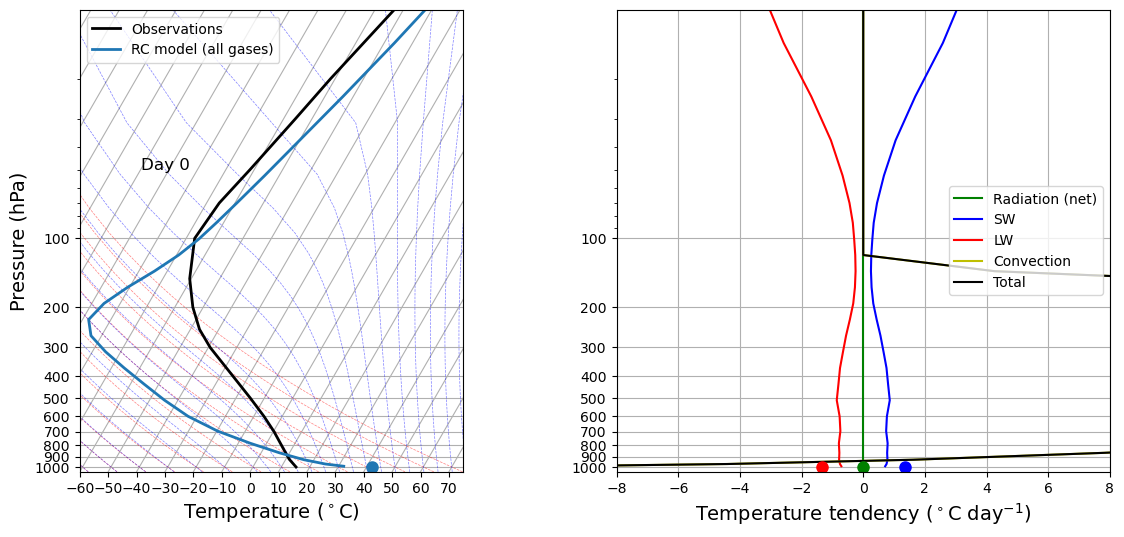

In [93]:
#  Here we take JUST THE RADIATION COMPONENT of the full model and run it out to (near) equilibrium
#  This is just to get the initial condition for our animation
for n in range(1000):
    rcm.subprocess['Radiation (net)'].step_forward()

#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

In [ ]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 100, fargs=(rcm, lines))
HTML(ani.to_html5_video())

## **MODEL3**: Compare Two Models

In [94]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

rad = climlab.radiation.RRTMG(name='all gases',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
#  remove ozone
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'
#  remove water vapor
rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'
#  remove both
rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'
#  put all models together in a list
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,  # the key parameter in the convection model!
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

for model in rad_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()    
    
for model in rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

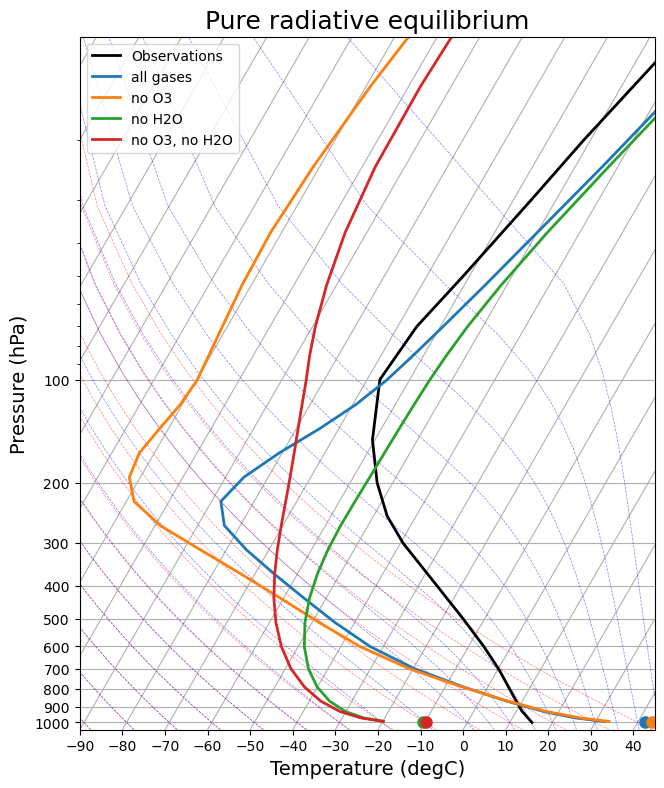

In [107]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

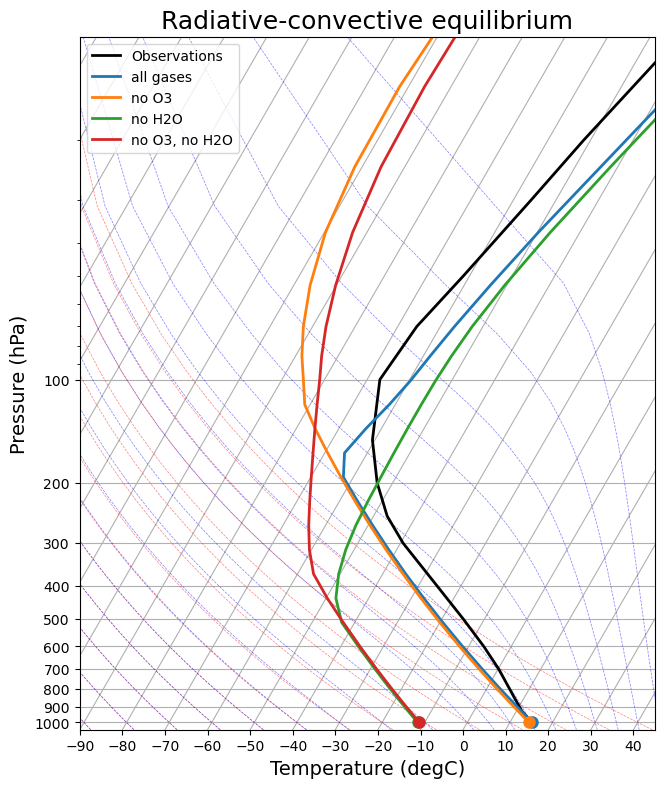

In [108]:
skew2 = make_skewT()
for model in rc_models:
    add_profile(skew2, model)
skew2.ax.set_title('Radiative-convective equilibrium', fontsize=18);

# **3. Insolation and Orbital Cycle**

## INSOLATION1: Equation

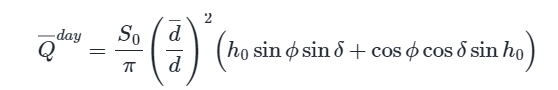

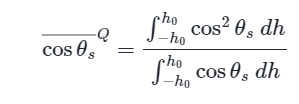

C:\Users\fiona\AppData\Local\Temp\ipykernel_3396\797907564.py:14: RuntimeWarning: invalid value encountered in arccos
  arccos(-tan(phi)*tan(delta)),
C:\Users\fiona\AppData\Local\Temp\ipykernel_3396\797907564.py:23: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator / 2


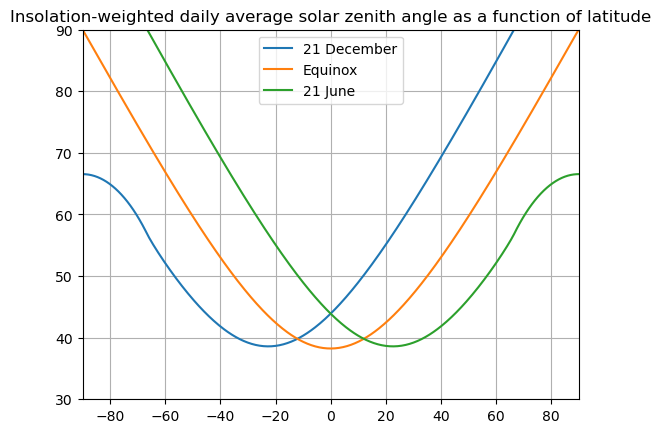

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin,cos,tan,arccos,arcsin,arctan,pi,abs

lat = np.linspace(-90., 90, 500)
phi = np.deg2rad(lat)

declinations = {'21 December': -23.45,
                'Equinox': 0.,
                '21 June': 23.45}

def hour_angle_at_sunset(delta, phi):
    return np.where( abs(delta)-pi/2+abs(phi) < 0., # there is sunset/sunrise
              arccos(-tan(phi)*tan(delta)),
              # otherwise figure out if it's all night or all day
              np.where(phi*delta>0., pi, 0.) )

def insolation_weighted_coszen(delta, phi):
    h0 = hour_angle_at_sunset(delta, phi)
    denominator = h0*sin(phi)*sin(delta) + cos(phi)*cos(delta)*sin(h0)
    numerator = (h0*(2* sin(phi)**2*sin(delta)**2 + cos(phi)**2*cos(delta)**2) + 
        cos(phi)*cos(delta)*sin(h0)*(4*sin(phi)*sin(delta) + cos(phi)*cos(delta)*cos(h0)))
    return numerator / denominator / 2

for label, delta in declinations.items():
    plt.plot(lat, np.rad2deg(arccos(insolation_weighted_coszen(np.deg2rad(delta), phi))), label=label)
plt.legend()
plt.grid()
plt.title('Insolation-weighted daily average solar zenith angle as a function of latitude');
plt.ylim(30,90);
plt.xlim(-90,90);

## INSOLATION2: Climlab
function daily_insolation in the package climlab.solar.insolation

### 2.1 Daily Average Insolation

In [12]:
from climlab import constants as const
from climlab.solar.insolation import daily_insolation

In [13]:
print (daily_insolation(45,1))   # 45N on Jan 1st
print (daily_insolation(45,181)) # 45N on Jul 1st

123.95321551807454
482.356497522712


Text(0.5, 1.0, 'Daily average insolation on March 21')

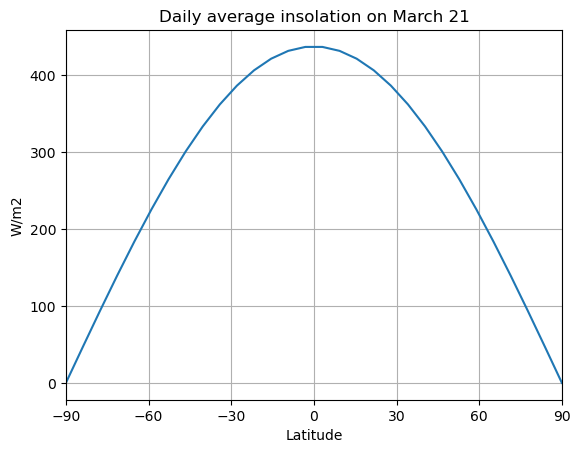

In [14]:
lat = np.linspace(-90., 90., 30)
Q = daily_insolation(lat, 80)
fig, ax = plt.subplots()    
ax.plot(lat,Q)                  
    # used to plot a line graph thereby showing a curve not discrete dots
    # if we want to plot dots: ax.plot(lat, Q, 'o')
ax.set_xlim(-90,90); ax.set_xticks([-90,-60,-30,-0,30,60,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('W/m2')
ax.grid()
ax.set_title('Daily average insolation on March 21')

### 2.2 Global, Seasonal Distribution of Insolation

In [7]:
lat = np.linspace( -90., 90., 500)
numpoints = 365.
days = np.linspace(1., numpoints, 365)/numpoints * const.days_per_year

Q = daily_insolation( lat, days )

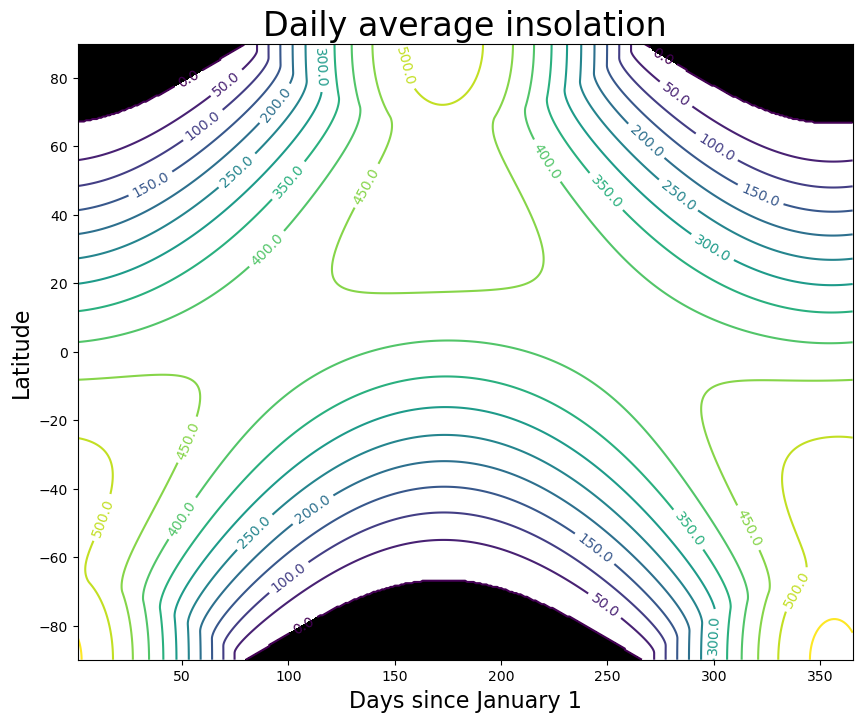

In [8]:
# make a contour of Q as a function of latitude and time of year

fig, ax = plt.subplots(figsize=(10,8))
CS = ax.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax.set_xlabel('Days since January 1', fontsize=16 )
ax.set_ylabel('Latitude', fontsize=16 )
ax.set_title('Daily average insolation', fontsize=24 )
ax.contourf ( days, lat, Q, levels=[-1000., 0.], colors='k' )

In [9]:
# annual average

Qaverage = np.average(np.mean(Q, axis=1), weights=np.cos(np.deg2rad(lat)))
print( 'The annual, global average insolation is %.2f W/m2.' %Qaverage)

The annual, global average insolation is 341.35 W/m2.


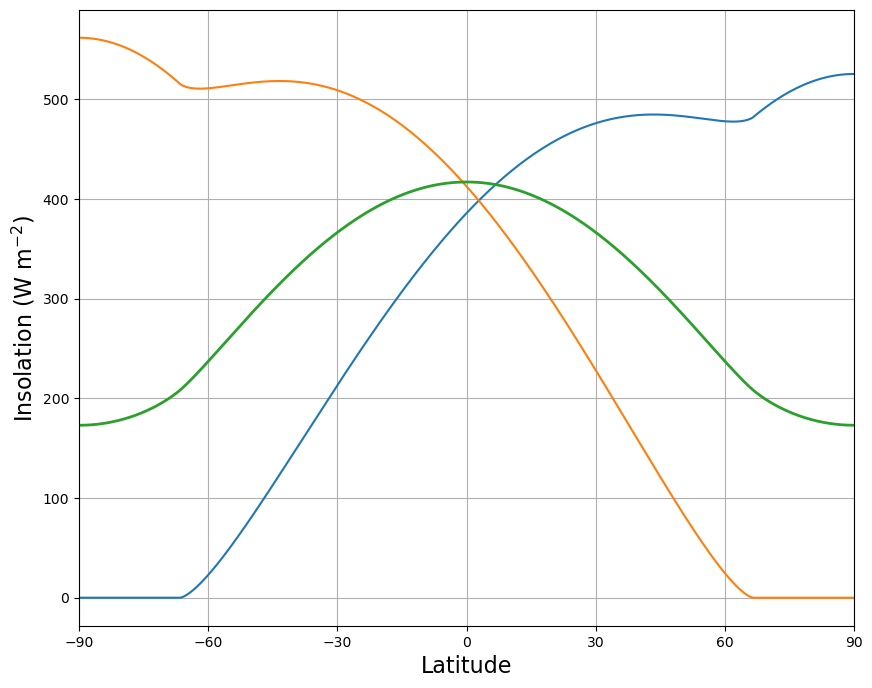

In [10]:
# zonally averaged insolation at a few different times of the year

summer_solstice = 170
winter_solstice = 353
fig, ax = plt.subplots(figsize=(10,8))
ax.plot( lat, Q[:,(summer_solstice, winter_solstice)] );
ax.plot( lat, np.mean(Q, axis=1), linewidth=2 )
ax.set_xbound(-90, 90)
ax.set_xticks( range(-90,100,30) )
ax.set_xlabel('Latitude', fontsize=16 );
ax.set_ylabel('Insolation (W m$^{-2}$)', fontsize=16 );
ax.grid()

## ORBITAL CYCLE1: Parameters in Climlab

In [18]:
import climlab
from climlab.solar.orbital import OrbitalTable

Tokenization took: 37.01 ms
Type conversion took: 16.53 ms
Parser memory cleanup took: 0.00 ms


In [19]:
OrbitalTable

<xarray.Dataset>
Dimensions:     (kyear: 5001)
Coordinates:
  * kyear       (kyear) int64 0 -1 -2 -3 -4 -5 ... -4996 -4997 -4998 -4999 -5000
Data variables:
    ecc         (kyear) float64 0.01724 0.01764 0.01802 ... 0.02689 0.02685
    long_peri   (kyear) float64 281.4 264.3 247.2 ... -8.361e+04 -8.362e+04
    obliquity   (kyear) float64 23.45 23.57 23.7 23.82 ... 22.55 22.52 22.52
    precession  (kyear) float64 -0.0169 -0.01756 -0.01662 ... -0.02683 -0.02639
    65NJul      (kyear) float64 426.8 430.1 434.7 440.2 ... 407.5 409.1 412.3
    65SJan      (kyear) float64 455.6 455.5 454.1 451.6 ... 452.9 450.6 447.3
    15NJul      (kyear) float64 440.6 442.5 445.6 449.8 ... 431.5 433.5 436.9
    15SJan      (kyear) float64 470.4 468.6 465.5 461.4 ... 479.7 477.5 474.0
Attributes:
    Description:  The Berger and Loutre (1991) orbital data table
    Citation:     https://doi.org/10.1016/0277-3791(91)90033-Q
    Source:       http://www.atmos.albany.edu/facstaff/brose/resources/climla...
    Note:         Longitude of perihelion is defined to be 0 degrees at North...

In [20]:
kyears = np.arange( -1000., 1.)
orb = OrbitalTable.interp(kyear=kyears)
orb

<xarray.Dataset>
Dimensions:     (kyear: 1001)
Coordinates:
  * kyear       (kyear) float64 -1e+03 -999.0 -998.0 -997.0 ... -2.0 -1.0 0.0
Data variables:
    ecc         (kyear) float64 0.03576 0.03695 0.03811 ... 0.01764 0.01724
    long_peri   (kyear) float64 -1.644e+04 -1.642e+04 -1.641e+04 ... 264.3 281.4
    obliquity   (kyear) float64 23.78 23.84 23.88 23.9 ... 23.7 23.57 23.45
    precession  (kyear) float64 0.03018 0.02458 0.0166 ... -0.01756 -0.0169
    65NJul      (kyear) float64 478.7 479.0 476.4 470.9 ... 434.7 430.1 426.8
    65SJan      (kyear) float64 414.9 416.2 419.9 425.8 ... 454.1 455.5 455.6
    15NJul      (kyear) float64 489.6 489.1 485.9 480.0 ... 445.6 442.5 440.6
    15SJan      (kyear) float64 424.4 425.0 428.3 434.0 ... 465.5 468.6 470.4
Attributes:
    Description:  The Berger and Loutre (1991) orbital data table
    Citation:     https://doi.org/10.1016/0277-3791(91)90033-Q
    Source:       http://www.atmos.albany.edu/facstaff/brose/resources/climla...
    Note:         Longitude of perihelion is defined to be 0 degrees at North...

Text(0.5, 1.0, 'Obliquity (axial tilt) $\\Phi$')

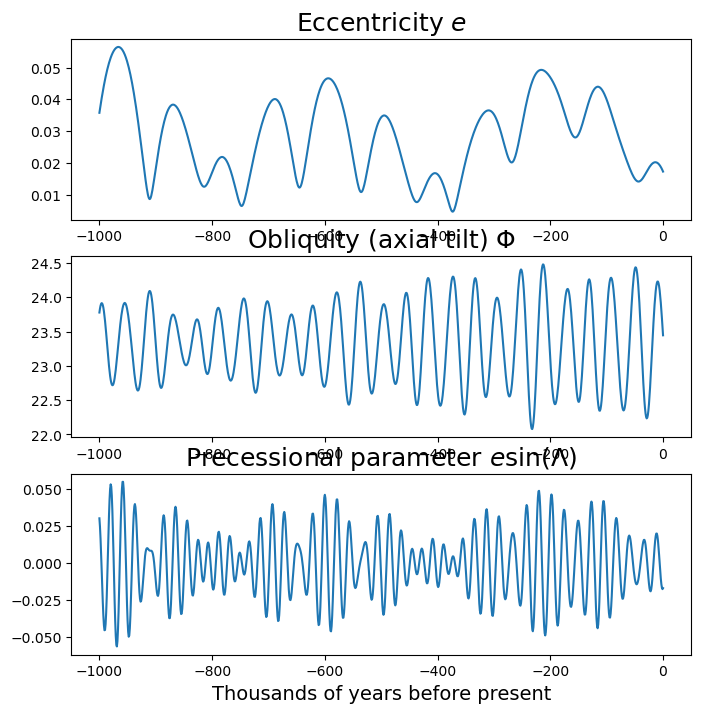

In [21]:
fig = plt.figure( figsize = (8,8) )
ax1 = fig.add_subplot(3,1,1)
ax1.plot( kyears, orb['ecc'] )
ax1.set_title('Eccentricity $e$', fontsize=18 )
ax2 = fig.add_subplot(3,1,3)
ax2.plot( kyears, orb['ecc'] * np.sin( np.deg2rad( orb['long_peri'] ) ) )
ax2.set_title('Precessional parameter $e \sin(\Lambda)$', fontsize=18 )
ax2.set_xlabel( 'Thousands of years before present', fontsize=14 )
ax3 = fig.add_subplot(3,1,2)
ax3.plot( kyears, orb['obliquity'] )
ax3.set_title('Obliquity (axial tilt) $\Phi$', fontsize=18 )

### Play with the parameters

In [24]:
# the insolation at the North Pole for current Earth

from climlab.solar.insolation import daily_insolation
days20 = np.linspace(1.,20.)/20 * const.days_per_year
daily_insolation(90, days20)

<xarray.DataArray (day: 50)>
array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  18.86214697,  85.00612352, 149.06416099,
       210.14318852, 267.43771123, 320.2345592 , 367.91459762,
       409.95198005, 445.91155305, 475.44500661, 498.28632029,
       514.24699096, 523.21145124, 525.13300552, 520.03052731,
       507.9860795 , 489.14354007, 463.70823983, 431.94754511,
       394.19224658, 350.83854561, 302.35036042, 249.26160895,
       192.17806354, 131.7783206 ,  68.81338909,   4.10438408,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])
Coordinates:
  * day      (day) float64 18.26 25.34 32.42 39.51 ... 344.0 351.1 358.2 365.2

In [23]:
# the insolation at the North Pole for a planet with zero obliquity and zero eccentricity

from climlab.solar.insolation import daily_insolation
days20 = np.linspace(1.,20.)/20 * const.days_per_year
daily_insolation(90, days20, {'ecc':0, 'obliquity':0, 'long_peri':0.})

<xarray.DataArray (day: 50)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * day      (day) float64 18.26 25.34 32.42 39.51 ... 344.0 351.1 358.2 365.2

In [25]:
# compare the equator and pole for a planet with 54 obliquity

from climlab.solar.insolation import daily_insolation
days20 = np.linspace(1.,20.)/20 * const.days_per_year
pole54 = np.mean(daily_insolation(90, days20, {'ecc':0.16, 'obliquity':54, 'long_peri':0.}))
equator54 = np.mean(daily_insolation(0, days20, {'ecc':0.16, 'obliquity':54, 'long_peri':0.}))

print (pole54, equator54)

<xarray.DataArray ()>
array(367.53434882) <xarray.DataArray ()>
array(357.99346035)


## ORBITAL CYCLE2: Milankovitch Hypothesis

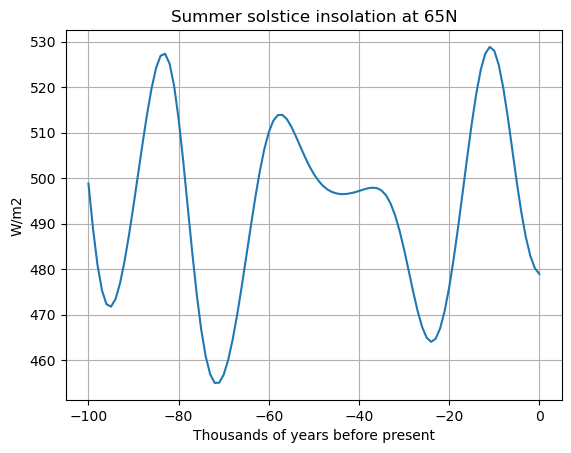

In [26]:
#  Plot summer solstice insolation at 65ºN and see the trend during LGM
years = np.linspace(-100, 0, 101)  #  last 100 kyr
thisorb = OrbitalTable.interp(kyear=years)
S65 = daily_insolation( 65, 172, thisorb )
fig, ax = plt.subplots()
ax.plot(years, S65)
ax.set_xlabel('Thousands of years before present')
ax.set_ylabel('W/m2')
ax.set_title('Summer solstice insolation at 65N')
ax.grid()

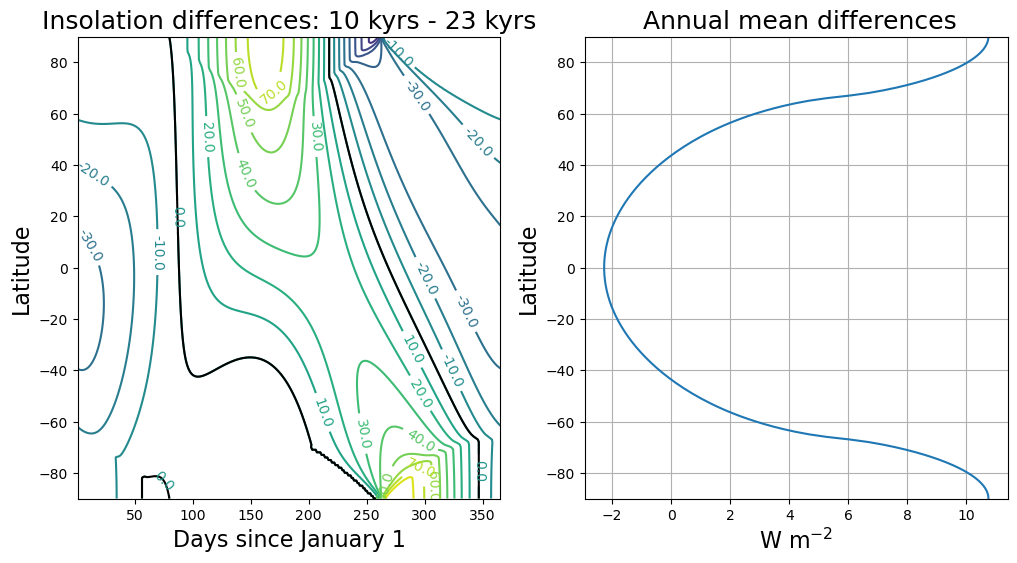

In [27]:
# compare 23 kyr and 10 kyr

lat = np.linspace(-90, 90, 181)

orb_0 = OrbitalTable.interp(kyear=0)  # present-day orbital parameters
orb_10 = OrbitalTable.interp(kyear=-10)  # orbital parameters for 10 kyrs before present
orb_23 = OrbitalTable.interp(kyear=-23)   # 23 kyrs before present
Q_0 = daily_insolation( lat, days, orb_0 )    
Q_10 = daily_insolation( lat, days, orb_10 )   # insolation arrays for each of the three sets of orbital parameters
Q_23 = daily_insolation( lat, days, orb_23 )

# plot the diagram

fig = plt.figure( figsize=(12,6) )

ax1 = fig.add_subplot(1,2,1)
Qdiff = Q_10 - Q_23
CS1 = ax1.contour( days, lat, Qdiff, levels = np.arange(-100., 100., 10.) )
ax1.clabel(CS1, CS1.levels, inline=True, fmt='%r', fontsize=10)
ax1.contour( days, lat, Qdiff, levels = [0], colors='k' )
ax1.set_xlabel('Days since January 1', fontsize=16 )
ax1.set_ylabel('Latitude', fontsize=16 )
ax1.set_title('Insolation differences: 10 kyrs - 23 kyrs', fontsize=18 )

ax2 = fig.add_subplot(1,2,2)
ax2.plot( np.mean( Qdiff, axis=1 ), lat )
ax2.set_xlabel('W m$^{-2}$', fontsize=16 )
ax2.set_ylabel( 'Latitude', fontsize=16 )
ax2.set_title(' Annual mean differences', fontsize=18 )
ax2.set_ylim((-90,90))
ax2.grid()

In [30]:
# the latitudinal difference is very large, but the global average of difference between this two periodsd is tiny
print( np.average(np.mean(Qdiff,axis=1), weights=np.cos(np.deg2rad(lat))) )

0.006517159167911015


## ORBITAL CYCLE3: Orbital variations -> insolation
Global, annual mean insolation

Annual mean insolation at high northern latitudes

Summer solstice insolation at high northern latitudes

In [32]:
Q = daily_insolation(lat, days, orb)
print(Q.shape)

(181, 365, 1001)


In [33]:
Qann = np.mean(Q, axis=1)  # time average over the year
print(Qann.shape)

Qglobal = np.empty_like(kyears)
for n in range(kyears.size):   # global area-weighted average
    Qglobal[n] = np.average(Qann[:,n], weights=np.cos(np.deg2rad(lat)))  # what does this mean?
print(Qglobal.shape)

(181, 1001)
(1001,)


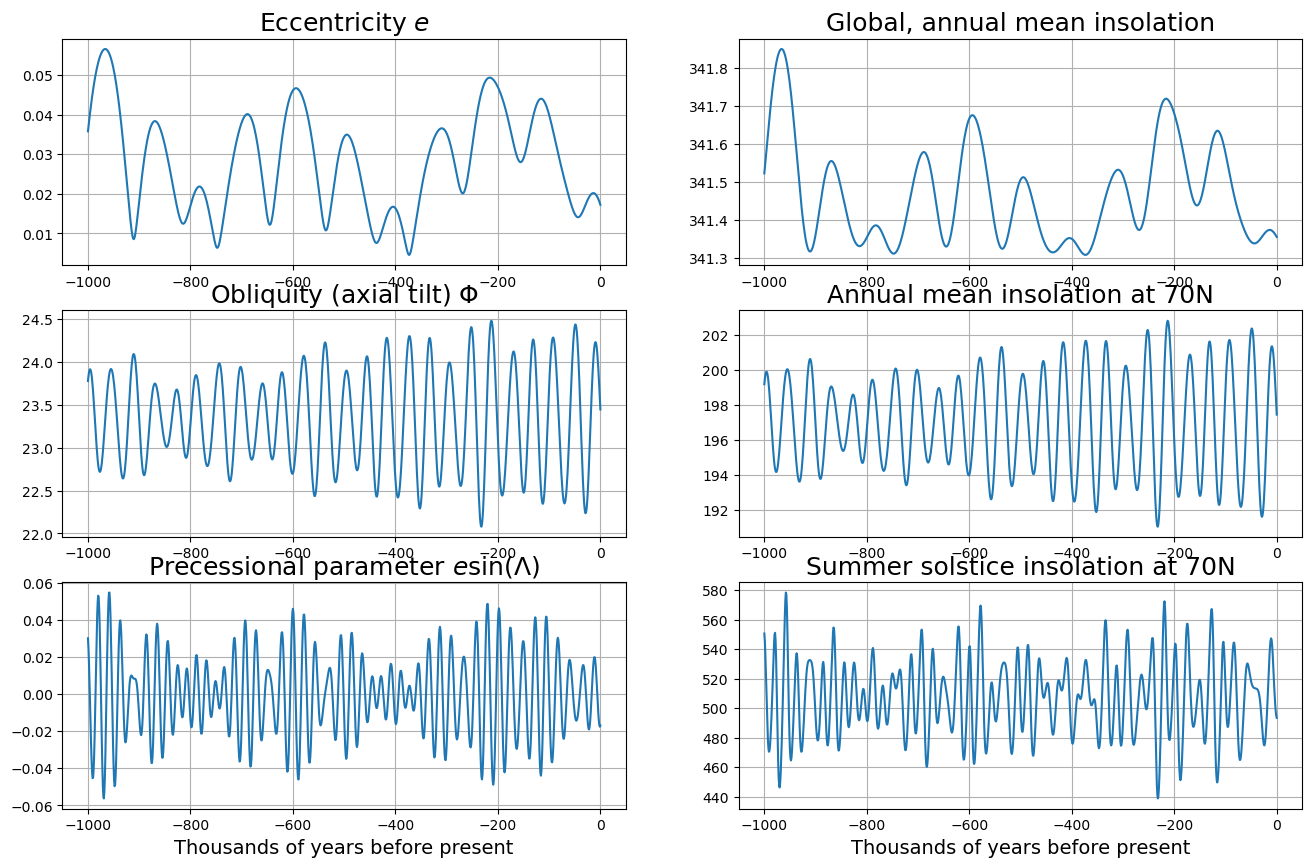

In [34]:
fig = plt.figure(figsize = (16,10))
ax = []
for n in range(6):
    ax.append(fig.add_subplot(3,2,n+1))

ax[0].plot( kyears, orb['ecc'] )
ax[0].set_title('Eccentricity $e$', fontsize=18 )
ax[2].plot( kyears, orb['obliquity'] )
ax[2].set_title('Obliquity (axial tilt) $\Phi$', fontsize=18 )
ax[4].plot( kyears, orb['ecc'] * np.sin( np.deg2rad( orb['long_peri'] ) ) )
ax[4].set_title('Precessional parameter $e \sin(\Lambda)$', fontsize=18 )

ax[1].plot( kyears, Qglobal )
ax[1].set_title('Global, annual mean insolation', fontsize=18 )
ax[1].ticklabel_format( useOffset=False )

# These indices depend on the number of gridpoints we're using in latitude and days
lat70index = 160  
summersolsticeindex = 170

ax[3].plot( kyears, Qann[lat70index,:] )
ax[3].set_title('Annual mean insolation at 70N', fontsize=18 )

ax[5].plot( kyears, Q[lat70index,summersolsticeindex,:] )
ax[5].set_title('Summer solstice insolation at 70N', fontsize=18 )

for n in range(6):
    ax[n].grid()
for n in [4,5]:
    ax[n].set_xlabel( 'Thousands of years before present', fontsize=14 )

In [ ]:
在这里导入前面的代码w

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.math.pi * const.a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

NameError: name 'lat_cesm' is not defined

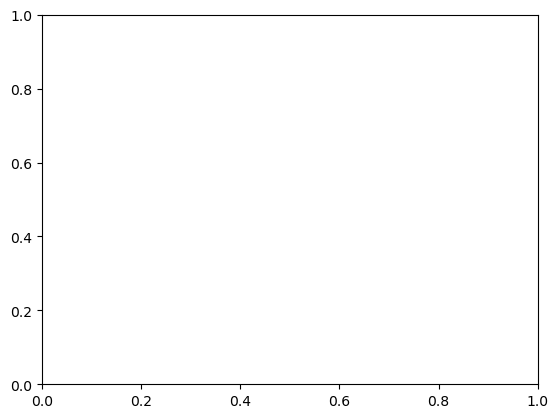

In [5]:
fig, ax = plt.subplots()
ax.plot(lat_cesm, inferred_heat_transport(ASR_cesm_zon - OLR_cesm_zon))
ax.set_ylabel('PW')
ax.set_xticks(ticks)
ax.grid()
ax.set_title('Total northward heat transport inferred from CESM control simulation')

Text(0.5, 1.0, 'Total northward heat transport inferred from CESM control simulation')

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

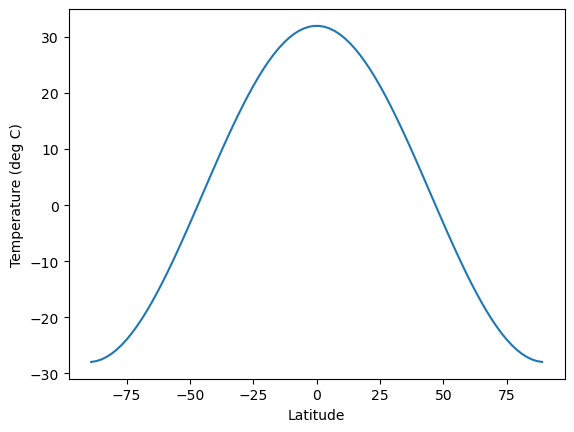

In [4]:
#  First define an initial temperature field
#   that is warm at the equator and cold at the poles
#   and varies smoothly with latitude in between

from climlab.utils import legendre
sfc = climlab.domain.zonal_mean_surface(num_lat=90, water_depth=10.) # a zonal mean surface domain with 90 latitude points and a water depth of 10 units.
lat = sfc.lat.points
initial = 12. - 40. * legendre.P2(np.sin(np.deg2rad(lat)))

fig, ax = plt.subplots()
ax.plot(lat, initial)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)');

# Notice that we have explicitly chosen to the use surface 
#  temperature gradient to set the heat transport. 
#  This is a convenient (and traditional) choice to make, 
#  but it is not the only possibility! 
#  We could instead tune our parameterization to 
#  some measure of the free-tropospheric temperature gradient.

Note that legendre.P2 the 2nd Legendre polynomial, which is calculated as

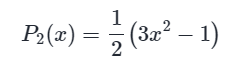


which just turns out to be a useful mathematical description of the relatively smooth changes in things like annual-mean insolation from equator to pole.



In [8]:
##  Set up the climlab diffusion process

# make a copy of initial so that it remains unmodified
Ts = climlab.Field(np.array(initial), domain=sfc)
# thermal diffusivity in W/m**2/degC
D = 0.55
# create the climlab diffusion process
# setting the diffusivity and a timestep of ONE MONTH
d = climlab.dynamics.MeridionalHeatDiffusion(name='Diffusion', 
            state=Ts, D=D, timestep=const.seconds_per_month)
print(d)

climlab Process of type <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>. 
State variables and domain shapes: 
  default: (90, 1) 
The subprocess tree: 
Diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



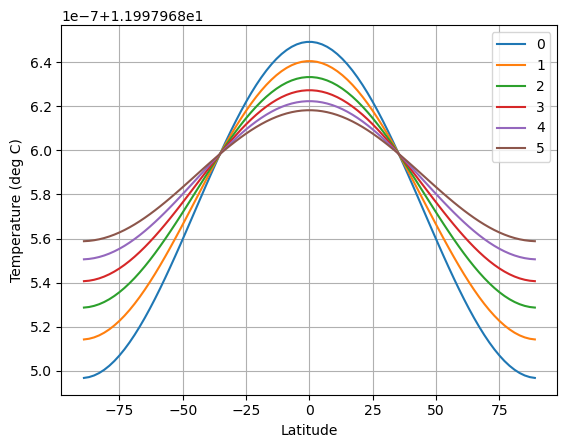

In [12]:
#  Step forward 1 month at a time, store the T each time
n_iter = 5
temp = np.zeros((Ts.size, n_iter+1)) 
    # Creates a 2D array of zeros with dimensions (row, column)
    # Ts.size: the number of elements in the array Ts
temp[:, 0] = np.squeeze(Ts) 
    # Store the initial temperature at the rows in the first column
    # squeeze: Removes any single-dimensional entries from the shape of the array Ts
for n in range(n_iter):
    d.step_forward()
    temp[:, n+1] = np.squeeze(Ts)

#  Now plot the temperatures
fig,ax = plt.subplots()
ax.plot(lat, temp)
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (deg C)')
ax.legend(range(n_iter+1)); ax.grid();

### 2. METHOD 1: Tuning the longwave parameters with reanalysis data (linear regression)

In [7]:
import xarray as xr
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
print( ncep_Ts)

<xarray.Dataset>
Dimensions:             (lon: 192, time: 12, lat: 94, nbnds: 2)
Coordinates:
  * lon                 (lon) float32 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time                (time) float64 -6.571e+05 -6.57e+05 ... -6.567e+05
  * lat                 (lat) float32 88.54 86.65 84.75 ... -84.75 -86.65 -88.54
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    skt                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes:
    title:                          4x daily NMC reanalysis
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    dataset_title:                  NCEP-NCAR Reanalysis 1


In [9]:
#  Take the annual and zonal average!
Ts_ncep_annual = ncep_Ts.skt.mean(dim=('lon','time'))

# TOA radiation data
ncep_ulwrf = xr.open_dataset( ncep_url + "other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_dswrf = xr.open_dataset( ncep_url + "other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_uswrf = xr.open_dataset( ncep_url + "other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=('lon','time'))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(dim=('lon','time'))

In [10]:
#  Use a linear regression package to compute best fit for the slope and intercept
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Ts_ncep_annual, OLR_ncep_annual)

print( 'Best fit is A = %0.0f W/m2 and B = %0.1f W/m2/degC' %(intercept, slope))

Best fit is A = 214 W/m2 and B = 1.6 W/m2/degC


### 2. METHOD2: Reference line with standard values (compare with our regression line)

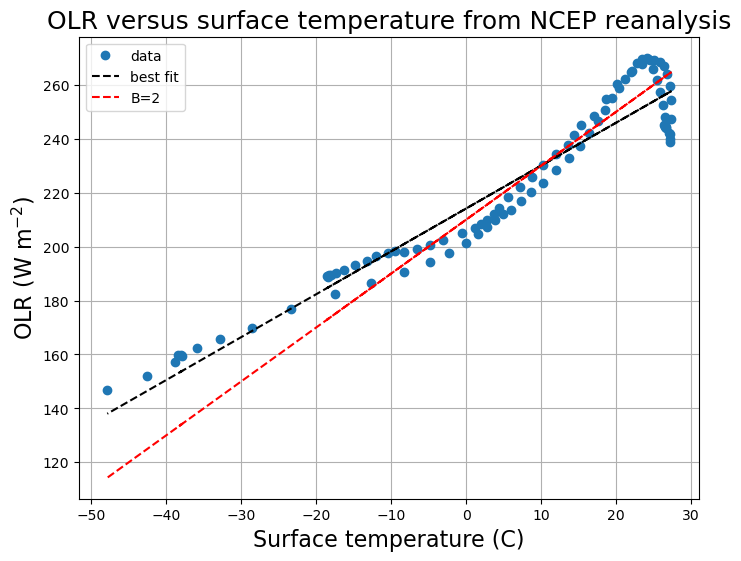

In [14]:
# Another line with more standard values
A = 210.
B = 2.

# Plot the data and two lines (one best fit, one standard value)
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot( Ts_ncep_annual, OLR_ncep_annual, 'o' , label='data')
ax1.plot( Ts_ncep_annual, intercept + slope * Ts_ncep_annual, 'k--', label='best fit')
ax1.plot( Ts_ncep_annual, A + B * Ts_ncep_annual, 'r--', label='B=2')
ax1.set_xlabel('Surface temperature (C)', fontsize=16)
ax1.set_ylabel('OLR (W m$^{-2}$)', fontsize=16)
ax1.set_title('OLR versus surface temperature from NCEP reanalysis', fontsize=18)
ax1.legend(loc='upper left')
ax1.grid()

# Unbiased “best fit” is a poor fit over all the intermediate temperatures.
# By taking the zonal average of the data before the regression, 
#   we are biasing this estimate toward cold temperatures, 
#   because high lat have a smaller surface area compared to low lat.
# Thereby, we are taking this standard reference value.
# B here plays the same role as climate feedback parameter (lamda).
#   lamda = lamda 0 - Σ lamda i, where lamda 0 = 3.3, Σ lamda i = all radiative feedbacks
#   according to our calculation, Σ lamda i = 1.3 W m-2 C-1

The annual, global mean planetary albedo is 0.354


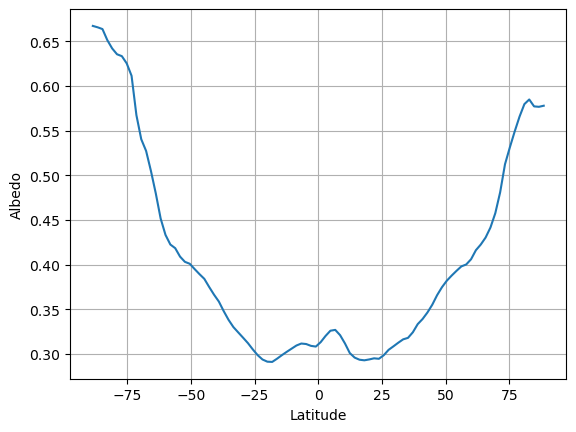

In [15]:
days = np.linspace(1.,50.)/50 * const.days_per_year
    #  np.linspace(1., 50.) generates an array of 50 evenly spaced values between 1 and 50,
    #  /50 resulting in values ranging from 0.02 to 1,
    #  thereby 'days' is an array with days spread evenly throughout the year.
Qann_ncep = climlab.solar.insolation.daily_insolation(lat_ncep, days).mean(dim='day')
    # calculates the daily insolation at the top of the atmosphere at given latitudes 
    # mean(dim='day'): mean value for each day over the 'days' period
albedo_ncep = 1 - ASR_ncep_annual / Qann_ncep
albedo_ncep_global = np.average(albedo_ncep, weights=np.cos(np.deg2rad(lat_ncep)))

print( 'The annual, global mean planetary albedo is %0.3f' %albedo_ncep_global)
fig,ax = plt.subplots()
ax.plot(lat_ncep, albedo_ncep)
ax.grid();
ax.set_xlabel('Latitude')
ax.set_ylabel('Albedo');

In [17]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

def setup_figure():
    templimits = -20,32
    radlimits = -340, 340
    htlimits = -6,6
    latlimits = -90,90
    lat_ticks = np.arange(-90,90,30)

    fig, axes = plt.subplots(3,1,figsize=(8,10))
    axes[0].set_ylabel('Temperature (deg C)')
    axes[0].set_ylim(templimits)
    axes[1].set_ylabel('Energy budget (W m$^{-2}$)')
    axes[1].set_ylim(radlimits)
    axes[2].set_ylabel('Heat transport (PW)')
    axes[2].set_ylim(htlimits)
    axes[2].set_xlabel('Latitude')
    for ax in axes: ax.set_xlim(latlimits); ax.set_xticks(lat_ticks); ax.grid()
    fig.suptitle('Diffusive energy balance model with annual-mean insolation', fontsize=14)
    return fig, axes

def initial_figure(model):
    #  Make figure and axes
    fig, axes = setup_figure()
    # plot initial data
    lines = []
    lines.append(axes[0].plot(model.lat, model.Ts)[0])
    lines.append(axes[1].plot(model.lat, model.ASR, 'k--', label='SW')[0])
    lines.append(axes[1].plot(model.lat, -model.OLR, 'r--', label='LW')[0])
    lines.append(axes[1].plot(model.lat, model.net_radiation, 'c-', label='net rad')[0])
    lines.append(axes[1].plot(model.lat, model.heat_transport_convergence, 'g--', label='dyn')[0])
    lines.append(axes[1].plot(model.lat, 
            model.net_radiation+model.heat_transport_convergence, 'b-', label='total')[0])
    axes[1].legend(loc='upper right')
    lines.append(axes[2].plot(model.lat_bounds, model.heat_transport)[0])
    lines.append(axes[0].text(60, 25, 'Day 0'))
    return fig, axes, lines

def animate(day, model, lines):
    model.step_forward()
    #  The rest of this is just updating the plot
    lines[0].set_ydata(model.Ts)
    lines[1].set_ydata(model.ASR)
    lines[2].set_ydata(-model.OLR)
    lines[3].set_ydata(model.net_radiation)
    lines[4].set_ydata(model.heat_transport_convergence)
    lines[5].set_ydata(model.net_radiation+model.heat_transport_convergence)
    lines[6].set_ydata(model.heat_transport)
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    return lines   

In [18]:
#  A model starting from isothermal initial conditions
e = climlab.EBM_annual()
e.Ts[:] = 15.  # in degrees Celsius
e.compute_diagnostics()

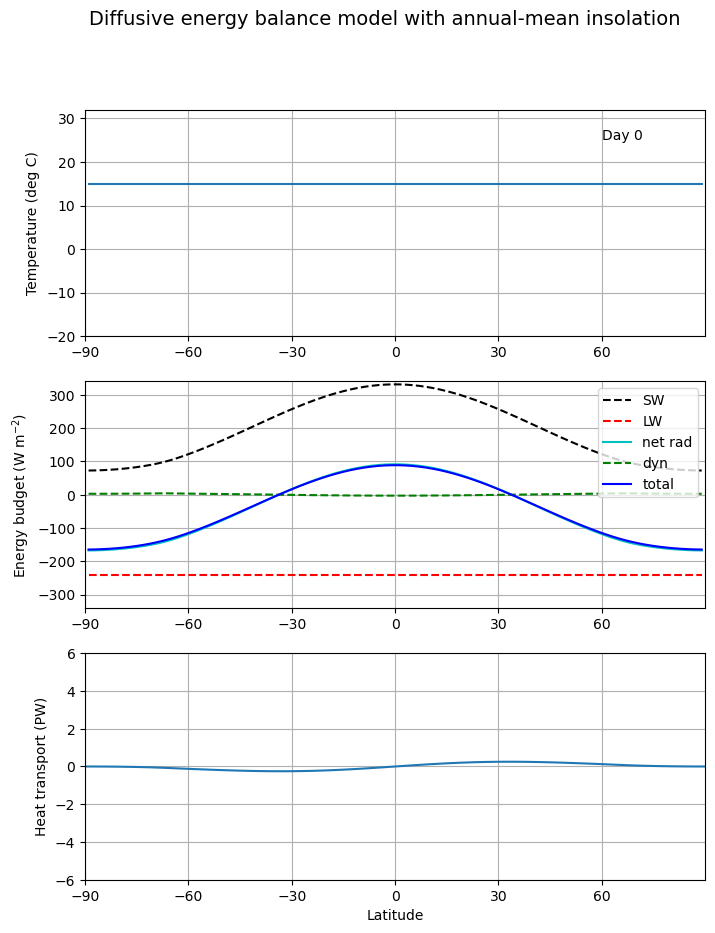

In [19]:
#  Plot initial data 
fig, axes, lines = initial_figure(e)

In [21]:
ani = animation.FuncAnimation(fig, animate, frames=np.arange(1, 100), fargs=(e, lines))

In [ ]:
HTML(ani.to_html5_video())

try different D values ----> ebm = climlab.EBM_annual(num_lat=40, A=210, B=2, a0=0.354, a2=0.25, D=1.)

so that:

1. delta T = 45 C between equator and pole ----> deltaT = np.max(ebm.Ts) - np.min(ebm.Ts)

2. H max = 5.5 P,(peak heat transpotr ---> np.max(ebm.heat_transport)

We can input the datasets [D, delta T, H max] into a dataframe and plot out the results, and then choose a most reasonable approximation of D.

Another method is:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import climlab

Darray = np.arange(0., 2.05, 0.05)

model_list = []
Tmean_list = []
deltaT_list = []
Hmax_list = []

for D in Darray:
    ebm = climlab.EBM_annual(A=210, B=2, a0=0.354, a2=0.25, D=D)
    ebm.integrate_years(20., verbose=False)
    Tmean = ebm.global_mean_temperature()
    deltaT = np.max(ebm.Ts) - np.min(ebm.Ts)
    energy_in = np.squeeze(ebm.ASR - ebm.OLR)
    Htrans = ebm.heat_transport
    Hmax = np.max(Htrans)
    model_list.append(ebm)
    Tmean_list.append(Tmean)
    deltaT_list.append(deltaT)
    Hmax_list.append(Hmax)

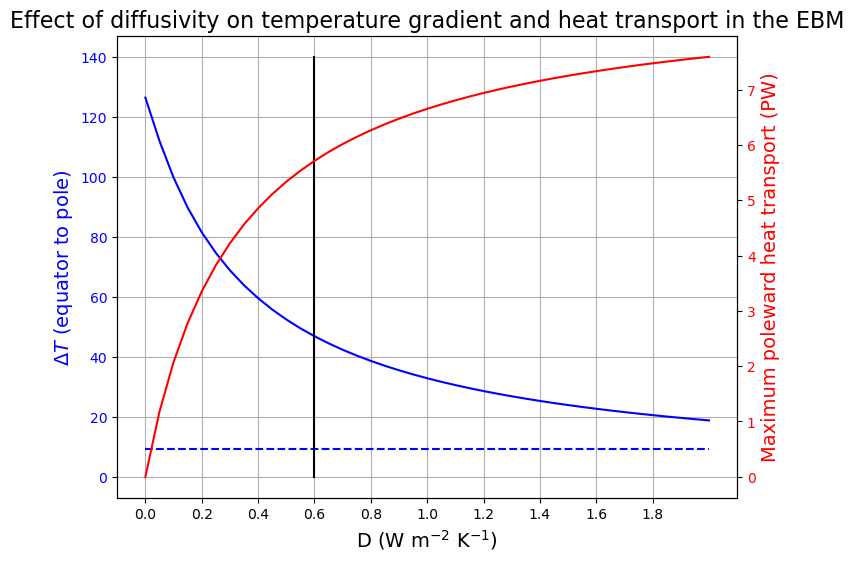

In [9]:
color1 = 'b'
color2 = 'r'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(Darray, deltaT_list, color=color1)
ax1.plot(Darray, Tmean_list, 'b--')
ax1.set_xlabel('D (W m$^{-2}$ K$^{-1}$)', fontsize=14)
ax1.set_xticks(np.arange(Darray[0], Darray[-1], 0.2))
ax1.set_ylabel('$\Delta T$ (equator to pole)', fontsize=14,  color=color1)
for tl in ax1.get_yticklabels():
    tl.set_color(color1)
ax2 = ax1.twinx()
ax2.plot(Darray, Hmax_list, color=color2)
ax2.set_ylabel('Maximum poleward heat transport (PW)', fontsize=14, color=color2)
for tl in ax2.get_yticklabels():
    tl.set_color(color2)
ax1.set_title('Effect of diffusivity on temperature gradient and heat transport in the EBM', fontsize=16)
ax1.grid()

ax1.plot([0.6, 0.6], [0, 140], 'k-');